In [19]:
from matplotlib.font_manager import FontProperties
font_path = 'C:/Windows/Fonts/simhei.ttf'  # 黑体字体路径
font_prop = FontProperties(fname=font_path)
plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

In [1]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
import cv2
import torch
import numpy as np
import mediapipe as mp
from segment_anything import sam_model_registry, SamPredictor
from PIL import Image
from tqdm import tqdm

def split_videos_by_class(jaundice_dir, nonjaundice_dir, output_base_dir, train_ratio=0.7, val_ratio=0.15):
    """
    将黄疸和非黄疸两类视频分别划分为训练集、验证集和测试集
    
    Args:
        jaundice_dir: 包含黄疸视频的目录
        nonjaundice_dir: 包含非黄疸视频的目录
        output_base_dir: 输出基础目录
        train_ratio: 训练集比例
        val_ratio: 验证集比例（测试集比例 = 1 - train_ratio - val_ratio）
    """
    # 创建输出目录结构
    splits = ["train", "val", "test"]
    classes = ["jaundice", "nonjaundice"]
    
    for split in splits:
        for cls in classes:
            os.makedirs(os.path.join(output_base_dir, split, cls), exist_ok=True)
    
    # 视频格式
    video_extensions = ('.mov', '.mp4', '.avi', '.mkv', '.wmv')
    
    # 获取所有视频文件函数
    def get_videos_from_dir(directory):
        videos = []
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(video_extensions):
                    videos.append(os.path.join(root, file))
        return videos
    
    # 获取两类视频
    jaundice_videos = get_videos_from_dir(jaundice_dir)
    nonjaundice_videos = get_videos_from_dir(nonjaundice_dir)
    
    print(f"找到 {len(jaundice_videos)} 个黄疸视频")
    print(f"找到 {len(nonjaundice_videos)} 个非黄疸视频")
    
    # 划分每类视频数据集
    def split_videos(videos, class_name):
        if not videos:
            print(f"警告: 未找到{class_name}视频文件")
            return {}
            
        # 划分数据集
        train_val, test = train_test_split(
            videos, 
            test_size=(1 - train_ratio - val_ratio), 
            random_state=42
        )
        
        train, val = train_test_split(
            train_val, 
            test_size=val_ratio/(train_ratio + val_ratio),
            random_state=42
        )
        
        return {
            "train": train,
            "val": val,
            "test": test
        }
    
    # 执行划分
    jaundice_splits = split_videos(jaundice_videos, "黄疸")
    nonjaundice_splits = split_videos(nonjaundice_videos, "非黄疸")
    
    # 复制视频到对应目录
    def copy_videos_to_dir(videos, target_dir):
        copied_count = 0
        for video_path in videos:
            video_name = os.path.basename(video_path)
            dst_path = os.path.join(target_dir, video_name)
            shutil.copy2(video_path, dst_path)
            copied_count += 1
        return copied_count
    
    # 执行复制
    video_counts = {}
    
    for split in splits:
        jaundice_dst = os.path.join(output_base_dir, split, "jaundice")
        nonjaundice_dst = os.path.join(output_base_dir, split, "nonjaundice")
        
        jaundice_count = copy_videos_to_dir(jaundice_splits.get(split, []), jaundice_dst)
        nonjaundice_count = copy_videos_to_dir(nonjaundice_splits.get(split, []), nonjaundice_dst)
        
        video_counts[split] = {
            "jaundice": jaundice_count,
            "nonjaundice": nonjaundice_count,
            "total": jaundice_count + nonjaundice_count
        }
    
    # 输出划分统计信息
    print("\n数据集划分完成：")
    for split in splits:
        counts = video_counts[split]
        print(f"- {split}集: {counts['total']}个视频 (黄疸: {counts['jaundice']}, 非黄疸: {counts['nonjaundice']})")
    
    return output_base_dir

# 初始化SAM模型
def init_sam(model_type='vit_h', checkpoint_path='E:/sam_vit_h_4b8939.pth'):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    sam = sam_model_registry[model_type](checkpoint=checkpoint_path)
    sam.to(device=device)
    predictor = SamPredictor(sam)
    return predictor

# 视频处理函数
def process_video(video_path, predictor, output_dir, class_name, frames_per_video=12):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print(f"❌ 无法打开视频: {video_path}")
        return

    # 初始化MediaPipe Face Mesh
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=False, max_num_faces=1, refine_landmarks=True)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_interval = max(1, total_frames // frames_per_video)
    video_name = os.path.splitext(os.path.basename(video_path))[0]

    frame_count, saved_count = 0, 0
    while cap.isOpened() and saved_count < frames_per_video:
        ret, frame = cap.read()
        if not ret:
            break
        if frame_count % frame_interval == 0:
            frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = face_mesh.process(frame_rgb)
            if results.multi_face_landmarks:
                landmarks = results.multi_face_landmarks[0]
                h, w, _ = frame.shape
                keypoints = np.array([[int(lm.x * w), int(lm.y * h)] for lm in landmarks.landmark])
                selected_indices = [1, 33, 61, 199, 263, 291]
                input_points = keypoints[selected_indices]
                input_labels = np.ones(len(input_points), dtype=int)

                predictor.set_image(frame_rgb)
                masks, _, _ = predictor.predict(
                    point_coords=input_points,
                    point_labels=input_labels,
                    multimask_output=False,
                )
                mask = masks[0]
                masked_frame = frame_rgb.copy()
                masked_frame[~mask] = [0, 0, 0]
                
                # 将类别名称添加到保存文件名中，避免不同类别同名视频的冲突
                save_path = os.path.join(output_dir, f"{class_name}_{video_name}_frame_{frame_count}.png")
                Image.fromarray(masked_frame).save(save_path)
                saved_count += 1
                print(f"视频: {video_name} ({class_name}) 已保存帧 {saved_count}/{frames_per_video}")
            else:
                print(f"视频: {video_name} ({class_name}) 帧 {frame_count} 未检测到人脸，跳过")
        frame_count += 1
    cap.release()
    face_mesh.close()

# 处理一个数据集分区中的视频
def process_split_videos(split_dir, output_dir, predictor, frames_per_video=12):
    """处理单个数据集分区（训练/验证/测试）中的所有视频，包括黄疸和非黄疸类别"""
    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)
    
    # 处理每个类别的视频
    class_names = ["jaundice", "nonjaundice"]
    video_extensions = ('.mov', '.mp4', '.avi', '.mkv', '.wmv')
    processed_count = 0
    
    for class_name in class_names:
        class_dir = os.path.join(split_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"警告: 目录 {class_dir} 不存在，跳过")
            continue
        
        # 获取该类别的所有视频
        videos = [f for f in os.listdir(class_dir) if f.lower().endswith(video_extensions)]
        print(f"在 {class_dir} 中找到 {len(videos)} 个视频")
        
        # 处理每个视频
        for video_file in tqdm(videos, desc=f"处理 {os.path.basename(split_dir)} 的 {class_name} 视频"):
            video_path = os.path.join(class_dir, video_file)
            process_video(video_path, predictor, output_dir, class_name, frames_per_video)
            processed_count += 1
    
    return processed_count

# 预处理图像函数
def preprocess_image(image_path, output_path):
    # 初始化mediapipe人脸关键点检测
    mp_face_mesh = mp.solutions.face_mesh
    face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1, refine_landmarks=True)
    
    # 读取图像
    def cv_imread(file_path):
        cv_img = cv2.imdecode(np.fromfile(file_path, dtype=np.uint8), cv2.IMREAD_COLOR)
        return cv_img
    
    # 保存图像    
    def cv_imwrite(file_path, img):
        ext = os.path.splitext(file_path)[1]
        result, encoded_img = cv2.imencode(ext, img)
        if result:
            encoded_img.tofile(file_path)
            return True
        else:
            return False
    
    img = cv_imread(image_path)
    if img is None:
        print(f"无法读取图片: {image_path}")
        return False

    # 人脸关键点检测
    results = face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    if not results.multi_face_landmarks:
        print(f"未检测到人脸: {image_path}")
        return False
    landmarks = results.multi_face_landmarks[0].landmark

    # CLAHE光照均衡化
    def apply_clahe(img):
        lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
        l, a, b = cv2.split(lab)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        cl = clahe.apply(l)
        merged = cv2.merge((cl, a, b))
        return cv2.cvtColor(merged, cv2.COLOR_LAB2BGR)
    img = apply_clahe(img)

    # 灰度世界颜色校正
    def gray_world_balance(img):
        result = img.copy().astype(np.float32)
        avg_b, avg_g, avg_r = np.mean(result, axis=(0,1))
        avg_gray = (avg_b + avg_g + avg_r) / 3
        result[:,:,0] *= avg_gray / avg_b
        result[:,:,1] *= avg_gray / avg_g
        result[:,:,2] *= avg_gray / avg_r
        return np.clip(result, 0, 255).astype(np.uint8)
    img = gray_world_balance(img)

    # 眼睛区域增强
    def enhance_eye_region(img, landmarks):
        h, w = img.shape[:2]
        left_eye_idx = [33, 133, 160, 158, 159, 144, 145, 153]
        right_eye_idx = [362, 263, 387, 385, 386, 373, 374, 380]

        mask = np.zeros((h, w), dtype=np.uint8)
        for eye_idx in [left_eye_idx, right_eye_idx]:
            points = np.array([[int(landmarks[idx].x * w), int(landmarks[idx].y * h)] for idx in eye_idx])
            cv2.fillPoly(mask, [points], 255)

        enhanced = img.copy()
        alpha, beta = 1.3, 15  # 调整对比度和亮度
        eye_region = cv2.bitwise_and(enhanced, enhanced, mask=mask)
        eye_region = cv2.convertScaleAbs(eye_region, alpha=alpha, beta=beta)
        inv_mask = cv2.bitwise_not(mask)
        enhanced = cv2.bitwise_and(enhanced, enhanced, mask=inv_mask)
        enhanced = cv2.add(enhanced, eye_region)
        
        return enhanced
    img = enhance_eye_region(img, landmarks)

    # 保存预处理后的图片
    cv_imwrite(output_path, img)
    face_mesh.close()
    return True

# 批量预处理图像
def preprocess_split_images(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]

    for img_file in tqdm(image_files, desc=f"预处理 {os.path.basename(input_dir)} 图像"):
        input_path = os.path.join(input_dir, img_file)
        output_path = os.path.join(output_dir, img_file)
        preprocess_image(input_path, output_path)

# 准备YOLO分类数据集结构
def prepare_yolo_classification_dataset(preprocessed_dir, output_dir):
    """将预处理后的图像组织为YOLO分类数据集结构"""
    splits = ["train", "val", "test"]
    
    # 创建输出目录结构
    for split in splits:
        os.makedirs(os.path.join(output_dir, split, "jaundice"), exist_ok=True)
        os.makedirs(os.path.join(output_dir, split, "nonjaundice"), exist_ok=True)
    
    # 处理每个数据集分割
    for split in splits:
        input_split_dir = os.path.join(preprocessed_dir, split)
        if not os.path.exists(input_split_dir):
            print(f"警告: {input_split_dir} 不存在，跳过")
            continue
        
        # 获取所有图像
        image_files = [f for f in os.listdir(input_split_dir) if f.lower().endswith(('png', 'jpg', 'jpeg'))]
        
        for img_file in tqdm(image_files, desc=f"组织 {split} 分类数据集"):
            # 从文件名确定类别 (基于我们保存时添加的类别前缀)
            if img_file.startswith("jaundice_"):
                class_name = "jaundice"
            elif img_file.startswith("nonjaundice_"):
                class_name = "nonjaundice"
            else:
                print(f"警告: 无法确定图像 {img_file} 的类别，跳过")
                continue
            
            # 复制到对应目录
            src_path = os.path.join(input_split_dir, img_file)
            dst_path = os.path.join(output_dir, split, class_name, img_file)
            shutil.copy2(src_path, dst_path)

# 主函数
def main():
    # 配置基础路径
    base_dir = r"C:\Users\MichaelY\Desktop\jaundice_video"
    
    # 源视频目录
    jaundice_video_dir = os.path.join(base_dir, "jaundice_video")
    nonjaundice_video_dir = os.path.join(base_dir, "nonjaundice_video")
    
    # 处理阶段输出目录
    split_videos_dir = os.path.join(base_dir, "split_videos")
    segmented_dir = os.path.join(base_dir, "segmented")
    preprocessed_dir = os.path.join(base_dir, "preprocessed")
    final_dataset_dir = os.path.join(base_dir, "cls_dataset")
    
    # 1. 首先划分视频数据集 (黄疸和非黄疸各自划分为训练/验证/测试集)
    print("\n第1步: 划分黄疸和非黄疸视频数据集...")
    split_videos_by_class(
        jaundice_dir=jaundice_video_dir,
        nonjaundice_dir=nonjaundice_video_dir,
        output_base_dir=split_videos_dir,
        train_ratio=0.7,
        val_ratio=0.15
    )
    
    # 2. 初始化SAM模型
    print("\n第2步: 初始化SAM模型...")
    predictor = init_sam(model_type='vit_h', checkpoint_path='E:/sam_vit_h_4b8939.pth')
    
    # 3. 创建处理阶段的输出目录
    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(segmented_dir, split), exist_ok=True)
        os.makedirs(os.path.join(preprocessed_dir, split), exist_ok=True)
    
    # 4. 对每个数据集划分进行视频处理(分割)
    for split in ["train", "val", "test"]:
        print(f"\n第3步: 处理{split}集视频分割...")
        split_dir = os.path.join(split_videos_dir, split)
        segmented_output = os.path.join(segmented_dir, split)
        
        videos_processed = process_split_videos(
            split_dir,
            segmented_output,
            predictor,
            frames_per_video=12
        )
        print(f"完成{split}集视频处理，共处理 {videos_processed} 个视频")
    
    # 5. 对分割后的图像进行预处理
    for split in ["train", "val", "test"]:
        print(f"\n第4步: 对{split}集的分割图像进行预处理...")
        preprocess_split_images(
            os.path.join(segmented_dir, split),
            os.path.join(preprocessed_dir, split)
        )
    
    # 6. 准备YOLO分类数据集
    print("\n第5步: 准备YOLO分类数据集...")
    prepare_yolo_classification_dataset(
        preprocessed_dir,
        final_dataset_dir
    )
    
    print("\n✅ 所有处理完成! YOLO分类数据集已准备就绪。")
    print(f"分类数据集目录: {final_dataset_dir}")
    
    # 7. 显示最终数据集统计
    class_counts = {}
    for split in ["train", "val", "test"]:
        class_counts[split] = {
            "jaundice": len(os.listdir(os.path.join(final_dataset_dir, split, "jaundice"))),
            "nonjaundice": len(os.listdir(os.path.join(final_dataset_dir, split, "nonjaundice")))
        }
        total = class_counts[split]["jaundice"] + class_counts[split]["nonjaundice"]
        print(f"{split}集: 共{total}张图片 (黄疸: {class_counts[split]['jaundice']}, 非黄疸: {class_counts[split]['nonjaundice']})")

if __name__ == "__main__":
    main()



第1步: 划分黄疸和非黄疸视频数据集...
找到 314 个黄疸视频
找到 387 个非黄疸视频

数据集划分完成：
- train集: 489个视频 (黄疸: 219, 非黄疸: 270)
- val集: 105个视频 (黄疸: 47, 非黄疸: 58)
- test集: 107个视频 (黄疸: 48, 非黄疸: 59)

第2步: 初始化SAM模型...

第3步: 处理train集视频分割...
在 C:\Users\MichaelY\Desktop\jaundice_video\split_videos\train\jaundice 中找到 218 个视频


处理 train 的 jaundice 视频:   0%|                                                             | 0/218 [00:00<?, ?it/s]

视频: VID_20230628_160429 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230628_160429 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20230628_160429 (jaundice) 已保存帧 1/12
视频: VID_20230628_160429 (jaundice) 已保存帧 2/12
视频: VID_20230628_160429 (jaundice) 已保存帧 3/12
视频: VID_20230628_160429 (jaundice) 已保存帧 4/12
视频: VID_20230628_160429 (jaundice) 已保存帧 5/12
视频: VID_20230628_160429 (jaundice) 已保存帧 6/12
视频: VID_20230628_160429 (jaundice) 已保存帧 7/12
视频: VID_20230628_160429 (jaundice) 已保存帧 8/12
视频: VID_20230628_160429 (jaundice) 已保存帧 9/12
视频: VID_20230628_160429 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:   0%|▏                                                    | 1/218 [00:14<51:21, 14.20s/it]

视频: VID_20230628_160429 (jaundice) 已保存帧 11/12
视频: VID_20230701_182544 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230701_182544 (jaundice) 帧 49 未检测到人脸，跳过
视频: VID_20230701_182544 (jaundice) 帧 98 未检测到人脸，跳过
视频: VID_20230701_182544 (jaundice) 已保存帧 1/12
视频: VID_20230701_182544 (jaundice) 已保存帧 2/12
视频: VID_20230701_182544 (jaundice) 已保存帧 3/12
视频: VID_20230701_182544 (jaundice) 已保存帧 4/12
视频: VID_20230701_182544 (jaundice) 已保存帧 5/12
视频: VID_20230701_182544 (jaundice) 已保存帧 6/12
视频: VID_20230701_182544 (jaundice) 已保存帧 7/12
视频: VID_20230701_182544 (jaundice) 已保存帧 8/12
视频: VID_20230701_182544 (jaundice) 帧 539 未检测到人脸，跳过


处理 train 的 jaundice 视频:   1%|▍                                                    | 2/218 [00:26<47:01, 13.06s/it]

视频: VID_20230701_182544 (jaundice) 已保存帧 9/12
视频: VID_20230701_190120 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230701_190120 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230701_190120 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20230701_190120 (jaundice) 已保存帧 1/12
视频: VID_20230701_190120 (jaundice) 已保存帧 2/12
视频: VID_20230701_190120 (jaundice) 已保存帧 3/12
视频: VID_20230701_190120 (jaundice) 已保存帧 4/12
视频: VID_20230701_190120 (jaundice) 已保存帧 5/12
视频: VID_20230701_190120 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20230701_190120 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230701_190120 (jaundice) 帧 220 未检测到人脸，跳过


处理 train 的 jaundice 视频:   1%|▋                                                    | 3/218 [00:32<35:07,  9.80s/it]

视频: VID_20230701_190120 (jaundice) 帧 242 未检测到人脸，跳过
视频: VID_20230701_190120 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230702_153303 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230702_153303 (jaundice) 帧 47 未检测到人脸，跳过
视频: VID_20230702_153303 (jaundice) 已保存帧 1/12
视频: VID_20230702_153303 (jaundice) 已保存帧 2/12
视频: VID_20230702_153303 (jaundice) 已保存帧 3/12
视频: VID_20230702_153303 (jaundice) 已保存帧 4/12
视频: VID_20230702_153303 (jaundice) 已保存帧 5/12
视频: VID_20230702_153303 (jaundice) 已保存帧 6/12
视频: VID_20230702_153303 (jaundice) 已保存帧 7/12
视频: VID_20230702_153303 (jaundice) 已保存帧 8/12
视频: VID_20230702_153303 (jaundice) 已保存帧 9/12
视频: VID_20230702_153303 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:   2%|▉                                                    | 4/218 [00:44<37:43, 10.58s/it]

视频: VID_20230702_153303 (jaundice) 帧 564 未检测到人脸，跳过
视频: VID_20230702_160103 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230702_160103 (jaundice) 已保存帧 1/12
视频: VID_20230702_160103 (jaundice) 已保存帧 2/12
视频: VID_20230702_160103 (jaundice) 已保存帧 3/12
视频: VID_20230702_160103 (jaundice) 已保存帧 4/12
视频: VID_20230702_160103 (jaundice) 已保存帧 5/12
视频: VID_20230702_160103 (jaundice) 已保存帧 6/12
视频: VID_20230702_160103 (jaundice) 已保存帧 7/12
视频: VID_20230702_160103 (jaundice) 帧 224 未检测到人脸，跳过
视频: VID_20230702_160103 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230702_160103 (jaundice) 帧 280 未检测到人脸，跳过
视频: VID_20230702_160103 (jaundice) 帧 308 未检测到人脸，跳过


处理 train 的 jaundice 视频:   2%|█▏                                                   | 5/218 [00:53<35:40, 10.05s/it]

视频: VID_20230702_160103 (jaundice) 已保存帧 8/12
视频: VID_20230702_164415 (jaundice) 已保存帧 1/12
视频: VID_20230702_164415 (jaundice) 已保存帧 2/12
视频: VID_20230702_164415 (jaundice) 帧 76 未检测到人脸，跳过
视频: VID_20230702_164415 (jaundice) 帧 114 未检测到人脸，跳过
视频: VID_20230702_164415 (jaundice) 已保存帧 3/12
视频: VID_20230702_164415 (jaundice) 已保存帧 4/12
视频: VID_20230702_164415 (jaundice) 已保存帧 5/12
视频: VID_20230702_164415 (jaundice) 已保存帧 6/12
视频: VID_20230702_164415 (jaundice) 已保存帧 7/12
视频: VID_20230702_164415 (jaundice) 已保存帧 8/12
视频: VID_20230702_164415 (jaundice) 已保存帧 9/12
视频: VID_20230702_164415 (jaundice) 帧 418 未检测到人脸，跳过


处理 train 的 jaundice 视频:   3%|█▍                                                   | 6/218 [01:03<36:17, 10.27s/it]

视频: VID_20230702_171118 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230702_171118 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230702_171118 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230702_171118 (jaundice) 已保存帧 1/12
视频: VID_20230702_171118 (jaundice) 已保存帧 2/12
视频: VID_20230702_171118 (jaundice) 已保存帧 3/12
视频: VID_20230702_171118 (jaundice) 已保存帧 4/12
视频: VID_20230702_171118 (jaundice) 已保存帧 5/12
视频: VID_20230702_171118 (jaundice) 已保存帧 6/12
视频: VID_20230702_171118 (jaundice) 帧 243 未检测到人脸，跳过
视频: VID_20230702_171118 (jaundice) 帧 270 未检测到人脸，跳过
视频: VID_20230702_171118 (jaundice) 帧 297 未检测到人脸，跳过


处理 train 的 jaundice 视频:   3%|█▋                                                   | 7/218 [01:11<32:39,  9.29s/it]

视频: VID_20230702_171118 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20230707_125959 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230707_125959 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230707_125959 (jaundice) 帧 56 未检测到人脸，跳过
视频: VID_20230707_125959 (jaundice) 已保存帧 1/12
视频: VID_20230707_125959 (jaundice) 已保存帧 2/12
视频: VID_20230707_125959 (jaundice) 已保存帧 3/12
视频: VID_20230707_125959 (jaundice) 已保存帧 4/12
视频: VID_20230707_125959 (jaundice) 已保存帧 5/12
视频: VID_20230707_125959 (jaundice) 已保存帧 6/12
视频: VID_20230707_125959 (jaundice) 已保存帧 7/12
视频: VID_20230707_125959 (jaundice) 帧 280 未检测到人脸，跳过
视频: VID_20230707_125959 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:   4%|█▉                                                   | 8/218 [01:21<33:27,  9.56s/it]

视频: VID_20230707_125959 (jaundice) 已保存帧 9/12
视频: VID_20230707_131222 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230707_131222 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230707_131222 (jaundice) 已保存帧 1/12
视频: VID_20230707_131222 (jaundice) 已保存帧 2/12
视频: VID_20230707_131222 (jaundice) 帧 104 未检测到人脸，跳过
视频: VID_20230707_131222 (jaundice) 已保存帧 3/12
视频: VID_20230707_131222 (jaundice) 帧 156 未检测到人脸，跳过
视频: VID_20230707_131222 (jaundice) 已保存帧 4/12
视频: VID_20230707_131222 (jaundice) 已保存帧 5/12
视频: VID_20230707_131222 (jaundice) 已保存帧 6/12
视频: VID_20230707_131222 (jaundice) 帧 260 未检测到人脸，跳过


处理 train 的 jaundice 视频:   4%|██▏                                                  | 9/218 [01:28<30:39,  8.80s/it]

视频: VID_20230707_131222 (jaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230707_131222 (jaundice) 帧 312 未检测到人脸，跳过
视频: VID_20230707_181639 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230707_181639 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230707_181639 (jaundice) 已保存帧 1/12
视频: VID_20230707_181639 (jaundice) 已保存帧 2/12
视频: VID_20230707_181639 (jaundice) 已保存帧 3/12
视频: VID_20230707_181639 (jaundice) 已保存帧 4/12
视频: VID_20230707_181639 (jaundice) 已保存帧 5/12
视频: VID_20230707_181639 (jaundice) 已保存帧 6/12
视频: VID_20230707_181639 (jaundice) 已保存帧 7/12
视频: VID_20230707_181639 (jaundice) 已保存帧 8/12
视频: VID_20230707_181639 (jaundice) 帧 240 未检测到人脸，跳过


处理 train 的 jaundice 视频:   5%|██▍                                                 | 10/218 [01:37<30:38,  8.84s/it]

视频: VID_20230707_181639 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230707_181639 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230707_183827 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230707_183827 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230707_183827 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20230707_183827 (jaundice) 已保存帧 1/12
视频: VID_20230707_183827 (jaundice) 已保存帧 2/12
视频: VID_20230707_183827 (jaundice) 已保存帧 3/12
视频: VID_20230707_183827 (jaundice) 已保存帧 4/12
视频: VID_20230707_183827 (jaundice) 已保存帧 5/12
视频: VID_20230707_183827 (jaundice) 已保存帧 6/12
视频: VID_20230707_183827 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230707_183827 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20230707_183827 (jaundice) 帧 242 未检测到人脸，跳过


处理 train 的 jaundice 视频:   5%|██▌                                                 | 11/218 [01:44<28:34,  8.28s/it]

视频: VID_20230707_183827 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230707_191158 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230707_191158 (jaundice) 帧 37 未检测到人脸，跳过
视频: VID_20230707_191158 (jaundice) 帧 74 未检测到人脸，跳过
视频: VID_20230707_191158 (jaundice) 帧 111 未检测到人脸，跳过
视频: VID_20230707_191158 (jaundice) 已保存帧 1/12
视频: VID_20230707_191158 (jaundice) 已保存帧 2/12
视频: VID_20230707_191158 (jaundice) 已保存帧 3/12
视频: VID_20230707_191158 (jaundice) 已保存帧 4/12
视频: VID_20230707_191158 (jaundice) 已保存帧 5/12
视频: VID_20230707_191158 (jaundice) 已保存帧 6/12
视频: VID_20230707_191158 (jaundice) 已保存帧 7/12
视频: VID_20230707_191158 (jaundice) 帧 407 未检测到人脸，跳过


处理 train 的 jaundice 视频:   6%|██▊                                                 | 12/218 [01:53<28:56,  8.43s/it]

视频: VID_20230714_130514 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230714_130514 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230714_130514 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230714_130514 (jaundice) 帧 81 未检测到人脸，跳过
视频: VID_20230714_130514 (jaundice) 已保存帧 1/12
视频: VID_20230714_130514 (jaundice) 已保存帧 2/12
视频: VID_20230714_130514 (jaundice) 已保存帧 3/12
视频: VID_20230714_130514 (jaundice) 已保存帧 4/12
视频: VID_20230714_130514 (jaundice) 已保存帧 5/12
视频: VID_20230714_130514 (jaundice) 已保存帧 6/12
视频: VID_20230714_130514 (jaundice) 帧 270 未检测到人脸，跳过


处理 train 的 jaundice 视频:   6%|███                                                 | 13/218 [02:01<28:28,  8.33s/it]

视频: VID_20230714_130514 (jaundice) 帧 297 未检测到人脸，跳过
视频: VID_20230714_130514 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20230714_133124 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230714_133124 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20230714_133124 (jaundice) 已保存帧 1/12
视频: VID_20230714_133124 (jaundice) 已保存帧 2/12
视频: VID_20230714_133124 (jaundice) 已保存帧 3/12
视频: VID_20230714_133124 (jaundice) 已保存帧 4/12
视频: VID_20230714_133124 (jaundice) 已保存帧 5/12
视频: VID_20230714_133124 (jaundice) 已保存帧 6/12
视频: VID_20230714_133124 (jaundice) 已保存帧 7/12
视频: VID_20230714_133124 (jaundice) 已保存帧 8/12
视频: VID_20230714_133124 (jaundice) 已保存帧 9/12
视频: VID_20230714_133124 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:   6%|███▎                                                | 14/218 [02:16<35:13, 10.36s/it]

视频: VID_20230714_133124 (jaundice) 已保存帧 11/12
视频: VID_20230714_135019 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230714_135019 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230714_135019 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20230714_135019 (jaundice) 已保存帧 1/12
视频: VID_20230714_135019 (jaundice) 已保存帧 2/12
视频: VID_20230714_135019 (jaundice) 已保存帧 3/12
视频: VID_20230714_135019 (jaundice) 已保存帧 4/12
视频: VID_20230714_135019 (jaundice) 已保存帧 5/12
视频: VID_20230714_135019 (jaundice) 已保存帧 6/12
视频: VID_20230714_135019 (jaundice) 已保存帧 7/12
视频: VID_20230714_135019 (jaundice) 已保存帧 8/12
视频: VID_20230714_135019 (jaundice) 帧 253 未检测到人脸，跳过


处理 train 的 jaundice 视频:   7%|███▌                                                | 15/218 [02:26<34:39, 10.25s/it]

视频: VID_20230715_175542 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230715_175542 (jaundice) 已保存帧 1/12
视频: VID_20230715_175542 (jaundice) 已保存帧 2/12
视频: VID_20230715_175542 (jaundice) 已保存帧 3/12
视频: VID_20230715_175542 (jaundice) 已保存帧 4/12
视频: VID_20230715_175542 (jaundice) 已保存帧 5/12
视频: VID_20230715_175542 (jaundice) 已保存帧 6/12
视频: VID_20230715_175542 (jaundice) 已保存帧 7/12
视频: VID_20230715_175542 (jaundice) 帧 360 未检测到人脸，跳过
视频: VID_20230715_175542 (jaundice) 帧 405 未检测到人脸，跳过
视频: VID_20230715_175542 (jaundice) 帧 450 未检测到人脸，跳过
视频: VID_20230715_175542 (jaundice) 帧 495 未检测到人脸，跳过


处理 train 的 jaundice 视频:   7%|███▊                                                | 16/218 [02:37<35:37, 10.58s/it]

视频: VID_20230715_175542 (jaundice) 已保存帧 8/12
视频: VID_20230716_133518 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230716_133518 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230716_133518 (jaundice) 帧 56 未检测到人脸，跳过
视频: VID_20230716_133518 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20230716_133518 (jaundice) 已保存帧 1/12
视频: VID_20230716_133518 (jaundice) 已保存帧 2/12
视频: VID_20230716_133518 (jaundice) 已保存帧 3/12
视频: VID_20230716_133518 (jaundice) 已保存帧 4/12
视频: VID_20230716_133518 (jaundice) 帧 224 未检测到人脸，跳过
视频: VID_20230716_133518 (jaundice) 已保存帧 5/12
视频: VID_20230716_133518 (jaundice) 帧 280 未检测到人脸，跳过


处理 train 的 jaundice 视频:   8%|████                                                | 17/218 [02:45<33:07,  9.89s/it]

视频: VID_20230716_133518 (jaundice) 已保存帧 6/12
视频: VID_20230716_133518 (jaundice) 帧 336 未检测到人脸，跳过
视频: VID_20230716_172042 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230716_172042 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230716_172042 (jaundice) 已保存帧 1/12
视频: VID_20230716_172042 (jaundice) 已保存帧 2/12
视频: VID_20230716_172042 (jaundice) 已保存帧 3/12
视频: VID_20230716_172042 (jaundice) 已保存帧 4/12
视频: VID_20230716_172042 (jaundice) 已保存帧 5/12
视频: VID_20230716_172042 (jaundice) 已保存帧 6/12
视频: VID_20230716_172042 (jaundice) 已保存帧 7/12
视频: VID_20230716_172042 (jaundice) 已保存帧 8/12
视频: VID_20230716_172042 (jaundice) 已保存帧 9/12
视频: VID_20230716_172042 (jaundice) 帧 352 未检测到人脸，跳过


处理 train 的 jaundice 视频:   8%|████▎                                               | 18/218 [02:58<35:27, 10.64s/it]

视频: VID_20230716_172042 (jaundice) 帧 384 未检测到人脸，跳过
视频: VID_20230716_173233 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230716_173233 (jaundice) 帧 57 未检测到人脸，跳过
视频: VID_20230716_173233 (jaundice) 已保存帧 1/12
视频: VID_20230716_173233 (jaundice) 已保存帧 2/12
视频: VID_20230716_173233 (jaundice) 已保存帧 3/12
视频: VID_20230716_173233 (jaundice) 已保存帧 4/12
视频: VID_20230716_173233 (jaundice) 已保存帧 5/12
视频: VID_20230716_173233 (jaundice) 已保存帧 6/12
视频: VID_20230716_173233 (jaundice) 已保存帧 7/12
视频: VID_20230716_173233 (jaundice) 已保存帧 8/12
视频: VID_20230716_173233 (jaundice) 已保存帧 9/12
视频: VID_20230716_173233 (jaundice) 帧 627 未检测到人脸，跳过


处理 train 的 jaundice 视频:   9%|████▌                                               | 19/218 [03:13<39:33, 11.93s/it]

视频: VID_20230716_173233 (jaundice) 帧 684 未检测到人脸，跳过
视频: VID_20230716_174333 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230716_174333 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230716_174333 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20230716_174333 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230716_174333 (jaundice) 已保存帧 1/12
视频: VID_20230716_174333 (jaundice) 已保存帧 2/12
视频: VID_20230716_174333 (jaundice) 已保存帧 3/12
视频: VID_20230716_174333 (jaundice) 已保存帧 4/12
视频: VID_20230716_174333 (jaundice) 已保存帧 5/12
视频: VID_20230716_174333 (jaundice) 已保存帧 6/12
视频: VID_20230716_174333 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:   9%|████▊                                               | 20/218 [03:23<37:37, 11.40s/it]

视频: VID_20230716_174333 (jaundice) 已保存帧 8/12
视频: VID_20230716_174333 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230716_175829 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230716_175829 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230716_175829 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20230716_175829 (jaundice) 已保存帧 1/12
视频: VID_20230716_175829 (jaundice) 已保存帧 2/12
视频: VID_20230716_175829 (jaundice) 已保存帧 3/12
视频: VID_20230716_175829 (jaundice) 已保存帧 4/12
视频: VID_20230716_175829 (jaundice) 已保存帧 5/12
视频: VID_20230716_175829 (jaundice) 已保存帧 6/12
视频: VID_20230716_175829 (jaundice) 已保存帧 7/12
视频: VID_20230716_175829 (jaundice) 已保存帧 8/12
视频: VID_20230716_175829 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  10%|█████                                               | 21/218 [03:35<38:29, 11.72s/it]

视频: VID_20230716_175829 (jaundice) 帧 408 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 帧 88 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 帧 132 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20230721_174729 (jaundice) 已保存帧 1/12
视频: VID_20230721_174729 (jaundice) 已保存帧 2/12
视频: VID_20230721_174729 (jaundice) 已保存帧 3/12
视频: VID_20230721_174729 (jaundice) 已保存帧 4/12
视频: VID_20230721_174729 (jaundice) 已保存帧 5/12
视频: VID_20230721_174729 (jaundice) 帧 484 未检测到人脸，跳过


处理 train 的 jaundice 视频:  10%|█████▏                                              | 22/218 [03:44<35:19, 10.81s/it]

视频: VID_20230721_174729 (jaundice) 帧 528 未检测到人脸，跳过
视频: VID_20230721_180040 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230721_180040 (jaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230721_180040 (jaundice) 已保存帧 1/12
视频: VID_20230721_180040 (jaundice) 已保存帧 2/12
视频: VID_20230721_180040 (jaundice) 已保存帧 3/12
视频: VID_20230721_180040 (jaundice) 已保存帧 4/12
视频: VID_20230721_180040 (jaundice) 已保存帧 5/12
视频: VID_20230721_180040 (jaundice) 已保存帧 6/12
视频: VID_20230721_180040 (jaundice) 已保存帧 7/12
视频: VID_20230721_180040 (jaundice) 已保存帧 8/12
视频: VID_20230721_180040 (jaundice) 已保存帧 9/12
视频: VID_20230721_180040 (jaundice) 已保存帧 10/12
视频: VID_20230721_180040 (jaundice) 帧 372 未检测到人脸，跳过


处理 train 的 jaundice 视频:  11%|█████▍                                              | 23/218 [03:58<37:52, 11.65s/it]

视频: VID_20230721_182636 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230721_182636 (jaundice) 已保存帧 1/12
视频: VID_20230721_182636 (jaundice) 已保存帧 2/12
视频: VID_20230721_182636 (jaundice) 已保存帧 3/12
视频: VID_20230721_182636 (jaundice) 已保存帧 4/12
视频: VID_20230721_182636 (jaundice) 已保存帧 5/12
视频: VID_20230721_182636 (jaundice) 已保存帧 6/12
视频: VID_20230721_182636 (jaundice) 已保存帧 7/12
视频: VID_20230721_182636 (jaundice) 已保存帧 8/12
视频: VID_20230721_182636 (jaundice) 已保存帧 9/12
视频: VID_20230721_182636 (jaundice) 已保存帧 10/12
视频: VID_20230721_182636 (jaundice) 帧 187 未检测到人脸，跳过


处理 train 的 jaundice 视频:  11%|█████▋                                              | 24/218 [04:09<36:51, 11.40s/it]

视频: VID_20230721_182636 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20230721_183133 (jaundice) 已保存帧 1/12
视频: VID_20230721_183133 (jaundice) 已保存帧 2/12
视频: VID_20230721_183133 (jaundice) 已保存帧 3/12
视频: VID_20230721_183133 (jaundice) 已保存帧 4/12
视频: VID_20230721_183133 (jaundice) 已保存帧 5/12
视频: VID_20230721_183133 (jaundice) 已保存帧 6/12
视频: VID_20230721_183133 (jaundice) 已保存帧 7/12
视频: VID_20230721_183133 (jaundice) 已保存帧 8/12
视频: VID_20230721_183133 (jaundice) 已保存帧 9/12
视频: VID_20230721_183133 (jaundice) 已保存帧 10/12
视频: VID_20230721_183133 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  11%|█████▉                                              | 25/218 [04:21<37:19, 11.60s/it]

视频: VID_20230721_183133 (jaundice) 已保存帧 12/12
视频: VID_20230724_160307 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230724_160307 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230724_160307 (jaundice) 已保存帧 1/12
视频: VID_20230724_160307 (jaundice) 已保存帧 2/12
视频: VID_20230724_160307 (jaundice) 已保存帧 3/12
视频: VID_20230724_160307 (jaundice) 已保存帧 4/12
视频: VID_20230724_160307 (jaundice) 已保存帧 5/12
视频: VID_20230724_160307 (jaundice) 已保存帧 6/12
视频: VID_20230724_160307 (jaundice) 已保存帧 7/12
视频: VID_20230724_160307 (jaundice) 已保存帧 8/12
视频: VID_20230724_160307 (jaundice) 帧 260 未检测到人脸，跳过


处理 train 的 jaundice 视频:  12%|██████▏                                             | 26/218 [04:29<34:26, 10.76s/it]

视频: VID_20230724_160307 (jaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230724_160307 (jaundice) 帧 312 未检测到人脸，跳过
视频: VID_20230724_164321 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230724_164321 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20230724_164321 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230724_164321 (jaundice) 已保存帧 1/12
视频: VID_20230724_164321 (jaundice) 已保存帧 2/12
视频: VID_20230724_164321 (jaundice) 已保存帧 3/12
视频: VID_20230724_164321 (jaundice) 已保存帧 4/12
视频: VID_20230724_164321 (jaundice) 已保存帧 5/12
视频: VID_20230724_164321 (jaundice) 已保存帧 6/12
视频: VID_20230724_164321 (jaundice) 已保存帧 7/12
视频: VID_20230724_164321 (jaundice) 已保存帧 8/12
视频: VID_20230724_164321 (jaundice) 帧 176 未检测到人脸，跳过


处理 train 的 jaundice 视频:  12%|██████▍                                             | 27/218 [04:38<32:12, 10.12s/it]

视频: VID_20230724_164321 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20230808_163340 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230808_163340 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230808_163340 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20230808_163340 (jaundice) 帧 69 未检测到人脸，跳过
视频: VID_20230808_163340 (jaundice) 已保存帧 1/12
视频: VID_20230808_163340 (jaundice) 已保存帧 2/12
视频: VID_20230808_163340 (jaundice) 已保存帧 3/12
视频: VID_20230808_163340 (jaundice) 已保存帧 4/12
视频: VID_20230808_163340 (jaundice) 已保存帧 5/12
视频: VID_20230808_163340 (jaundice) 已保存帧 6/12
视频: VID_20230808_163340 (jaundice) 已保存帧 7/12
视频: VID_20230808_163340 (jaundice) 已保存帧 8/12
视频: VID_20230808_163340 (jaundice) 帧 276 未检测到人脸，跳过


处理 train 的 jaundice 视频:  13%|██████▋                                             | 28/218 [04:47<31:05,  9.82s/it]

视频: VID_20230808_164502 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230808_164502 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230808_164502 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20230808_164502 (jaundice) 已保存帧 1/12
视频: VID_20230808_164502 (jaundice) 已保存帧 2/12
视频: VID_20230808_164502 (jaundice) 已保存帧 3/12
视频: VID_20230808_164502 (jaundice) 已保存帧 4/12
视频: VID_20230808_164502 (jaundice) 已保存帧 5/12
视频: VID_20230808_164502 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20230808_164502 (jaundice) 帧 162 未检测到人脸，跳过
视频: VID_20230808_164502 (jaundice) 帧 180 未检测到人脸，跳过


处理 train 的 jaundice 视频:  13%|██████▉                                             | 29/218 [04:54<27:55,  8.87s/it]

视频: VID_20230808_164502 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230808_164502 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230808_165118 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230808_165118 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230808_165118 (jaundice) 已保存帧 1/12
视频: VID_20230808_165118 (jaundice) 已保存帧 2/12
视频: VID_20230808_165118 (jaundice) 已保存帧 3/12
视频: VID_20230808_165118 (jaundice) 已保存帧 4/12
视频: VID_20230808_165118 (jaundice) 已保存帧 5/12
视频: VID_20230808_165118 (jaundice) 已保存帧 6/12
视频: VID_20230808_165118 (jaundice) 已保存帧 7/12
视频: VID_20230808_165118 (jaundice) 已保存帧 8/12
视频: VID_20230808_165118 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230808_165118 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230808_165118 (jaundice) 帧 216 未检测到人脸，跳过


处理 train 的 jaundice 视频:  14%|███████▏                                            | 30/218 [05:02<27:18,  8.72s/it]

视频: VID_20230808_170342 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230808_170342 (jaundice) 帧 20 未检测到人脸，跳过
视频: VID_20230808_170342 (jaundice) 已保存帧 1/12
视频: VID_20230808_170342 (jaundice) 已保存帧 2/12
视频: VID_20230808_170342 (jaundice) 已保存帧 3/12
视频: VID_20230808_170342 (jaundice) 已保存帧 4/12
视频: VID_20230808_170342 (jaundice) 已保存帧 5/12
视频: VID_20230808_170342 (jaundice) 已保存帧 6/12
视频: VID_20230808_170342 (jaundice) 已保存帧 7/12
视频: VID_20230808_170342 (jaundice) 已保存帧 8/12
视频: VID_20230808_170342 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  14%|███████▍                                            | 31/218 [05:13<28:44,  9.22s/it]

视频: VID_20230808_170342 (jaundice) 已保存帧 10/12
视频: VID_20230808_170342 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230815_133334 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230815_133334 (jaundice) 帧 12 未检测到人脸，跳过
视频: VID_20230815_133334 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230815_133334 (jaundice) 已保存帧 1/12
视频: VID_20230815_133334 (jaundice) 已保存帧 2/12
视频: VID_20230815_133334 (jaundice) 已保存帧 3/12
视频: VID_20230815_133334 (jaundice) 已保存帧 4/12
视频: VID_20230815_133334 (jaundice) 已保存帧 5/12
视频: VID_20230815_133334 (jaundice) 已保存帧 6/12
视频: VID_20230815_133334 (jaundice) 帧 108 未检测到人脸，跳过
视频: VID_20230815_133334 (jaundice) 帧 120 未检测到人脸，跳过


处理 train 的 jaundice 视频:  15%|███████▋                                            | 32/218 [05:19<25:57,  8.38s/it]

视频: VID_20230815_133334 (jaundice) 已保存帧 7/12
视频: VID_20230815_133334 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20230815_133916 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230815_133916 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20230815_133916 (jaundice) 已保存帧 1/12
视频: VID_20230815_133916 (jaundice) 已保存帧 2/12
视频: VID_20230815_133916 (jaundice) 已保存帧 3/12
视频: VID_20230815_133916 (jaundice) 已保存帧 4/12
视频: VID_20230815_133916 (jaundice) 已保存帧 5/12
视频: VID_20230815_133916 (jaundice) 已保存帧 6/12
视频: VID_20230815_133916 (jaundice) 已保存帧 7/12
视频: VID_20230815_133916 (jaundice) 已保存帧 8/12
视频: VID_20230815_133916 (jaundice) 已保存帧 9/12
视频: VID_20230815_133916 (jaundice) 帧 143 未检测到人脸，跳过
视频: VID_20230815_133916 (jaundice) 帧 156 未检测到人脸，跳过


处理 train 的 jaundice 视频:  15%|███████▊                                            | 33/218 [05:28<26:11,  8.49s/it]

视频: VID_20230815_135202 (jaundice) 已保存帧 1/12
视频: VID_20230815_135202 (jaundice) 已保存帧 2/12
视频: VID_20230815_135202 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230815_135202 (jaundice) 已保存帧 3/12
视频: VID_20230815_135202 (jaundice) 已保存帧 4/12
视频: VID_20230815_135202 (jaundice) 已保存帧 5/12
视频: VID_20230815_135202 (jaundice) 已保存帧 6/12
视频: VID_20230815_135202 (jaundice) 已保存帧 7/12
视频: VID_20230815_135202 (jaundice) 已保存帧 8/12
视频: VID_20230815_135202 (jaundice) 已保存帧 9/12
视频: VID_20230815_135202 (jaundice) 已保存帧 10/12
视频: VID_20230815_135202 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  16%|████████                                            | 34/218 [05:42<31:00, 10.11s/it]

视频: VID_20230815_135202 (jaundice) 已保存帧 12/12
视频: VID_20230815_170426 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230815_170426 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20230815_170426 (jaundice) 已保存帧 1/12
视频: VID_20230815_170426 (jaundice) 已保存帧 2/12
视频: VID_20230815_170426 (jaundice) 已保存帧 3/12
视频: VID_20230815_170426 (jaundice) 已保存帧 4/12
视频: VID_20230815_170426 (jaundice) 已保存帧 5/12
视频: VID_20230815_170426 (jaundice) 已保存帧 6/12
视频: VID_20230815_170426 (jaundice) 已保存帧 7/12
视频: VID_20230815_170426 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20230815_170426 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20230815_170426 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  16%|████████▎                                           | 35/218 [05:52<31:12, 10.23s/it]

视频: VID_20230815_170426 (jaundice) 已保存帧 9/12
视频: VID_20230815_171938 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230815_171938 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230815_171938 (jaundice) 已保存帧 1/12
视频: VID_20230815_171938 (jaundice) 已保存帧 2/12
视频: VID_20230815_171938 (jaundice) 已保存帧 3/12
视频: VID_20230815_171938 (jaundice) 已保存帧 4/12
视频: VID_20230815_171938 (jaundice) 已保存帧 5/12
视频: VID_20230815_171938 (jaundice) 已保存帧 6/12
视频: VID_20230815_171938 (jaundice) 已保存帧 7/12
视频: VID_20230815_171938 (jaundice) 已保存帧 8/12
视频: VID_20230815_171938 (jaundice) 帧 320 未检测到人脸，跳过
视频: VID_20230815_171938 (jaundice) 帧 352 未检测到人脸，跳过
视频: VID_20230815_171938 (jaundice) 帧 384 未检测到人脸，跳过


处理 train 的 jaundice 视频:  17%|████████▌                                           | 36/218 [06:02<30:26, 10.03s/it]

视频: VID_20230818_131403 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 帧 105 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 已保存帧 1/12
视频: VID_20230818_131403 (jaundice) 已保存帧 2/12
视频: VID_20230818_131403 (jaundice) 已保存帧 3/12
视频: VID_20230818_131403 (jaundice) 已保存帧 4/12
视频: VID_20230818_131403 (jaundice) 已保存帧 5/12
视频: VID_20230818_131403 (jaundice) 已保存帧 6/12
视频: VID_20230818_131403 (jaundice) 已保存帧 7/12
视频: VID_20230818_131403 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  17%|████████▊                                           | 37/218 [06:12<30:32, 10.13s/it]

视频: VID_20230818_131403 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20230819_145607 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230819_145607 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230819_145607 (jaundice) 已保存帧 1/12
视频: VID_20230819_145607 (jaundice) 已保存帧 2/12
视频: VID_20230819_145607 (jaundice) 已保存帧 3/12
视频: VID_20230819_145607 (jaundice) 已保存帧 4/12
视频: VID_20230819_145607 (jaundice) 已保存帧 5/12
视频: VID_20230819_145607 (jaundice) 已保存帧 6/12
视频: VID_20230819_145607 (jaundice) 已保存帧 7/12
视频: VID_20230819_145607 (jaundice) 已保存帧 8/12
视频: VID_20230819_145607 (jaundice) 已保存帧 9/12
视频: VID_20230819_145607 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  17%|█████████                                           | 38/218 [06:26<33:32, 11.18s/it]

视频: VID_20230819_145607 (jaundice) 已保存帧 11/12
视频: VID_20230819_151330 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230819_151330 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230819_151330 (jaundice) 帧 64 未检测到人脸，跳过
视频: VID_20230819_151330 (jaundice) 帧 96 未检测到人脸，跳过
视频: VID_20230819_151330 (jaundice) 已保存帧 1/12
视频: VID_20230819_151330 (jaundice) 已保存帧 2/12
视频: VID_20230819_151330 (jaundice) 已保存帧 3/12
视频: VID_20230819_151330 (jaundice) 已保存帧 4/12
视频: VID_20230819_151330 (jaundice) 已保存帧 5/12
视频: VID_20230819_151330 (jaundice) 已保存帧 6/12
视频: VID_20230819_151330 (jaundice) 已保存帧 7/12
视频: VID_20230819_151330 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  18%|█████████▎                                          | 39/218 [06:36<32:20, 10.84s/it]

视频: VID_20230819_151330 (jaundice) 帧 384 未检测到人脸，跳过
视频: VID_20230819_153109 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230819_153109 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20230819_153109 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230819_153109 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20230819_153109 (jaundice) 已保存帧 1/12
视频: VID_20230819_153109 (jaundice) 已保存帧 2/12
视频: VID_20230819_153109 (jaundice) 已保存帧 3/12
视频: VID_20230819_153109 (jaundice) 已保存帧 4/12
视频: VID_20230819_153109 (jaundice) 已保存帧 5/12
视频: VID_20230819_153109 (jaundice) 已保存帧 6/12
视频: VID_20230819_153109 (jaundice) 已保存帧 7/12
视频: VID_20230819_153109 (jaundice) 帧 176 未检测到人脸，跳过


处理 train 的 jaundice 视频:  18%|█████████▌                                          | 40/218 [06:44<30:05, 10.14s/it]

视频: VID_20230819_153109 (jaundice) 已保存帧 8/12
视频: VID_20230819_154826 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 帧 105 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 已保存帧 1/12
视频: VID_20230819_154826 (jaundice) 已保存帧 2/12
视频: VID_20230819_154826 (jaundice) 帧 245 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 已保存帧 3/12
视频: VID_20230819_154826 (jaundice) 已保存帧 4/12
视频: VID_20230819_154826 (jaundice) 帧 350 未检测到人脸，跳过
视频: VID_20230819_154826 (jaundice) 帧 385 未检测到人脸，跳过


处理 train 的 jaundice 视频:  19%|█████████▊                                          | 41/218 [06:51<26:45,  9.07s/it]

视频: VID_20230825_173647 (jaundice) 已保存帧 1/12
视频: VID_20230825_173647 (jaundice) 已保存帧 2/12
视频: VID_20230825_173647 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20230825_173647 (jaundice) 帧 102 未检测到人脸，跳过
视频: VID_20230825_173647 (jaundice) 已保存帧 3/12
视频: VID_20230825_173647 (jaundice) 已保存帧 4/12
视频: VID_20230825_173647 (jaundice) 已保存帧 5/12
视频: VID_20230825_173647 (jaundice) 已保存帧 6/12
视频: VID_20230825_173647 (jaundice) 已保存帧 7/12
视频: VID_20230825_173647 (jaundice) 已保存帧 8/12
视频: VID_20230825_173647 (jaundice) 已保存帧 9/12
视频: VID_20230825_173647 (jaundice) 已保存帧 10/12
视频: VID_20230825_173647 (jaundice) 帧 408 未检测到人脸，跳过


处理 train 的 jaundice 视频:  19%|██████████                                          | 42/218 [07:04<30:04, 10.25s/it]

视频: VID_20230827_150202 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_150202 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230827_150202 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20230827_150202 (jaundice) 帧 63 未检测到人脸，跳过
视频: VID_20230827_150202 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20230827_150202 (jaundice) 已保存帧 1/12
视频: VID_20230827_150202 (jaundice) 已保存帧 2/12
视频: VID_20230827_150202 (jaundice) 已保存帧 3/12
视频: VID_20230827_150202 (jaundice) 已保存帧 4/12
视频: VID_20230827_150202 (jaundice) 已保存帧 5/12
视频: VID_20230827_150202 (jaundice) 已保存帧 6/12
视频: VID_20230827_150202 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:  20%|██████████▎                                         | 43/218 [07:14<29:28, 10.11s/it]

视频: VID_20230827_150202 (jaundice) 已保存帧 8/12
视频: VID_20230827_151013 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_151013 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230827_151013 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230827_151013 (jaundice) 已保存帧 1/12
视频: VID_20230827_151013 (jaundice) 已保存帧 2/12
视频: VID_20230827_151013 (jaundice) 已保存帧 3/12
视频: VID_20230827_151013 (jaundice) 已保存帧 4/12
视频: VID_20230827_151013 (jaundice) 已保存帧 5/12
视频: VID_20230827_151013 (jaundice) 已保存帧 6/12
视频: VID_20230827_151013 (jaundice) 已保存帧 7/12
视频: VID_20230827_151013 (jaundice) 已保存帧 8/12
视频: VID_20230827_151013 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  20%|██████████▍                                         | 44/218 [07:25<30:32, 10.53s/it]

视频: VID_20230827_151013 (jaundice) 已保存帧 10/12
视频: VID_20230827_154257 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_154257 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230827_154257 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230827_154257 (jaundice) 帧 81 未检测到人脸，跳过
视频: VID_20230827_154257 (jaundice) 已保存帧 1/12
视频: VID_20230827_154257 (jaundice) 已保存帧 2/12
视频: VID_20230827_154257 (jaundice) 已保存帧 3/12
视频: VID_20230827_154257 (jaundice) 已保存帧 4/12
视频: VID_20230827_154257 (jaundice) 已保存帧 5/12
视频: VID_20230827_154257 (jaundice) 已保存帧 6/12
视频: VID_20230827_154257 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:  21%|██████████▋                                         | 45/218 [07:35<30:01, 10.41s/it]

视频: VID_20230827_154257 (jaundice) 已保存帧 8/12
视频: VID_20230827_154257 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20230827_155350 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_155350 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230827_155350 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230827_155350 (jaundice) 帧 81 未检测到人脸，跳过
视频: VID_20230827_155350 (jaundice) 已保存帧 1/12
视频: VID_20230827_155350 (jaundice) 已保存帧 2/12
视频: VID_20230827_155350 (jaundice) 已保存帧 3/12
视频: VID_20230827_155350 (jaundice) 已保存帧 4/12
视频: VID_20230827_155350 (jaundice) 已保存帧 5/12
视频: VID_20230827_155350 (jaundice) 已保存帧 6/12
视频: VID_20230827_155350 (jaundice) 已保存帧 7/12
视频: VID_20230827_155350 (jaundice) 帧 297 未检测到人脸，跳过


处理 train 的 jaundice 视频:  21%|██████████▉                                         | 46/218 [07:44<28:29,  9.94s/it]

视频: VID_20230827_155350 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20230827_162452 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_162452 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20230827_162452 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230827_162452 (jaundice) 已保存帧 1/12
视频: VID_20230827_162452 (jaundice) 已保存帧 2/12
视频: VID_20230827_162452 (jaundice) 已保存帧 3/12
视频: VID_20230827_162452 (jaundice) 已保存帧 4/12
视频: VID_20230827_162452 (jaundice) 已保存帧 5/12
视频: VID_20230827_162452 (jaundice) 已保存帧 6/12
视频: VID_20230827_162452 (jaundice) 已保存帧 7/12
视频: VID_20230827_162452 (jaundice) 已保存帧 8/12
视频: VID_20230827_162452 (jaundice) 帧 187 未检测到人脸，跳过


处理 train 的 jaundice 视频:  22%|███████████▏                                        | 47/218 [07:52<26:27,  9.28s/it]

视频: VID_20230827_162452 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20230902_124835 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_124835 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230902_124835 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230902_124835 (jaundice) 已保存帧 1/12
视频: VID_20230902_124835 (jaundice) 已保存帧 2/12
视频: VID_20230902_124835 (jaundice) 已保存帧 3/12
视频: VID_20230902_124835 (jaundice) 已保存帧 4/12
视频: VID_20230902_124835 (jaundice) 已保存帧 5/12
视频: VID_20230902_124835 (jaundice) 已保存帧 6/12
视频: VID_20230902_124835 (jaundice) 已保存帧 7/12
视频: VID_20230902_124835 (jaundice) 帧 250 未检测到人脸，跳过


处理 train 的 jaundice 视频:  22%|███████████▍                                        | 48/218 [07:59<24:29,  8.64s/it]

视频: VID_20230902_124835 (jaundice) 帧 275 未检测到人脸，跳过
视频: VID_20230902_131004 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_131004 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20230902_131004 (jaundice) 已保存帧 1/12
视频: VID_20230902_131004 (jaundice) 已保存帧 2/12
视频: VID_20230902_131004 (jaundice) 已保存帧 3/12
视频: VID_20230902_131004 (jaundice) 已保存帧 4/12
视频: VID_20230902_131004 (jaundice) 已保存帧 5/12
视频: VID_20230902_131004 (jaundice) 已保存帧 6/12
视频: VID_20230902_131004 (jaundice) 已保存帧 7/12
视频: VID_20230902_131004 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20230902_131004 (jaundice) 帧 140 未检测到人脸，跳过


处理 train 的 jaundice 视频:  22%|███████████▋                                        | 49/218 [08:07<24:03,  8.54s/it]

视频: VID_20230902_131004 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20230902_131004 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20230902_174833 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_174833 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230902_174833 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20230902_174833 (jaundice) 已保存帧 1/12
视频: VID_20230902_174833 (jaundice) 已保存帧 2/12
视频: VID_20230902_174833 (jaundice) 已保存帧 3/12
视频: VID_20230902_174833 (jaundice) 已保存帧 4/12
视频: VID_20230902_174833 (jaundice) 已保存帧 5/12
视频: VID_20230902_174833 (jaundice) 已保存帧 6/12
视频: VID_20230902_174833 (jaundice) 已保存帧 7/12
视频: VID_20230902_174833 (jaundice) 已保存帧 8/12
视频: VID_20230902_174833 (jaundice) 帧 253 未检测到人脸，跳过


处理 train 的 jaundice 视频:  23%|███████████▉                                        | 50/218 [08:17<24:52,  8.89s/it]

视频: VID_20230902_174833 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20230902_180108 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_180108 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20230902_180108 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20230902_180108 (jaundice) 已保存帧 1/12
视频: VID_20230902_180108 (jaundice) 已保存帧 2/12
视频: VID_20230902_180108 (jaundice) 已保存帧 3/12
视频: VID_20230902_180108 (jaundice) 已保存帧 4/12
视频: VID_20230902_180108 (jaundice) 已保存帧 5/12
视频: VID_20230902_180108 (jaundice) 已保存帧 6/12
视频: VID_20230902_180108 (jaundice) 已保存帧 7/12
视频: VID_20230902_180108 (jaundice) 已保存帧 8/12
视频: VID_20230902_180108 (jaundice) 帧 319 未检测到人脸，跳过


处理 train 的 jaundice 视频:  23%|████████████▏                                       | 51/218 [08:27<25:15,  9.07s/it]

视频: VID_20230902_180108 (jaundice) 帧 348 未检测到人脸，跳过
视频: VID_20230902_180817 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_180817 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230902_180817 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20230902_180817 (jaundice) 已保存帧 1/12
视频: VID_20230902_180817 (jaundice) 已保存帧 2/12
视频: VID_20230902_180817 (jaundice) 已保存帧 3/12
视频: VID_20230902_180817 (jaundice) 已保存帧 4/12
视频: VID_20230902_180817 (jaundice) 已保存帧 5/12
视频: VID_20230902_180817 (jaundice) 已保存帧 6/12
视频: VID_20230902_180817 (jaundice) 已保存帧 7/12
视频: VID_20230902_180817 (jaundice) 帧 210 未检测到人脸，跳过


处理 train 的 jaundice 视频:  24%|████████████▍                                       | 52/218 [08:35<24:12,  8.75s/it]

视频: VID_20230902_180817 (jaundice) 帧 231 未检测到人脸，跳过
视频: VID_20230902_180817 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230903_135023 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230903_135023 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230903_135023 (jaundice) 帧 56 未检测到人脸，跳过
视频: VID_20230903_135023 (jaundice) 已保存帧 1/12
视频: VID_20230903_135023 (jaundice) 已保存帧 2/12
视频: VID_20230903_135023 (jaundice) 已保存帧 3/12
视频: VID_20230903_135023 (jaundice) 已保存帧 4/12
视频: VID_20230903_135023 (jaundice) 已保存帧 5/12
视频: VID_20230903_135023 (jaundice) 已保存帧 6/12
视频: VID_20230903_135023 (jaundice) 已保存帧 7/12
视频: VID_20230903_135023 (jaundice) 已保存帧 8/12
视频: VID_20230903_135023 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  24%|████████████▋                                       | 53/218 [08:46<26:27,  9.62s/it]

视频: VID_20230903_135023 (jaundice) 已保存帧 10/12
视频: VID_20230903_135523 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230903_135523 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20230903_135523 (jaundice) 已保存帧 1/12
视频: VID_20230903_135523 (jaundice) 已保存帧 2/12
视频: VID_20230903_135523 (jaundice) 已保存帧 3/12
视频: VID_20230903_135523 (jaundice) 已保存帧 4/12
视频: VID_20230903_135523 (jaundice) 已保存帧 5/12
视频: VID_20230903_135523 (jaundice) 已保存帧 6/12
视频: VID_20230903_135523 (jaundice) 已保存帧 7/12
视频: VID_20230903_135523 (jaundice) 已保存帧 8/12
视频: VID_20230903_135523 (jaundice) 已保存帧 9/12
视频: VID_20230903_135523 (jaundice) 帧 176 未检测到人脸，跳过


处理 train 的 jaundice 视频:  25%|████████████▉                                       | 54/218 [08:57<27:06,  9.92s/it]

视频: VID_20230903_135523 (jaundice) 已保存帧 10/12
视频: VID_20230903_174916 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230903_174916 (jaundice) 帧 47 未检测到人脸，跳过
视频: VID_20230903_174916 (jaundice) 帧 94 未检测到人脸，跳过
视频: VID_20230903_174916 (jaundice) 帧 141 未检测到人脸，跳过
视频: VID_20230903_174916 (jaundice) 已保存帧 1/12
视频: VID_20230903_174916 (jaundice) 已保存帧 2/12
视频: VID_20230903_174916 (jaundice) 已保存帧 3/12
视频: VID_20230903_174916 (jaundice) 已保存帧 4/12
视频: VID_20230903_174916 (jaundice) 已保存帧 5/12
视频: VID_20230903_174916 (jaundice) 已保存帧 6/12
视频: VID_20230903_174916 (jaundice) 已保存帧 7/12
视频: VID_20230903_174916 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  25%|█████████████                                       | 55/218 [09:07<26:56,  9.92s/it]

视频: VID_20230903_174916 (jaundice) 帧 564 未检测到人脸，跳过
视频: VID_20230908_131519 (jaundice) 已保存帧 1/12
视频: VID_20230908_131519 (jaundice) 已保存帧 2/12
视频: VID_20230908_131519 (jaundice) 已保存帧 3/12
视频: VID_20230908_131519 (jaundice) 已保存帧 4/12
视频: VID_20230908_131519 (jaundice) 已保存帧 5/12
视频: VID_20230908_131519 (jaundice) 已保存帧 6/12
视频: VID_20230908_131519 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230908_131519 (jaundice) 已保存帧 7/12
视频: VID_20230908_131519 (jaundice) 已保存帧 8/12
视频: VID_20230908_131519 (jaundice) 已保存帧 9/12
视频: VID_20230908_131519 (jaundice) 帧 300 未检测到人脸，跳过


处理 train 的 jaundice 视频:  26%|█████████████▎                                      | 56/218 [09:16<26:40,  9.88s/it]

视频: VID_20230908_131519 (jaundice) 帧 330 未检测到人脸，跳过
视频: VID_20230908_131519 (jaundice) 帧 360 未检测到人脸，跳过
视频: VID_20230908_132611 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230908_132611 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20230908_132611 (jaundice) 已保存帧 1/12
视频: VID_20230908_132611 (jaundice) 已保存帧 2/12
视频: VID_20230908_132611 (jaundice) 已保存帧 3/12
视频: VID_20230908_132611 (jaundice) 已保存帧 4/12
视频: VID_20230908_132611 (jaundice) 已保存帧 5/12
视频: VID_20230908_132611 (jaundice) 已保存帧 6/12
视频: VID_20230908_132611 (jaundice) 已保存帧 7/12
视频: VID_20230908_132611 (jaundice) 已保存帧 8/12
视频: VID_20230908_132611 (jaundice) 帧 170 未检测到人脸，跳过
视频: VID_20230908_132611 (jaundice) 帧 187 未检测到人脸，跳过


处理 train 的 jaundice 视频:  26%|█████████████▌                                      | 57/218 [09:25<25:15,  9.41s/it]

视频: VID_20230908_132611 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20230908_134957 (jaundice) 已保存帧 1/12
视频: VID_20230908_134957 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230908_134957 (jaundice) 已保存帧 2/12
视频: VID_20230908_134957 (jaundice) 已保存帧 3/12
视频: VID_20230908_134957 (jaundice) 已保存帧 4/12
视频: VID_20230908_134957 (jaundice) 已保存帧 5/12
视频: VID_20230908_134957 (jaundice) 已保存帧 6/12
视频: VID_20230908_134957 (jaundice) 已保存帧 7/12
视频: VID_20230908_134957 (jaundice) 已保存帧 8/12
视频: VID_20230908_134957 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230908_134957 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20230908_134957 (jaundice) 帧 242 未检测到人脸，跳过


处理 train 的 jaundice 视频:  27%|█████████████▊                                      | 58/218 [09:34<24:46,  9.29s/it]

视频: VID_20230908_134957 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230917_130114 (jaundice) 已保存帧 1/12
视频: VID_20230917_130114 (jaundice) 已保存帧 2/12
视频: VID_20230917_130114 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20230917_130114 (jaundice) 已保存帧 3/12
视频: VID_20230917_130114 (jaundice) 已保存帧 4/12
视频: VID_20230917_130114 (jaundice) 已保存帧 5/12
视频: VID_20230917_130114 (jaundice) 已保存帧 6/12
视频: VID_20230917_130114 (jaundice) 已保存帧 7/12
视频: VID_20230917_130114 (jaundice) 已保存帧 8/12
视频: VID_20230917_130114 (jaundice) 已保存帧 9/12
视频: VID_20230917_130114 (jaundice) 已保存帧 10/12
视频: VID_20230917_130114 (jaundice) 帧 385 未检测到人脸，跳过


处理 train 的 jaundice 视频:  27%|██████████████                                      | 59/218 [09:44<25:43,  9.71s/it]

视频: VID_20230917_130114 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20230917_130939 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_130939 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20230917_130939 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230917_130939 (jaundice) 已保存帧 1/12
视频: VID_20230917_130939 (jaundice) 已保存帧 2/12
视频: VID_20230917_130939 (jaundice) 已保存帧 3/12
视频: VID_20230917_130939 (jaundice) 已保存帧 4/12
视频: VID_20230917_130939 (jaundice) 已保存帧 5/12
视频: VID_20230917_130939 (jaundice) 已保存帧 6/12
视频: VID_20230917_130939 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20230917_130939 (jaundice) 帧 140 未检测到人脸，跳过


处理 train 的 jaundice 视频:  28%|██████████████▎                                     | 60/218 [09:51<22:39,  8.60s/it]

视频: VID_20230917_130939 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20230917_130939 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20230917_132155 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_132155 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230917_132155 (jaundice) 已保存帧 1/12
视频: VID_20230917_132155 (jaundice) 已保存帧 2/12
视频: VID_20230917_132155 (jaundice) 已保存帧 3/12
视频: VID_20230917_132155 (jaundice) 已保存帧 4/12
视频: VID_20230917_132155 (jaundice) 已保存帧 5/12
视频: VID_20230917_132155 (jaundice) 已保存帧 6/12
视频: VID_20230917_132155 (jaundice) 已保存帧 7/12
视频: VID_20230917_132155 (jaundice) 已保存帧 8/12
视频: VID_20230917_132155 (jaundice) 已保存帧 9/12
视频: VID_20230917_132155 (jaundice) 帧 308 未检测到人脸，跳过


处理 train 的 jaundice 视频:  28%|██████████████▌                                     | 61/218 [10:01<23:37,  9.03s/it]

视频: VID_20230917_132155 (jaundice) 帧 336 未检测到人脸，跳过
视频: VID_20230917_133910 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_133910 (jaundice) 帧 33 未检测到人脸，跳过
视频: VID_20230917_133910 (jaundice) 帧 66 未检测到人脸，跳过
视频: VID_20230917_133910 (jaundice) 已保存帧 1/12
视频: VID_20230917_133910 (jaundice) 已保存帧 2/12
视频: VID_20230917_133910 (jaundice) 已保存帧 3/12
视频: VID_20230917_133910 (jaundice) 已保存帧 4/12
视频: VID_20230917_133910 (jaundice) 已保存帧 5/12
视频: VID_20230917_133910 (jaundice) 已保存帧 6/12
视频: VID_20230917_133910 (jaundice) 已保存帧 7/12
视频: VID_20230917_133910 (jaundice) 已保存帧 8/12
视频: VID_20230917_133910 (jaundice) 已保存帧 9/12
视频: VID_20230917_133910 (jaundice) 帧 396 未检测到人脸，跳过


处理 train 的 jaundice 视频:  28%|██████████████▊                                     | 62/218 [10:10<23:59,  9.23s/it]

视频: VID_20230917_134625 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_134625 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230917_134625 (jaundice) 已保存帧 1/12
视频: VID_20230917_134625 (jaundice) 已保存帧 2/12
视频: VID_20230917_134625 (jaundice) 已保存帧 3/12
视频: VID_20230917_134625 (jaundice) 已保存帧 4/12
视频: VID_20230917_134625 (jaundice) 已保存帧 5/12
视频: VID_20230917_134625 (jaundice) 已保存帧 6/12
视频: VID_20230917_134625 (jaundice) 已保存帧 7/12
视频: VID_20230917_134625 (jaundice) 已保存帧 8/12
视频: VID_20230917_134625 (jaundice) 帧 220 未检测到人脸，跳过


处理 train 的 jaundice 视频:  29%|███████████████                                     | 63/218 [10:18<22:54,  8.87s/it]

视频: VID_20230917_134625 (jaundice) 帧 242 未检测到人脸，跳过
视频: VID_20230917_173626 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_173626 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20230917_173626 (jaundice) 已保存帧 1/12
视频: VID_20230917_173626 (jaundice) 已保存帧 2/12
视频: VID_20230917_173626 (jaundice) 已保存帧 3/12
视频: VID_20230917_173626 (jaundice) 已保存帧 4/12
视频: VID_20230917_173626 (jaundice) 已保存帧 5/12
视频: VID_20230917_173626 (jaundice) 已保存帧 6/12
视频: VID_20230917_173626 (jaundice) 帧 152 未检测到人脸，跳过
视频: VID_20230917_173626 (jaundice) 帧 171 未检测到人脸，跳过
视频: VID_20230917_173626 (jaundice) 帧 190 未检测到人脸，跳过


处理 train 的 jaundice 视频:  29%|███████████████▎                                    | 64/218 [10:24<20:37,  8.04s/it]

视频: VID_20230917_173626 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20230917_173626 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 帧 87 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 帧 116 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 已保存帧 1/12
视频: VID_20230918_193652 (jaundice) 已保存帧 2/12
视频: VID_20230918_193652 (jaundice) 已保存帧 3/12
视频: VID_20230918_193652 (jaundice) 已保存帧 4/12
视频: VID_20230918_193652 (jaundice) 帧 261 未检测到人脸，跳过
视频: VID_20230918_193652 (jaundice) 已保存帧 5/12
视频: VID_20230918_193652 (jaundice) 帧 319 未检测到人脸，跳过


处理 train 的 jaundice 视频:  30%|███████████████▌                                    | 65/218 [10:31<19:10,  7.52s/it]

视频: VID_20230918_193652 (jaundice) 帧 348 未检测到人脸，跳过
视频: VID_20230918_194338 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230918_194338 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20230918_194338 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230918_194338 (jaundice) 已保存帧 1/12
视频: VID_20230918_194338 (jaundice) 已保存帧 2/12
视频: VID_20230918_194338 (jaundice) 已保存帧 3/12
视频: VID_20230918_194338 (jaundice) 已保存帧 4/12
视频: VID_20230918_194338 (jaundice) 已保存帧 5/12
视频: VID_20230918_194338 (jaundice) 已保存帧 6/12
视频: VID_20230918_194338 (jaundice) 已保存帧 7/12
视频: VID_20230918_194338 (jaundice) 已保存帧 8/12
视频: VID_20230918_194338 (jaundice) 帧 176 未检测到人脸，跳过


处理 train 的 jaundice 视频:  30%|███████████████▋                                    | 66/218 [10:39<19:32,  7.72s/it]

视频: VID_20230918_194338 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20230918_194439 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230918_194439 (jaundice) 帧 12 未检测到人脸，跳过
视频: VID_20230918_194439 (jaundice) 已保存帧 1/12
视频: VID_20230918_194439 (jaundice) 已保存帧 2/12
视频: VID_20230918_194439 (jaundice) 已保存帧 3/12
视频: VID_20230918_194439 (jaundice) 已保存帧 4/12
视频: VID_20230918_194439 (jaundice) 已保存帧 5/12
视频: VID_20230918_194439 (jaundice) 已保存帧 6/12
视频: VID_20230918_194439 (jaundice) 已保存帧 7/12
视频: VID_20230918_194439 (jaundice) 已保存帧 8/12
视频: VID_20230918_194439 (jaundice) 帧 120 未检测到人脸，跳过
视频: VID_20230918_194439 (jaundice) 帧 132 未检测到人脸，跳过


处理 train 的 jaundice 视频:  31%|███████████████▉                                    | 67/218 [10:47<19:34,  7.78s/it]

视频: VID_20230918_194439 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20230918_200959 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230918_200959 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20230918_200959 (jaundice) 帧 96 未检测到人脸，跳过
视频: VID_20230918_200959 (jaundice) 已保存帧 1/12
视频: VID_20230918_200959 (jaundice) 已保存帧 2/12
视频: VID_20230918_200959 (jaundice) 已保存帧 3/12
视频: VID_20230918_200959 (jaundice) 已保存帧 4/12
视频: VID_20230918_200959 (jaundice) 已保存帧 5/12
视频: VID_20230918_200959 (jaundice) 已保存帧 6/12
视频: VID_20230918_200959 (jaundice) 已保存帧 7/12
视频: VID_20230918_200959 (jaundice) 帧 480 未检测到人脸，跳过
视频: VID_20230918_200959 (jaundice) 帧 528 未检测到人脸，跳过


处理 train 的 jaundice 视频:  31%|████████████████▏                                   | 68/218 [10:56<20:42,  8.29s/it]

视频: VID_20230918_200959 (jaundice) 帧 576 未检测到人脸，跳过
视频: VID_20230921_184242 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230921_184242 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230921_184242 (jaundice) 帧 100 未检测到人脸，跳过
视频: VID_20230921_184242 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20230921_184242 (jaundice) 已保存帧 1/12
视频: VID_20230921_184242 (jaundice) 已保存帧 2/12
视频: VID_20230921_184242 (jaundice) 已保存帧 3/12
视频: VID_20230921_184242 (jaundice) 已保存帧 4/12
视频: VID_20230921_184242 (jaundice) 已保存帧 5/12
视频: VID_20230921_184242 (jaundice) 已保存帧 6/12
视频: VID_20230921_184242 (jaundice) 已保存帧 7/12
视频: VID_20230921_184242 (jaundice) 帧 550 未检测到人脸，跳过


处理 train 的 jaundice 视频:  32%|████████████████▍                                   | 69/218 [11:06<21:47,  8.77s/it]

视频: VID_20230927_153941 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230927_153941 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230927_153941 (jaundice) 已保存帧 1/12
视频: VID_20230927_153941 (jaundice) 已保存帧 2/12
视频: VID_20230927_153941 (jaundice) 已保存帧 3/12
视频: VID_20230927_153941 (jaundice) 已保存帧 4/12
视频: VID_20230927_153941 (jaundice) 已保存帧 5/12
视频: VID_20230927_153941 (jaundice) 已保存帧 6/12
视频: VID_20230927_153941 (jaundice) 已保存帧 7/12
视频: VID_20230927_153941 (jaundice) 已保存帧 8/12
视频: VID_20230927_153941 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230927_153941 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230927_153941 (jaundice) 帧 216 未检测到人脸，跳过


处理 train 的 jaundice 视频:  32%|████████████████▋                                   | 70/218 [11:14<21:14,  8.61s/it]

视频: VID_20230927_155036 (jaundice) 已保存帧 1/12
视频: VID_20230927_155036 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230927_155036 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20230927_155036 (jaundice) 已保存帧 2/12
视频: VID_20230927_155036 (jaundice) 已保存帧 3/12
视频: VID_20230927_155036 (jaundice) 已保存帧 4/12
视频: VID_20230927_155036 (jaundice) 已保存帧 5/12
视频: VID_20230927_155036 (jaundice) 已保存帧 6/12
视频: VID_20230927_155036 (jaundice) 已保存帧 7/12
视频: VID_20230927_155036 (jaundice) 已保存帧 8/12
视频: VID_20230927_155036 (jaundice) 已保存帧 9/12
视频: VID_20230927_155036 (jaundice) 帧 374 未检测到人脸，跳过


处理 train 的 jaundice 视频:  33%|████████████████▉                                   | 71/218 [11:25<22:21,  9.13s/it]

视频: VID_20230927_155036 (jaundice) 帧 408 未检测到人脸，跳过
视频: VID_20230927_160130 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230927_160130 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230927_160130 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20230927_160130 (jaundice) 已保存帧 1/12
视频: VID_20230927_160130 (jaundice) 已保存帧 2/12
视频: VID_20230927_160130 (jaundice) 已保存帧 3/12
视频: VID_20230927_160130 (jaundice) 已保存帧 4/12
视频: VID_20230927_160130 (jaundice) 已保存帧 5/12
视频: VID_20230927_160130 (jaundice) 已保存帧 6/12
视频: VID_20230927_160130 (jaundice) 已保存帧 7/12
视频: VID_20230927_160130 (jaundice) 已保存帧 8/12
视频: VID_20230927_160130 (jaundice) 帧 242 未检测到人脸，跳过


处理 train 的 jaundice 视频:  33%|█████████████████▏                                  | 72/218 [11:33<21:43,  8.93s/it]

视频: VID_20230927_160130 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230927_161330 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230927_161330 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20230927_161330 (jaundice) 已保存帧 1/12
视频: VID_20230927_161330 (jaundice) 已保存帧 2/12
视频: VID_20230927_161330 (jaundice) 已保存帧 3/12
视频: VID_20230927_161330 (jaundice) 已保存帧 4/12
视频: VID_20230927_161330 (jaundice) 已保存帧 5/12
视频: VID_20230927_161330 (jaundice) 已保存帧 6/12
视频: VID_20230927_161330 (jaundice) 已保存帧 7/12
视频: VID_20230927_161330 (jaundice) 已保存帧 8/12
视频: VID_20230927_161330 (jaundice) 已保存帧 9/12
视频: VID_20230927_161330 (jaundice) 帧 385 未检测到人脸，跳过


处理 train 的 jaundice 视频:  33%|█████████████████▍                                  | 73/218 [11:43<22:18,  9.23s/it]

视频: VID_20230927_161330 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20230927_173141 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230927_173141 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230927_173141 (jaundice) 已保存帧 1/12
视频: VID_20230927_173141 (jaundice) 已保存帧 2/12
视频: VID_20230927_173141 (jaundice) 已保存帧 3/12
视频: VID_20230927_173141 (jaundice) 已保存帧 4/12
视频: VID_20230927_173141 (jaundice) 已保存帧 5/12
视频: VID_20230927_173141 (jaundice) 已保存帧 6/12
视频: VID_20230927_173141 (jaundice) 已保存帧 7/12
视频: VID_20230927_173141 (jaundice) 已保存帧 8/12
视频: VID_20230927_173141 (jaundice) 帧 210 未检测到人脸，跳过


处理 train 的 jaundice 视频:  34%|█████████████████▋                                  | 74/218 [11:52<21:40,  9.03s/it]

视频: VID_20230927_173141 (jaundice) 帧 231 未检测到人脸，跳过
视频: VID_20230927_173141 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 帧 102 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 已保存帧 1/12
视频: VID_20230927_174612 (jaundice) 已保存帧 2/12
视频: VID_20230927_174612 (jaundice) 已保存帧 3/12
视频: VID_20230927_174612 (jaundice) 已保存帧 4/12
视频: VID_20230927_174612 (jaundice) 已保存帧 5/12
视频: VID_20230927_174612 (jaundice) 已保存帧 6/12
视频: VID_20230927_174612 (jaundice) 帧 340 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 帧 374 未检测到人脸，跳过
视频: VID_20230927_174612 (jaundice) 帧 408 未检测到人脸，跳过


处理 train 的 jaundice 视频:  34%|█████████████████▉                                  | 75/218 [11:59<20:19,  8.53s/it]

视频: VID_20230927_175943 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230927_175943 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20230927_175943 (jaundice) 已保存帧 1/12
视频: VID_20230927_175943 (jaundice) 已保存帧 2/12
视频: VID_20230927_175943 (jaundice) 已保存帧 3/12
视频: VID_20230927_175943 (jaundice) 已保存帧 4/12
视频: VID_20230927_175943 (jaundice) 已保存帧 5/12
视频: VID_20230927_175943 (jaundice) 已保存帧 6/12
视频: VID_20230927_175943 (jaundice) 已保存帧 7/12
视频: VID_20230927_175943 (jaundice) 已保存帧 8/12
视频: VID_20230927_175943 (jaundice) 帧 400 未检测到人脸，跳过
视频: VID_20230927_175943 (jaundice) 帧 440 未检测到人脸，跳过
视频: VID_20230927_175943 (jaundice) 帧 480 未检测到人脸，跳过


处理 train 的 jaundice 视频:  35%|██████████████████▏                                 | 76/218 [12:09<21:26,  9.06s/it]

视频: VID_20230928_154054 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230928_154054 (jaundice) 帧 39 未检测到人脸，跳过
视频: VID_20230928_154054 (jaundice) 帧 78 未检测到人脸，跳过
视频: VID_20230928_154054 (jaundice) 已保存帧 1/12
视频: VID_20230928_154054 (jaundice) 已保存帧 2/12
视频: VID_20230928_154054 (jaundice) 已保存帧 3/12
视频: VID_20230928_154054 (jaundice) 已保存帧 4/12
视频: VID_20230928_154054 (jaundice) 已保存帧 5/12
视频: VID_20230928_154054 (jaundice) 已保存帧 6/12
视频: VID_20230928_154054 (jaundice) 已保存帧 7/12
视频: VID_20230928_154054 (jaundice) 已保存帧 8/12
视频: VID_20230928_154054 (jaundice) 帧 429 未检测到人脸，跳过


处理 train 的 jaundice 视频:  35%|██████████████████▎                                 | 77/218 [12:20<22:07,  9.42s/it]

视频: VID_20230928_154054 (jaundice) 帧 468 未检测到人脸，跳过
视频: VID_20230928_164315 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230928_164315 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20230928_164315 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230928_164315 (jaundice) 已保存帧 1/12
视频: VID_20230928_164315 (jaundice) 已保存帧 2/12
视频: VID_20230928_164315 (jaundice) 已保存帧 3/12
视频: VID_20230928_164315 (jaundice) 已保存帧 4/12
视频: VID_20230928_164315 (jaundice) 已保存帧 5/12
视频: VID_20230928_164315 (jaundice) 已保存帧 6/12
视频: VID_20230928_164315 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20230928_164315 (jaundice) 帧 160 未检测到人脸，跳过


处理 train 的 jaundice 视频:  36%|██████████████████▌                                 | 78/218 [12:27<20:14,  8.67s/it]

视频: VID_20230928_164315 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20230928_164315 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20230928_165400 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230928_165400 (jaundice) 已保存帧 1/12
视频: VID_20230928_165400 (jaundice) 已保存帧 2/12
视频: VID_20230928_165400 (jaundice) 已保存帧 3/12
视频: VID_20230928_165400 (jaundice) 已保存帧 4/12
视频: VID_20230928_165400 (jaundice) 已保存帧 5/12
视频: VID_20230928_165400 (jaundice) 已保存帧 6/12
视频: VID_20230928_165400 (jaundice) 已保存帧 7/12
视频: VID_20230928_165400 (jaundice) 已保存帧 8/12
视频: VID_20230928_165400 (jaundice) 帧 153 未检测到人脸，跳过
视频: VID_20230928_165400 (jaundice) 帧 170 未检测到人脸，跳过
视频: VID_20230928_165400 (jaundice) 帧 187 未检测到人脸，跳过


处理 train 的 jaundice 视频:  36%|██████████████████▊                                 | 79/218 [12:35<20:04,  8.67s/it]

视频: VID_20231005_162808 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231005_162808 (jaundice) 已保存帧 1/12
视频: VID_20231005_162808 (jaundice) 已保存帧 2/12
视频: VID_20231005_162808 (jaundice) 已保存帧 3/12
视频: VID_20231005_162808 (jaundice) 已保存帧 4/12
视频: VID_20231005_162808 (jaundice) 已保存帧 5/12
视频: VID_20231005_162808 (jaundice) 已保存帧 6/12
视频: VID_20231005_162808 (jaundice) 已保存帧 7/12
视频: VID_20231005_162808 (jaundice) 已保存帧 8/12
视频: VID_20231005_162808 (jaundice) 已保存帧 9/12
视频: VID_20231005_162808 (jaundice) 已保存帧 10/12
视频: VID_20231005_162808 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  37%|███████████████████                                 | 80/218 [12:48<23:00, 10.01s/it]

视频: VID_20231005_162808 (jaundice) 已保存帧 12/12
视频: VID_20231005_163743 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231005_163743 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20231005_163743 (jaundice) 已保存帧 1/12
视频: VID_20231005_163743 (jaundice) 已保存帧 2/12
视频: VID_20231005_163743 (jaundice) 已保存帧 3/12
视频: VID_20231005_163743 (jaundice) 已保存帧 4/12
视频: VID_20231005_163743 (jaundice) 已保存帧 5/12
视频: VID_20231005_163743 (jaundice) 已保存帧 6/12
视频: VID_20231005_163743 (jaundice) 已保存帧 7/12
视频: VID_20231005_163743 (jaundice) 已保存帧 8/12
视频: VID_20231005_163743 (jaundice) 已保存帧 9/12
视频: VID_20231005_163743 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  37%|███████████████████▎                                | 81/218 [13:00<24:14, 10.62s/it]

视频: VID_20231005_163743 (jaundice) 已保存帧 11/12
视频: VID_20231005_170003 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231005_170003 (jaundice) 已保存帧 1/12
视频: VID_20231005_170003 (jaundice) 已保存帧 2/12
视频: VID_20231005_170003 (jaundice) 已保存帧 3/12
视频: VID_20231005_170003 (jaundice) 已保存帧 4/12
视频: VID_20231005_170003 (jaundice) 已保存帧 5/12
视频: VID_20231005_170003 (jaundice) 已保存帧 6/12
视频: VID_20231005_170003 (jaundice) 已保存帧 7/12
视频: VID_20231005_170003 (jaundice) 已保存帧 8/12
视频: VID_20231005_170003 (jaundice) 已保存帧 9/12
视频: VID_20231005_170003 (jaundice) 帧 460 未检测到人脸，跳过
视频: VID_20231005_170003 (jaundice) 帧 506 未检测到人脸，跳过


处理 train 的 jaundice 视频:  38%|███████████████████▌                                | 82/218 [13:11<23:57, 10.57s/it]

视频: VID_20231005_170003 (jaundice) 帧 552 未检测到人脸，跳过
视频: VID_20231005_171041 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231005_171041 (jaundice) 已保存帧 1/12
视频: VID_20231005_171041 (jaundice) 已保存帧 2/12
视频: VID_20231005_171041 (jaundice) 已保存帧 3/12
视频: VID_20231005_171041 (jaundice) 已保存帧 4/12
视频: VID_20231005_171041 (jaundice) 已保存帧 5/12
视频: VID_20231005_171041 (jaundice) 已保存帧 6/12
视频: VID_20231005_171041 (jaundice) 已保存帧 7/12
视频: VID_20231005_171041 (jaundice) 已保存帧 8/12
视频: VID_20231005_171041 (jaundice) 已保存帧 9/12
视频: VID_20231005_171041 (jaundice) 已保存帧 10/12
视频: VID_20231005_171041 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  38%|███████████████████▊                                | 83/218 [13:22<24:27, 10.87s/it]

视频: VID_20231005_171041 (jaundice) 帧 432 未检测到人脸，跳过
视频: VID_20231005_172122 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231005_172122 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20231005_172122 (jaundice) 已保存帧 1/12
视频: VID_20231005_172122 (jaundice) 已保存帧 2/12
视频: VID_20231005_172122 (jaundice) 已保存帧 3/12
视频: VID_20231005_172122 (jaundice) 已保存帧 4/12
视频: VID_20231005_172122 (jaundice) 已保存帧 5/12
视频: VID_20231005_172122 (jaundice) 已保存帧 6/12
视频: VID_20231005_172122 (jaundice) 已保存帧 7/12
视频: VID_20231005_172122 (jaundice) 已保存帧 8/12
视频: VID_20231005_172122 (jaundice) 帧 240 未检测到人脸，跳过


处理 train 的 jaundice 视频:  39%|████████████████████                                | 84/218 [13:31<23:03, 10.32s/it]

视频: VID_20231005_172122 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20231005_172122 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20231006_151710 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231006_151710 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20231006_151710 (jaundice) 已保存帧 1/12
视频: VID_20231006_151710 (jaundice) 已保存帧 2/12
视频: VID_20231006_151710 (jaundice) 已保存帧 3/12
视频: VID_20231006_151710 (jaundice) 已保存帧 4/12
视频: VID_20231006_151710 (jaundice) 已保存帧 5/12
视频: VID_20231006_151710 (jaundice) 已保存帧 6/12
视频: VID_20231006_151710 (jaundice) 已保存帧 7/12
视频: VID_20231006_151710 (jaundice) 已保存帧 8/12
视频: VID_20231006_151710 (jaundice) 帧 220 未检测到人脸，跳过


处理 train 的 jaundice 视频:  39%|████████████████████▎                               | 85/218 [13:40<21:40,  9.78s/it]

视频: VID_20231006_151710 (jaundice) 帧 242 未检测到人脸，跳过
视频: VID_20231006_151710 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20231014_152825 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231014_152825 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20231014_152825 (jaundice) 已保存帧 1/12
视频: VID_20231014_152825 (jaundice) 已保存帧 2/12
视频: VID_20231014_152825 (jaundice) 已保存帧 3/12
视频: VID_20231014_152825 (jaundice) 已保存帧 4/12
视频: VID_20231014_152825 (jaundice) 已保存帧 5/12
视频: VID_20231014_152825 (jaundice) 已保存帧 6/12
视频: VID_20231014_152825 (jaundice) 已保存帧 7/12
视频: VID_20231014_152825 (jaundice) 已保存帧 8/12
视频: VID_20231014_152825 (jaundice) 帧 440 未检测到人脸，跳过
视频: VID_20231014_152825 (jaundice) 帧 484 未检测到人脸，跳过


处理 train 的 jaundice 视频:  39%|████████████████████▌                               | 86/218 [13:49<21:18,  9.68s/it]

视频: VID_20231014_152825 (jaundice) 帧 528 未检测到人脸，跳过
视频: VID_20231014_153549 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231014_153549 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20231014_153549 (jaundice) 已保存帧 1/12
视频: VID_20231014_153549 (jaundice) 已保存帧 2/12
视频: VID_20231014_153549 (jaundice) 已保存帧 3/12
视频: VID_20231014_153549 (jaundice) 已保存帧 4/12
视频: VID_20231014_153549 (jaundice) 已保存帧 5/12
视频: VID_20231014_153549 (jaundice) 已保存帧 6/12
视频: VID_20231014_153549 (jaundice) 已保存帧 7/12
视频: VID_20231014_153549 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20231014_153549 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20231014_153549 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  40%|████████████████████▊                               | 87/218 [13:57<19:31,  8.94s/it]

视频: VID_20231014_153549 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20231014_155256 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231014_155256 (jaundice) 已保存帧 1/12
视频: VID_20231014_155256 (jaundice) 已保存帧 2/12
视频: VID_20231014_155256 (jaundice) 已保存帧 3/12
视频: VID_20231014_155256 (jaundice) 已保存帧 4/12
视频: VID_20231014_155256 (jaundice) 已保存帧 5/12
视频: VID_20231014_155256 (jaundice) 已保存帧 6/12
视频: VID_20231014_155256 (jaundice) 已保存帧 7/12
视频: VID_20231014_155256 (jaundice) 已保存帧 8/12
视频: VID_20231014_155256 (jaundice) 已保存帧 9/12
视频: VID_20231014_155256 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  40%|████████████████████▉                               | 88/218 [14:07<20:07,  9.29s/it]

视频: VID_20231014_155256 (jaundice) 已保存帧 11/12
视频: VID_20231014_155256 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20231019_132301 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231019_132301 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20231019_132301 (jaundice) 已保存帧 1/12
视频: VID_20231019_132301 (jaundice) 已保存帧 2/12
视频: VID_20231019_132301 (jaundice) 已保存帧 3/12
视频: VID_20231019_132301 (jaundice) 已保存帧 4/12
视频: VID_20231019_132301 (jaundice) 已保存帧 5/12
视频: VID_20231019_132301 (jaundice) 已保存帧 6/12
视频: VID_20231019_132301 (jaundice) 已保存帧 7/12
视频: VID_20231019_132301 (jaundice) 帧 261 未检测到人脸，跳过
视频: VID_20231019_132301 (jaundice) 帧 290 未检测到人脸，跳过
视频: VID_20231019_132301 (jaundice) 帧 319 未检测到人脸，跳过


处理 train 的 jaundice 视频:  41%|█████████████████████▏                              | 89/218 [14:14<18:53,  8.79s/it]

视频: VID_20231019_132301 (jaundice) 帧 348 未检测到人脸，跳过
视频: VID_20231019_133433 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231019_133433 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231019_133433 (jaundice) 帧 56 未检测到人脸，跳过
视频: VID_20231019_133433 (jaundice) 已保存帧 1/12
视频: VID_20231019_133433 (jaundice) 已保存帧 2/12
视频: VID_20231019_133433 (jaundice) 已保存帧 3/12
视频: VID_20231019_133433 (jaundice) 已保存帧 4/12
视频: VID_20231019_133433 (jaundice) 已保存帧 5/12
视频: VID_20231019_133433 (jaundice) 已保存帧 6/12
视频: VID_20231019_133433 (jaundice) 已保存帧 7/12
视频: VID_20231019_133433 (jaundice) 帧 280 未检测到人脸，跳过
视频: VID_20231019_133433 (jaundice) 帧 308 未检测到人脸，跳过
视频: VID_20231019_133433 (jaundice) 帧 336 未检测到人脸，跳过


处理 train 的 jaundice 视频:  41%|█████████████████████▍                              | 90/218 [14:22<17:52,  8.38s/it]

视频: VID_20231019_134606 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231019_134606 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20231019_134606 (jaundice) 已保存帧 1/12
视频: VID_20231019_134606 (jaundice) 已保存帧 2/12
视频: VID_20231019_134606 (jaundice) 已保存帧 3/12
视频: VID_20231019_134606 (jaundice) 已保存帧 4/12
视频: VID_20231019_134606 (jaundice) 已保存帧 5/12
视频: VID_20231019_134606 (jaundice) 已保存帧 6/12
视频: VID_20231019_134606 (jaundice) 已保存帧 7/12
视频: VID_20231019_134606 (jaundice) 已保存帧 8/12
视频: VID_20231019_134606 (jaundice) 帧 320 未检测到人脸，跳过
视频: VID_20231019_134606 (jaundice) 帧 352 未检测到人脸，跳过
视频: VID_20231019_134606 (jaundice) 帧 384 未检测到人脸，跳过


处理 train 的 jaundice 视频:  42%|█████████████████████▋                              | 91/218 [14:30<17:45,  8.39s/it]

视频: VID_20231020_130534 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231020_130534 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20231020_130534 (jaundice) 已保存帧 1/12
视频: VID_20231020_130534 (jaundice) 已保存帧 2/12
视频: VID_20231020_130534 (jaundice) 已保存帧 3/12
视频: VID_20231020_130534 (jaundice) 已保存帧 4/12
视频: VID_20231020_130534 (jaundice) 已保存帧 5/12
视频: VID_20231020_130534 (jaundice) 已保存帧 6/12
视频: VID_20231020_130534 (jaundice) 已保存帧 7/12
视频: VID_20231020_130534 (jaundice) 已保存帧 8/12
视频: VID_20231020_130534 (jaundice) 已保存帧 9/12
视频: VID_20231020_130534 (jaundice) 帧 418 未检测到人脸，跳过


处理 train 的 jaundice 视频:  42%|█████████████████████▉                              | 92/218 [14:40<18:25,  8.78s/it]

视频: VID_20231020_130534 (jaundice) 帧 456 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 75 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 100 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 125 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 已保存帧 1/12
视频: VID_20231020_133208 (jaundice) 已保存帧 2/12
视频: VID_20231020_133208 (jaundice) 已保存帧 3/12
视频: VID_20231020_133208 (jaundice) 已保存帧 4/12
视频: VID_20231020_133208 (jaundice) 帧 250 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 275 未检测到人脸，跳过
视频: VID_20231020_133208 (jaundice) 帧 300 未检测到人脸，跳过


处理 train 的 jaundice 视频:  43%|██████████████████████▏                             | 93/218 [14:45<16:16,  7.81s/it]

视频: VID_20231020_134515 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231020_134515 (jaundice) 已保存帧 1/12
视频: VID_20231020_134515 (jaundice) 已保存帧 2/12
视频: VID_20231020_134515 (jaundice) 已保存帧 3/12
视频: VID_20231020_134515 (jaundice) 已保存帧 4/12
视频: VID_20231020_134515 (jaundice) 已保存帧 5/12
视频: VID_20231020_134515 (jaundice) 已保存帧 6/12
视频: VID_20231020_134515 (jaundice) 已保存帧 7/12
视频: VID_20231020_134515 (jaundice) 帧 248 未检测到人脸，跳过
视频: VID_20231020_134515 (jaundice) 帧 279 未检测到人脸，跳过
视频: VID_20231020_134515 (jaundice) 帧 310 未检测到人脸，跳过
视频: VID_20231020_134515 (jaundice) 帧 341 未检测到人脸，跳过
视频: VID_20231020_134515 (jaundice) 帧 372 未检测到人脸，跳过


处理 train 的 jaundice 视频:  43%|██████████████████████▍                             | 94/218 [14:54<16:41,  8.07s/it]

视频: VID_20231021_130027 (jaundice) 已保存帧 1/12
视频: VID_20231021_130027 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20231021_130027 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20231021_130027 (jaundice) 已保存帧 2/12
视频: VID_20231021_130027 (jaundice) 已保存帧 3/12
视频: VID_20231021_130027 (jaundice) 已保存帧 4/12
视频: VID_20231021_130027 (jaundice) 已保存帧 5/12
视频: VID_20231021_130027 (jaundice) 已保存帧 6/12
视频: VID_20231021_130027 (jaundice) 已保存帧 7/12
视频: VID_20231021_130027 (jaundice) 已保存帧 8/12
视频: VID_20231021_130027 (jaundice) 已保存帧 9/12
视频: VID_20231021_130027 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  44%|██████████████████████▋                             | 95/218 [15:05<18:16,  8.91s/it]

视频: VID_20231021_130027 (jaundice) 已保存帧 11/12
视频: VID_20231021_133611 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 已保存帧 1/12
视频: VID_20231021_133611 (jaundice) 已保存帧 2/12
视频: VID_20231021_133611 (jaundice) 已保存帧 3/12
视频: VID_20231021_133611 (jaundice) 已保存帧 4/12
视频: VID_20231021_133611 (jaundice) 已保存帧 5/12
视频: VID_20231021_133611 (jaundice) 帧 104 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 帧 117 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 帧 130 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 帧 143 未检测到人脸，跳过
视频: VID_20231021_133611 (jaundice) 帧 156 未检测到人脸，跳过


处理 train 的 jaundice 视频:  44%|██████████████████████▉                             | 96/218 [15:10<15:46,  7.76s/it]

视频: VID_20231021_134643 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_134643 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20231021_134643 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20231021_134643 (jaundice) 已保存帧 1/12
视频: VID_20231021_134643 (jaundice) 已保存帧 2/12
视频: VID_20231021_134643 (jaundice) 已保存帧 3/12
视频: VID_20231021_134643 (jaundice) 已保存帧 4/12
视频: VID_20231021_134643 (jaundice) 已保存帧 5/12
视频: VID_20231021_134643 (jaundice) 已保存帧 6/12
视频: VID_20231021_134643 (jaundice) 已保存帧 7/12
视频: VID_20231021_134643 (jaundice) 帧 130 未检测到人脸，跳过
视频: VID_20231021_134643 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  44%|███████████████████████▏                            | 97/218 [15:18<15:47,  7.83s/it]

视频: VID_20231021_134643 (jaundice) 已保存帧 9/12
视频: VID_20231021_135529 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_135529 (jaundice) 帧 39 未检测到人脸，跳过
视频: VID_20231021_135529 (jaundice) 已保存帧 1/12
视频: VID_20231021_135529 (jaundice) 已保存帧 2/12
视频: VID_20231021_135529 (jaundice) 已保存帧 3/12
视频: VID_20231021_135529 (jaundice) 已保存帧 4/12
视频: VID_20231021_135529 (jaundice) 已保存帧 5/12
视频: VID_20231021_135529 (jaundice) 已保存帧 6/12
视频: VID_20231021_135529 (jaundice) 已保存帧 7/12
视频: VID_20231021_135529 (jaundice) 已保存帧 8/12
视频: VID_20231021_135529 (jaundice) 已保存帧 9/12
视频: VID_20231021_135529 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  45%|███████████████████████▍                            | 98/218 [15:28<17:15,  8.63s/it]

视频: VID_20231021_135529 (jaundice) 帧 468 未检测到人脸，跳过
视频: VID_20231021_175201 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_175201 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231021_175201 (jaundice) 已保存帧 1/12
视频: VID_20231021_175201 (jaundice) 已保存帧 2/12
视频: VID_20231021_175201 (jaundice) 已保存帧 3/12
视频: VID_20231021_175201 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20231021_175201 (jaundice) 已保存帧 4/12
视频: VID_20231021_175201 (jaundice) 已保存帧 5/12
视频: VID_20231021_175201 (jaundice) 已保存帧 6/12
视频: VID_20231021_175201 (jaundice) 已保存帧 7/12
视频: VID_20231021_175201 (jaundice) 已保存帧 8/12
视频: VID_20231021_175201 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  45%|███████████████████████▌                            | 99/218 [15:38<17:50,  9.00s/it]

视频: VID_20231021_175201 (jaundice) 已保存帧 10/12
视频: VID_20231021_180253 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_180253 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20231021_180253 (jaundice) 已保存帧 1/12
视频: VID_20231021_180253 (jaundice) 已保存帧 2/12
视频: VID_20231021_180253 (jaundice) 已保存帧 3/12
视频: VID_20231021_180253 (jaundice) 已保存帧 4/12
视频: VID_20231021_180253 (jaundice) 已保存帧 5/12
视频: VID_20231021_180253 (jaundice) 帧 161 未检测到人脸，跳过
视频: VID_20231021_180253 (jaundice) 已保存帧 6/12
视频: VID_20231021_180253 (jaundice) 已保存帧 7/12
视频: VID_20231021_180253 (jaundice) 帧 230 未检测到人脸，跳过
视频: VID_20231021_180253 (jaundice) 帧 253 未检测到人脸，跳过
视频: VID_20231021_180253 (jaundice) 帧 276 未检测到人脸，跳过


处理 train 的 jaundice 视频:  46%|███████████████████████▍                           | 100/218 [15:46<16:36,  8.44s/it]

视频: VID_20231022_145810 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231022_145810 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20231022_145810 (jaundice) 已保存帧 1/12
视频: VID_20231022_145810 (jaundice) 已保存帧 2/12
视频: VID_20231022_145810 (jaundice) 已保存帧 3/12
视频: VID_20231022_145810 (jaundice) 已保存帧 4/12
视频: VID_20231022_145810 (jaundice) 已保存帧 5/12
视频: VID_20231022_145810 (jaundice) 已保存帧 6/12
视频: VID_20231022_145810 (jaundice) 已保存帧 7/12
视频: VID_20231022_145810 (jaundice) 已保存帧 8/12
视频: VID_20231022_145810 (jaundice) 已保存帧 9/12
视频: VID_20231022_145810 (jaundice) 帧 275 未检测到人脸，跳过


处理 train 的 jaundice 视频:  46%|███████████████████████▋                           | 101/218 [15:55<16:47,  8.61s/it]

视频: VID_20231022_145810 (jaundice) 帧 300 未检测到人脸，跳过
视频: VID_20231022_151344 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231022_151344 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20231022_151344 (jaundice) 帧 60 未检测到人脸，跳过
视频: VID_20231022_151344 (jaundice) 已保存帧 1/12
视频: VID_20231022_151344 (jaundice) 已保存帧 2/12
视频: VID_20231022_151344 (jaundice) 已保存帧 3/12
视频: VID_20231022_151344 (jaundice) 已保存帧 4/12
视频: VID_20231022_151344 (jaundice) 已保存帧 5/12
视频: VID_20231022_151344 (jaundice) 已保存帧 6/12
视频: VID_20231022_151344 (jaundice) 帧 270 未检测到人脸，跳过
视频: VID_20231022_151344 (jaundice) 帧 300 未检测到人脸，跳过
视频: VID_20231022_151344 (jaundice) 帧 330 未检测到人脸，跳过


处理 train 的 jaundice 视频:  47%|███████████████████████▊                           | 102/218 [16:02<15:57,  8.25s/it]

视频: VID_20231022_151344 (jaundice) 帧 360 未检测到人脸，跳过
视频: VID_20231022_154624 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231022_154624 (jaundice) 已保存帧 1/12
视频: VID_20231022_154624 (jaundice) 已保存帧 2/12
视频: VID_20231022_154624 (jaundice) 已保存帧 3/12
视频: VID_20231022_154624 (jaundice) 已保存帧 4/12
视频: VID_20231022_154624 (jaundice) 已保存帧 5/12
视频: VID_20231022_154624 (jaundice) 已保存帧 6/12
视频: VID_20231022_154624 (jaundice) 已保存帧 7/12
视频: VID_20231022_154624 (jaundice) 已保存帧 8/12
视频: VID_20231022_154624 (jaundice) 已保存帧 9/12
视频: VID_20231022_154624 (jaundice) 已保存帧 10/12
视频: VID_20231022_154624 (jaundice) 帧 242 未检测到人脸，跳过


处理 train 的 jaundice 视频:  47%|████████████████████████                           | 103/218 [16:12<17:08,  8.94s/it]

视频: VID_20231022_154624 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 帧 66 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 已保存帧 1/12
视频: VID_20231029_180211 (jaundice) 已保存帧 2/12
视频: VID_20231029_180211 (jaundice) 已保存帧 3/12
视频: VID_20231029_180211 (jaundice) 已保存帧 4/12
视频: VID_20231029_180211 (jaundice) 已保存帧 5/12
视频: VID_20231029_180211 (jaundice) 已保存帧 6/12
视频: VID_20231029_180211 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 帧 242 未检测到人脸，跳过
视频: VID_20231029_180211 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  48%|████████████████████████▎                          | 104/218 [16:20<16:00,  8.43s/it]

视频: VID_20231029_183652 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_183652 (jaundice) 已保存帧 1/12
视频: VID_20231029_183652 (jaundice) 已保存帧 2/12
视频: VID_20231029_183652 (jaundice) 已保存帧 3/12
视频: VID_20231029_183652 (jaundice) 已保存帧 4/12
视频: VID_20231029_183652 (jaundice) 已保存帧 5/12
视频: VID_20231029_183652 (jaundice) 已保存帧 6/12
视频: VID_20231029_183652 (jaundice) 已保存帧 7/12
视频: VID_20231029_183652 (jaundice) 已保存帧 8/12
视频: VID_20231029_183652 (jaundice) 帧 162 未检测到人脸，跳过
视频: VID_20231029_183652 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20231029_183652 (jaundice) 帧 198 未检测到人脸，跳过


处理 train 的 jaundice 视频:  48%|████████████████████████▌                          | 105/218 [16:28<15:45,  8.37s/it]

视频: VID_20231029_183652 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20231029_185137 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_185137 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20231029_185137 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20231029_185137 (jaundice) 已保存帧 1/12
视频: VID_20231029_185137 (jaundice) 已保存帧 2/12
视频: VID_20231029_185137 (jaundice) 已保存帧 3/12
视频: VID_20231029_185137 (jaundice) 已保存帧 4/12
视频: VID_20231029_185137 (jaundice) 已保存帧 5/12
视频: VID_20231029_185137 (jaundice) 已保存帧 6/12
视频: VID_20231029_185137 (jaundice) 已保存帧 7/12
视频: VID_20231029_185137 (jaundice) 已保存帧 8/12
视频: VID_20231029_185137 (jaundice) 帧 374 未检测到人脸，跳过


处理 train 的 jaundice 视频:  49%|████████████████████████▊                          | 106/218 [16:38<16:18,  8.74s/it]

视频: VID_20231029_185137 (jaundice) 帧 408 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 已保存帧 1/12
视频: VID_20231031_125853 (jaundice) 已保存帧 2/12
视频: VID_20231031_125853 (jaundice) 帧 80 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 已保存帧 3/12
视频: VID_20231031_125853 (jaundice) 帧 112 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 128 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 160 未检测到人脸，跳过
视频: VID_20231031_125853 (jaundice) 帧 176 未检测到人脸，跳过


处理 train 的 jaundice 视频:  49%|█████████████████████████                          | 107/218 [16:42<13:43,  7.42s/it]

视频: VID_20231031_125853 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20231031_133640 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231031_133640 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20231031_133640 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20231031_133640 (jaundice) 帧 105 未检测到人脸，跳过
视频: VID_20231031_133640 (jaundice) 已保存帧 1/12
视频: VID_20231031_133640 (jaundice) 已保存帧 2/12
视频: VID_20231031_133640 (jaundice) 已保存帧 3/12
视频: VID_20231031_133640 (jaundice) 已保存帧 4/12
视频: VID_20231031_133640 (jaundice) 已保存帧 5/12
视频: VID_20231031_133640 (jaundice) 已保存帧 6/12
视频: VID_20231031_133640 (jaundice) 帧 350 未检测到人脸，跳过
视频: VID_20231031_133640 (jaundice) 帧 385 未检测到人脸，跳过


处理 train 的 jaundice 视频:  50%|█████████████████████████▎                         | 108/218 [16:50<14:01,  7.65s/it]

视频: VID_20231031_133640 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20231102_191226 (jaundice) 已保存帧 1/12
视频: VID_20231102_191226 (jaundice) 已保存帧 2/12
视频: VID_20231102_191226 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20231102_191226 (jaundice) 帧 60 未检测到人脸，跳过
视频: VID_20231102_191226 (jaundice) 已保存帧 3/12
视频: VID_20231102_191226 (jaundice) 已保存帧 4/12
视频: VID_20231102_191226 (jaundice) 已保存帧 5/12
视频: VID_20231102_191226 (jaundice) 已保存帧 6/12
视频: VID_20231102_191226 (jaundice) 已保存帧 7/12
视频: VID_20231102_191226 (jaundice) 已保存帧 8/12
视频: VID_20231102_191226 (jaundice) 已保存帧 9/12
视频: VID_20231102_191226 (jaundice) 帧 220 未检测到人脸，跳过


处理 train 的 jaundice 视频:  50%|█████████████████████████▌                         | 109/218 [17:00<14:54,  8.20s/it]

视频: VID_20231102_194213 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231102_194213 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20231102_194213 (jaundice) 帧 64 未检测到人脸，跳过
视频: VID_20231102_194213 (jaundice) 帧 96 未检测到人脸，跳过
视频: VID_20231102_194213 (jaundice) 已保存帧 1/12
视频: VID_20231102_194213 (jaundice) 已保存帧 2/12
视频: VID_20231102_194213 (jaundice) 已保存帧 3/12
视频: VID_20231102_194213 (jaundice) 已保存帧 4/12
视频: VID_20231102_194213 (jaundice) 已保存帧 5/12
视频: VID_20231102_194213 (jaundice) 已保存帧 6/12
视频: VID_20231102_194213 (jaundice) 帧 320 未检测到人脸，跳过
视频: VID_20231102_194213 (jaundice) 已保存帧 7/12
视频: VID_20231102_194213 (jaundice) 帧 384 未检测到人脸，跳过


处理 train 的 jaundice 视频:  50%|█████████████████████████▋                         | 110/218 [17:08<14:57,  8.31s/it]

视频: VID_20231104_134745 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231104_134745 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20231104_134745 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231104_134745 (jaundice) 已保存帧 1/12
视频: VID_20231104_134745 (jaundice) 已保存帧 2/12
视频: VID_20231104_134745 (jaundice) 已保存帧 3/12
视频: VID_20231104_134745 (jaundice) 已保存帧 4/12
视频: VID_20231104_134745 (jaundice) 已保存帧 5/12
视频: VID_20231104_134745 (jaundice) 已保存帧 6/12
视频: VID_20231104_134745 (jaundice) 已保存帧 7/12
视频: VID_20231104_134745 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20231104_134745 (jaundice) 帧 154 未检测到人脸，跳过


处理 train 的 jaundice 视频:  51%|█████████████████████████▉                         | 111/218 [17:16<14:20,  8.04s/it]

视频: VID_20231104_134745 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20231104_135541 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231104_135541 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20231104_135541 (jaundice) 已保存帧 1/12
视频: VID_20231104_135541 (jaundice) 已保存帧 2/12
视频: VID_20231104_135541 (jaundice) 已保存帧 3/12
视频: VID_20231104_135541 (jaundice) 已保存帧 4/12
视频: VID_20231104_135541 (jaundice) 已保存帧 5/12
视频: VID_20231104_135541 (jaundice) 已保存帧 6/12
视频: VID_20231104_135541 (jaundice) 已保存帧 7/12
视频: VID_20231104_135541 (jaundice) 已保存帧 8/12
视频: VID_20231104_135541 (jaundice) 已保存帧 9/12
视频: VID_20231104_135541 (jaundice) 帧 198 未检测到人脸，跳过


处理 train 的 jaundice 视频:  51%|██████████████████████████▏                        | 112/218 [17:25<15:08,  8.57s/it]

视频: VID_20231104_174740 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 已保存帧 1/12
视频: VID_20231104_174740 (jaundice) 已保存帧 2/12
视频: VID_20231104_174740 (jaundice) 帧 294 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 已保存帧 3/12
视频: VID_20231104_174740 (jaundice) 帧 378 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20231104_174740 (jaundice) 帧 462 未检测到人脸，跳过


处理 train 的 jaundice 视频:  52%|██████████████████████████▍                        | 113/218 [17:31<13:35,  7.77s/it]

视频: VID_20231104_174740 (jaundice) 帧 504 未检测到人脸，跳过
视频: VID_20231104_181136 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231104_181136 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20231104_181136 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20231104_181136 (jaundice) 已保存帧 1/12
视频: VID_20231104_181136 (jaundice) 已保存帧 2/12
视频: VID_20231104_181136 (jaundice) 已保存帧 3/12
视频: VID_20231104_181136 (jaundice) 已保存帧 4/12
视频: VID_20231104_181136 (jaundice) 已保存帧 5/12
视频: VID_20231104_181136 (jaundice) 已保存帧 6/12
视频: VID_20231104_181136 (jaundice) 已保存帧 7/12
视频: VID_20231104_181136 (jaundice) 已保存帧 8/12
视频: VID_20231104_181136 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  52%|██████████████████████████▋                        | 114/218 [17:40<13:57,  8.05s/it]

视频: VID_20231104_181136 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20231104_183125 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231104_183125 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20231104_183125 (jaundice) 帧 76 未检测到人脸，跳过
视频: VID_20231104_183125 (jaundice) 帧 114 未检测到人脸，跳过
视频: VID_20231104_183125 (jaundice) 已保存帧 1/12
视频: VID_20231104_183125 (jaundice) 已保存帧 2/12
视频: VID_20231104_183125 (jaundice) 已保存帧 3/12
视频: VID_20231104_183125 (jaundice) 已保存帧 4/12
视频: VID_20231104_183125 (jaundice) 已保存帧 5/12
视频: VID_20231104_183125 (jaundice) 已保存帧 6/12
视频: VID_20231104_183125 (jaundice) 已保存帧 7/12
视频: VID_20231104_183125 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  53%|██████████████████████████▉                        | 115/218 [17:50<14:53,  8.68s/it]

视频: VID_20231104_183125 (jaundice) 已保存帧 9/12
视频: VID_20231105_135546 (jaundice) 已保存帧 1/12
视频: VID_20231105_135546 (jaundice) 已保存帧 2/12
视频: VID_20231105_135546 (jaundice) 已保存帧 3/12
视频: VID_20231105_135546 (jaundice) 已保存帧 4/12
视频: VID_20231105_135546 (jaundice) 已保存帧 5/12
视频: VID_20231105_135546 (jaundice) 已保存帧 6/12
视频: VID_20231105_135546 (jaundice) 已保存帧 7/12
视频: VID_20231105_135546 (jaundice) 已保存帧 8/12
视频: VID_20231105_135546 (jaundice) 已保存帧 9/12
视频: VID_20231105_135546 (jaundice) 已保存帧 10/12
视频: VID_20231105_135546 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  53%|███████████████████████████▏                       | 116/218 [18:01<15:51,  9.32s/it]

视频: VID_20231105_135546 (jaundice) 已保存帧 12/12
视频: VID_20231105_140552 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231105_140552 (jaundice) 已保存帧 1/12
视频: VID_20231105_140552 (jaundice) 已保存帧 2/12
视频: VID_20231105_140552 (jaundice) 已保存帧 3/12
视频: VID_20231105_140552 (jaundice) 已保存帧 4/12
视频: VID_20231105_140552 (jaundice) 已保存帧 5/12
视频: VID_20231105_140552 (jaundice) 已保存帧 6/12
视频: VID_20231105_140552 (jaundice) 已保存帧 7/12
视频: VID_20231105_140552 (jaundice) 已保存帧 8/12
视频: VID_20231105_140552 (jaundice) 已保存帧 9/12
视频: VID_20231105_140552 (jaundice) 已保存帧 10/12
视频: VID_20231105_140552 (jaundice) 帧 341 未检测到人脸，跳过


处理 train 的 jaundice 视频:  54%|███████████████████████████▎                       | 117/218 [18:11<16:19,  9.69s/it]

视频: VID_20231105_140552 (jaundice) 帧 372 未检测到人脸，跳过
视频: VID_20231105_174022 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231105_174022 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20231105_174022 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20231105_174022 (jaundice) 已保存帧 1/12
视频: VID_20231105_174022 (jaundice) 已保存帧 2/12
视频: VID_20231105_174022 (jaundice) 已保存帧 3/12
视频: VID_20231105_174022 (jaundice) 已保存帧 4/12
视频: VID_20231105_174022 (jaundice) 已保存帧 5/12
视频: VID_20231105_174022 (jaundice) 已保存帧 6/12
视频: VID_20231105_174022 (jaundice) 已保存帧 7/12
视频: VID_20231105_174022 (jaundice) 帧 210 未检测到人脸，跳过
视频: VID_20231105_174022 (jaundice) 帧 231 未检测到人脸，跳过
视频: VID_20231105_174022 (jaundice) 帧 252 未检测到人脸，跳过


处理 train 的 jaundice 视频:  54%|███████████████████████████▌                       | 118/218 [18:19<15:07,  9.07s/it]

视频: VID_20231108_181612 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231108_181612 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20231108_181612 (jaundice) 已保存帧 1/12
视频: VID_20231108_181612 (jaundice) 已保存帧 2/12
视频: VID_20231108_181612 (jaundice) 已保存帧 3/12
视频: VID_20231108_181612 (jaundice) 已保存帧 4/12
视频: VID_20231108_181612 (jaundice) 已保存帧 5/12
视频: VID_20231108_181612 (jaundice) 已保存帧 6/12
视频: VID_20231108_181612 (jaundice) 已保存帧 7/12
视频: VID_20231108_181612 (jaundice) 已保存帧 8/12
视频: VID_20231108_181612 (jaundice) 已保存帧 9/12
视频: VID_20231108_181612 (jaundice) 帧 253 未检测到人脸，跳过


处理 train 的 jaundice 视频:  55%|███████████████████████████▊                       | 119/218 [18:28<14:49,  8.98s/it]

视频: VID_20231108_181612 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20231108_183409 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231108_183409 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20231108_183409 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20231108_183409 (jaundice) 已保存帧 1/12
视频: VID_20231108_183409 (jaundice) 已保存帧 2/12
视频: VID_20231108_183409 (jaundice) 已保存帧 3/12
视频: VID_20231108_183409 (jaundice) 已保存帧 4/12
视频: VID_20231108_183409 (jaundice) 已保存帧 5/12
视频: VID_20231108_183409 (jaundice) 已保存帧 6/12
视频: VID_20231108_183409 (jaundice) 已保存帧 7/12
视频: VID_20231108_183409 (jaundice) 已保存帧 8/12
视频: VID_20231108_183409 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  55%|████████████████████████████                       | 120/218 [18:37<14:55,  9.14s/it]

视频: VID_20231108_183409 (jaundice) 已保存帧 10/12
视频: VID_20231108_184242 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231108_184242 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20231108_184242 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20231108_184242 (jaundice) 帧 66 未检测到人脸，跳过
视频: VID_20231108_184242 (jaundice) 已保存帧 1/12
视频: VID_20231108_184242 (jaundice) 已保存帧 2/12
视频: VID_20231108_184242 (jaundice) 已保存帧 3/12
视频: VID_20231108_184242 (jaundice) 已保存帧 4/12
视频: VID_20231108_184242 (jaundice) 已保存帧 5/12
视频: VID_20231108_184242 (jaundice) 已保存帧 6/12
视频: VID_20231108_184242 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20231108_184242 (jaundice) 帧 242 未检测到人脸，跳过
视频: VID_20231108_184242 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  56%|████████████████████████████▎                      | 121/218 [18:44<13:24,  8.29s/it]

视频: VID_20231108_185130 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231108_185130 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20231108_185130 (jaundice) 已保存帧 1/12
视频: VID_20231108_185130 (jaundice) 已保存帧 2/12
视频: VID_20231108_185130 (jaundice) 已保存帧 3/12
视频: VID_20231108_185130 (jaundice) 已保存帧 4/12
视频: VID_20231108_185130 (jaundice) 已保存帧 5/12
视频: VID_20231108_185130 (jaundice) 已保存帧 6/12
视频: VID_20231108_185130 (jaundice) 已保存帧 7/12
视频: VID_20231108_185130 (jaundice) 已保存帧 8/12
视频: VID_20231108_185130 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20231108_185130 (jaundice) 帧 154 未检测到人脸，跳过


处理 train 的 jaundice 视频:  56%|████████████████████████████▌                      | 122/218 [18:51<12:50,  8.03s/it]

视频: VID_20231108_185130 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20231108_190733 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231108_190733 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20231108_190733 (jaundice) 已保存帧 1/12
视频: VID_20231108_190733 (jaundice) 已保存帧 2/12
视频: VID_20231108_190733 (jaundice) 已保存帧 3/12
视频: VID_20231108_190733 (jaundice) 已保存帧 4/12
视频: VID_20231108_190733 (jaundice) 已保存帧 5/12
视频: VID_20231108_190733 (jaundice) 已保存帧 6/12
视频: VID_20231108_190733 (jaundice) 已保存帧 7/12
视频: VID_20231108_190733 (jaundice) 已保存帧 8/12
视频: VID_20231108_190733 (jaundice) 已保存帧 9/12
视频: VID_20231108_190733 (jaundice) 帧 297 未检测到人脸，跳过


处理 train 的 jaundice 视频:  56%|████████████████████████████▊                      | 123/218 [19:00<13:05,  8.27s/it]

视频: VID_20231108_190733 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20231113_131014 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231113_131014 (jaundice) 帧 45 未检测到人脸，跳过
视频: VID_20231113_131014 (jaundice) 已保存帧 1/12
视频: VID_20231113_131014 (jaundice) 已保存帧 2/12
视频: VID_20231113_131014 (jaundice) 已保存帧 3/12
视频: VID_20231113_131014 (jaundice) 已保存帧 4/12
视频: VID_20231113_131014 (jaundice) 已保存帧 5/12
视频: VID_20231113_131014 (jaundice) 已保存帧 6/12
视频: VID_20231113_131014 (jaundice) 已保存帧 7/12
视频: VID_20231113_131014 (jaundice) 已保存帧 8/12
视频: VID_20231113_131014 (jaundice) 已保存帧 9/12
视频: VID_20231113_131014 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  57%|█████████████████████████████                      | 124/218 [19:12<14:30,  9.26s/it]

视频: VID_20231113_131014 (jaundice) 帧 540 未检测到人脸，跳过
视频: VID_20231113_134424 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231113_134424 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20231113_134424 (jaundice) 已保存帧 1/12
视频: VID_20231113_134424 (jaundice) 已保存帧 2/12
视频: VID_20231113_134424 (jaundice) 已保存帧 3/12
视频: VID_20231113_134424 (jaundice) 已保存帧 4/12
视频: VID_20231113_134424 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20231113_134424 (jaundice) 已保存帧 5/12
视频: VID_20231113_134424 (jaundice) 已保存帧 6/12
视频: VID_20231113_134424 (jaundice) 已保存帧 7/12
视频: VID_20231113_134424 (jaundice) 已保存帧 8/12
视频: VID_20231113_134424 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20231113_134424 (jaundice) 帧 168 未检测到人脸，跳过


处理 train 的 jaundice 视频:  57%|█████████████████████████████▏                     | 125/218 [19:20<13:48,  8.90s/it]

视频: VID_20231114_130958 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231114_130958 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20231114_130958 (jaundice) 已保存帧 1/12
视频: VID_20231114_130958 (jaundice) 已保存帧 2/12
视频: VID_20231114_130958 (jaundice) 已保存帧 3/12
视频: VID_20231114_130958 (jaundice) 已保存帧 4/12
视频: VID_20231114_130958 (jaundice) 已保存帧 5/12
视频: VID_20231114_130958 (jaundice) 已保存帧 6/12
视频: VID_20231114_130958 (jaundice) 已保存帧 7/12
视频: VID_20231114_130958 (jaundice) 已保存帧 8/12
视频: VID_20231114_130958 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  58%|█████████████████████████████▍                     | 126/218 [19:31<15:02,  9.81s/it]

视频: VID_20231114_130958 (jaundice) 已保存帧 10/12
视频: VID_20231114_130958 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20231114_132144 (jaundice) 已保存帧 1/12
视频: VID_20231114_132144 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20231114_132144 (jaundice) 帧 60 未检测到人脸，跳过
视频: VID_20231114_132144 (jaundice) 帧 90 未检测到人脸，跳过
视频: VID_20231114_132144 (jaundice) 已保存帧 2/12
视频: VID_20231114_132144 (jaundice) 已保存帧 3/12
视频: VID_20231114_132144 (jaundice) 已保存帧 4/12
视频: VID_20231114_132144 (jaundice) 已保存帧 5/12
视频: VID_20231114_132144 (jaundice) 已保存帧 6/12
视频: VID_20231114_132144 (jaundice) 已保存帧 7/12
视频: VID_20231114_132144 (jaundice) 已保存帧 8/12
视频: VID_20231114_132144 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  58%|█████████████████████████████▋                     | 127/218 [19:42<15:03,  9.93s/it]

视频: VID_20231121_131602 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231121_131602 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20231121_131602 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20231121_131602 (jaundice) 已保存帧 1/12
视频: VID_20231121_131602 (jaundice) 已保存帧 2/12
视频: VID_20231121_131602 (jaundice) 已保存帧 3/12
视频: VID_20231121_131602 (jaundice) 已保存帧 4/12
视频: VID_20231121_131602 (jaundice) 已保存帧 5/12
视频: VID_20231121_131602 (jaundice) 已保存帧 6/12
视频: VID_20231121_131602 (jaundice) 已保存帧 7/12
视频: VID_20231121_131602 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20231121_131602 (jaundice) 帧 165 未检测到人脸，跳过


处理 train 的 jaundice 视频:  59%|█████████████████████████████▉                     | 128/218 [19:49<13:46,  9.19s/it]

视频: VID_20231121_131602 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20231121_132646 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231121_132646 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20231121_132646 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231121_132646 (jaundice) 已保存帧 1/12
视频: VID_20231121_132646 (jaundice) 已保存帧 2/12
视频: VID_20231121_132646 (jaundice) 已保存帧 3/12
视频: VID_20231121_132646 (jaundice) 已保存帧 4/12
视频: VID_20231121_132646 (jaundice) 已保存帧 5/12
视频: VID_20231121_132646 (jaundice) 已保存帧 6/12
视频: VID_20231121_132646 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:  59%|██████████████████████████████▏                    | 129/218 [19:57<12:51,  8.67s/it]

视频: VID_20231121_132646 (jaundice) 已保存帧 8/12
视频: VID_20231121_132646 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20231121_132646 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20231122_130749 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231122_130749 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20231122_130749 (jaundice) 已保存帧 1/12
视频: VID_20231122_130749 (jaundice) 已保存帧 2/12
视频: VID_20231122_130749 (jaundice) 已保存帧 3/12
视频: VID_20231122_130749 (jaundice) 已保存帧 4/12
视频: VID_20231122_130749 (jaundice) 已保存帧 5/12
视频: VID_20231122_130749 (jaundice) 已保存帧 6/12
视频: VID_20231122_130749 (jaundice) 已保存帧 7/12
视频: VID_20231122_130749 (jaundice) 已保存帧 8/12
视频: VID_20231122_130749 (jaundice) 已保存帧 9/12
视频: VID_20231122_130749 (jaundice) 帧 165 未检测到人脸，跳过
视频: VID_20231122_130749 (jaundice) 帧 180 未检测到人脸，跳过


处理 train 的 jaundice 视频:  60%|██████████████████████████████▍                    | 130/218 [20:05<12:40,  8.64s/it]

视频: VID_20231122_131904 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231122_131904 (jaundice) 已保存帧 1/12
视频: VID_20231122_131904 (jaundice) 已保存帧 2/12
视频: VID_20231122_131904 (jaundice) 已保存帧 3/12
视频: VID_20231122_131904 (jaundice) 已保存帧 4/12
视频: VID_20231122_131904 (jaundice) 已保存帧 5/12
视频: VID_20231122_131904 (jaundice) 已保存帧 6/12
视频: VID_20231122_131904 (jaundice) 已保存帧 7/12
视频: VID_20231122_131904 (jaundice) 已保存帧 8/12
视频: VID_20231122_131904 (jaundice) 已保存帧 9/12
视频: VID_20231122_131904 (jaundice) 已保存帧 10/12
视频: VID_20231122_131904 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  60%|██████████████████████████████▋                    | 131/218 [20:17<14:00,  9.66s/it]

视频: VID_20231122_131904 (jaundice) 已保存帧 12/12
视频: VID_20231122_132526 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231122_132526 (jaundice) 帧 33 未检测到人脸，跳过
视频: VID_20231122_132526 (jaundice) 已保存帧 1/12
视频: VID_20231122_132526 (jaundice) 已保存帧 2/12
视频: VID_20231122_132526 (jaundice) 已保存帧 3/12
视频: VID_20231122_132526 (jaundice) 已保存帧 4/12
视频: VID_20231122_132526 (jaundice) 已保存帧 5/12
视频: VID_20231122_132526 (jaundice) 已保存帧 6/12
视频: VID_20231122_132526 (jaundice) 已保存帧 7/12
视频: VID_20231122_132526 (jaundice) 已保存帧 8/12
视频: VID_20231122_132526 (jaundice) 已保存帧 9/12
视频: VID_20231122_132526 (jaundice) 帧 363 未检测到人脸，跳过


处理 train 的 jaundice 视频:  61%|██████████████████████████████▉                    | 132/218 [20:27<14:05,  9.83s/it]

视频: VID_20231122_132526 (jaundice) 帧 396 未检测到人脸，跳过
视频: VID_20231122_133128 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231122_133128 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20231122_133128 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20231122_133128 (jaundice) 帧 66 未检测到人脸，跳过
视频: VID_20231122_133128 (jaundice) 已保存帧 1/12
视频: VID_20231122_133128 (jaundice) 已保存帧 2/12
视频: VID_20231122_133128 (jaundice) 已保存帧 3/12
视频: VID_20231122_133128 (jaundice) 已保存帧 4/12
视频: VID_20231122_133128 (jaundice) 已保存帧 5/12
视频: VID_20231122_133128 (jaundice) 已保存帧 6/12
视频: VID_20231122_133128 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:  61%|███████████████████████████████                    | 133/218 [20:35<13:06,  9.25s/it]

视频: VID_20231122_133128 (jaundice) 已保存帧 8/12
视频: VID_20231122_133128 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20231123_130633 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231123_130633 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20231123_130633 (jaundice) 帧 92 未检测到人脸，跳过
视频: VID_20231123_130633 (jaundice) 帧 138 未检测到人脸，跳过
视频: VID_20231123_130633 (jaundice) 已保存帧 1/12
视频: VID_20231123_130633 (jaundice) 已保存帧 2/12
视频: VID_20231123_130633 (jaundice) 已保存帧 3/12
视频: VID_20231123_130633 (jaundice) 已保存帧 4/12
视频: VID_20231123_130633 (jaundice) 已保存帧 5/12
视频: VID_20231123_130633 (jaundice) 已保存帧 6/12
视频: VID_20231123_130633 (jaundice) 已保存帧 7/12
视频: VID_20231123_130633 (jaundice) 帧 506 未检测到人脸，跳过


处理 train 的 jaundice 视频:  61%|███████████████████████████████▎                   | 134/218 [20:45<13:07,  9.38s/it]

视频: VID_20231123_130633 (jaundice) 帧 552 未检测到人脸，跳过
视频: VID_20231123_132247 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231123_132247 (jaundice) 已保存帧 1/12
视频: VID_20231123_132247 (jaundice) 已保存帧 2/12
视频: VID_20231123_132247 (jaundice) 已保存帧 3/12
视频: VID_20231123_132247 (jaundice) 已保存帧 4/12
视频: VID_20231123_132247 (jaundice) 已保存帧 5/12
视频: VID_20231123_132247 (jaundice) 已保存帧 6/12
视频: VID_20231123_132247 (jaundice) 已保存帧 7/12
视频: VID_20231123_132247 (jaundice) 已保存帧 8/12
视频: VID_20231123_132247 (jaundice) 已保存帧 9/12
视频: VID_20231123_132247 (jaundice) 帧 230 未检测到人脸，跳过
视频: VID_20231123_132247 (jaundice) 已保存帧 10/12
视频: VID_20231123_132247 (jaundice) 帧 276 未检测到人脸，跳过


处理 train 的 jaundice 视频:  62%|███████████████████████████████▌                   | 135/218 [20:56<13:30,  9.76s/it]

视频: VID_20231206_125838 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231206_125838 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20231206_125838 (jaundice) 已保存帧 1/12
视频: VID_20231206_125838 (jaundice) 已保存帧 2/12
视频: VID_20231206_125838 (jaundice) 已保存帧 3/12
视频: VID_20231206_125838 (jaundice) 已保存帧 4/12
视频: VID_20231206_125838 (jaundice) 已保存帧 5/12
视频: VID_20231206_125838 (jaundice) 已保存帧 6/12
视频: VID_20231206_125838 (jaundice) 已保存帧 7/12
视频: VID_20231206_125838 (jaundice) 帧 234 未检测到人脸，跳过
视频: VID_20231206_125838 (jaundice) 已保存帧 8/12
视频: VID_20231206_125838 (jaundice) 帧 286 未检测到人脸，跳过


处理 train 的 jaundice 视频:  62%|███████████████████████████████▊                   | 136/218 [21:05<13:09,  9.63s/it]

视频: VID_20231206_125838 (jaundice) 帧 312 未检测到人脸，跳过
视频: VID_20231206_131019 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231206_131019 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20231206_131019 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20231206_131019 (jaundice) 已保存帧 1/12
视频: VID_20231206_131019 (jaundice) 已保存帧 2/12
视频: VID_20231206_131019 (jaundice) 已保存帧 3/12
视频: VID_20231206_131019 (jaundice) 已保存帧 4/12
视频: VID_20231206_131019 (jaundice) 已保存帧 5/12
视频: VID_20231206_131019 (jaundice) 已保存帧 6/12
视频: VID_20231206_131019 (jaundice) 已保存帧 7/12
视频: VID_20231206_131019 (jaundice) 已保存帧 8/12
视频: VID_20231206_131019 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  63%|████████████████████████████████                   | 137/218 [21:16<13:39, 10.11s/it]

视频: VID_20231206_131019 (jaundice) 已保存帧 10/12
视频: VID_20231206_132015 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231206_132015 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231206_132015 (jaundice) 帧 56 未检测到人脸，跳过
视频: VID_20231206_132015 (jaundice) 已保存帧 1/12
视频: VID_20231206_132015 (jaundice) 已保存帧 2/12
视频: VID_20231206_132015 (jaundice) 已保存帧 3/12
视频: VID_20231206_132015 (jaundice) 已保存帧 4/12
视频: VID_20231206_132015 (jaundice) 已保存帧 5/12
视频: VID_20231206_132015 (jaundice) 已保存帧 6/12
视频: VID_20231206_132015 (jaundice) 已保存帧 7/12
视频: VID_20231206_132015 (jaundice) 已保存帧 8/12
视频: VID_20231206_132015 (jaundice) 已保存帧 9/12
视频: VID_20231206_132015 (jaundice) 帧 336 未检测到人脸，跳过


处理 train 的 jaundice 视频:  63%|████████████████████████████████▎                  | 138/218 [21:27<13:40, 10.26s/it]

视频: VID_20231206_133142 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231206_133142 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20231206_133142 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20231206_133142 (jaundice) 已保存帧 1/12
视频: VID_20231206_133142 (jaundice) 已保存帧 2/12
视频: VID_20231206_133142 (jaundice) 已保存帧 3/12
视频: VID_20231206_133142 (jaundice) 已保存帧 4/12
视频: VID_20231206_133142 (jaundice) 已保存帧 5/12
视频: VID_20231206_133142 (jaundice) 已保存帧 6/12
视频: VID_20231206_133142 (jaundice) 已保存帧 7/12
视频: VID_20231206_133142 (jaundice) 已保存帧 8/12
视频: VID_20231206_133142 (jaundice) 帧 143 未检测到人脸，跳过
视频: VID_20231206_133142 (jaundice) 帧 156 未检测到人脸，跳过


处理 train 的 jaundice 视频:  64%|████████████████████████████████▌                  | 139/218 [21:36<13:04,  9.93s/it]

视频: VID_20231206_134015 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231206_134015 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20231206_134015 (jaundice) 已保存帧 1/12
视频: VID_20231206_134015 (jaundice) 已保存帧 2/12
视频: VID_20231206_134015 (jaundice) 已保存帧 3/12
视频: VID_20231206_134015 (jaundice) 已保存帧 4/12
视频: VID_20231206_134015 (jaundice) 已保存帧 5/12
视频: VID_20231206_134015 (jaundice) 已保存帧 6/12
视频: VID_20231206_134015 (jaundice) 已保存帧 7/12
视频: VID_20231206_134015 (jaundice) 已保存帧 8/12
视频: VID_20231206_134015 (jaundice) 已保存帧 9/12
视频: VID_20231206_134015 (jaundice) 已保存帧 10/12
视频: VID_20231206_134015 (jaundice) 帧 252 未检测到人脸，跳过


处理 train 的 jaundice 视频:  64%|████████████████████████████████▊                  | 140/218 [21:46<13:06, 10.08s/it]

视频: VID_20231206_134516 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231206_134516 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20231206_134516 (jaundice) 帧 76 未检测到人脸，跳过
视频: VID_20231206_134516 (jaundice) 已保存帧 1/12
视频: VID_20231206_134516 (jaundice) 已保存帧 2/12
视频: VID_20231206_134516 (jaundice) 已保存帧 3/12
视频: VID_20231206_134516 (jaundice) 已保存帧 4/12
视频: VID_20231206_134516 (jaundice) 已保存帧 5/12
视频: VID_20231206_134516 (jaundice) 已保存帧 6/12
视频: VID_20231206_134516 (jaundice) 已保存帧 7/12
视频: VID_20231206_134516 (jaundice) 已保存帧 8/12
视频: VID_20231206_134516 (jaundice) 帧 418 未检测到人脸，跳过


处理 train 的 jaundice 视频:  65%|████████████████████████████████▉                  | 141/218 [21:56<12:43,  9.92s/it]

视频: VID_20231206_134516 (jaundice) 帧 456 未检测到人脸，跳过
视频: VID_20231207_133700 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231207_133700 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20231207_133700 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20231207_133700 (jaundice) 已保存帧 1/12
视频: VID_20231207_133700 (jaundice) 已保存帧 2/12
视频: VID_20231207_133700 (jaundice) 已保存帧 3/12
视频: VID_20231207_133700 (jaundice) 已保存帧 4/12
视频: VID_20231207_133700 (jaundice) 已保存帧 5/12
视频: VID_20231207_133700 (jaundice) 已保存帧 6/12
视频: VID_20231207_133700 (jaundice) 已保存帧 7/12
视频: VID_20231207_133700 (jaundice) 已保存帧 8/12
视频: VID_20231207_133700 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  65%|█████████████████████████████████▏                 | 142/218 [22:07<13:00, 10.27s/it]

视频: VID_20231207_133700 (jaundice) 已保存帧 10/12
视频: VID_20231209_154828 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231209_154828 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20231209_154828 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20231209_154828 (jaundice) 已保存帧 1/12
视频: VID_20231209_154828 (jaundice) 已保存帧 2/12
视频: VID_20231209_154828 (jaundice) 已保存帧 3/12
视频: VID_20231209_154828 (jaundice) 已保存帧 4/12
视频: VID_20231209_154828 (jaundice) 已保存帧 5/12
视频: VID_20231209_154828 (jaundice) 已保存帧 6/12
视频: VID_20231209_154828 (jaundice) 已保存帧 7/12
视频: VID_20231209_154828 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  66%|█████████████████████████████████▍                 | 143/218 [22:16<12:29,  9.99s/it]

视频: VID_20231209_154828 (jaundice) 已保存帧 9/12
视频: VID_20231209_160438 (jaundice) 已保存帧 1/12
视频: VID_20231209_160438 (jaundice) 已保存帧 2/12
视频: VID_20231209_160438 (jaundice) 已保存帧 3/12
视频: VID_20231209_160438 (jaundice) 帧 39 未检测到人脸，跳过
视频: VID_20231209_160438 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20231209_160438 (jaundice) 已保存帧 4/12
视频: VID_20231209_160438 (jaundice) 已保存帧 5/12
视频: VID_20231209_160438 (jaundice) 已保存帧 6/12
视频: VID_20231209_160438 (jaundice) 已保存帧 7/12
视频: VID_20231209_160438 (jaundice) 已保存帧 8/12
视频: VID_20231209_160438 (jaundice) 已保存帧 9/12
视频: VID_20231209_160438 (jaundice) 帧 143 未检测到人脸，跳过
视频: VID_20231209_160438 (jaundice) 帧 156 未检测到人脸，跳过


处理 train 的 jaundice 视频:  66%|█████████████████████████████████▋                 | 144/218 [22:26<12:03,  9.77s/it]

视频: VID_20231209_162427 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231209_162427 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20231209_162427 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20231209_162427 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20231209_162427 (jaundice) 已保存帧 1/12
视频: VID_20231209_162427 (jaundice) 已保存帧 2/12
视频: VID_20231209_162427 (jaundice) 已保存帧 3/12
视频: VID_20231209_162427 (jaundice) 已保存帧 4/12
视频: VID_20231209_162427 (jaundice) 已保存帧 5/12
视频: VID_20231209_162427 (jaundice) 已保存帧 6/12
视频: VID_20231209_162427 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:  67%|█████████████████████████████████▉                 | 145/218 [22:35<11:37,  9.55s/it]

视频: VID_20231209_162427 (jaundice) 已保存帧 8/12
视频: VID_20231209_162427 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20231209_163602 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231209_163602 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20231209_163602 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20231209_163602 (jaundice) 已保存帧 1/12
视频: VID_20231209_163602 (jaundice) 已保存帧 2/12
视频: VID_20231209_163602 (jaundice) 已保存帧 3/12
视频: VID_20231209_163602 (jaundice) 已保存帧 4/12
视频: VID_20231209_163602 (jaundice) 已保存帧 5/12
视频: VID_20231209_163602 (jaundice) 已保存帧 6/12
视频: VID_20231209_163602 (jaundice) 已保存帧 7/12
视频: VID_20231209_163602 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20231209_163602 (jaundice) 帧 165 未检测到人脸，跳过


处理 train 的 jaundice 视频:  67%|██████████████████████████████████▏                | 146/218 [22:42<10:42,  8.93s/it]

视频: VID_20231209_163602 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240107_175713 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240107_175713 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20240107_175713 (jaundice) 已保存帧 1/12
视频: VID_20240107_175713 (jaundice) 已保存帧 2/12
视频: VID_20240107_175713 (jaundice) 已保存帧 3/12
视频: VID_20240107_175713 (jaundice) 已保存帧 4/12
视频: VID_20240107_175713 (jaundice) 已保存帧 5/12
视频: VID_20240107_175713 (jaundice) 帧 175 未检测到人脸，跳过
视频: VID_20240107_175713 (jaundice) 已保存帧 6/12
视频: VID_20240107_175713 (jaundice) 已保存帧 7/12
视频: VID_20240107_175713 (jaundice) 帧 250 未检测到人脸，跳过
视频: VID_20240107_175713 (jaundice) 帧 275 未检测到人脸，跳过
视频: VID_20240107_175713 (jaundice) 帧 300 未检测到人脸，跳过


处理 train 的 jaundice 视频:  67%|██████████████████████████████████▍                | 147/218 [22:50<10:10,  8.59s/it]

视频: VID_20240107_180731 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240107_180731 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20240107_180731 (jaundice) 已保存帧 1/12
视频: VID_20240107_180731 (jaundice) 已保存帧 2/12
视频: VID_20240107_180731 (jaundice) 已保存帧 3/12
视频: VID_20240107_180731 (jaundice) 已保存帧 4/12
视频: VID_20240107_180731 (jaundice) 已保存帧 5/12
视频: VID_20240107_180731 (jaundice) 已保存帧 6/12
视频: VID_20240107_180731 (jaundice) 已保存帧 7/12
视频: VID_20240107_180731 (jaundice) 已保存帧 8/12
视频: VID_20240107_180731 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20240107_180731 (jaundice) 帧 154 未检测到人脸，跳过


处理 train 的 jaundice 视频:  68%|██████████████████████████████████▌                | 148/218 [22:58<09:43,  8.34s/it]

视频: VID_20240107_180731 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20240108_125220 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240108_125220 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20240108_125220 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20240108_125220 (jaundice) 已保存帧 1/12
视频: VID_20240108_125220 (jaundice) 已保存帧 2/12
视频: VID_20240108_125220 (jaundice) 已保存帧 3/12
视频: VID_20240108_125220 (jaundice) 已保存帧 4/12
视频: VID_20240108_125220 (jaundice) 已保存帧 5/12
视频: VID_20240108_125220 (jaundice) 已保存帧 6/12
视频: VID_20240108_125220 (jaundice) 已保存帧 7/12
视频: VID_20240108_125220 (jaundice) 已保存帧 8/12
视频: VID_20240108_125220 (jaundice) 帧 253 未检测到人脸，跳过


处理 train 的 jaundice 视频:  68%|██████████████████████████████████▊                | 149/218 [23:06<09:34,  8.32s/it]

视频: VID_20240108_125220 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20240108_131637 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240108_131637 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240108_131637 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240108_131637 (jaundice) 已保存帧 1/12
视频: VID_20240108_131637 (jaundice) 已保存帧 2/12
视频: VID_20240108_131637 (jaundice) 已保存帧 3/12
视频: VID_20240108_131637 (jaundice) 已保存帧 4/12
视频: VID_20240108_131637 (jaundice) 已保存帧 5/12
视频: VID_20240108_131637 (jaundice) 已保存帧 6/12
视频: VID_20240108_131637 (jaundice) 已保存帧 7/12
视频: VID_20240108_131637 (jaundice) 帧 190 未检测到人脸，跳过


处理 train 的 jaundice 视频:  69%|███████████████████████████████████                | 150/218 [23:13<09:03,  7.99s/it]

视频: VID_20240108_131637 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20240108_131637 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20240108_132824 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240108_132824 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20240108_132824 (jaundice) 已保存帧 1/12
视频: VID_20240108_132824 (jaundice) 已保存帧 2/12
视频: VID_20240108_132824 (jaundice) 已保存帧 3/12
视频: VID_20240108_132824 (jaundice) 已保存帧 4/12
视频: VID_20240108_132824 (jaundice) 已保存帧 5/12
视频: VID_20240108_132824 (jaundice) 已保存帧 6/12
视频: VID_20240108_132824 (jaundice) 已保存帧 7/12
视频: VID_20240108_132824 (jaundice) 已保存帧 8/12
视频: VID_20240108_132824 (jaundice) 已保存帧 9/12
视频: VID_20240108_132824 (jaundice) 帧 352 未检测到人脸，跳过


处理 train 的 jaundice 视频:  69%|███████████████████████████████████▎               | 151/218 [23:23<09:38,  8.63s/it]

视频: VID_20240108_132824 (jaundice) 帧 384 未检测到人脸，跳过
视频: VID_20240108_133836 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240108_133836 (jaundice) 已保存帧 1/12
视频: VID_20240108_133836 (jaundice) 已保存帧 2/12
视频: VID_20240108_133836 (jaundice) 已保存帧 3/12
视频: VID_20240108_133836 (jaundice) 已保存帧 4/12
视频: VID_20240108_133836 (jaundice) 已保存帧 5/12
视频: VID_20240108_133836 (jaundice) 帧 114 未检测到人脸，跳过
视频: VID_20240108_133836 (jaundice) 已保存帧 6/12
视频: VID_20240108_133836 (jaundice) 已保存帧 7/12
视频: VID_20240108_133836 (jaundice) 已保存帧 8/12
视频: VID_20240108_133836 (jaundice) 帧 190 未检测到人脸，跳过


处理 train 的 jaundice 视频:  70%|███████████████████████████████████▌               | 152/218 [23:32<09:33,  8.69s/it]

视频: VID_20240108_133836 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20240108_133836 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20240109_130340 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240109_130340 (jaundice) 已保存帧 1/12
视频: VID_20240109_130340 (jaundice) 已保存帧 2/12
视频: VID_20240109_130340 (jaundice) 已保存帧 3/12
视频: VID_20240109_130340 (jaundice) 已保存帧 4/12
视频: VID_20240109_130340 (jaundice) 已保存帧 5/12
视频: VID_20240109_130340 (jaundice) 已保存帧 6/12
视频: VID_20240109_130340 (jaundice) 已保存帧 7/12
视频: VID_20240109_130340 (jaundice) 已保存帧 8/12
视频: VID_20240109_130340 (jaundice) 已保存帧 9/12
视频: VID_20240109_130340 (jaundice) 帧 400 未检测到人脸，跳过
视频: VID_20240109_130340 (jaundice) 帧 440 未检测到人脸，跳过


处理 train 的 jaundice 视频:  70%|███████████████████████████████████▊               | 153/218 [23:43<10:11,  9.40s/it]

视频: VID_20240109_130340 (jaundice) 帧 480 未检测到人脸，跳过
视频: VID_20240109_131453 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240109_131453 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20240109_131453 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20240109_131453 (jaundice) 已保存帧 1/12
视频: VID_20240109_131453 (jaundice) 已保存帧 2/12
视频: VID_20240109_131453 (jaundice) 已保存帧 3/12
视频: VID_20240109_131453 (jaundice) 已保存帧 4/12
视频: VID_20240109_131453 (jaundice) 已保存帧 5/12
视频: VID_20240109_131453 (jaundice) 已保存帧 6/12
视频: VID_20240109_131453 (jaundice) 已保存帧 7/12
视频: VID_20240109_131453 (jaundice) 已保存帧 8/12
视频: VID_20240109_131453 (jaundice) 帧 297 未检测到人脸，跳过


处理 train 的 jaundice 视频:  71%|████████████████████████████████████               | 154/218 [23:53<10:00,  9.39s/it]

视频: VID_20240109_131453 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20240109_132315 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240109_132315 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20240109_132315 (jaundice) 已保存帧 1/12
视频: VID_20240109_132315 (jaundice) 已保存帧 2/12
视频: VID_20240109_132315 (jaundice) 已保存帧 3/12
视频: VID_20240109_132315 (jaundice) 已保存帧 4/12
视频: VID_20240109_132315 (jaundice) 已保存帧 5/12
视频: VID_20240109_132315 (jaundice) 已保存帧 6/12
视频: VID_20240109_132315 (jaundice) 已保存帧 7/12
视频: VID_20240109_132315 (jaundice) 已保存帧 8/12
视频: VID_20240109_132315 (jaundice) 帧 400 未检测到人脸，跳过
视频: VID_20240109_132315 (jaundice) 帧 440 未检测到人脸，跳过
视频: VID_20240109_132315 (jaundice) 帧 480 未检测到人脸，跳过


处理 train 的 jaundice 视频:  71%|████████████████████████████████████▎              | 155/218 [24:02<09:50,  9.37s/it]

视频: VID_20240115_130636 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240115_130636 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20240115_130636 (jaundice) 已保存帧 1/12
视频: VID_20240115_130636 (jaundice) 已保存帧 2/12
视频: VID_20240115_130636 (jaundice) 已保存帧 3/12
视频: VID_20240115_130636 (jaundice) 已保存帧 4/12
视频: VID_20240115_130636 (jaundice) 已保存帧 5/12
视频: VID_20240115_130636 (jaundice) 已保存帧 6/12
视频: VID_20240115_130636 (jaundice) 已保存帧 7/12
视频: VID_20240115_130636 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20240115_130636 (jaundice) 帧 160 未检测到人脸，跳过


处理 train 的 jaundice 视频:  72%|████████████████████████████████████▍              | 156/218 [24:09<09:04,  8.78s/it]

视频: VID_20240115_130636 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20240115_130636 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20240116_130512 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240116_130512 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20240116_130512 (jaundice) 已保存帧 1/12
视频: VID_20240116_130512 (jaundice) 已保存帧 2/12
视频: VID_20240116_130512 (jaundice) 已保存帧 3/12
视频: VID_20240116_130512 (jaundice) 已保存帧 4/12
视频: VID_20240116_130512 (jaundice) 已保存帧 5/12
视频: VID_20240116_130512 (jaundice) 已保存帧 6/12
视频: VID_20240116_130512 (jaundice) 已保存帧 7/12
视频: VID_20240116_130512 (jaundice) 已保存帧 8/12
视频: VID_20240116_130512 (jaundice) 已保存帧 9/12
视频: VID_20240116_130512 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  72%|████████████████████████████████████▋              | 157/218 [24:20<09:27,  9.30s/it]

视频: VID_20240116_130512 (jaundice) 已保存帧 10/12
视频: VID_20240116_131923 (jaundice) 已保存帧 1/12
视频: VID_20240116_131923 (jaundice) 已保存帧 2/12
视频: VID_20240116_131923 (jaundice) 已保存帧 3/12
视频: VID_20240116_131923 (jaundice) 已保存帧 4/12
视频: VID_20240116_131923 (jaundice) 已保存帧 5/12
视频: VID_20240116_131923 (jaundice) 已保存帧 6/12
视频: VID_20240116_131923 (jaundice) 已保存帧 7/12
视频: VID_20240116_131923 (jaundice) 已保存帧 8/12
视频: VID_20240116_131923 (jaundice) 已保存帧 9/12
视频: VID_20240116_131923 (jaundice) 已保存帧 10/12
视频: VID_20240116_131923 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  72%|████████████████████████████████████▉              | 158/218 [24:32<10:10, 10.18s/it]

视频: VID_20240116_131923 (jaundice) 已保存帧 12/12
视频: VID_20240116_133912 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240116_133912 (jaundice) 帧 41 未检测到人脸，跳过
视频: VID_20240116_133912 (jaundice) 帧 82 未检测到人脸，跳过
视频: VID_20240116_133912 (jaundice) 已保存帧 1/12
视频: VID_20240116_133912 (jaundice) 已保存帧 2/12
视频: VID_20240116_133912 (jaundice) 已保存帧 3/12
视频: VID_20240116_133912 (jaundice) 已保存帧 4/12
视频: VID_20240116_133912 (jaundice) 已保存帧 5/12
视频: VID_20240116_133912 (jaundice) 已保存帧 6/12
视频: VID_20240116_133912 (jaundice) 已保存帧 7/12
视频: VID_20240116_133912 (jaundice) 已保存帧 8/12
视频: VID_20240116_133912 (jaundice) 帧 451 未检测到人脸，跳过


处理 train 的 jaundice 视频:  73%|█████████████████████████████████████▏             | 159/218 [24:42<09:51, 10.02s/it]

视频: VID_20240116_133912 (jaundice) 帧 492 未检测到人脸，跳过
视频: VID_20240116_134911 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240116_134911 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20240116_134911 (jaundice) 已保存帧 1/12
视频: VID_20240116_134911 (jaundice) 已保存帧 2/12
视频: VID_20240116_134911 (jaundice) 已保存帧 3/12
视频: VID_20240116_134911 (jaundice) 已保存帧 4/12
视频: VID_20240116_134911 (jaundice) 已保存帧 5/12
视频: VID_20240116_134911 (jaundice) 已保存帧 6/12
视频: VID_20240116_134911 (jaundice) 已保存帧 7/12
视频: VID_20240116_134911 (jaundice) 已保存帧 8/12
视频: VID_20240116_134911 (jaundice) 已保存帧 9/12
视频: VID_20240116_134911 (jaundice) 已保存帧 10/12
视频: VID_20240116_134911 (jaundice) 帧 336 未检测到人脸，跳过


处理 train 的 jaundice 视频:  73%|█████████████████████████████████████▍             | 160/218 [24:52<09:53, 10.23s/it]

视频: VID_20240122_153450 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240122_153450 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20240122_153450 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20240122_153450 (jaundice) 已保存帧 1/12
视频: VID_20240122_153450 (jaundice) 已保存帧 2/12
视频: VID_20240122_153450 (jaundice) 已保存帧 3/12
视频: VID_20240122_153450 (jaundice) 已保存帧 4/12
视频: VID_20240122_153450 (jaundice) 已保存帧 5/12
视频: VID_20240122_153450 (jaundice) 已保存帧 6/12
视频: VID_20240122_153450 (jaundice) 已保存帧 7/12
视频: VID_20240122_153450 (jaundice) 已保存帧 8/12
视频: VID_20240122_153450 (jaundice) 帧 319 未检测到人脸，跳过


处理 train 的 jaundice 视频:  74%|█████████████████████████████████████▋             | 161/218 [25:02<09:23,  9.88s/it]

视频: VID_20240122_153450 (jaundice) 帧 348 未检测到人脸，跳过
视频: VID_20240122_154532 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240122_154532 (jaundice) 帧 12 未检测到人脸，跳过
视频: VID_20240122_154532 (jaundice) 已保存帧 1/12
视频: VID_20240122_154532 (jaundice) 已保存帧 2/12
视频: VID_20240122_154532 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20240122_154532 (jaundice) 已保存帧 3/12
视频: VID_20240122_154532 (jaundice) 已保存帧 4/12
视频: VID_20240122_154532 (jaundice) 已保存帧 5/12
视频: VID_20240122_154532 (jaundice) 已保存帧 6/12
视频: VID_20240122_154532 (jaundice) 帧 108 未检测到人脸，跳过
视频: VID_20240122_154532 (jaundice) 帧 120 未检测到人脸，跳过


处理 train 的 jaundice 视频:  74%|█████████████████████████████████████▉             | 162/218 [25:08<08:10,  8.76s/it]

视频: VID_20240122_154532 (jaundice) 帧 132 未检测到人脸，跳过
视频: VID_20240122_154532 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20240125_130043 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240125_130043 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20240125_130043 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20240125_130043 (jaundice) 已保存帧 1/12
视频: VID_20240125_130043 (jaundice) 已保存帧 2/12
视频: VID_20240125_130043 (jaundice) 已保存帧 3/12
视频: VID_20240125_130043 (jaundice) 已保存帧 4/12
视频: VID_20240125_130043 (jaundice) 已保存帧 5/12
视频: VID_20240125_130043 (jaundice) 已保存帧 6/12
视频: VID_20240125_130043 (jaundice) 已保存帧 7/12
视频: VID_20240125_130043 (jaundice) 已保存帧 8/12
视频: VID_20240125_130043 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  75%|██████████████████████████████████████▏            | 163/218 [25:19<08:36,  9.39s/it]

视频: VID_20240125_130043 (jaundice) 已保存帧 10/12
视频: VID_20240125_133935 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240125_133935 (jaundice) 帧 43 未检测到人脸，跳过
视频: VID_20240125_133935 (jaundice) 帧 86 未检测到人脸，跳过
视频: VID_20240125_133935 (jaundice) 已保存帧 1/12
视频: VID_20240125_133935 (jaundice) 已保存帧 2/12
视频: VID_20240125_133935 (jaundice) 已保存帧 3/12
视频: VID_20240125_133935 (jaundice) 已保存帧 4/12
视频: VID_20240125_133935 (jaundice) 已保存帧 5/12
视频: VID_20240125_133935 (jaundice) 已保存帧 6/12
视频: VID_20240125_133935 (jaundice) 已保存帧 7/12
视频: VID_20240125_133935 (jaundice) 已保存帧 8/12
视频: VID_20240125_133935 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  75%|██████████████████████████████████████▎            | 164/218 [25:30<08:58,  9.97s/it]

视频: VID_20240125_133935 (jaundice) 帧 516 未检测到人脸，跳过
视频: VID_20240125_134818 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240125_134818 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20240125_134818 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20240125_134818 (jaundice) 已保存帧 1/12
视频: VID_20240125_134818 (jaundice) 已保存帧 2/12
视频: VID_20240125_134818 (jaundice) 已保存帧 3/12
视频: VID_20240125_134818 (jaundice) 已保存帧 4/12
视频: VID_20240125_134818 (jaundice) 已保存帧 5/12
视频: VID_20240125_134818 (jaundice) 已保存帧 6/12
视频: VID_20240125_134818 (jaundice) 已保存帧 7/12
视频: VID_20240125_134818 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  76%|██████████████████████████████████████▌            | 165/218 [25:40<08:51, 10.03s/it]

视频: VID_20240125_134818 (jaundice) 已保存帧 9/12
视频: VID_20240125_134818 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20240229_131614 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240229_131614 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20240229_131614 (jaundice) 已保存帧 1/12
视频: VID_20240229_131614 (jaundice) 已保存帧 2/12
视频: VID_20240229_131614 (jaundice) 已保存帧 3/12
视频: VID_20240229_131614 (jaundice) 已保存帧 4/12
视频: VID_20240229_131614 (jaundice) 已保存帧 5/12
视频: VID_20240229_131614 (jaundice) 已保存帧 6/12
视频: VID_20240229_131614 (jaundice) 已保存帧 7/12
视频: VID_20240229_131614 (jaundice) 已保存帧 8/12
视频: VID_20240229_131614 (jaundice) 帧 150 未检测到人脸，跳过


处理 train 的 jaundice 视频:  76%|██████████████████████████████████████▊            | 166/218 [25:48<08:13,  9.50s/it]

视频: VID_20240229_131614 (jaundice) 帧 165 未检测到人脸，跳过
视频: VID_20240229_131614 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240229_133053 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240229_133053 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20240229_133053 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20240229_133053 (jaundice) 已保存帧 1/12
视频: VID_20240229_133053 (jaundice) 已保存帧 2/12
视频: VID_20240229_133053 (jaundice) 已保存帧 3/12
视频: VID_20240229_133053 (jaundice) 已保存帧 4/12
视频: VID_20240229_133053 (jaundice) 已保存帧 5/12
视频: VID_20240229_133053 (jaundice) 已保存帧 6/12
视频: VID_20240229_133053 (jaundice) 已保存帧 7/12
视频: VID_20240229_133053 (jaundice) 已保存帧 8/12
视频: VID_20240229_133053 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  77%|███████████████████████████████████████            | 167/218 [25:59<08:25,  9.91s/it]

视频: VID_20240229_133053 (jaundice) 已保存帧 10/12
视频: VID_20240305_193413 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240305_193413 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20240305_193413 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20240305_193413 (jaundice) 已保存帧 1/12
视频: VID_20240305_193413 (jaundice) 已保存帧 2/12
视频: VID_20240305_193413 (jaundice) 已保存帧 3/12
视频: VID_20240305_193413 (jaundice) 已保存帧 4/12
视频: VID_20240305_193413 (jaundice) 已保存帧 5/12
视频: VID_20240305_193413 (jaundice) 已保存帧 6/12
视频: VID_20240305_193413 (jaundice) 已保存帧 7/12
视频: VID_20240305_193413 (jaundice) 帧 290 未检测到人脸，跳过
视频: VID_20240305_193413 (jaundice) 帧 319 未检测到人脸，跳过
视频: VID_20240305_193413 (jaundice) 帧 348 未检测到人脸，跳过


处理 train 的 jaundice 视频:  77%|███████████████████████████████████████▎           | 168/218 [26:07<07:51,  9.42s/it]

视频: VID_20240305_194143 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240305_194143 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20240305_194143 (jaundice) 已保存帧 1/12
视频: VID_20240305_194143 (jaundice) 已保存帧 2/12
视频: VID_20240305_194143 (jaundice) 已保存帧 3/12
视频: VID_20240305_194143 (jaundice) 已保存帧 4/12
视频: VID_20240305_194143 (jaundice) 已保存帧 5/12
视频: VID_20240305_194143 (jaundice) 已保存帧 6/12
视频: VID_20240305_194143 (jaundice) 已保存帧 7/12
视频: VID_20240305_194143 (jaundice) 已保存帧 8/12
视频: VID_20240305_194143 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  78%|███████████████████████████████████████▌           | 169/218 [26:18<07:59,  9.78s/it]

视频: VID_20240305_194143 (jaundice) 已保存帧 10/12
视频: VID_20240305_194143 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240305_195702 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240305_195702 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20240305_195702 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20240305_195702 (jaundice) 帧 63 未检测到人脸，跳过
视频: VID_20240305_195702 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20240305_195702 (jaundice) 已保存帧 1/12
视频: VID_20240305_195702 (jaundice) 已保存帧 2/12
视频: VID_20240305_195702 (jaundice) 已保存帧 3/12
视频: VID_20240305_195702 (jaundice) 已保存帧 4/12
视频: VID_20240305_195702 (jaundice) 已保存帧 5/12
视频: VID_20240305_195702 (jaundice) 已保存帧 6/12
视频: VID_20240305_195702 (jaundice) 已保存帧 7/12
视频: VID_20240305_195702 (jaundice) 帧 252 未检测到人脸，跳过


处理 train 的 jaundice 视频:  78%|███████████████████████████████████████▊           | 170/218 [26:26<07:24,  9.27s/it]

视频: VID_20240305_200058 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240305_200058 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20240305_200058 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20240305_200058 (jaundice) 已保存帧 1/12
视频: VID_20240305_200058 (jaundice) 已保存帧 2/12
视频: VID_20240305_200058 (jaundice) 已保存帧 3/12
视频: VID_20240305_200058 (jaundice) 已保存帧 4/12
视频: VID_20240305_200058 (jaundice) 已保存帧 5/12
视频: VID_20240305_200058 (jaundice) 已保存帧 6/12
视频: VID_20240305_200058 (jaundice) 已保存帧 7/12
视频: VID_20240305_200058 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  78%|████████████████████████████████████████           | 171/218 [26:36<07:20,  9.38s/it]

视频: VID_20240305_200058 (jaundice) 已保存帧 9/12
视频: VID_20240305_200058 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20240313_132855 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240313_132855 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20240313_132855 (jaundice) 已保存帧 1/12
视频: VID_20240313_132855 (jaundice) 已保存帧 2/12
视频: VID_20240313_132855 (jaundice) 已保存帧 3/12
视频: VID_20240313_132855 (jaundice) 已保存帧 4/12
视频: VID_20240313_132855 (jaundice) 已保存帧 5/12
视频: VID_20240313_132855 (jaundice) 已保存帧 6/12
视频: VID_20240313_132855 (jaundice) 已保存帧 7/12
视频: VID_20240313_132855 (jaundice) 已保存帧 8/12
视频: VID_20240313_132855 (jaundice) 帧 210 未检测到人脸，跳过
视频: VID_20240313_132855 (jaundice) 帧 231 未检测到人脸，跳过
视频: VID_20240313_132855 (jaundice) 帧 252 未检测到人脸，跳过


处理 train 的 jaundice 视频:  79%|████████████████████████████████████████▏          | 172/218 [26:45<07:04,  9.22s/it]

视频: VID_20240320_132220 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240320_132220 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20240320_132220 (jaundice) 已保存帧 1/12
视频: VID_20240320_132220 (jaundice) 已保存帧 2/12
视频: VID_20240320_132220 (jaundice) 已保存帧 3/12
视频: VID_20240320_132220 (jaundice) 已保存帧 4/12
视频: VID_20240320_132220 (jaundice) 已保存帧 5/12
视频: VID_20240320_132220 (jaundice) 已保存帧 6/12
视频: VID_20240320_132220 (jaundice) 已保存帧 7/12
视频: VID_20240320_132220 (jaundice) 已保存帧 8/12
视频: VID_20240320_132220 (jaundice) 帧 170 未检测到人脸，跳过


处理 train 的 jaundice 视频:  79%|████████████████████████████████████████▍          | 173/218 [26:53<06:46,  9.03s/it]

视频: VID_20240320_132220 (jaundice) 帧 187 未检测到人脸，跳过
视频: VID_20240320_132220 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20240320_133435 (jaundice) 已保存帧 1/12
视频: VID_20240320_133435 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20240320_133435 (jaundice) 帧 56 未检测到人脸，跳过
视频: VID_20240320_133435 (jaundice) 已保存帧 2/12
视频: VID_20240320_133435 (jaundice) 已保存帧 3/12
视频: VID_20240320_133435 (jaundice) 已保存帧 4/12
视频: VID_20240320_133435 (jaundice) 已保存帧 5/12
视频: VID_20240320_133435 (jaundice) 已保存帧 6/12
视频: VID_20240320_133435 (jaundice) 已保存帧 7/12
视频: VID_20240320_133435 (jaundice) 已保存帧 8/12
视频: VID_20240320_133435 (jaundice) 已保存帧 9/12
视频: VID_20240320_133435 (jaundice) 已保存帧 10/12
视频: VID_20240320_133435 (jaundice) 帧 336 未检测到人脸，跳过


处理 train 的 jaundice 视频:  80%|████████████████████████████████████████▋          | 174/218 [27:04<07:05,  9.68s/it]

视频: VID_20240329_125358 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240329_125358 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20240329_125358 (jaundice) 已保存帧 1/12
视频: VID_20240329_125358 (jaundice) 已保存帧 2/12
视频: VID_20240329_125358 (jaundice) 已保存帧 3/12
视频: VID_20240329_125358 (jaundice) 已保存帧 4/12
视频: VID_20240329_125358 (jaundice) 已保存帧 5/12
视频: VID_20240329_125358 (jaundice) 已保存帧 6/12
视频: VID_20240329_125358 (jaundice) 已保存帧 7/12
视频: VID_20240329_125358 (jaundice) 已保存帧 8/12
视频: VID_20240329_125358 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20240329_125358 (jaundice) 帧 165 未检测到人脸，跳过


处理 train 的 jaundice 视频:  80%|████████████████████████████████████████▉          | 175/218 [27:13<06:44,  9.40s/it]

视频: VID_20240329_125358 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240329_131356 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240329_131356 (jaundice) 已保存帧 1/12
视频: VID_20240329_131356 (jaundice) 已保存帧 2/12
视频: VID_20240329_131356 (jaundice) 已保存帧 3/12
视频: VID_20240329_131356 (jaundice) 已保存帧 4/12
视频: VID_20240329_131356 (jaundice) 已保存帧 5/12
视频: VID_20240329_131356 (jaundice) 已保存帧 6/12
视频: VID_20240329_131356 (jaundice) 已保存帧 7/12
视频: VID_20240329_131356 (jaundice) 已保存帧 8/12
视频: VID_20240329_131356 (jaundice) 已保存帧 9/12
视频: VID_20240329_131356 (jaundice) 已保存帧 10/12
视频: VID_20240329_131356 (jaundice) 已保存帧 11/12
视频: VID_20240329_131356 (jaundice) 帧 288 未检测到人脸，跳过


处理 train 的 jaundice 视频:  81%|█████████████████████████████████████████▏         | 176/218 [27:25<07:03, 10.09s/it]

视频: VID_20240329_132829 (jaundice) 已保存帧 1/12
视频: VID_20240329_132829 (jaundice) 已保存帧 2/12
视频: VID_20240329_132829 (jaundice) 已保存帧 3/12
视频: VID_20240329_132829 (jaundice) 帧 45 未检测到人脸，跳过
视频: VID_20240329_132829 (jaundice) 已保存帧 4/12
视频: VID_20240329_132829 (jaundice) 已保存帧 5/12
视频: VID_20240329_132829 (jaundice) 已保存帧 6/12
视频: VID_20240329_132829 (jaundice) 已保存帧 7/12
视频: VID_20240329_132829 (jaundice) 已保存帧 8/12
视频: VID_20240329_132829 (jaundice) 已保存帧 9/12
视频: VID_20240329_132829 (jaundice) 已保存帧 10/12
视频: VID_20240329_132829 (jaundice) 帧 165 未检测到人脸，跳过


处理 train 的 jaundice 视频:  81%|█████████████████████████████████████████▍         | 177/218 [27:35<06:59, 10.23s/it]

视频: VID_20240329_132829 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240329_134138 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240329_134138 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20240329_134138 (jaundice) 已保存帧 1/12
视频: VID_20240329_134138 (jaundice) 已保存帧 2/12
视频: VID_20240329_134138 (jaundice) 已保存帧 3/12
视频: VID_20240329_134138 (jaundice) 已保存帧 4/12
视频: VID_20240329_134138 (jaundice) 已保存帧 5/12
视频: VID_20240329_134138 (jaundice) 已保存帧 6/12
视频: VID_20240329_134138 (jaundice) 已保存帧 7/12
视频: VID_20240329_134138 (jaundice) 已保存帧 8/12
视频: VID_20240329_134138 (jaundice) 已保存帧 9/12
视频: VID_20240329_134138 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  82%|█████████████████████████████████████████▋         | 178/218 [27:47<07:09, 10.75s/it]

视频: VID_20240329_134138 (jaundice) 已保存帧 11/12
视频: VID_20240329_134905 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240329_134905 (jaundice) 已保存帧 1/12
视频: VID_20240329_134905 (jaundice) 已保存帧 2/12
视频: VID_20240329_134905 (jaundice) 已保存帧 3/12
视频: VID_20240329_134905 (jaundice) 已保存帧 4/12
视频: VID_20240329_134905 (jaundice) 已保存帧 5/12
视频: VID_20240329_134905 (jaundice) 已保存帧 6/12
视频: VID_20240329_134905 (jaundice) 已保存帧 7/12
视频: VID_20240329_134905 (jaundice) 已保存帧 8/12
视频: VID_20240329_134905 (jaundice) 已保存帧 9/12
视频: VID_20240329_134905 (jaundice) 已保存帧 10/12
视频: VID_20240329_134905 (jaundice) 帧 363 未检测到人脸，跳过


处理 train 的 jaundice 视频:  82%|█████████████████████████████████████████▉         | 179/218 [27:59<07:04, 10.89s/it]

视频: VID_20240329_135359 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240329_135359 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240329_135359 (jaundice) 帧 76 未检测到人脸，跳过
视频: VID_20240329_135359 (jaundice) 已保存帧 1/12
视频: VID_20240329_135359 (jaundice) 已保存帧 2/12
视频: VID_20240329_135359 (jaundice) 已保存帧 3/12
视频: VID_20240329_135359 (jaundice) 已保存帧 4/12
视频: VID_20240329_135359 (jaundice) 帧 266 未检测到人脸，跳过
视频: VID_20240329_135359 (jaundice) 已保存帧 5/12
视频: VID_20240329_135359 (jaundice) 帧 342 未检测到人脸，跳过
视频: VID_20240329_135359 (jaundice) 帧 380 未检测到人脸，跳过
视频: VID_20240329_135359 (jaundice) 帧 418 未检测到人脸，跳过


处理 train 的 jaundice 视频:  83%|██████████████████████████████████████████         | 180/218 [28:06<06:15,  9.88s/it]

视频: VID_20240329_135359 (jaundice) 帧 456 未检测到人脸，跳过
视频: VID_20240404_183031 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240404_183031 (jaundice) 帧 20 未检测到人脸，跳过
视频: VID_20240404_183031 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20240404_183031 (jaundice) 已保存帧 1/12
视频: VID_20240404_183031 (jaundice) 已保存帧 2/12
视频: VID_20240404_183031 (jaundice) 已保存帧 3/12
视频: VID_20240404_183031 (jaundice) 已保存帧 4/12
视频: VID_20240404_183031 (jaundice) 已保存帧 5/12
视频: VID_20240404_183031 (jaundice) 已保存帧 6/12
视频: VID_20240404_183031 (jaundice) 已保存帧 7/12
视频: VID_20240404_183031 (jaundice) 已保存帧 8/12
视频: VID_20240404_183031 (jaundice) 帧 220 未检测到人脸，跳过


处理 train 的 jaundice 视频:  83%|██████████████████████████████████████████▎        | 181/218 [28:15<05:53,  9.56s/it]

视频: VID_20240404_183803 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240404_183803 (jaundice) 帧 31 未检测到人脸，跳过
视频: VID_20240404_183803 (jaundice) 帧 62 未检测到人脸，跳过
视频: VID_20240404_183803 (jaundice) 已保存帧 1/12
视频: VID_20240404_183803 (jaundice) 已保存帧 2/12
视频: VID_20240404_183803 (jaundice) 已保存帧 3/12
视频: VID_20240404_183803 (jaundice) 已保存帧 4/12
视频: VID_20240404_183803 (jaundice) 已保存帧 5/12
视频: VID_20240404_183803 (jaundice) 已保存帧 6/12
视频: VID_20240404_183803 (jaundice) 已保存帧 7/12
视频: VID_20240404_183803 (jaundice) 已保存帧 8/12
视频: VID_20240404_183803 (jaundice) 帧 341 未检测到人脸，跳过


处理 train 的 jaundice 视频:  83%|██████████████████████████████████████████▌        | 182/218 [28:24<05:39,  9.42s/it]

视频: VID_20240404_183803 (jaundice) 帧 372 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 90 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 帧 108 未检测到人脸，跳过
视频: VID_20240404_185648 (jaundice) 已保存帧 1/12
视频: VID_20240404_185648 (jaundice) 已保存帧 2/12
视频: VID_20240404_185648 (jaundice) 已保存帧 3/12
视频: VID_20240404_185648 (jaundice) 已保存帧 4/12
视频: VID_20240404_185648 (jaundice) 已保存帧 5/12


处理 train 的 jaundice 视频:  84%|██████████████████████████████████████████▊        | 183/218 [28:31<05:01,  8.62s/it]

视频: VID_20240404_185648 (jaundice) 已保存帧 6/12
视频: VID_20240405_175539 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240405_175539 (jaundice) 帧 16 未检测到人脸，跳过
视频: VID_20240405_175539 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20240405_175539 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20240405_175539 (jaundice) 帧 64 未检测到人脸，跳过
视频: VID_20240405_175539 (jaundice) 帧 80 未检测到人脸，跳过
视频: VID_20240405_175539 (jaundice) 已保存帧 1/12
视频: VID_20240405_175539 (jaundice) 已保存帧 2/12
视频: VID_20240405_175539 (jaundice) 已保存帧 3/12
视频: VID_20240405_175539 (jaundice) 已保存帧 4/12
视频: VID_20240405_175539 (jaundice) 已保存帧 5/12


处理 train 的 jaundice 视频:  84%|███████████████████████████████████████████        | 184/218 [28:37<04:30,  7.97s/it]

视频: VID_20240405_175539 (jaundice) 已保存帧 6/12
视频: VID_20240405_181342 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240405_181342 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20240405_181342 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20240405_181342 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20240405_181342 (jaundice) 已保存帧 1/12
视频: VID_20240405_181342 (jaundice) 已保存帧 2/12
视频: VID_20240405_181342 (jaundice) 已保存帧 3/12
视频: VID_20240405_181342 (jaundice) 已保存帧 4/12
视频: VID_20240405_181342 (jaundice) 已保存帧 5/12
视频: VID_20240405_181342 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20240405_181342 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20240405_181342 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  85%|███████████████████████████████████████████▎       | 185/218 [28:43<04:04,  7.40s/it]

视频: VID_20240405_183312 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240405_183312 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20240405_183312 (jaundice) 已保存帧 1/12
视频: VID_20240405_183312 (jaundice) 已保存帧 2/12
视频: VID_20240405_183312 (jaundice) 已保存帧 3/12
视频: VID_20240405_183312 (jaundice) 已保存帧 4/12
视频: VID_20240405_183312 (jaundice) 已保存帧 5/12
视频: VID_20240405_183312 (jaundice) 已保存帧 6/12
视频: VID_20240405_183312 (jaundice) 已保存帧 7/12
视频: VID_20240405_183312 (jaundice) 已保存帧 8/12
视频: VID_20240405_183312 (jaundice) 帧 270 未检测到人脸，跳过
视频: VID_20240405_183312 (jaundice) 帧 297 未检测到人脸，跳过


处理 train 的 jaundice 视频:  85%|███████████████████████████████████████████▌       | 186/218 [28:52<04:11,  7.86s/it]

视频: VID_20240405_190858 (jaundice) 已保存帧 1/12
视频: VID_20240405_190858 (jaundice) 已保存帧 2/12
视频: VID_20240405_190858 (jaundice) 已保存帧 3/12
视频: VID_20240405_190858 (jaundice) 已保存帧 4/12
视频: VID_20240405_190858 (jaundice) 已保存帧 5/12
视频: VID_20240405_190858 (jaundice) 已保存帧 6/12
视频: VID_20240405_190858 (jaundice) 已保存帧 7/12
视频: VID_20240405_190858 (jaundice) 已保存帧 8/12
视频: VID_20240405_190858 (jaundice) 已保存帧 9/12
视频: VID_20240405_190858 (jaundice) 已保存帧 10/12
视频: VID_20240405_190858 (jaundice) 帧 160 未检测到人脸，跳过


处理 train 的 jaundice 视频:  86%|███████████████████████████████████████████▋       | 187/218 [29:02<04:23,  8.49s/it]

视频: VID_20240405_190858 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20240405_190858 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20240422_200206 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240422_200206 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20240422_200206 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20240422_200206 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20240422_200206 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20240422_200206 (jaundice) 已保存帧 1/12
视频: VID_20240422_200206 (jaundice) 已保存帧 2/12
视频: VID_20240422_200206 (jaundice) 已保存帧 3/12
视频: VID_20240422_200206 (jaundice) 已保存帧 4/12
视频: VID_20240422_200206 (jaundice) 已保存帧 5/12
视频: VID_20240422_200206 (jaundice) 已保存帧 6/12
视频: VID_20240422_200206 (jaundice) 帧 198 未检测到人脸，跳过


处理 train 的 jaundice 视频:  86%|███████████████████████████████████████████▉       | 188/218 [29:08<03:48,  7.62s/it]

视频: VID_20240422_200206 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20240428_192252 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240428_192252 (jaundice) 已保存帧 1/12
视频: VID_20240428_192252 (jaundice) 已保存帧 2/12
视频: VID_20240428_192252 (jaundice) 已保存帧 3/12
视频: VID_20240428_192252 (jaundice) 已保存帧 4/12
视频: VID_20240428_192252 (jaundice) 已保存帧 5/12
视频: VID_20240428_192252 (jaundice) 已保存帧 6/12
视频: VID_20240428_192252 (jaundice) 已保存帧 7/12
视频: VID_20240428_192252 (jaundice) 已保存帧 8/12
视频: VID_20240428_192252 (jaundice) 已保存帧 9/12
视频: VID_20240428_192252 (jaundice) 已保存帧 10/12
视频: VID_20240428_192252 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20240428_192252 (jaundice) 帧 192 未检测到人脸，跳过


处理 train 的 jaundice 视频:  87%|████████████████████████████████████████████▏      | 189/218 [29:18<03:59,  8.25s/it]

视频: VID_20240428_194134 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240428_194134 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20240428_194134 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20240428_194134 (jaundice) 帧 105 未检测到人脸，跳过
视频: VID_20240428_194134 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20240428_194134 (jaundice) 已保存帧 1/12
视频: VID_20240428_194134 (jaundice) 已保存帧 2/12
视频: VID_20240428_194134 (jaundice) 已保存帧 3/12
视频: VID_20240428_194134 (jaundice) 已保存帧 4/12
视频: VID_20240428_194134 (jaundice) 已保存帧 5/12
视频: VID_20240428_194134 (jaundice) 已保存帧 6/12


处理 train 的 jaundice 视频:  87%|████████████████████████████████████████████▍      | 190/218 [29:22<03:19,  7.12s/it]

视频: VID_20240428_194134 (jaundice) 已保存帧 7/12
视频: VID_20240428_194134 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20240428_194631 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240428_194631 (jaundice) 帧 12 未检测到人脸，跳过
视频: VID_20240428_194631 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20240428_194631 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20240428_194631 (jaundice) 已保存帧 1/12
视频: VID_20240428_194631 (jaundice) 已保存帧 2/12
视频: VID_20240428_194631 (jaundice) 已保存帧 3/12
视频: VID_20240428_194631 (jaundice) 已保存帧 4/12
视频: VID_20240428_194631 (jaundice) 已保存帧 5/12
视频: VID_20240428_194631 (jaundice) 已保存帧 6/12
视频: VID_20240428_194631 (jaundice) 已保存帧 7/12
视频: VID_20240428_194631 (jaundice) 帧 132 未检测到人脸，跳过
视频: VID_20240428_194631 (jaundice) 帧 144 未检测到人脸，跳过


处理 train 的 jaundice 视频:  88%|████████████████████████████████████████████▋      | 191/218 [29:26<02:46,  6.16s/it]

视频: VID_20240428_195657 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240428_195657 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20240428_195657 (jaundice) 已保存帧 1/12
视频: VID_20240428_195657 (jaundice) 已保存帧 2/12
视频: VID_20240428_195657 (jaundice) 已保存帧 3/12
视频: VID_20240428_195657 (jaundice) 已保存帧 4/12
视频: VID_20240428_195657 (jaundice) 已保存帧 5/12
视频: VID_20240428_195657 (jaundice) 已保存帧 6/12
视频: VID_20240428_195657 (jaundice) 已保存帧 7/12
视频: VID_20240428_195657 (jaundice) 已保存帧 8/12
视频: VID_20240428_195657 (jaundice) 已保存帧 9/12
视频: VID_20240428_195657 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频:  88%|████████████████████████████████████████████▉      | 192/218 [29:32<02:36,  6.03s/it]

视频: VID_20240428_195657 (jaundice) 已保存帧 11/12
视频: VID_20240428_200127 (jaundice) 已保存帧 1/12
视频: VID_20240428_200127 (jaundice) 已保存帧 2/12
视频: VID_20240428_200127 (jaundice) 已保存帧 3/12
视频: VID_20240428_200127 (jaundice) 已保存帧 4/12
视频: VID_20240428_200127 (jaundice) 已保存帧 5/12
视频: VID_20240428_200127 (jaundice) 已保存帧 6/12
视频: VID_20240428_200127 (jaundice) 已保存帧 7/12
视频: VID_20240428_200127 (jaundice) 已保存帧 8/12
视频: VID_20240428_200127 (jaundice) 已保存帧 9/12
视频: VID_20240428_200127 (jaundice) 已保存帧 10/12
视频: VID_20240428_200127 (jaundice) 已保存帧 11/12


处理 train 的 jaundice 视频:  89%|█████████████████████████████████████████████▏     | 193/218 [29:39<02:37,  6.30s/it]

视频: VID_20240428_200127 (jaundice) 已保存帧 12/12
视频: VID_20240511_125056 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240511_125056 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20240511_125056 (jaundice) 已保存帧 1/12
视频: VID_20240511_125056 (jaundice) 已保存帧 2/12
视频: VID_20240511_125056 (jaundice) 已保存帧 3/12
视频: VID_20240511_125056 (jaundice) 已保存帧 4/12
视频: VID_20240511_125056 (jaundice) 已保存帧 5/12
视频: VID_20240511_125056 (jaundice) 已保存帧 6/12
视频: VID_20240511_125056 (jaundice) 已保存帧 7/12
视频: VID_20240511_125056 (jaundice) 已保存帧 8/12
视频: VID_20240511_125056 (jaundice) 帧 340 未检测到人脸，跳过
视频: VID_20240511_125056 (jaundice) 帧 374 未检测到人脸，跳过
视频: VID_20240511_125056 (jaundice) 帧 408 未检测到人脸，跳过


处理 train 的 jaundice 视频:  89%|█████████████████████████████████████████████▍     | 194/218 [29:44<02:25,  6.05s/it]

视频: VID_20240511_131825 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240511_131825 (jaundice) 已保存帧 1/12
视频: VID_20240511_131825 (jaundice) 已保存帧 2/12
视频: VID_20240511_131825 (jaundice) 已保存帧 3/12
视频: VID_20240511_131825 (jaundice) 已保存帧 4/12
视频: VID_20240511_131825 (jaundice) 已保存帧 5/12
视频: VID_20240511_131825 (jaundice) 已保存帧 6/12
视频: VID_20240511_131825 (jaundice) 已保存帧 7/12
视频: VID_20240511_131825 (jaundice) 已保存帧 8/12
视频: VID_20240511_131825 (jaundice) 帧 153 未检测到人脸，跳过
视频: VID_20240511_131825 (jaundice) 帧 170 未检测到人脸，跳过


处理 train 的 jaundice 视频:  89%|█████████████████████████████████████████████▌     | 195/218 [29:49<02:08,  5.58s/it]

视频: VID_20240511_131825 (jaundice) 帧 187 未检测到人脸，跳过
视频: VID_20240511_131825 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20240511_132938 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240511_132938 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240511_132938 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240511_132938 (jaundice) 已保存帧 1/12
视频: VID_20240511_132938 (jaundice) 已保存帧 2/12
视频: VID_20240511_132938 (jaundice) 已保存帧 3/12
视频: VID_20240511_132938 (jaundice) 已保存帧 4/12
视频: VID_20240511_132938 (jaundice) 已保存帧 5/12
视频: VID_20240511_132938 (jaundice) 已保存帧 6/12
视频: VID_20240511_132938 (jaundice) 已保存帧 7/12
视频: VID_20240511_132938 (jaundice) 帧 190 未检测到人脸，跳过
视频: VID_20240511_132938 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  90%|█████████████████████████████████████████████▊     | 196/218 [29:53<01:58,  5.38s/it]

视频: VID_20240511_132938 (jaundice) 已保存帧 9/12
视频: VID_20240512_181042 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240512_181042 (jaundice) 帧 20 未检测到人脸，跳过
视频: VID_20240512_181042 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20240512_181042 (jaundice) 帧 60 未检测到人脸，跳过
视频: VID_20240512_181042 (jaundice) 已保存帧 1/12
视频: VID_20240512_181042 (jaundice) 已保存帧 2/12
视频: VID_20240512_181042 (jaundice) 已保存帧 3/12
视频: VID_20240512_181042 (jaundice) 已保存帧 4/12
视频: VID_20240512_181042 (jaundice) 已保存帧 5/12
视频: VID_20240512_181042 (jaundice) 已保存帧 6/12
视频: VID_20240512_181042 (jaundice) 已保存帧 7/12
视频: VID_20240512_181042 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  90%|██████████████████████████████████████████████     | 197/218 [29:58<01:48,  5.18s/it]

视频: VID_20240512_181042 (jaundice) 已保存帧 9/12
视频: VID_20240512_182031 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240512_182031 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240512_182031 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240512_182031 (jaundice) 帧 57 未检测到人脸，跳过
视频: VID_20240512_182031 (jaundice) 已保存帧 1/12
视频: VID_20240512_182031 (jaundice) 已保存帧 2/12
视频: VID_20240512_182031 (jaundice) 已保存帧 3/12
视频: VID_20240512_182031 (jaundice) 已保存帧 4/12
视频: VID_20240512_182031 (jaundice) 已保存帧 5/12
视频: VID_20240512_182031 (jaundice) 已保存帧 6/12
视频: VID_20240512_182031 (jaundice) 已保存帧 7/12
视频: VID_20240512_182031 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  91%|██████████████████████████████████████████████▎    | 198/218 [30:03<01:40,  5.04s/it]

视频: VID_20240512_182031 (jaundice) 已保存帧 9/12
视频: VID_20240512_183003 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240512_183003 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20240512_183003 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20240512_183003 (jaundice) 帧 87 未检测到人脸，跳过
视频: VID_20240512_183003 (jaundice) 已保存帧 1/12
视频: VID_20240512_183003 (jaundice) 已保存帧 2/12
视频: VID_20240512_183003 (jaundice) 已保存帧 3/12
视频: VID_20240512_183003 (jaundice) 已保存帧 4/12
视频: VID_20240512_183003 (jaundice) 已保存帧 5/12
视频: VID_20240512_183003 (jaundice) 已保存帧 6/12
视频: VID_20240512_183003 (jaundice) 已保存帧 7/12


处理 train 的 jaundice 视频:  91%|██████████████████████████████████████████████▌    | 199/218 [30:08<01:34,  4.95s/it]

视频: VID_20240512_183003 (jaundice) 已保存帧 8/12
视频: VID_20240512_183003 (jaundice) 帧 348 未检测到人脸，跳过
视频: VID_20240523_125619 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240523_125619 (jaundice) 帧 20 未检测到人脸，跳过
视频: VID_20240523_125619 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20240523_125619 (jaundice) 已保存帧 1/12
视频: VID_20240523_125619 (jaundice) 已保存帧 2/12
视频: VID_20240523_125619 (jaundice) 已保存帧 3/12
视频: VID_20240523_125619 (jaundice) 已保存帧 4/12
视频: VID_20240523_125619 (jaundice) 已保存帧 5/12
视频: VID_20240523_125619 (jaundice) 已保存帧 6/12
视频: VID_20240523_125619 (jaundice) 已保存帧 7/12
视频: VID_20240523_125619 (jaundice) 已保存帧 8/12


处理 train 的 jaundice 视频:  92%|██████████████████████████████████████████████▊    | 200/218 [30:12<01:27,  4.86s/it]

视频: VID_20240523_125619 (jaundice) 已保存帧 9/12
视频: VID_20240526_181734 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240526_181734 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240526_181734 (jaundice) 已保存帧 1/12
视频: VID_20240526_181734 (jaundice) 已保存帧 2/12
视频: VID_20240526_181734 (jaundice) 已保存帧 3/12
视频: VID_20240526_181734 (jaundice) 已保存帧 4/12
视频: VID_20240526_181734 (jaundice) 已保存帧 5/12
视频: VID_20240526_181734 (jaundice) 已保存帧 6/12
视频: VID_20240526_181734 (jaundice) 已保存帧 7/12
视频: VID_20240526_181734 (jaundice) 已保存帧 8/12
视频: VID_20240526_181734 (jaundice) 帧 190 未检测到人脸，跳过
视频: VID_20240526_181734 (jaundice) 帧 209 未检测到人脸，跳过


处理 train 的 jaundice 视频:  92%|███████████████████████████████████████████████    | 201/218 [30:17<01:19,  4.68s/it]

视频: VID_20240526_181734 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20240526_182627 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240526_182627 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20240526_182627 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20240526_182627 (jaundice) 已保存帧 1/12
视频: VID_20240526_182627 (jaundice) 已保存帧 2/12
视频: VID_20240526_182627 (jaundice) 已保存帧 3/12
视频: VID_20240526_182627 (jaundice) 已保存帧 4/12
视频: VID_20240526_182627 (jaundice) 已保存帧 5/12
视频: VID_20240526_182627 (jaundice) 已保存帧 6/12
视频: VID_20240526_182627 (jaundice) 已保存帧 7/12
视频: VID_20240526_182627 (jaundice) 帧 170 未检测到人脸，跳过
视频: VID_20240526_182627 (jaundice) 帧 187 未检测到人脸，跳过


处理 train 的 jaundice 视频:  93%|███████████████████████████████████████████████▎   | 202/218 [30:20<01:10,  4.42s/it]

视频: VID_20240526_182627 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20240526_183210 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240526_183210 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20240526_183210 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20240526_183210 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20240526_183210 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20240526_183210 (jaundice) 已保存帧 1/12
视频: VID_20240526_183210 (jaundice) 已保存帧 2/12
视频: VID_20240526_183210 (jaundice) 已保存帧 3/12
视频: VID_20240526_183210 (jaundice) 已保存帧 4/12
视频: VID_20240526_183210 (jaundice) 已保存帧 5/12
视频: VID_20240526_183210 (jaundice) 已保存帧 6/12


处理 train 的 jaundice 视频:  93%|███████████████████████████████████████████████▍   | 203/218 [30:24<01:03,  4.24s/it]

视频: VID_20240526_183210 (jaundice) 已保存帧 7/12
视频: VID_20240526_183210 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20240526_184345 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240526_184345 (jaundice) 帧 12 未检测到人脸，跳过
视频: VID_20240526_184345 (jaundice) 已保存帧 1/12
视频: VID_20240526_184345 (jaundice) 已保存帧 2/12
视频: VID_20240526_184345 (jaundice) 已保存帧 3/12
视频: VID_20240526_184345 (jaundice) 已保存帧 4/12
视频: VID_20240526_184345 (jaundice) 已保存帧 5/12
视频: VID_20240526_184345 (jaundice) 已保存帧 6/12
视频: VID_20240526_184345 (jaundice) 已保存帧 7/12
视频: VID_20240526_184345 (jaundice) 帧 108 未检测到人脸，跳过
视频: VID_20240526_184345 (jaundice) 帧 120 未检测到人脸，跳过
视频: VID_20240526_184345 (jaundice) 帧 132 未检测到人脸，跳过
视频: VID_20240526_184345 (jaundice) 帧 144 未检测到人脸，跳过


处理 train 的 jaundice 视频:  94%|███████████████████████████████████████████████▋   | 204/218 [30:28<00:56,  4.02s/it]

视频: VID_20240604_182743 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240604_182743 (jaundice) 帧 11 未检测到人脸，跳过
视频: VID_20240604_182743 (jaundice) 已保存帧 1/12
视频: VID_20240604_182743 (jaundice) 已保存帧 2/12
视频: VID_20240604_182743 (jaundice) 已保存帧 3/12
视频: VID_20240604_182743 (jaundice) 已保存帧 4/12
视频: VID_20240604_182743 (jaundice) 已保存帧 5/12
视频: VID_20240604_182743 (jaundice) 已保存帧 6/12
视频: VID_20240604_182743 (jaundice) 已保存帧 7/12
视频: VID_20240604_182743 (jaundice) 已保存帧 8/12
视频: VID_20240604_182743 (jaundice) 帧 110 未检测到人脸，跳过
视频: VID_20240604_182743 (jaundice) 帧 121 未检测到人脸，跳过
视频: VID_20240604_182743 (jaundice) 帧 132 未检测到人脸，跳过


处理 train 的 jaundice 视频:  94%|███████████████████████████████████████████████▉   | 205/218 [30:32<00:52,  4.02s/it]

视频: VID_20240604_184004 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240604_184004 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20240604_184004 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240604_184004 (jaundice) 已保存帧 1/12
视频: VID_20240604_184004 (jaundice) 已保存帧 2/12
视频: VID_20240604_184004 (jaundice) 帧 65 未检测到人脸，跳过
视频: VID_20240604_184004 (jaundice) 已保存帧 3/12
视频: VID_20240604_184004 (jaundice) 已保存帧 4/12
视频: VID_20240604_184004 (jaundice) 已保存帧 5/12
视频: VID_20240604_184004 (jaundice) 帧 117 未检测到人脸，跳过
视频: VID_20240604_184004 (jaundice) 帧 130 未检测到人脸，跳过
视频: VID_20240604_184004 (jaundice) 帧 143 未检测到人脸，跳过


处理 train 的 jaundice 视频:  94%|████████████████████████████████████████████████▏  | 206/218 [30:35<00:43,  3.66s/it]

视频: VID_20240604_184004 (jaundice) 帧 156 未检测到人脸，跳过
视频: VID_20240604_184744 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240604_184744 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20240604_184744 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20240604_184744 (jaundice) 已保存帧 1/12
视频: VID_20240604_184744 (jaundice) 已保存帧 2/12
视频: VID_20240604_184744 (jaundice) 已保存帧 3/12
视频: VID_20240604_184744 (jaundice) 已保存帧 4/12
视频: VID_20240604_184744 (jaundice) 已保存帧 5/12
视频: VID_20240604_184744 (jaundice) 已保存帧 6/12
视频: VID_20240604_184744 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20240604_184744 (jaundice) 已保存帧 7/12
视频: VID_20240604_184744 (jaundice) 帧 396 未检测到人脸，跳过


处理 train 的 jaundice 视频:  95%|████████████████████████████████████████████████▍  | 207/218 [30:39<00:44,  4.04s/it]

视频: VID_20240604_184744 (jaundice) 已保存帧 8/12
视频: VID_20240611_185213 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_185213 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20240611_185213 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240611_185213 (jaundice) 已保存帧 1/12
视频: VID_20240611_185213 (jaundice) 已保存帧 2/12
视频: VID_20240611_185213 (jaundice) 已保存帧 3/12
视频: VID_20240611_185213 (jaundice) 已保存帧 4/12
视频: VID_20240611_185213 (jaundice) 已保存帧 5/12
视频: VID_20240611_185213 (jaundice) 已保存帧 6/12
视频: VID_20240611_185213 (jaundice) 帧 117 未检测到人脸，跳过
视频: VID_20240611_185213 (jaundice) 帧 130 未检测到人脸，跳过
视频: VID_20240611_185213 (jaundice) 帧 143 未检测到人脸，跳过


处理 train 的 jaundice 视频:  95%|████████████████████████████████████████████████▋  | 208/218 [30:43<00:38,  3.84s/it]

视频: VID_20240611_185213 (jaundice) 帧 156 未检测到人脸，跳过
视频: VID_20240611_190226 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_190226 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240611_190226 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20240611_190226 (jaundice) 已保存帧 1/12
视频: VID_20240611_190226 (jaundice) 已保存帧 2/12
视频: VID_20240611_190226 (jaundice) 已保存帧 3/12
视频: VID_20240611_190226 (jaundice) 已保存帧 4/12
视频: VID_20240611_190226 (jaundice) 已保存帧 5/12
视频: VID_20240611_190226 (jaundice) 已保存帧 6/12
视频: VID_20240611_190226 (jaundice) 已保存帧 7/12
视频: VID_20240611_190226 (jaundice) 已保存帧 8/12
视频: VID_20240611_190226 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  96%|████████████████████████████████████████████████▉  | 209/218 [30:49<00:39,  4.44s/it]

视频: VID_20240611_190226 (jaundice) 已保存帧 10/12
视频: VID_20240611_195247 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_195247 (jaundice) 已保存帧 1/12
视频: VID_20240611_195247 (jaundice) 已保存帧 2/12
视频: VID_20240611_195247 (jaundice) 已保存帧 3/12
视频: VID_20240611_195247 (jaundice) 已保存帧 4/12
视频: VID_20240611_195247 (jaundice) 已保存帧 5/12
视频: VID_20240611_195247 (jaundice) 已保存帧 6/12
视频: VID_20240611_195247 (jaundice) 已保存帧 7/12
视频: VID_20240611_195247 (jaundice) 已保存帧 8/12
视频: VID_20240611_195247 (jaundice) 已保存帧 9/12
视频: VID_20240611_195247 (jaundice) 已保存帧 10/12
视频: VID_20240611_195247 (jaundice) 帧 550 未检测到人脸，跳过


处理 train 的 jaundice 视频:  96%|█████████████████████████████████████████████████▏ | 210/218 [30:55<00:41,  5.13s/it]

视频: VID_20240611_195247 (jaundice) 帧 600 未检测到人脸，跳过
视频: VID_20240611_201253 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_201253 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20240611_201253 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20240611_201253 (jaundice) 帧 51 未检测到人脸，跳过
视频: VID_20240611_201253 (jaundice) 已保存帧 1/12
视频: VID_20240611_201253 (jaundice) 已保存帧 2/12
视频: VID_20240611_201253 (jaundice) 已保存帧 3/12
视频: VID_20240611_201253 (jaundice) 已保存帧 4/12
视频: VID_20240611_201253 (jaundice) 已保存帧 5/12
视频: VID_20240611_201253 (jaundice) 已保存帧 6/12
视频: VID_20240611_201253 (jaundice) 已保存帧 7/12
视频: VID_20240611_201253 (jaundice) 帧 187 未检测到人脸，跳过
视频: VID_20240611_201253 (jaundice) 帧 204 未检测到人脸，跳过


处理 train 的 jaundice 视频:  97%|█████████████████████████████████████████████████▎ | 211/218 [30:59<00:33,  4.74s/it]

视频: VID_20240611_201838 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_201838 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20240611_201838 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20240611_201838 (jaundice) 帧 51 未检测到人脸，跳过
视频: VID_20240611_201838 (jaundice) 已保存帧 1/12
视频: VID_20240611_201838 (jaundice) 已保存帧 2/12
视频: VID_20240611_201838 (jaundice) 已保存帧 3/12
视频: VID_20240611_201838 (jaundice) 已保存帧 4/12
视频: VID_20240611_201838 (jaundice) 已保存帧 5/12
视频: VID_20240611_201838 (jaundice) 已保存帧 6/12
视频: VID_20240611_201838 (jaundice) 已保存帧 7/12
视频: VID_20240611_201838 (jaundice) 帧 187 未检测到人脸，跳过
视频: VID_20240611_201838 (jaundice) 帧 204 未检测到人脸，跳过


处理 train 的 jaundice 视频:  97%|█████████████████████████████████████████████████▌ | 212/218 [31:03<00:27,  4.51s/it]

视频: VID_20240611_202633 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_202633 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20240611_202633 (jaundice) 已保存帧 1/12
视频: VID_20240611_202633 (jaundice) 已保存帧 2/12
视频: VID_20240611_202633 (jaundice) 已保存帧 3/12
视频: VID_20240611_202633 (jaundice) 已保存帧 4/12
视频: VID_20240611_202633 (jaundice) 已保存帧 5/12
视频: VID_20240611_202633 (jaundice) 已保存帧 6/12
视频: VID_20240611_202633 (jaundice) 已保存帧 7/12
视频: VID_20240611_202633 (jaundice) 已保存帧 8/12
视频: VID_20240611_202633 (jaundice) 已保存帧 9/12


处理 train 的 jaundice 视频:  98%|█████████████████████████████████████████████████▊ | 213/218 [31:08<00:23,  4.72s/it]

视频: VID_20240611_202633 (jaundice) 已保存帧 10/12
视频: VID_20240611_202633 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20240629_174601 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_174601 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20240629_174601 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20240629_174601 (jaundice) 已保存帧 1/12
视频: VID_20240629_174601 (jaundice) 已保存帧 2/12
视频: VID_20240629_174601 (jaundice) 已保存帧 3/12
视频: VID_20240629_174601 (jaundice) 已保存帧 4/12
视频: VID_20240629_174601 (jaundice) 已保存帧 5/12
视频: VID_20240629_174601 (jaundice) 已保存帧 6/12
视频: VID_20240629_174601 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20240629_174601 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20240629_174601 (jaundice) 帧 264 未检测到人脸，跳过


处理 train 的 jaundice 视频:  98%|██████████████████████████████████████████████████ | 214/218 [31:14<00:19,  4.87s/it]

视频: VID_20240629_180548 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_180548 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240629_180548 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20240629_180548 (jaundice) 帧 78 未检测到人脸，跳过
视频: VID_20240629_180548 (jaundice) 已保存帧 1/12
视频: VID_20240629_180548 (jaundice) 已保存帧 2/12
视频: VID_20240629_180548 (jaundice) 已保存帧 3/12
视频: VID_20240629_180548 (jaundice) 已保存帧 4/12
视频: VID_20240629_180548 (jaundice) 已保存帧 5/12
视频: VID_20240629_180548 (jaundice) 已保存帧 6/12
视频: VID_20240629_180548 (jaundice) 帧 260 未检测到人脸，跳过
视频: VID_20240629_180548 (jaundice) 帧 286 未检测到人脸，跳过


处理 train 的 jaundice 视频:  99%|██████████████████████████████████████████████████▎| 215/218 [31:19<00:15,  5.07s/it]

视频: VID_20240629_180548 (jaundice) 帧 312 未检测到人脸，跳过
视频: VID_20240629_181903 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_181903 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20240629_181903 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240629_181903 (jaundice) 已保存帧 1/12
视频: VID_20240629_181903 (jaundice) 已保存帧 2/12
视频: VID_20240629_181903 (jaundice) 已保存帧 3/12
视频: VID_20240629_181903 (jaundice) 已保存帧 4/12
视频: VID_20240629_181903 (jaundice) 已保存帧 5/12
视频: VID_20240629_181903 (jaundice) 已保存帧 6/12
视频: VID_20240629_181903 (jaundice) 已保存帧 7/12
视频: VID_20240629_181903 (jaundice) 已保存帧 8/12
视频: VID_20240629_181903 (jaundice) 帧 143 未检测到人脸，跳过
视频: VID_20240629_181903 (jaundice) 帧 156 未检测到人脸，跳过


处理 train 的 jaundice 视频:  99%|██████████████████████████████████████████████████▌| 216/218 [31:24<00:10,  5.01s/it]

视频: VID_20240629_183131 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_183131 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20240629_183131 (jaundice) 已保存帧 1/12
视频: VID_20240629_183131 (jaundice) 已保存帧 2/12
视频: VID_20240629_183131 (jaundice) 已保存帧 3/12
视频: VID_20240629_183131 (jaundice) 已保存帧 4/12
视频: VID_20240629_183131 (jaundice) 已保存帧 5/12
视频: VID_20240629_183131 (jaundice) 已保存帧 6/12
视频: VID_20240629_183131 (jaundice) 已保存帧 7/12
视频: VID_20240629_183131 (jaundice) 已保存帧 8/12
视频: VID_20240629_183131 (jaundice) 已保存帧 9/12
视频: VID_20240629_183131 (jaundice) 已保存帧 10/12
视频: VID_20240629_183131 (jaundice) 帧 300 未检测到人脸，跳过


处理 train 的 jaundice 视频: 100%|██████████████████████████████████████████████████▊| 217/218 [31:31<00:05,  5.58s/it]

视频: VID_20240629_184205 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_184205 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240629_184205 (jaundice) 已保存帧 1/12
视频: VID_20240629_184205 (jaundice) 已保存帧 2/12
视频: VID_20240629_184205 (jaundice) 已保存帧 3/12
视频: VID_20240629_184205 (jaundice) 已保存帧 4/12
视频: VID_20240629_184205 (jaundice) 已保存帧 5/12
视频: VID_20240629_184205 (jaundice) 已保存帧 6/12
视频: VID_20240629_184205 (jaundice) 已保存帧 7/12
视频: VID_20240629_184205 (jaundice) 已保存帧 8/12
视频: VID_20240629_184205 (jaundice) 已保存帧 9/12
视频: VID_20240629_184205 (jaundice) 已保存帧 10/12


处理 train 的 jaundice 视频: 100%|███████████████████████████████████████████████████| 218/218 [31:38<00:00,  8.71s/it]


视频: VID_20240629_184205 (jaundice) 帧 312 未检测到人脸，跳过
在 C:\Users\MichaelY\Desktop\jaundice_video\split_videos\train\nonjaundice 中找到 269 个视频


处理 train 的 nonjaundice 视频:   0%|                                                          | 0/269 [00:00<?, ?it/s]

视频: DJI_20221118_181522_5_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 70 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 210 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 280 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221118_181522_5_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 490 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 560 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 630 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 700 未检测到人脸，跳过
视频: DJI_20221118_181522_5_video (nonjaundice) 帧 770 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   0%|▏                                                 | 1/269 [00:04<20:39,  4.63s/it]

视频: DJI_20221118_181522_5_video (nonjaundice) 帧 840 未检测到人脸，跳过
视频: DJI_20221118_182947_3_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221118_182947_3_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221118_182947_3_video (nonjaundice) 帧 218 未检测到人脸，跳过
视频: DJI_20221118_182947_3_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221118_182947_3_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221118_182947_3_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221118_182947_3_video (nonjaundice) 帧 654 未检测到人脸，跳过
视频: DJI_20221118_182947_3_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221118_182947_3_video (nonjaundice) 帧 872 未检测到人脸，跳过
视频: DJI_20221118_182947_3_video (nonjaundice) 帧 981 未检测到人脸，跳过
视频: DJI_20221118_182947_3_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221118_182947_3_video (nonjaundice) 帧 1199 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   1%|▎                                                 | 2/269 [00:13<32:59,  7.41s/it]

视频: DJI_20221118_182947_3_video (nonjaundice) 帧 1308 未检测到人脸，跳过
视频: DJI_20221121_180732_6_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221121_180732_6_video (nonjaundice) 已保存帧 10/12
视频: DJI_20221121_180732_6_video (nonjaundice) 帧 649 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   1%|▌                                                 | 3/269 [00:21<33:26,  7.54s/it]

视频: DJI_20221121_180732_6_video (nonjaundice) 帧 708 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 44 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 88 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 132 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 176 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 220 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 264 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 308 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 352 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 396 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 440 未检测到人脸，跳过
视频: DJI_20221121_180905_7_video (nonjaundice) 帧 484 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   1%|▋                                                 | 4/269 [00:25<26:16,  5.95s/it]

视频: DJI_20221121_180905_7_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_181232_8_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_181232_8_video (nonjaundice) 帧 58 未检测到人脸，跳过
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_181232_8_video (nonjaundice) 帧 232 未检测到人脸，跳过
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221121_181232_8_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221121_181232_8_video (nonjaundice) 帧 580 未检测到人脸，跳过
视频: DJI_20221121_181232_8_video (nonjaundice) 帧 638 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   2%|▉                                                 | 5/269 [00:31<26:47,  6.09s/it]

视频: DJI_20221121_181232_8_video (nonjaundice) 帧 696 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 49 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 98 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 147 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 196 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 245 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 294 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 392 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 441 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 490 未检测到人脸，跳过
视频: DJI_20221121_181923_12_video (nonjaundice) 帧 539 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   2%|█                                                 | 6/269 [00:35<22:52,  5.22s/it]

视频: DJI_20221121_181923_12_video (nonjaundice) 帧 588 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 92 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 276 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 460 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 644 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 828 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 920 未检测到人脸，跳过
视频: DJI_20221121_182245_13_video (nonjaundice) 帧 1012 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   3%|█▎                                                | 7/269 [00:42<25:47,  5.91s/it]

视频: DJI_20221121_182245_13_video (nonjaundice) 帧 1104 未检测到人脸，跳过
视频: DJI_20221121_183719_16_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 7/12


处理 train 的 nonjaundice 视频:   3%|█▍                                                | 8/269 [00:47<24:38,  5.66s/it]

视频: DJI_20221121_183719_16_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 10/12
视频: DJI_20221121_184450_18_video (nonjaundice) 帧 420 未检测到人脸，跳过
视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 11/12


处理 train 的 nonjaundice 视频:   3%|█▋                                                | 9/269 [00:54<26:40,  6.16s/it]

视频: DJI_20221121_184450_18_video (nonjaundice) 已保存帧 12/12
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 47 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221122_192901_25_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 188 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 282 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 329 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 423 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 470 未检测到人脸，跳过
视频: DJI_20221122_192901_25_video (nonjaundice) 帧 517 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   4%|█▊                                               | 10/269 [00:59<24:19,  5.64s/it]

视频: DJI_20221122_192901_25_video (nonjaundice) 帧 564 未检测到人脸，跳过
视频: DJI_20221122_193024_26_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221122_193024_26_video (nonjaundice) 帧 62 未检测到人脸，跳过
视频: DJI_20221122_193024_26_video (nonjaundice) 帧 124 未检测到人脸，跳过
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221122_193024_26_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221122_193024_26_video (nonjaundice) 帧 682 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   4%|██                                               | 11/269 [01:06<26:05,  6.07s/it]

视频: DJI_20221122_193024_26_video (nonjaundice) 帧 744 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 60 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 120 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 180 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221122_193630_27_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221122_193630_27_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 540 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 600 未检测到人脸，跳过
视频: DJI_20221122_193630_27_video (nonjaundice) 帧 660 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   4%|██▏                                              | 12/269 [01:11<25:19,  5.91s/it]

视频: DJI_20221122_193630_27_video (nonjaundice) 帧 720 未检测到人脸，跳过
视频: DJI_20221124_185943_29_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221124_185943_29_video (nonjaundice) 帧 75 未检测到人脸，跳过
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221124_185943_29_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221124_185943_29_video (nonjaundice) 帧 750 未检测到人脸，跳过
视频: DJI_20221124_185943_29_video (nonjaundice) 帧 825 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   5%|██▎                                              | 13/269 [01:18<26:27,  6.20s/it]

视频: DJI_20221124_185943_29_video (nonjaundice) 帧 900 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 63 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 189 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221124_191129_33_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221124_191129_33_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221124_191129_33_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 504 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 567 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 630 未检测到人脸，跳过
视频: DJI_20221124_191129_33_video (nonjaundice) 帧 693 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   5%|██▌                                              | 14/269 [01:24<25:46,  6.07s/it]

视频: DJI_20221124_191129_33_video (nonjaundice) 帧 756 未检测到人脸，跳过
视频: DJI_20221124_191313_34_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221124_191313_34_video (nonjaundice) 帧 59 未检测到人脸，跳过
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221124_191313_34_video (nonjaundice) 帧 472 未检测到人脸，跳过
视频: DJI_20221124_191313_34_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221124_191313_34_video (nonjaundice) 帧 590 未检测到人脸，跳过
视频: DJI_20221124_191313_34_video (nonjaundice) 帧 649 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   6%|██▋                                              | 15/269 [01:30<26:12,  6.19s/it]

视频: DJI_20221124_191313_34_video (nonjaundice) 帧 708 未检测到人脸，跳过
视频: DJI_20221124_192859_36_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221124_192859_36_video (nonjaundice) 帧 84 未检测到人脸，跳过
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221124_192859_36_video (nonjaundice) 帧 924 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   6%|██▉                                              | 16/269 [01:39<28:48,  6.83s/it]

视频: DJI_20221124_192859_36_video (nonjaundice) 已保存帧 10/12
视频: DJI_20221128_180200_7_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221128_180200_7_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221128_180200_7_video (nonjaundice) 帧 550 未检测到人脸，跳过
视频: DJI_20221128_180200_7_video (nonjaundice) 帧 605 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   6%|███                                              | 17/269 [01:45<27:45,  6.61s/it]

视频: DJI_20221128_180200_7_video (nonjaundice) 帧 660 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 48 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 96 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221128_180901_9_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221128_180901_9_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221128_180901_9_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 336 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 432 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 480 未检测到人脸，跳过
视频: DJI_20221128_180901_9_video (nonjaundice) 帧 528 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   7%|███▎                                             | 18/269 [01:49<25:01,  5.98s/it]

视频: DJI_20221128_180901_9_video (nonjaundice) 帧 576 未检测到人脸，跳过
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_184628_11_video (nonjaundice) 帧 42 未检测到人脸，跳过
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_184628_11_video (nonjaundice) 帧 210 未检测到人脸，跳过
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_184628_11_video (nonjaundice) 帧 294 未检测到人脸，跳过
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221206_184628_11_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221206_184628_11_video (nonjaundice) 帧 462 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   7%|███▍                                             | 19/269 [01:55<24:43,  5.93s/it]

视频: DJI_20221206_184628_11_video (nonjaundice) 帧 504 未检测到人脸，跳过
视频: DJI_20221206_184747_12_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221206_184747_12_video (nonjaundice) 帧 49 未检测到人脸，跳过
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221206_184747_12_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221206_184747_12_video (nonjaundice) 帧 539 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   7%|███▋                                             | 20/269 [02:02<25:30,  6.15s/it]

视频: DJI_20221206_184747_12_video (nonjaundice) 帧 588 未检测到人脸，跳过
视频: DJI_20221206_185326_13_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221206_185326_13_video (nonjaundice) 帧 41 未检测到人脸，跳过
视频: DJI_20221206_185326_13_video (nonjaundice) 帧 82 未检测到人脸，跳过
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221206_185326_13_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221206_185326_13_video (nonjaundice) 帧 410 未检测到人脸，跳过
视频: DJI_20221206_185326_13_video (nonjaundice) 帧 451 未检测到人脸，跳过
视频: DJI_20221206_185326_13_video (nonjaundice) 帧 492 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   8%|███▊                                             | 21/269 [02:07<24:17,  5.88s/it]

视频: DJI_20221206_185434_14_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221206_185434_14_video (nonjaundice) 帧 71 未检测到人脸，跳过
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221206_185434_14_video (nonjaundice) 帧 639 未检测到人脸，跳过
视频: DJI_20221206_185434_14_video (nonjaundice) 帧 710 未检测到人脸，跳过
视频: DJI_20221206_185434_14_video (nonjaundice) 帧 781 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   8%|████                                             | 22/269 [02:14<25:50,  6.28s/it]

视频: DJI_20221206_185434_14_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221206_190941_15_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221206_190941_15_video (nonjaundice) 帧 32 未检测到人脸，跳过
视频: DJI_20221206_190941_15_video (nonjaundice) 帧 64 未检测到人脸，跳过
视频: DJI_20221206_190941_15_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_190941_15_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_190941_15_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_190941_15_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_190941_15_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_190941_15_video (nonjaundice) 帧 256 未检测到人脸，跳过
视频: DJI_20221206_190941_15_video (nonjaundice) 帧 288 未检测到人脸，跳过
视频: DJI_20221206_190941_15_video (nonjaundice) 帧 320 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   9%|████▏                                            | 23/269 [02:18<22:59,  5.61s/it]

视频: DJI_20221206_190941_15_video (nonjaundice) 帧 352 未检测到人脸，跳过
视频: DJI_20221206_191108_17_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_191108_17_video (nonjaundice) 帧 61 未检测到人脸，跳过
视频: DJI_20221206_191108_17_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_191108_17_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_191108_17_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_191108_17_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_191108_17_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221206_191108_17_video (nonjaundice) 帧 427 未检测到人脸，跳过
视频: DJI_20221206_191108_17_video (nonjaundice) 帧 488 未检测到人脸，跳过
视频: DJI_20221206_191108_17_video (nonjaundice) 帧 549 未检测到人脸，跳过
视频: DJI_20221206_191108_17_video (nonjaundice) 帧 610 未检测到人脸，跳过
视频: DJI_20221206_191108_17_video (nonjaundice) 帧 671 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   9%|████▎                                            | 24/269 [02:24<23:22,  5.73s/it]

视频: DJI_20221206_191108_17_video (nonjaundice) 帧 732 未检测到人脸，跳过
视频: DJI_20221206_191838_19_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221206_191838_19_video (nonjaundice) 帧 53 未检测到人脸，跳过
视频: DJI_20221206_191838_19_video (nonjaundice) 帧 106 未检测到人脸，跳过
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221206_191838_19_video (nonjaundice) 帧 530 未检测到人脸，跳过
视频: DJI_20221206_191838_19_video (nonjaundice) 帧 583 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:   9%|████▌                                            | 25/269 [02:30<23:27,  5.77s/it]

视频: DJI_20221206_191838_19_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 41 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 82 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_191200_24_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_191200_24_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_191200_24_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_191200_24_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 328 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 369 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 410 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 451 未检测到人脸，跳过
视频: DJI_20230206_191200_24_video (nonjaundice) 帧 492 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  10%|████▋                                            | 26/269 [02:34<21:27,  5.30s/it]

视频: DJI_20230206_191259_25_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_191259_25_video (nonjaundice) 帧 31 未检测到人脸，跳过
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_191259_25_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_191259_25_video (nonjaundice) 帧 310 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  10%|████▉                                            | 27/269 [02:39<20:54,  5.18s/it]

视频: DJI_20230206_191259_25_video (nonjaundice) 帧 341 未检测到人脸，跳过
视频: DJI_20230206_191259_25_video (nonjaundice) 帧 372 未检测到人脸，跳过
视频: DJI_20230206_192258_27_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230206_192258_27_video (nonjaundice) 已保存帧 10/12
视频: DJI_20230206_192258_27_video (nonjaundice) 帧 330 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  10%|█████                                            | 28/269 [02:45<21:10,  5.27s/it]

视频: DJI_20230206_192258_27_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20230206_193848_28_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_193848_28_video (nonjaundice) 帧 56 未检测到人脸，跳过
视频: DJI_20230206_193848_28_video (nonjaundice) 帧 112 未检测到人脸，跳过
视频: DJI_20230206_193848_28_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_193848_28_video (nonjaundice) 帧 224 未检测到人脸，跳过
视频: DJI_20230206_193848_28_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_193848_28_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_193848_28_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_193848_28_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_193848_28_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_193848_28_video (nonjaundice) 帧 560 未检测到人脸，跳过
视频: DJI_20230206_193848_28_video (nonjaundice) 帧 616 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  11%|█████▎                                           | 29/269 [02:50<21:11,  5.30s/it]

视频: DJI_20230206_193848_28_video (nonjaundice) 帧 672 未检测到人脸，跳过
视频: DJI_20230206_194836_30_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_194836_30_video (nonjaundice) 帧 45 未检测到人脸，跳过
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_194836_30_video (nonjaundice) 帧 270 未检测到人脸，跳过
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_194836_30_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_194836_30_video (nonjaundice) 帧 450 未检测到人脸，跳过
视频: DJI_20230206_194836_30_video (nonjaundice) 帧 495 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  11%|█████▍                                           | 30/269 [02:55<20:59,  5.27s/it]

视频: DJI_20230206_194836_30_video (nonjaundice) 帧 540 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 43 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 86 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 129 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 172 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 215 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 258 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 301 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 344 未检测到人脸，跳过
视频: DJI_20230206_194959_32_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_194959_32_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_194959_32_video (nonjaundice) 帧 473 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  12%|█████▋                                           | 31/269 [02:59<18:28,  4.66s/it]

视频: DJI_20230206_194959_32_video (nonjaundice) 帧 516 未检测到人脸，跳过
视频: DJI_20230206_195647_34_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_195647_34_video (nonjaundice) 帧 35 未检测到人脸，跳过
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_195647_34_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_195647_34_video (nonjaundice) 帧 350 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  12%|█████▊                                           | 32/269 [03:04<18:42,  4.74s/it]

视频: DJI_20230206_195647_34_video (nonjaundice) 帧 385 未检测到人脸，跳过
视频: DJI_20230206_195647_34_video (nonjaundice) 帧 420 未检测到人脸，跳过
视频: DJI_20230206_200457_36_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_200457_36_video (nonjaundice) 帧 22 未检测到人脸，跳过
视频: DJI_20230206_200457_36_video (nonjaundice) 帧 44 未检测到人脸，跳过
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_200457_36_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_200457_36_video (nonjaundice) 帧 242 未检测到人脸，跳过
视频: DJI_20230206_200457_36_video (nonjaundice) 帧 264 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  12%|██████                                           | 33/269 [03:08<18:07,  4.61s/it]

视频: DJI_20230206_201227_38_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_201227_38_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_201227_38_video (nonjaundice) 帧 324 未检测到人脸，跳过
视频: DJI_20230206_201227_38_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20230206_201227_38_video (nonjaundice) 帧 396 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  13%|██████▏                                          | 34/269 [03:13<18:41,  4.77s/it]

视频: DJI_20230206_201227_38_video (nonjaundice) 帧 432 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 60 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 120 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 180 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 240 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_182817_40_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 420 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 540 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 600 未检测到人脸，跳过
视频: DJI_20230209_182817_40_video (nonjaundice) 帧 660 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  13%|██████▍                                          | 35/269 [03:18<18:29,  4.74s/it]

视频: DJI_20230209_185638_42_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_185638_42_video (nonjaundice) 帧 35 未检测到人脸，跳过
视频: DJI_20230209_185638_42_video (nonjaundice) 帧 70 未检测到人脸，跳过
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230209_185638_42_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230209_185638_42_video (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  13%|██████▌                                          | 36/269 [03:23<18:55,  4.87s/it]

视频: DJI_20230209_185638_42_video (nonjaundice) 帧 420 未检测到人脸，跳过
视频: DJI_20230209_185846_44_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  14%|██████▋                                          | 37/269 [03:29<20:01,  5.18s/it]

视频: DJI_20230209_185846_44_video (nonjaundice) 已保存帧 11/12
视频: DJI_20230209_185846_44_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20230209_190619_45_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_190619_45_video (nonjaundice) 帧 38 未检测到人脸，跳过
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230209_190619_45_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230209_190619_45_video (nonjaundice) 帧 342 未检测到人脸，跳过
视频: DJI_20230209_190619_45_video (nonjaundice) 帧 380 未检测到人脸，跳过
视频: DJI_20230209_190619_45_video (nonjaundice) 帧 418 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  14%|██████▉                                          | 38/269 [03:34<19:32,  5.08s/it]

视频: DJI_20230209_190619_45_video (nonjaundice) 帧 456 未检测到人脸，跳过
视频: DJI_20230209_190736_46_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_190736_46_video (nonjaundice) 帧 19 未检测到人脸，跳过
视频: DJI_20230209_190736_46_video (nonjaundice) 帧 38 未检测到人脸，跳过
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230209_190736_46_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230209_190736_46_video (nonjaundice) 帧 190 未检测到人脸，跳过
视频: DJI_20230209_190736_46_video (nonjaundice) 帧 209 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  14%|███████                                          | 39/269 [03:37<18:03,  4.71s/it]

视频: DJI_20230209_190736_46_video (nonjaundice) 帧 228 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 40 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_192250_47_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_192250_47_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_192250_47_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 240 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 320 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 400 未检测到人脸，跳过
视频: DJI_20230209_192250_47_video (nonjaundice) 帧 440 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  15%|███████▎                                         | 40/269 [03:42<17:24,  4.56s/it]

视频: DJI_20230209_192250_47_video (nonjaundice) 帧 480 未检测到人脸，跳过
视频: DJI_20230209_192340_48_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_192340_48_video (nonjaundice) 帧 39 未检测到人脸，跳过
视频: DJI_20230209_192340_48_video (nonjaundice) 帧 78 未检测到人脸，跳过
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230209_192340_48_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230209_192340_48_video (nonjaundice) 帧 429 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  15%|███████▍                                         | 41/269 [03:47<17:54,  4.71s/it]

视频: DJI_20230209_192340_48_video (nonjaundice) 帧 468 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 29 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 58 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_201719_50_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 145 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_201719_50_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_201719_50_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_201719_50_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 290 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 319 未检测到人脸，跳过
视频: DJI_20230216_201719_50_video (nonjaundice) 帧 348 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  16%|███████▋                                         | 42/269 [03:51<17:08,  4.53s/it]

视频: DJI_20230216_201824_51_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_201824_51_video (nonjaundice) 帧 32 未检测到人脸，跳过
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  16%|███████▊                                         | 43/269 [03:56<18:10,  4.83s/it]

视频: DJI_20230216_201824_51_video (nonjaundice) 已保存帧 10/12
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 49 未检测到人脸，跳过
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 98 未检测到人脸，跳过
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 147 未检测到人脸，跳过
视频: DJI_20230216_202822_53_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_202822_53_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_202822_53_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_202822_53_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_202822_53_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 441 未检测到人脸，跳过
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 490 未检测到人脸，跳过
视频: DJI_20230216_202822_53_video (nonjaundice) 帧 539 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  16%|████████                                         | 44/269 [04:01<17:49,  4.75s/it]

视频: DJI_20230216_202822_53_video (nonjaundice) 帧 588 未检测到人脸，跳过
视频: DJI_20230216_205352_56_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_205352_56_video (nonjaundice) 帧 37 未检测到人脸，跳过
视频: DJI_20230216_205352_56_video (nonjaundice) 帧 74 未检测到人脸，跳过
视频: DJI_20230216_205352_56_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_205352_56_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_205352_56_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_205352_56_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_205352_56_video (nonjaundice) 帧 259 未检测到人脸，跳过
视频: DJI_20230216_205352_56_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_205352_56_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_205352_56_video (nonjaundice) 帧 370 未检测到人脸，跳过
视频: DJI_20230216_205352_56_video (nonjaundice) 帧 407 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  17%|████████▏                                        | 45/269 [04:05<17:21,  4.65s/it]

视频: DJI_20230216_205352_56_video (nonjaundice) 帧 444 未检测到人脸，跳过
视频: DJI_20230216_205446_57_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_205446_57_video (nonjaundice) 帧 27 未检测到人脸，跳过
视频: DJI_20230216_205446_57_video (nonjaundice) 帧 54 未检测到人脸，跳过
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 8/12


处理 train 的 nonjaundice 视频:  17%|████████▍                                        | 46/269 [04:10<17:45,  4.78s/it]

视频: DJI_20230216_205446_57_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230216_205446_57_video (nonjaundice) 帧 324 未检测到人脸，跳过
视频: DJI_20230216_210140_58_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_210140_58_video (nonjaundice) 帧 35 未检测到人脸，跳过
视频: DJI_20230216_210140_58_video (nonjaundice) 帧 70 未检测到人脸，跳过
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_210140_58_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230216_210140_58_video (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  17%|████████▌                                        | 47/269 [04:16<18:07,  4.90s/it]

视频: DJI_20230216_210140_58_video (nonjaundice) 帧 420 未检测到人脸，跳过
视频: DJI_20230216_210219_59_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_210219_59_video (nonjaundice) 帧 39 未检测到人脸，跳过
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230216_210219_59_video (nonjaundice) 已保存帧 10/12
视频: DJI_20230216_210219_59_video (nonjaundice) 帧 468 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  18%|████████▋                                        | 48/269 [04:21<19:00,  5.16s/it]

视频: DJI_20230216_210927_62_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_210927_62_video (nonjaundice) 帧 41 未检测到人脸，跳过
视频: DJI_20230216_210927_62_video (nonjaundice) 帧 82 未检测到人脸，跳过
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_210927_62_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_210927_62_video (nonjaundice) 帧 410 未检测到人脸，跳过
视频: DJI_20230216_210927_62_video (nonjaundice) 帧 451 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  18%|████████▉                                        | 49/269 [04:27<19:13,  5.24s/it]

视频: DJI_20230216_210927_62_video (nonjaundice) 帧 492 未检测到人脸，跳过
视频: DJI_20230216_211623_63_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_211623_63_video (nonjaundice) 帧 29 未检测到人脸，跳过
视频: DJI_20230216_211623_63_video (nonjaundice) 帧 58 未检测到人脸，跳过
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_211623_63_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_211623_63_video (nonjaundice) 帧 290 未检测到人脸，跳过
视频: DJI_20230216_211623_63_video (nonjaundice) 帧 319 未检测到人脸，跳过
视频: DJI_20230216_211623_63_video (nonjaundice) 帧 348 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  19%|█████████                                        | 50/269 [04:32<18:43,  5.13s/it]

视频: DJI_20230216_211704_64_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_211704_64_video (nonjaundice) 帧 38 未检测到人脸，跳过
视频: DJI_20230216_211704_64_video (nonjaundice) 帧 76 未检测到人脸，跳过
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230216_211704_64_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230216_211704_64_video (nonjaundice) 帧 456 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  19%|█████████▎                                       | 51/269 [04:37<19:21,  5.33s/it]

视频: DJI_20230219_180619_65_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_180619_65_video (nonjaundice) 帧 22 未检测到人脸，跳过
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_180619_65_video (nonjaundice) 帧 198 未检测到人脸，跳过
视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_180619_65_video (nonjaundice) 帧 242 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  19%|█████████▍                                       | 52/269 [04:43<20:04,  5.55s/it]

视频: DJI_20230219_180619_65_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230219_180724_67_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 10/12
视频: DJI_20230219_180724_67_video (nonjaundice) 帧 242 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  20%|█████████▋                                       | 53/269 [04:55<26:36,  7.39s/it]

视频: DJI_20230219_180724_67_video (nonjaundice) 帧 264 未检测到人脸，跳过
视频: DJI_20230219_181859_69_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_181859_69_video (nonjaundice) 帧 37 未检测到人脸，跳过
视频: DJI_20230219_181859_69_video (nonjaundice) 帧 74 未检测到人脸，跳过
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_181859_69_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230219_181859_69_video (nonjaundice) 帧 444 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  20%|█████████▊                                       | 54/269 [05:04<28:28,  7.95s/it]

视频: DJI_20230219_184022_72_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_184022_72_video (nonjaundice) 帧 32 未检测到人脸，跳过
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_184022_72_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_184022_72_video (nonjaundice) 帧 320 未检测到人脸，跳过
视频: DJI_20230219_184022_72_video (nonjaundice) 帧 352 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  20%|██████████                                       | 55/269 [05:14<30:34,  8.57s/it]

视频: DJI_20230219_184116_73_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_184116_73_video (nonjaundice) 帧 30 未检测到人脸，跳过
视频: DJI_20230219_184116_73_video (nonjaundice) 帧 60 未检测到人脸，跳过
视频: DJI_20230219_184116_73_video (nonjaundice) 帧 90 未检测到人脸，跳过
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_184116_73_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_184116_73_video (nonjaundice) 帧 330 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  21%|██████████▏                                      | 56/269 [05:24<31:14,  8.80s/it]

视频: DJI_20230219_184116_73_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20230219_184717_74_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_184717_74_video (nonjaundice) 帧 31 未检测到人脸，跳过
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_184717_74_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_184717_74_video (nonjaundice) 帧 310 未检测到人脸，跳过
视频: DJI_20230219_184717_74_video (nonjaundice) 帧 341 未检测到人脸，跳过
视频: DJI_20230219_184717_74_video (nonjaundice) 帧 372 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  21%|██████████▍                                      | 57/269 [05:33<31:42,  8.97s/it]

视频: IMG_0154 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0154 (nonjaundice) 帧 158 未检测到人脸，跳过
视频: IMG_0154 (nonjaundice) 已保存帧 1/12
视频: IMG_0154 (nonjaundice) 已保存帧 2/12
视频: IMG_0154 (nonjaundice) 已保存帧 3/12
视频: IMG_0154 (nonjaundice) 已保存帧 4/12
视频: IMG_0154 (nonjaundice) 帧 948 未检测到人脸，跳过
视频: IMG_0154 (nonjaundice) 已保存帧 5/12
视频: IMG_0154 (nonjaundice) 帧 1264 未检测到人脸，跳过
视频: IMG_0154 (nonjaundice) 帧 1422 未检测到人脸，跳过
视频: IMG_0154 (nonjaundice) 帧 1580 未检测到人脸，跳过
视频: IMG_0154 (nonjaundice) 帧 1738 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  22%|██████████▌                                      | 58/269 [05:49<38:26, 10.93s/it]

视频: IMG_0154 (nonjaundice) 帧 1896 未检测到人脸，跳过
视频: IMG_0155 (nonjaundice) 已保存帧 1/12
视频: IMG_0155 (nonjaundice) 已保存帧 2/12
视频: IMG_0155 (nonjaundice) 已保存帧 3/12
视频: IMG_0155 (nonjaundice) 已保存帧 4/12
视频: IMG_0155 (nonjaundice) 已保存帧 5/12
视频: IMG_0155 (nonjaundice) 已保存帧 6/12
视频: IMG_0155 (nonjaundice) 已保存帧 7/12
视频: IMG_0155 (nonjaundice) 已保存帧 8/12
视频: IMG_0155 (nonjaundice) 已保存帧 9/12
视频: IMG_0155 (nonjaundice) 已保存帧 10/12
视频: IMG_0155 (nonjaundice) 已保存帧 11/12


处理 train 的 nonjaundice 视频:  22%|██████████▋                                      | 59/269 [06:00<38:17, 10.94s/it]

视频: IMG_0155 (nonjaundice) 已保存帧 12/12
视频: IMG_0158 (nonjaundice) 已保存帧 1/12
视频: IMG_0158 (nonjaundice) 已保存帧 2/12
视频: IMG_0158 (nonjaundice) 已保存帧 3/12
视频: IMG_0158 (nonjaundice) 已保存帧 4/12
视频: IMG_0158 (nonjaundice) 帧 540 未检测到人脸，跳过
视频: IMG_0158 (nonjaundice) 已保存帧 5/12
视频: IMG_0158 (nonjaundice) 帧 810 未检测到人脸，跳过
视频: IMG_0158 (nonjaundice) 帧 945 未检测到人脸，跳过
视频: IMG_0158 (nonjaundice) 已保存帧 6/12
视频: IMG_0158 (nonjaundice) 帧 1215 未检测到人脸，跳过
视频: IMG_0158 (nonjaundice) 帧 1350 未检测到人脸，跳过
视频: IMG_0158 (nonjaundice) 帧 1485 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  22%|██████████▉                                      | 60/269 [06:12<39:51, 11.44s/it]

视频: IMG_0158 (nonjaundice) 帧 1620 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 90 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 450 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 540 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 已保存帧 1/12
视频: IMG_0201 (nonjaundice) 已保存帧 2/12
视频: IMG_0201 (nonjaundice) 帧 810 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 900 未检测到人脸，跳过
视频: IMG_0201 (nonjaundice) 帧 990 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  23%|███████████                                      | 61/269 [06:19<35:14, 10.17s/it]

视频: IMG_0201 (nonjaundice) 帧 1080 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 帧 69 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 已保存帧 1/12
视频: IMG_0203 (nonjaundice) 已保存帧 2/12
视频: IMG_0203 (nonjaundice) 已保存帧 3/12
视频: IMG_0203 (nonjaundice) 已保存帧 4/12
视频: IMG_0203 (nonjaundice) 已保存帧 5/12
视频: IMG_0203 (nonjaundice) 帧 483 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 帧 552 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 帧 621 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 帧 690 未检测到人脸，跳过
视频: IMG_0203 (nonjaundice) 帧 759 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  23%|███████████▎                                     | 62/269 [06:28<33:45,  9.78s/it]

视频: IMG_0203 (nonjaundice) 帧 828 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 已保存帧 1/12
视频: IMG_0205 (nonjaundice) 帧 75 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 帧 150 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 帧 375 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 帧 450 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 已保存帧 2/12
视频: IMG_0205 (nonjaundice) 已保存帧 3/12
视频: IMG_0205 (nonjaundice) 已保存帧 4/12
视频: IMG_0205 (nonjaundice) 帧 750 未检测到人脸，跳过
视频: IMG_0205 (nonjaundice) 帧 825 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  23%|███████████▍                                     | 63/269 [06:36<31:30,  9.18s/it]

视频: IMG_0205 (nonjaundice) 帧 900 未检测到人脸，跳过
视频: IMG_0248 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0248 (nonjaundice) 已保存帧 1/12
视频: IMG_0248 (nonjaundice) 已保存帧 2/12
视频: IMG_0248 (nonjaundice) 已保存帧 3/12
视频: IMG_0248 (nonjaundice) 已保存帧 4/12
视频: IMG_0248 (nonjaundice) 已保存帧 5/12
视频: IMG_0248 (nonjaundice) 已保存帧 6/12
视频: IMG_0248 (nonjaundice) 已保存帧 7/12
视频: IMG_0248 (nonjaundice) 已保存帧 8/12
视频: IMG_0248 (nonjaundice) 已保存帧 9/12
视频: IMG_0248 (nonjaundice) 帧 1590 未检测到人脸，跳过
视频: IMG_0248 (nonjaundice) 帧 1749 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  24%|███████████▋                                     | 64/269 [06:54<40:16, 11.79s/it]

视频: IMG_0248 (nonjaundice) 帧 1908 未检测到人脸，跳过
视频: IMG_0250 (nonjaundice) 已保存帧 1/12
视频: IMG_0250 (nonjaundice) 帧 182 未检测到人脸，跳过
视频: IMG_0250 (nonjaundice) 帧 364 未检测到人脸，跳过
视频: IMG_0250 (nonjaundice) 帧 546 未检测到人脸，跳过
视频: IMG_0250 (nonjaundice) 帧 728 未检测到人脸，跳过
视频: IMG_0250 (nonjaundice) 已保存帧 2/12
视频: IMG_0250 (nonjaundice) 已保存帧 3/12
视频: IMG_0250 (nonjaundice) 已保存帧 4/12
视频: IMG_0250 (nonjaundice) 已保存帧 5/12
视频: IMG_0250 (nonjaundice) 帧 1638 未检测到人脸，跳过
视频: IMG_0250 (nonjaundice) 已保存帧 6/12
视频: IMG_0250 (nonjaundice) 帧 2002 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  24%|███████████▊                                     | 65/269 [07:13<47:12, 13.89s/it]

视频: IMG_0250 (nonjaundice) 帧 2184 未检测到人脸，跳过
视频: IMG_0251 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0251 (nonjaundice) 已保存帧 1/12
视频: IMG_0251 (nonjaundice) 已保存帧 2/12
视频: IMG_0251 (nonjaundice) 已保存帧 3/12
视频: IMG_0251 (nonjaundice) 已保存帧 4/12
视频: IMG_0251 (nonjaundice) 帧 835 未检测到人脸，跳过
视频: IMG_0251 (nonjaundice) 帧 1002 未检测到人脸，跳过
视频: IMG_0251 (nonjaundice) 帧 1169 未检测到人脸，跳过
视频: IMG_0251 (nonjaundice) 已保存帧 5/12
视频: IMG_0251 (nonjaundice) 已保存帧 6/12
视频: IMG_0251 (nonjaundice) 已保存帧 7/12
视频: IMG_0251 (nonjaundice) 帧 1837 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  25%|████████████                                     | 66/269 [07:30<50:28, 14.92s/it]

视频: IMG_0253 (nonjaundice) 已保存帧 1/12
视频: IMG_0253 (nonjaundice) 已保存帧 2/12
视频: IMG_0253 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: IMG_0253 (nonjaundice) 已保存帧 3/12
视频: IMG_0253 (nonjaundice) 帧 720 未检测到人脸，跳过
视频: IMG_0253 (nonjaundice) 已保存帧 4/12
视频: IMG_0253 (nonjaundice) 帧 1080 未检测到人脸，跳过
视频: IMG_0253 (nonjaundice) 已保存帧 5/12
视频: IMG_0253 (nonjaundice) 已保存帧 6/12
视频: IMG_0253 (nonjaundice) 已保存帧 7/12
视频: IMG_0253 (nonjaundice) 已保存帧 8/12
视频: IMG_0253 (nonjaundice) 帧 1980 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  25%|████████████▏                                    | 67/269 [07:50<55:10, 16.39s/it]

视频: IMG_0253 (nonjaundice) 帧 2160 未检测到人脸，跳过
视频: IMG_0254 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0254 (nonjaundice) 帧 136 未检测到人脸，跳过
视频: IMG_0254 (nonjaundice) 帧 272 未检测到人脸，跳过
视频: IMG_0254 (nonjaundice) 已保存帧 1/12
视频: IMG_0254 (nonjaundice) 已保存帧 2/12
视频: IMG_0254 (nonjaundice) 已保存帧 3/12
视频: IMG_0254 (nonjaundice) 已保存帧 4/12
视频: IMG_0254 (nonjaundice) 已保存帧 5/12
视频: IMG_0254 (nonjaundice) 已保存帧 6/12
视频: IMG_0254 (nonjaundice) 已保存帧 7/12
视频: IMG_0254 (nonjaundice) 已保存帧 8/12
视频: IMG_0254 (nonjaundice) 帧 1496 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  25%|████████████▍                                    | 68/269 [08:06<54:48, 16.36s/it]

视频: IMG_0254 (nonjaundice) 帧 1632 未检测到人脸，跳过
视频: IMG_0256 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0256 (nonjaundice) 帧 197 未检测到人脸，跳过
视频: IMG_0256 (nonjaundice) 已保存帧 1/12
视频: IMG_0256 (nonjaundice) 已保存帧 2/12
视频: IMG_0256 (nonjaundice) 已保存帧 3/12
视频: IMG_0256 (nonjaundice) 已保存帧 4/12
视频: IMG_0256 (nonjaundice) 帧 1182 未检测到人脸，跳过
视频: IMG_0256 (nonjaundice) 已保存帧 5/12
视频: IMG_0256 (nonjaundice) 已保存帧 6/12
视频: IMG_0256 (nonjaundice) 帧 1773 未检测到人脸，跳过
视频: IMG_0256 (nonjaundice) 帧 1970 未检测到人脸，跳过
视频: IMG_0256 (nonjaundice) 帧 2167 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  26%|████████████▌                                    | 69/269 [08:25<57:16, 17.18s/it]

视频: IMG_0256 (nonjaundice) 帧 2364 未检测到人脸，跳过
视频: IMG_0257 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0257 (nonjaundice) 帧 153 未检测到人脸，跳过
视频: IMG_0257 (nonjaundice) 帧 306 未检测到人脸，跳过
视频: IMG_0257 (nonjaundice) 已保存帧 1/12
视频: IMG_0257 (nonjaundice) 已保存帧 2/12
视频: IMG_0257 (nonjaundice) 已保存帧 3/12
视频: IMG_0257 (nonjaundice) 已保存帧 4/12
视频: IMG_0257 (nonjaundice) 已保存帧 5/12
视频: IMG_0257 (nonjaundice) 已保存帧 6/12
视频: IMG_0257 (nonjaundice) 帧 1377 未检测到人脸，跳过
视频: IMG_0257 (nonjaundice) 帧 1530 未检测到人脸，跳过
视频: IMG_0257 (nonjaundice) 帧 1683 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  26%|████████████▊                                    | 70/269 [08:40<54:16, 16.37s/it]

视频: IMG_0257 (nonjaundice) 帧 1836 未检测到人脸，跳过
视频: IMG_0258 (nonjaundice) 已保存帧 1/12
视频: IMG_0258 (nonjaundice) 帧 188 未检测到人脸，跳过
视频: IMG_0258 (nonjaundice) 帧 376 未检测到人脸，跳过
视频: IMG_0258 (nonjaundice) 已保存帧 2/12
视频: IMG_0258 (nonjaundice) 已保存帧 3/12
视频: IMG_0258 (nonjaundice) 已保存帧 4/12
视频: IMG_0258 (nonjaundice) 已保存帧 5/12
视频: IMG_0258 (nonjaundice) 已保存帧 6/12
视频: IMG_0258 (nonjaundice) 帧 1504 未检测到人脸，跳过
视频: IMG_0258 (nonjaundice) 帧 1692 未检测到人脸，跳过
视频: IMG_0258 (nonjaundice) 帧 1880 未检测到人脸，跳过
视频: IMG_0258 (nonjaundice) 帧 2068 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  26%|████████████▉                                    | 71/269 [08:58<56:18, 17.06s/it]

视频: IMG_0258 (nonjaundice) 帧 2256 未检测到人脸，跳过
视频: IMG_0259 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0259 (nonjaundice) 已保存帧 1/12
视频: IMG_0259 (nonjaundice) 已保存帧 2/12
视频: IMG_0259 (nonjaundice) 已保存帧 3/12
视频: IMG_0259 (nonjaundice) 已保存帧 4/12
视频: IMG_0259 (nonjaundice) 已保存帧 5/12
视频: IMG_0259 (nonjaundice) 已保存帧 6/12
视频: IMG_0259 (nonjaundice) 已保存帧 7/12
视频: IMG_0259 (nonjaundice) 已保存帧 8/12
视频: IMG_0259 (nonjaundice) 已保存帧 9/12
视频: IMG_0259 (nonjaundice) 已保存帧 10/12
视频: IMG_0259 (nonjaundice) 帧 1870 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  27%|█████████████                                    | 72/269 [09:19<59:37, 18.16s/it]

视频: IMG_0259 (nonjaundice) 帧 2040 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 已保存帧 1/12
视频: IMG_0271 (nonjaundice) 帧 220 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 已保存帧 2/12
视频: IMG_0271 (nonjaundice) 帧 550 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 已保存帧 3/12
视频: IMG_0271 (nonjaundice) 已保存帧 4/12
视频: IMG_0271 (nonjaundice) 帧 880 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 已保存帧 5/12
视频: IMG_0271 (nonjaundice) 帧 1100 未检测到人脸，跳过
视频: IMG_0271 (nonjaundice) 帧 1210 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  27%|█████████████▎                                   | 73/269 [09:31<53:02, 16.24s/it]

视频: IMG_0271 (nonjaundice) 帧 1320 未检测到人脸，跳过
视频: IMG_0273 (nonjaundice) 已保存帧 1/12
视频: IMG_0273 (nonjaundice) 已保存帧 2/12
视频: IMG_0273 (nonjaundice) 已保存帧 3/12
视频: IMG_0273 (nonjaundice) 已保存帧 4/12
视频: IMG_0273 (nonjaundice) 已保存帧 5/12
视频: IMG_0273 (nonjaundice) 已保存帧 6/12
视频: IMG_0273 (nonjaundice) 已保存帧 7/12
视频: IMG_0273 (nonjaundice) 已保存帧 8/12
视频: IMG_0273 (nonjaundice) 已保存帧 9/12
视频: IMG_0273 (nonjaundice) 帧 891 未检测到人脸，跳过
视频: IMG_0273 (nonjaundice) 已保存帧 10/12
视频: IMG_0273 (nonjaundice) 帧 1089 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  28%|█████████████▍                                   | 74/269 [09:45<50:34, 15.56s/it]

视频: IMG_0273 (nonjaundice) 帧 1188 未检测到人脸，跳过
视频: IMG_0275 (nonjaundice) 已保存帧 1/12
视频: IMG_0275 (nonjaundice) 已保存帧 2/12
视频: IMG_0275 (nonjaundice) 帧 410 未检测到人脸，跳过
视频: IMG_0275 (nonjaundice) 已保存帧 3/12
视频: IMG_0275 (nonjaundice) 已保存帧 4/12
视频: IMG_0275 (nonjaundice) 已保存帧 5/12
视频: IMG_0275 (nonjaundice) 帧 1230 未检测到人脸，跳过
视频: IMG_0275 (nonjaundice) 已保存帧 6/12
视频: IMG_0275 (nonjaundice) 帧 1640 未检测到人脸，跳过
视频: IMG_0275 (nonjaundice) 已保存帧 7/12
视频: IMG_0275 (nonjaundice) 帧 2050 未检测到人脸，跳过
视频: IMG_0275 (nonjaundice) 帧 2255 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  28%|█████████████▋                                   | 75/269 [10:03<52:51, 16.35s/it]

视频: IMG_0275 (nonjaundice) 已保存帧 8/12
视频: IMG_0278 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0278 (nonjaundice) 已保存帧 1/12
视频: IMG_0278 (nonjaundice) 已保存帧 2/12
视频: IMG_0278 (nonjaundice) 已保存帧 3/12
视频: IMG_0278 (nonjaundice) 已保存帧 4/12
视频: IMG_0278 (nonjaundice) 已保存帧 5/12
视频: IMG_0278 (nonjaundice) 已保存帧 6/12
视频: IMG_0278 (nonjaundice) 已保存帧 7/12
视频: IMG_0278 (nonjaundice) 已保存帧 8/12
视频: IMG_0278 (nonjaundice) 已保存帧 9/12
视频: IMG_0278 (nonjaundice) 已保存帧 10/12
视频: IMG_0278 (nonjaundice) 帧 1144 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  28%|█████████████▊                                   | 76/269 [10:19<52:15, 16.24s/it]

视频: IMG_0280 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 帧 171 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 帧 342 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 帧 513 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 已保存帧 1/12
视频: IMG_0280 (nonjaundice) 已保存帧 2/12
视频: IMG_0280 (nonjaundice) 已保存帧 3/12
视频: IMG_0280 (nonjaundice) 已保存帧 4/12
视频: IMG_0280 (nonjaundice) 帧 1368 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 帧 1539 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 帧 1710 未检测到人脸，跳过
视频: IMG_0280 (nonjaundice) 帧 1881 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  29%|██████████████                                   | 77/269 [10:33<49:26, 15.45s/it]

视频: IMG_0280 (nonjaundice) 帧 2052 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 104 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 已保存帧 1/12
视频: IMG_0281 (nonjaundice) 帧 520 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 624 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 728 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 已保存帧 2/12
视频: IMG_0281 (nonjaundice) 帧 936 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 1040 未检测到人脸，跳过
视频: IMG_0281 (nonjaundice) 帧 1144 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  29%|██████████████▏                                  | 78/269 [10:41<42:29, 13.35s/it]

视频: IMG_0281 (nonjaundice) 帧 1248 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 已保存帧 1/12
视频: IMG_0286 (nonjaundice) 帧 242 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 帧 363 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 帧 484 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 已保存帧 2/12
视频: IMG_0286 (nonjaundice) 已保存帧 3/12
视频: IMG_0286 (nonjaundice) 已保存帧 4/12
视频: IMG_0286 (nonjaundice) 已保存帧 5/12
视频: IMG_0286 (nonjaundice) 帧 1089 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 帧 1210 未检测到人脸，跳过
视频: IMG_0286 (nonjaundice) 帧 1331 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  29%|██████████████▍                                  | 79/269 [10:54<41:41, 13.17s/it]

视频: IMG_0286 (nonjaundice) 帧 1452 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 75 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 150 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 375 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 已保存帧 1/12
视频: IMG_0287 (nonjaundice) 已保存帧 2/12
视频: IMG_0287 (nonjaundice) 已保存帧 3/12
视频: IMG_0287 (nonjaundice) 帧 675 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 750 未检测到人脸，跳过
视频: IMG_0287 (nonjaundice) 帧 825 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  30%|██████████████▌                                  | 80/269 [11:02<36:33, 11.60s/it]

视频: IMG_0287 (nonjaundice) 帧 900 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 帧 94 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 帧 188 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 帧 282 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 帧 376 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 已保存帧 1/12
视频: IMG_0290 (nonjaundice) 已保存帧 2/12
视频: IMG_0290 (nonjaundice) 已保存帧 3/12
视频: IMG_0290 (nonjaundice) 帧 752 未检测到人脸，跳过
视频: IMG_0290 (nonjaundice) 已保存帧 4/12
视频: IMG_0290 (nonjaundice) 已保存帧 5/12
视频: IMG_0290 (nonjaundice) 已保存帧 6/12


处理 train 的 nonjaundice 视频:  30%|██████████████▊                                  | 81/269 [11:14<36:43, 11.72s/it]

视频: IMG_0292 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0292 (nonjaundice) 帧 100 未检测到人脸，跳过
视频: IMG_0292 (nonjaundice) 已保存帧 1/12
视频: IMG_0292 (nonjaundice) 已保存帧 2/12
视频: IMG_0292 (nonjaundice) 已保存帧 3/12
视频: IMG_0292 (nonjaundice) 已保存帧 4/12
视频: IMG_0292 (nonjaundice) 已保存帧 5/12
视频: IMG_0292 (nonjaundice) 已保存帧 6/12
视频: IMG_0292 (nonjaundice) 已保存帧 7/12
视频: IMG_0292 (nonjaundice) 帧 900 未检测到人脸，跳过
视频: IMG_0292 (nonjaundice) 帧 1000 未检测到人脸，跳过
视频: IMG_0292 (nonjaundice) 帧 1100 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  30%|██████████████▉                                  | 82/269 [11:27<37:32, 12.05s/it]

视频: IMG_0292 (nonjaundice) 帧 1200 未检测到人脸，跳过
视频: IMG_0307 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0307 (nonjaundice) 帧 170 未检测到人脸，跳过
视频: IMG_0307 (nonjaundice) 帧 340 未检测到人脸，跳过
视频: IMG_0307 (nonjaundice) 已保存帧 1/12
视频: IMG_0307 (nonjaundice) 已保存帧 2/12
视频: IMG_0307 (nonjaundice) 已保存帧 3/12
视频: IMG_0307 (nonjaundice) 已保存帧 4/12
视频: IMG_0307 (nonjaundice) 已保存帧 5/12
视频: IMG_0307 (nonjaundice) 帧 1360 未检测到人脸，跳过
视频: IMG_0307 (nonjaundice) 已保存帧 6/12
视频: IMG_0307 (nonjaundice) 已保存帧 7/12
视频: IMG_0307 (nonjaundice) 帧 1870 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  31%|███████████████                                  | 83/269 [11:44<42:39, 13.76s/it]

视频: IMG_0310 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0310 (nonjaundice) 已保存帧 1/12
视频: IMG_0310 (nonjaundice) 已保存帧 2/12
视频: IMG_0310 (nonjaundice) 已保存帧 3/12
视频: IMG_0310 (nonjaundice) 已保存帧 4/12
视频: IMG_0310 (nonjaundice) 已保存帧 5/12
视频: IMG_0310 (nonjaundice) 已保存帧 6/12
视频: IMG_0310 (nonjaundice) 已保存帧 7/12
视频: IMG_0310 (nonjaundice) 已保存帧 8/12
视频: IMG_0310 (nonjaundice) 已保存帧 9/12
视频: IMG_0310 (nonjaundice) 帧 1420 未检测到人脸，跳过
视频: IMG_0310 (nonjaundice) 帧 1562 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  31%|███████████████▎                                 | 84/269 [12:02<45:43, 14.83s/it]

视频: IMG_0310 (nonjaundice) 帧 1704 未检测到人脸，跳过
视频: IMG_0311 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0311 (nonjaundice) 帧 88 未检测到人脸，跳过
视频: IMG_0311 (nonjaundice) 帧 176 未检测到人脸，跳过
视频: IMG_0311 (nonjaundice) 已保存帧 1/12
视频: IMG_0311 (nonjaundice) 已保存帧 2/12
视频: IMG_0311 (nonjaundice) 已保存帧 3/12
视频: IMG_0311 (nonjaundice) 已保存帧 4/12
视频: IMG_0311 (nonjaundice) 已保存帧 5/12
视频: IMG_0311 (nonjaundice) 已保存帧 6/12
视频: IMG_0311 (nonjaundice) 已保存帧 7/12
视频: IMG_0311 (nonjaundice) 已保存帧 8/12
视频: IMG_0311 (nonjaundice) 帧 968 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  32%|███████████████▍                                 | 85/269 [12:15<43:37, 14.22s/it]

视频: IMG_0313 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 帧 416 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 帧 624 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 帧 832 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 已保存帧 1/12
视频: IMG_0313 (nonjaundice) 已保存帧 2/12
视频: IMG_0313 (nonjaundice) 已保存帧 3/12
视频: IMG_0313 (nonjaundice) 帧 1664 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 已保存帧 4/12
视频: IMG_0313 (nonjaundice) 帧 2080 未检测到人脸，跳过
视频: IMG_0313 (nonjaundice) 帧 2288 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  32%|███████████████▋                                 | 86/269 [12:34<48:02, 15.75s/it]

视频: IMG_0316 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0316 (nonjaundice) 帧 95 未检测到人脸，跳过
视频: IMG_0316 (nonjaundice) 帧 190 未检测到人脸，跳过
视频: IMG_0316 (nonjaundice) 已保存帧 1/12
视频: IMG_0316 (nonjaundice) 已保存帧 2/12
视频: IMG_0316 (nonjaundice) 已保存帧 3/12
视频: IMG_0316 (nonjaundice) 已保存帧 4/12
视频: IMG_0316 (nonjaundice) 已保存帧 5/12
视频: IMG_0316 (nonjaundice) 已保存帧 6/12
视频: IMG_0316 (nonjaundice) 已保存帧 7/12
视频: IMG_0316 (nonjaundice) 已保存帧 8/12
视频: IMG_0316 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  32%|███████████████▊                                 | 87/269 [12:49<47:25, 15.63s/it]

视频: IMG_0316 (nonjaundice) 已保存帧 10/12
视频: IMG_0318 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0318 (nonjaundice) 帧 152 未检测到人脸，跳过
视频: IMG_0318 (nonjaundice) 帧 304 未检测到人脸，跳过
视频: IMG_0318 (nonjaundice) 帧 456 未检测到人脸，跳过
视频: IMG_0318 (nonjaundice) 已保存帧 1/12
视频: IMG_0318 (nonjaundice) 已保存帧 2/12
视频: IMG_0318 (nonjaundice) 已保存帧 3/12
视频: IMG_0318 (nonjaundice) 已保存帧 4/12
视频: IMG_0318 (nonjaundice) 已保存帧 5/12
视频: IMG_0318 (nonjaundice) 已保存帧 6/12
视频: IMG_0318 (nonjaundice) 已保存帧 7/12
视频: IMG_0318 (nonjaundice) 已保存帧 8/12


处理 train 的 nonjaundice 视频:  33%|████████████████                                 | 88/269 [13:07<49:19, 16.35s/it]

视频: IMG_0318 (nonjaundice) 帧 1824 未检测到人脸，跳过
视频: IMG_0319 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0319 (nonjaundice) 帧 98 未检测到人脸，跳过
视频: IMG_0319 (nonjaundice) 帧 196 未检测到人脸，跳过
视频: IMG_0319 (nonjaundice) 已保存帧 1/12
视频: IMG_0319 (nonjaundice) 已保存帧 2/12
视频: IMG_0319 (nonjaundice) 已保存帧 3/12
视频: IMG_0319 (nonjaundice) 已保存帧 4/12
视频: IMG_0319 (nonjaundice) 已保存帧 5/12
视频: IMG_0319 (nonjaundice) 已保存帧 6/12
视频: IMG_0319 (nonjaundice) 帧 882 未检测到人脸，跳过
视频: IMG_0319 (nonjaundice) 帧 980 未检测到人脸，跳过
视频: IMG_0319 (nonjaundice) 帧 1078 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  33%|████████████████▏                                | 89/269 [13:20<45:38, 15.22s/it]

视频: IMG_0319 (nonjaundice) 帧 1176 未检测到人脸，跳过
视频: IMG_0323 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0323 (nonjaundice) 帧 94 未检测到人脸，跳过
视频: IMG_0323 (nonjaundice) 已保存帧 1/12
视频: IMG_0323 (nonjaundice) 已保存帧 2/12
视频: IMG_0323 (nonjaundice) 已保存帧 3/12
视频: IMG_0323 (nonjaundice) 已保存帧 4/12
视频: IMG_0323 (nonjaundice) 帧 564 未检测到人脸，跳过
视频: IMG_0323 (nonjaundice) 已保存帧 5/12
视频: IMG_0323 (nonjaundice) 已保存帧 6/12
视频: IMG_0323 (nonjaundice) 已保存帧 7/12
视频: IMG_0323 (nonjaundice) 已保存帧 8/12
视频: IMG_0323 (nonjaundice) 帧 1034 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  33%|████████████████▍                                | 90/269 [13:33<43:56, 14.73s/it]

视频: IMG_0323 (nonjaundice) 帧 1128 未检测到人脸，跳过
视频: IMG_0325 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0325 (nonjaundice) 帧 155 未检测到人脸，跳过
视频: IMG_0325 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: IMG_0325 (nonjaundice) 已保存帧 1/12
视频: IMG_0325 (nonjaundice) 帧 620 未检测到人脸，跳过
视频: IMG_0325 (nonjaundice) 已保存帧 2/12
视频: IMG_0325 (nonjaundice) 帧 930 未检测到人脸，跳过
视频: IMG_0325 (nonjaundice) 已保存帧 3/12
视频: IMG_0325 (nonjaundice) 已保存帧 4/12
视频: IMG_0325 (nonjaundice) 已保存帧 5/12
视频: IMG_0325 (nonjaundice) 已保存帧 6/12
视频: IMG_0325 (nonjaundice) 帧 1705 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  34%|████████████████▌                                | 91/269 [13:50<45:09, 15.22s/it]

视频: IMG_0325 (nonjaundice) 帧 1860 未检测到人脸，跳过
视频: IMG_0358 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0358 (nonjaundice) 已保存帧 1/12
视频: IMG_0358 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_0358 (nonjaundice) 已保存帧 2/12
视频: IMG_0358 (nonjaundice) 已保存帧 3/12
视频: IMG_0358 (nonjaundice) 已保存帧 4/12
视频: IMG_0358 (nonjaundice) 已保存帧 5/12
视频: IMG_0358 (nonjaundice) 已保存帧 6/12
视频: IMG_0358 (nonjaundice) 帧 1040 未检测到人脸，跳过
视频: IMG_0358 (nonjaundice) 已保存帧 7/12
视频: IMG_0358 (nonjaundice) 帧 1300 未检测到人脸，跳过
视频: IMG_0358 (nonjaundice) 帧 1430 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  34%|████████████████▊                                | 92/269 [14:05<45:15, 15.34s/it]

视频: IMG_0358 (nonjaundice) 帧 1560 未检测到人脸，跳过
视频: IMG_0377 (nonjaundice) 已保存帧 1/12
视频: IMG_0377 (nonjaundice) 已保存帧 2/12
视频: IMG_0377 (nonjaundice) 已保存帧 3/12
视频: IMG_0377 (nonjaundice) 帧 573 未检测到人脸，跳过
视频: IMG_0377 (nonjaundice) 已保存帧 4/12
视频: IMG_0377 (nonjaundice) 已保存帧 5/12
视频: IMG_0377 (nonjaundice) 已保存帧 6/12
视频: IMG_0377 (nonjaundice) 帧 1337 未检测到人脸，跳过
视频: IMG_0377 (nonjaundice) 帧 1528 未检测到人脸，跳过
视频: IMG_0377 (nonjaundice) 帧 1719 未检测到人脸，跳过
视频: IMG_0377 (nonjaundice) 帧 1910 未检测到人脸，跳过
视频: IMG_0377 (nonjaundice) 帧 2101 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  35%|████████████████▉                                | 93/269 [14:25<48:40, 16.60s/it]

视频: IMG_0377 (nonjaundice) 帧 2292 未检测到人脸，跳过
视频: IMG_0378 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0378 (nonjaundice) 帧 128 未检测到人脸，跳过
视频: IMG_0378 (nonjaundice) 已保存帧 1/12
视频: IMG_0378 (nonjaundice) 已保存帧 2/12
视频: IMG_0378 (nonjaundice) 已保存帧 3/12
视频: IMG_0378 (nonjaundice) 已保存帧 4/12
视频: IMG_0378 (nonjaundice) 已保存帧 5/12
视频: IMG_0378 (nonjaundice) 已保存帧 6/12
视频: IMG_0378 (nonjaundice) 已保存帧 7/12
视频: IMG_0378 (nonjaundice) 帧 1152 未检测到人脸，跳过
视频: IMG_0378 (nonjaundice) 帧 1280 未检测到人脸，跳过
视频: IMG_0378 (nonjaundice) 帧 1408 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  35%|█████████████████                                | 94/269 [14:38<45:40, 15.66s/it]

视频: IMG_0378 (nonjaundice) 帧 1536 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 帧 78 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 已保存帧 1/12
视频: IMG_4828 (nonjaundice) 已保存帧 2/12
视频: IMG_4828 (nonjaundice) 已保存帧 3/12
视频: IMG_4828 (nonjaundice) 已保存帧 4/12
视频: IMG_4828 (nonjaundice) 已保存帧 5/12
视频: IMG_4828 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_4828 (nonjaundice) 帧 286 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  35%|█████████████████▎                               | 95/269 [14:44<36:44, 12.67s/it]

视频: IMG_4828 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 已保存帧 1/12
视频: IMG_4836 (nonjaundice) 已保存帧 2/12
视频: IMG_4836 (nonjaundice) 已保存帧 3/12
视频: IMG_4836 (nonjaundice) 帧 126 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 147 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 189 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 210 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  36%|█████████████████▍                               | 96/269 [14:48<28:46,  9.98s/it]

视频: IMG_4836 (nonjaundice) 帧 231 未检测到人脸，跳过
视频: IMG_4836 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 15 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 30 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 已保存帧 1/12
视频: IMG_4866 (nonjaundice) 已保存帧 2/12
视频: IMG_4866 (nonjaundice) 已保存帧 3/12
视频: IMG_4866 (nonjaundice) 帧 90 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 105 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 120 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 135 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 帧 150 未检测到人脸，跳过
视频: IMG_4866 (nonjaundice) 已保存帧 4/12


处理 train 的 nonjaundice 视频:  36%|█████████████████▋                               | 97/269 [14:53<24:22,  8.50s/it]

视频: IMG_4866 (nonjaundice) 已保存帧 5/12
视频: IMG_4868 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_4868 (nonjaundice) 已保存帧 1/12
视频: IMG_4868 (nonjaundice) 已保存帧 2/12
视频: IMG_4868 (nonjaundice) 已保存帧 3/12
视频: IMG_4868 (nonjaundice) 已保存帧 4/12
视频: IMG_4868 (nonjaundice) 已保存帧 5/12
视频: IMG_4868 (nonjaundice) 已保存帧 6/12
视频: IMG_4868 (nonjaundice) 已保存帧 7/12
视频: IMG_4868 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: IMG_4868 (nonjaundice) 帧 189 未检测到人脸，跳过
视频: IMG_4868 (nonjaundice) 帧 210 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  36%|█████████████████▊                               | 98/269 [15:00<22:42,  7.97s/it]

视频: IMG_4868 (nonjaundice) 帧 231 未检测到人脸，跳过
视频: IMG_4868 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_5054 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5054 (nonjaundice) 帧 65 未检测到人脸，跳过
视频: IMG_5054 (nonjaundice) 已保存帧 1/12
视频: IMG_5054 (nonjaundice) 已保存帧 2/12
视频: IMG_5054 (nonjaundice) 已保存帧 3/12
视频: IMG_5054 (nonjaundice) 已保存帧 4/12
视频: IMG_5054 (nonjaundice) 已保存帧 5/12
视频: IMG_5054 (nonjaundice) 已保存帧 6/12
视频: IMG_5054 (nonjaundice) 已保存帧 7/12
视频: IMG_5054 (nonjaundice) 已保存帧 8/12
视频: IMG_5054 (nonjaundice) 帧 650 未检测到人脸，跳过
视频: IMG_5054 (nonjaundice) 帧 715 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  37%|██████████████████                               | 99/269 [15:10<24:50,  8.77s/it]

视频: IMG_5054 (nonjaundice) 帧 780 未检测到人脸，跳过
视频: IMG_5062 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5062 (nonjaundice) 已保存帧 1/12
视频: IMG_5062 (nonjaundice) 已保存帧 2/12
视频: IMG_5062 (nonjaundice) 已保存帧 3/12
视频: IMG_5062 (nonjaundice) 已保存帧 4/12
视频: IMG_5062 (nonjaundice) 已保存帧 5/12
视频: IMG_5062 (nonjaundice) 已保存帧 6/12
视频: IMG_5062 (nonjaundice) 已保存帧 7/12
视频: IMG_5062 (nonjaundice) 已保存帧 8/12
视频: IMG_5062 (nonjaundice) 已保存帧 9/12
视频: IMG_5062 (nonjaundice) 帧 390 未检测到人脸，跳过
视频: IMG_5062 (nonjaundice) 帧 429 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  37%|█████████████████▊                              | 100/269 [15:19<25:00,  8.88s/it]

视频: IMG_5098 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5098 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: IMG_5098 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: IMG_5098 (nonjaundice) 已保存帧 1/12
视频: IMG_5098 (nonjaundice) 已保存帧 2/12
视频: IMG_5098 (nonjaundice) 已保存帧 3/12
视频: IMG_5098 (nonjaundice) 已保存帧 4/12
视频: IMG_5098 (nonjaundice) 已保存帧 5/12
视频: IMG_5098 (nonjaundice) 已保存帧 6/12
视频: IMG_5098 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: IMG_5098 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_5098 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  38%|██████████████████                              | 101/269 [15:26<22:47,  8.14s/it]

视频: IMG_5098 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_5115 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5115 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: IMG_5115 (nonjaundice) 帧 64 未检测到人脸，跳过
视频: IMG_5115 (nonjaundice) 已保存帧 1/12
视频: IMG_5115 (nonjaundice) 已保存帧 2/12
视频: IMG_5115 (nonjaundice) 已保存帧 3/12
视频: IMG_5115 (nonjaundice) 已保存帧 4/12
视频: IMG_5115 (nonjaundice) 已保存帧 5/12
视频: IMG_5115 (nonjaundice) 已保存帧 6/12
视频: IMG_5115 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_5115 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: IMG_5115 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  38%|██████████████████▏                             | 102/269 [15:33<21:40,  7.79s/it]

视频: IMG_5115 (nonjaundice) 帧 384 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 已保存帧 1/12
视频: IMG_5117 (nonjaundice) 已保存帧 2/12
视频: IMG_5117 (nonjaundice) 已保存帧 3/12
视频: IMG_5117 (nonjaundice) 已保存帧 4/12
视频: IMG_5117 (nonjaundice) 已保存帧 5/12
视频: IMG_5117 (nonjaundice) 已保存帧 6/12
视频: IMG_5117 (nonjaundice) 帧 248 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 帧 279 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: IMG_5117 (nonjaundice) 帧 372 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  38%|██████████████████▍                             | 103/269 [15:40<20:50,  7.53s/it]

视频: IMG_5120 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5120 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_5120 (nonjaundice) 帧 84 未检测到人脸，跳过
视频: IMG_5120 (nonjaundice) 已保存帧 1/12
视频: IMG_5120 (nonjaundice) 已保存帧 2/12
视频: IMG_5120 (nonjaundice) 已保存帧 3/12
视频: IMG_5120 (nonjaundice) 已保存帧 4/12
视频: IMG_5120 (nonjaundice) 已保存帧 5/12
视频: IMG_5120 (nonjaundice) 已保存帧 6/12
视频: IMG_5120 (nonjaundice) 帧 378 未检测到人脸，跳过
视频: IMG_5120 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_5120 (nonjaundice) 帧 462 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  39%|██████████████████▌                             | 104/269 [15:47<20:48,  7.57s/it]

视频: IMG_5120 (nonjaundice) 帧 504 未检测到人脸，跳过
视频: IMG_5125 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5125 (nonjaundice) 帧 37 未检测到人脸，跳过
视频: IMG_5125 (nonjaundice) 帧 74 未检测到人脸，跳过
视频: IMG_5125 (nonjaundice) 帧 111 未检测到人脸，跳过
视频: IMG_5125 (nonjaundice) 已保存帧 1/12
视频: IMG_5125 (nonjaundice) 已保存帧 2/12
视频: IMG_5125 (nonjaundice) 已保存帧 3/12
视频: IMG_5125 (nonjaundice) 已保存帧 4/12
视频: IMG_5125 (nonjaundice) 已保存帧 5/12
视频: IMG_5125 (nonjaundice) 已保存帧 6/12
视频: IMG_5125 (nonjaundice) 帧 370 未检测到人脸，跳过
视频: IMG_5125 (nonjaundice) 帧 407 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  39%|██████████████████▋                             | 105/269 [15:55<21:02,  7.70s/it]

视频: IMG_5125 (nonjaundice) 已保存帧 7/12
视频: IMG_5144 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5144 (nonjaundice) 已保存帧 1/12
视频: IMG_5144 (nonjaundice) 已保存帧 2/12
视频: IMG_5144 (nonjaundice) 已保存帧 3/12
视频: IMG_5144 (nonjaundice) 已保存帧 4/12
视频: IMG_5144 (nonjaundice) 已保存帧 5/12
视频: IMG_5144 (nonjaundice) 已保存帧 6/12
视频: IMG_5144 (nonjaundice) 已保存帧 7/12
视频: IMG_5144 (nonjaundice) 已保存帧 8/12
视频: IMG_5144 (nonjaundice) 帧 423 未检测到人脸，跳过
视频: IMG_5144 (nonjaundice) 已保存帧 9/12
视频: IMG_5144 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  39%|██████████████████▉                             | 106/269 [16:07<24:14,  8.92s/it]

视频: IMG_5144 (nonjaundice) 已保存帧 11/12
视频: IMG_5146 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5146 (nonjaundice) 已保存帧 1/12
视频: IMG_5146 (nonjaundice) 已保存帧 2/12
视频: IMG_5146 (nonjaundice) 已保存帧 3/12
视频: IMG_5146 (nonjaundice) 已保存帧 4/12
视频: IMG_5146 (nonjaundice) 已保存帧 5/12
视频: IMG_5146 (nonjaundice) 已保存帧 6/12
视频: IMG_5146 (nonjaundice) 已保存帧 7/12
视频: IMG_5146 (nonjaundice) 已保存帧 8/12
视频: IMG_5146 (nonjaundice) 已保存帧 9/12
视频: IMG_5146 (nonjaundice) 帧 380 未检测到人脸，跳过
视频: IMG_5146 (nonjaundice) 帧 418 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  40%|███████████████████                             | 107/269 [16:17<24:48,  9.19s/it]

视频: IMG_5146 (nonjaundice) 帧 456 未检测到人脸，跳过
视频: IMG_5160 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5160 (nonjaundice) 帧 60 未检测到人脸，跳过
视频: IMG_5160 (nonjaundice) 已保存帧 1/12
视频: IMG_5160 (nonjaundice) 已保存帧 2/12
视频: IMG_5160 (nonjaundice) 已保存帧 3/12
视频: IMG_5160 (nonjaundice) 已保存帧 4/12
视频: IMG_5160 (nonjaundice) 已保存帧 5/12
视频: IMG_5160 (nonjaundice) 已保存帧 6/12
视频: IMG_5160 (nonjaundice) 帧 480 未检测到人脸，跳过
视频: IMG_5160 (nonjaundice) 帧 540 未检测到人脸，跳过
视频: IMG_5160 (nonjaundice) 帧 600 未检测到人脸，跳过
视频: IMG_5160 (nonjaundice) 帧 660 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  40%|███████████████████▎                            | 108/269 [16:26<24:44,  9.22s/it]

视频: IMG_5160 (nonjaundice) 帧 720 未检测到人脸，跳过
视频: IMG_5163 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5163 (nonjaundice) 已保存帧 1/12
视频: IMG_5163 (nonjaundice) 已保存帧 2/12
视频: IMG_5163 (nonjaundice) 已保存帧 3/12
视频: IMG_5163 (nonjaundice) 已保存帧 4/12
视频: IMG_5163 (nonjaundice) 已保存帧 5/12
视频: IMG_5163 (nonjaundice) 已保存帧 6/12
视频: IMG_5163 (nonjaundice) 已保存帧 7/12
视频: IMG_5163 (nonjaundice) 帧 552 未检测到人脸，跳过
视频: IMG_5163 (nonjaundice) 帧 621 未检测到人脸，跳过
视频: IMG_5163 (nonjaundice) 帧 690 未检测到人脸，跳过
视频: IMG_5163 (nonjaundice) 帧 759 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  41%|███████████████████▍                            | 109/269 [16:37<25:45,  9.66s/it]

视频: IMG_5165 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5165 (nonjaundice) 帧 85 未检测到人脸，跳过
视频: IMG_5165 (nonjaundice) 帧 170 未检测到人脸，跳过
视频: IMG_5165 (nonjaundice) 已保存帧 1/12
视频: IMG_5165 (nonjaundice) 已保存帧 2/12
视频: IMG_5165 (nonjaundice) 已保存帧 3/12
视频: IMG_5165 (nonjaundice) 已保存帧 4/12
视频: IMG_5165 (nonjaundice) 已保存帧 5/12
视频: IMG_5165 (nonjaundice) 帧 680 未检测到人脸，跳过
视频: IMG_5165 (nonjaundice) 帧 765 未检测到人脸，跳过
视频: IMG_5165 (nonjaundice) 帧 850 未检测到人脸，跳过
视频: IMG_5165 (nonjaundice) 帧 935 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  41%|███████████████████▋                            | 110/269 [16:48<26:49, 10.12s/it]

视频: IMG_5165 (nonjaundice) 已保存帧 6/12
视频: IMG_5169 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5169 (nonjaundice) 帧 55 未检测到人脸，跳过
视频: IMG_5169 (nonjaundice) 已保存帧 1/12
视频: IMG_5169 (nonjaundice) 已保存帧 2/12
视频: IMG_5169 (nonjaundice) 已保存帧 3/12
视频: IMG_5169 (nonjaundice) 已保存帧 4/12
视频: IMG_5169 (nonjaundice) 已保存帧 5/12
视频: IMG_5169 (nonjaundice) 已保存帧 6/12
视频: IMG_5169 (nonjaundice) 已保存帧 7/12
视频: IMG_5169 (nonjaundice) 已保存帧 8/12
视频: IMG_5169 (nonjaundice) 帧 550 未检测到人脸，跳过
视频: IMG_5169 (nonjaundice) 帧 605 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  41%|███████████████████▊                            | 111/269 [17:00<27:48, 10.56s/it]

视频: IMG_5169 (nonjaundice) 已保存帧 9/12
视频: IMG_5173 (nonjaundice) 已保存帧 1/12
视频: IMG_5173 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_5173 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: IMG_5173 (nonjaundice) 已保存帧 2/12
视频: IMG_5173 (nonjaundice) 已保存帧 3/12
视频: IMG_5173 (nonjaundice) 已保存帧 4/12
视频: IMG_5173 (nonjaundice) 已保存帧 5/12
视频: IMG_5173 (nonjaundice) 已保存帧 6/12
视频: IMG_5173 (nonjaundice) 已保存帧 7/12
视频: IMG_5173 (nonjaundice) 已保存帧 8/12
视频: IMG_5173 (nonjaundice) 已保存帧 9/12
视频: IMG_5173 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  42%|███████████████████▉                            | 112/269 [17:09<26:22, 10.08s/it]

视频: IMG_5173 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_5178 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5178 (nonjaundice) 帧 59 未检测到人脸，跳过
视频: IMG_5178 (nonjaundice) 已保存帧 1/12
视频: IMG_5178 (nonjaundice) 已保存帧 2/12
视频: IMG_5178 (nonjaundice) 已保存帧 3/12
视频: IMG_5178 (nonjaundice) 已保存帧 4/12
视频: IMG_5178 (nonjaundice) 已保存帧 5/12
视频: IMG_5178 (nonjaundice) 已保存帧 6/12
视频: IMG_5178 (nonjaundice) 帧 472 未检测到人脸，跳过
视频: IMG_5178 (nonjaundice) 帧 531 未检测到人脸，跳过
视频: IMG_5178 (nonjaundice) 帧 590 未检测到人脸，跳过
视频: IMG_5178 (nonjaundice) 帧 649 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  42%|████████████████████▏                           | 113/269 [17:18<25:29,  9.81s/it]

视频: IMG_5178 (nonjaundice) 帧 708 未检测到人脸，跳过
视频: IMG_5234 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5234 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5234 (nonjaundice) 已保存帧 1/12
视频: IMG_5234 (nonjaundice) 已保存帧 2/12
视频: IMG_5234 (nonjaundice) 已保存帧 3/12
视频: IMG_5234 (nonjaundice) 已保存帧 4/12
视频: IMG_5234 (nonjaundice) 已保存帧 5/12
视频: IMG_5234 (nonjaundice) 已保存帧 6/12
视频: IMG_5234 (nonjaundice) 已保存帧 7/12
视频: IMG_5234 (nonjaundice) 已保存帧 8/12
视频: IMG_5234 (nonjaundice) 已保存帧 9/12
视频: IMG_5234 (nonjaundice) 帧 286 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  42%|████████████████████▎                           | 114/269 [17:27<24:57,  9.66s/it]

视频: IMG_5234 (nonjaundice) 已保存帧 10/12
视频: IMG_5238 (nonjaundice) 已保存帧 1/12
视频: IMG_5238 (nonjaundice) 帧 30 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 60 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 90 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 120 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 150 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 已保存帧 2/12
视频: IMG_5238 (nonjaundice) 帧 210 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_5238 (nonjaundice) 帧 330 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  43%|████████████████████▌                           | 115/269 [17:30<19:56,  7.77s/it]

视频: IMG_5238 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 46 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 已保存帧 1/12
视频: IMG_5250 (nonjaundice) 已保存帧 2/12
视频: IMG_5250 (nonjaundice) 帧 115 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 138 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 161 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 184 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 207 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_5250 (nonjaundice) 帧 253 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  43%|████████████████████▋                           | 116/269 [17:33<16:11,  6.35s/it]

视频: IMG_5250 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 30 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 60 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 已保存帧 1/12
视频: IMG_5253 (nonjaundice) 帧 120 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 150 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 210 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 300 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  43%|████████████████████▉                           | 117/269 [17:36<13:14,  5.23s/it]

视频: IMG_5253 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: IMG_5253 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 78 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 104 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 130 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 156 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 182 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_5444 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  44%|█████████████████████                           | 118/269 [17:37<09:46,  3.89s/it]

视频: IMG_5448 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 58 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 87 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 116 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 145 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 174 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 203 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 232 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 261 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 290 未检测到人脸，跳过
视频: IMG_5448 (nonjaundice) 帧 319 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  44%|█████████████████████▏                          | 119/269 [17:38<07:25,  2.97s/it]

视频: IMG_5448 (nonjaundice) 帧 348 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 18 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 54 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 72 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 已保存帧 1/12
视频: IMG_5451 (nonjaundice) 已保存帧 2/12
视频: IMG_5451 (nonjaundice) 已保存帧 3/12


处理 train 的 nonjaundice 视频:  45%|█████████████████████▍                          | 120/269 [17:42<08:15,  3.33s/it]

视频: IMG_5451 (nonjaundice) 已保存帧 4/12
视频: IMG_5451 (nonjaundice) 帧 162 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: IMG_5451 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 18 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 54 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 已保存帧 1/12
视频: IMG_5453 (nonjaundice) 已保存帧 2/12
视频: IMG_5453 (nonjaundice) 已保存帧 3/12
视频: IMG_5453 (nonjaundice) 已保存帧 4/12
视频: IMG_5453 (nonjaundice) 已保存帧 5/12
视频: IMG_5453 (nonjaundice) 帧 162 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: IMG_5453 (nonjaundice) 帧 216 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  45%|█████████████████████▌                          | 121/269 [17:46<08:55,  3.62s/it]

视频: IMG_5457 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 70 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 105 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 140 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 175 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 已保存帧 1/12
视频: IMG_5457 (nonjaundice) 帧 245 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 已保存帧 2/12
视频: IMG_5457 (nonjaundice) 帧 315 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 350 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  45%|█████████████████████▊                          | 122/269 [17:48<07:51,  3.21s/it]

视频: IMG_5457 (nonjaundice) 帧 385 未检测到人脸，跳过
视频: IMG_5457 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_5464 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5464 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_5464 (nonjaundice) 已保存帧 1/12
视频: IMG_5464 (nonjaundice) 已保存帧 2/12
视频: IMG_5464 (nonjaundice) 已保存帧 3/12
视频: IMG_5464 (nonjaundice) 已保存帧 4/12
视频: IMG_5464 (nonjaundice) 已保存帧 5/12
视频: IMG_5464 (nonjaundice) 已保存帧 6/12
视频: IMG_5464 (nonjaundice) 已保存帧 7/12
视频: IMG_5464 (nonjaundice) 已保存帧 8/12
视频: IMG_5464 (nonjaundice) 已保存帧 9/12
视频: IMG_5464 (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  46%|█████████████████████▉                          | 123/269 [17:59<13:09,  5.41s/it]

视频: IMG_5464 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 帧 70 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 已保存帧 1/12
视频: IMG_5466 (nonjaundice) 已保存帧 2/12
视频: IMG_5466 (nonjaundice) 已保存帧 3/12
视频: IMG_5466 (nonjaundice) 已保存帧 4/12
视频: IMG_5466 (nonjaundice) 帧 245 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 已保存帧 5/12
视频: IMG_5466 (nonjaundice) 帧 315 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 帧 350 未检测到人脸，跳过
视频: IMG_5466 (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  46%|██████████████████████▏                         | 124/269 [18:05<13:45,  5.69s/it]

视频: IMG_5466 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_5468 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5468 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: IMG_5468 (nonjaundice) 帧 54 未检测到人脸，跳过
视频: IMG_5468 (nonjaundice) 已保存帧 1/12
视频: IMG_5468 (nonjaundice) 已保存帧 2/12
视频: IMG_5468 (nonjaundice) 已保存帧 3/12
视频: IMG_5468 (nonjaundice) 已保存帧 4/12
视频: IMG_5468 (nonjaundice) 已保存帧 5/12
视频: IMG_5468 (nonjaundice) 已保存帧 6/12
视频: IMG_5468 (nonjaundice) 已保存帧 7/12
视频: IMG_5468 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_5468 (nonjaundice) 帧 297 未检测到人脸，跳过
视频: IMG_5468 (nonjaundice) 帧 324 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  46%|██████████████████████▎                         | 125/269 [18:13<14:51,  6.19s/it]

视频: IMG_5470 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5470 (nonjaundice) 帧 39 未检测到人脸，跳过
视频: IMG_5470 (nonjaundice) 帧 78 未检测到人脸，跳过
视频: IMG_5470 (nonjaundice) 已保存帧 1/12
视频: IMG_5470 (nonjaundice) 已保存帧 2/12
视频: IMG_5470 (nonjaundice) 已保存帧 3/12
视频: IMG_5470 (nonjaundice) 已保存帧 4/12
视频: IMG_5470 (nonjaundice) 已保存帧 5/12
视频: IMG_5470 (nonjaundice) 已保存帧 6/12
视频: IMG_5470 (nonjaundice) 帧 351 未检测到人脸，跳过
视频: IMG_5470 (nonjaundice) 帧 390 未检测到人脸，跳过
视频: IMG_5470 (nonjaundice) 帧 429 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  47%|██████████████████████▍                         | 126/269 [18:20<15:38,  6.56s/it]

视频: IMG_5470 (nonjaundice) 帧 468 未检测到人脸，跳过
视频: IMG_5501 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5501 (nonjaundice) 帧 51 未检测到人脸，跳过
视频: IMG_5501 (nonjaundice) 帧 102 未检测到人脸，跳过
视频: IMG_5501 (nonjaundice) 帧 153 未检测到人脸，跳过
视频: IMG_5501 (nonjaundice) 已保存帧 1/12
视频: IMG_5501 (nonjaundice) 已保存帧 2/12
视频: IMG_5501 (nonjaundice) 已保存帧 3/12
视频: IMG_5501 (nonjaundice) 已保存帧 4/12
视频: IMG_5501 (nonjaundice) 已保存帧 5/12
视频: IMG_5501 (nonjaundice) 已保存帧 6/12
视频: IMG_5501 (nonjaundice) 帧 510 未检测到人脸，跳过
视频: IMG_5501 (nonjaundice) 帧 561 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  47%|██████████████████████▋                         | 127/269 [18:29<16:59,  7.18s/it]

视频: IMG_5501 (nonjaundice) 帧 612 未检测到人脸，跳过
视频: IMG_5504 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5504 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: IMG_5504 (nonjaundice) 帧 58 未检测到人脸，跳过
视频: IMG_5504 (nonjaundice) 帧 87 未检测到人脸，跳过
视频: IMG_5504 (nonjaundice) 已保存帧 1/12
视频: IMG_5504 (nonjaundice) 已保存帧 2/12
视频: IMG_5504 (nonjaundice) 已保存帧 3/12
视频: IMG_5504 (nonjaundice) 已保存帧 4/12
视频: IMG_5504 (nonjaundice) 已保存帧 5/12
视频: IMG_5504 (nonjaundice) 已保存帧 6/12
视频: IMG_5504 (nonjaundice) 已保存帧 7/12
视频: IMG_5504 (nonjaundice) 帧 319 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  48%|██████████████████████▊                         | 128/269 [18:37<17:20,  7.38s/it]

视频: IMG_5504 (nonjaundice) 帧 348 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 已保存帧 1/12
视频: IMG_5512 (nonjaundice) 帧 80 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 已保存帧 2/12
视频: IMG_5512 (nonjaundice) 已保存帧 3/12
视频: IMG_5512 (nonjaundice) 已保存帧 4/12
视频: IMG_5512 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: IMG_5512 (nonjaundice) 已保存帧 5/12
视频: IMG_5512 (nonjaundice) 已保存帧 6/12


处理 train 的 nonjaundice 视频:  48%|███████████████████████                         | 129/269 [18:44<17:37,  7.56s/it]

视频: IMG_5512 (nonjaundice) 帧 480 未检测到人脸，跳过
视频: IMG_5514 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5514 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_5514 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: IMG_5514 (nonjaundice) 已保存帧 1/12
视频: IMG_5514 (nonjaundice) 已保存帧 2/12
视频: IMG_5514 (nonjaundice) 已保存帧 3/12
视频: IMG_5514 (nonjaundice) 已保存帧 4/12
视频: IMG_5514 (nonjaundice) 已保存帧 5/12
视频: IMG_5514 (nonjaundice) 已保存帧 6/12
视频: IMG_5514 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_5514 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: IMG_5514 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  48%|███████████████████████▏                        | 130/269 [18:52<17:17,  7.47s/it]

视频: IMG_5514 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_5517 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5517 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_5517 (nonjaundice) 帧 70 未检测到人脸，跳过
视频: IMG_5517 (nonjaundice) 帧 105 未检测到人脸，跳过
视频: IMG_5517 (nonjaundice) 帧 140 未检测到人脸，跳过
视频: IMG_5517 (nonjaundice) 已保存帧 1/12
视频: IMG_5517 (nonjaundice) 已保存帧 2/12
视频: IMG_5517 (nonjaundice) 已保存帧 3/12
视频: IMG_5517 (nonjaundice) 已保存帧 4/12
视频: IMG_5517 (nonjaundice) 已保存帧 5/12
视频: IMG_5517 (nonjaundice) 已保存帧 6/12
视频: IMG_5517 (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  49%|███████████████████████▍                        | 131/269 [18:59<17:12,  7.48s/it]

视频: IMG_5517 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_5523 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5523 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5523 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: IMG_5523 (nonjaundice) 已保存帧 1/12
视频: IMG_5523 (nonjaundice) 已保存帧 2/12
视频: IMG_5523 (nonjaundice) 已保存帧 3/12
视频: IMG_5523 (nonjaundice) 已保存帧 4/12
视频: IMG_5523 (nonjaundice) 已保存帧 5/12
视频: IMG_5523 (nonjaundice) 已保存帧 6/12
视频: IMG_5523 (nonjaundice) 已保存帧 7/12
视频: IMG_5523 (nonjaundice) 帧 260 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  49%|███████████████████████▌                        | 132/269 [19:07<17:34,  7.70s/it]

视频: IMG_5523 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_5523 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_5525 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5525 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_5525 (nonjaundice) 已保存帧 1/12
视频: IMG_5525 (nonjaundice) 已保存帧 2/12
视频: IMG_5525 (nonjaundice) 已保存帧 3/12
视频: IMG_5525 (nonjaundice) 已保存帧 4/12
视频: IMG_5525 (nonjaundice) 已保存帧 5/12
视频: IMG_5525 (nonjaundice) 已保存帧 6/12
视频: IMG_5525 (nonjaundice) 已保存帧 7/12
视频: IMG_5525 (nonjaundice) 帧 207 未检测到人脸，跳过
视频: IMG_5525 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_5525 (nonjaundice) 帧 253 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  49%|███████████████████████▋                        | 133/269 [19:15<17:22,  7.66s/it]

视频: IMG_5525 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_5551 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5551 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: IMG_5551 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: IMG_5551 (nonjaundice) 已保存帧 1/12
视频: IMG_5551 (nonjaundice) 已保存帧 2/12
视频: IMG_5551 (nonjaundice) 已保存帧 3/12
视频: IMG_5551 (nonjaundice) 已保存帧 4/12
视频: IMG_5551 (nonjaundice) 已保存帧 5/12
视频: IMG_5551 (nonjaundice) 已保存帧 6/12
视频: IMG_5551 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: IMG_5551 (nonjaundice) 已保存帧 7/12
视频: IMG_5551 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  50%|███████████████████████▉                        | 134/269 [19:23<17:18,  7.69s/it]

视频: IMG_5551 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_5555 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5555 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_5555 (nonjaundice) 帧 46 未检测到人脸，跳过
视频: IMG_5555 (nonjaundice) 已保存帧 1/12
视频: IMG_5555 (nonjaundice) 已保存帧 2/12
视频: IMG_5555 (nonjaundice) 已保存帧 3/12
视频: IMG_5555 (nonjaundice) 已保存帧 4/12
视频: IMG_5555 (nonjaundice) 已保存帧 5/12
视频: IMG_5555 (nonjaundice) 已保存帧 6/12
视频: IMG_5555 (nonjaundice) 已保存帧 7/12
视频: IMG_5555 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_5555 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: IMG_5555 (nonjaundice) 帧 276 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  50%|████████████████████████                        | 135/269 [19:31<17:25,  7.80s/it]

视频: IMG_5561 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5561 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: IMG_5561 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: IMG_5561 (nonjaundice) 已保存帧 1/12
视频: IMG_5561 (nonjaundice) 已保存帧 2/12
视频: IMG_5561 (nonjaundice) 已保存帧 3/12
视频: IMG_5561 (nonjaundice) 已保存帧 4/12
视频: IMG_5561 (nonjaundice) 已保存帧 5/12
视频: IMG_5561 (nonjaundice) 已保存帧 6/12
视频: IMG_5561 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: IMG_5561 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_5561 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  51%|████████████████████████▎                       | 136/269 [19:38<16:36,  7.49s/it]

视频: IMG_5561 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_5567 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5567 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5567 (nonjaundice) 已保存帧 1/12
视频: IMG_5567 (nonjaundice) 已保存帧 2/12
视频: IMG_5567 (nonjaundice) 已保存帧 3/12
视频: IMG_5567 (nonjaundice) 已保存帧 4/12
视频: IMG_5567 (nonjaundice) 已保存帧 5/12
视频: IMG_5567 (nonjaundice) 已保存帧 6/12
视频: IMG_5567 (nonjaundice) 已保存帧 7/12
视频: IMG_5567 (nonjaundice) 已保存帧 8/12
视频: IMG_5567 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_5567 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_5567 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  51%|████████████████████████▍                       | 137/269 [19:46<16:53,  7.68s/it]

视频: IMG_5572 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5572 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5572 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: IMG_5572 (nonjaundice) 已保存帧 1/12
视频: IMG_5572 (nonjaundice) 已保存帧 2/12
视频: IMG_5572 (nonjaundice) 已保存帧 3/12
视频: IMG_5572 (nonjaundice) 已保存帧 4/12
视频: IMG_5572 (nonjaundice) 已保存帧 5/12
视频: IMG_5572 (nonjaundice) 已保存帧 6/12
视频: IMG_5572 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: IMG_5572 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_5572 (nonjaundice) 帧 286 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  51%|████████████████████████▌                       | 138/269 [19:52<15:55,  7.29s/it]

视频: IMG_5572 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 已保存帧 1/12
视频: IMG_5578 (nonjaundice) 已保存帧 2/12
视频: IMG_5578 (nonjaundice) 已保存帧 3/12
视频: IMG_5578 (nonjaundice) 帧 156 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 已保存帧 4/12
视频: IMG_5578 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_5578 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  52%|████████████████████████▊                       | 139/269 [19:57<14:26,  6.67s/it]

视频: IMG_5600 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5600 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_5600 (nonjaundice) 已保存帧 1/12
视频: IMG_5600 (nonjaundice) 已保存帧 2/12
视频: IMG_5600 (nonjaundice) 已保存帧 3/12
视频: IMG_5600 (nonjaundice) 已保存帧 4/12
视频: IMG_5600 (nonjaundice) 已保存帧 5/12
视频: IMG_5600 (nonjaundice) 已保存帧 6/12
视频: IMG_5600 (nonjaundice) 已保存帧 7/12
视频: IMG_5600 (nonjaundice) 已保存帧 8/12
视频: IMG_5600 (nonjaundice) 已保存帧 9/12
视频: IMG_5600 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  52%|████████████████████████▉                       | 140/269 [20:07<16:01,  7.46s/it]

视频: IMG_5600 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_5604 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5604 (nonjaundice) 帧 30 未检测到人脸，跳过
视频: IMG_5604 (nonjaundice) 已保存帧 1/12
视频: IMG_5604 (nonjaundice) 已保存帧 2/12
视频: IMG_5604 (nonjaundice) 已保存帧 3/12
视频: IMG_5604 (nonjaundice) 已保存帧 4/12
视频: IMG_5604 (nonjaundice) 已保存帧 5/12
视频: IMG_5604 (nonjaundice) 已保存帧 6/12
视频: IMG_5604 (nonjaundice) 已保存帧 7/12
视频: IMG_5604 (nonjaundice) 已保存帧 8/12
视频: IMG_5604 (nonjaundice) 已保存帧 9/12
视频: IMG_5604 (nonjaundice) 已保存帧 10/12
视频: IMG_5604 (nonjaundice) 帧 360 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  52%|█████████████████████████▏                      | 141/269 [20:17<17:45,  8.32s/it]

视频: IMG_5610 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5610 (nonjaundice) 已保存帧 1/12
视频: IMG_5610 (nonjaundice) 已保存帧 2/12
视频: IMG_5610 (nonjaundice) 已保存帧 3/12
视频: IMG_5610 (nonjaundice) 已保存帧 4/12
视频: IMG_5610 (nonjaundice) 已保存帧 5/12
视频: IMG_5610 (nonjaundice) 已保存帧 6/12
视频: IMG_5610 (nonjaundice) 已保存帧 7/12
视频: IMG_5610 (nonjaundice) 已保存帧 8/12
视频: IMG_5610 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: IMG_5610 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_5610 (nonjaundice) 帧 286 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  53%|█████████████████████████▎                      | 142/269 [20:26<17:56,  8.48s/it]

视频: IMG_5610 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_5658 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5658 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: IMG_5658 (nonjaundice) 已保存帧 1/12
视频: IMG_5658 (nonjaundice) 已保存帧 2/12
视频: IMG_5658 (nonjaundice) 已保存帧 3/12
视频: IMG_5658 (nonjaundice) 已保存帧 4/12
视频: IMG_5658 (nonjaundice) 已保存帧 5/12
视频: IMG_5658 (nonjaundice) 已保存帧 6/12
视频: IMG_5658 (nonjaundice) 已保存帧 7/12
视频: IMG_5658 (nonjaundice) 已保存帧 8/12
视频: IMG_5658 (nonjaundice) 已保存帧 9/12
视频: IMG_5658 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  53%|█████████████████████████▌                      | 143/269 [20:35<18:23,  8.76s/it]

视频: IMG_5658 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_5660 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5660 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_5660 (nonjaundice) 已保存帧 1/12
视频: IMG_5660 (nonjaundice) 已保存帧 2/12
视频: IMG_5660 (nonjaundice) 已保存帧 3/12
视频: IMG_5660 (nonjaundice) 已保存帧 4/12
视频: IMG_5660 (nonjaundice) 已保存帧 5/12
视频: IMG_5660 (nonjaundice) 已保存帧 6/12
视频: IMG_5660 (nonjaundice) 已保存帧 7/12
视频: IMG_5660 (nonjaundice) 已保存帧 8/12
视频: IMG_5660 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: IMG_5660 (nonjaundice) 帧 396 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  54%|█████████████████████████▋                      | 144/269 [20:45<19:06,  9.17s/it]

视频: IMG_5660 (nonjaundice) 已保存帧 9/12
视频: IMG_5666 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5666 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: IMG_5666 (nonjaundice) 帧 64 未检测到人脸，跳过
视频: IMG_5666 (nonjaundice) 已保存帧 1/12
视频: IMG_5666 (nonjaundice) 已保存帧 2/12
视频: IMG_5666 (nonjaundice) 已保存帧 3/12
视频: IMG_5666 (nonjaundice) 已保存帧 4/12
视频: IMG_5666 (nonjaundice) 已保存帧 5/12
视频: IMG_5666 (nonjaundice) 已保存帧 6/12
视频: IMG_5666 (nonjaundice) 已保存帧 7/12
视频: IMG_5666 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: IMG_5666 (nonjaundice) 帧 352 未检测到人脸，跳过
视频: IMG_5666 (nonjaundice) 帧 384 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  54%|█████████████████████████▊                      | 145/269 [20:54<18:33,  8.98s/it]

视频: IMG_5668 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5668 (nonjaundice) 已保存帧 1/12
视频: IMG_5668 (nonjaundice) 已保存帧 2/12
视频: IMG_5668 (nonjaundice) 已保存帧 3/12
视频: IMG_5668 (nonjaundice) 已保存帧 4/12
视频: IMG_5668 (nonjaundice) 已保存帧 5/12
视频: IMG_5668 (nonjaundice) 已保存帧 6/12
视频: IMG_5668 (nonjaundice) 已保存帧 7/12
视频: IMG_5668 (nonjaundice) 已保存帧 8/12
视频: IMG_5668 (nonjaundice) 已保存帧 9/12
视频: IMG_5668 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: IMG_5668 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: IMG_5668 (nonjaundice) 帧 372 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  54%|██████████████████████████                      | 146/269 [21:03<18:44,  9.14s/it]

视频: IMG_6037 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 帧 22 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 帧 44 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 已保存帧 1/12
视频: IMG_6037 (nonjaundice) 已保存帧 2/12
视频: IMG_6037 (nonjaundice) 已保存帧 3/12
视频: IMG_6037 (nonjaundice) 帧 132 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 帧 154 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 帧 176 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: IMG_6037 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  55%|██████████████████████████▏                     | 147/269 [21:08<15:49,  7.78s/it]

视频: IMG_6037 (nonjaundice) 已保存帧 4/12
视频: IMG_6037 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 已保存帧 1/12
视频: IMG_6040 (nonjaundice) 已保存帧 2/12
视频: IMG_6040 (nonjaundice) 已保存帧 3/12
视频: IMG_6040 (nonjaundice) 已保存帧 4/12
视频: IMG_6040 (nonjaundice) 已保存帧 5/12
视频: IMG_6040 (nonjaundice) 帧 138 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 161 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 184 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 207 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: IMG_6040 (nonjaundice) 帧 276 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  55%|██████████████████████████▍                     | 148/269 [21:14<14:30,  7.19s/it]

视频: IMG_6042 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6042 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: IMG_6042 (nonjaundice) 已保存帧 1/12
视频: IMG_6042 (nonjaundice) 已保存帧 2/12
视频: IMG_6042 (nonjaundice) 已保存帧 3/12
视频: IMG_6042 (nonjaundice) 已保存帧 4/12
视频: IMG_6042 (nonjaundice) 已保存帧 5/12
视频: IMG_6042 (nonjaundice) 帧 175 未检测到人脸，跳过
视频: IMG_6042 (nonjaundice) 帧 200 未检测到人脸，跳过
视频: IMG_6042 (nonjaundice) 已保存帧 6/12
视频: IMG_6042 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_6042 (nonjaundice) 帧 275 未检测到人脸，跳过
视频: IMG_6042 (nonjaundice) 帧 300 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  55%|██████████████████████████▌                     | 149/269 [21:21<14:15,  7.13s/it]

视频: IMG_6045 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6045 (nonjaundice) 已保存帧 1/12
视频: IMG_6045 (nonjaundice) 已保存帧 2/12
视频: IMG_6045 (nonjaundice) 已保存帧 3/12
视频: IMG_6045 (nonjaundice) 已保存帧 4/12
视频: IMG_6045 (nonjaundice) 已保存帧 5/12
视频: IMG_6045 (nonjaundice) 已保存帧 6/12
视频: IMG_6045 (nonjaundice) 已保存帧 7/12
视频: IMG_6045 (nonjaundice) 已保存帧 8/12
视频: IMG_6045 (nonjaundice) 已保存帧 9/12
视频: IMG_6045 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  56%|██████████████████████████▊                     | 150/269 [21:31<15:45,  7.94s/it]

视频: IMG_6045 (nonjaundice) 已保存帧 11/12
视频: IMG_6045 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_6053 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6053 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: IMG_6053 (nonjaundice) 帧 54 未检测到人脸，跳过
视频: IMG_6053 (nonjaundice) 已保存帧 1/12
视频: IMG_6053 (nonjaundice) 已保存帧 2/12
视频: IMG_6053 (nonjaundice) 已保存帧 3/12
视频: IMG_6053 (nonjaundice) 已保存帧 4/12
视频: IMG_6053 (nonjaundice) 已保存帧 5/12
视频: IMG_6053 (nonjaundice) 已保存帧 6/12
视频: IMG_6053 (nonjaundice) 已保存帧 7/12
视频: IMG_6053 (nonjaundice) 已保存帧 8/12
视频: IMG_6053 (nonjaundice) 已保存帧 9/12
视频: IMG_6053 (nonjaundice) 帧 324 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  56%|██████████████████████████▉                     | 151/269 [21:39<15:58,  8.13s/it]

视频: IMG_6056 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6056 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_6056 (nonjaundice) 已保存帧 1/12
视频: IMG_6056 (nonjaundice) 已保存帧 2/12
视频: IMG_6056 (nonjaundice) 已保存帧 3/12
视频: IMG_6056 (nonjaundice) 已保存帧 4/12
视频: IMG_6056 (nonjaundice) 已保存帧 5/12
视频: IMG_6056 (nonjaundice) 已保存帧 6/12
视频: IMG_6056 (nonjaundice) 已保存帧 7/12
视频: IMG_6056 (nonjaundice) 已保存帧 8/12
视频: IMG_6056 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_6056 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_6056 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  57%|███████████████████████████                     | 152/269 [21:48<16:01,  8.22s/it]

视频: IMG_6059 (nonjaundice) 已保存帧 1/12
视频: IMG_6059 (nonjaundice) 已保存帧 2/12
视频: IMG_6059 (nonjaundice) 已保存帧 3/12
视频: IMG_6059 (nonjaundice) 已保存帧 4/12
视频: IMG_6059 (nonjaundice) 已保存帧 5/12
视频: IMG_6059 (nonjaundice) 已保存帧 6/12
视频: IMG_6059 (nonjaundice) 已保存帧 7/12
视频: IMG_6059 (nonjaundice) 已保存帧 8/12
视频: IMG_6059 (nonjaundice) 已保存帧 9/12
视频: IMG_6059 (nonjaundice) 已保存帧 10/12
视频: IMG_6059 (nonjaundice) 已保存帧 11/12


处理 train 的 nonjaundice 视频:  57%|███████████████████████████▎                    | 153/269 [22:01<18:42,  9.68s/it]

视频: IMG_6059 (nonjaundice) 已保存帧 12/12
视频: IMG_6061 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6061 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: IMG_6061 (nonjaundice) 已保存帧 1/12
视频: IMG_6061 (nonjaundice) 已保存帧 2/12
视频: IMG_6061 (nonjaundice) 已保存帧 3/12
视频: IMG_6061 (nonjaundice) 已保存帧 4/12
视频: IMG_6061 (nonjaundice) 已保存帧 5/12
视频: IMG_6061 (nonjaundice) 已保存帧 6/12
视频: IMG_6061 (nonjaundice) 已保存帧 7/12
视频: IMG_6061 (nonjaundice) 已保存帧 8/12
视频: IMG_6061 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  57%|███████████████████████████▍                    | 154/269 [22:12<19:36, 10.23s/it]

视频: IMG_6061 (nonjaundice) 已保存帧 10/12
视频: IMG_6063 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6063 (nonjaundice) 帧 17 未检测到人脸，跳过
视频: IMG_6063 (nonjaundice) 已保存帧 1/12
视频: IMG_6063 (nonjaundice) 已保存帧 2/12
视频: IMG_6063 (nonjaundice) 已保存帧 3/12
视频: IMG_6063 (nonjaundice) 已保存帧 4/12
视频: IMG_6063 (nonjaundice) 已保存帧 5/12
视频: IMG_6063 (nonjaundice) 已保存帧 6/12
视频: IMG_6063 (nonjaundice) 已保存帧 7/12
视频: IMG_6063 (nonjaundice) 已保存帧 8/12
视频: IMG_6063 (nonjaundice) 帧 170 未检测到人脸，跳过
视频: IMG_6063 (nonjaundice) 帧 187 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  58%|███████████████████████████▋                    | 155/269 [22:21<18:48,  9.90s/it]

视频: IMG_6063 (nonjaundice) 帧 204 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 帧 22 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 帧 44 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 帧 66 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 已保存帧 1/12
视频: IMG_6065 (nonjaundice) 已保存帧 2/12
视频: IMG_6065 (nonjaundice) 已保存帧 3/12
视频: IMG_6065 (nonjaundice) 已保存帧 4/12
视频: IMG_6065 (nonjaundice) 帧 176 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 已保存帧 5/12
视频: IMG_6065 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  58%|███████████████████████████▊                    | 156/269 [22:27<16:18,  8.66s/it]

视频: IMG_6065 (nonjaundice) 帧 242 未检测到人脸，跳过
视频: IMG_6065 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_6068 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6068 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_6068 (nonjaundice) 已保存帧 1/12
视频: IMG_6068 (nonjaundice) 已保存帧 2/12
视频: IMG_6068 (nonjaundice) 已保存帧 3/12
视频: IMG_6068 (nonjaundice) 已保存帧 4/12
视频: IMG_6068 (nonjaundice) 已保存帧 5/12
视频: IMG_6068 (nonjaundice) 已保存帧 6/12
视频: IMG_6068 (nonjaundice) 已保存帧 7/12
视频: IMG_6068 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_6068 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: IMG_6068 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  58%|████████████████████████████                    | 157/269 [22:35<15:51,  8.50s/it]

视频: IMG_6068 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_6104 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6104 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: IMG_6104 (nonjaundice) 帧 64 未检测到人脸，跳过
视频: IMG_6104 (nonjaundice) 已保存帧 1/12
视频: IMG_6104 (nonjaundice) 已保存帧 2/12
视频: IMG_6104 (nonjaundice) 已保存帧 3/12
视频: IMG_6104 (nonjaundice) 已保存帧 4/12
视频: IMG_6104 (nonjaundice) 已保存帧 5/12
视频: IMG_6104 (nonjaundice) 已保存帧 6/12
视频: IMG_6104 (nonjaundice) 已保存帧 7/12
视频: IMG_6104 (nonjaundice) 已保存帧 8/12
视频: IMG_6104 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  59%|████████████████████████████▏                   | 158/269 [22:44<15:56,  8.62s/it]

视频: IMG_6104 (nonjaundice) 帧 384 未检测到人脸，跳过
视频: IMG_6107 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6107 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: IMG_6107 (nonjaundice) 已保存帧 1/12
视频: IMG_6107 (nonjaundice) 已保存帧 2/12
视频: IMG_6107 (nonjaundice) 已保存帧 3/12
视频: IMG_6107 (nonjaundice) 已保存帧 4/12
视频: IMG_6107 (nonjaundice) 已保存帧 5/12
视频: IMG_6107 (nonjaundice) 已保存帧 6/12
视频: IMG_6107 (nonjaundice) 已保存帧 7/12
视频: IMG_6107 (nonjaundice) 已保存帧 8/12
视频: IMG_6107 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_6107 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  59%|████████████████████████████▎                   | 159/269 [22:54<16:25,  8.96s/it]

视频: IMG_6107 (nonjaundice) 已保存帧 10/12
视频: IMG_6109 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6109 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: IMG_6109 (nonjaundice) 已保存帧 1/12
视频: IMG_6109 (nonjaundice) 已保存帧 2/12
视频: IMG_6109 (nonjaundice) 已保存帧 3/12
视频: IMG_6109 (nonjaundice) 已保存帧 4/12
视频: IMG_6109 (nonjaundice) 已保存帧 5/12
视频: IMG_6109 (nonjaundice) 已保存帧 6/12
视频: IMG_6109 (nonjaundice) 已保存帧 7/12
视频: IMG_6109 (nonjaundice) 已保存帧 8/12
视频: IMG_6109 (nonjaundice) 已保存帧 9/12
视频: IMG_6109 (nonjaundice) 已保存帧 10/12
视频: IMG_6109 (nonjaundice) 帧 384 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  59%|████████████████████████████▌                   | 160/269 [23:04<16:56,  9.33s/it]

视频: IMG_6113 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6113 (nonjaundice) 帧 17 未检测到人脸，跳过
视频: IMG_6113 (nonjaundice) 已保存帧 1/12
视频: IMG_6113 (nonjaundice) 已保存帧 2/12
视频: IMG_6113 (nonjaundice) 已保存帧 3/12
视频: IMG_6113 (nonjaundice) 已保存帧 4/12
视频: IMG_6113 (nonjaundice) 帧 102 未检测到人脸，跳过
视频: IMG_6113 (nonjaundice) 已保存帧 5/12
视频: IMG_6113 (nonjaundice) 已保存帧 6/12
视频: IMG_6113 (nonjaundice) 已保存帧 7/12
视频: IMG_6113 (nonjaundice) 已保存帧 8/12
视频: IMG_6113 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  60%|████████████████████████████▋                   | 161/269 [23:13<16:41,  9.27s/it]

视频: IMG_6113 (nonjaundice) 已保存帧 10/12
视频: IMG_6137 (nonjaundice) 已保存帧 1/12
视频: IMG_6137 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_6137 (nonjaundice) 已保存帧 2/12
视频: IMG_6137 (nonjaundice) 已保存帧 3/12
视频: IMG_6137 (nonjaundice) 已保存帧 4/12
视频: IMG_6137 (nonjaundice) 已保存帧 5/12
视频: IMG_6137 (nonjaundice) 已保存帧 6/12
视频: IMG_6137 (nonjaundice) 已保存帧 7/12
视频: IMG_6137 (nonjaundice) 已保存帧 8/12
视频: IMG_6137 (nonjaundice) 已保存帧 9/12
视频: IMG_6137 (nonjaundice) 已保存帧 10/12
视频: IMG_6137 (nonjaundice) 已保存帧 11/12


处理 train 的 nonjaundice 视频:  60%|████████████████████████████▉                   | 162/269 [23:25<17:39,  9.90s/it]

视频: IMG_6137 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: IMG_6139 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6139 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: IMG_6139 (nonjaundice) 已保存帧 1/12
视频: IMG_6139 (nonjaundice) 已保存帧 2/12
视频: IMG_6139 (nonjaundice) 已保存帧 3/12
视频: IMG_6139 (nonjaundice) 已保存帧 4/12
视频: IMG_6139 (nonjaundice) 已保存帧 5/12
视频: IMG_6139 (nonjaundice) 已保存帧 6/12
视频: IMG_6139 (nonjaundice) 已保存帧 7/12
视频: IMG_6139 (nonjaundice) 已保存帧 8/12
视频: IMG_6139 (nonjaundice) 已保存帧 9/12
视频: IMG_6139 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  61%|█████████████████████████████                   | 163/269 [23:35<17:47, 10.07s/it]

视频: IMG_6139 (nonjaundice) 已保存帧 11/12
视频: IMG_6285 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6285 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_6285 (nonjaundice) 已保存帧 1/12
视频: IMG_6285 (nonjaundice) 帧 84 未检测到人脸，跳过
视频: IMG_6285 (nonjaundice) 已保存帧 2/12
视频: IMG_6285 (nonjaundice) 已保存帧 3/12
视频: IMG_6285 (nonjaundice) 已保存帧 4/12
视频: IMG_6285 (nonjaundice) 已保存帧 5/12
视频: IMG_6285 (nonjaundice) 已保存帧 6/12
视频: IMG_6285 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_6285 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: IMG_6285 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  61%|█████████████████████████████▎                  | 164/269 [23:42<15:44,  9.00s/it]

视频: IMG_6285 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_6294 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6294 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_6294 (nonjaundice) 已保存帧 1/12
视频: IMG_6294 (nonjaundice) 已保存帧 2/12
视频: IMG_6294 (nonjaundice) 已保存帧 3/12
视频: IMG_6294 (nonjaundice) 已保存帧 4/12
视频: IMG_6294 (nonjaundice) 已保存帧 5/12
视频: IMG_6294 (nonjaundice) 已保存帧 6/12
视频: IMG_6294 (nonjaundice) 已保存帧 7/12
视频: IMG_6294 (nonjaundice) 已保存帧 8/12
视频: IMG_6294 (nonjaundice) 已保存帧 9/12
视频: IMG_6294 (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  61%|█████████████████████████████▍                  | 165/269 [23:51<16:00,  9.24s/it]

视频: IMG_6294 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_6296 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6296 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: IMG_6296 (nonjaundice) 已保存帧 1/12
视频: IMG_6296 (nonjaundice) 已保存帧 2/12
视频: IMG_6296 (nonjaundice) 已保存帧 3/12
视频: IMG_6296 (nonjaundice) 已保存帧 4/12
视频: IMG_6296 (nonjaundice) 已保存帧 5/12
视频: IMG_6296 (nonjaundice) 已保存帧 6/12
视频: IMG_6296 (nonjaundice) 已保存帧 7/12
视频: IMG_6296 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: IMG_6296 (nonjaundice) 已保存帧 8/12
视频: IMG_6296 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  62%|█████████████████████████████▌                  | 166/269 [24:00<15:17,  8.91s/it]

视频: IMG_6296 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 已保存帧 1/12
视频: IMG_6300 (nonjaundice) 帧 34 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 51 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 68 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 85 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 102 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 119 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 136 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 153 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 170 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 187 未检测到人脸，跳过
视频: IMG_6300 (nonjaundice) 帧 204 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  62%|█████████████████████████████▊                  | 167/269 [24:02<11:36,  6.83s/it]

视频: IMG_6377 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6377 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_6377 (nonjaundice) 已保存帧 1/12
视频: IMG_6377 (nonjaundice) 已保存帧 2/12
视频: IMG_6377 (nonjaundice) 已保存帧 3/12
视频: IMG_6377 (nonjaundice) 已保存帧 4/12
视频: IMG_6377 (nonjaundice) 已保存帧 5/12
视频: IMG_6377 (nonjaundice) 已保存帧 6/12
视频: IMG_6377 (nonjaundice) 已保存帧 7/12
视频: IMG_6377 (nonjaundice) 已保存帧 8/12
视频: IMG_6377 (nonjaundice) 帧 350 未检测到人脸，跳过
视频: IMG_6377 (nonjaundice) 帧 385 未检测到人脸，跳过
视频: IMG_6377 (nonjaundice) 帧 420 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  62%|█████████████████████████████▉                  | 168/269 [24:10<12:27,  7.40s/it]

视频: IMG_6380 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6380 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_6380 (nonjaundice) 帧 46 未检测到人脸，跳过
视频: IMG_6380 (nonjaundice) 已保存帧 1/12
视频: IMG_6380 (nonjaundice) 已保存帧 2/12
视频: IMG_6380 (nonjaundice) 已保存帧 3/12
视频: IMG_6380 (nonjaundice) 已保存帧 4/12
视频: IMG_6380 (nonjaundice) 已保存帧 5/12
视频: IMG_6380 (nonjaundice) 已保存帧 6/12
视频: IMG_6380 (nonjaundice) 已保存帧 7/12
视频: IMG_6380 (nonjaundice) 已保存帧 8/12


处理 train 的 nonjaundice 视频:  63%|██████████████████████████████▏                 | 169/269 [24:19<13:12,  7.92s/it]

视频: IMG_6380 (nonjaundice) 已保存帧 9/12
视频: IMG_6380 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_6384 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6384 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: IMG_6384 (nonjaundice) 已保存帧 1/12
视频: IMG_6384 (nonjaundice) 已保存帧 2/12
视频: IMG_6384 (nonjaundice) 已保存帧 3/12
视频: IMG_6384 (nonjaundice) 已保存帧 4/12
视频: IMG_6384 (nonjaundice) 已保存帧 5/12
视频: IMG_6384 (nonjaundice) 已保存帧 6/12
视频: IMG_6384 (nonjaundice) 已保存帧 7/12
视频: IMG_6384 (nonjaundice) 已保存帧 8/12
视频: IMG_6384 (nonjaundice) 已保存帧 9/12
视频: IMG_6384 (nonjaundice) 帧 297 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  63%|██████████████████████████████▎                 | 170/269 [24:29<13:39,  8.28s/it]

视频: IMG_6384 (nonjaundice) 帧 324 未检测到人脸，跳过
视频: IMG_6389 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6389 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: IMG_6389 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_6389 (nonjaundice) 帧 63 未检测到人脸，跳过
视频: IMG_6389 (nonjaundice) 已保存帧 1/12
视频: IMG_6389 (nonjaundice) 已保存帧 2/12
视频: IMG_6389 (nonjaundice) 已保存帧 3/12
视频: IMG_6389 (nonjaundice) 已保存帧 4/12
视频: IMG_6389 (nonjaundice) 已保存帧 5/12
视频: IMG_6389 (nonjaundice) 已保存帧 6/12
视频: IMG_6389 (nonjaundice) 已保存帧 7/12
视频: IMG_6389 (nonjaundice) 帧 231 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  64%|██████████████████████████████▌                 | 171/269 [24:36<12:59,  7.96s/it]

视频: IMG_6389 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_6391 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6391 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: IMG_6391 (nonjaundice) 已保存帧 1/12
视频: IMG_6391 (nonjaundice) 已保存帧 2/12
视频: IMG_6391 (nonjaundice) 已保存帧 3/12
视频: IMG_6391 (nonjaundice) 已保存帧 4/12
视频: IMG_6391 (nonjaundice) 已保存帧 5/12
视频: IMG_6391 (nonjaundice) 已保存帧 6/12
视频: IMG_6391 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: IMG_6391 (nonjaundice) 已保存帧 7/12
视频: IMG_6391 (nonjaundice) 帧 210 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  64%|██████████████████████████████▋                 | 172/269 [24:43<12:43,  7.87s/it]

视频: IMG_6391 (nonjaundice) 帧 231 未检测到人脸，跳过
视频: IMG_6391 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_6394 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6394 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: IMG_6394 (nonjaundice) 已保存帧 1/12
视频: IMG_6394 (nonjaundice) 已保存帧 2/12
视频: IMG_6394 (nonjaundice) 已保存帧 3/12
视频: IMG_6394 (nonjaundice) 已保存帧 4/12
视频: IMG_6394 (nonjaundice) 已保存帧 5/12
视频: IMG_6394 (nonjaundice) 已保存帧 6/12
视频: IMG_6394 (nonjaundice) 已保存帧 7/12
视频: IMG_6394 (nonjaundice) 已保存帧 8/12
视频: IMG_6394 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: IMG_6394 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: IMG_6394 (nonjaundice) 帧 372 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  64%|██████████████████████████████▊                 | 173/269 [24:53<13:18,  8.32s/it]

视频: IMG_6398 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6398 (nonjaundice) 已保存帧 1/12
视频: IMG_6398 (nonjaundice) 已保存帧 2/12
视频: IMG_6398 (nonjaundice) 已保存帧 3/12
视频: IMG_6398 (nonjaundice) 已保存帧 4/12
视频: IMG_6398 (nonjaundice) 已保存帧 5/12
视频: IMG_6398 (nonjaundice) 已保存帧 6/12
视频: IMG_6398 (nonjaundice) 已保存帧 7/12
视频: IMG_6398 (nonjaundice) 已保存帧 8/12
视频: IMG_6398 (nonjaundice) 已保存帧 9/12
视频: IMG_6398 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_6398 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  65%|███████████████████████████████                 | 174/269 [25:04<14:41,  9.28s/it]

视频: IMG_6398 (nonjaundice) 已保存帧 11/12
视频: IMG_6403 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6403 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_6403 (nonjaundice) 帧 72 未检测到人脸，跳过
视频: IMG_6403 (nonjaundice) 帧 108 未检测到人脸，跳过
视频: IMG_6403 (nonjaundice) 帧 144 未检测到人脸，跳过
视频: IMG_6403 (nonjaundice) 已保存帧 1/12
视频: IMG_6403 (nonjaundice) 已保存帧 2/12
视频: IMG_6403 (nonjaundice) 已保存帧 3/12
视频: IMG_6403 (nonjaundice) 已保存帧 4/12
视频: IMG_6403 (nonjaundice) 已保存帧 5/12
视频: IMG_6403 (nonjaundice) 已保存帧 6/12
视频: IMG_6403 (nonjaundice) 帧 396 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  65%|███████████████████████████████▏                | 175/269 [25:12<14:00,  8.94s/it]

视频: IMG_6403 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: IMG_6411 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6411 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_6411 (nonjaundice) 已保存帧 1/12
视频: IMG_6411 (nonjaundice) 已保存帧 2/12
视频: IMG_6411 (nonjaundice) 已保存帧 3/12
视频: IMG_6411 (nonjaundice) 已保存帧 4/12
视频: IMG_6411 (nonjaundice) 已保存帧 5/12
视频: IMG_6411 (nonjaundice) 已保存帧 6/12
视频: IMG_6411 (nonjaundice) 已保存帧 7/12
视频: IMG_6411 (nonjaundice) 已保存帧 8/12
视频: IMG_6411 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_6411 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  65%|███████████████████████████████▍                | 176/269 [25:23<14:36,  9.42s/it]

视频: IMG_6411 (nonjaundice) 已保存帧 10/12
视频: IMG_6413 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6413 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: IMG_6413 (nonjaundice) 帧 58 未检测到人脸，跳过
视频: IMG_6413 (nonjaundice) 帧 87 未检测到人脸，跳过
视频: IMG_6413 (nonjaundice) 已保存帧 1/12
视频: IMG_6413 (nonjaundice) 已保存帧 2/12
视频: IMG_6413 (nonjaundice) 已保存帧 3/12
视频: IMG_6413 (nonjaundice) 已保存帧 4/12
视频: IMG_6413 (nonjaundice) 已保存帧 5/12
视频: IMG_6413 (nonjaundice) 已保存帧 6/12
视频: IMG_6413 (nonjaundice) 已保存帧 7/12
视频: IMG_6413 (nonjaundice) 已保存帧 8/12
视频: IMG_6413 (nonjaundice) 帧 348 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  66%|███████████████████████████████▌                | 177/269 [25:32<14:25,  9.41s/it]

视频: IMG_6416 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6416 (nonjaundice) 帧 33 未检测到人脸，跳过
视频: IMG_6416 (nonjaundice) 帧 66 未检测到人脸，跳过
视频: IMG_6416 (nonjaundice) 帧 99 未检测到人脸，跳过
视频: IMG_6416 (nonjaundice) 已保存帧 1/12
视频: IMG_6416 (nonjaundice) 已保存帧 2/12
视频: IMG_6416 (nonjaundice) 已保存帧 3/12
视频: IMG_6416 (nonjaundice) 已保存帧 4/12
视频: IMG_6416 (nonjaundice) 已保存帧 5/12
视频: IMG_6416 (nonjaundice) 已保存帧 6/12
视频: IMG_6416 (nonjaundice) 已保存帧 7/12
视频: IMG_6416 (nonjaundice) 帧 363 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  66%|███████████████████████████████▊                | 178/269 [25:41<13:54,  9.17s/it]

视频: IMG_6419 (nonjaundice) 已保存帧 1/12
视频: IMG_6419 (nonjaundice) 已保存帧 2/12
视频: IMG_6419 (nonjaundice) 已保存帧 3/12
视频: IMG_6419 (nonjaundice) 已保存帧 4/12
视频: IMG_6419 (nonjaundice) 已保存帧 5/12
视频: IMG_6419 (nonjaundice) 已保存帧 6/12
视频: IMG_6419 (nonjaundice) 已保存帧 7/12
视频: IMG_6419 (nonjaundice) 已保存帧 8/12
视频: IMG_6419 (nonjaundice) 已保存帧 9/12
视频: IMG_6419 (nonjaundice) 已保存帧 10/12
视频: IMG_6419 (nonjaundice) 帧 210 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  67%|███████████████████████████████▉                | 179/269 [25:52<14:22,  9.59s/it]

视频: IMG_6419 (nonjaundice) 帧 231 未检测到人脸，跳过
视频: IMG_6419 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_6422 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6422 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: IMG_6422 (nonjaundice) 已保存帧 1/12
视频: IMG_6422 (nonjaundice) 已保存帧 2/12
视频: IMG_6422 (nonjaundice) 已保存帧 3/12
视频: IMG_6422 (nonjaundice) 已保存帧 4/12
视频: IMG_6422 (nonjaundice) 已保存帧 5/12
视频: IMG_6422 (nonjaundice) 已保存帧 6/12
视频: IMG_6422 (nonjaundice) 已保存帧 7/12
视频: IMG_6422 (nonjaundice) 已保存帧 8/12
视频: IMG_6422 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  67%|████████████████████████████████                | 180/269 [26:02<14:50, 10.01s/it]

视频: IMG_6422 (nonjaundice) 已保存帧 10/12
视频: IMG_6422 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_6424 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6424 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_6424 (nonjaundice) 已保存帧 1/12
视频: IMG_6424 (nonjaundice) 已保存帧 2/12
视频: IMG_6424 (nonjaundice) 已保存帧 3/12
视频: IMG_6424 (nonjaundice) 已保存帧 4/12
视频: IMG_6424 (nonjaundice) 已保存帧 5/12
视频: IMG_6424 (nonjaundice) 已保存帧 6/12
视频: IMG_6424 (nonjaundice) 已保存帧 7/12
视频: IMG_6424 (nonjaundice) 已保存帧 8/12
视频: IMG_6424 (nonjaundice) 帧 230 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  67%|████████████████████████████████▎               | 181/269 [26:12<14:19,  9.77s/it]

视频: IMG_6424 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: IMG_6424 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_6427 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6427 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: IMG_6427 (nonjaundice) 已保存帧 1/12
视频: IMG_6427 (nonjaundice) 已保存帧 2/12
视频: IMG_6427 (nonjaundice) 已保存帧 3/12
视频: IMG_6427 (nonjaundice) 已保存帧 4/12
视频: IMG_6427 (nonjaundice) 已保存帧 5/12
视频: IMG_6427 (nonjaundice) 已保存帧 6/12
视频: IMG_6427 (nonjaundice) 已保存帧 7/12
视频: IMG_6427 (nonjaundice) 帧 189 未检测到人脸，跳过
视频: IMG_6427 (nonjaundice) 帧 210 未检测到人脸，跳过
视频: IMG_6427 (nonjaundice) 帧 231 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  68%|████████████████████████████████▍               | 182/269 [26:19<13:06,  9.04s/it]

视频: IMG_6453 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 帧 62 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 帧 93 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 帧 124 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 已保存帧 1/12
视频: IMG_6453 (nonjaundice) 已保存帧 2/12
视频: IMG_6453 (nonjaundice) 已保存帧 3/12
视频: IMG_6453 (nonjaundice) 已保存帧 4/12
视频: IMG_6453 (nonjaundice) 已保存帧 5/12
视频: IMG_6453 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: IMG_6453 (nonjaundice) 帧 372 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  68%|████████████████████████████████▋               | 183/269 [26:26<12:02,  8.40s/it]

视频: IMG_6456 (nonjaundice) 已保存帧 1/12
视频: IMG_6456 (nonjaundice) 已保存帧 2/12
视频: IMG_6456 (nonjaundice) 已保存帧 3/12
视频: IMG_6456 (nonjaundice) 已保存帧 4/12
视频: IMG_6456 (nonjaundice) 已保存帧 5/12
视频: IMG_6456 (nonjaundice) 已保存帧 6/12
视频: IMG_6456 (nonjaundice) 已保存帧 7/12
视频: IMG_6456 (nonjaundice) 已保存帧 8/12
视频: IMG_6456 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_6456 (nonjaundice) 已保存帧 9/12
视频: IMG_6456 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: IMG_6456 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  68%|████████████████████████████████▊               | 184/269 [26:38<13:22,  9.44s/it]

视频: IMG_6456 (nonjaundice) 已保存帧 11/12
视频: IMG_6472 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6472 (nonjaundice) 帧 12 未检测到人脸，跳过
视频: IMG_6472 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: IMG_6472 (nonjaundice) 已保存帧 1/12
视频: IMG_6472 (nonjaundice) 已保存帧 2/12
视频: IMG_6472 (nonjaundice) 已保存帧 3/12
视频: IMG_6472 (nonjaundice) 已保存帧 4/12
视频: IMG_6472 (nonjaundice) 已保存帧 5/12
视频: IMG_6472 (nonjaundice) 已保存帧 6/12
视频: IMG_6472 (nonjaundice) 帧 108 未检测到人脸，跳过
视频: IMG_6472 (nonjaundice) 帧 120 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  69%|█████████████████████████████████               | 185/269 [26:44<11:48,  8.44s/it]

视频: IMG_6472 (nonjaundice) 帧 132 未检测到人脸，跳过
视频: IMG_6472 (nonjaundice) 帧 144 未检测到人脸，跳过
视频: IMG_6475 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6475 (nonjaundice) 帧 20 未检测到人脸，跳过
视频: IMG_6475 (nonjaundice) 帧 40 未检测到人脸，跳过
视频: IMG_6475 (nonjaundice) 已保存帧 1/12
视频: IMG_6475 (nonjaundice) 已保存帧 2/12
视频: IMG_6475 (nonjaundice) 已保存帧 3/12
视频: IMG_6475 (nonjaundice) 已保存帧 4/12
视频: IMG_6475 (nonjaundice) 已保存帧 5/12
视频: IMG_6475 (nonjaundice) 已保存帧 6/12
视频: IMG_6475 (nonjaundice) 已保存帧 7/12
视频: IMG_6475 (nonjaundice) 帧 200 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  69%|█████████████████████████████████▏              | 186/269 [26:51<11:18,  8.18s/it]

视频: IMG_6475 (nonjaundice) 帧 220 未检测到人脸，跳过
视频: IMG_6475 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 1 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 2 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 3 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 4 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 5 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 6 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 7 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 8 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 9 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 10 未检测到人脸，跳过
视频: IMG_6480 (nonjaundice) 帧 11 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  70%|█████████████████████████████████▎              | 187/269 [26:52<07:56,  5.81s/it]

视频: IMG_6480 (nonjaundice) 帧 12 未检测到人脸，跳过
视频: IMG_6486 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6486 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: IMG_6486 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: IMG_6486 (nonjaundice) 帧 72 未检测到人脸，跳过
视频: IMG_6486 (nonjaundice) 已保存帧 1/12
视频: IMG_6486 (nonjaundice) 已保存帧 2/12
视频: IMG_6486 (nonjaundice) 已保存帧 3/12
视频: IMG_6486 (nonjaundice) 已保存帧 4/12
视频: IMG_6486 (nonjaundice) 已保存帧 5/12
视频: IMG_6486 (nonjaundice) 已保存帧 6/12
视频: IMG_6486 (nonjaundice) 已保存帧 7/12


处理 train 的 nonjaundice 视频:  70%|█████████████████████████████████▌              | 188/269 [27:00<08:55,  6.61s/it]

视频: IMG_6486 (nonjaundice) 已保存帧 8/12
视频: IMG_6486 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_6491 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6491 (nonjaundice) 已保存帧 1/12
视频: IMG_6491 (nonjaundice) 已保存帧 2/12
视频: IMG_6491 (nonjaundice) 已保存帧 3/12
视频: IMG_6491 (nonjaundice) 已保存帧 4/12
视频: IMG_6491 (nonjaundice) 已保存帧 5/12
视频: IMG_6491 (nonjaundice) 已保存帧 6/12
视频: IMG_6491 (nonjaundice) 已保存帧 7/12
视频: IMG_6491 (nonjaundice) 已保存帧 8/12
视频: IMG_6491 (nonjaundice) 已保存帧 9/12
视频: IMG_6491 (nonjaundice) 已保存帧 10/12
视频: IMG_6491 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  70%|█████████████████████████████████▋              | 189/269 [27:11<10:16,  7.71s/it]

视频: IMG_6491 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_6494 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6494 (nonjaundice) 帧 22 未检测到人脸，跳过
视频: IMG_6494 (nonjaundice) 帧 44 未检测到人脸，跳过
视频: IMG_6494 (nonjaundice) 已保存帧 1/12
视频: IMG_6494 (nonjaundice) 已保存帧 2/12
视频: IMG_6494 (nonjaundice) 已保存帧 3/12
视频: IMG_6494 (nonjaundice) 已保存帧 4/12
视频: IMG_6494 (nonjaundice) 已保存帧 5/12
视频: IMG_6494 (nonjaundice) 已保存帧 6/12
视频: IMG_6494 (nonjaundice) 已保存帧 7/12
视频: IMG_6494 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  71%|█████████████████████████████████▉              | 190/269 [27:19<10:19,  7.84s/it]

视频: IMG_6494 (nonjaundice) 已保存帧 8/12
视频: IMG_6494 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_6498 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6498 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: IMG_6498 (nonjaundice) 已保存帧 1/12
视频: IMG_6498 (nonjaundice) 已保存帧 2/12
视频: IMG_6498 (nonjaundice) 已保存帧 3/12
视频: IMG_6498 (nonjaundice) 已保存帧 4/12
视频: IMG_6498 (nonjaundice) 已保存帧 5/12
视频: IMG_6498 (nonjaundice) 已保存帧 6/12
视频: IMG_6498 (nonjaundice) 已保存帧 7/12
视频: IMG_6498 (nonjaundice) 已保存帧 8/12
视频: IMG_6498 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_6498 (nonjaundice) 帧 297 未检测到人脸，跳过
视频: IMG_6498 (nonjaundice) 帧 324 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  71%|██████████████████████████████████              | 191/269 [27:27<10:32,  8.11s/it]

视频: IMG_6500 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6500 (nonjaundice) 帧 20 未检测到人脸，跳过
视频: IMG_6500 (nonjaundice) 帧 40 未检测到人脸，跳过
视频: IMG_6500 (nonjaundice) 已保存帧 1/12
视频: IMG_6500 (nonjaundice) 已保存帧 2/12
视频: IMG_6500 (nonjaundice) 已保存帧 3/12
视频: IMG_6500 (nonjaundice) 已保存帧 4/12
视频: IMG_6500 (nonjaundice) 已保存帧 5/12
视频: IMG_6500 (nonjaundice) 已保存帧 6/12
视频: IMG_6500 (nonjaundice) 已保存帧 7/12
视频: IMG_6500 (nonjaundice) 帧 200 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  71%|██████████████████████████████████▎             | 192/269 [27:35<10:16,  8.01s/it]

视频: IMG_6500 (nonjaundice) 帧 220 未检测到人脸，跳过
视频: IMG_6500 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_6691 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6691 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: IMG_6691 (nonjaundice) 已保存帧 1/12
视频: IMG_6691 (nonjaundice) 已保存帧 2/12
视频: IMG_6691 (nonjaundice) 已保存帧 3/12
视频: IMG_6691 (nonjaundice) 已保存帧 4/12
视频: IMG_6691 (nonjaundice) 已保存帧 5/12
视频: IMG_6691 (nonjaundice) 已保存帧 6/12
视频: IMG_6691 (nonjaundice) 已保存帧 7/12
视频: IMG_6691 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_6691 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: IMG_6691 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  72%|██████████████████████████████████▍             | 193/269 [27:44<10:26,  8.24s/it]

视频: IMG_6691 (nonjaundice) 帧 384 未检测到人脸，跳过
视频: IMG_6694 (nonjaundice) 已保存帧 1/12
视频: IMG_6694 (nonjaundice) 已保存帧 2/12
视频: IMG_6694 (nonjaundice) 已保存帧 3/12
视频: IMG_6694 (nonjaundice) 已保存帧 4/12
视频: IMG_6694 (nonjaundice) 已保存帧 5/12
视频: IMG_6694 (nonjaundice) 已保存帧 6/12
视频: IMG_6694 (nonjaundice) 已保存帧 7/12
视频: IMG_6694 (nonjaundice) 已保存帧 8/12
视频: IMG_6694 (nonjaundice) 已保存帧 9/12
视频: IMG_6694 (nonjaundice) 已保存帧 10/12
视频: IMG_6694 (nonjaundice) 已保存帧 11/12


处理 train 的 nonjaundice 视频:  72%|██████████████████████████████████▌             | 194/269 [27:55<11:20,  9.07s/it]

视频: IMG_6694 (nonjaundice) 已保存帧 12/12
视频: IMG_6699 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 帧 19 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 已保存帧 1/12
视频: IMG_6699 (nonjaundice) 帧 57 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 已保存帧 2/12
视频: IMG_6699 (nonjaundice) 已保存帧 3/12
视频: IMG_6699 (nonjaundice) 已保存帧 4/12
视频: IMG_6699 (nonjaundice) 帧 133 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 帧 152 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 帧 171 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 帧 190 未检测到人脸，跳过
视频: IMG_6699 (nonjaundice) 帧 209 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  72%|██████████████████████████████████▊             | 195/269 [28:02<10:31,  8.53s/it]

视频: IMG_6699 (nonjaundice) 已保存帧 5/12
视频: IMG_6765 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6765 (nonjaundice) 已保存帧 1/12
视频: IMG_6765 (nonjaundice) 已保存帧 2/12
视频: IMG_6765 (nonjaundice) 已保存帧 3/12
视频: IMG_6765 (nonjaundice) 已保存帧 4/12
视频: IMG_6765 (nonjaundice) 已保存帧 5/12
视频: IMG_6765 (nonjaundice) 已保存帧 6/12
视频: IMG_6765 (nonjaundice) 已保存帧 7/12
视频: IMG_6765 (nonjaundice) 已保存帧 8/12
视频: IMG_6765 (nonjaundice) 已保存帧 9/12
视频: IMG_6765 (nonjaundice) 帧 410 未检测到人脸，跳过
视频: IMG_6765 (nonjaundice) 帧 451 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  73%|██████████████████████████████████▉             | 196/269 [28:14<11:34,  9.52s/it]

视频: IMG_6765 (nonjaundice) 已保存帧 10/12
视频: IMG_6768 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6768 (nonjaundice) 已保存帧 1/12
视频: IMG_6768 (nonjaundice) 已保存帧 2/12
视频: IMG_6768 (nonjaundice) 已保存帧 3/12
视频: IMG_6768 (nonjaundice) 已保存帧 4/12
视频: IMG_6768 (nonjaundice) 已保存帧 5/12
视频: IMG_6768 (nonjaundice) 已保存帧 6/12
视频: IMG_6768 (nonjaundice) 已保存帧 7/12
视频: IMG_6768 (nonjaundice) 已保存帧 8/12
视频: IMG_6768 (nonjaundice) 已保存帧 9/12
视频: IMG_6768 (nonjaundice) 已保存帧 10/12
视频: IMG_6768 (nonjaundice) 帧 363 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  73%|███████████████████████████████████▏            | 197/269 [28:26<12:26, 10.37s/it]

视频: IMG_6768 (nonjaundice) 已保存帧 11/12
视频: IMG_6772 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6772 (nonjaundice) 帧 19 未检测到人脸，跳过
视频: IMG_6772 (nonjaundice) 帧 38 未检测到人脸，跳过
视频: IMG_6772 (nonjaundice) 已保存帧 1/12
视频: IMG_6772 (nonjaundice) 已保存帧 2/12
视频: IMG_6772 (nonjaundice) 已保存帧 3/12
视频: IMG_6772 (nonjaundice) 已保存帧 4/12
视频: IMG_6772 (nonjaundice) 已保存帧 5/12
视频: IMG_6772 (nonjaundice) 已保存帧 6/12
视频: IMG_6772 (nonjaundice) 已保存帧 7/12
视频: IMG_6772 (nonjaundice) 已保存帧 8/12
视频: IMG_6772 (nonjaundice) 帧 209 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  74%|███████████████████████████████████▎            | 198/269 [28:36<12:03, 10.19s/it]

视频: IMG_6772 (nonjaundice) 已保存帧 9/12
视频: IMG_7063 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7063 (nonjaundice) 已保存帧 1/12
视频: IMG_7063 (nonjaundice) 已保存帧 2/12
视频: IMG_7063 (nonjaundice) 已保存帧 3/12
视频: IMG_7063 (nonjaundice) 已保存帧 4/12
视频: IMG_7063 (nonjaundice) 已保存帧 5/12
视频: IMG_7063 (nonjaundice) 已保存帧 6/12
视频: IMG_7063 (nonjaundice) 已保存帧 7/12
视频: IMG_7063 (nonjaundice) 已保存帧 8/12
视频: IMG_7063 (nonjaundice) 已保存帧 9/12
视频: IMG_7063 (nonjaundice) 已保存帧 10/12
视频: IMG_7063 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  74%|███████████████████████████████████▌            | 199/269 [28:48<12:31, 10.74s/it]

视频: IMG_7063 (nonjaundice) 已保存帧 11/12
视频: IMG_7092 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7092 (nonjaundice) 帧 20 未检测到人脸，跳过
视频: IMG_7092 (nonjaundice) 已保存帧 1/12
视频: IMG_7092 (nonjaundice) 已保存帧 2/12
视频: IMG_7092 (nonjaundice) 已保存帧 3/12
视频: IMG_7092 (nonjaundice) 已保存帧 4/12
视频: IMG_7092 (nonjaundice) 已保存帧 5/12
视频: IMG_7092 (nonjaundice) 已保存帧 6/12
视频: IMG_7092 (nonjaundice) 已保存帧 7/12
视频: IMG_7092 (nonjaundice) 已保存帧 8/12
视频: IMG_7092 (nonjaundice) 帧 200 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  74%|███████████████████████████████████▋            | 200/269 [28:58<11:52, 10.33s/it]

视频: IMG_7092 (nonjaundice) 已保存帧 9/12
视频: IMG_7092 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_7101 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7101 (nonjaundice) 帧 40 未检测到人脸，跳过
视频: IMG_7101 (nonjaundice) 已保存帧 1/12
视频: IMG_7101 (nonjaundice) 已保存帧 2/12
视频: IMG_7101 (nonjaundice) 已保存帧 3/12
视频: IMG_7101 (nonjaundice) 已保存帧 4/12
视频: IMG_7101 (nonjaundice) 已保存帧 5/12
视频: IMG_7101 (nonjaundice) 已保存帧 6/12
视频: IMG_7101 (nonjaundice) 已保存帧 7/12
视频: IMG_7101 (nonjaundice) 已保存帧 8/12
视频: IMG_7101 (nonjaundice) 已保存帧 9/12
视频: IMG_7101 (nonjaundice) 帧 440 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  75%|███████████████████████████████████▊            | 201/269 [29:09<11:54, 10.51s/it]

视频: IMG_7101 (nonjaundice) 帧 480 未检测到人脸，跳过
视频: IMG_7136 (nonjaundice) 已保存帧 1/12
视频: IMG_7136 (nonjaundice) 已保存帧 2/12
视频: IMG_7136 (nonjaundice) 已保存帧 3/12
视频: IMG_7136 (nonjaundice) 已保存帧 4/12
视频: IMG_7136 (nonjaundice) 已保存帧 5/12
视频: IMG_7136 (nonjaundice) 已保存帧 6/12
视频: IMG_7136 (nonjaundice) 已保存帧 7/12
视频: IMG_7136 (nonjaundice) 已保存帧 8/12
视频: IMG_7136 (nonjaundice) 已保存帧 9/12
视频: IMG_7136 (nonjaundice) 已保存帧 10/12
视频: IMG_7136 (nonjaundice) 已保存帧 11/12
视频: IMG_7136 (nonjaundice) 帧 242 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  75%|████████████████████████████████████            | 202/269 [29:20<12:05, 10.83s/it]

视频: IMG_7136 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_7141 (nonjaundice) 已保存帧 1/12
视频: IMG_7141 (nonjaundice) 已保存帧 2/12
视频: IMG_7141 (nonjaundice) 已保存帧 3/12
视频: IMG_7141 (nonjaundice) 已保存帧 4/12
视频: IMG_7141 (nonjaundice) 已保存帧 5/12
视频: IMG_7141 (nonjaundice) 已保存帧 6/12
视频: IMG_7141 (nonjaundice) 已保存帧 7/12
视频: IMG_7141 (nonjaundice) 已保存帧 8/12
视频: IMG_7141 (nonjaundice) 已保存帧 9/12
视频: IMG_7141 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: IMG_7141 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_7141 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  75%|████████████████████████████████████▏           | 203/269 [29:30<11:33, 10.51s/it]

视频: IMG_7145 (nonjaundice) 已保存帧 1/12
视频: IMG_7145 (nonjaundice) 已保存帧 2/12
视频: IMG_7145 (nonjaundice) 已保存帧 3/12
视频: IMG_7145 (nonjaundice) 已保存帧 4/12
视频: IMG_7145 (nonjaundice) 已保存帧 5/12
视频: IMG_7145 (nonjaundice) 已保存帧 6/12
视频: IMG_7145 (nonjaundice) 已保存帧 7/12
视频: IMG_7145 (nonjaundice) 已保存帧 8/12
视频: IMG_7145 (nonjaundice) 已保存帧 9/12
视频: IMG_7145 (nonjaundice) 已保存帧 10/12
视频: IMG_7145 (nonjaundice) 帧 190 未检测到人脸，跳过
视频: IMG_7145 (nonjaundice) 帧 209 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  76%|████████████████████████████████████▍           | 204/269 [29:40<11:13, 10.36s/it]

视频: IMG_7145 (nonjaundice) 帧 228 未检测到人脸，跳过
视频: IMG_7151 (nonjaundice) 已保存帧 1/12
视频: IMG_7151 (nonjaundice) 已保存帧 2/12
视频: IMG_7151 (nonjaundice) 已保存帧 3/12
视频: IMG_7151 (nonjaundice) 已保存帧 4/12
视频: IMG_7151 (nonjaundice) 已保存帧 5/12
视频: IMG_7151 (nonjaundice) 已保存帧 6/12
视频: IMG_7151 (nonjaundice) 已保存帧 7/12
视频: IMG_7151 (nonjaundice) 已保存帧 8/12
视频: IMG_7151 (nonjaundice) 已保存帧 9/12
视频: IMG_7151 (nonjaundice) 已保存帧 10/12
视频: IMG_7151 (nonjaundice) 帧 250 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  76%|████████████████████████████████████▌           | 205/269 [29:50<11:01, 10.33s/it]

视频: IMG_7151 (nonjaundice) 帧 275 未检测到人脸，跳过
视频: IMG_7151 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_7153 (nonjaundice) 已保存帧 1/12
视频: IMG_7153 (nonjaundice) 已保存帧 2/12
视频: IMG_7153 (nonjaundice) 已保存帧 3/12
视频: IMG_7153 (nonjaundice) 已保存帧 4/12
视频: IMG_7153 (nonjaundice) 已保存帧 5/12
视频: IMG_7153 (nonjaundice) 已保存帧 6/12
视频: IMG_7153 (nonjaundice) 已保存帧 7/12
视频: IMG_7153 (nonjaundice) 已保存帧 8/12
视频: IMG_7153 (nonjaundice) 已保存帧 9/12
视频: IMG_7153 (nonjaundice) 已保存帧 10/12
视频: IMG_7153 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: IMG_7153 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  77%|████████████████████████████████████▊           | 206/269 [30:02<11:23, 10.85s/it]

视频: IMG_7153 (nonjaundice) 已保存帧 11/12
视频: IMG_7159 (nonjaundice) 已保存帧 1/12
视频: IMG_7159 (nonjaundice) 已保存帧 2/12
视频: IMG_7159 (nonjaundice) 已保存帧 3/12
视频: IMG_7159 (nonjaundice) 已保存帧 4/12
视频: IMG_7159 (nonjaundice) 已保存帧 5/12
视频: IMG_7159 (nonjaundice) 已保存帧 6/12
视频: IMG_7159 (nonjaundice) 已保存帧 7/12
视频: IMG_7159 (nonjaundice) 已保存帧 8/12
视频: IMG_7159 (nonjaundice) 已保存帧 9/12
视频: IMG_7159 (nonjaundice) 帧 162 未检测到人脸，跳过
视频: IMG_7159 (nonjaundice) 帧 180 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  77%|████████████████████████████████████▉           | 207/269 [30:11<10:43, 10.38s/it]

视频: IMG_7159 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: IMG_7194 (nonjaundice) 已保存帧 1/12
视频: IMG_7194 (nonjaundice) 已保存帧 2/12
视频: IMG_7194 (nonjaundice) 已保存帧 3/12
视频: IMG_7194 (nonjaundice) 已保存帧 4/12
视频: IMG_7194 (nonjaundice) 已保存帧 5/12
视频: IMG_7194 (nonjaundice) 已保存帧 6/12
视频: IMG_7194 (nonjaundice) 已保存帧 7/12
视频: IMG_7194 (nonjaundice) 已保存帧 8/12
视频: IMG_7194 (nonjaundice) 已保存帧 9/12
视频: IMG_7194 (nonjaundice) 已保存帧 10/12
视频: IMG_7194 (nonjaundice) 已保存帧 11/12


处理 train 的 nonjaundice 视频:  77%|█████████████████████████████████████           | 208/269 [30:25<11:23, 11.21s/it]

视频: IMG_7194 (nonjaundice) 已保存帧 12/12
视频: IMG_7222 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7222 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_7222 (nonjaundice) 帧 72 未检测到人脸，跳过
视频: IMG_7222 (nonjaundice) 帧 108 未检测到人脸，跳过
视频: IMG_7222 (nonjaundice) 已保存帧 1/12
视频: IMG_7222 (nonjaundice) 已保存帧 2/12
视频: IMG_7222 (nonjaundice) 已保存帧 3/12
视频: IMG_7222 (nonjaundice) 已保存帧 4/12
视频: IMG_7222 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_7222 (nonjaundice) 已保存帧 5/12
视频: IMG_7222 (nonjaundice) 已保存帧 6/12
视频: IMG_7222 (nonjaundice) 帧 396 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  78%|█████████████████████████████████████▎          | 209/269 [30:33<10:12, 10.21s/it]

视频: IMG_7222 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: IMG_7234 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7234 (nonjaundice) 帧 41 未检测到人脸，跳过
视频: IMG_7234 (nonjaundice) 已保存帧 1/12
视频: IMG_7234 (nonjaundice) 已保存帧 2/12
视频: IMG_7234 (nonjaundice) 已保存帧 3/12
视频: IMG_7234 (nonjaundice) 已保存帧 4/12
视频: IMG_7234 (nonjaundice) 已保存帧 5/12
视频: IMG_7234 (nonjaundice) 已保存帧 6/12
视频: IMG_7234 (nonjaundice) 已保存帧 7/12
视频: IMG_7234 (nonjaundice) 已保存帧 8/12
视频: IMG_7234 (nonjaundice) 已保存帧 9/12
视频: IMG_7234 (nonjaundice) 帧 451 未检测到人脸，跳过
视频: IMG_7234 (nonjaundice) 帧 492 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  78%|█████████████████████████████████████▍          | 210/269 [30:43<10:02, 10.21s/it]

视频: IMG_7239 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7239 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: IMG_7239 (nonjaundice) 帧 96 未检测到人脸，跳过
视频: IMG_7239 (nonjaundice) 已保存帧 1/12
视频: IMG_7239 (nonjaundice) 已保存帧 2/12
视频: IMG_7239 (nonjaundice) 已保存帧 3/12
视频: IMG_7239 (nonjaundice) 已保存帧 4/12
视频: IMG_7239 (nonjaundice) 已保存帧 5/12
视频: IMG_7239 (nonjaundice) 已保存帧 6/12
视频: IMG_7239 (nonjaundice) 已保存帧 7/12
视频: IMG_7239 (nonjaundice) 已保存帧 8/12
视频: IMG_7239 (nonjaundice) 帧 528 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  78%|█████████████████████████████████████▋          | 211/269 [30:53<09:45, 10.10s/it]

视频: IMG_7703 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7703 (nonjaundice) 已保存帧 1/12
视频: IMG_7703 (nonjaundice) 已保存帧 2/12
视频: IMG_7703 (nonjaundice) 已保存帧 3/12
视频: IMG_7703 (nonjaundice) 已保存帧 4/12
视频: IMG_7703 (nonjaundice) 已保存帧 5/12
视频: IMG_7703 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_7703 (nonjaundice) 已保存帧 6/12
视频: IMG_7703 (nonjaundice) 帧 416 未检测到人脸，跳过
视频: IMG_7703 (nonjaundice) 帧 468 未检测到人脸，跳过
视频: IMG_7703 (nonjaundice) 帧 520 未检测到人脸，跳过
视频: IMG_7703 (nonjaundice) 帧 572 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  79%|█████████████████████████████████████▊          | 212/269 [31:02<09:22,  9.87s/it]

视频: IMG_7703 (nonjaundice) 已保存帧 7/12
视频: IMG_7705 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7705 (nonjaundice) 帧 33 未检测到人脸，跳过
视频: IMG_7705 (nonjaundice) 帧 66 未检测到人脸，跳过
视频: IMG_7705 (nonjaundice) 已保存帧 1/12
视频: IMG_7705 (nonjaundice) 已保存帧 2/12
视频: IMG_7705 (nonjaundice) 已保存帧 3/12
视频: IMG_7705 (nonjaundice) 已保存帧 4/12
视频: IMG_7705 (nonjaundice) 已保存帧 5/12
视频: IMG_7705 (nonjaundice) 已保存帧 6/12
视频: IMG_7705 (nonjaundice) 已保存帧 7/12
视频: IMG_7705 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: IMG_7705 (nonjaundice) 帧 363 未检测到人脸，跳过
视频: IMG_7705 (nonjaundice) 帧 396 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  79%|██████████████████████████████████████          | 213/269 [31:10<08:40,  9.30s/it]

视频: IMG_7707 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7707 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_7707 (nonjaundice) 已保存帧 1/12
视频: IMG_7707 (nonjaundice) 已保存帧 2/12
视频: IMG_7707 (nonjaundice) 已保存帧 3/12
视频: IMG_7707 (nonjaundice) 已保存帧 4/12
视频: IMG_7707 (nonjaundice) 已保存帧 5/12
视频: IMG_7707 (nonjaundice) 已保存帧 6/12
视频: IMG_7707 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_7707 (nonjaundice) 帧 378 未检测到人脸，跳过
视频: IMG_7707 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_7707 (nonjaundice) 帧 462 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  80%|██████████████████████████████████████▏         | 214/269 [31:18<08:05,  8.82s/it]

视频: IMG_7707 (nonjaundice) 帧 504 未检测到人脸，跳过
视频: IMG_7713 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7713 (nonjaundice) 已保存帧 1/12
视频: IMG_7713 (nonjaundice) 已保存帧 2/12
视频: IMG_7713 (nonjaundice) 已保存帧 3/12
视频: IMG_7713 (nonjaundice) 已保存帧 4/12
视频: IMG_7713 (nonjaundice) 已保存帧 5/12
视频: IMG_7713 (nonjaundice) 已保存帧 6/12
视频: IMG_7713 (nonjaundice) 已保存帧 7/12
视频: IMG_7713 (nonjaundice) 已保存帧 8/12
视频: IMG_7713 (nonjaundice) 已保存帧 9/12
视频: IMG_7713 (nonjaundice) 已保存帧 10/12
视频: IMG_7713 (nonjaundice) 帧 880 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  80%|██████████████████████████████████████▎         | 215/269 [31:32<09:29, 10.54s/it]

视频: IMG_7719 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7719 (nonjaundice) 帧 59 未检测到人脸，跳过
视频: IMG_7719 (nonjaundice) 帧 118 未检测到人脸，跳过
视频: IMG_7719 (nonjaundice) 帧 177 未检测到人脸，跳过
视频: IMG_7719 (nonjaundice) 已保存帧 1/12
视频: IMG_7719 (nonjaundice) 已保存帧 2/12
视频: IMG_7719 (nonjaundice) 已保存帧 3/12
视频: IMG_7719 (nonjaundice) 已保存帧 4/12
视频: IMG_7719 (nonjaundice) 已保存帧 5/12
视频: IMG_7719 (nonjaundice) 已保存帧 6/12
视频: IMG_7719 (nonjaundice) 已保存帧 7/12
视频: IMG_7719 (nonjaundice) 帧 649 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  80%|██████████████████████████████████████▌         | 216/269 [31:42<09:11, 10.41s/it]

视频: IMG_7719 (nonjaundice) 帧 708 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 帧 104 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 帧 156 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 已保存帧 1/12
视频: mmexport1667999530619 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 已保存帧 2/12
视频: mmexport1667999530619 (nonjaundice) 帧 364 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 已保存帧 3/12
视频: mmexport1667999530619 (nonjaundice) 帧 468 未检测到人脸，跳过
视频: mmexport1667999530619 (nonjaundice) 已保存帧 4/12
视频: mmexport1667999530619 (nonjaundice) 帧 572 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  81%|██████████████████████████████████████▋         | 217/269 [31:51<08:30,  9.81s/it]

视频: mmexport1667999530619 (nonjaundice) 帧 624 未检测到人脸，跳过
视频: VID_20221109_213514 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221109_213514 (nonjaundice) 帧 53 未检测到人脸，跳过
视频: VID_20221109_213514 (nonjaundice) 已保存帧 1/12
视频: VID_20221109_213514 (nonjaundice) 已保存帧 2/12
视频: VID_20221109_213514 (nonjaundice) 已保存帧 3/12
视频: VID_20221109_213514 (nonjaundice) 已保存帧 4/12
视频: VID_20221109_213514 (nonjaundice) 帧 318 未检测到人脸，跳过
视频: VID_20221109_213514 (nonjaundice) 已保存帧 5/12
视频: VID_20221109_213514 (nonjaundice) 已保存帧 6/12
视频: VID_20221109_213514 (nonjaundice) 帧 477 未检测到人脸，跳过
视频: VID_20221109_213514 (nonjaundice) 帧 530 未检测到人脸，跳过
视频: VID_20221109_213514 (nonjaundice) 帧 583 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  81%|██████████████████████████████████████▉         | 218/269 [32:01<08:24,  9.88s/it]

视频: VID_20221109_213514 (nonjaundice) 帧 636 未检测到人脸，跳过
视频: VID_20221115_191442 (nonjaundice) 已保存帧 1/12
视频: VID_20221115_191442 (nonjaundice) 已保存帧 2/12
视频: VID_20221115_191442 (nonjaundice) 帧 172 未检测到人脸，跳过
视频: VID_20221115_191442 (nonjaundice) 帧 258 未检测到人脸，跳过
视频: VID_20221115_191442 (nonjaundice) 帧 344 未检测到人脸，跳过
视频: VID_20221115_191442 (nonjaundice) 已保存帧 3/12
视频: VID_20221115_191442 (nonjaundice) 帧 516 未检测到人脸，跳过
视频: VID_20221115_191442 (nonjaundice) 已保存帧 4/12
视频: VID_20221115_191442 (nonjaundice) 已保存帧 5/12
视频: VID_20221115_191442 (nonjaundice) 帧 774 未检测到人脸，跳过
视频: VID_20221115_191442 (nonjaundice) 已保存帧 6/12
视频: VID_20221115_191442 (nonjaundice) 帧 946 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  81%|███████████████████████████████████████         | 219/269 [32:12<08:30, 10.21s/it]

视频: VID_20221115_191442 (nonjaundice) 帧 1032 未检测到人脸，跳过
视频: VID_20221116_173721 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221116_173721 (nonjaundice) 已保存帧 1/12
视频: VID_20221116_173721 (nonjaundice) 帧 96 未检测到人脸，跳过
视频: VID_20221116_173721 (nonjaundice) 已保存帧 2/12
视频: VID_20221116_173721 (nonjaundice) 已保存帧 3/12
视频: VID_20221116_173721 (nonjaundice) 已保存帧 4/12
视频: VID_20221116_173721 (nonjaundice) 已保存帧 5/12
视频: VID_20221116_173721 (nonjaundice) 已保存帧 6/12
视频: VID_20221116_173721 (nonjaundice) 已保存帧 7/12
视频: VID_20221116_173721 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: VID_20221116_173721 (nonjaundice) 帧 480 未检测到人脸，跳过
视频: VID_20221116_173721 (nonjaundice) 帧 528 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  82%|███████████████████████████████████████▎        | 220/269 [32:21<08:08,  9.96s/it]

视频: VID_20221116_173721 (nonjaundice) 帧 576 未检测到人脸，跳过
视频: VID_20221116_173910 (nonjaundice) 已保存帧 1/12
视频: VID_20221116_173910 (nonjaundice) 帧 76 未检测到人脸，跳过
视频: VID_20221116_173910 (nonjaundice) 已保存帧 2/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 3/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 4/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 5/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 6/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 7/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 8/12
视频: VID_20221116_173910 (nonjaundice) 已保存帧 9/12
视频: VID_20221116_173910 (nonjaundice) 帧 760 未检测到人脸，跳过
视频: VID_20221116_173910 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  82%|███████████████████████████████████████▍        | 221/269 [32:36<09:09, 11.45s/it]

视频: VID_20221116_173910 (nonjaundice) 已保存帧 11/12
视频: VID_20221116_174905 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221116_174905 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: VID_20221116_174905 (nonjaundice) 已保存帧 1/12
视频: VID_20221116_174905 (nonjaundice) 已保存帧 2/12
视频: VID_20221116_174905 (nonjaundice) 已保存帧 3/12
视频: VID_20221116_174905 (nonjaundice) 已保存帧 4/12
视频: VID_20221116_174905 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20221116_174905 (nonjaundice) 已保存帧 5/12
视频: VID_20221116_174905 (nonjaundice) 已保存帧 6/12
视频: VID_20221116_174905 (nonjaundice) 帧 324 未检测到人脸，跳过
视频: VID_20221116_174905 (nonjaundice) 已保存帧 7/12
视频: VID_20221116_174905 (nonjaundice) 已保存帧 8/12
视频: VID_20221116_174905 (nonjaundice) 帧 432 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  83%|███████████████████████████████████████▌        | 222/269 [32:47<08:46, 11.19s/it]

视频: VID_20221116_175027 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221116_175027 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20221116_175027 (nonjaundice) 帧 62 未检测到人脸，跳过
视频: VID_20221116_175027 (nonjaundice) 已保存帧 1/12
视频: VID_20221116_175027 (nonjaundice) 已保存帧 2/12
视频: VID_20221116_175027 (nonjaundice) 已保存帧 3/12
视频: VID_20221116_175027 (nonjaundice) 已保存帧 4/12
视频: VID_20221116_175027 (nonjaundice) 已保存帧 5/12
视频: VID_20221116_175027 (nonjaundice) 已保存帧 6/12
视频: VID_20221116_175027 (nonjaundice) 已保存帧 7/12
视频: VID_20221116_175027 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: VID_20221116_175027 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: VID_20221116_175027 (nonjaundice) 帧 372 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  83%|███████████████████████████████████████▊        | 223/269 [32:56<08:05, 10.55s/it]

视频: VID_20221117_165637 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 47 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 94 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 141 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 188 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 已保存帧 1/12
视频: VID_20221117_165637 (nonjaundice) 帧 282 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 已保存帧 2/12
视频: VID_20221117_165637 (nonjaundice) 帧 376 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 423 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 470 未检测到人脸，跳过
视频: VID_20221117_165637 (nonjaundice) 帧 517 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  83%|███████████████████████████████████████▉        | 224/269 [33:01<06:39,  8.87s/it]

视频: VID_20221117_165637 (nonjaundice) 帧 564 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 70 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 105 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 140 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 175 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 已保存帧 1/12
视频: VID_20221121_181422 (nonjaundice) 帧 245 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 315 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 350 未检测到人脸，跳过
视频: VID_20221121_181422 (nonjaundice) 帧 385 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  84%|████████████████████████████████████████▏       | 225/269 [33:04<05:19,  7.27s/it]

视频: VID_20221121_181422 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: VID_20221121_185224 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221121_185224 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: VID_20221121_185224 (nonjaundice) 帧 112 未检测到人脸，跳过
视频: VID_20221121_185224 (nonjaundice) 已保存帧 1/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 2/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 3/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 4/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 5/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 6/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 7/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 8/12
视频: VID_20221121_185224 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  84%|████████████████████████████████████████▎       | 226/269 [33:17<06:24,  8.95s/it]

视频: VID_20230206_190123 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230206_190123 (nonjaundice) 帧 43 未检测到人脸，跳过
视频: VID_20230206_190123 (nonjaundice) 帧 86 未检测到人脸，跳过
视频: VID_20230206_190123 (nonjaundice) 已保存帧 1/12
视频: VID_20230206_190123 (nonjaundice) 已保存帧 2/12
视频: VID_20230206_190123 (nonjaundice) 已保存帧 3/12
视频: VID_20230206_190123 (nonjaundice) 已保存帧 4/12
视频: VID_20230206_190123 (nonjaundice) 已保存帧 5/12
视频: VID_20230206_190123 (nonjaundice) 帧 344 未检测到人脸，跳过
视频: VID_20230206_190123 (nonjaundice) 帧 387 未检测到人脸，跳过
视频: VID_20230206_190123 (nonjaundice) 帧 430 未检测到人脸，跳过
视频: VID_20230206_190123 (nonjaundice) 帧 473 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  84%|████████████████████████████████████████▌       | 227/269 [33:25<06:10,  8.81s/it]

视频: VID_20230206_190123 (nonjaundice) 帧 516 未检测到人脸，跳过
视频: VID_20230509_193941 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230509_193941 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230509_193941 (nonjaundice) 已保存帧 1/12
视频: VID_20230509_193941 (nonjaundice) 已保存帧 2/12
视频: VID_20230509_193941 (nonjaundice) 已保存帧 3/12
视频: VID_20230509_193941 (nonjaundice) 已保存帧 4/12
视频: VID_20230509_193941 (nonjaundice) 已保存帧 5/12
视频: VID_20230509_193941 (nonjaundice) 已保存帧 6/12
视频: VID_20230509_193941 (nonjaundice) 已保存帧 7/12
视频: VID_20230509_193941 (nonjaundice) 帧 279 未检测到人脸，跳过
视频: VID_20230509_193941 (nonjaundice) 帧 310 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  85%|████████████████████████████████████████▋       | 228/269 [33:35<06:06,  8.93s/it]

视频: VID_20230509_193941 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 帧 19 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 已保存帧 1/12
视频: VID_20230509_195648 (nonjaundice) 已保存帧 2/12
视频: VID_20230509_195648 (nonjaundice) 已保存帧 3/12
视频: VID_20230509_195648 (nonjaundice) 已保存帧 4/12
视频: VID_20230509_195648 (nonjaundice) 已保存帧 5/12
视频: VID_20230509_195648 (nonjaundice) 已保存帧 6/12
视频: VID_20230509_195648 (nonjaundice) 帧 152 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 帧 171 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 帧 190 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 帧 209 未检测到人脸，跳过
视频: VID_20230509_195648 (nonjaundice) 帧 228 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  85%|████████████████████████████████████████▊       | 229/269 [33:42<05:39,  8.48s/it]

视频: VID_20230515_190233 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_190233 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_190233 (nonjaundice) 已保存帧 9/12
视频: VID_20230515_190233 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: VID_20230515_190233 (nonjaundice) 帧 275 未检测到人脸，跳过
视频: VID_20230515_190233 (nonjaundice) 帧 300 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  86%|█████████████████████████████████████████       | 230/269 [33:54<06:05,  9.37s/it]

视频: VID_20230515_190757 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_190757 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230515_190757 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: VID_20230515_190757 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_190757 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_190757 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  86%|█████████████████████████████████████████▏      | 231/269 [34:04<06:09,  9.72s/it]

视频: VID_20230515_190757 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: VID_20230515_191315 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_191315 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230515_191315 (nonjaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230515_191315 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_191315 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_191315 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_191315 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_191315 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_191315 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_191315 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_191315 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: VID_20230515_191315 (nonjaundice) 帧 297 未检测到人脸，跳过
视频: VID_20230515_191315 (nonjaundice) 帧 324 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  86%|█████████████████████████████████████████▍      | 232/269 [34:12<05:39,  9.18s/it]

视频: VID_20230515_191808 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_191808 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230515_191808 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_191808 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_191808 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_191808 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_191808 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_191808 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_191808 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: VID_20230515_191808 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: VID_20230515_191808 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: VID_20230515_191808 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230515_191808 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  87%|█████████████████████████████████████████▌      | 233/269 [34:19<05:04,  8.45s/it]

视频: VID_20230515_192900 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_192900 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230515_192900 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_192900 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_192900 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: VID_20230515_192900 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230515_192900 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  87%|█████████████████████████████████████████▊      | 234/269 [34:28<05:05,  8.74s/it]

视频: VID_20230515_194006 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_194006 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230515_194006 (nonjaundice) 帧 54 未检测到人脸，跳过
视频: VID_20230515_194006 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_194006 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_194006 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_194006 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_194006 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_194006 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_194006 (nonjaundice) 帧 243 未检测到人脸，跳过
视频: VID_20230515_194006 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: VID_20230515_194006 (nonjaundice) 帧 297 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  87%|█████████████████████████████████████████▉      | 235/269 [34:32<04:05,  7.22s/it]

视频: VID_20230515_194006 (nonjaundice) 帧 324 未检测到人脸，跳过
视频: VID_20230515_194926 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_194926 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230515_194926 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 9/12
视频: VID_20230515_194926 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  88%|██████████████████████████████████████████      | 236/269 [34:38<03:51,  7.00s/it]

视频: VID_20230515_194926 (nonjaundice) 已保存帧 11/12
视频: VID_20230515_200030 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_200030 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230515_200030 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_200030 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_200030 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_200030 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_200030 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_200030 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_200030 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_200030 (nonjaundice) 帧 279 未检测到人脸，跳过
视频: VID_20230515_200030 (nonjaundice) 帧 310 未检测到人脸，跳过
视频: VID_20230515_200030 (nonjaundice) 帧 341 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  88%|██████████████████████████████████████████▎     | 237/269 [34:43<03:20,  6.27s/it]

视频: VID_20230515_200030 (nonjaundice) 帧 372 未检测到人脸，跳过
视频: VID_20230515_200623 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_200623 (nonjaundice) 帧 33 未检测到人脸，跳过
视频: VID_20230515_200623 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_200623 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_200623 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: VID_20230515_200623 (nonjaundice) 帧 363 未检测到人脸，跳过
视频: VID_20230515_200623 (nonjaundice) 帧 396 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  88%|██████████████████████████████████████████▍     | 238/269 [34:48<03:07,  6.04s/it]

视频: VID_20230515_202311 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_202311 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230515_202311 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230515_202311 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_202311 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_202311 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  89%|██████████████████████████████████████████▋     | 239/269 [34:53<02:52,  5.75s/it]

视频: VID_20230515_202311 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230515_203529 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_203529 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230515_203529 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_203529 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_203529 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_203529 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_203529 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_203529 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: VID_20230515_203529 (nonjaundice) 帧 192 未检测到人脸，跳过
视频: VID_20230515_203529 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230515_203529 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230515_203529 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  89%|██████████████████████████████████████████▊     | 240/269 [34:58<02:32,  5.25s/it]

视频: VID_20230515_203529 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230515_204746 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_204746 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230515_204746 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_204746 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_204746 (nonjaundice) 帧 240 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  90%|███████████████████████████████████████████     | 241/269 [35:02<02:23,  5.11s/it]

视频: VID_20230515_204746 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230515_204746 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230515_205234 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_205234 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_205234 (nonjaundice) 帧 38 未检测到人脸，跳过
视频: VID_20230515_205234 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_205234 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_205234 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_205234 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_205234 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_205234 (nonjaundice) 帧 152 未检测到人脸，跳过
视频: VID_20230515_205234 (nonjaundice) 帧 171 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  90%|███████████████████████████████████████████▏    | 242/269 [35:06<02:05,  4.64s/it]

视频: VID_20230515_205234 (nonjaundice) 帧 190 未检测到人脸，跳过
视频: VID_20230515_205234 (nonjaundice) 帧 209 未检测到人脸，跳过
视频: VID_20230515_205919 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_205919 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230515_205919 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_205919 (nonjaundice) 已保存帧 9/12
视频: VID_20230515_205919 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  90%|███████████████████████████████████████████▎    | 243/269 [35:11<02:03,  4.75s/it]

视频: VID_20230515_205919 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230519_205455 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_205455 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230519_205455 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: VID_20230519_205455 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_205455 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_205455 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_205455 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_205455 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_205455 (nonjaundice) 已保存帧 6/12
视频: VID_20230519_205455 (nonjaundice) 已保存帧 7/12
视频: VID_20230519_205455 (nonjaundice) 帧 260 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  91%|███████████████████████████████████████████▌    | 244/269 [35:15<01:54,  4.59s/it]

视频: VID_20230519_205455 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230519_211445 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_211445 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230519_211445 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_211445 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_211445 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_211445 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_211445 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_211445 (nonjaundice) 已保存帧 6/12
视频: VID_20230519_211445 (nonjaundice) 已保存帧 7/12
视频: VID_20230519_211445 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230519_211445 (nonjaundice) 帧 240 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  91%|███████████████████████████████████████████▋    | 245/269 [35:19<01:46,  4.43s/it]

视频: VID_20230519_211445 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230519_211445 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 帧 20 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 帧 40 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_212558 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_212558 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_212558 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_212558 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_212558 (nonjaundice) 帧 160 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 帧 200 未检测到人脸，跳过
视频: VID_20230519_212558 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  91%|███████████████████████████████████████████▉    | 246/269 [35:22<01:33,  4.05s/it]

视频: VID_20230519_212558 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_213059 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_213059 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_213059 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_213059 (nonjaundice) 帧 147 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 帧 189 未检测到人脸，跳过
视频: VID_20230519_213059 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_213059 (nonjaundice) 已保存帧 6/12


处理 train 的 nonjaundice 视频:  92%|████████████████████████████████████████████    | 247/269 [35:27<01:30,  4.13s/it]

视频: VID_20230519_213059 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_202342 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_202342 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_202342 (nonjaundice) 已保存帧 9/12
视频: VID_20230523_202342 (nonjaundice) 帧 230 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  92%|████████████████████████████████████████████▎   | 248/269 [35:32<01:33,  4.45s/it]

视频: VID_20230523_202342 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: VID_20230523_202342 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: VID_20230523_202900 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_202900 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230523_202900 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_202900 (nonjaundice) 已保存帧 9/12
视频: VID_20230523_202900 (nonjaundice) 帧 341 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  93%|████████████████████████████████████████████▍   | 249/269 [35:38<01:36,  4.83s/it]

视频: VID_20230523_202900 (nonjaundice) 帧 372 未检测到人脸，跳过
视频: VID_20230523_203940 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_203940 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_203940 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_203940 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_203940 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_203940 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_203940 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_203940 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_203940 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230523_203940 (nonjaundice) 帧 243 未检测到人脸，跳过
视频: VID_20230523_203940 (nonjaundice) 帧 270 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  93%|████████████████████████████████████████████▌   | 250/269 [35:42<01:30,  4.75s/it]

视频: VID_20230523_203940 (nonjaundice) 帧 297 未检测到人脸，跳过
视频: VID_20230523_203940 (nonjaundice) 帧 324 未检测到人脸，跳过
视频: VID_20230523_204433 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_204433 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230523_204433 (nonjaundice) 帧 62 未检测到人脸，跳过
视频: VID_20230523_204433 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_204433 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  93%|████████████████████████████████████████████▊   | 251/269 [35:48<01:33,  5.20s/it]

视频: VID_20230523_204433 (nonjaundice) 已保存帧 10/12
视频: VID_20230523_204935 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_204935 (nonjaundice) 帧 30 未检测到人脸，跳过
视频: VID_20230523_204935 (nonjaundice) 帧 60 未检测到人脸，跳过
视频: VID_20230523_204935 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_204935 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_204935 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_204935 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_204935 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_204935 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_204935 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_204935 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230523_204935 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: VID_20230523_204935 (nonjaundice) 帧 360 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  94%|████████████████████████████████████████████▉   | 252/269 [35:53<01:26,  5.11s/it]

视频: VID_20230523_210013 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_210013 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_210013 (nonjaundice) 已保存帧 9/12
视频: VID_20230523_210013 (nonjaundice) 帧 280 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  94%|█████████████████████████████████████████████▏  | 253/269 [35:59<01:24,  5.29s/it]

视频: VID_20230523_210013 (nonjaundice) 已保存帧 10/12
视频: VID_20230523_210500 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_210500 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_210500 (nonjaundice) 已保存帧 9/12
视频: VID_20230523_210500 (nonjaundice) 帧 280 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  94%|█████████████████████████████████████████████▎  | 254/269 [36:04<01:20,  5.35s/it]

视频: VID_20230523_210500 (nonjaundice) 帧 308 未检测到人脸，跳过
视频: VID_20230523_210500 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: VID_20230523_211526 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_211526 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230523_211526 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_211526 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_211526 (nonjaundice) 帧 210 未检测到人脸，跳过
视频: VID_20230523_211526 (nonjaundice) 帧 231 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  95%|█████████████████████████████████████████████▌  | 255/269 [36:09<01:11,  5.12s/it]

视频: VID_20230523_211526 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230530_194743 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_194743 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230530_194743 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: VID_20230530_194743 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_194743 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_194743 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_194743 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_194743 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_194743 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_194743 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_194743 (nonjaundice) 帧 240 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  95%|█████████████████████████████████████████████▋  | 256/269 [36:13<01:03,  4.90s/it]

视频: VID_20230530_194743 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230530_194743 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230530_200018 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_200018 (nonjaundice) 帧 37 未检测到人脸，跳过
视频: VID_20230530_200018 (nonjaundice) 帧 74 未检测到人脸，跳过
视频: VID_20230530_200018 (nonjaundice) 帧 111 未检测到人脸，跳过
视频: VID_20230530_200018 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_200018 (nonjaundice) 已保存帧 8/12


处理 train 的 nonjaundice 视频:  96%|█████████████████████████████████████████████▊  | 257/269 [36:19<01:01,  5.12s/it]

视频: VID_20230530_200736 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_200736 (nonjaundice) 帧 112 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_200736 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_200736 (nonjaundice) 帧 224 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 帧 280 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  96%|██████████████████████████████████████████████  | 258/269 [36:22<00:49,  4.50s/it]

视频: VID_20230530_200736 (nonjaundice) 帧 308 未检测到人脸，跳过
视频: VID_20230530_200736 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: VID_20230530_202013 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_202013 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230530_202013 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_202013 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_202013 (nonjaundice) 帧 230 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  96%|██████████████████████████████████████████████▏ | 259/269 [36:27<00:45,  4.58s/it]

视频: VID_20230530_202013 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: VID_20230530_202013 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: VID_20230530_202507 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_202507 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230530_202507 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: VID_20230530_202507 (nonjaundice) 帧 72 未检测到人脸，跳过
视频: VID_20230530_202507 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_202507 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_202507 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_202507 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_202507 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_202507 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_202507 (nonjaundice) 帧 240 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  97%|██████████████████████████████████████████████▍ | 260/269 [36:31<00:39,  4.40s/it]

视频: VID_20230530_202507 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230530_202507 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230530_204935 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_204935 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230530_204935 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_204935 (nonjaundice) 已保存帧 9/12
视频: VID_20230530_204935 (nonjaundice) 帧 231 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  97%|██████████████████████████████████████████████▌ | 261/269 [36:36<00:36,  4.53s/it]

视频: VID_20230530_204935 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230530_210006 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_210006 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_210006 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_210006 (nonjaundice) 帧 66 未检测到人脸，跳过
视频: VID_20230530_210006 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_210006 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_210006 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_210006 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_210006 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_210006 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_210006 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  97%|██████████████████████████████████████████████▊ | 262/269 [36:40<00:31,  4.57s/it]

视频: VID_20230530_210006 (nonjaundice) 帧 242 未检测到人脸，跳过
视频: VID_20230530_210006 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230530_210534 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_210534 (nonjaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230530_210534 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_210534 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_210534 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_210534 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_210534 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_210534 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_210534 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_210534 (nonjaundice) 帧 162 未检测到人脸，跳过
视频: VID_20230530_210534 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230530_210534 (nonjaundice) 帧 198 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  98%|██████████████████████████████████████████████▉ | 263/269 [36:44<00:26,  4.39s/it]

视频: VID_20230530_210534 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_210952 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_210952 (nonjaundice) 帧 90 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_210952 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_210952 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_210952 (nonjaundice) 帧 162 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230530_210952 (nonjaundice) 帧 198 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  98%|███████████████████████████████████████████████ | 264/269 [36:47<00:19,  3.91s/it]

视频: VID_20230530_210952 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230530_211921 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_211921 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230530_211921 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 9/12
视频: VID_20230530_211921 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频:  99%|███████████████████████████████████████████████▎| 265/269 [36:52<00:16,  4.16s/it]

视频: VID_20230530_211921 (nonjaundice) 已保存帧 11/12
视频: VID_20230530_212337 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_212337 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230530_212337 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_212337 (nonjaundice) 已保存帧 9/12


处理 train 的 nonjaundice 视频:  99%|███████████████████████████████████████████████▍| 266/269 [36:57<00:13,  4.37s/it]

视频: VID_20230530_212337 (nonjaundice) 已保存帧 10/12
视频: VID_20230530_212337 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230606_193722 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230606_193722 (nonjaundice) 帧 19 未检测到人脸，跳过
视频: VID_20230606_193722 (nonjaundice) 帧 38 未检测到人脸，跳过
视频: VID_20230606_193722 (nonjaundice) 已保存帧 1/12
视频: VID_20230606_193722 (nonjaundice) 已保存帧 2/12
视频: VID_20230606_193722 (nonjaundice) 已保存帧 3/12
视频: VID_20230606_193722 (nonjaundice) 已保存帧 4/12
视频: VID_20230606_193722 (nonjaundice) 已保存帧 5/12
视频: VID_20230606_193722 (nonjaundice) 已保存帧 6/12
视频: VID_20230606_193722 (nonjaundice) 帧 171 未检测到人脸，跳过
视频: VID_20230606_193722 (nonjaundice) 帧 190 未检测到人脸，跳过


处理 train 的 nonjaundice 视频:  99%|███████████████████████████████████████████████▋| 267/269 [37:00<00:07,  3.97s/it]

视频: VID_20230606_193722 (nonjaundice) 帧 209 未检测到人脸，跳过
视频: VID_20230606_193722 (nonjaundice) 帧 228 未检测到人脸，跳过
视频: VID_20230606_194443 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230606_194443 (nonjaundice) 帧 20 未检测到人脸，跳过
视频: VID_20230606_194443 (nonjaundice) 帧 40 未检测到人脸，跳过
视频: VID_20230606_194443 (nonjaundice) 帧 60 未检测到人脸，跳过
视频: VID_20230606_194443 (nonjaundice) 已保存帧 1/12
视频: VID_20230606_194443 (nonjaundice) 已保存帧 2/12
视频: VID_20230606_194443 (nonjaundice) 已保存帧 3/12
视频: VID_20230606_194443 (nonjaundice) 已保存帧 4/12
视频: VID_20230606_194443 (nonjaundice) 已保存帧 5/12
视频: VID_20230606_194443 (nonjaundice) 已保存帧 6/12
视频: VID_20230606_194443 (nonjaundice) 帧 200 未检测到人脸，跳过
视频: VID_20230606_194443 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 train 的 nonjaundice 视频: 100%|███████████████████████████████████████████████▊| 268/269 [37:03<00:03,  3.67s/it]

视频: VID_20230606_194443 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230628_154922 (nonjaundice) 已保存帧 1/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 2/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 3/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 4/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 5/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 6/12
视频: VID_20230628_154922 (nonjaundice) 帧 204 未检测到人脸，跳过
视频: VID_20230628_154922 (nonjaundice) 帧 238 未检测到人脸，跳过
视频: VID_20230628_154922 (nonjaundice) 已保存帧 7/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 8/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 9/12
视频: VID_20230628_154922 (nonjaundice) 已保存帧 10/12


处理 train 的 nonjaundice 视频: 100%|████████████████████████████████████████████████| 269/269 [37:08<00:00,  8.28s/it]


视频: VID_20230628_154922 (nonjaundice) 已保存帧 11/12
完成train集视频处理，共处理 487 个视频

第3步: 处理val集视频分割...
在 C:\Users\MichaelY\Desktop\jaundice_video\split_videos\val\jaundice 中找到 47 个视频


处理 val 的 jaundice 视频:   0%|                                                                | 0/47 [00:00<?, ?it/s]

视频: VID_20230716_135240 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230716_135240 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20230716_135240 (jaundice) 已保存帧 1/12
视频: VID_20230716_135240 (jaundice) 已保存帧 2/12
视频: VID_20230716_135240 (jaundice) 已保存帧 3/12
视频: VID_20230716_135240 (jaundice) 已保存帧 4/12
视频: VID_20230716_135240 (jaundice) 已保存帧 5/12
视频: VID_20230716_135240 (jaundice) 已保存帧 6/12
视频: VID_20230716_135240 (jaundice) 已保存帧 7/12
视频: VID_20230716_135240 (jaundice) 已保存帧 8/12
视频: VID_20230716_135240 (jaundice) 已保存帧 9/12


处理 val 的 jaundice 视频:   2%|█▏                                                      | 1/47 [00:04<03:40,  4.79s/it]

视频: VID_20230716_135240 (jaundice) 已保存帧 10/12
视频: VID_20230716_135240 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20230724_161340 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230724_161340 (jaundice) 帧 62 未检测到人脸，跳过
视频: VID_20230724_161340 (jaundice) 帧 124 未检测到人脸，跳过
视频: VID_20230724_161340 (jaundice) 已保存帧 1/12
视频: VID_20230724_161340 (jaundice) 已保存帧 2/12
视频: VID_20230724_161340 (jaundice) 已保存帧 3/12
视频: VID_20230724_161340 (jaundice) 已保存帧 4/12
视频: VID_20230724_161340 (jaundice) 已保存帧 5/12
视频: VID_20230724_161340 (jaundice) 已保存帧 6/12
视频: VID_20230724_161340 (jaundice) 已保存帧 7/12
视频: VID_20230724_161340 (jaundice) 已保存帧 8/12
视频: VID_20230724_161340 (jaundice) 已保存帧 9/12
视频: VID_20230724_161340 (jaundice) 帧 744 未检测到人脸，跳过


处理 val 的 jaundice 视频:   4%|██▍                                                     | 2/47 [00:10<03:46,  5.04s/it]

视频: VID_20230724_162924 (jaundice) 已保存帧 1/12
视频: VID_20230724_162924 (jaundice) 已保存帧 2/12
视频: VID_20230724_162924 (jaundice) 已保存帧 3/12
视频: VID_20230724_162924 (jaundice) 已保存帧 4/12
视频: VID_20230724_162924 (jaundice) 已保存帧 5/12
视频: VID_20230724_162924 (jaundice) 已保存帧 6/12
视频: VID_20230724_162924 (jaundice) 已保存帧 7/12
视频: VID_20230724_162924 (jaundice) 已保存帧 8/12
视频: VID_20230724_162924 (jaundice) 已保存帧 9/12
视频: VID_20230724_162924 (jaundice) 已保存帧 10/12
视频: VID_20230724_162924 (jaundice) 已保存帧 11/12


处理 val 的 jaundice 视频:   6%|███▌                                                    | 3/47 [00:15<03:47,  5.17s/it]

视频: VID_20230724_162924 (jaundice) 已保存帧 12/12
视频: VID_20230818_133930 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230818_133930 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230818_133930 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20230818_133930 (jaundice) 帧 63 未检测到人脸，跳过
视频: VID_20230818_133930 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20230818_133930 (jaundice) 已保存帧 1/12
视频: VID_20230818_133930 (jaundice) 已保存帧 2/12
视频: VID_20230818_133930 (jaundice) 已保存帧 3/12
视频: VID_20230818_133930 (jaundice) 已保存帧 4/12
视频: VID_20230818_133930 (jaundice) 已保存帧 5/12


处理 val 的 jaundice 视频:   9%|████▊                                                   | 4/47 [00:18<03:02,  4.24s/it]

视频: VID_20230818_133930 (jaundice) 已保存帧 6/12
视频: VID_20230818_133930 (jaundice) 帧 231 未检测到人脸，跳过
视频: VID_20230818_133930 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230818_134630 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230818_134630 (jaundice) 帧 33 未检测到人脸，跳过
视频: VID_20230818_134630 (jaundice) 帧 66 未检测到人脸，跳过
视频: VID_20230818_134630 (jaundice) 帧 99 未检测到人脸，跳过
视频: VID_20230818_134630 (jaundice) 帧 132 未检测到人脸，跳过
视频: VID_20230818_134630 (jaundice) 已保存帧 1/12
视频: VID_20230818_134630 (jaundice) 已保存帧 2/12
视频: VID_20230818_134630 (jaundice) 已保存帧 3/12
视频: VID_20230818_134630 (jaundice) 已保存帧 4/12
视频: VID_20230818_134630 (jaundice) 已保存帧 5/12
视频: VID_20230818_134630 (jaundice) 已保存帧 6/12
视频: VID_20230818_134630 (jaundice) 已保存帧 7/12


处理 val 的 jaundice 视频:  11%|█████▉                                                  | 5/47 [00:22<02:52,  4.12s/it]

视频: VID_20230818_134630 (jaundice) 已保存帧 8/12
视频: VID_20230819_152411 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230819_152411 (jaundice) 已保存帧 1/12
视频: VID_20230819_152411 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230819_152411 (jaundice) 已保存帧 2/12
视频: VID_20230819_152411 (jaundice) 已保存帧 3/12
视频: VID_20230819_152411 (jaundice) 已保存帧 4/12
视频: VID_20230819_152411 (jaundice) 已保存帧 5/12
视频: VID_20230819_152411 (jaundice) 已保存帧 6/12
视频: VID_20230819_152411 (jaundice) 已保存帧 7/12
视频: VID_20230819_152411 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  13%|███████▏                                                | 6/47 [00:25<02:42,  3.97s/it]

视频: VID_20230819_152411 (jaundice) 已保存帧 9/12
视频: VID_20230819_152411 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20230819_152411 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20230825_165519 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230825_165519 (jaundice) 帧 39 未检测到人脸，跳过
视频: VID_20230825_165519 (jaundice) 帧 78 未检测到人脸，跳过
视频: VID_20230825_165519 (jaundice) 帧 117 未检测到人脸，跳过
视频: VID_20230825_165519 (jaundice) 帧 156 未检测到人脸，跳过
视频: VID_20230825_165519 (jaundice) 已保存帧 1/12
视频: VID_20230825_165519 (jaundice) 已保存帧 2/12
视频: VID_20230825_165519 (jaundice) 已保存帧 3/12
视频: VID_20230825_165519 (jaundice) 已保存帧 4/12
视频: VID_20230825_165519 (jaundice) 已保存帧 5/12
视频: VID_20230825_165519 (jaundice) 已保存帧 6/12


处理 val 的 jaundice 视频:  15%|████████▎                                               | 7/47 [00:29<02:35,  3.89s/it]

视频: VID_20230825_165519 (jaundice) 已保存帧 7/12
视频: VID_20230902_182245 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_182245 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230902_182245 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20230902_182245 (jaundice) 已保存帧 1/12
视频: VID_20230902_182245 (jaundice) 已保存帧 2/12
视频: VID_20230902_182245 (jaundice) 已保存帧 3/12
视频: VID_20230902_182245 (jaundice) 已保存帧 4/12
视频: VID_20230902_182245 (jaundice) 已保存帧 5/12
视频: VID_20230902_182245 (jaundice) 已保存帧 6/12


处理 val 的 jaundice 视频:  17%|█████████▌                                              | 8/47 [00:32<02:21,  3.63s/it]

视频: VID_20230902_182245 (jaundice) 已保存帧 7/12
视频: VID_20230902_182245 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230902_182245 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230902_182245 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230903_173450 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230903_173450 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230903_173450 (jaundice) 已保存帧 1/12
视频: VID_20230903_173450 (jaundice) 已保存帧 2/12
视频: VID_20230903_173450 (jaundice) 已保存帧 3/12
视频: VID_20230903_173450 (jaundice) 已保存帧 4/12
视频: VID_20230903_173450 (jaundice) 已保存帧 5/12
视频: VID_20230903_173450 (jaundice) 已保存帧 6/12
视频: VID_20230903_173450 (jaundice) 已保存帧 7/12
视频: VID_20230903_173450 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  19%|██████████▋                                             | 9/47 [00:36<02:22,  3.76s/it]

视频: VID_20230903_173450 (jaundice) 已保存帧 9/12
视频: VID_20230903_173450 (jaundice) 帧 308 未检测到人脸，跳过
视频: VID_20230908_133612 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230908_133612 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20230908_133612 (jaundice) 帧 96 未检测到人脸，跳过
视频: VID_20230908_133612 (jaundice) 已保存帧 1/12
视频: VID_20230908_133612 (jaundice) 已保存帧 2/12
视频: VID_20230908_133612 (jaundice) 已保存帧 3/12
视频: VID_20230908_133612 (jaundice) 已保存帧 4/12
视频: VID_20230908_133612 (jaundice) 已保存帧 5/12
视频: VID_20230908_133612 (jaundice) 已保存帧 6/12
视频: VID_20230908_133612 (jaundice) 已保存帧 7/12
视频: VID_20230908_133612 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  21%|███████████▋                                           | 10/47 [00:41<02:32,  4.11s/it]

视频: VID_20230908_133612 (jaundice) 已保存帧 9/12
视频: VID_20230908_133612 (jaundice) 帧 576 未检测到人脸，跳过
视频: VID_20230917_174900 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_174900 (jaundice) 帧 53 未检测到人脸，跳过
视频: VID_20230917_174900 (jaundice) 帧 106 未检测到人脸，跳过
视频: VID_20230917_174900 (jaundice) 已保存帧 1/12
视频: VID_20230917_174900 (jaundice) 已保存帧 2/12
视频: VID_20230917_174900 (jaundice) 已保存帧 3/12
视频: VID_20230917_174900 (jaundice) 已保存帧 4/12
视频: VID_20230917_174900 (jaundice) 已保存帧 5/12
视频: VID_20230917_174900 (jaundice) 已保存帧 6/12
视频: VID_20230917_174900 (jaundice) 已保存帧 7/12
视频: VID_20230917_174900 (jaundice) 已保存帧 8/12
视频: VID_20230917_174900 (jaundice) 已保存帧 9/12
视频: VID_20230917_174900 (jaundice) 帧 636 未检测到人脸，跳过


处理 val 的 jaundice 视频:  23%|████████████▊                                          | 11/47 [00:46<02:36,  4.35s/it]

视频: VID_20230918_195822 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230918_195822 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230918_195822 (jaundice) 已保存帧 1/12
视频: VID_20230918_195822 (jaundice) 已保存帧 2/12
视频: VID_20230918_195822 (jaundice) 已保存帧 3/12
视频: VID_20230918_195822 (jaundice) 已保存帧 4/12
视频: VID_20230918_195822 (jaundice) 已保存帧 5/12
视频: VID_20230918_195822 (jaundice) 已保存帧 6/12
视频: VID_20230918_195822 (jaundice) 已保存帧 7/12
视频: VID_20230918_195822 (jaundice) 已保存帧 8/12
视频: VID_20230918_195822 (jaundice) 已保存帧 9/12
视频: VID_20230918_195822 (jaundice) 帧 374 未检测到人脸，跳过


处理 val 的 jaundice 视频:  26%|██████████████                                         | 12/47 [00:50<02:32,  4.36s/it]

视频: VID_20230918_195822 (jaundice) 帧 408 未检测到人脸，跳过
视频: VID_20230928_153158 (jaundice) 已保存帧 1/12
视频: VID_20230928_153158 (jaundice) 已保存帧 2/12
视频: VID_20230928_153158 (jaundice) 已保存帧 3/12
视频: VID_20230928_153158 (jaundice) 已保存帧 4/12
视频: VID_20230928_153158 (jaundice) 已保存帧 5/12
视频: VID_20230928_153158 (jaundice) 已保存帧 6/12
视频: VID_20230928_153158 (jaundice) 已保存帧 7/12
视频: VID_20230928_153158 (jaundice) 已保存帧 8/12
视频: VID_20230928_153158 (jaundice) 已保存帧 9/12
视频: VID_20230928_153158 (jaundice) 已保存帧 10/12
视频: VID_20230928_153158 (jaundice) 帧 450 未检测到人脸，跳过
视频: VID_20230928_153158 (jaundice) 已保存帧 11/12


处理 val 的 jaundice 视频:  28%|███████████████▏                                       | 13/47 [00:56<02:41,  4.74s/it]

视频: VID_20230928_153158 (jaundice) 已保存帧 12/12
视频: VID_20230928_155918 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230928_155918 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20230928_155918 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20230928_155918 (jaundice) 已保存帧 1/12
视频: VID_20230928_155918 (jaundice) 已保存帧 2/12
视频: VID_20230928_155918 (jaundice) 已保存帧 3/12
视频: VID_20230928_155918 (jaundice) 已保存帧 4/12
视频: VID_20230928_155918 (jaundice) 已保存帧 5/12
视频: VID_20230928_155918 (jaundice) 已保存帧 6/12
视频: VID_20230928_155918 (jaundice) 已保存帧 7/12
视频: VID_20230928_155918 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  30%|████████████████▍                                      | 14/47 [01:00<02:28,  4.50s/it]

视频: VID_20230928_155918 (jaundice) 已保存帧 9/12
视频: VID_20230928_155918 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230928_161313 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230928_161313 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20230928_161313 (jaundice) 已保存帧 1/12
视频: VID_20230928_161313 (jaundice) 已保存帧 2/12
视频: VID_20230928_161313 (jaundice) 已保存帧 3/12
视频: VID_20230928_161313 (jaundice) 已保存帧 4/12
视频: VID_20230928_161313 (jaundice) 已保存帧 5/12
视频: VID_20230928_161313 (jaundice) 已保存帧 6/12
视频: VID_20230928_161313 (jaundice) 已保存帧 7/12
视频: VID_20230928_161313 (jaundice) 帧 243 未检测到人脸，跳过
视频: VID_20230928_161313 (jaundice) 帧 270 未检测到人脸，跳过


处理 val 的 jaundice 视频:  32%|█████████████████▌                                     | 15/47 [01:03<02:13,  4.17s/it]

视频: VID_20230928_161313 (jaundice) 帧 297 未检测到人脸，跳过
视频: VID_20230928_162631 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230928_162631 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20230928_162631 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20230928_162631 (jaundice) 已保存帧 1/12
视频: VID_20230928_162631 (jaundice) 已保存帧 2/12
视频: VID_20230928_162631 (jaundice) 已保存帧 3/12
视频: VID_20230928_162631 (jaundice) 已保存帧 4/12
视频: VID_20230928_162631 (jaundice) 已保存帧 5/12
视频: VID_20230928_162631 (jaundice) 已保存帧 6/12
视频: VID_20230928_162631 (jaundice) 帧 135 未检测到人脸，跳过
视频: VID_20230928_162631 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20230928_162631 (jaundice) 帧 165 未检测到人脸，跳过


处理 val 的 jaundice 视频:  34%|██████████████████▋                                    | 16/47 [01:06<01:58,  3.84s/it]

视频: VID_20230928_162631 (jaundice) 已保存帧 7/12
视频: VID_20231006_153019 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231006_153019 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20231006_153019 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20231006_153019 (jaundice) 已保存帧 1/12
视频: VID_20231006_153019 (jaundice) 已保存帧 2/12
视频: VID_20231006_153019 (jaundice) 已保存帧 3/12
视频: VID_20231006_153019 (jaundice) 已保存帧 4/12
视频: VID_20231006_153019 (jaundice) 已保存帧 5/12
视频: VID_20231006_153019 (jaundice) 已保存帧 6/12
视频: VID_20231006_153019 (jaundice) 已保存帧 7/12
视频: VID_20231006_153019 (jaundice) 已保存帧 8/12
视频: VID_20231006_153019 (jaundice) 已保存帧 9/12


处理 val 的 jaundice 视频:  36%|███████████████████▉                                   | 17/47 [01:11<02:01,  4.05s/it]

视频: VID_20231006_153019 (jaundice) 已保存帧 10/12
视频: VID_20231014_154500 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231014_154500 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20231014_154500 (jaundice) 帧 80 未检测到人脸，跳过
视频: VID_20231014_154500 (jaundice) 已保存帧 1/12
视频: VID_20231014_154500 (jaundice) 已保存帧 2/12
视频: VID_20231014_154500 (jaundice) 已保存帧 3/12
视频: VID_20231014_154500 (jaundice) 已保存帧 4/12
视频: VID_20231014_154500 (jaundice) 已保存帧 5/12
视频: VID_20231014_154500 (jaundice) 已保存帧 6/12
视频: VID_20231014_154500 (jaundice) 已保存帧 7/12
视频: VID_20231014_154500 (jaundice) 已保存帧 8/12
视频: VID_20231014_154500 (jaundice) 帧 440 未检测到人脸，跳过


处理 val 的 jaundice 视频:  38%|█████████████████████                                  | 18/47 [01:15<01:58,  4.10s/it]

视频: VID_20231014_154500 (jaundice) 帧 480 未检测到人脸，跳过
视频: VID_20231020_131340 (jaundice) 已保存帧 1/12
视频: VID_20231020_131340 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20231020_131340 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20231020_131340 (jaundice) 帧 69 未检测到人脸，跳过
视频: VID_20231020_131340 (jaundice) 已保存帧 2/12
视频: VID_20231020_131340 (jaundice) 已保存帧 3/12
视频: VID_20231020_131340 (jaundice) 已保存帧 4/12
视频: VID_20231020_131340 (jaundice) 已保存帧 5/12
视频: VID_20231020_131340 (jaundice) 已保存帧 6/12
视频: VID_20231020_131340 (jaundice) 已保存帧 7/12
视频: VID_20231020_131340 (jaundice) 帧 230 未检测到人脸，跳过
视频: VID_20231020_131340 (jaundice) 帧 253 未检测到人脸，跳过


处理 val 的 jaundice 视频:  40%|██████████████████████▏                                | 19/47 [01:18<01:48,  3.87s/it]

视频: VID_20231020_131340 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20231021_132156 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_132156 (jaundice) 帧 27 未检测到人脸，跳过
视频: VID_20231021_132156 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20231021_132156 (jaundice) 已保存帧 1/12
视频: VID_20231021_132156 (jaundice) 已保存帧 2/12
视频: VID_20231021_132156 (jaundice) 已保存帧 3/12
视频: VID_20231021_132156 (jaundice) 已保存帧 4/12
视频: VID_20231021_132156 (jaundice) 已保存帧 5/12
视频: VID_20231021_132156 (jaundice) 已保存帧 6/12
视频: VID_20231021_132156 (jaundice) 帧 243 未检测到人脸，跳过


处理 val 的 jaundice 视频:  43%|███████████████████████▍                               | 20/47 [01:22<01:41,  3.74s/it]

视频: VID_20231021_132156 (jaundice) 已保存帧 7/12
视频: VID_20231021_132156 (jaundice) 帧 297 未检测到人脸，跳过
视频: VID_20231021_132156 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20231022_144707 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231022_144707 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20231022_144707 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20231022_144707 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20231022_144707 (jaundice) 已保存帧 1/12
视频: VID_20231022_144707 (jaundice) 已保存帧 2/12
视频: VID_20231022_144707 (jaundice) 已保存帧 3/12
视频: VID_20231022_144707 (jaundice) 已保存帧 4/12
视频: VID_20231022_144707 (jaundice) 已保存帧 5/12
视频: VID_20231022_144707 (jaundice) 已保存帧 6/12
视频: VID_20231022_144707 (jaundice) 已保存帧 7/12
视频: VID_20231022_144707 (jaundice) 帧 462 未检测到人脸，跳过


处理 val 的 jaundice 视频:  45%|████████████████████████▌                              | 21/47 [01:26<01:38,  3.78s/it]

视频: VID_20231022_144707 (jaundice) 帧 504 未检测到人脸，跳过
视频: VID_20231029_135331 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_135331 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20231029_135331 (jaundice) 帧 36 未检测到人脸，跳过
视频: VID_20231029_135331 (jaundice) 已保存帧 1/12
视频: VID_20231029_135331 (jaundice) 已保存帧 2/12
视频: VID_20231029_135331 (jaundice) 已保存帧 3/12
视频: VID_20231029_135331 (jaundice) 已保存帧 4/12
视频: VID_20231029_135331 (jaundice) 已保存帧 5/12
视频: VID_20231029_135331 (jaundice) 已保存帧 6/12


处理 val 的 jaundice 视频:  47%|█████████████████████████▋                             | 22/47 [01:29<01:31,  3.67s/it]

视频: VID_20231029_135331 (jaundice) 已保存帧 7/12
视频: VID_20231029_135331 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20231029_135331 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20231031_132711 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231031_132711 (jaundice) 已保存帧 1/12
视频: VID_20231031_132711 (jaundice) 已保存帧 2/12
视频: VID_20231031_132711 (jaundice) 已保存帧 3/12
视频: VID_20231031_132711 (jaundice) 已保存帧 4/12
视频: VID_20231031_132711 (jaundice) 已保存帧 5/12
视频: VID_20231031_132711 (jaundice) 已保存帧 6/12
视频: VID_20231031_132711 (jaundice) 已保存帧 7/12
视频: VID_20231031_132711 (jaundice) 已保存帧 8/12
视频: VID_20231031_132711 (jaundice) 已保存帧 9/12


处理 val 的 jaundice 视频:  49%|██████████████████████████▉                            | 23/47 [01:33<01:31,  3.83s/it]

视频: VID_20231031_132711 (jaundice) 已保存帧 10/12
视频: VID_20231031_132711 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20231031_132711 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20231108_182129 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231108_182129 (jaundice) 已保存帧 1/12
视频: VID_20231108_182129 (jaundice) 已保存帧 2/12
视频: VID_20231108_182129 (jaundice) 已保存帧 3/12
视频: VID_20231108_182129 (jaundice) 已保存帧 4/12
视频: VID_20231108_182129 (jaundice) 已保存帧 5/12
视频: VID_20231108_182129 (jaundice) 已保存帧 6/12
视频: VID_20231108_182129 (jaundice) 已保存帧 7/12
视频: VID_20231108_182129 (jaundice) 已保存帧 8/12
视频: VID_20231108_182129 (jaundice) 已保存帧 9/12
视频: VID_20231108_182129 (jaundice) 已保存帧 10/12
视频: VID_20231108_182129 (jaundice) 已保存帧 11/12


处理 val 的 jaundice 视频:  51%|████████████████████████████                           | 24/47 [01:38<01:33,  4.07s/it]

视频: VID_20231108_182129 (jaundice) 已保存帧 12/12
视频: VID_20231113_132015 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231113_132015 (jaundice) 已保存帧 1/12
视频: VID_20231113_132015 (jaundice) 已保存帧 2/12
视频: VID_20231113_132015 (jaundice) 已保存帧 3/12
视频: VID_20231113_132015 (jaundice) 已保存帧 4/12
视频: VID_20231113_132015 (jaundice) 已保存帧 5/12
视频: VID_20231113_132015 (jaundice) 已保存帧 6/12
视频: VID_20231113_132015 (jaundice) 已保存帧 7/12
视频: VID_20231113_132015 (jaundice) 已保存帧 8/12
视频: VID_20231113_132015 (jaundice) 已保存帧 9/12


处理 val 的 jaundice 视频:  53%|█████████████████████████████▎                         | 25/47 [01:42<01:29,  4.08s/it]

视频: VID_20231113_132015 (jaundice) 已保存帧 10/12
视频: VID_20231113_132015 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20231113_132015 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20231114_133113 (jaundice) 已保存帧 1/12
视频: VID_20231114_133113 (jaundice) 已保存帧 2/12
视频: VID_20231114_133113 (jaundice) 帧 54 未检测到人脸，跳过
视频: VID_20231114_133113 (jaundice) 已保存帧 3/12
视频: VID_20231114_133113 (jaundice) 已保存帧 4/12
视频: VID_20231114_133113 (jaundice) 已保存帧 5/12
视频: VID_20231114_133113 (jaundice) 已保存帧 6/12
视频: VID_20231114_133113 (jaundice) 已保存帧 7/12
视频: VID_20231114_133113 (jaundice) 已保存帧 8/12
视频: VID_20231114_133113 (jaundice) 已保存帧 9/12
视频: VID_20231114_133113 (jaundice) 已保存帧 10/12


处理 val 的 jaundice 视频:  55%|██████████████████████████████▍                        | 26/47 [01:47<01:29,  4.26s/it]

视频: VID_20231114_133113 (jaundice) 已保存帧 11/12
视频: VID_20231114_133113 (jaundice) 帧 324 未检测到人脸，跳过
视频: VID_20231207_130302 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231207_130302 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20231207_130302 (jaundice) 帧 64 未检测到人脸，跳过
视频: VID_20231207_130302 (jaundice) 已保存帧 1/12
视频: VID_20231207_130302 (jaundice) 已保存帧 2/12
视频: VID_20231207_130302 (jaundice) 已保存帧 3/12
视频: VID_20231207_130302 (jaundice) 已保存帧 4/12
视频: VID_20231207_130302 (jaundice) 已保存帧 5/12
视频: VID_20231207_130302 (jaundice) 已保存帧 6/12
视频: VID_20231207_130302 (jaundice) 已保存帧 7/12
视频: VID_20231207_130302 (jaundice) 已保存帧 8/12
视频: VID_20231207_130302 (jaundice) 帧 352 未检测到人脸，跳过
视频: VID_20231207_130302 (jaundice) 帧 384 未检测到人脸，跳过


处理 val 的 jaundice 视频:  57%|███████████████████████████████▌                       | 27/47 [01:51<01:23,  4.16s/it]

视频: VID_20231207_132802 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231207_132802 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20231207_132802 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20231207_132802 (jaundice) 帧 75 未检测到人脸，跳过
视频: VID_20231207_132802 (jaundice) 已保存帧 1/12
视频: VID_20231207_132802 (jaundice) 已保存帧 2/12
视频: VID_20231207_132802 (jaundice) 已保存帧 3/12
视频: VID_20231207_132802 (jaundice) 已保存帧 4/12
视频: VID_20231207_132802 (jaundice) 已保存帧 5/12
视频: VID_20231207_132802 (jaundice) 已保存帧 6/12
视频: VID_20231207_132802 (jaundice) 已保存帧 7/12


处理 val 的 jaundice 视频:  60%|████████████████████████████████▊                      | 28/47 [01:54<01:15,  3.98s/it]

视频: VID_20231207_132802 (jaundice) 已保存帧 8/12
视频: VID_20231207_132802 (jaundice) 帧 300 未检测到人脸，跳过
视频: VID_20231209_161728 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231209_161728 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20231209_161728 (jaundice) 已保存帧 1/12
视频: VID_20231209_161728 (jaundice) 已保存帧 2/12
视频: VID_20231209_161728 (jaundice) 已保存帧 3/12
视频: VID_20231209_161728 (jaundice) 已保存帧 4/12
视频: VID_20231209_161728 (jaundice) 已保存帧 5/12
视频: VID_20231209_161728 (jaundice) 已保存帧 6/12
视频: VID_20231209_161728 (jaundice) 已保存帧 7/12
视频: VID_20231209_161728 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  62%|█████████████████████████████████▉                     | 29/47 [01:58<01:10,  3.90s/it]

视频: VID_20231209_161728 (jaundice) 已保存帧 9/12
视频: VID_20231209_161728 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20231209_161728 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20240107_181604 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240107_181604 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240107_181604 (jaundice) 已保存帧 1/12
视频: VID_20240107_181604 (jaundice) 已保存帧 2/12
视频: VID_20240107_181604 (jaundice) 已保存帧 3/12
视频: VID_20240107_181604 (jaundice) 已保存帧 4/12
视频: VID_20240107_181604 (jaundice) 已保存帧 5/12
视频: VID_20240107_181604 (jaundice) 已保存帧 6/12
视频: VID_20240107_181604 (jaundice) 已保存帧 7/12
视频: VID_20240107_181604 (jaundice) 已保存帧 8/12
视频: VID_20240107_181604 (jaundice) 帧 190 未检测到人脸，跳过
视频: VID_20240107_181604 (jaundice) 帧 209 未检测到人脸，跳过


处理 val 的 jaundice 视频:  64%|███████████████████████████████████                    | 30/47 [02:01<01:03,  3.74s/it]

视频: VID_20240122_152138 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240122_152138 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20240122_152138 (jaundice) 已保存帧 1/12
视频: VID_20240122_152138 (jaundice) 已保存帧 2/12
视频: VID_20240122_152138 (jaundice) 已保存帧 3/12
视频: VID_20240122_152138 (jaundice) 已保存帧 4/12
视频: VID_20240122_152138 (jaundice) 已保存帧 5/12
视频: VID_20240122_152138 (jaundice) 已保存帧 6/12
视频: VID_20240122_152138 (jaundice) 已保存帧 7/12
视频: VID_20240122_152138 (jaundice) 帧 135 未检测到人脸，跳过
视频: VID_20240122_152138 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20240122_152138 (jaundice) 帧 165 未检测到人脸，跳过
视频: VID_20240122_152138 (jaundice) 帧 180 未检测到人脸，跳过


处理 val 的 jaundice 视频:  66%|████████████████████████████████████▎                  | 31/47 [02:04<00:55,  3.50s/it]

视频: VID_20240305_192757 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240305_192757 (jaundice) 帧 20 未检测到人脸，跳过
视频: VID_20240305_192757 (jaundice) 已保存帧 1/12
视频: VID_20240305_192757 (jaundice) 已保存帧 2/12
视频: VID_20240305_192757 (jaundice) 已保存帧 3/12
视频: VID_20240305_192757 (jaundice) 已保存帧 4/12
视频: VID_20240305_192757 (jaundice) 已保存帧 5/12
视频: VID_20240305_192757 (jaundice) 已保存帧 6/12
视频: VID_20240305_192757 (jaundice) 已保存帧 7/12
视频: VID_20240305_192757 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  68%|█████████████████████████████████████▍                 | 32/47 [02:08<00:53,  3.59s/it]

视频: VID_20240305_192757 (jaundice) 已保存帧 9/12
视频: VID_20240305_192757 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20240305_192757 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20240305_201548 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240305_201548 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240305_201548 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20240305_201548 (jaundice) 已保存帧 1/12
视频: VID_20240305_201548 (jaundice) 已保存帧 2/12
视频: VID_20240305_201548 (jaundice) 已保存帧 3/12
视频: VID_20240305_201548 (jaundice) 已保存帧 4/12
视频: VID_20240305_201548 (jaundice) 已保存帧 5/12
视频: VID_20240305_201548 (jaundice) 已保存帧 6/12
视频: VID_20240305_201548 (jaundice) 已保存帧 7/12
视频: VID_20240305_201548 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  70%|██████████████████████████████████████▌                | 33/47 [02:12<00:52,  3.72s/it]

视频: VID_20240305_201548 (jaundice) 已保存帧 9/12
视频: VID_20240305_201548 (jaundice) 帧 312 未检测到人脸，跳过
视频: VID_20240313_133540 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240313_133540 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240313_133540 (jaundice) 已保存帧 1/12
视频: VID_20240313_133540 (jaundice) 已保存帧 2/12
视频: VID_20240313_133540 (jaundice) 已保存帧 3/12
视频: VID_20240313_133540 (jaundice) 已保存帧 4/12
视频: VID_20240313_133540 (jaundice) 已保存帧 5/12
视频: VID_20240313_133540 (jaundice) 已保存帧 6/12
视频: VID_20240313_133540 (jaundice) 已保存帧 7/12
视频: VID_20240313_133540 (jaundice) 已保存帧 8/12
视频: VID_20240313_133540 (jaundice) 帧 190 未检测到人脸，跳过
视频: VID_20240313_133540 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20240313_133540 (jaundice) 帧 228 未检测到人脸，跳过


处理 val 的 jaundice 视频:  72%|███████████████████████████████████████▊               | 34/47 [02:16<00:47,  3.64s/it]

视频: VID_20240405_182018 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240405_182018 (jaundice) 已保存帧 1/12
视频: VID_20240405_182018 (jaundice) 已保存帧 2/12
视频: VID_20240405_182018 (jaundice) 已保存帧 3/12
视频: VID_20240405_182018 (jaundice) 已保存帧 4/12
视频: VID_20240405_182018 (jaundice) 已保存帧 5/12
视频: VID_20240405_182018 (jaundice) 已保存帧 6/12
视频: VID_20240405_182018 (jaundice) 已保存帧 7/12
视频: VID_20240405_182018 (jaundice) 已保存帧 8/12
视频: VID_20240405_182018 (jaundice) 已保存帧 9/12
视频: VID_20240405_182018 (jaundice) 已保存帧 10/12
视频: VID_20240405_182018 (jaundice) 已保存帧 11/12


处理 val 的 jaundice 视频:  74%|████████████████████████████████████████▉              | 35/47 [02:20<00:47,  3.94s/it]

视频: VID_20240405_182018 (jaundice) 已保存帧 12/12
视频: VID_20240405_185955 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240405_185955 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20240405_185955 (jaundice) 帧 46 未检测到人脸，跳过
视频: VID_20240405_185955 (jaundice) 已保存帧 1/12
视频: VID_20240405_185955 (jaundice) 已保存帧 2/12
视频: VID_20240405_185955 (jaundice) 已保存帧 3/12
视频: VID_20240405_185955 (jaundice) 已保存帧 4/12
视频: VID_20240405_185955 (jaundice) 已保存帧 5/12
视频: VID_20240405_185955 (jaundice) 已保存帧 6/12
视频: VID_20240405_185955 (jaundice) 已保存帧 7/12
视频: VID_20240405_185955 (jaundice) 帧 230 未检测到人脸，跳过
视频: VID_20240405_185955 (jaundice) 帧 253 未检测到人脸，跳过


处理 val 的 jaundice 视频:  77%|██████████████████████████████████████████▏            | 36/47 [02:23<00:41,  3.74s/it]

视频: VID_20240405_185955 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20240422_193831 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240422_193831 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20240422_193831 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20240422_193831 (jaundice) 已保存帧 1/12
视频: VID_20240422_193831 (jaundice) 已保存帧 2/12
视频: VID_20240422_193831 (jaundice) 已保存帧 3/12
视频: VID_20240422_193831 (jaundice) 已保存帧 4/12
视频: VID_20240422_193831 (jaundice) 已保存帧 5/12
视频: VID_20240422_193831 (jaundice) 已保存帧 6/12
视频: VID_20240422_193831 (jaundice) 已保存帧 7/12
视频: VID_20240422_193831 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  79%|███████████████████████████████████████████▎           | 37/47 [02:27<00:37,  3.79s/it]

视频: VID_20240422_193831 (jaundice) 已保存帧 9/12
视频: VID_20240422_193831 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20240511_130724 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240511_130724 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20240511_130724 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20240511_130724 (jaundice) 已保存帧 1/12
视频: VID_20240511_130724 (jaundice) 已保存帧 2/12
视频: VID_20240511_130724 (jaundice) 已保存帧 3/12
视频: VID_20240511_130724 (jaundice) 已保存帧 4/12
视频: VID_20240511_130724 (jaundice) 已保存帧 5/12
视频: VID_20240511_130724 (jaundice) 已保存帧 6/12
视频: VID_20240511_130724 (jaundice) 已保存帧 7/12
视频: VID_20240511_130724 (jaundice) 已保存帧 8/12
视频: VID_20240511_130724 (jaundice) 帧 319 未检测到人脸，跳过
视频: VID_20240511_130724 (jaundice) 帧 348 未检测到人脸，跳过


处理 val 的 jaundice 视频:  81%|████████████████████████████████████████████▍          | 38/47 [02:31<00:34,  3.78s/it]

视频: VID_20240523_130041 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240523_130041 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20240523_130041 (jaundice) 已保存帧 1/12
视频: VID_20240523_130041 (jaundice) 已保存帧 2/12
视频: VID_20240523_130041 (jaundice) 已保存帧 3/12
视频: VID_20240523_130041 (jaundice) 已保存帧 4/12
视频: VID_20240523_130041 (jaundice) 已保存帧 5/12
视频: VID_20240523_130041 (jaundice) 已保存帧 6/12
视频: VID_20240523_130041 (jaundice) 已保存帧 7/12
视频: VID_20240523_130041 (jaundice) 已保存帧 8/12
视频: VID_20240523_130041 (jaundice) 已保存帧 9/12
视频: VID_20240523_130041 (jaundice) 已保存帧 10/12


处理 val 的 jaundice 视频:  83%|█████████████████████████████████████████████▋         | 39/47 [02:35<00:31,  3.97s/it]

视频: VID_20240523_130041 (jaundice) 已保存帧 11/12
视频: VID_20240523_131114 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240523_131114 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240523_131114 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240523_131114 (jaundice) 帧 57 未检测到人脸，跳过
视频: VID_20240523_131114 (jaundice) 已保存帧 1/12
视频: VID_20240523_131114 (jaundice) 已保存帧 2/12
视频: VID_20240523_131114 (jaundice) 已保存帧 3/12
视频: VID_20240523_131114 (jaundice) 已保存帧 4/12
视频: VID_20240523_131114 (jaundice) 已保存帧 5/12
视频: VID_20240523_131114 (jaundice) 已保存帧 6/12
视频: VID_20240523_131114 (jaundice) 已保存帧 7/12
视频: VID_20240523_131114 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  85%|██████████████████████████████████████████████▊        | 40/47 [02:39<00:27,  3.92s/it]

视频: VID_20240523_131114 (jaundice) 已保存帧 9/12
视频: VID_20240523_134028 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240523_134028 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20240523_134028 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20240523_134028 (jaundice) 已保存帧 1/12
视频: VID_20240523_134028 (jaundice) 已保存帧 2/12
视频: VID_20240523_134028 (jaundice) 已保存帧 3/12
视频: VID_20240523_134028 (jaundice) 已保存帧 4/12
视频: VID_20240523_134028 (jaundice) 已保存帧 5/12
视频: VID_20240523_134028 (jaundice) 已保存帧 6/12
视频: VID_20240523_134028 (jaundice) 已保存帧 7/12
视频: VID_20240523_134028 (jaundice) 已保存帧 8/12
视频: VID_20240523_134028 (jaundice) 已保存帧 9/12


处理 val 的 jaundice 视频:  87%|███████████████████████████████████████████████▉       | 41/47 [02:44<00:24,  4.03s/it]

视频: VID_20240523_134028 (jaundice) 已保存帧 10/12
视频: VID_20240526_185250 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240526_185250 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20240526_185250 (jaundice) 已保存帧 1/12
视频: VID_20240526_185250 (jaundice) 已保存帧 2/12
视频: VID_20240526_185250 (jaundice) 已保存帧 3/12
视频: VID_20240526_185250 (jaundice) 已保存帧 4/12
视频: VID_20240526_185250 (jaundice) 已保存帧 5/12
视频: VID_20240526_185250 (jaundice) 已保存帧 6/12
视频: VID_20240526_185250 (jaundice) 已保存帧 7/12
视频: VID_20240526_185250 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  89%|█████████████████████████████████████████████████▏     | 42/47 [02:47<00:19,  3.94s/it]

视频: VID_20240526_185250 (jaundice) 已保存帧 9/12
视频: VID_20240526_185250 (jaundice) 帧 165 未检测到人脸，跳过
视频: VID_20240526_185250 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240526_190430 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240526_190430 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20240526_190430 (jaundice) 已保存帧 1/12
视频: VID_20240526_190430 (jaundice) 已保存帧 2/12
视频: VID_20240526_190430 (jaundice) 已保存帧 3/12
视频: VID_20240526_190430 (jaundice) 已保存帧 4/12
视频: VID_20240526_190430 (jaundice) 已保存帧 5/12
视频: VID_20240526_190430 (jaundice) 已保存帧 6/12
视频: VID_20240526_190430 (jaundice) 已保存帧 7/12
视频: VID_20240526_190430 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频:  91%|██████████████████████████████████████████████████▎    | 43/47 [02:51<00:15,  3.94s/it]

视频: VID_20240526_190430 (jaundice) 已保存帧 9/12
视频: VID_20240526_190430 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20240526_190430 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20240604_190651 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240604_190651 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240604_190651 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20240604_190651 (jaundice) 已保存帧 1/12
视频: VID_20240604_190651 (jaundice) 已保存帧 2/12
视频: VID_20240604_190651 (jaundice) 已保存帧 3/12
视频: VID_20240604_190651 (jaundice) 已保存帧 4/12
视频: VID_20240604_190651 (jaundice) 已保存帧 5/12
视频: VID_20240604_190651 (jaundice) 已保存帧 6/12
视频: VID_20240604_190651 (jaundice) 已保存帧 7/12


处理 val 的 jaundice 视频:  94%|███████████████████████████████████████████████████▍   | 44/47 [02:55<00:11,  3.87s/it]

视频: VID_20240604_190651 (jaundice) 已保存帧 8/12
视频: VID_20240604_190651 (jaundice) 帧 286 未检测到人脸，跳过
视频: VID_20240604_190651 (jaundice) 帧 312 未检测到人脸，跳过
视频: VID_20240629_175001 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_175001 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20240629_175001 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20240629_175001 (jaundice) 帧 63 未检测到人脸，跳过
视频: VID_20240629_175001 (jaundice) 已保存帧 1/12
视频: VID_20240629_175001 (jaundice) 已保存帧 2/12
视频: VID_20240629_175001 (jaundice) 已保存帧 3/12
视频: VID_20240629_175001 (jaundice) 已保存帧 4/12
视频: VID_20240629_175001 (jaundice) 已保存帧 5/12
视频: VID_20240629_175001 (jaundice) 已保存帧 6/12
视频: VID_20240629_175001 (jaundice) 已保存帧 7/12
视频: VID_20240629_175001 (jaundice) 帧 231 未检测到人脸，跳过


处理 val 的 jaundice 视频:  96%|████████████████████████████████████████████████████▋  | 45/47 [02:59<00:08,  4.02s/it]

视频: VID_20240629_175001 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20240629_184926 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_184926 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20240629_184926 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20240629_184926 (jaundice) 帧 63 未检测到人脸，跳过
视频: VID_20240629_184926 (jaundice) 帧 84 未检测到人脸，跳过
视频: VID_20240629_184926 (jaundice) 已保存帧 1/12
视频: VID_20240629_184926 (jaundice) 已保存帧 2/12
视频: VID_20240629_184926 (jaundice) 已保存帧 3/12
视频: VID_20240629_184926 (jaundice) 已保存帧 4/12
视频: VID_20240629_184926 (jaundice) 已保存帧 5/12
视频: VID_20240629_184926 (jaundice) 已保存帧 6/12
视频: VID_20240629_184926 (jaundice) 帧 231 未检测到人脸，跳过


处理 val 的 jaundice 视频:  98%|█████████████████████████████████████████████████████▊ | 46/47 [03:03<00:03,  3.99s/it]

视频: VID_20240629_184926 (jaundice) 帧 252 未检测到人脸，跳过
视频: VID_20240629_190204 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240629_190204 (jaundice) 帧 23 未检测到人脸，跳过
视频: VID_20240629_190204 (jaundice) 已保存帧 1/12
视频: VID_20240629_190204 (jaundice) 已保存帧 2/12
视频: VID_20240629_190204 (jaundice) 已保存帧 3/12
视频: VID_20240629_190204 (jaundice) 已保存帧 4/12
视频: VID_20240629_190204 (jaundice) 已保存帧 5/12
视频: VID_20240629_190204 (jaundice) 已保存帧 6/12
视频: VID_20240629_190204 (jaundice) 已保存帧 7/12
视频: VID_20240629_190204 (jaundice) 帧 207 未检测到人脸，跳过
视频: VID_20240629_190204 (jaundice) 已保存帧 8/12


处理 val 的 jaundice 视频: 100%|███████████████████████████████████████████████████████| 47/47 [03:08<00:00,  4.02s/it]


视频: VID_20240629_190204 (jaundice) 已保存帧 9/12
视频: VID_20240629_190204 (jaundice) 帧 276 未检测到人脸，跳过
在 C:\Users\MichaelY\Desktop\jaundice_video\split_videos\val\nonjaundice 中找到 58 个视频


处理 val 的 nonjaundice 视频:   0%|                                                             | 0/58 [00:00<?, ?it/s]

视频: DJI_20221117_165338_3_video_eis (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 1/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 2/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 3/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 4/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 5/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 6/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 7/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 已保存帧 8/12
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 帧 504 未检测到人脸，跳过
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 帧 560 未检测到人脸，跳过
视频: DJI_20221117_165338_3_video_eis (nonjaundice) 帧 616 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:   2%|▉                                                    | 1/58 [00:04<04:25,  4.67s/it]

视频: DJI_20221117_165338_3_video_eis (nonjaundice) 帧 672 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 56 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 112 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 168 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 224 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 280 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 392 未检测到人脸，跳过
视频: DJI_20221121_181725_10_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_181725_10_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_181725_10_video (nonjaundice) 帧 560 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:   3%|█▊                                                   | 2/58 [00:07<03:33,  3.82s/it]

视频: DJI_20221121_181725_10_video (nonjaundice) 帧 616 未检测到人脸，跳过
视频: DJI_20221121_182434_14_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_182434_14_video (nonjaundice) 帧 59 未检测到人脸，跳过
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 10/12


处理 val 的 nonjaundice 视频:   5%|██▋                                                  | 3/58 [00:13<04:16,  4.66s/it]

视频: DJI_20221121_182434_14_video (nonjaundice) 已保存帧 11/12
视频: DJI_20221121_183552_15_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_183552_15_video (nonjaundice) 帧 72 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:   7%|███▋                                                 | 4/58 [00:14<02:43,  3.02s/it]

视频: DJI_20221121_184254_17_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_184254_17_video (nonjaundice) 帧 78 未检测到人脸，跳过
视频: DJI_20221121_184254_17_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_184254_17_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_184254_17_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_184254_17_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221121_184254_17_video (nonjaundice) 帧 468 未检测到人脸，跳过
视频: DJI_20221121_184254_17_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221121_184254_17_video (nonjaundice) 帧 624 未检测到人脸，跳过
视频: DJI_20221121_184254_17_video (nonjaundice) 帧 702 未检测到人脸，跳过
视频: DJI_20221121_184254_17_video (nonjaundice) 帧 780 未检测到人脸，跳过
视频: DJI_20221121_184254_17_video (nonjaundice) 帧 858 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:   9%|████▌                                                | 5/58 [00:18<03:13,  3.66s/it]

视频: DJI_20221121_184254_17_video (nonjaundice) 帧 936 未检测到人脸，跳过
视频: DJI_20221122_181242_22_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221122_181242_22_video (nonjaundice) 帧 58 未检测到人脸，跳过
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221122_181242_22_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221122_181242_22_video (nonjaundice) 帧 522 未检测到人脸，跳过
视频: DJI_20221122_181242_22_video (nonjaundice) 帧 580 未检测到人脸，跳过
视频: DJI_20221122_181242_22_video (nonjaundice) 帧 638 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  10%|█████▍                                               | 6/58 [00:23<03:24,  3.94s/it]

视频: DJI_20221122_181242_22_video (nonjaundice) 帧 696 未检测到人脸，跳过
视频: DJI_20221122_181359_24_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221122_181359_24_video (nonjaundice) 已保存帧 10/12
视频: DJI_20221122_181359_24_video (nonjaundice) 帧 781 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  12%|██████▍                                              | 7/58 [00:29<03:50,  4.51s/it]

视频: DJI_20221122_181359_24_video (nonjaundice) 帧 852 未检测到人脸，跳过
视频: DJI_20221124_190253_32_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221124_190253_32_video (nonjaundice) 帧 58 未检测到人脸，跳过
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221124_190253_32_video (nonjaundice) 已保存帧 10/12
视频: DJI_20221124_190253_32_video (nonjaundice) 帧 696 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  14%|███████▎                                             | 8/58 [00:34<03:58,  4.78s/it]

视频: DJI_20221128_181003_10_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221128_181003_10_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221128_181003_10_video (nonjaundice) 帧 390 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  16%|████████▏                                            | 9/58 [00:38<03:47,  4.65s/it]

视频: DJI_20221128_181003_10_video (nonjaundice) 帧 429 未检测到人脸，跳过
视频: DJI_20221128_181003_10_video (nonjaundice) 帧 468 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 53 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 106 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 212 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 318 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_185120_20_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_185120_20_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 530 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  17%|████████▉                                           | 10/58 [00:42<03:27,  4.32s/it]

视频: DJI_20230206_185120_20_video (nonjaundice) 帧 583 未检测到人脸，跳过
视频: DJI_20230206_185120_20_video (nonjaundice) 帧 636 未检测到人脸，跳过
视频: DJI_20230206_195545_33_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_195545_33_video (nonjaundice) 帧 46 未检测到人脸，跳过
视频: DJI_20230206_195545_33_video (nonjaundice) 帧 92 未检测到人脸，跳过
视频: DJI_20230206_195545_33_video (nonjaundice) 帧 138 未检测到人脸，跳过
视频: DJI_20230206_195545_33_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_195545_33_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_195545_33_video (nonjaundice) 帧 276 未检测到人脸，跳过
视频: DJI_20230206_195545_33_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_195545_33_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_195545_33_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_195545_33_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_195545_33_video (nonjaundice) 帧 506 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  19%|█████████▊                                          | 11/58 [00:45<03:13,  4.11s/it]

视频: DJI_20230206_195545_33_video (nonjaundice) 帧 552 未检测到人脸，跳过
视频: DJI_20230219_184805_75_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_184805_75_video (nonjaundice) 帧 34 未检测到人脸，跳过
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 9/12


处理 val 的 nonjaundice 视频:  21%|██████████▊                                         | 12/58 [00:50<03:14,  4.24s/it]

视频: DJI_20230219_184805_75_video (nonjaundice) 已保存帧 10/12
视频: DJI_20230219_184805_75_video (nonjaundice) 帧 408 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 已保存帧 1/12
视频: IMG_0156 (nonjaundice) 已保存帧 2/12
视频: IMG_0156 (nonjaundice) 帧 326 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 帧 489 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 帧 652 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 帧 815 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 已保存帧 3/12
视频: IMG_0156 (nonjaundice) 帧 1141 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 已保存帧 4/12
视频: IMG_0156 (nonjaundice) 已保存帧 5/12
视频: IMG_0156 (nonjaundice) 帧 1630 未检测到人脸，跳过
视频: IMG_0156 (nonjaundice) 帧 1793 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  22%|███████████▋                                        | 13/58 [00:58<03:56,  5.25s/it]

视频: IMG_0156 (nonjaundice) 帧 1956 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 65 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 130 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 195 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 已保存帧 1/12
视频: IMG_0199 (nonjaundice) 帧 325 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 已保存帧 2/12
视频: IMG_0199 (nonjaundice) 帧 455 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 520 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 585 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 650 未检测到人脸，跳过
视频: IMG_0199 (nonjaundice) 帧 715 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  24%|████████████▌                                       | 14/58 [01:01<03:24,  4.64s/it]

视频: IMG_0199 (nonjaundice) 帧 780 未检测到人脸，跳过
视频: IMG_0222 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0222 (nonjaundice) 已保存帧 1/12
视频: IMG_0222 (nonjaundice) 已保存帧 2/12
视频: IMG_0222 (nonjaundice) 帧 426 未检测到人脸，跳过
视频: IMG_0222 (nonjaundice) 已保存帧 3/12
视频: IMG_0222 (nonjaundice) 已保存帧 4/12
视频: IMG_0222 (nonjaundice) 已保存帧 5/12
视频: IMG_0222 (nonjaundice) 帧 994 未检测到人脸，跳过
视频: IMG_0222 (nonjaundice) 已保存帧 6/12
视频: IMG_0222 (nonjaundice) 帧 1278 未检测到人脸，跳过
视频: IMG_0222 (nonjaundice) 帧 1420 未检测到人脸，跳过
视频: IMG_0222 (nonjaundice) 帧 1562 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  26%|█████████████▍                                      | 15/58 [01:08<03:54,  5.45s/it]

视频: IMG_0222 (nonjaundice) 帧 1704 未检测到人脸，跳过
视频: IMG_0309 (nonjaundice) 已保存帧 1/12
视频: IMG_0309 (nonjaundice) 已保存帧 2/12
视频: IMG_0309 (nonjaundice) 已保存帧 3/12
视频: IMG_0309 (nonjaundice) 已保存帧 4/12
视频: IMG_0309 (nonjaundice) 已保存帧 5/12
视频: IMG_0309 (nonjaundice) 已保存帧 6/12
视频: IMG_0309 (nonjaundice) 已保存帧 7/12
视频: IMG_0309 (nonjaundice) 已保存帧 8/12
视频: IMG_0309 (nonjaundice) 已保存帧 9/12
视频: IMG_0309 (nonjaundice) 帧 1341 未检测到人脸，跳过
视频: IMG_0309 (nonjaundice) 帧 1490 未检测到人脸，跳过
视频: IMG_0309 (nonjaundice) 帧 1639 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  28%|██████████████▎                                     | 16/58 [01:17<04:26,  6.34s/it]

视频: IMG_0309 (nonjaundice) 帧 1788 未检测到人脸，跳过
视频: IMG_0322 (nonjaundice) 已保存帧 1/12
视频: IMG_0322 (nonjaundice) 帧 110 未检测到人脸，跳过
视频: IMG_0322 (nonjaundice) 已保存帧 2/12
视频: IMG_0322 (nonjaundice) 已保存帧 3/12
视频: IMG_0322 (nonjaundice) 已保存帧 4/12
视频: IMG_0322 (nonjaundice) 已保存帧 5/12
视频: IMG_0322 (nonjaundice) 已保存帧 6/12
视频: IMG_0322 (nonjaundice) 已保存帧 7/12
视频: IMG_0322 (nonjaundice) 已保存帧 8/12
视频: IMG_0322 (nonjaundice) 已保存帧 9/12
视频: IMG_0322 (nonjaundice) 帧 1100 未检测到人脸，跳过
视频: IMG_0322 (nonjaundice) 帧 1210 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  29%|███████████████▏                                    | 17/58 [01:24<04:32,  6.65s/it]

视频: IMG_0322 (nonjaundice) 帧 1320 未检测到人脸，跳过
视频: IMG_0326 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0326 (nonjaundice) 帧 133 未检测到人脸，跳过
视频: IMG_0326 (nonjaundice) 帧 266 未检测到人脸，跳过
视频: IMG_0326 (nonjaundice) 已保存帧 1/12
视频: IMG_0326 (nonjaundice) 已保存帧 2/12
视频: IMG_0326 (nonjaundice) 已保存帧 3/12
视频: IMG_0326 (nonjaundice) 已保存帧 4/12
视频: IMG_0326 (nonjaundice) 已保存帧 5/12
视频: IMG_0326 (nonjaundice) 已保存帧 6/12
视频: IMG_0326 (nonjaundice) 已保存帧 7/12
视频: IMG_0326 (nonjaundice) 已保存帧 8/12
视频: IMG_0326 (nonjaundice) 帧 1463 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  31%|████████████████▏                                   | 18/58 [01:32<04:38,  6.96s/it]

视频: IMG_0326 (nonjaundice) 帧 1596 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 167 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 334 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 501 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 已保存帧 1/12
视频: IMG_0360 (nonjaundice) 帧 835 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 已保存帧 2/12
视频: IMG_0360 (nonjaundice) 已保存帧 3/12
视频: IMG_0360 (nonjaundice) 帧 1336 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 1503 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 1670 未检测到人脸，跳过
视频: IMG_0360 (nonjaundice) 帧 1837 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  33%|█████████████████                                   | 19/58 [01:39<04:34,  7.03s/it]

视频: IMG_0360 (nonjaundice) 帧 2004 未检测到人脸，跳过
视频: IMG_4926 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_4926 (nonjaundice) 已保存帧 1/12
视频: IMG_4926 (nonjaundice) 已保存帧 2/12
视频: IMG_4926 (nonjaundice) 帧 84 未检测到人脸，跳过
视频: IMG_4926 (nonjaundice) 已保存帧 3/12
视频: IMG_4926 (nonjaundice) 已保存帧 4/12
视频: IMG_4926 (nonjaundice) 已保存帧 5/12
视频: IMG_4926 (nonjaundice) 已保存帧 6/12
视频: IMG_4926 (nonjaundice) 已保存帧 7/12
视频: IMG_4926 (nonjaundice) 已保存帧 8/12
视频: IMG_4926 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: IMG_4926 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  34%|█████████████████▉                                  | 20/58 [01:43<03:51,  6.09s/it]

视频: IMG_4926 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_5151 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5151 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: IMG_5151 (nonjaundice) 已保存帧 1/12
视频: IMG_5151 (nonjaundice) 已保存帧 2/12
视频: IMG_5151 (nonjaundice) 已保存帧 3/12
视频: IMG_5151 (nonjaundice) 已保存帧 4/12
视频: IMG_5151 (nonjaundice) 已保存帧 5/12
视频: IMG_5151 (nonjaundice) 已保存帧 6/12
视频: IMG_5151 (nonjaundice) 帧 384 未检测到人脸，跳过
视频: IMG_5151 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: IMG_5151 (nonjaundice) 帧 480 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  36%|██████████████████▊                                 | 21/58 [01:47<03:21,  5.44s/it]

视频: IMG_5151 (nonjaundice) 帧 528 未检测到人脸，跳过
视频: IMG_5151 (nonjaundice) 帧 576 未检测到人脸，跳过
视频: IMG_5176 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5176 (nonjaundice) 已保存帧 1/12
视频: IMG_5176 (nonjaundice) 已保存帧 2/12
视频: IMG_5176 (nonjaundice) 已保存帧 3/12
视频: IMG_5176 (nonjaundice) 已保存帧 4/12
视频: IMG_5176 (nonjaundice) 已保存帧 5/12
视频: IMG_5176 (nonjaundice) 已保存帧 6/12
视频: IMG_5176 (nonjaundice) 已保存帧 7/12
视频: IMG_5176 (nonjaundice) 已保存帧 8/12
视频: IMG_5176 (nonjaundice) 帧 504 未检测到人脸，跳过
视频: IMG_5176 (nonjaundice) 已保存帧 9/12
视频: IMG_5176 (nonjaundice) 帧 616 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  38%|███████████████████▋                                | 22/58 [01:52<03:12,  5.35s/it]

视频: IMG_5176 (nonjaundice) 帧 672 未检测到人脸，跳过
视频: IMG_5211 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5211 (nonjaundice) 已保存帧 1/12
视频: IMG_5211 (nonjaundice) 已保存帧 2/12
视频: IMG_5211 (nonjaundice) 已保存帧 3/12
视频: IMG_5211 (nonjaundice) 已保存帧 4/12
视频: IMG_5211 (nonjaundice) 已保存帧 5/12
视频: IMG_5211 (nonjaundice) 已保存帧 6/12
视频: IMG_5211 (nonjaundice) 已保存帧 7/12
视频: IMG_5211 (nonjaundice) 已保存帧 8/12
视频: IMG_5211 (nonjaundice) 帧 441 未检测到人脸，跳过
视频: IMG_5211 (nonjaundice) 帧 490 未检测到人脸，跳过
视频: IMG_5211 (nonjaundice) 帧 539 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  40%|████████████████████▌                               | 23/58 [01:56<02:58,  5.11s/it]

视频: IMG_5211 (nonjaundice) 帧 588 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 已保存帧 1/12
视频: IMG_5445 (nonjaundice) 已保存帧 2/12
视频: IMG_5445 (nonjaundice) 已保存帧 3/12
视频: IMG_5445 (nonjaundice) 已保存帧 4/12
视频: IMG_5445 (nonjaundice) 已保存帧 5/12
视频: IMG_5445 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 234 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_5445 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  41%|█████████████████████▌                              | 24/58 [01:58<02:21,  4.16s/it]

视频: IMG_5473 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5473 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_5473 (nonjaundice) 帧 84 未检测到人脸，跳过
视频: IMG_5473 (nonjaundice) 帧 126 未检测到人脸，跳过
视频: IMG_5473 (nonjaundice) 已保存帧 1/12
视频: IMG_5473 (nonjaundice) 已保存帧 2/12
视频: IMG_5473 (nonjaundice) 已保存帧 3/12
视频: IMG_5473 (nonjaundice) 已保存帧 4/12
视频: IMG_5473 (nonjaundice) 已保存帧 5/12
视频: IMG_5473 (nonjaundice) 帧 378 未检测到人脸，跳过
视频: IMG_5473 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_5473 (nonjaundice) 帧 462 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  43%|██████████████████████▍                             | 25/58 [02:01<02:08,  3.89s/it]

视频: IMG_5473 (nonjaundice) 帧 504 未检测到人脸，跳过
视频: IMG_5563 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5563 (nonjaundice) 帧 33 未检测到人脸，跳过
视频: IMG_5563 (nonjaundice) 已保存帧 1/12
视频: IMG_5563 (nonjaundice) 已保存帧 2/12
视频: IMG_5563 (nonjaundice) 已保存帧 3/12
视频: IMG_5563 (nonjaundice) 已保存帧 4/12
视频: IMG_5563 (nonjaundice) 已保存帧 5/12
视频: IMG_5563 (nonjaundice) 已保存帧 6/12
视频: IMG_5563 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_5563 (nonjaundice) 帧 297 未检测到人脸，跳过
视频: IMG_5563 (nonjaundice) 帧 330 未检测到人脸，跳过
视频: IMG_5563 (nonjaundice) 帧 363 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  45%|███████████████████████▎                            | 26/58 [02:05<01:58,  3.70s/it]

视频: IMG_5575 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5575 (nonjaundice) 帧 34 未检测到人脸，跳过
视频: IMG_5575 (nonjaundice) 帧 68 未检测到人脸，跳过
视频: IMG_5575 (nonjaundice) 已保存帧 1/12
视频: IMG_5575 (nonjaundice) 已保存帧 2/12
视频: IMG_5575 (nonjaundice) 已保存帧 3/12
视频: IMG_5575 (nonjaundice) 已保存帧 4/12
视频: IMG_5575 (nonjaundice) 已保存帧 5/12
视频: IMG_5575 (nonjaundice) 已保存帧 6/12
视频: IMG_5575 (nonjaundice) 已保存帧 7/12
视频: IMG_5575 (nonjaundice) 已保存帧 8/12
视频: IMG_5575 (nonjaundice) 帧 374 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  47%|████████████████████████▏                           | 27/58 [02:09<01:57,  3.78s/it]

视频: IMG_5575 (nonjaundice) 帧 408 未检测到人脸，跳过
视频: IMG_5603 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5603 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: IMG_5603 (nonjaundice) 帧 64 未检测到人脸，跳过
视频: IMG_5603 (nonjaundice) 帧 96 未检测到人脸，跳过
视频: IMG_5603 (nonjaundice) 已保存帧 1/12
视频: IMG_5603 (nonjaundice) 已保存帧 2/12
视频: IMG_5603 (nonjaundice) 已保存帧 3/12
视频: IMG_5603 (nonjaundice) 已保存帧 4/12
视频: IMG_5603 (nonjaundice) 已保存帧 5/12
视频: IMG_5603 (nonjaundice) 已保存帧 6/12
视频: IMG_5603 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: IMG_5603 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  48%|█████████████████████████                           | 28/58 [02:12<01:48,  3.62s/it]

视频: IMG_5603 (nonjaundice) 帧 384 未检测到人脸，跳过
视频: IMG_5607 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5607 (nonjaundice) 已保存帧 1/12
视频: IMG_5607 (nonjaundice) 已保存帧 2/12
视频: IMG_5607 (nonjaundice) 已保存帧 3/12
视频: IMG_5607 (nonjaundice) 已保存帧 4/12
视频: IMG_5607 (nonjaundice) 已保存帧 5/12
视频: IMG_5607 (nonjaundice) 已保存帧 6/12
视频: IMG_5607 (nonjaundice) 已保存帧 7/12
视频: IMG_5607 (nonjaundice) 已保存帧 8/12
视频: IMG_5607 (nonjaundice) 已保存帧 9/12
视频: IMG_5607 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_5607 (nonjaundice) 帧 297 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  50%|██████████████████████████                          | 29/58 [02:16<01:48,  3.76s/it]

视频: IMG_5607 (nonjaundice) 帧 324 未检测到人脸，跳过
视频: IMG_6100 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6100 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_6100 (nonjaundice) 已保存帧 1/12
视频: IMG_6100 (nonjaundice) 已保存帧 2/12
视频: IMG_6100 (nonjaundice) 已保存帧 3/12
视频: IMG_6100 (nonjaundice) 已保存帧 4/12
视频: IMG_6100 (nonjaundice) 已保存帧 5/12
视频: IMG_6100 (nonjaundice) 已保存帧 6/12
视频: IMG_6100 (nonjaundice) 已保存帧 7/12
视频: IMG_6100 (nonjaundice) 已保存帧 8/12
视频: IMG_6100 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_6100 (nonjaundice) 帧 253 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  52%|██████████████████████████▉                         | 30/58 [02:20<01:43,  3.71s/it]

视频: IMG_6100 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_6142 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6142 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_6142 (nonjaundice) 已保存帧 1/12
视频: IMG_6142 (nonjaundice) 已保存帧 2/12
视频: IMG_6142 (nonjaundice) 帧 112 未检测到人脸，跳过
视频: IMG_6142 (nonjaundice) 已保存帧 3/12
视频: IMG_6142 (nonjaundice) 已保存帧 4/12
视频: IMG_6142 (nonjaundice) 帧 196 未检测到人脸，跳过
视频: IMG_6142 (nonjaundice) 已保存帧 5/12
视频: IMG_6142 (nonjaundice) 已保存帧 6/12
视频: IMG_6142 (nonjaundice) 已保存帧 7/12


处理 val 的 nonjaundice 视频:  53%|███████████████████████████▊                        | 31/58 [02:23<01:40,  3.73s/it]

视频: IMG_6142 (nonjaundice) 已保存帧 8/12
视频: IMG_6142 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_6146 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6146 (nonjaundice) 帧 17 未检测到人脸，跳过
视频: IMG_6146 (nonjaundice) 帧 34 未检测到人脸，跳过
视频: IMG_6146 (nonjaundice) 已保存帧 1/12
视频: IMG_6146 (nonjaundice) 已保存帧 2/12
视频: IMG_6146 (nonjaundice) 已保存帧 3/12
视频: IMG_6146 (nonjaundice) 已保存帧 4/12
视频: IMG_6146 (nonjaundice) 已保存帧 5/12
视频: IMG_6146 (nonjaundice) 已保存帧 6/12
视频: IMG_6146 (nonjaundice) 帧 153 未检测到人脸，跳过
视频: IMG_6146 (nonjaundice) 帧 170 未检测到人脸，跳过
视频: IMG_6146 (nonjaundice) 帧 187 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  55%|████████████████████████████▋                       | 32/58 [02:26<01:28,  3.41s/it]

视频: IMG_6146 (nonjaundice) 帧 204 未检测到人脸，跳过
视频: IMG_6387 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6387 (nonjaundice) 帧 35 未检测到人脸，跳过
视频: IMG_6387 (nonjaundice) 已保存帧 1/12
视频: IMG_6387 (nonjaundice) 已保存帧 2/12
视频: IMG_6387 (nonjaundice) 已保存帧 3/12
视频: IMG_6387 (nonjaundice) 已保存帧 4/12
视频: IMG_6387 (nonjaundice) 已保存帧 5/12
视频: IMG_6387 (nonjaundice) 已保存帧 6/12
视频: IMG_6387 (nonjaundice) 已保存帧 7/12
视频: IMG_6387 (nonjaundice) 已保存帧 8/12
视频: IMG_6387 (nonjaundice) 已保存帧 9/12


处理 val 的 nonjaundice 视频:  57%|█████████████████████████████▌                      | 33/58 [02:31<01:34,  3.80s/it]

视频: IMG_6387 (nonjaundice) 已保存帧 10/12
视频: IMG_6387 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_6488 (nonjaundice) 已保存帧 1/12
视频: IMG_6488 (nonjaundice) 已保存帧 2/12
视频: IMG_6488 (nonjaundice) 已保存帧 3/12
视频: IMG_6488 (nonjaundice) 已保存帧 4/12
视频: IMG_6488 (nonjaundice) 已保存帧 5/12
视频: IMG_6488 (nonjaundice) 已保存帧 6/12
视频: IMG_6488 (nonjaundice) 已保存帧 7/12
视频: IMG_6488 (nonjaundice) 已保存帧 8/12
视频: IMG_6488 (nonjaundice) 帧 192 未检测到人脸，跳过
视频: IMG_6488 (nonjaundice) 已保存帧 9/12
视频: IMG_6488 (nonjaundice) 帧 240 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  59%|██████████████████████████████▍                     | 34/58 [02:35<01:34,  3.94s/it]

视频: IMG_6488 (nonjaundice) 已保存帧 10/12
视频: IMG_6685 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6685 (nonjaundice) 帧 20 未检测到人脸，跳过
视频: IMG_6685 (nonjaundice) 已保存帧 1/12
视频: IMG_6685 (nonjaundice) 已保存帧 2/12
视频: IMG_6685 (nonjaundice) 已保存帧 3/12
视频: IMG_6685 (nonjaundice) 已保存帧 4/12
视频: IMG_6685 (nonjaundice) 已保存帧 5/12
视频: IMG_6685 (nonjaundice) 已保存帧 6/12
视频: IMG_6685 (nonjaundice) 已保存帧 7/12
视频: IMG_6685 (nonjaundice) 已保存帧 8/12


处理 val 的 nonjaundice 视频:  60%|███████████████████████████████▍                    | 35/58 [02:39<01:29,  3.91s/it]

视频: IMG_6685 (nonjaundice) 已保存帧 9/12
视频: IMG_6685 (nonjaundice) 帧 220 未检测到人脸，跳过
视频: IMG_6685 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_6775 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6775 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: IMG_6775 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_6775 (nonjaundice) 已保存帧 1/12
视频: IMG_6775 (nonjaundice) 已保存帧 2/12
视频: IMG_6775 (nonjaundice) 已保存帧 3/12
视频: IMG_6775 (nonjaundice) 已保存帧 4/12
视频: IMG_6775 (nonjaundice) 已保存帧 5/12
视频: IMG_6775 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: IMG_6775 (nonjaundice) 已保存帧 6/12
视频: IMG_6775 (nonjaundice) 帧 210 未检测到人脸，跳过
视频: IMG_6775 (nonjaundice) 帧 231 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  62%|████████████████████████████████▎                   | 36/58 [02:42<01:19,  3.60s/it]

视频: IMG_7108 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7108 (nonjaundice) 帧 21 未检测到人脸，跳过
视频: IMG_7108 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_7108 (nonjaundice) 已保存帧 1/12
视频: IMG_7108 (nonjaundice) 已保存帧 2/12
视频: IMG_7108 (nonjaundice) 已保存帧 3/12
视频: IMG_7108 (nonjaundice) 已保存帧 4/12
视频: IMG_7108 (nonjaundice) 已保存帧 5/12
视频: IMG_7108 (nonjaundice) 已保存帧 6/12
视频: IMG_7108 (nonjaundice) 帧 189 未检测到人脸，跳过
视频: IMG_7108 (nonjaundice) 帧 210 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  64%|█████████████████████████████████▏                  | 37/58 [02:45<01:11,  3.41s/it]

视频: IMG_7108 (nonjaundice) 帧 231 未检测到人脸，跳过
视频: IMG_7108 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: IMG_7129 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7129 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_7129 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: IMG_7129 (nonjaundice) 帧 84 未检测到人脸，跳过
视频: IMG_7129 (nonjaundice) 已保存帧 1/12
视频: IMG_7129 (nonjaundice) 已保存帧 2/12
视频: IMG_7129 (nonjaundice) 已保存帧 3/12
视频: IMG_7129 (nonjaundice) 已保存帧 4/12
视频: IMG_7129 (nonjaundice) 已保存帧 5/12
视频: IMG_7129 (nonjaundice) 已保存帧 6/12
视频: IMG_7129 (nonjaundice) 已保存帧 7/12


处理 val 的 nonjaundice 视频:  66%|██████████████████████████████████                  | 38/58 [02:49<01:10,  3.53s/it]

视频: IMG_7129 (nonjaundice) 已保存帧 8/12
视频: IMG_7129 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_7138 (nonjaundice) 已保存帧 1/12
视频: IMG_7138 (nonjaundice) 已保存帧 2/12
视频: IMG_7138 (nonjaundice) 已保存帧 3/12
视频: IMG_7138 (nonjaundice) 已保存帧 4/12
视频: IMG_7138 (nonjaundice) 已保存帧 5/12
视频: IMG_7138 (nonjaundice) 已保存帧 6/12
视频: IMG_7138 (nonjaundice) 已保存帧 7/12
视频: IMG_7138 (nonjaundice) 已保存帧 8/12
视频: IMG_7138 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_7138 (nonjaundice) 帧 234 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  67%|██████████████████████████████████▉                 | 39/58 [02:52<01:08,  3.60s/it]

视频: IMG_7138 (nonjaundice) 帧 260 未检测到人脸，跳过
视频: IMG_7138 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: IMG_7138 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_7147 (nonjaundice) 已保存帧 1/12
视频: IMG_7147 (nonjaundice) 已保存帧 2/12
视频: IMG_7147 (nonjaundice) 已保存帧 3/12
视频: IMG_7147 (nonjaundice) 已保存帧 4/12
视频: IMG_7147 (nonjaundice) 已保存帧 5/12
视频: IMG_7147 (nonjaundice) 已保存帧 6/12
视频: IMG_7147 (nonjaundice) 已保存帧 7/12
视频: IMG_7147 (nonjaundice) 已保存帧 8/12
视频: IMG_7147 (nonjaundice) 帧 112 未检测到人脸，跳过
视频: IMG_7147 (nonjaundice) 帧 126 未检测到人脸，跳过
视频: IMG_7147 (nonjaundice) 帧 140 未检测到人脸，跳过
视频: IMG_7147 (nonjaundice) 帧 154 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  69%|███████████████████████████████████▊                | 40/58 [02:56<01:03,  3.52s/it]

视频: IMG_7147 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: IMG_7156 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7156 (nonjaundice) 已保存帧 1/12
视频: IMG_7156 (nonjaundice) 已保存帧 2/12
视频: IMG_7156 (nonjaundice) 已保存帧 3/12
视频: IMG_7156 (nonjaundice) 已保存帧 4/12
视频: IMG_7156 (nonjaundice) 已保存帧 5/12
视频: IMG_7156 (nonjaundice) 已保存帧 6/12
视频: IMG_7156 (nonjaundice) 帧 126 未检测到人脸，跳过
视频: IMG_7156 (nonjaundice) 帧 144 未检测到人脸，跳过
视频: IMG_7156 (nonjaundice) 帧 162 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  71%|████████████████████████████████████▊               | 41/58 [02:58<00:56,  3.31s/it]

视频: IMG_7156 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: IMG_7156 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: IMG_7156 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: IMG_7709 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7709 (nonjaundice) 帧 53 未检测到人脸，跳过
视频: IMG_7709 (nonjaundice) 已保存帧 1/12
视频: IMG_7709 (nonjaundice) 已保存帧 2/12
视频: IMG_7709 (nonjaundice) 已保存帧 3/12
视频: IMG_7709 (nonjaundice) 已保存帧 4/12
视频: IMG_7709 (nonjaundice) 已保存帧 5/12
视频: IMG_7709 (nonjaundice) 已保存帧 6/12
视频: IMG_7709 (nonjaundice) 已保存帧 7/12
视频: IMG_7709 (nonjaundice) 已保存帧 8/12
视频: IMG_7709 (nonjaundice) 已保存帧 9/12
视频: IMG_7709 (nonjaundice) 帧 583 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  72%|█████████████████████████████████████▋              | 42/58 [03:03<01:00,  3.81s/it]

视频: IMG_7709 (nonjaundice) 帧 636 未检测到人脸，跳过
视频: IMG_7763 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7763 (nonjaundice) 已保存帧 1/12
视频: IMG_7763 (nonjaundice) 已保存帧 2/12
视频: IMG_7763 (nonjaundice) 已保存帧 3/12
视频: IMG_7763 (nonjaundice) 已保存帧 4/12
视频: IMG_7763 (nonjaundice) 已保存帧 5/12
视频: IMG_7763 (nonjaundice) 已保存帧 6/12
视频: IMG_7763 (nonjaundice) 已保存帧 7/12
视频: IMG_7763 (nonjaundice) 已保存帧 8/12
视频: IMG_7763 (nonjaundice) 已保存帧 9/12
视频: IMG_7763 (nonjaundice) 已保存帧 10/12
视频: IMG_7763 (nonjaundice) 帧 583 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  74%|██████████████████████████████████████▌             | 43/58 [03:09<01:04,  4.30s/it]

视频: IMG_7763 (nonjaundice) 帧 636 未检测到人脸，跳过
视频: VID_20221115_191755 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20221115_191755 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: VID_20221115_191755 (nonjaundice) 帧 58 未检测到人脸，跳过
视频: VID_20221115_191755 (nonjaundice) 帧 87 未检测到人脸，跳过
视频: VID_20221115_191755 (nonjaundice) 已保存帧 1/12
视频: VID_20221115_191755 (nonjaundice) 已保存帧 2/12
视频: VID_20221115_191755 (nonjaundice) 已保存帧 3/12
视频: VID_20221115_191755 (nonjaundice) 已保存帧 4/12
视频: VID_20221115_191755 (nonjaundice) 已保存帧 5/12
视频: VID_20221115_191755 (nonjaundice) 已保存帧 6/12
视频: VID_20221115_191755 (nonjaundice) 帧 290 未检测到人脸，跳过
视频: VID_20221115_191755 (nonjaundice) 帧 319 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  76%|███████████████████████████████████████▍            | 44/58 [03:12<00:55,  3.93s/it]

视频: VID_20221115_191755 (nonjaundice) 帧 348 未检测到人脸，跳过
视频: VID_20221118_182805 (nonjaundice) 已保存帧 1/12
视频: VID_20221118_182805 (nonjaundice) 已保存帧 2/12
视频: VID_20221118_182805 (nonjaundice) 已保存帧 3/12
视频: VID_20221118_182805 (nonjaundice) 帧 180 未检测到人脸，跳过
视频: VID_20221118_182805 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: VID_20221118_182805 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20221118_182805 (nonjaundice) 帧 360 未检测到人脸，跳过
视频: VID_20221118_182805 (nonjaundice) 已保存帧 4/12
视频: VID_20221118_182805 (nonjaundice) 已保存帧 5/12
视频: VID_20221118_182805 (nonjaundice) 帧 540 未检测到人脸，跳过
视频: VID_20221118_182805 (nonjaundice) 已保存帧 6/12
视频: VID_20221118_182805 (nonjaundice) 帧 660 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  78%|████████████████████████████████████████▎           | 45/58 [03:16<00:52,  4.02s/it]

视频: VID_20221118_182805 (nonjaundice) 帧 720 未检测到人脸，跳过
视频: VID_20230511_122339 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230511_122339 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230511_122339 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230511_122339 (nonjaundice) 已保存帧 1/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 2/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 3/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 4/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 5/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 6/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 7/12
视频: VID_20230511_122339 (nonjaundice) 已保存帧 8/12


处理 val 的 nonjaundice 视频:  79%|█████████████████████████████████████████▏          | 46/58 [03:20<00:47,  3.99s/it]

视频: VID_20230511_122339 (nonjaundice) 已保存帧 9/12
视频: VID_20230511_122339 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230511_123338 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230511_123338 (nonjaundice) 已保存帧 1/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 2/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 3/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 4/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 5/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 6/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 7/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 8/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 9/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 10/12
视频: VID_20230511_123338 (nonjaundice) 已保存帧 11/12


处理 val 的 nonjaundice 视频:  81%|██████████████████████████████████████████▏         | 47/58 [03:25<00:47,  4.31s/it]

视频: VID_20230511_123338 (nonjaundice) 已保存帧 12/12
视频: VID_20230515_185622 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_185622 (nonjaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230515_185622 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_185622 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_185622 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_185622 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_185622 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_185622 (nonjaundice) 帧 154 未检测到人脸，跳过
视频: VID_20230515_185622 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_185622 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230515_185622 (nonjaundice) 帧 220 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  83%|███████████████████████████████████████████         | 48/58 [03:28<00:38,  3.89s/it]

视频: VID_20230515_185622 (nonjaundice) 帧 242 未检测到人脸，跳过
视频: VID_20230515_185622 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 帧 32 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 帧 64 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_193443 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_193443 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_193443 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_193443 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_193443 (nonjaundice) 帧 256 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 帧 320 未检测到人脸，跳过
视频: VID_20230515_193443 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  84%|███████████████████████████████████████████▉        | 49/58 [03:31<00:32,  3.59s/it]

视频: VID_20230515_193443 (nonjaundice) 帧 384 未检测到人脸，跳过
视频: VID_20230515_195457 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_195457 (nonjaundice) 帧 29 未检测到人脸，跳过
视频: VID_20230515_195457 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_195457 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_195457 (nonjaundice) 帧 290 未检测到人脸，跳过
视频: VID_20230515_195457 (nonjaundice) 帧 319 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  86%|████████████████████████████████████████████▊       | 50/58 [03:35<00:29,  3.64s/it]

视频: VID_20230515_195457 (nonjaundice) 帧 348 未检测到人脸，跳过
视频: VID_20230515_201228 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_201228 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_201228 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_201228 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_201228 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_201228 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_201228 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_201228 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_201228 (nonjaundice) 帧 192 未检测到人脸，跳过
视频: VID_20230515_201228 (nonjaundice) 帧 216 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  88%|█████████████████████████████████████████████▋      | 51/58 [03:38<00:24,  3.53s/it]

视频: VID_20230515_201228 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230515_201228 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230515_201228 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230519_204953 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_204953 (nonjaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230519_204953 (nonjaundice) 帧 44 未检测到人脸，跳过
视频: VID_20230519_204953 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_204953 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_204953 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_204953 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_204953 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_204953 (nonjaundice) 已保存帧 6/12
视频: VID_20230519_204953 (nonjaundice) 已保存帧 7/12
视频: VID_20230519_204953 (nonjaundice) 帧 220 未检测到人脸，跳过
视频: VID_20230519_204953 (nonjaundice) 帧 242 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  90%|██████████████████████████████████████████████▌     | 52/58 [03:41<00:20,  3.46s/it]

视频: VID_20230519_204953 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230519_210014 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_210014 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230519_210014 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 6/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 7/12
视频: VID_20230519_210014 (nonjaundice) 已保存帧 8/12
视频: VID_20230519_210014 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: VID_20230519_210014 (nonjaundice) 帧 253 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  91%|███████████████████████████████████████████████▌    | 53/58 [03:45<00:17,  3.49s/it]

视频: VID_20230519_210014 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_210953 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_210953 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_210953 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_210953 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_210953 (nonjaundice) 帧 154 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 帧 176 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 帧 198 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 帧 220 未检测到人脸，跳过
视频: VID_20230519_210953 (nonjaundice) 帧 242 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  93%|████████████████████████████████████████████████▍   | 54/58 [03:47<00:12,  3.21s/it]

视频: VID_20230519_210953 (nonjaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230519_212011 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_212011 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230519_212011 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 6/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 7/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 8/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 9/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 10/12
视频: VID_20230519_212011 (nonjaundice) 已保存帧 11/12


处理 val 的 nonjaundice 视频:  95%|█████████████████████████████████████████████████▎  | 55/58 [03:52<00:11,  3.75s/it]

视频: VID_20230519_212011 (nonjaundice) 已保存帧 12/12
视频: VID_20230523_211114 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_211114 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230523_211114 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_211114 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_211114 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_211114 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_211114 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_211114 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_211114 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_211114 (nonjaundice) 帧 207 未检测到人脸，跳过
视频: VID_20230523_211114 (nonjaundice) 帧 230 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  97%|██████████████████████████████████████████████████▏ | 56/58 [03:56<00:07,  3.61s/it]

视频: VID_20230523_211114 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: VID_20230523_211114 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: VID_20230530_203216 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_203216 (nonjaundice) 帧 30 未检测到人脸，跳过
视频: VID_20230530_203216 (nonjaundice) 帧 60 未检测到人脸，跳过
视频: VID_20230530_203216 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_203216 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_203216 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_203216 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_203216 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_203216 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_203216 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: VID_20230530_203216 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_203216 (nonjaundice) 帧 330 未检测到人脸，跳过


处理 val 的 nonjaundice 视频:  98%|███████████████████████████████████████████████████ | 57/58 [03:59<00:03,  3.66s/it]

视频: VID_20230530_203216 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_203656 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_203656 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230530_203656 (nonjaundice) 帧 56 未检测到人脸，跳过
视频: VID_20230530_203656 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_203656 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_203656 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_203656 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_203656 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_203656 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_203656 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_203656 (nonjaundice) 帧 280 未检测到人脸，跳过
视频: VID_20230530_203656 (nonjaundice) 帧 308 未检测到人脸，跳过


处理 val 的 nonjaundice 视频: 100%|████████████████████████████████████████████████████| 58/58 [04:03<00:00,  4.20s/it]


视频: VID_20230530_203656 (nonjaundice) 帧 336 未检测到人脸，跳过
完成val集视频处理，共处理 105 个视频

第3步: 处理test集视频分割...
在 C:\Users\MichaelY\Desktop\jaundice_video\split_videos\test\jaundice 中找到 48 个视频


处理 test 的 jaundice 视频:   0%|                                                               | 0/48 [00:00<?, ?it/s]

视频: VID_20230702_150921 (jaundice) 已保存帧 1/12
视频: VID_20230702_150921 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230702_150921 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230702_150921 (jaundice) 已保存帧 2/12
视频: VID_20230702_150921 (jaundice) 已保存帧 3/12
视频: VID_20230702_150921 (jaundice) 已保存帧 4/12
视频: VID_20230702_150921 (jaundice) 已保存帧 5/12
视频: VID_20230702_150921 (jaundice) 已保存帧 6/12
视频: VID_20230702_150921 (jaundice) 已保存帧 7/12
视频: VID_20230702_150921 (jaundice) 已保存帧 8/12


处理 test 的 jaundice 视频:   2%|█▏                                                     | 1/48 [00:04<03:08,  4.01s/it]

视频: VID_20230702_150921 (jaundice) 已保存帧 9/12
视频: VID_20230702_150921 (jaundice) 帧 275 未检测到人脸，跳过
视频: VID_20230702_150921 (jaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230702_162215 (jaundice) 已保存帧 1/12
视频: VID_20230702_162215 (jaundice) 已保存帧 2/12
视频: VID_20230702_162215 (jaundice) 帧 72 未检测到人脸，跳过
视频: VID_20230702_162215 (jaundice) 帧 108 未检测到人脸，跳过
视频: VID_20230702_162215 (jaundice) 已保存帧 3/12
视频: VID_20230702_162215 (jaundice) 已保存帧 4/12
视频: VID_20230702_162215 (jaundice) 已保存帧 5/12
视频: VID_20230702_162215 (jaundice) 已保存帧 6/12
视频: VID_20230702_162215 (jaundice) 已保存帧 7/12
视频: VID_20230702_162215 (jaundice) 已保存帧 8/12
视频: VID_20230702_162215 (jaundice) 已保存帧 9/12
视频: VID_20230702_162215 (jaundice) 帧 396 未检测到人脸，跳过


处理 test 的 jaundice 视频:   4%|██▎                                                    | 2/48 [00:08<03:16,  4.28s/it]

视频: VID_20230707_132936 (jaundice) 已保存帧 1/12
视频: VID_20230707_132936 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230707_132936 (jaundice) 已保存帧 2/12
视频: VID_20230707_132936 (jaundice) 已保存帧 3/12
视频: VID_20230707_132936 (jaundice) 已保存帧 4/12
视频: VID_20230707_132936 (jaundice) 已保存帧 5/12
视频: VID_20230707_132936 (jaundice) 已保存帧 6/12
视频: VID_20230707_132936 (jaundice) 已保存帧 7/12
视频: VID_20230707_132936 (jaundice) 已保存帧 8/12
视频: VID_20230707_132936 (jaundice) 已保存帧 9/12


处理 test 的 jaundice 视频:   6%|███▍                                                   | 3/48 [00:12<03:17,  4.39s/it]

视频: VID_20230707_132936 (jaundice) 已保存帧 10/12
视频: VID_20230707_132936 (jaundice) 帧 264 未检测到人脸，跳过
视频: VID_20230707_132936 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230707_185544 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230707_185544 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230707_185544 (jaundice) 已保存帧 1/12
视频: VID_20230707_185544 (jaundice) 已保存帧 2/12
视频: VID_20230707_185544 (jaundice) 已保存帧 3/12
视频: VID_20230707_185544 (jaundice) 已保存帧 4/12
视频: VID_20230707_185544 (jaundice) 已保存帧 5/12
视频: VID_20230707_185544 (jaundice) 已保存帧 6/12
视频: VID_20230707_185544 (jaundice) 已保存帧 7/12
视频: VID_20230707_185544 (jaundice) 已保存帧 8/12
视频: VID_20230707_185544 (jaundice) 已保存帧 9/12
视频: VID_20230707_185544 (jaundice) 帧 275 未检测到人脸，跳过
视频: VID_20230707_185544 (jaundice) 帧 300 未检测到人脸，跳过


处理 test 的 jaundice 视频:   8%|████▌                                                  | 4/48 [00:17<03:15,  4.45s/it]

视频: VID_20230714_131837 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230714_131837 (jaundice) 帧 59 未检测到人脸，跳过
视频: VID_20230714_131837 (jaundice) 已保存帧 1/12
视频: VID_20230714_131837 (jaundice) 已保存帧 2/12
视频: VID_20230714_131837 (jaundice) 已保存帧 3/12
视频: VID_20230714_131837 (jaundice) 已保存帧 4/12
视频: VID_20230714_131837 (jaundice) 已保存帧 5/12
视频: VID_20230714_131837 (jaundice) 已保存帧 6/12
视频: VID_20230714_131837 (jaundice) 已保存帧 7/12
视频: VID_20230714_131837 (jaundice) 已保存帧 8/12
视频: VID_20230714_131837 (jaundice) 已保存帧 9/12
视频: VID_20230714_131837 (jaundice) 帧 649 未检测到人脸，跳过
视频: VID_20230714_131837 (jaundice) 帧 708 未检测到人脸，跳过


处理 test 的 jaundice 视频:  10%|█████▋                                                 | 5/48 [00:23<03:31,  4.91s/it]

视频: VID_20230721_173559 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230721_173559 (jaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230721_173559 (jaundice) 帧 62 未检测到人脸，跳过
视频: VID_20230721_173559 (jaundice) 帧 93 未检测到人脸，跳过
视频: VID_20230721_173559 (jaundice) 已保存帧 1/12
视频: VID_20230721_173559 (jaundice) 已保存帧 2/12
视频: VID_20230721_173559 (jaundice) 已保存帧 3/12
视频: VID_20230721_173559 (jaundice) 已保存帧 4/12
视频: VID_20230721_173559 (jaundice) 已保存帧 5/12
视频: VID_20230721_173559 (jaundice) 已保存帧 6/12
视频: VID_20230721_173559 (jaundice) 已保存帧 7/12
视频: VID_20230721_173559 (jaundice) 帧 341 未检测到人脸，跳过


处理 test 的 jaundice 视频:  12%|██████▉                                                | 6/48 [00:27<03:12,  4.59s/it]

视频: VID_20230721_173559 (jaundice) 帧 372 未检测到人脸，跳过
视频: VID_20230721_180951 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230721_180951 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20230721_180951 (jaundice) 已保存帧 1/12
视频: VID_20230721_180951 (jaundice) 已保存帧 2/12
视频: VID_20230721_180951 (jaundice) 已保存帧 3/12
视频: VID_20230721_180951 (jaundice) 已保存帧 4/12
视频: VID_20230721_180951 (jaundice) 已保存帧 5/12
视频: VID_20230721_180951 (jaundice) 已保存帧 6/12
视频: VID_20230721_180951 (jaundice) 已保存帧 7/12
视频: VID_20230721_180951 (jaundice) 已保存帧 8/12
视频: VID_20230721_180951 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230721_180951 (jaundice) 帧 264 未检测到人脸，跳过


处理 test 的 jaundice 视频:  15%|████████                                               | 7/48 [00:31<02:59,  4.39s/it]

视频: VID_20230721_180951 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20230724_170314 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230724_170314 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20230724_170314 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20230724_170314 (jaundice) 已保存帧 1/12
视频: VID_20230724_170314 (jaundice) 已保存帧 2/12
视频: VID_20230724_170314 (jaundice) 已保存帧 3/12
视频: VID_20230724_170314 (jaundice) 已保存帧 4/12
视频: VID_20230724_170314 (jaundice) 已保存帧 5/12
视频: VID_20230724_170314 (jaundice) 已保存帧 6/12
视频: VID_20230724_170314 (jaundice) 已保存帧 7/12
视频: VID_20230724_170314 (jaundice) 已保存帧 8/12
视频: VID_20230724_170314 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20230724_170314 (jaundice) 帧 228 未检测到人脸，跳过


处理 test 的 jaundice 视频:  17%|█████████▏                                             | 8/48 [00:35<02:49,  4.25s/it]

视频: VID_20230815_134516 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230815_134516 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20230815_134516 (jaundice) 已保存帧 1/12
视频: VID_20230815_134516 (jaundice) 已保存帧 2/12
视频: VID_20230815_134516 (jaundice) 已保存帧 3/12
视频: VID_20230815_134516 (jaundice) 已保存帧 4/12
视频: VID_20230815_134516 (jaundice) 已保存帧 5/12
视频: VID_20230815_134516 (jaundice) 已保存帧 6/12
视频: VID_20230815_134516 (jaundice) 已保存帧 7/12
视频: VID_20230815_134516 (jaundice) 已保存帧 8/12
视频: VID_20230815_134516 (jaundice) 已保存帧 9/12
视频: VID_20230815_134516 (jaundice) 已保存帧 10/12


处理 test 的 jaundice 视频:  19%|██████████▎                                            | 9/48 [00:39<02:46,  4.26s/it]

视频: VID_20230815_134516 (jaundice) 已保存帧 11/12
视频: VID_20230818_131403 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 帧 105 未检测到人脸，跳过
视频: VID_20230818_131403 (jaundice) 已保存帧 1/12
视频: VID_20230818_131403 (jaundice) 已保存帧 2/12
视频: VID_20230818_131403 (jaundice) 已保存帧 3/12
视频: VID_20230818_131403 (jaundice) 已保存帧 4/12
视频: VID_20230818_131403 (jaundice) 已保存帧 5/12
视频: VID_20230818_131403 (jaundice) 已保存帧 6/12
视频: VID_20230818_131403 (jaundice) 已保存帧 7/12


处理 test 的 jaundice 视频:  21%|███████████▎                                          | 10/48 [00:43<02:39,  4.19s/it]

视频: VID_20230818_131403 (jaundice) 已保存帧 8/12
视频: VID_20230818_131403 (jaundice) 帧 420 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 已保存帧 1/12
视频: VID_20230818_132234 (jaundice) 已保存帧 2/12
视频: VID_20230818_132234 (jaundice) 已保存帧 3/12
视频: VID_20230818_132234 (jaundice) 已保存帧 4/12
视频: VID_20230818_132234 (jaundice) 已保存帧 5/12
视频: VID_20230818_132234 (jaundice) 已保存帧 6/12
视频: VID_20230818_132234 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20230818_132234 (jaundice) 帧 168 未检测到人脸，跳过


处理 test 的 jaundice 视频:  23%|████████████▍                                         | 11/48 [00:46<02:16,  3.69s/it]

视频: VID_20230825_172318 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230825_172318 (jaundice) 帧 29 未检测到人脸，跳过
视频: VID_20230825_172318 (jaundice) 帧 58 未检测到人脸，跳过
视频: VID_20230825_172318 (jaundice) 已保存帧 1/12
视频: VID_20230825_172318 (jaundice) 已保存帧 2/12
视频: VID_20230825_172318 (jaundice) 已保存帧 3/12
视频: VID_20230825_172318 (jaundice) 已保存帧 4/12
视频: VID_20230825_172318 (jaundice) 已保存帧 5/12
视频: VID_20230825_172318 (jaundice) 已保存帧 6/12
视频: VID_20230825_172318 (jaundice) 已保存帧 7/12
视频: VID_20230825_172318 (jaundice) 已保存帧 8/12


处理 test 的 jaundice 视频:  25%|█████████████▌                                        | 12/48 [00:50<02:17,  3.83s/it]

视频: VID_20230825_172318 (jaundice) 已保存帧 9/12
视频: VID_20230825_172318 (jaundice) 帧 348 未检测到人脸，跳过
视频: VID_20230827_152451 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_152451 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20230827_152451 (jaundice) 帧 44 未检测到人脸，跳过
视频: VID_20230827_152451 (jaundice) 已保存帧 1/12
视频: VID_20230827_152451 (jaundice) 已保存帧 2/12
视频: VID_20230827_152451 (jaundice) 已保存帧 3/12
视频: VID_20230827_152451 (jaundice) 已保存帧 4/12
视频: VID_20230827_152451 (jaundice) 已保存帧 5/12
视频: VID_20230827_152451 (jaundice) 已保存帧 6/12
视频: VID_20230827_152451 (jaundice) 已保存帧 7/12
视频: VID_20230827_152451 (jaundice) 已保存帧 8/12
视频: VID_20230827_152451 (jaundice) 已保存帧 9/12


处理 test 的 jaundice 视频:  27%|██████████████▌                                       | 13/48 [00:54<02:18,  3.95s/it]

视频: VID_20230827_152451 (jaundice) 已保存帧 10/12
视频: VID_20230827_161028 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230827_161028 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20230827_161028 (jaundice) 帧 76 未检测到人脸，跳过
视频: VID_20230827_161028 (jaundice) 帧 114 未检测到人脸，跳过
视频: VID_20230827_161028 (jaundice) 帧 152 未检测到人脸，跳过
视频: VID_20230827_161028 (jaundice) 已保存帧 1/12
视频: VID_20230827_161028 (jaundice) 已保存帧 2/12
视频: VID_20230827_161028 (jaundice) 已保存帧 3/12
视频: VID_20230827_161028 (jaundice) 帧 304 未检测到人脸，跳过
视频: VID_20230827_161028 (jaundice) 已保存帧 4/12
视频: VID_20230827_161028 (jaundice) 已保存帧 5/12
视频: VID_20230827_161028 (jaundice) 帧 418 未检测到人脸，跳过


处理 test 的 jaundice 视频:  29%|███████████████▊                                      | 14/48 [00:58<02:10,  3.84s/it]

视频: VID_20230827_161028 (jaundice) 已保存帧 6/12
视频: VID_20230902_130313 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230902_130313 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20230902_130313 (jaundice) 已保存帧 1/12
视频: VID_20230902_130313 (jaundice) 已保存帧 2/12
视频: VID_20230902_130313 (jaundice) 已保存帧 3/12
视频: VID_20230902_130313 (jaundice) 已保存帧 4/12
视频: VID_20230902_130313 (jaundice) 已保存帧 5/12
视频: VID_20230902_130313 (jaundice) 已保存帧 6/12
视频: VID_20230902_130313 (jaundice) 已保存帧 7/12
视频: VID_20230902_130313 (jaundice) 已保存帧 8/12
视频: VID_20230902_130313 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20230902_130313 (jaundice) 帧 198 未检测到人脸，跳过


处理 test 的 jaundice 视频:  31%|████████████████▉                                     | 15/48 [01:01<02:04,  3.76s/it]

视频: VID_20230902_130313 (jaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230917_133112 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230917_133112 (jaundice) 帧 41 未检测到人脸，跳过
视频: VID_20230917_133112 (jaundice) 帧 82 未检测到人脸，跳过
视频: VID_20230917_133112 (jaundice) 已保存帧 1/12
视频: VID_20230917_133112 (jaundice) 已保存帧 2/12
视频: VID_20230917_133112 (jaundice) 已保存帧 3/12
视频: VID_20230917_133112 (jaundice) 已保存帧 4/12
视频: VID_20230917_133112 (jaundice) 已保存帧 5/12
视频: VID_20230917_133112 (jaundice) 已保存帧 6/12
视频: VID_20230917_133112 (jaundice) 已保存帧 7/12
视频: VID_20230917_133112 (jaundice) 已保存帧 8/12


处理 test 的 jaundice 视频:  33%|██████████████████                                    | 16/48 [01:06<02:13,  4.17s/it]

视频: VID_20230917_133112 (jaundice) 已保存帧 9/12
视频: VID_20230917_133112 (jaundice) 帧 492 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 帧 18 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 已保存帧 1/12
视频: VID_20231005_164753 (jaundice) 已保存帧 2/12
视频: VID_20231005_164753 (jaundice) 已保存帧 3/12
视频: VID_20231005_164753 (jaundice) 已保存帧 4/12
视频: VID_20231005_164753 (jaundice) 已保存帧 5/12
视频: VID_20231005_164753 (jaundice) 已保存帧 6/12
视频: VID_20231005_164753 (jaundice) 帧 144 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 帧 162 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 帧 198 未检测到人脸，跳过
视频: VID_20231005_164753 (jaundice) 帧 216 未检测到人脸，跳过


处理 test 的 jaundice 视频:  35%|███████████████████▏                                  | 17/48 [01:09<01:58,  3.81s/it]

视频: VID_20231014_160203 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231014_160203 (jaundice) 已保存帧 1/12
视频: VID_20231014_160203 (jaundice) 已保存帧 2/12
视频: VID_20231014_160203 (jaundice) 已保存帧 3/12
视频: VID_20231014_160203 (jaundice) 已保存帧 4/12
视频: VID_20231014_160203 (jaundice) 已保存帧 5/12
视频: VID_20231014_160203 (jaundice) 已保存帧 6/12
视频: VID_20231014_160203 (jaundice) 已保存帧 7/12
视频: VID_20231014_160203 (jaundice) 帧 296 未检测到人脸，跳过
视频: VID_20231014_160203 (jaundice) 已保存帧 8/12
视频: VID_20231014_160203 (jaundice) 已保存帧 9/12
视频: VID_20231014_160203 (jaundice) 帧 407 未检测到人脸，跳过


处理 test 的 jaundice 视频:  38%|████████████████████▎                                 | 18/48 [01:14<02:02,  4.09s/it]

视频: VID_20231014_160203 (jaundice) 帧 444 未检测到人脸，跳过
视频: VID_20231020_132619 (jaundice) 已保存帧 1/12
视频: VID_20231020_132619 (jaundice) 帧 15 未检测到人脸，跳过
视频: VID_20231020_132619 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20231020_132619 (jaundice) 帧 45 未检测到人脸，跳过
视频: VID_20231020_132619 (jaundice) 已保存帧 2/12
视频: VID_20231020_132619 (jaundice) 已保存帧 3/12
视频: VID_20231020_132619 (jaundice) 已保存帧 4/12
视频: VID_20231020_132619 (jaundice) 已保存帧 5/12
视频: VID_20231020_132619 (jaundice) 已保存帧 6/12
视频: VID_20231020_132619 (jaundice) 已保存帧 7/12


处理 test 的 jaundice 视频:  40%|█████████████████████▍                                | 19/48 [01:17<01:53,  3.90s/it]

视频: VID_20231020_132619 (jaundice) 已保存帧 8/12
视频: VID_20231020_132619 (jaundice) 帧 165 未检测到人脸，跳过
视频: VID_20231020_132619 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20231021_125159 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231021_125159 (jaundice) 帧 30 未检测到人脸，跳过
视频: VID_20231021_125159 (jaundice) 帧 60 未检测到人脸，跳过
视频: VID_20231021_125159 (jaundice) 帧 90 未检测到人脸，跳过
视频: VID_20231021_125159 (jaundice) 已保存帧 1/12
视频: VID_20231021_125159 (jaundice) 已保存帧 2/12
视频: VID_20231021_125159 (jaundice) 已保存帧 3/12
视频: VID_20231021_125159 (jaundice) 已保存帧 4/12
视频: VID_20231021_125159 (jaundice) 已保存帧 5/12
视频: VID_20231021_125159 (jaundice) 已保存帧 6/12
视频: VID_20231021_125159 (jaundice) 已保存帧 7/12
视频: VID_20231021_125159 (jaundice) 帧 330 未检测到人脸，跳过


处理 test 的 jaundice 视频:  42%|██████████████████████▌                               | 20/48 [01:21<01:48,  3.86s/it]

视频: VID_20231021_125159 (jaundice) 帧 360 未检测到人脸，跳过
视频: VID_20231021_181839 (jaundice) 已保存帧 1/12
视频: VID_20231021_181839 (jaundice) 已保存帧 2/12
视频: VID_20231021_181839 (jaundice) 帧 66 未检测到人脸，跳过
视频: VID_20231021_181839 (jaundice) 帧 99 未检测到人脸，跳过
视频: VID_20231021_181839 (jaundice) 已保存帧 3/12
视频: VID_20231021_181839 (jaundice) 已保存帧 4/12
视频: VID_20231021_181839 (jaundice) 已保存帧 5/12
视频: VID_20231021_181839 (jaundice) 已保存帧 6/12
视频: VID_20231021_181839 (jaundice) 已保存帧 7/12
视频: VID_20231021_181839 (jaundice) 已保存帧 8/12
视频: VID_20231021_181839 (jaundice) 已保存帧 9/12
视频: VID_20231021_181839 (jaundice) 帧 363 未检测到人脸，跳过


处理 test 的 jaundice 视频:  44%|███████████████████████▋                              | 21/48 [01:26<01:49,  4.06s/it]

视频: VID_20231021_181839 (jaundice) 帧 396 未检测到人脸，跳过
视频: VID_20231029_134431 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_134431 (jaundice) 已保存帧 1/12
视频: VID_20231029_134431 (jaundice) 已保存帧 2/12
视频: VID_20231029_134431 (jaundice) 已保存帧 3/12
视频: VID_20231029_134431 (jaundice) 已保存帧 4/12
视频: VID_20231029_134431 (jaundice) 已保存帧 5/12
视频: VID_20231029_134431 (jaundice) 已保存帧 6/12
视频: VID_20231029_134431 (jaundice) 已保存帧 7/12
视频: VID_20231029_134431 (jaundice) 已保存帧 8/12
视频: VID_20231029_134431 (jaundice) 帧 171 未检测到人脸，跳过
视频: VID_20231029_134431 (jaundice) 帧 190 未检测到人脸，跳过


处理 test 的 jaundice 视频:  46%|████████████████████████▊                             | 22/48 [01:29<01:42,  3.95s/it]

视频: VID_20231029_134431 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20231029_134431 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20231029_175144 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_175144 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20231029_175144 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20231029_175144 (jaundice) 已保存帧 1/12
视频: VID_20231029_175144 (jaundice) 已保存帧 2/12
视频: VID_20231029_175144 (jaundice) 已保存帧 3/12
视频: VID_20231029_175144 (jaundice) 已保存帧 4/12
视频: VID_20231029_175144 (jaundice) 已保存帧 5/12
视频: VID_20231029_175144 (jaundice) 已保存帧 6/12
视频: VID_20231029_175144 (jaundice) 已保存帧 7/12
视频: VID_20231029_175144 (jaundice) 已保存帧 8/12
视频: VID_20231029_175144 (jaundice) 帧 286 未检测到人脸，跳过
视频: VID_20231029_175144 (jaundice) 帧 312 未检测到人脸，跳过


处理 test 的 jaundice 视频:  48%|█████████████████████████▉                            | 23/48 [01:33<01:39,  3.98s/it]

视频: VID_20231029_182603 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231029_182603 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231029_182603 (jaundice) 已保存帧 1/12
视频: VID_20231029_182603 (jaundice) 已保存帧 2/12
视频: VID_20231029_182603 (jaundice) 已保存帧 3/12
视频: VID_20231029_182603 (jaundice) 已保存帧 4/12
视频: VID_20231029_182603 (jaundice) 已保存帧 5/12
视频: VID_20231029_182603 (jaundice) 已保存帧 6/12
视频: VID_20231029_182603 (jaundice) 已保存帧 7/12
视频: VID_20231029_182603 (jaundice) 已保存帧 8/12
视频: VID_20231029_182603 (jaundice) 已保存帧 9/12
视频: VID_20231029_182603 (jaundice) 帧 308 未检测到人脸，跳过
视频: VID_20231029_182603 (jaundice) 帧 336 未检测到人脸，跳过


处理 test 的 jaundice 视频:  50%|███████████████████████████                           | 24/48 [01:38<01:38,  4.10s/it]

视频: VID_20231102_191924 (jaundice) 已保存帧 1/12
视频: VID_20231102_191924 (jaundice) 已保存帧 2/12
视频: VID_20231102_191924 (jaundice) 已保存帧 3/12
视频: VID_20231102_191924 (jaundice) 已保存帧 4/12
视频: VID_20231102_191924 (jaundice) 已保存帧 5/12
视频: VID_20231102_191924 (jaundice) 已保存帧 6/12
视频: VID_20231102_191924 (jaundice) 已保存帧 7/12
视频: VID_20231102_191924 (jaundice) 已保存帧 8/12
视频: VID_20231102_191924 (jaundice) 已保存帧 9/12
视频: VID_20231102_191924 (jaundice) 已保存帧 10/12


处理 test 的 jaundice 视频:  52%|████████████████████████████▏                         | 25/48 [01:42<01:38,  4.27s/it]

视频: VID_20231102_191924 (jaundice) 已保存帧 11/12
视频: VID_20231102_191924 (jaundice) 帧 176 未检测到人脸，跳过
视频: VID_20231102_191924 (jaundice) 帧 192 未检测到人脸，跳过
视频: VID_20231104_175628 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231104_175628 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20231104_175628 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20231104_175628 (jaundice) 已保存帧 1/12
视频: VID_20231104_175628 (jaundice) 已保存帧 2/12
视频: VID_20231104_175628 (jaundice) 已保存帧 3/12
视频: VID_20231104_175628 (jaundice) 已保存帧 4/12
视频: VID_20231104_175628 (jaundice) 已保存帧 5/12
视频: VID_20231104_175628 (jaundice) 已保存帧 6/12
视频: VID_20231104_175628 (jaundice) 已保存帧 7/12
视频: VID_20231104_175628 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20231104_175628 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20231104_175628 (jaundice) 帧 168 未检测到人脸，跳过


处理 test 的 jaundice 视频:  54%|█████████████████████████████▏                        | 26/48 [01:46<01:26,  3.94s/it]

视频: VID_20231105_174950 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231105_174950 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20231105_174950 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20231105_174950 (jaundice) 已保存帧 1/12
视频: VID_20231105_174950 (jaundice) 已保存帧 2/12
视频: VID_20231105_174950 (jaundice) 已保存帧 3/12
视频: VID_20231105_174950 (jaundice) 已保存帧 4/12
视频: VID_20231105_174950 (jaundice) 已保存帧 5/12
视频: VID_20231105_174950 (jaundice) 已保存帧 6/12
视频: VID_20231105_174950 (jaundice) 已保存帧 7/12


处理 test 的 jaundice 视频:  56%|██████████████████████████████▍                       | 27/48 [01:49<01:21,  3.86s/it]

视频: VID_20231105_174950 (jaundice) 已保存帧 8/12
视频: VID_20231105_174950 (jaundice) 帧 209 未检测到人脸，跳过
视频: VID_20231105_174950 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20231113_133915 (jaundice) 已保存帧 1/12
视频: VID_20231113_133915 (jaundice) 已保存帧 2/12
视频: VID_20231113_133915 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20231113_133915 (jaundice) 帧 57 未检测到人脸，跳过
视频: VID_20231113_133915 (jaundice) 已保存帧 3/12
视频: VID_20231113_133915 (jaundice) 已保存帧 4/12
视频: VID_20231113_133915 (jaundice) 已保存帧 5/12
视频: VID_20231113_133915 (jaundice) 已保存帧 6/12
视频: VID_20231113_133915 (jaundice) 已保存帧 7/12
视频: VID_20231113_133915 (jaundice) 已保存帧 8/12
视频: VID_20231113_133915 (jaundice) 已保存帧 9/12


处理 test 的 jaundice 视频:  58%|███████████████████████████████▌                      | 28/48 [01:54<01:20,  4.01s/it]

视频: VID_20231113_133915 (jaundice) 已保存帧 10/12
视频: VID_20231114_133821 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231114_133821 (jaundice) 帧 24 未检测到人脸，跳过
视频: VID_20231114_133821 (jaundice) 帧 48 未检测到人脸，跳过
视频: VID_20231114_133821 (jaundice) 已保存帧 1/12
视频: VID_20231114_133821 (jaundice) 已保存帧 2/12
视频: VID_20231114_133821 (jaundice) 已保存帧 3/12
视频: VID_20231114_133821 (jaundice) 已保存帧 4/12
视频: VID_20231114_133821 (jaundice) 已保存帧 5/12
视频: VID_20231114_133821 (jaundice) 已保存帧 6/12
视频: VID_20231114_133821 (jaundice) 已保存帧 7/12
视频: VID_20231114_133821 (jaundice) 帧 240 未检测到人脸，跳过


处理 test 的 jaundice 视频:  60%|████████████████████████████████▋                     | 29/48 [01:58<01:15,  3.98s/it]

视频: VID_20231114_133821 (jaundice) 已保存帧 8/12
视频: VID_20231114_133821 (jaundice) 帧 288 未检测到人脸，跳过
视频: VID_20231121_130622 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231121_130622 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20231121_130622 (jaundice) 已保存帧 1/12
视频: VID_20231121_130622 (jaundice) 已保存帧 2/12
视频: VID_20231121_130622 (jaundice) 已保存帧 3/12
视频: VID_20231121_130622 (jaundice) 已保存帧 4/12
视频: VID_20231121_130622 (jaundice) 已保存帧 5/12
视频: VID_20231121_130622 (jaundice) 已保存帧 6/12
视频: VID_20231121_130622 (jaundice) 已保存帧 7/12
视频: VID_20231121_130622 (jaundice) 已保存帧 8/12
视频: VID_20231121_130622 (jaundice) 已保存帧 9/12
视频: VID_20231121_130622 (jaundice) 已保存帧 10/12


处理 test 的 jaundice 视频:  62%|█████████████████████████████████▊                    | 30/48 [02:02<01:14,  4.12s/it]

视频: VID_20231121_130622 (jaundice) 已保存帧 11/12
视频: VID_20231122_133828 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231122_133828 (jaundice) 帧 32 未检测到人脸，跳过
视频: VID_20231122_133828 (jaundice) 帧 64 未检测到人脸，跳过
视频: VID_20231122_133828 (jaundice) 已保存帧 1/12
视频: VID_20231122_133828 (jaundice) 已保存帧 2/12
视频: VID_20231122_133828 (jaundice) 已保存帧 3/12
视频: VID_20231122_133828 (jaundice) 已保存帧 4/12
视频: VID_20231122_133828 (jaundice) 已保存帧 5/12
视频: VID_20231122_133828 (jaundice) 已保存帧 6/12
视频: VID_20231122_133828 (jaundice) 已保存帧 7/12
视频: VID_20231122_133828 (jaundice) 帧 320 未检测到人脸，跳过


处理 test 的 jaundice 视频:  65%|██████████████████████████████████▉                   | 31/48 [02:06<01:08,  4.06s/it]

视频: VID_20231122_133828 (jaundice) 帧 352 未检测到人脸，跳过
视频: VID_20231122_133828 (jaundice) 帧 384 未检测到人脸，跳过
视频: VID_20231122_134418 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231122_134418 (jaundice) 帧 21 未检测到人脸，跳过
视频: VID_20231122_134418 (jaundice) 帧 42 未检测到人脸，跳过
视频: VID_20231122_134418 (jaundice) 已保存帧 1/12
视频: VID_20231122_134418 (jaundice) 已保存帧 2/12
视频: VID_20231122_134418 (jaundice) 已保存帧 3/12
视频: VID_20231122_134418 (jaundice) 已保存帧 4/12
视频: VID_20231122_134418 (jaundice) 已保存帧 5/12
视频: VID_20231122_134418 (jaundice) 已保存帧 6/12
视频: VID_20231122_134418 (jaundice) 已保存帧 7/12
视频: VID_20231122_134418 (jaundice) 已保存帧 8/12
视频: VID_20231122_134418 (jaundice) 已保存帧 9/12


处理 test 的 jaundice 视频:  67%|████████████████████████████████████                  | 32/48 [02:10<01:06,  4.16s/it]

视频: VID_20231122_134418 (jaundice) 已保存帧 10/12
视频: VID_20231207_131637 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231207_131637 (jaundice) 帧 20 未检测到人脸，跳过
视频: VID_20231207_131637 (jaundice) 帧 40 未检测到人脸，跳过
视频: VID_20231207_131637 (jaundice) 帧 60 未检测到人脸，跳过
视频: VID_20231207_131637 (jaundice) 已保存帧 1/12
视频: VID_20231207_131637 (jaundice) 已保存帧 2/12
视频: VID_20231207_131637 (jaundice) 已保存帧 3/12
视频: VID_20231207_131637 (jaundice) 已保存帧 4/12
视频: VID_20231207_131637 (jaundice) 已保存帧 5/12
视频: VID_20231207_131637 (jaundice) 已保存帧 6/12


处理 test 的 jaundice 视频:  69%|█████████████████████████████████████▏                | 33/48 [02:14<00:58,  3.93s/it]

视频: VID_20231207_131637 (jaundice) 已保存帧 7/12
视频: VID_20231207_131637 (jaundice) 帧 220 未检测到人脸，跳过
视频: VID_20231207_131637 (jaundice) 帧 240 未检测到人脸，跳过
视频: VID_20231209_155508 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20231209_155508 (jaundice) 帧 11 未检测到人脸，跳过
视频: VID_20231209_155508 (jaundice) 帧 22 未检测到人脸，跳过
视频: VID_20231209_155508 (jaundice) 帧 33 未检测到人脸，跳过
视频: VID_20231209_155508 (jaundice) 已保存帧 1/12
视频: VID_20231209_155508 (jaundice) 已保存帧 2/12
视频: VID_20231209_155508 (jaundice) 已保存帧 3/12
视频: VID_20231209_155508 (jaundice) 已保存帧 4/12
视频: VID_20231209_155508 (jaundice) 已保存帧 5/12
视频: VID_20231209_155508 (jaundice) 已保存帧 6/12
视频: VID_20231209_155508 (jaundice) 已保存帧 7/12


处理 test 的 jaundice 视频:  71%|██████████████████████████████████████▎               | 34/48 [02:17<00:52,  3.75s/it]

视频: VID_20231209_155508 (jaundice) 已保存帧 8/12
视频: VID_20231209_155508 (jaundice) 帧 132 未检测到人脸，跳过
视频: VID_20240108_130243 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240108_130243 (jaundice) 已保存帧 1/12
视频: VID_20240108_130243 (jaundice) 已保存帧 2/12
视频: VID_20240108_130243 (jaundice) 已保存帧 3/12
视频: VID_20240108_130243 (jaundice) 已保存帧 4/12
视频: VID_20240108_130243 (jaundice) 已保存帧 5/12
视频: VID_20240108_130243 (jaundice) 已保存帧 6/12
视频: VID_20240108_130243 (jaundice) 已保存帧 7/12
视频: VID_20240108_130243 (jaundice) 已保存帧 8/12
视频: VID_20240108_130243 (jaundice) 帧 207 未检测到人脸，跳过
视频: VID_20240108_130243 (jaundice) 帧 230 未检测到人脸，跳过


处理 test 的 jaundice 视频:  73%|███████████████████████████████████████▍              | 35/48 [02:21<00:49,  3.78s/it]

视频: VID_20240108_130243 (jaundice) 帧 253 未检测到人脸，跳过
视频: VID_20240108_130243 (jaundice) 帧 276 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 25 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 50 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 已保存帧 1/12
视频: VID_20240109_133042 (jaundice) 已保存帧 2/12
视频: VID_20240109_133042 (jaundice) 帧 125 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 已保存帧 3/12
视频: VID_20240109_133042 (jaundice) 已保存帧 4/12
视频: VID_20240109_133042 (jaundice) 帧 200 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 225 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 250 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 275 未检测到人脸，跳过
视频: VID_20240109_133042 (jaundice) 帧 300 未检测到人脸，跳过


处理 test 的 jaundice 视频:  75%|████████████████████████████████████████▌             | 36/48 [02:23<00:40,  3.37s/it]

视频: VID_20240115_133616 (jaundice) 已保存帧 1/12
视频: VID_20240115_133616 (jaundice) 已保存帧 2/12
视频: VID_20240115_133616 (jaundice) 已保存帧 3/12
视频: VID_20240115_133616 (jaundice) 已保存帧 4/12
视频: VID_20240115_133616 (jaundice) 已保存帧 5/12
视频: VID_20240115_133616 (jaundice) 已保存帧 6/12
视频: VID_20240115_133616 (jaundice) 已保存帧 7/12
视频: VID_20240115_133616 (jaundice) 已保存帧 8/12
视频: VID_20240115_133616 (jaundice) 已保存帧 9/12
视频: VID_20240115_133616 (jaundice) 已保存帧 10/12
视频: VID_20240115_133616 (jaundice) 已保存帧 11/12
视频: VID_20240115_133616 (jaundice) 帧 253 未检测到人脸，跳过
视频: VID_20240115_133616 (jaundice) 帧 276 未检测到人脸，跳过


处理 test 的 jaundice 视频:  77%|█████████████████████████████████████████▋            | 37/48 [02:28<00:42,  3.82s/it]

视频: VID_20240229_133848 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240229_133848 (jaundice) 帧 52 未检测到人脸，跳过
视频: VID_20240229_133848 (jaundice) 帧 104 未检测到人脸，跳过
视频: VID_20240229_133848 (jaundice) 已保存帧 1/12
视频: VID_20240229_133848 (jaundice) 已保存帧 2/12
视频: VID_20240229_133848 (jaundice) 已保存帧 3/12
视频: VID_20240229_133848 (jaundice) 已保存帧 4/12
视频: VID_20240229_133848 (jaundice) 已保存帧 5/12
视频: VID_20240229_133848 (jaundice) 已保存帧 6/12
视频: VID_20240229_133848 (jaundice) 已保存帧 7/12
视频: VID_20240229_133848 (jaundice) 已保存帧 8/12
视频: VID_20240229_133848 (jaundice) 已保存帧 9/12


处理 test 的 jaundice 视频:  79%|██████████████████████████████████████████▊           | 38/48 [02:34<00:43,  4.39s/it]

视频: VID_20240229_133848 (jaundice) 已保存帧 10/12
视频: VID_20240329_133625 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240329_133625 (jaundice) 已保存帧 1/12
视频: VID_20240329_133625 (jaundice) 已保存帧 2/12
视频: VID_20240329_133625 (jaundice) 已保存帧 3/12
视频: VID_20240329_133625 (jaundice) 已保存帧 4/12
视频: VID_20240329_133625 (jaundice) 已保存帧 5/12
视频: VID_20240329_133625 (jaundice) 已保存帧 6/12
视频: VID_20240329_133625 (jaundice) 已保存帧 7/12
视频: VID_20240329_133625 (jaundice) 已保存帧 8/12
视频: VID_20240329_133625 (jaundice) 帧 135 未检测到人脸，跳过
视频: VID_20240329_133625 (jaundice) 帧 150 未检测到人脸，跳过
视频: VID_20240329_133625 (jaundice) 帧 165 未检测到人脸，跳过


处理 test 的 jaundice 视频:  81%|███████████████████████████████████████████▉          | 39/48 [02:37<00:37,  4.12s/it]

视频: VID_20240329_133625 (jaundice) 帧 180 未检测到人脸，跳过
视频: VID_20240404_191509 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240404_191509 (jaundice) 已保存帧 1/12
视频: VID_20240404_191509 (jaundice) 已保存帧 2/12
视频: VID_20240404_191509 (jaundice) 已保存帧 3/12
视频: VID_20240404_191509 (jaundice) 已保存帧 4/12
视频: VID_20240404_191509 (jaundice) 已保存帧 5/12
视频: VID_20240404_191509 (jaundice) 已保存帧 6/12
视频: VID_20240404_191509 (jaundice) 已保存帧 7/12
视频: VID_20240404_191509 (jaundice) 已保存帧 8/12
视频: VID_20240404_191509 (jaundice) 已保存帧 9/12
视频: VID_20240404_191509 (jaundice) 帧 190 未检测到人脸，跳过
视频: VID_20240404_191509 (jaundice) 帧 209 未检测到人脸，跳过


处理 test 的 jaundice 视频:  83%|█████████████████████████████████████████████         | 40/48 [02:41<00:32,  4.11s/it]

视频: VID_20240511_130005 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240511_130005 (jaundice) 帧 13 未检测到人脸，跳过
视频: VID_20240511_130005 (jaundice) 帧 26 未检测到人脸，跳过
视频: VID_20240511_130005 (jaundice) 已保存帧 1/12
视频: VID_20240511_130005 (jaundice) 已保存帧 2/12
视频: VID_20240511_130005 (jaundice) 已保存帧 3/12
视频: VID_20240511_130005 (jaundice) 已保存帧 4/12
视频: VID_20240511_130005 (jaundice) 已保存帧 5/12
视频: VID_20240511_130005 (jaundice) 已保存帧 6/12
视频: VID_20240511_130005 (jaundice) 已保存帧 7/12
视频: VID_20240511_130005 (jaundice) 帧 130 未检测到人脸，跳过
视频: VID_20240511_130005 (jaundice) 帧 143 未检测到人脸，跳过
视频: VID_20240511_130005 (jaundice) 帧 156 未检测到人脸，跳过


处理 test 的 jaundice 视频:  85%|██████████████████████████████████████████████▏       | 41/48 [02:45<00:26,  3.80s/it]

视频: VID_20240511_134752 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240511_134752 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240511_134752 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240511_134752 (jaundice) 帧 57 未检测到人脸，跳过
视频: VID_20240511_134752 (jaundice) 已保存帧 1/12
视频: VID_20240511_134752 (jaundice) 已保存帧 2/12
视频: VID_20240511_134752 (jaundice) 已保存帧 3/12
视频: VID_20240511_134752 (jaundice) 已保存帧 4/12
视频: VID_20240511_134752 (jaundice) 已保存帧 5/12
视频: VID_20240511_134752 (jaundice) 已保存帧 6/12
视频: VID_20240511_134752 (jaundice) 已保存帧 7/12


处理 test 的 jaundice 视频:  88%|███████████████████████████████████████████████▎      | 42/48 [02:48<00:22,  3.76s/it]

视频: VID_20240511_134752 (jaundice) 已保存帧 8/12
视频: VID_20240511_134752 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 帧 17 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 帧 34 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 帧 51 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 帧 68 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 已保存帧 1/12
视频: VID_20240512_180329 (jaundice) 帧 102 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 已保存帧 2/12
视频: VID_20240512_180329 (jaundice) 已保存帧 3/12
视频: VID_20240512_180329 (jaundice) 已保存帧 4/12


处理 test 的 jaundice 视频:  90%|████████████████████████████████████████████████▍     | 43/48 [02:51<00:17,  3.41s/it]

视频: VID_20240512_180329 (jaundice) 已保存帧 5/12
视频: VID_20240512_180329 (jaundice) 帧 187 未检测到人脸，跳过
视频: VID_20240512_180329 (jaundice) 帧 204 未检测到人脸，跳过
视频: VID_20240523_132046 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240523_132046 (jaundice) 帧 19 未检测到人脸，跳过
视频: VID_20240523_132046 (jaundice) 帧 38 未检测到人脸，跳过
视频: VID_20240523_132046 (jaundice) 已保存帧 1/12
视频: VID_20240523_132046 (jaundice) 已保存帧 2/12
视频: VID_20240523_132046 (jaundice) 已保存帧 3/12
视频: VID_20240523_132046 (jaundice) 已保存帧 4/12
视频: VID_20240523_132046 (jaundice) 已保存帧 5/12
视频: VID_20240523_132046 (jaundice) 已保存帧 6/12
视频: VID_20240523_132046 (jaundice) 已保存帧 7/12
视频: VID_20240523_132046 (jaundice) 已保存帧 8/12


处理 test 的 jaundice 视频:  92%|█████████████████████████████████████████████████▌    | 44/48 [02:55<00:14,  3.62s/it]

视频: VID_20240523_132046 (jaundice) 已保存帧 9/12
视频: VID_20240523_132046 (jaundice) 帧 228 未检测到人脸，跳过
视频: VID_20240523_132859 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240523_132859 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20240523_132859 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20240523_132859 (jaundice) 已保存帧 1/12
视频: VID_20240523_132859 (jaundice) 已保存帧 2/12
视频: VID_20240523_132859 (jaundice) 已保存帧 3/12
视频: VID_20240523_132859 (jaundice) 已保存帧 4/12
视频: VID_20240523_132859 (jaundice) 已保存帧 5/12
视频: VID_20240523_132859 (jaundice) 已保存帧 6/12
视频: VID_20240523_132859 (jaundice) 帧 126 未检测到人脸，跳过
视频: VID_20240523_132859 (jaundice) 帧 140 未检测到人脸，跳过
视频: VID_20240523_132859 (jaundice) 帧 154 未检测到人脸，跳过


处理 test 的 jaundice 视频:  94%|██████████████████████████████████████████████████▋   | 45/48 [02:58<00:10,  3.38s/it]

视频: VID_20240523_132859 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20240604_185752 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240604_185752 (jaundice) 帧 41 未检测到人脸，跳过
视频: VID_20240604_185752 (jaundice) 帧 82 未检测到人脸，跳过
视频: VID_20240604_185752 (jaundice) 已保存帧 1/12
视频: VID_20240604_185752 (jaundice) 已保存帧 2/12
视频: VID_20240604_185752 (jaundice) 已保存帧 3/12
视频: VID_20240604_185752 (jaundice) 已保存帧 4/12
视频: VID_20240604_185752 (jaundice) 已保存帧 5/12
视频: VID_20240604_185752 (jaundice) 已保存帧 6/12
视频: VID_20240604_185752 (jaundice) 已保存帧 7/12
视频: VID_20240604_185752 (jaundice) 已保存帧 8/12
视频: VID_20240604_185752 (jaundice) 帧 451 未检测到人脸，跳过


处理 test 的 jaundice 视频:  96%|███████████████████████████████████████████████████▊  | 46/48 [03:02<00:07,  3.75s/it]

视频: VID_20240611_200659 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_200659 (jaundice) 帧 14 未检测到人脸，跳过
视频: VID_20240611_200659 (jaundice) 帧 28 未检测到人脸，跳过
视频: VID_20240611_200659 (jaundice) 已保存帧 1/12
视频: VID_20240611_200659 (jaundice) 已保存帧 2/12
视频: VID_20240611_200659 (jaundice) 已保存帧 3/12
视频: VID_20240611_200659 (jaundice) 已保存帧 4/12
视频: VID_20240611_200659 (jaundice) 已保存帧 5/12
视频: VID_20240611_200659 (jaundice) 已保存帧 6/12
视频: VID_20240611_200659 (jaundice) 已保存帧 7/12


处理 test 的 jaundice 视频:  98%|████████████████████████████████████████████████████▉ | 47/48 [03:06<00:03,  3.66s/it]

视频: VID_20240611_200659 (jaundice) 已保存帧 8/12
视频: VID_20240611_200659 (jaundice) 帧 154 未检测到人脸，跳过
视频: VID_20240611_200659 (jaundice) 帧 168 未检测到人脸，跳过
视频: VID_20240611_203228 (jaundice) 帧 0 未检测到人脸，跳过
视频: VID_20240611_203228 (jaundice) 帧 35 未检测到人脸，跳过
视频: VID_20240611_203228 (jaundice) 帧 70 未检测到人脸，跳过
视频: VID_20240611_203228 (jaundice) 已保存帧 1/12
视频: VID_20240611_203228 (jaundice) 已保存帧 2/12
视频: VID_20240611_203228 (jaundice) 已保存帧 3/12
视频: VID_20240611_203228 (jaundice) 已保存帧 4/12
视频: VID_20240611_203228 (jaundice) 已保存帧 5/12
视频: VID_20240611_203228 (jaundice) 已保存帧 6/12
视频: VID_20240611_203228 (jaundice) 已保存帧 7/12
视频: VID_20240611_203228 (jaundice) 已保存帧 8/12
视频: VID_20240611_203228 (jaundice) 已保存帧 9/12


处理 test 的 jaundice 视频: 100%|██████████████████████████████████████████████████████| 48/48 [03:11<00:00,  3.99s/it]


视频: VID_20240611_203228 (jaundice) 已保存帧 10/12
在 C:\Users\MichaelY\Desktop\jaundice_video\split_videos\test\nonjaundice 中找到 59 个视频


处理 test 的 nonjaundice 视频:   0%|                                                            | 0/59 [00:00<?, ?it/s]

视频: DJI_20221121_181655_9_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 45 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 90 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 135 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221121_181655_9_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221121_181655_9_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 315 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 450 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 495 未检测到人脸，跳过
视频: DJI_20221121_181655_9_video (nonjaundice) 帧 540 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:   2%|▉                                                   | 1/59 [00:03<03:18,  3.42s/it]

视频: DJI_20221121_181858_11_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 52 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 104 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 156 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 208 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 260 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 312 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 364 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 416 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 468 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 520 未检测到人脸，跳过
视频: DJI_20221121_181858_11_video (nonjaundice) 帧 572 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:   3%|█▊                                                  | 2/59 [00:06<02:47,  2.93s/it]

视频: DJI_20221121_181858_11_video (nonjaundice) 帧 624 未检测到人脸，跳过
视频: DJI_20221122_193808_28_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221122_193808_28_video (nonjaundice) 已保存帧 9/12


处理 test 的 nonjaundice 视频:   5%|██▋                                                 | 3/59 [00:11<03:46,  4.04s/it]

视频: DJI_20221122_193808_28_video (nonjaundice) 帧 600 未检测到人脸，跳过
视频: DJI_20221124_192722_35_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221124_192722_35_video (nonjaundice) 帧 513 未检测到人脸，跳过
视频: DJI_20221124_192722_35_video (nonjaundice) 帧 570 未检测到人脸，跳过
视频: DJI_20221124_192722_35_video (nonjaundice) 帧 627 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:   7%|███▌                                                | 4/59 [00:17<04:17,  4.68s/it]

视频: DJI_20221124_192722_35_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221128_180307_8_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 4/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 5/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 6/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 7/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 8/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 9/12
视频: DJI_20221128_180307_8_video (nonjaundice) 已保存帧 10/12
视频: DJI_20221128_180307_8_video (nonjaundice) 帧 561 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:   8%|████▍                                               | 5/59 [00:22<04:22,  4.86s/it]

视频: DJI_20221128_180307_8_video (nonjaundice) 帧 612 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 32 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 64 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 96 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 已保存帧 1/12
视频: DJI_20221206_191711_18_video (nonjaundice) 已保存帧 2/12
视频: DJI_20221206_191711_18_video (nonjaundice) 已保存帧 3/12
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 224 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 256 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 288 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 320 未检测到人脸，跳过
视频: DJI_20221206_191711_18_video (nonjaundice) 帧 352 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  10%|█████▎                                              | 6/59 [00:24<03:34,  4.06s/it]

视频: DJI_20221206_191711_18_video (nonjaundice) 帧 384 未检测到人脸，跳过
视频: DJI_20230206_185241_21_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_185241_21_video (nonjaundice) 帧 39 未检测到人脸，跳过
视频: DJI_20230206_185241_21_video (nonjaundice) 帧 78 未检测到人脸，跳过
视频: DJI_20230206_185241_21_video (nonjaundice) 帧 117 未检测到人脸，跳过
视频: DJI_20230206_185241_21_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_185241_21_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_185241_21_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_185241_21_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_185241_21_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_185241_21_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_185241_21_video (nonjaundice) 帧 390 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  12%|██████▏                                             | 7/59 [00:28<03:25,  3.96s/it]

视频: DJI_20230206_185241_21_video (nonjaundice) 帧 429 未检测到人脸，跳过
视频: DJI_20230206_185241_21_video (nonjaundice) 帧 468 未检测到人脸，跳过
视频: DJI_20230206_185913_23_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_185913_23_video (nonjaundice) 帧 46 未检测到人脸，跳过
视频: DJI_20230206_185913_23_video (nonjaundice) 帧 92 未检测到人脸，跳过
视频: DJI_20230206_185913_23_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_185913_23_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_185913_23_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_185913_23_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_185913_23_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_185913_23_video (nonjaundice) 帧 368 未检测到人脸，跳过
视频: DJI_20230206_185913_23_video (nonjaundice) 帧 414 未检测到人脸，跳过
视频: DJI_20230206_185913_23_video (nonjaundice) 帧 460 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  14%|███████                                             | 8/59 [00:32<03:24,  4.00s/it]

视频: DJI_20230206_185913_23_video (nonjaundice) 帧 506 未检测到人脸，跳过
视频: DJI_20230206_185913_23_video (nonjaundice) 帧 552 未检测到人脸，跳过
视频: DJI_20230206_192210_26_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_192210_26_video (nonjaundice) 帧 49 未检测到人脸，跳过
视频: DJI_20230206_192210_26_video (nonjaundice) 帧 98 未检测到人脸，跳过
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230206_192210_26_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230206_192210_26_video (nonjaundice) 帧 539 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  15%|███████▉                                            | 9/59 [00:37<03:34,  4.29s/it]

视频: DJI_20230206_192210_26_video (nonjaundice) 帧 588 未检测到人脸，跳过
视频: DJI_20230206_193955_29_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_193955_29_video (nonjaundice) 帧 30 未检测到人脸，跳过
视频: DJI_20230206_193955_29_video (nonjaundice) 帧 60 未检测到人脸，跳过
视频: DJI_20230206_193955_29_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_193955_29_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_193955_29_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_193955_29_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_193955_29_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_193955_29_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_193955_29_video (nonjaundice) 帧 270 未检测到人脸，跳过
视频: DJI_20230206_193955_29_video (nonjaundice) 帧 300 未检测到人脸，跳过
视频: DJI_20230206_193955_29_video (nonjaundice) 帧 330 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  17%|████████▋                                          | 10/59 [00:40<03:16,  4.00s/it]

视频: DJI_20230206_193955_29_video (nonjaundice) 帧 360 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 45 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 90 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 180 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_200341_35_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_200341_35_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_200341_35_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_200341_35_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 450 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 495 未检测到人脸，跳过
视频: DJI_20230206_200341_35_video (nonjaundice) 帧 540 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  19%|█████████▌                                         | 11/59 [00:44<03:14,  4.05s/it]

视频: DJI_20230206_201136_37_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230206_201136_37_video (nonjaundice) 帧 48 未检测到人脸，跳过
视频: DJI_20230206_201136_37_video (nonjaundice) 帧 96 未检测到人脸，跳过
视频: DJI_20230206_201136_37_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230206_201136_37_video (nonjaundice) 帧 192 未检测到人脸，跳过
视频: DJI_20230206_201136_37_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230206_201136_37_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230206_201136_37_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230206_201136_37_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230206_201136_37_video (nonjaundice) 帧 432 未检测到人脸，跳过
视频: DJI_20230206_201136_37_video (nonjaundice) 帧 480 未检测到人脸，跳过
视频: DJI_20230206_201136_37_video (nonjaundice) 帧 528 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  20%|██████████▎                                        | 12/59 [00:48<03:08,  4.00s/it]

视频: DJI_20230206_201136_37_video (nonjaundice) 帧 576 未检测到人脸，跳过
视频: DJI_20230209_182930_41_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230209_182930_41_video (nonjaundice) 帧 24 未检测到人脸，跳过
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230209_182930_41_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230209_182930_41_video (nonjaundice) 帧 264 未检测到人脸，跳过
视频: DJI_20230209_182930_41_video (nonjaundice) 帧 288 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  22%|███████████▏                                       | 13/59 [00:53<03:05,  4.04s/it]

视频: DJI_20230216_202709_52_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_202709_52_video (nonjaundice) 帧 32 未检测到人脸，跳过
视频: DJI_20230216_202709_52_video (nonjaundice) 帧 64 未检测到人脸，跳过
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_202709_52_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_202709_52_video (nonjaundice) 帧 320 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  24%|████████████                                       | 14/59 [00:56<02:59,  3.98s/it]

视频: DJI_20230216_202709_52_video (nonjaundice) 帧 352 未检测到人脸，跳过
视频: DJI_20230216_202709_52_video (nonjaundice) 帧 384 未检测到人脸，跳过
视频: DJI_20230216_210839_61_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230216_210839_61_video (nonjaundice) 帧 38 未检测到人脸，跳过
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230216_210839_61_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230216_210839_61_video (nonjaundice) 帧 380 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  25%|████████████▉                                      | 15/59 [01:01<03:01,  4.12s/it]

视频: DJI_20230216_210839_61_video (nonjaundice) 帧 418 未检测到人脸，跳过
视频: DJI_20230216_210839_61_video (nonjaundice) 帧 456 未检测到人脸，跳过
视频: DJI_20230219_180724_67_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230219_180724_67_video (nonjaundice) 已保存帧 10/12
视频: DJI_20230219_180724_67_video (nonjaundice) 帧 242 未检测到人脸，跳过
视频: DJI_20230219_180724_67_video (nonjaundice) 帧 264 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  27%|█████████████▊                                     | 16/59 [01:05<03:00,  4.20s/it]

视频: DJI_20230219_181815_68_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_181815_68_video (nonjaundice) 帧 32 未检测到人脸，跳过
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_181815_68_video (nonjaundice) 帧 288 未检测到人脸，跳过
视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_181815_68_video (nonjaundice) 帧 352 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  29%|██████████████▋                                    | 17/59 [01:10<03:01,  4.32s/it]

视频: DJI_20230219_181815_68_video (nonjaundice) 已保存帧 9/12
视频: DJI_20230219_183208_70_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_183208_70_video (nonjaundice) 已保存帧 7/12
视频: DJI_20230219_183208_70_video (nonjaundice) 帧 152 未检测到人脸，跳过
视频: DJI_20230219_183208_70_video (nonjaundice) 帧 171 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  31%|███████████████▌                                   | 18/59 [01:13<02:45,  4.03s/it]

视频: DJI_20230219_183208_70_video (nonjaundice) 帧 190 未检测到人脸，跳过
视频: DJI_20230219_183208_70_video (nonjaundice) 帧 209 未检测到人脸，跳过
视频: DJI_20230219_183208_70_video (nonjaundice) 帧 228 未检测到人脸，跳过
视频: DJI_20230219_183251_71_video (nonjaundice) 帧 0 未检测到人脸，跳过
视频: DJI_20230219_183251_71_video (nonjaundice) 帧 22 未检测到人脸，跳过
视频: DJI_20230219_183251_71_video (nonjaundice) 帧 44 未检测到人脸，跳过
视频: DJI_20230219_183251_71_video (nonjaundice) 帧 66 未检测到人脸，跳过
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 1/12
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 2/12
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 3/12
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 4/12
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 5/12
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 6/12
视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 7/12


处理 test 的 nonjaundice 视频:  32%|████████████████▍                                  | 19/59 [01:17<02:37,  3.94s/it]

视频: DJI_20230219_183251_71_video (nonjaundice) 已保存帧 8/12
视频: DJI_20230219_183251_71_video (nonjaundice) 帧 264 未检测到人脸，跳过
视频: IMG_0197 (nonjaundice) 已保存帧 1/12
视频: IMG_0197 (nonjaundice) 帧 123 未检测到人脸，跳过
视频: IMG_0197 (nonjaundice) 帧 246 未检测到人脸，跳过
视频: IMG_0197 (nonjaundice) 已保存帧 2/12
视频: IMG_0197 (nonjaundice) 已保存帧 3/12
视频: IMG_0197 (nonjaundice) 帧 615 未检测到人脸，跳过
视频: IMG_0197 (nonjaundice) 帧 738 未检测到人脸，跳过
视频: IMG_0197 (nonjaundice) 已保存帧 4/12
视频: IMG_0197 (nonjaundice) 已保存帧 5/12
视频: IMG_0197 (nonjaundice) 已保存帧 6/12
视频: IMG_0197 (nonjaundice) 已保存帧 7/12
视频: IMG_0197 (nonjaundice) 已保存帧 8/12


处理 test 的 nonjaundice 视频:  34%|█████████████████▎                                 | 20/59 [01:25<03:23,  5.22s/it]

视频: IMG_0197 (nonjaundice) 帧 1476 未检测到人脸，跳过
视频: IMG_0200 (nonjaundice) 已保存帧 1/12
视频: IMG_0200 (nonjaundice) 已保存帧 2/12
视频: IMG_0200 (nonjaundice) 已保存帧 3/12
视频: IMG_0200 (nonjaundice) 已保存帧 4/12
视频: IMG_0200 (nonjaundice) 帧 732 未检测到人脸，跳过
视频: IMG_0200 (nonjaundice) 已保存帧 5/12
视频: IMG_0200 (nonjaundice) 已保存帧 6/12
视频: IMG_0200 (nonjaundice) 已保存帧 7/12
视频: IMG_0200 (nonjaundice) 已保存帧 8/12
视频: IMG_0200 (nonjaundice) 已保存帧 9/12
视频: IMG_0200 (nonjaundice) 已保存帧 10/12
视频: IMG_0200 (nonjaundice) 帧 2013 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  36%|██████████████████▏                                | 21/59 [01:37<04:31,  7.14s/it]

视频: IMG_0200 (nonjaundice) 帧 2196 未检测到人脸，跳过
视频: IMG_0202 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0202 (nonjaundice) 帧 161 未检测到人脸，跳过
视频: IMG_0202 (nonjaundice) 已保存帧 1/12
视频: IMG_0202 (nonjaundice) 已保存帧 2/12
视频: IMG_0202 (nonjaundice) 已保存帧 3/12
视频: IMG_0202 (nonjaundice) 已保存帧 4/12
视频: IMG_0202 (nonjaundice) 已保存帧 5/12
视频: IMG_0202 (nonjaundice) 已保存帧 6/12
视频: IMG_0202 (nonjaundice) 已保存帧 7/12
视频: IMG_0202 (nonjaundice) 已保存帧 8/12
视频: IMG_0202 (nonjaundice) 帧 1610 未检测到人脸，跳过
视频: IMG_0202 (nonjaundice) 帧 1771 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  37%|███████████████████                                | 22/59 [01:47<04:59,  8.10s/it]

视频: IMG_0202 (nonjaundice) 帧 1932 未检测到人脸，跳过
视频: IMG_0204 (nonjaundice) 已保存帧 1/12
视频: IMG_0204 (nonjaundice) 帧 156 未检测到人脸，跳过
视频: IMG_0204 (nonjaundice) 已保存帧 2/12
视频: IMG_0204 (nonjaundice) 已保存帧 3/12
视频: IMG_0204 (nonjaundice) 已保存帧 4/12
视频: IMG_0204 (nonjaundice) 已保存帧 5/12
视频: IMG_0204 (nonjaundice) 已保存帧 6/12
视频: IMG_0204 (nonjaundice) 已保存帧 7/12
视频: IMG_0204 (nonjaundice) 已保存帧 8/12
视频: IMG_0204 (nonjaundice) 已保存帧 9/12
视频: IMG_0204 (nonjaundice) 帧 1560 未检测到人脸，跳过
视频: IMG_0204 (nonjaundice) 帧 1716 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  39%|███████████████████▉                               | 23/59 [01:56<05:03,  8.42s/it]

视频: IMG_0204 (nonjaundice) 帧 1872 未检测到人脸，跳过
视频: IMG_0223 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0223 (nonjaundice) 帧 121 未检测到人脸，跳过
视频: IMG_0223 (nonjaundice) 帧 242 未检测到人脸，跳过
视频: IMG_0223 (nonjaundice) 已保存帧 1/12
视频: IMG_0223 (nonjaundice) 已保存帧 2/12
视频: IMG_0223 (nonjaundice) 已保存帧 3/12
视频: IMG_0223 (nonjaundice) 已保存帧 4/12
视频: IMG_0223 (nonjaundice) 已保存帧 5/12
视频: IMG_0223 (nonjaundice) 已保存帧 6/12
视频: IMG_0223 (nonjaundice) 已保存帧 7/12
视频: IMG_0223 (nonjaundice) 帧 1210 未检测到人脸，跳过
视频: IMG_0223 (nonjaundice) 帧 1331 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  41%|████████████████████▋                              | 24/59 [02:03<04:39,  7.99s/it]

视频: IMG_0223 (nonjaundice) 帧 1452 未检测到人脸，跳过
视频: IMG_0246 (nonjaundice) 已保存帧 1/12
视频: IMG_0246 (nonjaundice) 帧 130 未检测到人脸，跳过
视频: IMG_0246 (nonjaundice) 已保存帧 2/12
视频: IMG_0246 (nonjaundice) 已保存帧 3/12
视频: IMG_0246 (nonjaundice) 帧 520 未检测到人脸，跳过
视频: IMG_0246 (nonjaundice) 已保存帧 4/12
视频: IMG_0246 (nonjaundice) 已保存帧 5/12
视频: IMG_0246 (nonjaundice) 已保存帧 6/12
视频: IMG_0246 (nonjaundice) 帧 1040 未检测到人脸，跳过
视频: IMG_0246 (nonjaundice) 帧 1170 未检测到人脸，跳过
视频: IMG_0246 (nonjaundice) 帧 1300 未检测到人脸，跳过
视频: IMG_0246 (nonjaundice) 帧 1430 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  42%|█████████████████████▌                             | 25/59 [02:11<04:27,  7.87s/it]

视频: IMG_0246 (nonjaundice) 帧 1560 未检测到人脸，跳过
视频: IMG_0291 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0291 (nonjaundice) 帧 161 未检测到人脸，跳过
视频: IMG_0291 (nonjaundice) 帧 322 未检测到人脸，跳过
视频: IMG_0291 (nonjaundice) 已保存帧 1/12
视频: IMG_0291 (nonjaundice) 已保存帧 2/12
视频: IMG_0291 (nonjaundice) 已保存帧 3/12
视频: IMG_0291 (nonjaundice) 已保存帧 4/12
视频: IMG_0291 (nonjaundice) 已保存帧 5/12
视频: IMG_0291 (nonjaundice) 已保存帧 6/12
视频: IMG_0291 (nonjaundice) 帧 1449 未检测到人脸，跳过
视频: IMG_0291 (nonjaundice) 帧 1610 未检测到人脸，跳过
视频: IMG_0291 (nonjaundice) 帧 1771 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  44%|██████████████████████▍                            | 26/59 [02:20<04:34,  8.31s/it]

视频: IMG_0291 (nonjaundice) 帧 1932 未检测到人脸，跳过
视频: IMG_0314 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0314 (nonjaundice) 帧 87 未检测到人脸，跳过
视频: IMG_0314 (nonjaundice) 已保存帧 1/12
视频: IMG_0314 (nonjaundice) 已保存帧 2/12
视频: IMG_0314 (nonjaundice) 已保存帧 3/12
视频: IMG_0314 (nonjaundice) 已保存帧 4/12
视频: IMG_0314 (nonjaundice) 已保存帧 5/12
视频: IMG_0314 (nonjaundice) 已保存帧 6/12
视频: IMG_0314 (nonjaundice) 已保存帧 7/12
视频: IMG_0314 (nonjaundice) 已保存帧 8/12
视频: IMG_0314 (nonjaundice) 帧 870 未检测到人脸，跳过
视频: IMG_0314 (nonjaundice) 帧 957 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  46%|███████████████████████▎                           | 27/59 [02:27<04:12,  7.88s/it]

视频: IMG_0314 (nonjaundice) 帧 1044 未检测到人脸，跳过
视频: IMG_0315 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0315 (nonjaundice) 帧 125 未检测到人脸，跳过
视频: IMG_0315 (nonjaundice) 已保存帧 1/12
视频: IMG_0315 (nonjaundice) 已保存帧 2/12
视频: IMG_0315 (nonjaundice) 帧 500 未检测到人脸，跳过
视频: IMG_0315 (nonjaundice) 已保存帧 3/12
视频: IMG_0315 (nonjaundice) 帧 750 未检测到人脸，跳过
视频: IMG_0315 (nonjaundice) 已保存帧 4/12
视频: IMG_0315 (nonjaundice) 帧 1000 未检测到人脸，跳过
视频: IMG_0315 (nonjaundice) 已保存帧 5/12
视频: IMG_0315 (nonjaundice) 已保存帧 6/12
视频: IMG_0315 (nonjaundice) 帧 1375 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  47%|████████████████████████▏                          | 28/59 [02:35<04:04,  7.90s/it]

视频: IMG_0317 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0317 (nonjaundice) 帧 144 未检测到人脸，跳过
视频: IMG_0317 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_0317 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: IMG_0317 (nonjaundice) 已保存帧 1/12
视频: IMG_0317 (nonjaundice) 已保存帧 2/12
视频: IMG_0317 (nonjaundice) 已保存帧 3/12
视频: IMG_0317 (nonjaundice) 已保存帧 4/12
视频: IMG_0317 (nonjaundice) 已保存帧 5/12
视频: IMG_0317 (nonjaundice) 帧 1296 未检测到人脸，跳过
视频: IMG_0317 (nonjaundice) 已保存帧 6/12
视频: IMG_0317 (nonjaundice) 帧 1584 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  49%|█████████████████████████                          | 29/59 [02:44<04:05,  8.17s/it]

视频: IMG_0317 (nonjaundice) 帧 1728 未检测到人脸，跳过
视频: IMG_0321 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_0321 (nonjaundice) 帧 104 未检测到人脸，跳过
视频: IMG_0321 (nonjaundice) 帧 208 未检测到人脸，跳过
视频: IMG_0321 (nonjaundice) 帧 312 未检测到人脸，跳过
视频: IMG_0321 (nonjaundice) 已保存帧 1/12
视频: IMG_0321 (nonjaundice) 已保存帧 2/12
视频: IMG_0321 (nonjaundice) 已保存帧 3/12
视频: IMG_0321 (nonjaundice) 已保存帧 4/12
视频: IMG_0321 (nonjaundice) 已保存帧 5/12
视频: IMG_0321 (nonjaundice) 已保存帧 6/12
视频: IMG_0321 (nonjaundice) 帧 1040 未检测到人脸，跳过
视频: IMG_0321 (nonjaundice) 帧 1144 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  51%|█████████████████████████▉                         | 30/59 [02:51<03:45,  7.78s/it]

视频: IMG_5183 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5183 (nonjaundice) 帧 27 未检测到人脸，跳过
视频: IMG_5183 (nonjaundice) 已保存帧 1/12
视频: IMG_5183 (nonjaundice) 已保存帧 2/12
视频: IMG_5183 (nonjaundice) 已保存帧 3/12
视频: IMG_5183 (nonjaundice) 已保存帧 4/12
视频: IMG_5183 (nonjaundice) 已保存帧 5/12
视频: IMG_5183 (nonjaundice) 已保存帧 6/12
视频: IMG_5183 (nonjaundice) 已保存帧 7/12
视频: IMG_5183 (nonjaundice) 已保存帧 8/12
视频: IMG_5183 (nonjaundice) 帧 270 未检测到人脸，跳过
视频: IMG_5183 (nonjaundice) 帧 297 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  53%|██████████████████████████▊                        | 31/59 [02:55<03:08,  6.74s/it]

视频: IMG_5183 (nonjaundice) 已保存帧 9/12
视频: IMG_5236 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5236 (nonjaundice) 已保存帧 1/12
视频: IMG_5236 (nonjaundice) 已保存帧 2/12
视频: IMG_5236 (nonjaundice) 已保存帧 3/12
视频: IMG_5236 (nonjaundice) 已保存帧 4/12
视频: IMG_5236 (nonjaundice) 已保存帧 5/12
视频: IMG_5236 (nonjaundice) 已保存帧 6/12
视频: IMG_5236 (nonjaundice) 已保存帧 7/12
视频: IMG_5236 (nonjaundice) 已保存帧 8/12
视频: IMG_5236 (nonjaundice) 已保存帧 9/12
视频: IMG_5236 (nonjaundice) 已保存帧 10/12
视频: IMG_5236 (nonjaundice) 帧 352 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  54%|███████████████████████████▋                       | 32/59 [03:00<02:46,  6.15s/it]

视频: IMG_5443 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 43 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 86 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 129 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 172 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 215 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 258 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 301 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 344 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 387 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 430 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  56%|████████████████████████████▌                      | 33/59 [03:01<01:58,  4.55s/it]

视频: IMG_5443 (nonjaundice) 帧 473 未检测到人脸，跳过
视频: IMG_5443 (nonjaundice) 帧 516 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 100 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 150 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 200 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 350 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 400 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 450 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 500 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  58%|█████████████████████████████▍                     | 34/59 [03:01<01:26,  3.45s/it]

视频: IMG_5454 (nonjaundice) 帧 550 未检测到人脸，跳过
视频: IMG_5454 (nonjaundice) 帧 600 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 17 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 34 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 51 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 68 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 85 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 102 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 119 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 136 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 153 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 170 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 187 未检测到人脸，跳过
视频: IMG_5455 (nonjaundice) 帧 204 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  59%|██████████████████████████████▎                    | 35/59 [03:02<01:00,  2.53s/it]

视频: IMG_5456 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 已保存帧 1/12
视频: IMG_5456 (nonjaundice) 帧 69 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 帧 92 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 帧 115 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 已保存帧 2/12
视频: IMG_5456 (nonjaundice) 帧 161 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 已保存帧 3/12
视频: IMG_5456 (nonjaundice) 帧 207 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_5456 (nonjaundice) 已保存帧 4/12


处理 test 的 nonjaundice 视频:  61%|███████████████████████████████                    | 36/59 [03:04<00:55,  2.40s/it]

视频: IMG_5456 (nonjaundice) 已保存帧 5/12
视频: IMG_5498 (nonjaundice) 已保存帧 1/12
视频: IMG_5498 (nonjaundice) 帧 38 未检测到人脸，跳过
视频: IMG_5498 (nonjaundice) 已保存帧 2/12
视频: IMG_5498 (nonjaundice) 已保存帧 3/12
视频: IMG_5498 (nonjaundice) 已保存帧 4/12
视频: IMG_5498 (nonjaundice) 已保存帧 5/12
视频: IMG_5498 (nonjaundice) 已保存帧 6/12
视频: IMG_5498 (nonjaundice) 已保存帧 7/12
视频: IMG_5498 (nonjaundice) 已保存帧 8/12
视频: IMG_5498 (nonjaundice) 帧 342 未检测到人脸，跳过
视频: IMG_5498 (nonjaundice) 帧 380 未检测到人脸，跳过
视频: IMG_5498 (nonjaundice) 帧 418 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  63%|███████████████████████████████▉                   | 37/59 [03:08<01:06,  3.01s/it]

视频: IMG_5498 (nonjaundice) 帧 456 未检测到人脸，跳过
视频: IMG_5521 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_5521 (nonjaundice) 帧 28 未检测到人脸，跳过
视频: IMG_5521 (nonjaundice) 已保存帧 1/12
视频: IMG_5521 (nonjaundice) 已保存帧 2/12
视频: IMG_5521 (nonjaundice) 帧 112 未检测到人脸，跳过
视频: IMG_5521 (nonjaundice) 已保存帧 3/12
视频: IMG_5521 (nonjaundice) 已保存帧 4/12
视频: IMG_5521 (nonjaundice) 已保存帧 5/12
视频: IMG_5521 (nonjaundice) 已保存帧 6/12
视频: IMG_5521 (nonjaundice) 已保存帧 7/12
视频: IMG_5521 (nonjaundice) 帧 280 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  64%|████████████████████████████████▊                  | 38/59 [03:12<01:07,  3.22s/it]

视频: IMG_5521 (nonjaundice) 帧 308 未检测到人脸，跳过
视频: IMG_5521 (nonjaundice) 帧 336 未检测到人脸，跳过
视频: IMG_6117 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6117 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: IMG_6117 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: IMG_6117 (nonjaundice) 帧 75 未检测到人脸，跳过
视频: IMG_6117 (nonjaundice) 已保存帧 1/12
视频: IMG_6117 (nonjaundice) 已保存帧 2/12
视频: IMG_6117 (nonjaundice) 已保存帧 3/12
视频: IMG_6117 (nonjaundice) 已保存帧 4/12
视频: IMG_6117 (nonjaundice) 已保存帧 5/12
视频: IMG_6117 (nonjaundice) 已保存帧 6/12
视频: IMG_6117 (nonjaundice) 已保存帧 7/12
视频: IMG_6117 (nonjaundice) 帧 275 未检测到人脸，跳过
视频: IMG_6117 (nonjaundice) 帧 300 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  66%|█████████████████████████████████▋                 | 39/59 [03:16<01:06,  3.34s/it]

视频: IMG_6180 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6180 (nonjaundice) 已保存帧 1/12
视频: IMG_6180 (nonjaundice) 已保存帧 2/12
视频: IMG_6180 (nonjaundice) 已保存帧 3/12
视频: IMG_6180 (nonjaundice) 已保存帧 4/12
视频: IMG_6180 (nonjaundice) 已保存帧 5/12
视频: IMG_6180 (nonjaundice) 已保存帧 6/12
视频: IMG_6180 (nonjaundice) 已保存帧 7/12
视频: IMG_6180 (nonjaundice) 已保存帧 8/12
视频: IMG_6180 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: IMG_6180 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_6180 (nonjaundice) 帧 275 未检测到人脸，跳过
视频: IMG_6180 (nonjaundice) 帧 300 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  68%|██████████████████████████████████▌                | 40/59 [03:20<01:06,  3.51s/it]

视频: IMG_6429 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6429 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_6429 (nonjaundice) 已保存帧 1/12
视频: IMG_6429 (nonjaundice) 已保存帧 2/12
视频: IMG_6429 (nonjaundice) 已保存帧 3/12
视频: IMG_6429 (nonjaundice) 已保存帧 4/12
视频: IMG_6429 (nonjaundice) 已保存帧 5/12
视频: IMG_6429 (nonjaundice) 帧 161 未检测到人脸，跳过
视频: IMG_6429 (nonjaundice) 已保存帧 6/12
视频: IMG_6429 (nonjaundice) 帧 207 未检测到人脸，跳过
视频: IMG_6429 (nonjaundice) 帧 230 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  69%|███████████████████████████████████▍               | 41/59 [03:23<01:01,  3.41s/it]

视频: IMG_6429 (nonjaundice) 帧 253 未检测到人脸，跳过
视频: IMG_6429 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_6460 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6460 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: IMG_6460 (nonjaundice) 已保存帧 1/12
视频: IMG_6460 (nonjaundice) 已保存帧 2/12
视频: IMG_6460 (nonjaundice) 已保存帧 3/12
视频: IMG_6460 (nonjaundice) 已保存帧 4/12
视频: IMG_6460 (nonjaundice) 已保存帧 5/12
视频: IMG_6460 (nonjaundice) 已保存帧 6/12
视频: IMG_6460 (nonjaundice) 已保存帧 7/12
视频: IMG_6460 (nonjaundice) 帧 378 未检测到人脸，跳过
视频: IMG_6460 (nonjaundice) 帧 420 未检测到人脸，跳过
视频: IMG_6460 (nonjaundice) 帧 462 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  71%|████████████████████████████████████▎              | 42/59 [03:27<01:02,  3.68s/it]

视频: IMG_6460 (nonjaundice) 帧 504 未检测到人脸，跳过
视频: IMG_6462 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6462 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: IMG_6462 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: IMG_6462 (nonjaundice) 已保存帧 1/12
视频: IMG_6462 (nonjaundice) 已保存帧 2/12
视频: IMG_6462 (nonjaundice) 已保存帧 3/12
视频: IMG_6462 (nonjaundice) 已保存帧 4/12
视频: IMG_6462 (nonjaundice) 已保存帧 5/12
视频: IMG_6462 (nonjaundice) 已保存帧 6/12
视频: IMG_6462 (nonjaundice) 已保存帧 7/12
视频: IMG_6462 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: IMG_6462 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  73%|█████████████████████████████████████▏             | 43/59 [03:31<00:58,  3.66s/it]

视频: IMG_6462 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 1 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 2 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 3 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 4 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 5 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 6 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  75%|██████████████████████████████████████             | 44/59 [03:31<00:39,  2.64s/it]

视频: IMG_6479 (nonjaundice) 帧 7 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 8 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 9 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 10 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 11 未检测到人脸，跳过
视频: IMG_6479 (nonjaundice) 帧 12 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 帧 46 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 帧 69 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 帧 92 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 已保存帧 1/12
视频: IMG_6697 (nonjaundice) 已保存帧 2/12
视频: IMG_6697 (nonjaundice) 已保存帧 3/12
视频: IMG_6697 (nonjaundice) 已保存帧 4/12
视频: IMG_6697 (nonjaundice) 已保存帧 5/12
视频: IMG_6697 (nonjaundice) 帧 230 未检测到人脸，跳过
视频: IMG_6697 (nonjaundice) 帧 253 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  76%|██████████████████████████████████████▉            | 45/59 [03:34<00:37,  2.70s/it]

视频: IMG_6697 (nonjaundice) 帧 276 未检测到人脸，跳过
视频: IMG_7162 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7162 (nonjaundice) 帧 24 未检测到人脸，跳过
视频: IMG_7162 (nonjaundice) 帧 48 未检测到人脸，跳过
视频: IMG_7162 (nonjaundice) 已保存帧 1/12
视频: IMG_7162 (nonjaundice) 已保存帧 2/12
视频: IMG_7162 (nonjaundice) 已保存帧 3/12
视频: IMG_7162 (nonjaundice) 已保存帧 4/12
视频: IMG_7162 (nonjaundice) 已保存帧 5/12
视频: IMG_7162 (nonjaundice) 已保存帧 6/12
视频: IMG_7162 (nonjaundice) 已保存帧 7/12
视频: IMG_7162 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: IMG_7162 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  78%|███████████████████████████████████████▊           | 46/59 [03:37<00:37,  2.88s/it]

视频: IMG_7162 (nonjaundice) 帧 288 未检测到人脸，跳过
视频: IMG_7191 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7191 (nonjaundice) 已保存帧 1/12
视频: IMG_7191 (nonjaundice) 已保存帧 2/12
视频: IMG_7191 (nonjaundice) 已保存帧 3/12
视频: IMG_7191 (nonjaundice) 已保存帧 4/12
视频: IMG_7191 (nonjaundice) 已保存帧 5/12
视频: IMG_7191 (nonjaundice) 已保存帧 6/12
视频: IMG_7191 (nonjaundice) 已保存帧 7/12
视频: IMG_7191 (nonjaundice) 已保存帧 8/12
视频: IMG_7191 (nonjaundice) 帧 333 未检测到人脸，跳过
视频: IMG_7191 (nonjaundice) 帧 370 未检测到人脸，跳过
视频: IMG_7191 (nonjaundice) 帧 407 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  80%|████████████████████████████████████████▋          | 47/59 [03:41<00:39,  3.29s/it]

视频: IMG_7191 (nonjaundice) 帧 444 未检测到人脸，跳过
视频: IMG_7760 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: IMG_7760 (nonjaundice) 帧 36 未检测到人脸，跳过
视频: IMG_7760 (nonjaundice) 已保存帧 1/12
视频: IMG_7760 (nonjaundice) 已保存帧 2/12
视频: IMG_7760 (nonjaundice) 已保存帧 3/12
视频: IMG_7760 (nonjaundice) 已保存帧 4/12
视频: IMG_7760 (nonjaundice) 已保存帧 5/12
视频: IMG_7760 (nonjaundice) 已保存帧 6/12
视频: IMG_7760 (nonjaundice) 已保存帧 7/12
视频: IMG_7760 (nonjaundice) 已保存帧 8/12
视频: IMG_7760 (nonjaundice) 帧 360 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  81%|█████████████████████████████████████████▍         | 48/59 [03:46<00:39,  3.62s/it]

视频: IMG_7760 (nonjaundice) 帧 396 未检测到人脸，跳过
视频: IMG_7760 (nonjaundice) 帧 432 未检测到人脸，跳过
视频: VID_20230511_122842 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230511_122842 (nonjaundice) 帧 34 未检测到人脸，跳过
视频: VID_20230511_122842 (nonjaundice) 帧 68 未检测到人脸，跳过
视频: VID_20230511_122842 (nonjaundice) 已保存帧 1/12
视频: VID_20230511_122842 (nonjaundice) 已保存帧 2/12
视频: VID_20230511_122842 (nonjaundice) 已保存帧 3/12
视频: VID_20230511_122842 (nonjaundice) 已保存帧 4/12
视频: VID_20230511_122842 (nonjaundice) 已保存帧 5/12
视频: VID_20230511_122842 (nonjaundice) 已保存帧 6/12
视频: VID_20230511_122842 (nonjaundice) 帧 306 未检测到人脸，跳过
视频: VID_20230511_122842 (nonjaundice) 帧 340 未检测到人脸，跳过
视频: VID_20230511_122842 (nonjaundice) 帧 374 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  83%|██████████████████████████████████████████▎        | 49/59 [03:49<00:36,  3.60s/it]

视频: VID_20230515_203047 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_203047 (nonjaundice) 帧 31 未检测到人脸，跳过
视频: VID_20230515_203047 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_203047 (nonjaundice) 已保存帧 9/12
视频: VID_20230515_203047 (nonjaundice) 帧 310 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  85%|███████████████████████████████████████████▏       | 50/59 [03:54<00:35,  3.90s/it]

视频: VID_20230515_203047 (nonjaundice) 帧 341 未检测到人脸，跳过
视频: VID_20230515_203047 (nonjaundice) 帧 372 未检测到人脸，跳过
视频: VID_20230515_204132 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230515_204132 (nonjaundice) 已保存帧 1/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 2/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 3/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 4/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 5/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 6/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 7/12
视频: VID_20230515_204132 (nonjaundice) 已保存帧 8/12
视频: VID_20230515_204132 (nonjaundice) 帧 216 未检测到人脸，跳过
视频: VID_20230515_204132 (nonjaundice) 帧 240 未检测到人脸，跳过
视频: VID_20230515_204132 (nonjaundice) 帧 264 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  86%|████████████████████████████████████████████       | 51/59 [03:58<00:31,  3.90s/it]

视频: VID_20230519_210504 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230519_210504 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230519_210504 (nonjaundice) 已保存帧 1/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 2/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 3/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 4/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 5/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 6/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 7/12
视频: VID_20230519_210504 (nonjaundice) 已保存帧 8/12
视频: VID_20230519_210504 (nonjaundice) 帧 250 未检测到人脸，跳过
视频: VID_20230519_210504 (nonjaundice) 帧 275 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  88%|████████████████████████████████████████████▉      | 52/59 [04:02<00:27,  3.90s/it]

视频: VID_20230519_210504 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230523_201912 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_201912 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230523_201912 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: VID_20230523_201912 (nonjaundice) 帧 78 未检测到人脸，跳过
视频: VID_20230523_201912 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_201912 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_201912 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_201912 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_201912 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_201912 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_201912 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_201912 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230523_201912 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  90%|█████████████████████████████████████████████▊     | 53/59 [04:05<00:22,  3.81s/it]

视频: VID_20230523_203423 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_203423 (nonjaundice) 帧 19 未检测到人脸，跳过
视频: VID_20230523_203423 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_203423 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_203423 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_203423 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_203423 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_203423 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_203423 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_203423 (nonjaundice) 帧 171 未检测到人脸，跳过
视频: VID_20230523_203423 (nonjaundice) 帧 190 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  92%|██████████████████████████████████████████████▋    | 54/59 [04:09<00:18,  3.66s/it]

视频: VID_20230523_203423 (nonjaundice) 帧 209 未检测到人脸，跳过
视频: VID_20230523_203423 (nonjaundice) 帧 228 未检测到人脸，跳过
视频: VID_20230523_205454 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230523_205454 (nonjaundice) 帧 23 未检测到人脸，跳过
视频: VID_20230523_205454 (nonjaundice) 已保存帧 1/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 2/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 3/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 4/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 5/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 6/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 7/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 8/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 9/12
视频: VID_20230523_205454 (nonjaundice) 已保存帧 10/12


处理 test 的 nonjaundice 视频:  93%|███████████████████████████████████████████████▌   | 55/59 [04:13<00:15,  3.99s/it]

视频: VID_20230523_205454 (nonjaundice) 已保存帧 11/12
视频: VID_20230530_195402 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_195402 (nonjaundice) 帧 38 未检测到人脸，跳过
视频: VID_20230530_195402 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_195402 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_195402 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_195402 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_195402 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_195402 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_195402 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_195402 (nonjaundice) 帧 342 未检测到人脸，跳过
视频: VID_20230530_195402 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_195402 (nonjaundice) 帧 418 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  95%|████████████████████████████████████████████████▍  | 56/59 [04:18<00:12,  4.12s/it]

视频: VID_20230530_201306 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_201306 (nonjaundice) 帧 25 未检测到人脸，跳过
视频: VID_20230530_201306 (nonjaundice) 帧 50 未检测到人脸，跳过
视频: VID_20230530_201306 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_201306 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_201306 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_201306 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_201306 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_201306 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_201306 (nonjaundice) 帧 225 未检测到人脸，跳过
视频: VID_20230530_201306 (nonjaundice) 帧 250 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  97%|█████████████████████████████████████████████████▎ | 57/59 [04:21<00:07,  3.85s/it]

视频: VID_20230530_201306 (nonjaundice) 帧 275 未检测到人脸，跳过
视频: VID_20230530_201306 (nonjaundice) 帧 300 未检测到人脸，跳过
视频: VID_20230530_204502 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230530_204502 (nonjaundice) 帧 26 未检测到人脸，跳过
视频: VID_20230530_204502 (nonjaundice) 帧 52 未检测到人脸，跳过
视频: VID_20230530_204502 (nonjaundice) 已保存帧 1/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 2/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 3/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 4/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 5/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 6/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 7/12
视频: VID_20230530_204502 (nonjaundice) 已保存帧 8/12
视频: VID_20230530_204502 (nonjaundice) 帧 286 未检测到人脸，跳过
视频: VID_20230530_204502 (nonjaundice) 帧 312 未检测到人脸，跳过


处理 test 的 nonjaundice 视频:  98%|██████████████████████████████████████████████████▏| 58/59 [04:25<00:03,  3.90s/it]

视频: VID_20230606_195622 (nonjaundice) 帧 0 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 帧 42 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 帧 84 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 帧 126 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 帧 168 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 帧 210 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 帧 252 未检测到人脸，跳过
视频: VID_20230606_195622 (nonjaundice) 已保存帧 1/12
视频: VID_20230606_195622 (nonjaundice) 已保存帧 2/12
视频: VID_20230606_195622 (nonjaundice) 已保存帧 3/12
视频: VID_20230606_195622 (nonjaundice) 已保存帧 4/12
视频: VID_20230606_195622 (nonjaundice) 帧 462 未检测到人脸，跳过


处理 test 的 nonjaundice 视频: 100%|███████████████████████████████████████████████████| 59/59 [04:28<00:00,  4.55s/it]


视频: VID_20230606_195622 (nonjaundice) 帧 504 未检测到人脸，跳过
完成test集视频处理，共处理 107 个视频

第4步: 对train集的分割图像进行预处理...


预处理 train 图像:   0%|                                                                      | 0/3737 [00:00<?, ?it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230628_160429_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230628_160429_frame_174.png


预处理 train 图像:   0%|▏                                                            | 11/3737 [00:00<04:24, 14.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230628_160429_frame_522.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230628_160429_frame_580.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230628_160429_frame_638.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230628_160429_frame_696.png


预处理 train 图像:   1%|▎                                                            | 21/3737 [00:02<06:59,  8.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230701_182544_frame_588.png


预处理 train 图像:   1%|▍                                                            | 25/3737 [00:02<06:45,  9.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230701_190120_frame_66.png


预处理 train 图像:   1%|▌                                                            | 32/3737 [00:03<08:28,  7.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_153303_frame_470.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_153303_frame_517.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_153303_frame_94.png


预处理 train 图像:   1%|▋                                                            | 42/3737 [00:04<05:41, 10.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_160103_frame_28.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_160103_frame_336.png


预处理 train 图像:   1%|▋                                                            | 44/3737 [00:04<05:33, 11.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_164415_frame_0.png


预处理 train 图像:   1%|▊                                                            | 52/3737 [00:05<07:10,  8.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_164415_frame_38.png


预处理 train 图像:   1%|▉                                                            | 56/3737 [00:06<08:12,  7.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_171118_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230702_171118_frame_81.png


预处理 train 图像:   2%|█                                                            | 64/3737 [00:07<07:59,  7.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230707_125959_frame_308.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230707_125959_frame_336.png


预处理 train 图像:   2%|█▎                                                           | 79/3737 [00:08<04:52, 12.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230707_181639_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230707_181639_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230707_181639_frame_48.png


预处理 train 图像:   3%|█▌                                                           | 99/3737 [00:11<08:42,  6.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230714_130514_frame_243.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230714_133124_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230714_133124_frame_216.png


预处理 train 图像:   3%|█▊                                                          | 109/3737 [00:12<07:56,  7.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230714_133124_frame_792.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230714_133124_frame_864.png


预处理 train 图像:   3%|█▉                                                          | 124/3737 [00:14<08:45,  6.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230715_175542_frame_45.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230715_175542_frame_540.png


预处理 train 图像:   4%|██▏                                                         | 134/3737 [00:15<05:48, 10.33it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_133518_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_133518_frame_308.png


预处理 train 图像:   4%|██▎                                                         | 142/3737 [00:17<08:21,  7.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_173233_frame_114.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_173233_frame_171.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_173233_frame_228.png


预处理 train 图像:   4%|██▍                                                         | 152/3737 [00:18<06:23,  9.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_173233_frame_570.png


预处理 train 图像:   4%|██▍                                                         | 154/3737 [00:18<07:21,  8.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_174333_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_174333_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230716_174333_frame_198.png


预处理 train 图像:   5%|██▉                                                         | 183/3737 [00:21<06:02,  9.81it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_180040_frame_341.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_180040_frame_62.png


预处理 train 图像:   5%|███                                                         | 190/3737 [00:22<06:35,  8.98it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_182636_frame_170.png


预处理 train 图像:   5%|███▏                                                        | 201/3737 [00:24<05:51, 10.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_183133_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_183133_frame_243.png


预处理 train 图像:   5%|███▎                                                        | 204/3737 [00:24<05:00, 11.75it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_183133_frame_270.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230721_183133_frame_297.png


预处理 train 图像:   6%|███▋                                                        | 227/3737 [00:27<08:30,  6.88it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230808_163340_frame_253.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230808_163340_frame_92.png


预处理 train 图像:   7%|████                                                        | 251/3737 [00:30<05:50,  9.94it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230808_170342_frame_220.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230808_170342_frame_40.png


预处理 train 图像:   7%|████                                                        | 255/3737 [00:30<05:12, 11.15it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_133334_frame_132.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_133334_frame_36.png


预处理 train 图像:   7%|████▏                                                       | 257/3737 [00:31<06:12,  9.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_133334_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_133334_frame_96.png


预处理 train 图像:   7%|████▏                                                       | 264/3737 [00:31<05:57,  9.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_133916_frame_26.png


预处理 train 图像:   7%|████▍                                                       | 277/3737 [00:33<06:36,  8.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_135202_frame_27.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_135202_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_135202_frame_324.png


预处理 train 图像:   8%|████▌                                                       | 281/3737 [00:33<04:44, 12.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_135202_frame_81.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_170426_frame_154.png


预处理 train 图像:   8%|████▌                                                       | 284/3737 [00:34<04:35, 12.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_170426_frame_168.png


预处理 train 图像:   8%|████▊                                                       | 298/3737 [00:35<05:44,  9.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_171938_frame_64.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230815_171938_frame_96.png


预处理 train 图像:   8%|█████                                                       | 316/3737 [00:38<06:33,  8.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230819_145607_frame_408.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230819_151330_frame_128.png


预处理 train 图像:   9%|█████▎                                                      | 330/3737 [00:40<06:39,  8.52it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230819_153109_frame_192.png


预处理 train 图像:   9%|█████▎                                                      | 334/3737 [00:40<06:21,  8.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230819_154826_frame_175.png


预处理 train 图像:   9%|█████▍                                                      | 336/3737 [00:40<07:03,  8.03it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230825_173647_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230825_173647_frame_136.png


预处理 train 图像:   9%|█████▌                                                      | 345/3737 [00:41<06:07,  9.23it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230825_173647_frame_34.png


预处理 train 图像:  10%|█████▊                                                      | 365/3737 [00:44<05:40,  9.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230827_151013_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230827_151013_frame_75.png


预处理 train 图像:  10%|██████                                                      | 374/3737 [00:45<05:34, 10.07it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230827_154257_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230827_155350_frame_108.png


预处理 train 图像:  10%|██████                                                      | 380/3737 [00:46<06:08,  9.11it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230827_155350_frame_270.png


预处理 train 图像:  10%|██████▏                                                     | 386/3737 [00:47<06:12,  9.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230827_162452_frame_51.png


预处理 train 图像:  11%|██████▎                                                     | 397/3737 [00:48<05:30, 10.10it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230902_131004_frame_112.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230902_131004_frame_28.png


预处理 train 图像:  11%|██████▌                                                     | 406/3737 [00:49<07:52,  7.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230902_174833_frame_230.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230902_174833_frame_69.png


预处理 train 图像:  12%|███████                                                     | 438/3737 [00:54<07:45,  7.09it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230903_135523_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230903_135523_frame_32.png


预处理 train 图像:  12%|███████▏                                                    | 444/3737 [00:54<06:58,  7.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230903_174916_frame_188.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230903_174916_frame_235.png


预处理 train 图像:  12%|███████▎                                                    | 454/3737 [00:55<04:20, 12.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230903_174916_frame_517.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_131519_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_131519_frame_120.png


预处理 train 图像:  12%|███████▍                                                    | 461/3737 [00:56<04:38, 11.78it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_131519_frame_30.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_131519_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_131519_frame_90.png


预处理 train 图像:  12%|███████▍                                                    | 467/3737 [00:56<05:16, 10.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_132611_frame_153.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230908_132611_frame_34.png


预处理 train 图像:  13%|███████▋                                                    | 479/3737 [00:58<06:24,  8.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_130114_frame_0.png


预处理 train 图像:  13%|███████▊                                                    | 488/3737 [00:59<05:26,  9.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_130114_frame_35.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_130114_frame_350.png


预处理 train 图像:  13%|████████                                                    | 502/3737 [01:01<06:30,  8.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_132155_frame_56.png


预处理 train 图像:  14%|████████▎                                                   | 515/3737 [01:03<07:34,  7.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_134625_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_134625_frame_44.png


预处理 train 图像:  14%|████████▍                                                   | 523/3737 [01:04<05:50,  9.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230917_173626_frame_38.png


预处理 train 图像:  14%|████████▌                                                   | 535/3737 [01:05<06:20,  8.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230918_194338_frame_160.png


预处理 train 图像:  15%|████████▊                                                   | 548/3737 [01:07<06:13,  8.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230918_200959_frame_144.png


预处理 train 图像:  15%|████████▉                                                   | 555/3737 [01:08<06:16,  8.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230921_184242_frame_200.png


预处理 train 图像:  15%|█████████▏                                                  | 570/3737 [01:10<06:15,  8.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230927_155036_frame_0.png


预处理 train 图像:  15%|█████████▎                                                  | 578/3737 [01:11<06:24,  8.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230927_155036_frame_340.png


预处理 train 图像:  16%|█████████▍                                                  | 585/3737 [01:12<06:01,  8.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230927_160130_frame_66.png


预处理 train 图像:  16%|█████████▌                                                  | 595/3737 [01:14<06:12,  8.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230927_161330_frame_70.png


预处理 train 图像:  17%|██████████                                                  | 625/3737 [01:18<06:15,  8.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230928_154054_frame_390.png


预处理 train 图像:  17%|██████████                                                  | 628/3737 [01:18<05:42,  9.09it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230928_164315_frame_48.png


预处理 train 图像:  17%|██████████▏                                                 | 635/3737 [01:19<05:08, 10.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230928_165400_frame_136.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20230928_165400_frame_17.png


预处理 train 图像:  17%|██████████▍                                                 | 647/3737 [01:21<06:09,  8.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_162808_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_162808_frame_396.png


预处理 train 图像:  17%|██████████▍                                                 | 650/3737 [01:21<04:50, 10.64it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_162808_frame_432.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_163743_frame_108.png


预处理 train 图像:  18%|██████████▌                                                 | 660/3737 [01:22<05:48,  8.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_163743_frame_396.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_163743_frame_72.png


预处理 train 图像:  18%|██████████▊                                                 | 670/3737 [01:23<05:52,  8.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_170003_frame_46.png


预处理 train 图像:  18%|██████████▉                                                 | 679/3737 [01:24<05:57,  8.56it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_171041_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231005_171041_frame_396.png


预处理 train 图像:  19%|███████████▏                                                | 696/3737 [01:27<05:59,  8.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231006_151710_frame_44.png


预处理 train 图像:  19%|███████████▎                                                | 706/3737 [01:28<05:55,  8.52it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231014_152825_frame_88.png


预处理 train 图像:  19%|███████████▍                                                | 711/3737 [01:29<05:43,  8.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231014_153549_frame_48.png


预处理 train 图像:  20%|███████████▊                                                | 732/3737 [01:31<05:55,  8.46it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231019_133433_frame_112.png


预处理 train 图像:  20%|███████████▊                                                | 738/3737 [01:32<05:49,  8.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231019_133433_frame_84.png


预处理 train 图像:  20%|███████████▉                                                | 745/3737 [01:33<05:47,  8.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231019_134606_frame_64.png


预处理 train 图像:  20%|████████████                                                | 755/3737 [01:34<05:52,  8.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231020_130534_frame_76.png


预处理 train 图像:  21%|████████████▎                                               | 767/3737 [01:36<06:00,  8.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_130027_frame_0.png


预处理 train 图像:  21%|████████████▍                                               | 774/3737 [01:37<05:52,  8.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_130027_frame_216.png


预处理 train 图像:  21%|████████████▌                                               | 786/3737 [01:39<04:57,  9.91it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_134643_frame_143.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_134643_frame_156.png


预处理 train 图像:  21%|████████████▊                                               | 800/3737 [01:40<05:52,  8.33it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_135529_frame_429.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_175201_frame_112.png


预处理 train 图像:  22%|████████████▉                                               | 808/3737 [01:41<05:33,  8.78it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231021_175201_frame_308.png


预处理 train 图像:  22%|█████████████▎                                              | 826/3737 [01:44<05:40,  8.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231022_145810_frame_50.png


预处理 train 图像:  22%|█████████████▎                                              | 833/3737 [01:45<05:35,  8.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231022_151344_frame_90.png


预处理 train 图像:  22%|█████████████▍                                              | 839/3737 [01:45<05:25,  8.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231022_154624_frame_22.png


预处理 train 图像:  23%|█████████████▊                                              | 859/3737 [01:48<03:59, 12.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231029_185137_frame_102.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231029_185137_frame_136.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231029_185137_frame_170.png


预处理 train 图像:  23%|█████████████▉                                              | 865/3737 [01:49<05:23,  8.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231029_185137_frame_340.png


预处理 train 图像:  23%|█████████████▉                                              | 869/3737 [01:49<04:45, 10.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231031_125853_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231031_133640_frame_140.png


预处理 train 图像:  23%|██████████████                                              | 873/3737 [01:49<03:17, 14.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231031_133640_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231031_133640_frame_245.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231031_133640_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231031_133640_frame_315.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231102_191226_frame_0.png


预处理 train 图像:  24%|██████████████▏                                             | 881/3737 [01:50<05:03,  9.42it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231102_191226_frame_20.png


预处理 train 图像:  24%|██████████████▏                                             | 883/3737 [01:51<04:50,  9.84it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231102_194213_frame_128.png


预处理 train 图像:  24%|██████████████▎                                             | 890/3737 [01:51<05:22,  8.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231102_194213_frame_352.png


预处理 train 图像:  24%|██████████████▎                                             | 893/3737 [01:52<05:16,  8.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_134745_frame_42.png


预处理 train 图像:  24%|██████████████▍                                             | 901/3737 [01:52<03:24, 13.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_135541_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_135541_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_135541_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_135541_frame_180.png


预处理 train 图像:  25%|██████████████▋                                             | 916/3737 [01:55<05:42,  8.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_181136_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_183125_frame_152.png


预处理 train 图像:  25%|██████████████▊                                             | 924/3737 [01:56<06:26,  7.27it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231104_183125_frame_456.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231105_135546_frame_0.png


预处理 train 图像:  25%|██████████████▉                                             | 932/3737 [01:56<05:06,  9.17it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231105_135546_frame_19.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231105_135546_frame_209.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231105_135546_frame_38.png


预处理 train 图像:  25%|███████████████▏                                            | 946/3737 [01:58<05:19,  8.75it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231105_140552_frame_310.png


预处理 train 图像:  26%|███████████████▍                                            | 963/3737 [02:00<04:40,  9.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_181612_frame_46.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_181612_frame_69.png


预处理 train 图像:  26%|███████████████▌                                            | 971/3737 [02:01<04:37,  9.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_183409_frame_209.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_183409_frame_228.png


预处理 train 图像:  26%|███████████████▊                                            | 983/3737 [02:03<05:31,  8.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_185130_frame_28.png


预处理 train 图像:  27%|███████████████▉                                            | 993/3737 [02:04<06:36,  6.93it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_190733_frame_270.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_190733_frame_54.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231108_190733_frame_81.png


预处理 train 图像:  27%|███████████████▉                                           | 1011/3737 [02:07<05:15,  8.63it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231113_134424_frame_28.png


预处理 train 图像:  27%|████████████████▏                                          | 1023/3737 [02:08<04:44,  9.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231114_130958_frame_253.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231114_130958_frame_46.png


预处理 train 图像:  27%|████████████████▏                                          | 1026/3737 [02:08<04:39,  9.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231114_132144_frame_0.png


预处理 train 图像:  28%|████████████████▍                                          | 1045/3737 [02:11<05:16,  8.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231121_132646_frame_42.png


预处理 train 图像:  28%|████████████████▋                                          | 1054/3737 [02:12<05:26,  8.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_130749_frame_30.png


预处理 train 图像:  28%|████████████████▊                                          | 1063/3737 [02:13<05:21,  8.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_131904_frame_19.png


预处理 train 图像:  29%|████████████████▊                                          | 1067/3737 [02:14<04:26, 10.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_131904_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_131904_frame_38.png


预处理 train 图像:  29%|█████████████████                                          | 1078/3737 [02:15<04:28,  9.90it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_132526_frame_330.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_132526_frame_66.png


预处理 train 图像:  29%|█████████████████                                          | 1084/3737 [02:16<06:00,  7.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_133128_frame_242.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231122_133128_frame_88.png


预处理 train 图像:  29%|█████████████████▍                                         | 1101/3737 [02:18<04:32,  9.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231123_132247_frame_23.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231123_132247_frame_253.png


预处理 train 图像:  30%|█████████████████▌                                         | 1111/3737 [02:19<05:21,  8.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231206_125838_frame_52.png


预处理 train 图像:  30%|█████████████████▋                                         | 1122/3737 [02:21<05:18,  8.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231206_131019_frame_78.png


预处理 train 图像:  30%|█████████████████▉                                         | 1135/3737 [02:23<05:09,  8.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231206_133142_frame_39.png


预处理 train 图像:  31%|██████████████████▎                                        | 1158/3737 [02:26<05:01,  8.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231207_133700_frame_102.png


预处理 train 图像:  31%|██████████████████▍                                        | 1167/3737 [02:27<04:17,  9.97it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231207_133700_frame_374.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231207_133700_frame_408.png


预处理 train 图像:  31%|██████████████████▌                                        | 1177/3737 [02:28<05:01,  8.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231209_160438_frame_0.png


预处理 train 图像:  32%|██████████████████▋                                        | 1180/3737 [02:29<04:42,  9.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231209_160438_frame_13.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231209_160438_frame_26.png


预处理 train 图像:  32%|██████████████████▊                                        | 1190/3737 [02:30<05:00,  8.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231209_162427_frame_176.png


预处理 train 图像:  32%|██████████████████▉                                        | 1197/3737 [02:31<05:07,  8.27it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20231209_163602_frame_45.png


预处理 train 图像:  32%|██████████████████▉                                        | 1203/3737 [02:32<05:55,  7.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240107_175713_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240107_175713_frame_50.png


预处理 train 图像:  33%|███████████████████▎                                       | 1221/3737 [02:34<05:02,  8.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240108_125220_frame_230.png


预处理 train 图像:  33%|███████████████████▌                                       | 1237/3737 [02:36<04:54,  8.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240108_132824_frame_320.png


预处理 train 图像:  33%|███████████████████▌                                       | 1243/3737 [02:37<04:43,  8.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240108_133836_frame_19.png


预处理 train 图像:  34%|███████████████████▊                                       | 1255/3737 [02:39<04:52,  8.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240109_130340_frame_40.png


预处理 train 图像:  34%|███████████████████▉                                       | 1264/3737 [02:40<05:00,  8.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240109_131453_frame_81.png


预处理 train 图像:  34%|████████████████████                                       | 1271/3737 [02:41<04:47,  8.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240109_132315_frame_360.png


预处理 train 图像:  34%|████████████████████▏                                      | 1275/3737 [02:41<04:34,  8.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240115_130636_frame_32.png


预处理 train 图像:  34%|████████████████████▎                                      | 1287/3737 [02:43<04:07,  9.90it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240116_130512_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240116_130512_frame_48.png


预处理 train 图像:  35%|████████████████████▎                                      | 1290/3737 [02:43<04:08,  9.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240116_131923_frame_0.png


预处理 train 图像:  35%|████████████████████▌                                      | 1302/3737 [02:45<04:45,  8.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240116_133912_frame_123.png


预处理 train 图像:  35%|████████████████████▊                                      | 1316/3737 [02:47<05:54,  6.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240116_134911_frame_56.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240116_134911_frame_84.png


预处理 train 图像:  36%|████████████████████▉                                      | 1328/3737 [02:48<04:01,  9.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240122_153450_frame_87.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240122_154532_frame_24.png


预处理 train 图像:  36%|█████████████████████▏                                     | 1342/3737 [02:49<02:51, 14.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240125_130043_frame_290.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240125_130043_frame_319.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240125_130043_frame_348.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240125_130043_frame_87.png


预处理 train 图像:  36%|█████████████████████▍                                     | 1359/3737 [02:52<04:44,  8.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240125_134818_frame_253.png


预处理 train 图像:  37%|█████████████████████▌                                     | 1365/3737 [02:53<04:34,  8.64it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240229_131614_frame_30.png


预处理 train 图像:  37%|█████████████████████▊                                     | 1378/3737 [02:54<03:59,  9.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240229_133053_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240229_133053_frame_324.png


预处理 train 图像:  37%|█████████████████████▉                                     | 1392/3737 [02:56<04:34,  8.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240305_194143_frame_30.png


预处理 train 图像:  38%|██████████████████████▎                                    | 1410/3737 [02:59<04:31,  8.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240305_200058_frame_253.png


预处理 train 图像:  38%|██████████████████████▍                                    | 1418/3737 [03:00<04:35,  8.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240313_132855_frame_42.png


预处理 train 图像:  38%|██████████████████████▌                                    | 1429/3737 [03:01<04:39,  8.27it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240320_133435_frame_0.png


预处理 train 图像:  38%|██████████████████████▋                                    | 1435/3737 [03:02<05:25,  7.07it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240320_133435_frame_308.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240320_133435_frame_84.png


预处理 train 图像:  39%|██████████████████████▉                                    | 1452/3737 [03:04<04:26,  8.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_131356_frame_24.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_131356_frame_264.png


预处理 train 图像:  39%|███████████████████████                                    | 1458/3737 [03:05<04:11,  9.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_132829_frame_0.png


预处理 train 图像:  39%|███████████████████████                                    | 1462/3737 [03:05<04:09,  9.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_132829_frame_15.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_132829_frame_30.png


预处理 train 图像:  39%|███████████████████████▎                                   | 1475/3737 [03:07<04:25,  8.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_134138_frame_252.png


预处理 train 图像:  40%|███████████████████████▍                                   | 1485/3737 [03:08<04:22,  8.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_134905_frame_33.png


预处理 train 图像:  40%|███████████████████████▌                                   | 1489/3737 [03:09<04:21,  8.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240329_135359_frame_114.png


预处理 train 图像:  40%|███████████████████████▊                                   | 1512/3737 [03:12<05:28,  6.77it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240404_185648_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240404_185648_frame_216.png


预处理 train 图像:  41%|███████████████████████▉                                   | 1520/3737 [03:13<04:01,  9.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240405_175539_frame_176.png


预处理 train 图像:  41%|████████████████████████                                   | 1526/3737 [03:14<04:16,  8.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240405_181342_frame_96.png


预处理 train 图像:  41%|████████████████████████▎                                  | 1538/3737 [03:15<03:51,  9.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240405_190858_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240405_190858_frame_144.png


预处理 train 图像:  41%|████████████████████████▍                                  | 1550/3737 [03:17<04:21,  8.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240422_200206_frame_90.png


预处理 train 图像:  42%|████████████████████████▌                                  | 1552/3737 [03:17<04:50,  7.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240428_192252_frame_16.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240428_192252_frame_160.png


预处理 train 图像:  42%|████████████████████████▊                                  | 1570/3737 [03:20<04:14,  8.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240428_194631_frame_48.png


预处理 train 图像:  42%|████████████████████████▉                                  | 1579/3737 [03:21<04:14,  8.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240428_195657_frame_156.png


预处理 train 图像:  43%|█████████████████████████▏                                 | 1595/3737 [03:23<04:21,  8.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240428_200127_frame_330.png


预处理 train 图像:  43%|█████████████████████████▎                                 | 1605/3737 [03:24<04:14,  8.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240511_125056_frame_68.png


预处理 train 图像:  43%|█████████████████████████▍                                 | 1609/3737 [03:25<04:01,  8.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240511_131825_frame_17.png


预处理 train 图像:  43%|█████████████████████████▌                                 | 1619/3737 [03:26<04:07,  8.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240511_132938_frame_228.png


预处理 train 图像:  44%|█████████████████████████▊                                 | 1631/3737 [03:28<04:15,  8.25it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240512_181042_frame_80.png


预处理 train 图像:  44%|█████████████████████████▊                                 | 1635/3737 [03:28<04:47,  7.31it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240512_182031_frame_209.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240512_182031_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240512_182031_frame_76.png


预处理 train 图像:  44%|█████████████████████████▉                                 | 1641/3737 [03:29<03:08, 11.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240512_183003_frame_116.png


预处理 train 图像:  44%|██████████████████████████                                 | 1648/3737 [03:30<03:56,  8.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240512_183003_frame_319.png


预处理 train 图像:  45%|██████████████████████████▎                                | 1663/3737 [03:32<03:31,  9.79it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240526_181734_frame_38.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240526_181734_frame_57.png


预处理 train 图像:  45%|██████████████████████████▍                                | 1678/3737 [03:34<04:12,  8.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240526_183210_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240526_184345_frame_24.png


预处理 train 图像:  45%|██████████████████████████▋                                | 1687/3737 [03:35<03:55,  8.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240604_182743_frame_22.png


预处理 train 图像:  46%|██████████████████████████▉                                | 1707/3737 [03:37<03:21, 10.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240604_184744_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240604_184744_frame_432.png


预处理 train 图像:  46%|███████████████████████████▏                               | 1721/3737 [03:39<02:48, 11.98it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240611_190226_frame_260.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240611_190226_frame_286.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240611_190226_frame_312.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240611_190226_frame_78.png


预处理 train 图像:  47%|███████████████████████████▌                               | 1745/3737 [03:42<04:02,  8.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240611_201838_frame_170.png


预处理 train 图像:  47%|███████████████████████████▊                               | 1762/3737 [03:45<04:01,  8.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_174601_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_180548_frame_104.png


预处理 train 图像:  47%|███████████████████████████▉                               | 1770/3737 [03:46<02:37, 12.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_180548_frame_234.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_181903_frame_104.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_181903_frame_117.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_181903_frame_130.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_181903_frame_39.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_181903_frame_52.png


预处理 train 图像:  48%|████████████████████████████▏                              | 1786/3737 [03:47<03:47,  8.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_183131_frame_50.png


预处理 train 图像:  48%|████████████████████████████▎                              | 1792/3737 [03:48<04:34,  7.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_184205_frame_260.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\jaundice_VID_20240629_184205_frame_286.png


预处理 train 图像:  48%|████████████████████████████▍                              | 1798/3737 [03:49<03:25,  9.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221118_181522_5_video_frame_140.png


预处理 train 图像:  48%|████████████████████████████▍                              | 1799/3737 [03:49<03:40,  8.79it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221118_182947_3_video_frame_109.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221118_182947_3_video_frame_1090.png


预处理 train 图像:  48%|████████████████████████████▌                              | 1806/3737 [03:50<03:19,  9.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221118_182947_3_video_frame_763.png


预处理 train 图像:  49%|████████████████████████████▋                              | 1815/3737 [03:51<02:27, 13.03it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_180732_6_video_frame_472.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_180732_6_video_frame_531.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_180732_6_video_frame_59.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_180732_6_video_frame_590.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_180905_7_video_frame_528.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_116.png


预处理 train 图像:  49%|████████████████████████████▊                              | 1822/3737 [03:51<01:35, 20.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_174.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_290.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_348.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_406.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_464.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181232_8_video_frame_522.png


预处理 train 图像:  49%|████████████████████████████▊                              | 1825/3737 [03:51<01:27, 21.77it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_181923_12_video_frame_343.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_182245_13_video_frame_184.png


预处理 train 图像:  49%|█████████████████████████████                              | 1838/3737 [03:52<02:27, 12.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_183719_16_video_frame_43.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_183719_16_video_frame_86.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_252.png


预处理 train 图像:  49%|█████████████████████████████                              | 1844/3737 [03:53<01:47, 17.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_294.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_336.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_378.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_42.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_462.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_504.png


预处理 train 图像:  49%|█████████████████████████████▏                             | 1847/3737 [03:53<01:36, 19.63it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221121_184450_18_video_frame_84.png


预处理 train 图像:  50%|█████████████████████████████▎                             | 1854/3737 [03:53<01:43, 18.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_192901_25_video_frame_376.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_192901_25_video_frame_94.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193024_26_video_frame_186.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193024_26_video_frame_248.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193024_26_video_frame_310.png


预处理 train 图像:  50%|█████████████████████████████▎                             | 1859/3737 [03:54<02:17, 13.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193024_26_video_frame_558.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193024_26_video_frame_620.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193630_27_video_frame_240.png


预处理 train 图像:  50%|█████████████████████████████▍                             | 1866/3737 [03:54<02:25, 12.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221122_193630_27_video_frame_480.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_185943_29_video_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_185943_29_video_frame_300.png


预处理 train 图像:  50%|█████████████████████████████▌                             | 1870/3737 [03:55<02:31, 12.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_185943_29_video_frame_450.png


预处理 train 图像:  50%|█████████████████████████████▌                             | 1872/3737 [03:55<02:30, 12.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_185943_29_video_frame_675.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191129_33_video_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191129_33_video_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191129_33_video_frame_315.png


预处理 train 图像:  50%|█████████████████████████████▋                             | 1878/3737 [03:55<02:18, 13.46it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191313_34_video_frame_118.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191313_34_video_frame_177.png


预处理 train 图像:  50%|█████████████████████████████▋                             | 1883/3737 [03:56<02:20, 13.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191313_34_video_frame_295.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191313_34_video_frame_354.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_191313_34_video_frame_531.png


预处理 train 图像:  50%|█████████████████████████████▊                             | 1886/3737 [03:56<02:17, 13.46it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_192859_36_video_frame_1008.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_192859_36_video_frame_252.png


预处理 train 图像:  51%|█████████████████████████████▊                             | 1890/3737 [03:56<02:26, 12.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_192859_36_video_frame_504.png


预处理 train 图像:  51%|█████████████████████████████▉                             | 1895/3737 [03:57<02:37, 11.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_192859_36_video_frame_756.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221124_192859_36_video_frame_840.png


预处理 train 图像:  51%|██████████████████████████████                             | 1901/3737 [03:57<02:49, 10.84it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180200_7_video_frame_330.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180200_7_video_frame_440.png


预处理 train 图像:  51%|██████████████████████████████                             | 1903/3737 [03:57<02:47, 10.97it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180200_7_video_frame_55.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180901_9_video_frame_192.png


预处理 train 图像:  51%|██████████████████████████████                             | 1905/3737 [03:58<02:47, 10.94it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180901_9_video_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180901_9_video_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221128_180901_9_video_frame_384.png


预处理 train 图像:  51%|██████████████████████████████▏                            | 1912/3737 [03:58<02:18, 13.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_184628_11_video_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_184628_11_video_frame_168.png


预处理 train 图像:  51%|██████████████████████████████▏                            | 1914/3737 [03:58<02:22, 12.76it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_184628_11_video_frame_378.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_184628_11_video_frame_420.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_184628_11_video_frame_84.png


预处理 train 图像:  52%|██████████████████████████████▍                            | 1925/3737 [03:59<03:14,  9.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_184747_12_video_frame_490.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185326_13_video_frame_123.png


预处理 train 图像:  52%|██████████████████████████████▍                            | 1928/3737 [04:00<02:47, 10.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185326_13_video_frame_164.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185326_13_video_frame_246.png


预处理 train 图像:  52%|██████████████████████████████▍                            | 1930/3737 [04:00<02:45, 10.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185326_13_video_frame_328.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185326_13_video_frame_369.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185434_14_video_frame_142.png


预处理 train 图像:  52%|██████████████████████████████▋                            | 1940/3737 [04:01<02:56, 10.15it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_185434_14_video_frame_568.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_190941_15_video_frame_128.png


预处理 train 图像:  52%|██████████████████████████████▋                            | 1946/3737 [04:01<01:53, 15.77it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_190941_15_video_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_190941_15_video_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_190941_15_video_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_190941_15_video_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191108_17_video_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191108_17_video_frame_122.png


预处理 train 图像:  52%|██████████████████████████████▊                            | 1953/3737 [04:02<02:26, 12.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191108_17_video_frame_366.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191838_19_video_frame_159.png


预处理 train 图像:  52%|██████████████████████████████▉                            | 1957/3737 [04:02<02:43, 10.88it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191838_19_video_frame_424.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191838_19_video_frame_477.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20221206_191838_19_video_frame_636.png


预处理 train 图像:  53%|███████████████████████████████                            | 1966/3737 [04:03<03:00,  9.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_191259_25_video_frame_124.png


预处理 train 图像:  53%|███████████████████████████████▏                           | 1975/3737 [04:04<02:52, 10.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_192258_27_video_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_192258_27_video_frame_150.png


预处理 train 图像:  53%|███████████████████████████████▏                           | 1978/3737 [04:04<03:25,  8.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_192258_27_video_frame_30.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_192258_27_video_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_192258_27_video_frame_60.png


预处理 train 图像:  53%|███████████████████████████████▍                           | 1990/3737 [04:06<03:08,  9.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_194836_30_video_frame_135.png


预处理 train 图像:  53%|███████████████████████████████▍                           | 1994/3737 [04:06<02:11, 13.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_194836_30_video_frame_315.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_194836_30_video_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_194836_30_video_frame_405.png


预处理 train 图像:  53%|███████████████████████████████▌                           | 1996/3737 [04:06<02:15, 12.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_194959_32_video_frame_387.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_194959_32_video_frame_430.png


预处理 train 图像:  54%|███████████████████████████████▋                           | 2006/3737 [04:07<03:13,  8.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_195647_34_video_frame_70.png


预处理 train 图像:  54%|███████████████████████████████▋                           | 2008/3737 [04:08<03:31,  8.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_200457_36_video_frame_176.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_200457_36_video_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_200457_36_video_frame_220.png


预处理 train 图像:  54%|███████████████████████████████▉                           | 2021/3737 [04:09<03:21,  8.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230206_201227_38_video_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_182817_40_video_frame_300.png


预处理 train 图像:  54%|████████████████████████████████                           | 2033/3737 [04:11<03:25,  8.31it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_185638_42_video_frame_350.png


预处理 train 图像:  55%|████████████████████████████████▏                          | 2042/3737 [04:12<02:49, 10.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_185846_44_video_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_185846_44_video_frame_330.png


预处理 train 图像:  55%|████████████████████████████████▎                          | 2048/3737 [04:12<01:57, 14.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190619_45_video_frame_152.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190619_45_video_frame_190.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190619_45_video_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190619_45_video_frame_266.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190619_45_video_frame_304.png


预处理 train 图像:  55%|████████████████████████████████▍                          | 2055/3737 [04:13<02:00, 13.91it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190736_46_video_frame_152.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190736_46_video_frame_171.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190736_46_video_frame_57.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_190736_46_video_frame_76.png


预处理 train 图像:  55%|████████████████████████████████▌                          | 2062/3737 [04:13<01:44, 15.98it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192250_47_video_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192250_47_video_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192250_47_video_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192250_47_video_frame_80.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192340_48_video_frame_117.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192340_48_video_frame_156.png


预处理 train 图像:  55%|████████████████████████████████▌                          | 2066/3737 [04:13<01:22, 20.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192340_48_video_frame_195.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192340_48_video_frame_234.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192340_48_video_frame_273.png


预处理 train 图像:  55%|████████████████████████████████▋                          | 2071/3737 [04:14<02:00, 13.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230209_192340_48_video_frame_390.png


预处理 train 图像:  56%|████████████████████████████████▊                          | 2077/3737 [04:14<01:48, 15.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201719_50_video_frame_232.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201719_50_video_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201719_50_video_frame_87.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_160.png


预处理 train 图像:  56%|████████████████████████████████▉                          | 2085/3737 [04:15<01:33, 17.76it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_320.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_352.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_64.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_201824_51_video_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_202822_53_video_frame_196.png


预处理 train 图像:  56%|█████████████████████████████████                          | 2092/3737 [04:15<01:14, 22.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_202822_53_video_frame_245.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_202822_53_video_frame_294.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_202822_53_video_frame_343.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_202822_53_video_frame_392.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_205352_56_video_frame_111.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_205352_56_video_frame_148.png


预处理 train 图像:  56%|█████████████████████████████████                          | 2096/3737 [04:15<01:07, 24.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_205352_56_video_frame_185.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_205352_56_video_frame_222.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_205352_56_video_frame_296.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_205352_56_video_frame_333.png


预处理 train 图像:  56%|█████████████████████████████████▎                         | 2108/3737 [04:17<02:52,  9.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_210140_58_video_frame_105.png


预处理 train 图像:  57%|█████████████████████████████████▍                         | 2115/3737 [04:17<03:05,  8.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_210140_58_video_frame_350.png


预处理 train 图像:  57%|█████████████████████████████████▍                         | 2121/3737 [04:18<03:44,  7.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_210219_59_video_frame_390.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_210219_59_video_frame_429.png


预处理 train 图像:  57%|█████████████████████████████████▌                         | 2126/3737 [04:19<02:35, 10.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_210927_62_video_frame_123.png


预处理 train 图像:  57%|█████████████████████████████████▋                         | 2137/3737 [04:20<01:58, 13.45it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211623_63_video_frame_174.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211623_63_video_frame_203.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211623_63_video_frame_232.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211623_63_video_frame_261.png


预处理 train 图像:  57%|█████████████████████████████████▊                         | 2139/3737 [04:20<02:06, 12.65it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211704_64_video_frame_114.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211704_64_video_frame_152.png


预处理 train 图像:  57%|█████████████████████████████████▉                         | 2146/3737 [04:21<01:59, 13.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211704_64_video_frame_304.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211704_64_video_frame_342.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211704_64_video_frame_380.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230216_211704_64_video_frame_418.png


预处理 train 图像:  58%|██████████████████████████████████                         | 2154/3737 [04:21<02:29, 10.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_180619_65_video_frame_220.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_180619_65_video_frame_264.png


预处理 train 图像:  58%|██████████████████████████████████▏                        | 2164/3737 [04:23<03:04,  8.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_180724_67_video_frame_220.png


预处理 train 图像:  58%|██████████████████████████████████▏                        | 2169/3737 [04:23<03:00,  8.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_148.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_222.png


预处理 train 图像:  58%|██████████████████████████████████▎                        | 2175/3737 [04:24<01:33, 16.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_259.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_296.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_333.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_370.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_181859_69_video_frame_407.png


预处理 train 图像:  59%|██████████████████████████████████▌                        | 2191/3737 [04:26<02:38,  9.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_184116_73_video_frame_270.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_184116_73_video_frame_300.png


预处理 train 图像:  59%|██████████████████████████████████▋                        | 2198/3737 [04:27<02:58,  8.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_DJI_20230219_184717_74_video_frame_62.png


预处理 train 图像:  59%|██████████████████████████████████▊                        | 2202/3737 [04:27<02:04, 12.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0154_frame_316.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0154_frame_474.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0154_frame_632.png


预处理 train 图像:  59%|██████████████████████████████████▊                        | 2208/3737 [04:27<01:32, 16.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_10.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_110.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_20.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_30.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_40.png


预处理 train 图像:  59%|██████████████████████████████████▉                        | 2215/3737 [04:27<01:07, 22.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_50.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_70.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_80.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0155_frame_90.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0158_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0158_frame_1080.png


预处理 train 图像:  59%|███████████████████████████████████                        | 2222/3737 [04:28<00:59, 25.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0158_frame_135.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0158_frame_270.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0158_frame_405.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0158_frame_675.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0201_frame_630.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0201_frame_720.png


预处理 train 图像:  60%|███████████████████████████████████▏                       | 2225/3737 [04:28<01:16, 19.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0203_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0203_frame_276.png


预处理 train 图像:  60%|███████████████████████████████████▏                       | 2228/3737 [04:28<01:43, 14.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0205_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0205_frame_525.png


预处理 train 图像:  60%|███████████████████████████████████▎                       | 2233/3737 [04:29<01:54, 13.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_1113.png


预处理 train 图像:  60%|███████████████████████████████████▎                       | 2238/3737 [04:29<01:48, 13.76it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_159.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_318.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_477.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_636.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_795.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0248_frame_954.png


预处理 train 图像:  60%|███████████████████████████████████▍                       | 2243/3737 [04:30<02:16, 10.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0250_frame_0.png


预处理 train 图像:  60%|███████████████████████████████████▍                       | 2245/3737 [04:30<02:37,  9.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0250_frame_1820.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0250_frame_910.png


预处理 train 图像:  60%|███████████████████████████████████▌                       | 2253/3737 [04:31<02:29,  9.91it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0251_frame_1670.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0251_frame_334.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0251_frame_501.png


预处理 train 图像:  60%|███████████████████████████████████▌                       | 2255/3737 [04:31<02:25, 10.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0253_frame_0.png


预处理 train 图像:  60%|███████████████████████████████████▋                       | 2260/3737 [04:31<02:25, 10.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0253_frame_1620.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0253_frame_180.png


预处理 train 图像:  61%|███████████████████████████████████▊                       | 2265/3737 [04:32<02:03, 11.90it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_1088.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_1224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_1360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_408.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_544.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_680.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_816.png


预处理 train 图像:  61%|███████████████████████████████████▊                       | 2269/3737 [04:32<01:32, 15.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0254_frame_952.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0256_frame_1576.png


预处理 train 图像:  61%|███████████████████████████████████▊                       | 2272/3737 [04:32<01:37, 14.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0256_frame_394.png


预处理 train 图像:  61%|████████████████████████████████████                       | 2281/3737 [04:33<02:21, 10.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0257_frame_459.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0257_frame_612.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0257_frame_765.png


预处理 train 图像:  61%|████████████████████████████████████                       | 2283/3737 [04:34<02:20, 10.33it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0258_frame_0.png


预处理 train 图像:  61%|████████████████████████████████████                       | 2287/3737 [04:34<02:41,  9.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0258_frame_564.png


预处理 train 图像:  61%|████████████████████████████████████▏                      | 2289/3737 [04:35<03:05,  7.81it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_1190.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_1360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_1530.png


预处理 train 图像:  61%|████████████████████████████████████▎                      | 2297/3737 [04:35<01:44, 13.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_1700.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_340.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_510.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_680.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0259_frame_850.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0271_frame_110.png


预处理 train 图像:  62%|████████████████████████████████████▎                      | 2300/3737 [04:35<01:30, 15.88it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0271_frame_440.png


预处理 train 图像:  62%|████████████████████████████████████▍                      | 2305/3737 [04:35<01:37, 14.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0271_frame_990.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_396.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_495.png


预处理 train 图像:  62%|████████████████████████████████████▍                      | 2311/3737 [04:36<01:15, 18.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_594.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_693.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_792.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_99.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0273_frame_990.png


预处理 train 图像:  62%|████████████████████████████████████▋                      | 2320/3737 [04:37<02:20, 10.09it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0275_frame_2460.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0275_frame_820.png


预处理 train 图像:  62%|████████████████████████████████████▋                      | 2325/3737 [04:37<01:48, 12.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0278_frame_1040.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0278_frame_208.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0278_frame_312.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0278_frame_416.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0278_frame_520.png


预处理 train 图像:  62%|████████████████████████████████████▊                      | 2328/3737 [04:37<01:33, 15.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0278_frame_624.png


预处理 train 图像:  62%|████████████████████████████████████▊                      | 2332/3737 [04:38<02:05, 11.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0280_frame_1026.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0280_frame_1197.png


预处理 train 图像:  63%|████████████████████████████████████▉                      | 2336/3737 [04:38<02:06, 11.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0281_frame_416.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0281_frame_832.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0286_frame_121.png


预处理 train 图像:  63%|████████████████████████████████████▉                      | 2341/3737 [04:39<02:03, 11.31it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0286_frame_847.png


预处理 train 图像:  63%|████████████████████████████████████▉                      | 2343/3737 [04:39<02:10, 10.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0287_frame_450.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0287_frame_525.png


预处理 train 图像:  63%|█████████████████████████████████████▏                     | 2353/3737 [04:40<02:50,  8.10it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0292_frame_200.png


预处理 train 图像:  63%|█████████████████████████████████████▎                     | 2360/3737 [04:41<02:40,  8.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0307_frame_1020.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0307_frame_1530.png


预处理 train 图像:  63%|█████████████████████████████████████▎                     | 2364/3737 [04:41<01:34, 14.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0307_frame_1700.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0307_frame_510.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0307_frame_680.png


预处理 train 图像:  63%|█████████████████████████████████████▎                     | 2366/3737 [04:41<02:04, 10.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0310_frame_1278.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0310_frame_142.png


预处理 train 图像:  63%|█████████████████████████████████████▍                     | 2371/3737 [04:42<02:18,  9.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0310_frame_710.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0310_frame_852.png


预处理 train 图像:  64%|█████████████████████████████████████▌                     | 2378/3737 [04:42<01:31, 14.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_352.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_440.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_528.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_616.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_704.png


预处理 train 图像:  64%|█████████████████████████████████████▌                     | 2381/3737 [04:42<01:18, 17.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0311_frame_792.png


预处理 train 图像:  64%|█████████████████████████████████████▋                     | 2389/3737 [04:43<01:51, 12.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_1045.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_1140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_285.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_380.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_475.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_570.png


预处理 train 图像:  64%|█████████████████████████████████████▊                     | 2392/3737 [04:43<01:32, 14.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_665.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0316_frame_760.png


预处理 train 图像:  64%|█████████████████████████████████████▉                     | 2401/3737 [04:44<01:16, 17.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_1064.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_1216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_1368.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_1520.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_1672.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_608.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_760.png


预处理 train 图像:  64%|█████████████████████████████████████▉                     | 2404/3737 [04:44<01:07, 19.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0318_frame_912.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0319_frame_294.png


预处理 train 图像:  64%|██████████████████████████████████████                     | 2409/3737 [04:45<01:45, 12.65it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0319_frame_588.png


预处理 train 图像:  65%|██████████████████████████████████████                     | 2414/3737 [04:45<01:29, 14.79it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0323_frame_188.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0323_frame_282.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0323_frame_376.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0323_frame_470.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0323_frame_658.png


预处理 train 图像:  65%|██████████████████████████████████████▏                    | 2418/3737 [04:45<01:57, 11.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0323_frame_940.png


预处理 train 图像:  65%|██████████████████████████████████████▎                    | 2423/3737 [04:46<02:02, 10.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0325_frame_1395.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0325_frame_1550.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0325_frame_775.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0358_frame_1170.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0358_frame_130.png


预处理 train 图像:  65%|██████████████████████████████████████▍                    | 2435/3737 [04:47<02:27,  8.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0377_frame_191.png


预处理 train 图像:  65%|██████████████████████████████████████▌                    | 2440/3737 [04:48<02:31,  8.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0378_frame_256.png


预处理 train 图像:  65%|██████████████████████████████████████▌                    | 2441/3737 [04:48<02:40,  8.07it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0378_frame_640.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0378_frame_768.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_0378_frame_896.png


预处理 train 图像:  66%|██████████████████████████████████████▋                    | 2450/3737 [04:49<02:17,  9.33it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4828_frame_208.png


预处理 train 图像:  66%|██████████████████████████████████████▋                    | 2453/3737 [04:49<01:39, 12.90it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4836_frame_63.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4836_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4866_frame_165.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4866_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4866_frame_45.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4866_frame_60.png


预处理 train 图像:  66%|██████████████████████████████████████▊                    | 2459/3737 [04:49<01:11, 17.97it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4866_frame_75.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4868_frame_105.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4868_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4868_frame_147.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4868_frame_21.png


预处理 train 图像:  66%|██████████████████████████████████████▉                    | 2465/3737 [04:50<01:12, 17.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4868_frame_63.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_4868_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5054_frame_130.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5054_frame_195.png


预处理 train 图像:  66%|███████████████████████████████████████                    | 2472/3737 [04:51<02:06, 10.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5054_frame_520.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_117.png


预处理 train 图像:  66%|███████████████████████████████████████                    | 2475/3737 [04:51<01:57, 10.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_156.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_234.png


预处理 train 图像:  66%|███████████████████████████████████████▏                   | 2481/3737 [04:51<01:20, 15.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_273.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_312.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_351.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_39.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5062_frame_78.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5098_frame_100.png


预处理 train 图像:  67%|███████████████████████████████████████▏                   | 2486/3737 [04:51<01:14, 16.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5098_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5098_frame_175.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5098_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5098_frame_75.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5115_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5115_frame_160.png


预处理 train 图像:  67%|███████████████████████████████████████▎                   | 2492/3737 [04:52<00:58, 21.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5115_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5115_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5115_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5115_frame_96.png


预处理 train 图像:  67%|███████████████████████████████████████▍                   | 2499/3737 [04:52<00:59, 20.76it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5117_frame_155.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5117_frame_186.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5117_frame_217.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5117_frame_62.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5117_frame_93.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5120_frame_126.png


预处理 train 图像:  67%|███████████████████████████████████████▌                   | 2502/3737 [04:52<00:55, 22.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5120_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5120_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5120_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5120_frame_294.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5120_frame_336.png


预处理 train 图像:  67%|███████████████████████████████████████▋                   | 2510/3737 [04:52<00:55, 22.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5125_frame_185.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5125_frame_222.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5125_frame_259.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5125_frame_296.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5125_frame_333.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5125_frame_444.png


预处理 train 图像:  67%|███████████████████████████████████████▋                   | 2513/3737 [04:53<00:53, 23.09it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_141.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_235.png


预处理 train 图像:  67%|███████████████████████████████████████▊                   | 2519/3737 [04:53<01:02, 19.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_282.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_329.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_376.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_47.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_470.png


预处理 train 图像:  68%|███████████████████████████████████████▊                   | 2525/3737 [04:53<00:54, 22.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_517.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_564.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5144_frame_94.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_114.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_152.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_190.png


预处理 train 图像:  68%|███████████████████████████████████████▉                   | 2531/3737 [04:53<00:52, 23.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_266.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_304.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_342.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_38.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5146_frame_76.png


预处理 train 图像:  68%|████████████████████████████████████████                   | 2534/3737 [04:54<01:06, 18.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5160_frame_120.png


预处理 train 图像:  68%|████████████████████████████████████████▏                  | 2542/3737 [04:54<01:24, 14.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_276.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_345.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_414.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_483.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5163_frame_69.png


预处理 train 图像:  68%|████████████████████████████████████████▏                  | 2546/3737 [04:55<01:06, 17.97it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5165_frame_1020.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5165_frame_255.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5165_frame_425.png


预处理 train 图像:  68%|████████████████████████████████████████▎                  | 2552/3737 [04:55<01:01, 19.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5165_frame_510.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5165_frame_595.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5169_frame_110.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5169_frame_165.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5169_frame_220.png


预处理 train 图像:  68%|████████████████████████████████████████▎                  | 2555/3737 [04:55<01:08, 17.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5169_frame_330.png


预处理 train 图像:  69%|████████████████████████████████████████▍                  | 2562/3737 [04:56<01:36, 12.15it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5169_frame_660.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5173_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5173_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5173_frame_168.png


预处理 train 图像:  69%|████████████████████████████████████████▌                  | 2567/3737 [04:56<01:35, 12.25it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5173_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5173_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5173_frame_84.png


预处理 train 图像:  69%|████████████████████████████████████████▌                  | 2570/3737 [04:56<01:15, 15.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5178_frame_118.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5178_frame_177.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5178_frame_236.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5178_frame_295.png


预处理 train 图像:  69%|████████████████████████████████████████▋                  | 2576/3737 [04:57<01:25, 13.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5178_frame_413.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_130.png


预处理 train 图像:  69%|████████████████████████████████████████▊                  | 2582/3737 [04:57<01:04, 17.98it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_156.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_182.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_208.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_234.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_260.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_312.png


预处理 train 图像:  69%|████████████████████████████████████████▊                  | 2588/3737 [04:57<00:53, 21.43it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_52.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5234_frame_78.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5238_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5238_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5250_frame_69.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5250_frame_92.png


预处理 train 图像:  69%|████████████████████████████████████████▉                  | 2595/3737 [04:57<00:44, 25.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5253_frame_90.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5451_frame_108.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5451_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5451_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5451_frame_90.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5453_frame_108.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5453_frame_126.png


预处理 train 图像:  70%|█████████████████████████████████████████                  | 2601/3737 [04:58<00:42, 26.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5453_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5453_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5453_frame_90.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5457_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5457_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5464_frame_105.png


预处理 train 图像:  70%|█████████████████████████████████████████                  | 2604/3737 [04:58<00:58, 19.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5464_frame_140.png


预处理 train 图像:  70%|█████████████████████████████████████████▎                 | 2613/3737 [04:59<01:06, 16.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5464_frame_315.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5464_frame_350.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5464_frame_70.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5466_frame_105.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5466_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5466_frame_175.png


预处理 train 图像:  70%|█████████████████████████████████████████▎                 | 2616/3737 [04:59<01:09, 16.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5466_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5468_frame_108.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5468_frame_135.png


预处理 train 图像:  70%|█████████████████████████████████████████▍                 | 2623/3737 [04:59<00:59, 18.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5468_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5468_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5468_frame_243.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5468_frame_81.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5470_frame_117.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5470_frame_156.png


预处理 train 图像:  70%|█████████████████████████████████████████▌                 | 2629/3737 [04:59<00:52, 20.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5470_frame_195.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5470_frame_234.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5470_frame_273.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5470_frame_312.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5501_frame_204.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5501_frame_255.png


预处理 train 图像:  70%|█████████████████████████████████████████▌                 | 2634/3737 [05:00<01:21, 13.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5501_frame_459.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5504_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5504_frame_145.png


预处理 train 图像:  71%|█████████████████████████████████████████▋                 | 2642/3737 [05:01<01:15, 14.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5504_frame_232.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5504_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5504_frame_290.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5512_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5512_frame_160.png


预处理 train 图像:  71%|█████████████████████████████████████████▊                 | 2647/3737 [05:01<01:10, 15.45it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5512_frame_40.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5512_frame_400.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5512_frame_440.png


预处理 train 图像:  71%|█████████████████████████████████████████▉                 | 2654/3737 [05:02<01:38, 10.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5514_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5514_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5517_frame_210.png


预处理 train 图像:  71%|█████████████████████████████████████████▉                 | 2657/3737 [05:02<01:29, 12.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5517_frame_245.png


预处理 train 图像:  71%|█████████████████████████████████████████▉                 | 2659/3737 [05:02<01:30, 11.94it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5517_frame_350.png


预处理 train 图像:  71%|██████████████████████████████████████████                 | 2665/3737 [05:03<01:15, 14.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5523_frame_156.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5523_frame_182.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5523_frame_208.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5523_frame_234.png


预处理 train 图像:  71%|██████████████████████████████████████████▏                | 2671/3737 [05:03<01:02, 17.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5525_frame_115.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5525_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5525_frame_161.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5525_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5525_frame_46.png


预处理 train 图像:  72%|██████████████████████████████████████████▏                | 2673/3737 [05:03<01:10, 15.01it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5525_frame_92.png


预处理 train 图像:  72%|██████████████████████████████████████████▎                | 2677/3737 [05:04<01:51,  9.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5551_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5551_frame_72.png


预处理 train 图像:  72%|██████████████████████████████████████████▍                | 2686/3737 [05:04<01:11, 14.64it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5555_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5555_frame_161.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5555_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5555_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5555_frame_69.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5555_frame_92.png


预处理 train 图像:  72%|██████████████████████████████████████████▍                | 2689/3737 [05:04<01:16, 13.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5561_frame_100.png


预处理 train 图像:  72%|██████████████████████████████████████████▌                | 2693/3737 [05:05<01:39, 10.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5561_frame_75.png


预处理 train 图像:  72%|██████████████████████████████████████████▌                | 2699/3737 [05:06<01:41, 10.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5567_frame_182.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5567_frame_234.png


预处理 train 图像:  72%|██████████████████████████████████████████▋                | 2703/3737 [05:06<01:47,  9.61it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5572_frame_104.png


预处理 train 图像:  72%|██████████████████████████████████████████▋                | 2705/3737 [05:06<01:40, 10.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5572_frame_182.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5572_frame_208.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5572_frame_78.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5578_frame_104.png


预处理 train 图像:  73%|██████████████████████████████████████████▊                | 2712/3737 [05:07<01:07, 15.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5578_frame_182.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5578_frame_78.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_112.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_196.png


预处理 train 图像:  73%|██████████████████████████████████████████▉                | 2718/3737 [05:07<00:52, 19.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_56.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5600_frame_84.png


预处理 train 图像:  73%|███████████████████████████████████████████                | 2724/3737 [05:07<00:48, 20.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_270.png


预处理 train 图像:  73%|███████████████████████████████████████████                | 2730/3737 [05:07<00:44, 22.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_330.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5604_frame_90.png


预处理 train 图像:  73%|███████████████████████████████████████████▏               | 2737/3737 [05:08<01:41,  9.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5610_frame_26.png


预处理 train 图像:  73%|███████████████████████████████████████████▎               | 2743/3737 [05:09<01:18, 12.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_48.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5658_frame_72.png


预处理 train 图像:  74%|███████████████████████████████████████████▍               | 2749/3737 [05:09<01:16, 12.91it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_108.png


预处理 train 图像:  74%|███████████████████████████████████████████▍               | 2755/3737 [05:10<00:59, 16.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_432.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5660_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5666_frame_128.png


预处理 train 图像:  74%|███████████████████████████████████████████▋               | 2765/3737 [05:10<00:46, 21.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5666_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5666_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5666_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5666_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5666_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_124.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_155.png


预处理 train 图像:  74%|███████████████████████████████████████████▋               | 2768/3737 [05:10<00:43, 22.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_186.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_217.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_248.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_279.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_31.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_62.png


预处理 train 图像:  74%|███████████████████████████████████████████▋               | 2771/3737 [05:10<00:42, 22.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_5668_frame_93.png


预处理 train 图像:  74%|███████████████████████████████████████████▊               | 2774/3737 [05:10<00:53, 17.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6037_frame_242.png


预处理 train 图像:  74%|███████████████████████████████████████████▉               | 2780/3737 [05:11<00:58, 16.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6040_frame_115.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6040_frame_23.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6040_frame_46.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6040_frame_69.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6040_frame_92.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6042_frame_100.png


预处理 train 图像:  75%|███████████████████████████████████████████▉               | 2786/3737 [05:11<00:50, 18.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6042_frame_125.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6042_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6042_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6042_frame_50.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6042_frame_75.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6045_frame_110.png


预处理 train 图像:  75%|████████████████████████████████████████████               | 2793/3737 [05:12<01:20, 11.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6045_frame_22.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6045_frame_220.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6045_frame_242.png


预处理 train 图像:  75%|████████████████████████████████████████████▎              | 2805/3737 [05:13<01:18, 11.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6053_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6053_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6053_frame_243.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6053_frame_270.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6053_frame_297.png


预处理 train 图像:  75%|████████████████████████████████████████████▍              | 2813/3737 [05:14<01:39,  9.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6056_frame_234.png


预处理 train 图像:  75%|████████████████████████████████████████████▍              | 2818/3737 [05:15<01:33,  9.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_120.png


预处理 train 图像:  75%|████████████████████████████████████████████▌              | 2821/3737 [05:15<01:23, 10.97it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_210.png


预处理 train 图像:  76%|████████████████████████████████████████████▌              | 2826/3737 [05:15<01:03, 14.26it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_30.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_330.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6059_frame_60.png


预处理 train 图像:  76%|████████████████████████████████████████████▋              | 2828/3737 [05:15<01:08, 13.25it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_145.png


预处理 train 图像:  76%|████████████████████████████████████████████▋              | 2834/3737 [05:16<01:14, 12.07it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_232.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_319.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_58.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6061_frame_87.png


预处理 train 图像:  76%|████████████████████████████████████████████▊              | 2840/3737 [05:16<01:11, 12.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6063_frame_119.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6063_frame_153.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6063_frame_34.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6063_frame_51.png


预处理 train 图像:  76%|████████████████████████████████████████████▉              | 2850/3737 [05:17<00:51, 17.31it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6065_frame_110.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6065_frame_132.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6065_frame_154.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6065_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6065_frame_88.png


预处理 train 图像:  77%|█████████████████████████████████████████████▏             | 2862/3737 [05:18<01:11, 12.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_320.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6104_frame_96.png


预处理 train 图像:  77%|█████████████████████████████████████████████▎             | 2870/3737 [05:19<01:03, 13.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_243.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_297.png


预处理 train 图像:  77%|█████████████████████████████████████████████▍             | 2876/3737 [05:19<00:49, 17.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_54.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6107_frame_81.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_128.png


预处理 train 图像:  77%|█████████████████████████████████████████████▍             | 2879/3737 [05:19<01:08, 12.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_192.png


预处理 train 图像:  77%|█████████████████████████████████████████████▌             | 2882/3737 [05:20<00:57, 14.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_320.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_352.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6109_frame_64.png


预处理 train 图像:  77%|█████████████████████████████████████████████▌             | 2888/3737 [05:20<00:53, 15.88it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6113_frame_119.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6113_frame_136.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6113_frame_153.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6113_frame_170.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6113_frame_187.png


预处理 train 图像:  77%|█████████████████████████████████████████████▋             | 2891/3737 [05:20<00:47, 17.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6113_frame_204.png


预处理 train 图像:  77%|█████████████████████████████████████████████▋             | 2896/3737 [05:21<01:12, 11.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_108.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_144.png


预处理 train 图像:  78%|█████████████████████████████████████████████▊             | 2901/3737 [05:21<01:11, 11.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_252.png


预处理 train 图像:  78%|█████████████████████████████████████████████▊             | 2903/3737 [05:21<01:14, 11.27it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6137_frame_396.png


预处理 train 图像:  78%|█████████████████████████████████████████████▉             | 2908/3737 [05:22<01:13, 11.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6139_frame_116.png


预处理 train 图像:  78%|██████████████████████████████████████████████             | 2915/3737 [05:22<01:04, 12.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6139_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6139_frame_290.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6139_frame_319.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6139_frame_348.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6139_frame_58.png


预处理 train 图像:  78%|██████████████████████████████████████████████             | 2919/3737 [05:23<01:11, 11.46it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6285_frame_112.png


预处理 train 图像:  78%|██████████████████████████████████████████████             | 2921/3737 [05:23<01:11, 11.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6285_frame_196.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6285_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6285_frame_56.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_105.png


预处理 train 图像:  78%|██████████████████████████████████████████████▏            | 2929/3737 [05:23<00:48, 16.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_175.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_245.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_315.png


预处理 train 图像:  79%|██████████████████████████████████████████████▎            | 2935/3737 [05:24<00:40, 19.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_350.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6294_frame_70.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_168.png


预处理 train 图像:  79%|██████████████████████████████████████████████▍            | 2941/3737 [05:24<00:41, 19.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_48.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6296_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6300_frame_17.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6377_frame_105.png


预处理 train 图像:  79%|██████████████████████████████████████████████▍            | 2944/3737 [05:24<00:46, 16.90it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6377_frame_140.png


预处理 train 图像:  79%|██████████████████████████████████████████████▌            | 2949/3737 [05:24<00:43, 18.03it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6377_frame_245.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6377_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6377_frame_315.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6377_frame_70.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_115.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_161.png


预处理 train 图像:  79%|██████████████████████████████████████████████▋            | 2956/3737 [05:25<00:33, 23.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_230.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_253.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_69.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6380_frame_92.png


预处理 train 图像:  79%|██████████████████████████████████████████████▊            | 2964/3737 [05:25<01:04, 12.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6384_frame_216.png


预处理 train 图像:  79%|██████████████████████████████████████████████▊            | 2966/3737 [05:26<01:05, 11.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6384_frame_54.png


预处理 train 图像:  80%|██████████████████████████████████████████████▉            | 2973/3737 [05:26<01:05, 11.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6389_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6389_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6389_frame_210.png


预处理 train 图像:  80%|███████████████████████████████████████████████            | 2977/3737 [05:27<01:28,  8.56it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6391_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6391_frame_42.png


预处理 train 图像:  80%|███████████████████████████████████████████████▏           | 2988/3737 [05:28<01:27,  8.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6394_frame_279.png


预处理 train 图像:  80%|███████████████████████████████████████████████▎           | 2996/3737 [05:29<01:03, 11.61it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6398_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6398_frame_243.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6398_frame_27.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6398_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6398_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6398_frame_54.png


预处理 train 图像:  80%|███████████████████████████████████████████████▍           | 3003/3737 [05:30<00:55, 13.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6403_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6403_frame_252.png


预处理 train 图像:  80%|███████████████████████████████████████████████▍           | 3005/3737 [05:30<00:59, 12.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6403_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6403_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6411_frame_115.png


预处理 train 图像:  81%|███████████████████████████████████████████████▌           | 3011/3737 [05:30<00:44, 16.22it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6411_frame_161.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6411_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6411_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6411_frame_253.png


预处理 train 图像:  81%|███████████████████████████████████████████████▌           | 3015/3737 [05:30<00:56, 12.84it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6411_frame_46.png


预处理 train 图像:  81%|███████████████████████████████████████████████▋           | 3019/3737 [05:31<01:00, 11.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_145.png


预处理 train 图像:  81%|███████████████████████████████████████████████▋           | 3022/3737 [05:31<00:47, 15.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_203.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_232.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_290.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6413_frame_319.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6416_frame_132.png


预处理 train 图像:  81%|███████████████████████████████████████████████▊           | 3027/3737 [05:31<00:49, 14.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6416_frame_165.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6416_frame_231.png


预处理 train 图像:  81%|███████████████████████████████████████████████▉           | 3034/3737 [05:33<01:26,  8.10it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_105.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_147.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_189.png


预处理 train 图像:  81%|███████████████████████████████████████████████▉           | 3040/3737 [05:33<00:52, 13.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_21.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_42.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_63.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6419_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_125.png


预处理 train 图像:  82%|████████████████████████████████████████████████           | 3046/3737 [05:33<00:38, 17.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_175.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_250.png


预处理 train 图像:  82%|████████████████████████████████████████████████▏          | 3049/3737 [05:33<00:36, 18.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_275.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_50.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6422_frame_75.png


预处理 train 图像:  82%|████████████████████████████████████████████████▏          | 3056/3737 [05:34<00:59, 11.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6424_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6424_frame_46.png


预处理 train 图像:  82%|████████████████████████████████████████████████▎          | 3063/3737 [05:35<00:51, 13.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6427_frame_105.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6427_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6427_frame_147.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6427_frame_168.png


预处理 train 图像:  82%|████████████████████████████████████████████████▍          | 3068/3737 [05:35<00:46, 14.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6427_frame_63.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6427_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6453_frame_155.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6453_frame_186.png


预处理 train 图像:  82%|████████████████████████████████████████████████▌          | 3072/3737 [05:36<01:06,  9.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6453_frame_279.png


预处理 train 图像:  82%|████████████████████████████████████████████████▌          | 3078/3737 [05:36<01:19,  8.26it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6456_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6456_frame_363.png


预处理 train 图像:  82%|████████████████████████████████████████████████▋          | 3081/3737 [05:37<01:08,  9.52it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6456_frame_396.png


预处理 train 图像:  83%|████████████████████████████████████████████████▋          | 3086/3737 [05:37<00:50, 12.77it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6472_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6472_frame_48.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6472_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6472_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6472_frame_84.png


预处理 train 图像:  83%|████████████████████████████████████████████████▊          | 3089/3737 [05:37<00:41, 15.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6472_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6475_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6475_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6475_frame_140.png


预处理 train 图像:  83%|████████████████████████████████████████████████▊          | 3094/3737 [05:38<00:55, 11.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6475_frame_80.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_120.png


预处理 train 图像:  83%|████████████████████████████████████████████████▉          | 3100/3737 [05:38<00:43, 14.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6486_frame_96.png


预处理 train 图像:  83%|█████████████████████████████████████████████████          | 3106/3737 [05:38<00:41, 15.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6491_frame_125.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6491_frame_150.png


预处理 train 图像:  83%|█████████████████████████████████████████████████▏         | 3112/3737 [05:39<01:00, 10.27it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6491_frame_250.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6491_frame_75.png


预处理 train 图像:  83%|█████████████████████████████████████████████████▎         | 3120/3737 [05:40<01:10,  8.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6494_frame_242.png


预处理 train 图像:  84%|█████████████████████████████████████████████████▎         | 3125/3737 [05:40<00:47, 13.01it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6498_frame_108.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6498_frame_135.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6498_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6498_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6498_frame_216.png


预处理 train 图像:  84%|█████████████████████████████████████████████████▌         | 3139/3737 [05:42<01:12,  8.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6691_frame_160.png


预处理 train 图像:  84%|█████████████████████████████████████████████████▌         | 3143/3737 [05:43<00:58, 10.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6691_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6691_frame_64.png


预处理 train 图像:  84%|█████████████████████████████████████████████████▋         | 3145/3737 [05:43<01:09,  8.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_12.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_132.png


预处理 train 图像:  84%|█████████████████████████████████████████████████▋         | 3151/3737 [05:43<00:51, 11.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_48.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6694_frame_84.png


预处理 train 图像:  85%|█████████████████████████████████████████████████▊         | 3159/3737 [05:44<00:34, 17.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6699_frame_114.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6699_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6699_frame_38.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6699_frame_76.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6699_frame_95.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_123.png


预处理 train 图像:  85%|█████████████████████████████████████████████████▉         | 3162/3737 [05:44<00:36, 15.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_205.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_246.png


预处理 train 图像:  85%|█████████████████████████████████████████████████▉         | 3165/3737 [05:44<00:37, 15.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_328.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_369.png


预处理 train 图像:  85%|██████████████████████████████████████████████████         | 3168/3737 [05:44<00:40, 14.01it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_492.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6765_frame_82.png


预处理 train 图像:  85%|██████████████████████████████████████████████████▏        | 3177/3737 [05:45<00:38, 14.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_231.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_33.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_330.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_396.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_66.png


预处理 train 图像:  85%|██████████████████████████████████████████████████▏        | 3181/3737 [05:45<00:30, 18.23it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6768_frame_99.png


预处理 train 图像:  85%|██████████████████████████████████████████████████▎        | 3186/3737 [05:46<00:45, 12.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6772_frame_190.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6772_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_6772_frame_57.png


预处理 train 图像:  85%|██████████████████████████████████████████████████▍        | 3191/3737 [05:46<00:47, 11.54it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_125.png


预处理 train 图像:  85%|██████████████████████████████████████████████████▍        | 3195/3737 [05:47<00:52, 10.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_25.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▌        | 3201/3737 [05:47<00:36, 14.74it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_250.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_50.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7063_frame_75.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_120.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▋        | 3208/3737 [05:47<00:26, 20.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_220.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_40.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_60.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▋        | 3211/3737 [05:47<00:25, 21.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7092_frame_80.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_120.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▊        | 3217/3737 [05:48<00:27, 18.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_320.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_400.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7101_frame_80.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▉        | 3225/3737 [05:48<00:35, 14.31it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7136_frame_154.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7136_frame_176.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7136_frame_198.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▉        | 3227/3737 [05:49<00:40, 12.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7136_frame_220.png


预处理 train 图像:  86%|██████████████████████████████████████████████████▉        | 3229/3737 [05:49<00:43, 11.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7136_frame_66.png


预处理 train 图像:  87%|███████████████████████████████████████████████████        | 3235/3737 [05:50<01:03,  7.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7141_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7141_frame_25.png


预处理 train 图像:  87%|███████████████████████████████████████████████████▏       | 3246/3737 [05:51<00:53,  9.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7145_frame_171.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7145_frame_19.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7145_frame_57.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7145_frame_76.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7145_frame_95.png


预处理 train 图像:  87%|███████████████████████████████████████████████████▎       | 3254/3737 [05:52<00:42, 11.33it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7151_frame_125.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7151_frame_150.png


预处理 train 图像:  87%|███████████████████████████████████████████████████▍       | 3258/3737 [05:52<00:43, 11.10it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7151_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7151_frame_25.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7151_frame_75.png


预处理 train 图像:  87%|███████████████████████████████████████████████████▌       | 3269/3737 [05:53<00:54,  8.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7153_frame_384.png


预处理 train 图像:  88%|███████████████████████████████████████████████████▋       | 3273/3737 [05:54<00:44, 10.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7159_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7159_frame_108.png


预处理 train 图像:  88%|███████████████████████████████████████████████████▋       | 3275/3737 [05:54<00:43, 10.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7159_frame_18.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7159_frame_36.png


预处理 train 图像:  88%|███████████████████████████████████████████████████▊       | 3280/3737 [05:54<00:32, 14.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7159_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7159_frame_90.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7194_frame_0.png


预处理 train 图像:  88%|███████████████████████████████████████████████████▊       | 3284/3737 [05:55<00:42, 10.78it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7194_frame_234.png


预处理 train 图像:  88%|███████████████████████████████████████████████████▉       | 3288/3737 [05:55<00:53,  8.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7194_frame_390.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7194_frame_429.png


预处理 train 图像:  88%|███████████████████████████████████████████████████▉       | 3291/3737 [05:56<00:47,  9.45it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7222_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7222_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7222_frame_216.png


预处理 train 图像:  88%|████████████████████████████████████████████████████       | 3295/3737 [05:56<00:38, 11.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7222_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7222_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_123.png


预处理 train 图像:  88%|████████████████████████████████████████████████████▏      | 3303/3737 [05:56<00:27, 16.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_205.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_246.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_287.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_328.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_369.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_410.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7234_frame_82.png


预处理 train 图像:  88%|████████████████████████████████████████████████████▏      | 3307/3737 [05:56<00:22, 18.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7239_frame_144.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▎      | 3310/3737 [05:57<00:29, 14.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7239_frame_288.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▎      | 3314/3737 [05:57<00:38, 10.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7239_frame_480.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7703_frame_104.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▍      | 3318/3737 [05:58<00:40, 10.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7703_frame_260.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7703_frame_52.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▍      | 3323/3737 [05:58<00:36, 11.23it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7703_frame_624.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7705_frame_132.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▌      | 3328/3737 [05:58<00:32, 12.56it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7705_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7705_frame_297.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7705_frame_99.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▋      | 3335/3737 [05:59<00:33, 12.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7707_frame_294.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7707_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7713_frame_160.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▋      | 3339/3737 [06:00<00:41,  9.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7713_frame_400.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7713_frame_560.png


预处理 train 图像:  89%|████████████████████████████████████████████████████▊      | 3343/3737 [06:00<00:39,  9.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7713_frame_720.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7713_frame_800.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7719_frame_236.png


预处理 train 图像:  90%|████████████████████████████████████████████████████▉      | 3350/3737 [06:01<00:43,  8.94it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7719_frame_472.png


预处理 train 图像:  90%|████████████████████████████████████████████████████▉      | 3352/3737 [06:01<00:41,  9.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_IMG_7719_frame_590.png


预处理 train 图像:  90%|█████████████████████████████████████████████████████      | 3364/3737 [06:03<00:46,  8.03it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221115_191442_frame_430.png


预处理 train 图像:  90%|█████████████████████████████████████████████████████▎     | 3374/3737 [06:04<00:44,  8.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_173721_frame_384.png


预处理 train 图像:  90%|█████████████████████████████████████████████████████▎     | 3376/3737 [06:04<00:48,  7.46it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_173910_frame_228.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_173910_frame_304.png


预处理 train 图像:  90%|█████████████████████████████████████████████████████▎     | 3380/3737 [06:05<00:39,  9.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_173910_frame_532.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_173910_frame_608.png


预处理 train 图像:  91%|█████████████████████████████████████████████████████▍     | 3385/3737 [06:05<00:33, 10.52it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_173910_frame_836.png


预处理 train 图像:  91%|█████████████████████████████████████████████████████▌     | 3393/3737 [06:06<00:39,  8.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_174905_frame_396.png


预处理 train 图像:  91%|█████████████████████████████████████████████████████▌     | 3394/3737 [06:06<00:42,  8.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_175027_frame_155.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_175027_frame_186.png


预处理 train 图像:  91%|█████████████████████████████████████████████████████▋     | 3400/3737 [06:07<00:35,  9.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221116_175027_frame_279.png


预处理 train 图像:  91%|█████████████████████████████████████████████████████▋     | 3403/3737 [06:07<00:25, 13.07it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221117_165637_frame_235.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221117_165637_frame_329.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221121_181422_frame_210.png


预处理 train 图像:  91%|█████████████████████████████████████████████████████▊     | 3411/3737 [06:08<00:42,  7.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20221121_185224_frame_616.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230206_190123_frame_129.png


预处理 train 图像:  92%|█████████████████████████████████████████████████████▉     | 3420/3737 [06:09<00:38,  8.17it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230509_193941_frame_155.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230509_193941_frame_217.png


预处理 train 图像:  92%|██████████████████████████████████████████████████████     | 3424/3737 [06:09<00:23, 13.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230509_193941_frame_248.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230509_193941_frame_62.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230509_193941_frame_93.png


预处理 train 图像:  92%|██████████████████████████████████████████████████████▏    | 3434/3737 [06:11<00:41,  7.23it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190233_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190233_frame_225.png


预处理 train 图像:  92%|██████████████████████████████████████████████████████▎    | 3439/3737 [06:11<00:31,  9.44it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190233_frame_50.png


预处理 train 图像:  92%|██████████████████████████████████████████████████████▍    | 3446/3737 [06:12<00:26, 11.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190757_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190757_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190757_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_190757_frame_84.png


预处理 train 图像:  92%|██████████████████████████████████████████████████████▌    | 3454/3737 [06:13<00:31,  8.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_191315_frame_243.png


预处理 train 图像:  93%|██████████████████████████████████████████████████████▊    | 3475/3737 [06:16<00:31,  8.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_194006_frame_81.png


预处理 train 图像:  93%|██████████████████████████████████████████████████████▉    | 3483/3737 [06:17<00:21, 11.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_194926_frame_310.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_194926_frame_341.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_194926_frame_372.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_194926_frame_62.png


预处理 train 图像:  94%|███████████████████████████████████████████████████████▏   | 3497/3737 [06:19<00:39,  6.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_200623_frame_297.png


预处理 train 图像:  94%|███████████████████████████████████████████████████████▍   | 3510/3737 [06:21<00:27,  8.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_203529_frame_0.png


预处理 train 图像:  94%|███████████████████████████████████████████████████████▌   | 3520/3737 [06:22<00:25,  8.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_204746_frame_216.png


预处理 train 图像:  94%|███████████████████████████████████████████████████████▋   | 3526/3737 [06:23<00:25,  8.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_205234_frame_19.png


预处理 train 图像:  95%|███████████████████████████████████████████████████████▊   | 3535/3737 [06:24<00:16, 11.93it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_205919_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_205919_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230515_205919_frame_48.png


预处理 train 图像:  95%|████████████████████████████████████████████████████████   | 3547/3737 [06:26<00:28,  6.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_211445_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_211445_frame_48.png


预处理 train 图像:  95%|████████████████████████████████████████████████████████   | 3554/3737 [06:27<00:21,  8.64it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_212558_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_212558_frame_60.png


预处理 train 图像:  95%|████████████████████████████████████████████████████████▏  | 3561/3737 [06:27<00:15, 11.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_213059_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_213059_frame_231.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230519_213059_frame_252.png


预处理 train 图像:  95%|████████████████████████████████████████████████████████▎  | 3567/3737 [06:28<00:21,  7.79it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_202342_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_202342_frame_23.png


预处理 train 图像:  96%|████████████████████████████████████████████████████████▌  | 3581/3737 [06:30<00:19,  8.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_202900_frame_62.png


预处理 train 图像:  96%|████████████████████████████████████████████████████████▊  | 3595/3737 [06:32<00:21,  6.61it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_204433_frame_341.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_204433_frame_372.png


预处理 train 图像:  96%|████████████████████████████████████████████████████████▊  | 3602/3737 [06:33<00:18,  7.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_204935_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_204935_frame_270.png


预处理 train 图像:  97%|████████████████████████████████████████████████████████▉  | 3609/3737 [06:33<00:10, 12.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_196.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_252.png


预处理 train 图像:  97%|█████████████████████████████████████████████████████████  | 3614/3737 [06:34<00:07, 15.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_28.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_308.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210013_frame_56.png


预处理 train 图像:  97%|█████████████████████████████████████████████████████████  | 3618/3737 [06:34<00:11, 10.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210500_frame_140.png


预处理 train 图像:  97%|█████████████████████████████████████████████████████████▏ | 3622/3737 [06:35<00:12,  9.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_210500_frame_28.png


预处理 train 图像:  97%|█████████████████████████████████████████████████████████▎ | 3629/3737 [06:36<00:11,  9.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_211526_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_211526_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230523_211526_frame_42.png


预处理 train 图像:  97%|█████████████████████████████████████████████████████████▍ | 3639/3737 [06:37<00:11,  8.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_194743_frame_72.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_200018_frame_148.png


预处理 train 图像:  98%|█████████████████████████████████████████████████████████▌ | 3645/3737 [06:38<00:12,  7.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_200018_frame_370.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_200018_frame_407.png


预处理 train 图像:  98%|█████████████████████████████████████████████████████████▋ | 3657/3737 [06:39<00:09,  8.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_202013_frame_46.png


预处理 train 图像:  98%|█████████████████████████████████████████████████████████▊ | 3664/3737 [06:40<00:09,  7.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_202507_frame_216.png


预处理 train 图像:  98%|█████████████████████████████████████████████████████████▉ | 3668/3737 [06:41<00:09,  6.98it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_204935_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_204935_frame_210.png


预处理 train 图像:  98%|█████████████████████████████████████████████████████████▉ | 3673/3737 [06:41<00:06,  9.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_204935_frame_63.png


预处理 train 图像:  98%|██████████████████████████████████████████████████████████ | 3678/3737 [06:42<00:08,  7.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210006_frame_22.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210006_frame_44.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▏| 3687/3737 [06:43<00:05,  9.97it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210534_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210534_frame_54.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▏| 3689/3737 [06:43<00:05,  8.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210952_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210952_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_210952_frame_54.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▎| 3696/3737 [06:44<00:02, 14.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_216.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▍| 3701/3737 [06:44<00:02, 17.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_48.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_72.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▍| 3704/3737 [06:44<00:01, 18.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_211921_frame_96.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▌| 3708/3737 [06:45<00:02, 11.09it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_212337_frame_175.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▌| 3710/3737 [06:45<00:02, 10.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_212337_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_212337_frame_250.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230530_212337_frame_275.png


预处理 train 图像:  99%|██████████████████████████████████████████████████████████▋| 3717/3737 [06:46<00:02,  9.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_193722_frame_152.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_193722_frame_57.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_193722_frame_76.png


预处理 train 图像: 100%|██████████████████████████████████████████████████████████▋| 3720/3737 [06:46<00:01, 10.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_194443_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_194443_frame_120.png


预处理 train 图像: 100%|██████████████████████████████████████████████████████████▊| 3726/3737 [06:46<00:00, 14.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_194443_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_194443_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230606_194443_frame_80.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230628_154922_frame_0.png


预处理 train 图像: 100%|██████████████████████████████████████████████████████████▉| 3734/3737 [06:47<00:00,  9.64it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230628_154922_frame_34.png


预处理 train 图像: 100%|███████████████████████████████████████████████████████████| 3737/3737 [06:47<00:00,  9.16it/s]


未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\train\nonjaundice_VID_20230628_154922_frame_68.png

第4步: 对val集的分割图像进行预处理...


预处理 val 图像:   1%|▊                                                               | 10/830 [00:01<01:40,  8.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230716_135240_frame_385.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_161340_frame_186.png


预处理 val 图像:   2%|█                                                               | 13/830 [00:01<01:19, 10.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_161340_frame_248.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_161340_frame_372.png


预处理 val 图像:   3%|█▌                                                              | 21/830 [00:02<01:30,  8.91it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_162924_frame_0.png


预处理 val 图像:   4%|██▎                                                             | 30/830 [00:03<00:58, 13.65it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_162924_frame_369.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_162924_frame_41.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_162924_frame_410.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230724_162924_frame_451.png


预处理 val 图像:   4%|██▍                                                             | 32/830 [00:03<01:02, 12.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230818_133930_frame_105.png


预处理 val 图像:   5%|██▉                                                             | 38/830 [00:04<01:22,  9.60it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230818_134630_frame_165.png


预处理 val 图像:   5%|███▎                                                            | 43/830 [00:05<01:45,  7.43it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230818_134630_frame_363.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230818_134630_frame_396.png


预处理 val 图像:   6%|███▊                                                            | 50/830 [00:05<01:25,  9.17it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230819_152411_frame_16.png


预处理 val 图像:   7%|████▎                                                           | 56/830 [00:06<01:31,  8.42it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230825_165519_frame_195.png


预处理 val 图像:   8%|████▉                                                           | 64/830 [00:07<01:51,  6.88it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230902_182245_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230902_182245_frame_54.png


预处理 val 图像:   9%|█████▉                                                          | 77/830 [00:09<01:19,  9.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230903_173450_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230903_173450_frame_56.png


预处理 val 图像:  10%|██████                                                          | 79/830 [00:09<01:17,  9.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230908_133612_frame_144.png


预处理 val 图像:  10%|██████▋                                                         | 86/830 [00:10<01:26,  8.61it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230908_133612_frame_480.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230917_174900_frame_159.png


预处理 val 图像:  12%|███████▍                                                        | 96/830 [00:11<00:54, 13.57it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230917_174900_frame_477.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230917_174900_frame_530.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230917_174900_frame_583.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230918_195822_frame_102.png


预处理 val 图像:  13%|████████                                                       | 106/830 [00:12<01:13,  9.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230918_195822_frame_68.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230928_153158_frame_0.png


预处理 val 图像:  13%|████████▌                                                      | 112/830 [00:13<01:37,  7.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230928_153158_frame_45.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230928_153158_frame_495.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230928_153158_frame_540.png


预处理 val 图像:  15%|█████████▍                                                     | 124/830 [00:14<01:22,  8.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230928_155918_frame_231.png


预处理 val 图像:  17%|██████████▍                                                    | 137/830 [00:16<01:26,  8.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20230928_162631_frame_45.png


预处理 val 图像:  18%|███████████▍                                                   | 151/830 [00:18<01:25,  7.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231014_154500_frame_120.png


预处理 val 图像:  19%|████████████                                                   | 159/830 [00:19<01:21,  8.26it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231020_131340_frame_0.png


预处理 val 图像:  21%|█████████████▏                                                 | 173/830 [00:21<01:19,  8.23it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231022_144707_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231022_144707_frame_252.png


预处理 val 图像:  21%|█████████████▍                                                 | 177/830 [00:22<01:22,  7.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231022_144707_frame_420.png


预处理 val 图像:  22%|█████████████▉                                                 | 184/830 [00:23<01:16,  8.45it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231029_135331_frame_54.png


预处理 val 图像:  23%|██████████████▍                                                | 191/830 [00:24<01:17,  8.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231031_132711_frame_18.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231031_132711_frame_36.png


预处理 val 图像:  24%|███████████████▏                                               | 200/830 [00:25<01:15,  8.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231108_182129_frame_16.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231108_182129_frame_176.png


预处理 val 图像:  24%|███████████████▍                                               | 203/830 [00:25<01:02,  9.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231108_182129_frame_192.png


预处理 val 图像:  26%|████████████████▏                                              | 214/830 [00:27<01:15,  8.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231113_132015_frame_20.png


预处理 val 图像:  26%|████████████████▌                                              | 219/830 [00:27<01:11,  8.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231114_133113_frame_0.png


预处理 val 图像:  27%|█████████████████▏                                             | 226/830 [00:28<01:11,  8.43it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231114_133113_frame_27.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231114_133113_frame_297.png


预处理 val 图像:  30%|██████████████████▌                                            | 245/830 [00:31<01:12,  8.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20231207_132802_frame_275.png


预处理 val 图像:  31%|███████████████████▋                                           | 259/830 [00:33<01:12,  7.87it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240107_181604_frame_38.png


预处理 val 图像:  32%|███████████████████▉                                           | 262/830 [00:33<01:21,  6.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240122_152138_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240122_152138_frame_30.png


预处理 val 图像:  35%|██████████████████████▏                                        | 292/830 [00:37<01:04,  8.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240313_133540_frame_38.png


预处理 val 图像:  37%|██████████████████████▉                                        | 303/830 [00:39<00:56,  9.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240405_182018_frame_198.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240405_182018_frame_216.png


预处理 val 图像:  40%|█████████████████████████▎                                     | 334/830 [00:44<01:16,  6.45it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240523_130041_frame_170.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240523_130041_frame_187.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240523_130041_frame_204.png


预处理 val 图像:  43%|███████████████████████████▎                                   | 360/830 [00:47<00:58,  8.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240523_134028_frame_300.png


预处理 val 图像:  44%|███████████████████████████▊                                   | 366/830 [00:48<00:49,  9.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240526_185250_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240526_185250_frame_30.png


预处理 val 图像:  48%|█████████████████████████████▉                                 | 395/830 [00:52<00:53,  8.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240629_184926_frame_105.png


预处理 val 图像:  49%|██████████████████████████████▋                                | 404/830 [00:53<01:04,  6.64it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240629_190204_frame_253.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240629_190204_frame_46.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\jaundice_VID_20240629_190204_frame_69.png


预处理 val 图像:  50%|███████████████████████████████▎                               | 412/830 [00:54<00:31, 13.11it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221117_165338_3_video_eis_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221117_165338_3_video_eis_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221117_165338_3_video_eis_frame_280.png


预处理 val 图像:  50%|███████████████████████████████▍                               | 414/830 [00:54<00:45,  9.23it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221117_165338_3_video_eis_frame_448.png


预处理 val 图像:  50%|███████████████████████████████▋                               | 418/830 [00:55<00:42,  9.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_181725_10_video_frame_336.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_181725_10_video_frame_504.png


预处理 val 图像:  51%|████████████████████████████████                               | 422/830 [00:55<00:28, 14.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_118.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_177.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_236.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_295.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_354.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_413.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_472.png


预处理 val 图像:  52%|████████████████████████████████▌                              | 429/830 [00:55<00:19, 20.26it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_531.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_590.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_649.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_182434_14_video_frame_708.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_184254_17_video_frame_0.png


预处理 val 图像:  53%|█████████████████████████████████▏                             | 438/830 [00:56<00:24, 15.77it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_184254_17_video_frame_390.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221121_184254_17_video_frame_546.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181242_22_video_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181242_22_video_frame_174.png


预处理 val 图像:  54%|█████████████████████████████████▉                             | 447/830 [00:57<00:33, 11.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_142.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_213.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_284.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_355.png


预处理 val 图像:  54%|██████████████████████████████████▎                            | 452/830 [00:57<00:30, 12.28it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_568.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_639.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_71.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221122_181359_24_video_frame_710.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_174.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_232.png


预处理 val 图像:  55%|██████████████████████████████████▉                            | 460/830 [00:57<00:18, 20.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_290.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_348.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_406.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_464.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_522.png


预处理 val 图像:  56%|███████████████████████████████████▏                           | 463/830 [00:58<00:21, 17.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221124_190253_32_video_frame_638.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221128_181003_10_video_frame_117.png


预处理 val 图像:  57%|███████████████████████████████████▊                           | 471/830 [00:58<00:26, 13.31it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221128_181003_10_video_frame_312.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221128_181003_10_video_frame_351.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20221128_181003_10_video_frame_39.png


预处理 val 图像:  57%|███████████████████████████████████▉                           | 473/830 [00:59<00:29, 12.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230206_185120_20_video_frame_159.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230206_185120_20_video_frame_265.png


预处理 val 图像:  58%|████████████████████████████████████▎                          | 478/830 [00:59<00:23, 14.77it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230206_185120_20_video_frame_424.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230206_185120_20_video_frame_477.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230206_195545_33_video_frame_184.png


预处理 val 图像:  58%|████████████████████████████████████▌                          | 482/830 [01:00<00:36,  9.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230206_195545_33_video_frame_460.png


预处理 val 图像:  60%|█████████████████████████████████████▌                         | 495/830 [01:01<00:26, 12.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230219_184805_75_video_frame_374.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_DJI_20230219_184805_75_video_frame_68.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0156_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0156_frame_1304.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0156_frame_1467.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0156_frame_163.png


预处理 val 图像:  60%|█████████████████████████████████████▉                         | 500/830 [01:01<00:24, 13.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0156_frame_978.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0199_frame_260.png


预处理 val 图像:  60%|██████████████████████████████████████                         | 502/830 [01:01<00:27, 12.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0222_frame_142.png


预处理 val 图像:  61%|██████████████████████████████████████▋                        | 509/830 [01:02<00:29, 11.01it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0309_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0309_frame_1043.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0309_frame_1192.png


预处理 val 图像:  62%|███████████████████████████████████████▏                       | 517/830 [01:03<00:36,  8.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0322_frame_0.png


预处理 val 图像:  64%|████████████████████████████████████████▍                      | 532/830 [01:05<00:20, 14.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0326_frame_1330.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0326_frame_399.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0326_frame_532.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0326_frame_665.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0326_frame_798.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0326_frame_931.png


预处理 val 图像:  64%|████████████████████████████████████████▌                      | 534/830 [01:05<00:30,  9.80it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_0360_frame_668.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_112.png


预处理 val 图像:  65%|█████████████████████████████████████████▏                     | 543/830 [01:06<00:16, 16.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_196.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_28.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_4926_frame_56.png


预处理 val 图像:  66%|█████████████████████████████████████████▌                     | 548/830 [01:06<00:26, 10.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5151_frame_288.png


预处理 val 图像:  66%|█████████████████████████████████████████▋                     | 550/830 [01:07<00:25, 10.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5176_frame_112.png


预处理 val 图像:  67%|██████████████████████████████████████████                     | 554/830 [01:07<00:29,  9.30it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5176_frame_280.png


预处理 val 图像:  67%|██████████████████████████████████████████▏                    | 556/830 [01:07<00:29,  9.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5176_frame_448.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5176_frame_56.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5176_frame_560.png


预处理 val 图像:  68%|███████████████████████████████████████████                    | 568/830 [01:08<00:18, 14.03it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5211_frame_49.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5211_frame_98.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5445_frame_104.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5445_frame_130.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5445_frame_156.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5445_frame_182.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5445_frame_78.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5473_frame_168.png


预处理 val 图像:  69%|███████████████████████████████████████████▋                   | 575/830 [01:09<00:11, 21.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5473_frame_210.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5473_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5473_frame_294.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5473_frame_336.png


预处理 val 图像:  70%|████████████████████████████████████████████▏                  | 582/830 [01:09<00:22, 10.88it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5563_frame_66.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5575_frame_102.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5575_frame_136.png


预处理 val 图像:  71%|████████████████████████████████████████████▋                  | 588/830 [01:10<00:17, 13.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5575_frame_204.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5575_frame_238.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5575_frame_272.png


预处理 val 图像:  72%|█████████████████████████████████████████████                  | 594/830 [01:10<00:14, 15.84it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5575_frame_340.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5603_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5603_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5603_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5603_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5603_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5603_frame_288.png


预处理 val 图像:  72%|█████████████████████████████████████████████▌                 | 600/830 [01:11<00:14, 15.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_135.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_189.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_243.png


预处理 val 图像:  73%|█████████████████████████████████████████████▉                 | 606/830 [01:11<00:11, 19.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_27.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_54.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_5607_frame_81.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6100_frame_115.png


预处理 val 图像:  73%|██████████████████████████████████████████████▏                | 609/830 [01:11<00:14, 15.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6100_frame_161.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6100_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6100_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6100_frame_46.png


预处理 val 图像:  74%|██████████████████████████████████████████████▍                | 612/830 [01:11<00:15, 13.81it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6100_frame_92.png


预处理 val 图像:  75%|███████████████████████████████████████████████                | 620/830 [01:12<00:15, 13.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6142_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6142_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6142_frame_308.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6142_frame_56.png


预处理 val 图像:  75%|███████████████████████████████████████████████▍               | 625/830 [01:12<00:13, 15.19it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6146_frame_102.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6146_frame_119.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6146_frame_136.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6146_frame_51.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6146_frame_68.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6146_frame_85.png


预处理 val 图像:  76%|███████████████████████████████████████████████▋               | 628/830 [01:13<00:11, 17.52it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6387_frame_105.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6387_frame_175.png


预处理 val 图像:  77%|████████████████████████████████████████████████▎              | 636/830 [01:13<00:14, 13.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6387_frame_315.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6387_frame_350.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6387_frame_385.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6387_frame_70.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6488_frame_0.png


预处理 val 图像:  78%|████████████████████████████████████████████████▉              | 645/830 [01:14<00:10, 17.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6488_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6488_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6488_frame_24.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6488_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6488_frame_48.png


预处理 val 图像:  78%|█████████████████████████████████████████████████▎             | 650/830 [01:15<00:17, 10.07it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6685_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6685_frame_180.png


预处理 val 图像:  79%|█████████████████████████████████████████████████▋             | 655/830 [01:15<00:15, 10.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6685_frame_40.png


预处理 val 图像:  80%|██████████████████████████████████████████████████▏            | 662/830 [01:16<00:18,  8.85it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_6775_frame_63.png


预处理 val 图像:  80%|██████████████████████████████████████████████████▋            | 668/830 [01:16<00:11, 13.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7108_frame_147.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7108_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7108_frame_63.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7108_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7129_frame_112.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7129_frame_140.png


预处理 val 图像:  81%|██████████████████████████████████████████████████▉            | 671/830 [01:17<00:12, 12.25it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7129_frame_196.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7129_frame_224.png


预处理 val 图像:  81%|███████████████████████████████████████████████████▏           | 674/830 [01:17<00:12, 12.90it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7129_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7129_frame_308.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7138_frame_0.png


预处理 val 图像:  82%|███████████████████████████████████████████████████▊           | 682/830 [01:18<00:13, 11.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7138_frame_26.png


预处理 val 图像:  83%|████████████████████████████████████████████████████▎          | 689/830 [01:18<00:15,  8.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7147_frame_42.png


预处理 val 图像:  84%|████████████████████████████████████████████████████▋          | 694/830 [01:19<00:11, 12.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7147_frame_98.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7156_frame_108.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7156_frame_18.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7156_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7156_frame_54.png


预处理 val 图像:  85%|█████████████████████████████████████████████████████▌         | 706/830 [01:20<00:14,  8.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7709_frame_424.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7709_frame_530.png


预处理 val 图像:  85%|█████████████████████████████████████████████████████▋         | 708/830 [01:21<00:13,  8.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7763_frame_159.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7763_frame_212.png


预处理 val 图像:  87%|██████████████████████████████████████████████████████▍        | 718/830 [01:21<00:08, 13.17it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7763_frame_477.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7763_frame_53.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_IMG_7763_frame_530.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221115_191755_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221115_191755_frame_145.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221115_191755_frame_174.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221115_191755_frame_203.png


预处理 val 图像:  87%|██████████████████████████████████████████████████████▉        | 724/830 [01:22<00:06, 17.13it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221115_191755_frame_232.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221115_191755_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221118_182805_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221118_182805_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221118_182805_frame_420.png


预处理 val 图像:  88%|███████████████████████████████████████████████████████▏       | 727/830 [01:22<00:05, 19.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221118_182805_frame_480.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221118_182805_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20221118_182805_frame_600.png


预处理 val 图像:  89%|███████████████████████████████████████████████████████▊       | 736/830 [01:23<00:10,  9.03it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230511_122339_frame_275.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230511_122339_frame_75.png


预处理 val 图像:  90%|████████████████████████████████████████████████████████▊      | 748/830 [01:24<00:07, 11.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230511_123338_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230511_123338_frame_308.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230511_123338_frame_336.png


预处理 val 图像:  92%|█████████████████████████████████████████████████████████▊     | 762/830 [01:26<00:08,  8.15it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230515_193443_frame_96.png


预处理 val 图像:  93%|██████████████████████████████████████████████████████████▎    | 769/830 [01:27<00:07,  8.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230515_195457_frame_58.png


预处理 val 图像:  93%|██████████████████████████████████████████████████████████▋    | 774/830 [01:28<00:06,  8.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230515_201228_frame_24.png


预处理 val 图像:  95%|███████████████████████████████████████████████████████████▉   | 789/830 [01:30<00:04,  9.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230519_210014_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230519_210014_frame_207.png


预处理 val 图像:  96%|████████████████████████████████████████████████████████████▌  | 798/830 [01:31<00:03,  8.42it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230519_212011_frame_0.png


预处理 val 图像:  97%|████████████████████████████████████████████████████████████▉  | 803/830 [01:32<00:03,  6.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230519_212011_frame_260.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230519_212011_frame_286.png


预处理 val 图像:  98%|█████████████████████████████████████████████████████████████▊ | 814/830 [01:33<00:01,  9.67it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230523_211114_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230523_211114_frame_46.png


预处理 val 图像:  99%|██████████████████████████████████████████████████████████████▍| 823/830 [01:34<00:01,  6.78it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230530_203656_frame_112.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230530_203656_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230530_203656_frame_168.png


预处理 val 图像: 100%|███████████████████████████████████████████████████████████████| 830/830 [01:35<00:00,  8.73it/s]


未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230530_203656_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230530_203656_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\val\nonjaundice_VID_20230530_203656_frame_84.png

第4步: 对test集的分割图像进行预处理...


预处理 test 图像:   0%|                                                                        | 0/792 [00:00<?, ?it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230702_150921_frame_0.png


预处理 test 图像:   1%|▋                                                               | 9/792 [00:01<01:32,  8.43it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230702_150921_frame_250.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230702_162215_frame_0.png


预处理 test 图像:   2%|█▎                                                             | 16/792 [00:02<01:47,  7.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230702_162215_frame_36.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230702_162215_frame_360.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230707_132936_frame_0.png


预处理 test 图像:   3%|██                                                             | 26/792 [00:03<01:27,  8.79it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230707_132936_frame_240.png


预处理 test 图像:   5%|██▊                                                            | 36/792 [00:04<01:32,  8.17it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230707_185544_frame_250.png


预处理 test 图像:   5%|███                                                            | 39/792 [00:04<01:23,  9.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230714_131837_frame_118.png


预处理 test 图像:   6%|███▋                                                           | 47/792 [00:05<01:14, 10.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230714_131837_frame_531.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230714_131837_frame_590.png


预处理 test 图像:   8%|████▊                                                          | 60/792 [00:07<01:28,  8.32it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230721_180951_frame_48.png


预处理 test 图像:   8%|█████▏                                                         | 65/792 [00:08<01:42,  7.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230724_170314_frame_190.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230724_170314_frame_57.png


预处理 test 图像:   9%|█████▋                                                         | 72/792 [00:08<00:56, 12.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230815_134516_frame_112.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230815_134516_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230815_134516_frame_140.png


预处理 test 图像:   9%|█████▉                                                         | 74/792 [00:08<00:58, 12.25it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230815_134516_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230815_134516_frame_28.png


预处理 test 图像:  11%|███████▏                                                       | 90/792 [00:11<01:26,  8.14it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230818_132234_frame_112.png


预处理 test 图像:  12%|███████▍                                                       | 94/792 [00:11<01:38,  7.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230825_172318_frame_116.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230825_172318_frame_145.png


预处理 test 图像:  13%|████████▏                                                     | 104/792 [00:12<01:20,  8.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230825_172318_frame_87.png


预处理 test 图像:  14%|████████▌                                                     | 110/792 [00:13<01:37,  7.01it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230827_152451_frame_264.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230827_152451_frame_66.png


预处理 test 图像:  15%|█████████▍                                                    | 120/792 [00:14<01:19,  8.47it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230827_161028_frame_456.png


预处理 test 图像:  15%|█████████▍                                                    | 121/792 [00:15<01:24,  7.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230902_130313_frame_144.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230902_130313_frame_162.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20230902_130313_frame_36.png


预处理 test 图像:  19%|███████████▌                                                  | 148/792 [00:19<01:35,  6.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231014_160203_frame_37.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231014_160203_frame_370.png


预处理 test 图像:  19%|███████████▉                                                  | 153/792 [00:19<01:04,  9.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231020_132619_frame_0.png


预处理 test 图像:  20%|████████████▌                                                 | 161/792 [00:20<01:15,  8.37it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231021_125159_frame_120.png


预处理 test 图像:  21%|█████████████▏                                                | 168/792 [00:21<01:14,  8.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231021_181839_frame_0.png


预处理 test 图像:  22%|█████████████▋                                                | 175/792 [00:22<01:16,  8.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231021_181839_frame_33.png


预处理 test 图像:  24%|███████████████                                               | 192/792 [00:24<01:13,  8.15it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231029_175144_frame_78.png


预处理 test 图像:  25%|███████████████▍                                              | 197/792 [00:25<01:28,  6.73it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231029_182603_frame_280.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231029_182603_frame_56.png


预处理 test 图像:  26%|███████████████▊                                              | 202/792 [00:26<01:01,  9.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231102_191924_frame_0.png


预处理 test 图像:  29%|█████████████████▊                                            | 228/792 [00:29<01:10,  7.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231113_133915_frame_0.png


预处理 test 图像:  30%|██████████████████▎                                           | 234/792 [00:30<00:46, 11.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231113_133915_frame_19.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231113_133915_frame_190.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231113_133915_frame_209.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231113_133915_frame_76.png


预处理 test 图像:  31%|███████████████████                                           | 243/792 [00:31<01:07,  8.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231114_133821_frame_264.png


预处理 test 图像:  31%|███████████████████▍                                          | 248/792 [00:32<01:06,  8.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231121_130622_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231121_130622_frame_168.png


预处理 test 图像:  33%|████████████████████▌                                         | 263/792 [00:34<01:06,  7.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231122_133828_frame_96.png


预处理 test 图像:  34%|█████████████████████▏                                        | 271/792 [00:35<01:02,  8.35it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231122_134418_frame_252.png


预处理 test 图像:  35%|█████████████████████▉                                        | 280/792 [00:36<01:01,  8.27it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231207_131637_frame_80.png


预处理 test 图像:  36%|██████████████████████▏                                       | 283/792 [00:36<00:59,  8.55it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20231209_155508_frame_44.png


预处理 test 图像:  37%|██████████████████████▉                                       | 293/792 [00:38<01:00,  8.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240108_130243_frame_23.png


预处理 test 图像:  37%|███████████████████████▏                                      | 296/792 [00:38<01:09,  7.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240109_133042_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240109_133042_frame_175.png


预处理 test 图像:  38%|███████████████████████▌                                      | 301/792 [00:39<00:50,  9.63it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240115_133616_frame_0.png


预处理 test 图像:  39%|████████████████████████                                      | 308/792 [00:40<01:00,  8.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240115_133616_frame_230.png


预处理 test 图像:  39%|████████████████████████▍                                     | 312/792 [00:40<00:59,  8.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240229_133848_frame_156.png


预处理 test 图像:  41%|█████████████████████████▏                                    | 321/792 [00:42<00:57,  8.25it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240229_133848_frame_624.png


预处理 test 图像:  41%|█████████████████████████▎                                    | 324/792 [00:42<00:52,  8.94it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240329_133625_frame_15.png


预处理 test 图像:  42%|██████████████████████████▏                                   | 334/792 [00:43<00:56,  8.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240404_191509_frame_19.png


预处理 test 图像:  43%|██████████████████████████▋                                   | 341/792 [00:44<00:53,  8.36it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240511_130005_frame_39.png


预处理 test 图像:  44%|███████████████████████████▌                                  | 352/792 [00:46<00:52,  8.33it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240511_134752_frame_76.png


预处理 test 图像:  45%|████████████████████████████                                  | 358/792 [00:47<00:51,  8.46it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240512_180329_frame_85.png


预处理 test 图像:  49%|██████████████████████████████▏                               | 385/792 [00:51<00:51,  7.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\jaundice_VID_20240611_200659_frame_42.png


预处理 test 图像:  51%|███████████████████████████████▍                              | 402/792 [00:53<00:28, 13.59it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221121_181655_9_video_frame_180.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221121_181655_9_video_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221121_181655_9_video_frame_270.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221121_181655_9_video_frame_405.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_180.png


预处理 test 图像:  51%|███████████████████████████████▋                              | 405/792 [00:53<00:23, 16.62it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_240.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_300.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_360.png


预处理 test 图像:  52%|████████████████████████████████▏                             | 411/792 [00:53<00:23, 16.16it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_480.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_540.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221122_193808_28_video_frame_60.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221124_192722_35_video_frame_114.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221124_192722_35_video_frame_171.png


预处理 test 图像:  52%|████████████████████████████████▍                             | 414/792 [00:53<00:20, 18.08it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221124_192722_35_video_frame_228.png


预处理 test 图像:  53%|█████████████████████████████████                             | 422/792 [00:54<00:34, 10.69it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221124_192722_35_video_frame_684.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221128_180307_8_video_frame_153.png


预处理 test 图像:  54%|█████████████████████████████████▎                            | 426/792 [00:55<00:37,  9.66it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221128_180307_8_video_frame_357.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221128_180307_8_video_frame_408.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221128_180307_8_video_frame_459.png


预处理 test 图像:  55%|█████████████████████████████████▊                            | 432/792 [00:56<00:54,  6.61it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221128_180307_8_video_frame_510.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221206_191711_18_video_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221206_191711_18_video_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20221206_191711_18_video_frame_192.png


预处理 test 图像:  56%|██████████████████████████████████▍                           | 440/792 [00:57<00:44,  7.83it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185241_21_video_frame_351.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185913_23_video_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185913_23_video_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185913_23_video_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185913_23_video_frame_230.png


预处理 test 图像:  56%|██████████████████████████████████▉                           | 446/792 [00:57<00:27, 12.78it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185913_23_video_frame_276.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_185913_23_video_frame_322.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_192210_26_video_frame_147.png


预处理 test 图像:  57%|███████████████████████████████████▍                          | 453/792 [00:58<00:27, 12.17it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_192210_26_video_frame_343.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_192210_26_video_frame_392.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_192210_26_video_frame_441.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_192210_26_video_frame_490.png


预处理 test 图像:  59%|████████████████████████████████████▌                         | 467/792 [01:00<00:38,  8.51it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230206_201136_37_video_frame_144.png


预处理 test 图像:  60%|█████████████████████████████████████▎                        | 477/792 [01:01<00:37,  8.42it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230209_182930_41_video_frame_240.png


预处理 test 图像:  60%|█████████████████████████████████████▍                        | 478/792 [01:02<00:39,  7.99it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230209_182930_41_video_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230216_202709_52_video_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230216_202709_52_video_frame_160.png


预处理 test 图像:  61%|█████████████████████████████████████▉                        | 484/792 [01:02<00:26, 11.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230216_202709_52_video_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230216_202709_52_video_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230216_202709_52_video_frame_96.png


预处理 test 图像:  62%|██████████████████████████████████████▋                       | 494/792 [01:03<00:32,  9.12it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230216_210839_61_video_frame_342.png


预处理 test 图像:  63%|███████████████████████████████████████▎                      | 502/792 [01:04<00:34,  8.38it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_180724_67_video_frame_220.png


预处理 test 图像:  64%|███████████████████████████████████████▋                      | 507/792 [01:05<00:34,  8.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_181815_68_video_frame_160.png


预处理 test 图像:  65%|████████████████████████████████████████▏                     | 513/792 [01:05<00:20, 13.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_181815_68_video_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_181815_68_video_frame_320.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_181815_68_video_frame_384.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_181815_68_video_frame_64.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_181815_68_video_frame_96.png


预处理 test 图像:  65%|████████████████████████████████████████▍                     | 517/792 [01:06<00:35,  7.81it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_183208_70_video_frame_57.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_183208_70_video_frame_76.png


预处理 test 图像:  67%|█████████████████████████████████████████▍                    | 530/792 [01:07<00:20, 12.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_183251_71_video_frame_242.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_DJI_20230219_183251_71_video_frame_88.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0197_frame_0.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0197_frame_1107.png


预处理 test 图像:  67%|█████████████████████████████████████████▋                    | 532/792 [01:08<00:26,  9.98it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0197_frame_369.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0197_frame_492.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0197_frame_861.png


预处理 test 图像:  68%|██████████████████████████████████████████                    | 538/792 [01:08<00:21, 11.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0200_frame_0.png


预处理 test 图像:  68%|██████████████████████████████████████████▎                   | 540/792 [01:08<00:22, 11.24it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0200_frame_1464.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0200_frame_1647.png


预处理 test 图像:  69%|██████████████████████████████████████████▌                   | 544/792 [01:09<00:23, 10.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0200_frame_1830.png


预处理 test 图像:  69%|██████████████████████████████████████████▋                   | 546/792 [01:09<00:23, 10.61it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0200_frame_549.png


预处理 test 图像:  69%|██████████████████████████████████████████▉                   | 549/792 [01:09<00:30,  7.89it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0202_frame_322.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0202_frame_483.png


预处理 test 图像:  70%|███████████████████████████████████████████▎                  | 554/792 [01:10<00:24,  9.82it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0202_frame_805.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0204_frame_0.png


预处理 test 图像:  70%|███████████████████████████████████████████▋                  | 558/792 [01:10<00:27,  8.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0204_frame_312.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0204_frame_468.png


预处理 test 图像:  71%|████████████████████████████████████████████▎                 | 566/792 [01:11<00:19, 11.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0223_frame_1089.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0223_frame_363.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0223_frame_484.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0223_frame_605.png


预处理 test 图像:  72%|████████████████████████████████████████████▊                 | 572/792 [01:12<00:23,  9.34it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0246_frame_0.png


预处理 test 图像:  73%|█████████████████████████████████████████████▎                | 579/792 [01:13<00:25,  8.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0291_frame_1288.png


预处理 test 图像:  74%|█████████████████████████████████████████████▋                | 584/792 [01:13<00:17, 12.20it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0291_frame_966.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0314_frame_174.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0314_frame_261.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0314_frame_348.png


预处理 test 图像:  74%|██████████████████████████████████████████████                | 588/792 [01:13<00:13, 14.93it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0314_frame_435.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0314_frame_522.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0314_frame_609.png


预处理 test 图像:  75%|██████████████████████████████████████████████▎               | 592/792 [01:14<00:23,  8.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0315_frame_250.png


预处理 test 图像:  75%|██████████████████████████████████████████████▋               | 596/792 [01:14<00:26,  7.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0317_frame_1008.png


预处理 test 图像:  76%|███████████████████████████████████████████████               | 601/792 [01:15<00:23,  8.01it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0317_frame_576.png


预处理 test 图像:  77%|███████████████████████████████████████████████▍              | 606/792 [01:15<00:14, 13.06it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0321_frame_416.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0321_frame_520.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0321_frame_624.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0321_frame_728.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0321_frame_832.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_0321_frame_936.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5183_frame_108.png


预处理 test 图像:  78%|████████████████████████████████████████████████▏             | 616/792 [01:16<00:11, 14.92it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5183_frame_216.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5183_frame_243.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5183_frame_324.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5183_frame_54.png


预处理 test 图像:  79%|████████████████████████████████████████████████▋             | 622/792 [01:16<00:09, 18.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_128.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_160.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_192.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_256.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_32.png


预处理 test 图像:  79%|█████████████████████████████████████████████████             | 626/792 [01:16<00:07, 21.86it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_320.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_64.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5236_frame_96.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5456_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5456_frame_184.png


预处理 test 图像:  80%|█████████████████████████████████████████████████▍            | 632/792 [01:17<00:06, 23.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5456_frame_253.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5456_frame_276.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5456_frame_46.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5498_frame_0.png


预处理 test 图像:  80%|█████████████████████████████████████████████████▊            | 637/792 [01:17<00:11, 13.04it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5498_frame_190.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5498_frame_266.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5498_frame_304.png


预处理 test 图像:  81%|██████████████████████████████████████████████████▎           | 643/792 [01:18<00:10, 14.48it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_140.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_168.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_196.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_224.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_252.png


预处理 test 图像:  82%|██████████████████████████████████████████████████▋           | 648/792 [01:18<00:08, 16.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_56.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_5521_frame_84.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6117_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6117_frame_125.png


预处理 test 图像:  82%|███████████████████████████████████████████████████           | 652/792 [01:18<00:11, 12.70it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6117_frame_200.png


预处理 test 图像:  83%|███████████████████████████████████████████████████▍          | 657/792 [01:19<00:10, 12.41it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_100.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_125.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_150.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_175.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_25.png


预处理 test 图像:  84%|███████████████████████████████████████████████████▉          | 663/792 [01:19<00:07, 17.52it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_50.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6180_frame_75.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6429_frame_115.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6429_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6429_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6429_frame_46.png


预处理 test 图像:  84%|████████████████████████████████████████████████████▎         | 669/792 [01:19<00:06, 17.58it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6429_frame_92.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6460_frame_126.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6460_frame_168.png


预处理 test 图像:  85%|████████████████████████████████████████████████████▊         | 675/792 [01:20<00:06, 18.71it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6460_frame_252.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6460_frame_294.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6460_frame_336.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6460_frame_84.png


预处理 test 图像:  86%|█████████████████████████████████████████████████████         | 678/792 [01:20<00:07, 16.02it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6462_frame_125.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6462_frame_150.png


预处理 test 图像:  86%|█████████████████████████████████████████████████████▍        | 683/792 [01:20<00:06, 15.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6462_frame_200.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6462_frame_225.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6462_frame_75.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6697_frame_115.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6697_frame_138.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6697_frame_161.png


预处理 test 图像:  87%|█████████████████████████████████████████████████████▊        | 687/792 [01:20<00:05, 19.40it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6697_frame_184.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_6697_frame_207.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7162_frame_120.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7162_frame_144.png


预处理 test 图像:  87%|██████████████████████████████████████████████████████▏       | 692/792 [01:21<00:06, 14.43it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7162_frame_216.png


预处理 test 图像:  88%|██████████████████████████████████████████████████████▋       | 699/792 [01:22<00:11,  8.05it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7191_frame_296.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7191_frame_37.png


预处理 test 图像:  89%|███████████████████████████████████████████████████████▎      | 707/792 [01:23<00:11,  7.21it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7760_frame_288.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_IMG_7760_frame_324.png


预处理 test 图像:  90%|███████████████████████████████████████████████████████▋      | 712/792 [01:23<00:08,  9.95it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230511_122842_frame_102.png


预处理 test 图像:  90%|███████████████████████████████████████████████████████▉      | 714/792 [01:24<00:09,  8.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230511_122842_frame_238.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230511_122842_frame_272.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230515_203047_frame_0.png


预处理 test 图像:  91%|████████████████████████████████████████████████████████▍     | 721/792 [01:24<00:08,  8.49it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230515_203047_frame_248.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230515_203047_frame_279.png


预处理 test 图像:  92%|████████████████████████████████████████████████████████▊     | 726/792 [01:25<00:06, 10.18it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230515_203047_frame_93.png


预处理 test 图像:  92%|█████████████████████████████████████████████████████████▏    | 731/792 [01:25<00:06,  9.00it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230515_204132_frame_24.png


预处理 test 图像:  94%|██████████████████████████████████████████████████████████    | 741/792 [01:27<00:06,  8.29it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230519_210504_frame_50.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230523_201912_frame_104.png


预处理 test 图像:  95%|██████████████████████████████████████████████████████████▋   | 749/792 [01:28<00:05,  8.50it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230523_201912_frame_260.png


预处理 test 图像:  95%|██████████████████████████████████████████████████████████▊   | 752/792 [01:28<00:04,  8.53it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230523_203423_frame_152.png


预处理 test 图像:  96%|███████████████████████████████████████████████████████████▌  | 761/792 [01:30<00:04,  6.65it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230523_205454_frame_253.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230523_205454_frame_276.png


预处理 test 图像:  97%|████████████████████████████████████████████████████████████▍ | 772/792 [01:31<00:02,  6.96it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230530_195402_frame_380.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230530_195402_frame_76.png


预处理 test 图像:  99%|█████████████████████████████████████████████████████████████▌| 786/792 [01:33<00:00,  6.72it/s]

未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230530_204502_frame_260.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230530_204502_frame_78.png
未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230606_195622_frame_294.png


预处理 test 图像: 100%|██████████████████████████████████████████████████████████████| 792/792 [01:33<00:00,  8.44it/s]


未检测到人脸: C:\Users\MichaelY\Desktop\jaundice_video\segmented\test\nonjaundice_VID_20230606_195622_frame_420.png

第5步: 准备YOLO分类数据集...


组织 test 分类数据集: 100%|█████████████████████████████████████████████████████████| 544/544 [00:02<00:00, 221.74it/s]



✅ 所有处理完成! YOLO分类数据集已准备就绪。
分类数据集目录: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset
train集: 共4532张图片 (黄疸: 3607, 非黄疸: 925)
val集: 共978张图片 (黄疸: 761, 非黄疸: 217)
test集: 共964张图片 (黄疸: 754, 非黄疸: 210)


In [1]:
import os
import torch
from ultralytics import YOLO
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
from pathlib import Path

# 使用之前创建的新数据集路径
dataset_path = r"C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset"

print(f"直接使用数据集路径: {dataset_path}")

# 确认数据集结构
for split in ['train', 'val', 'test']:
    for cls in ['jaundice', 'nonjaundice']:
        path = os.path.join(dataset_path, split, cls)
        files = os.listdir(path) if os.path.exists(path) else []
        print(f"{split}/{cls}: {len(files)} 张图片")

# 加载分类模型
print("加载YOLOv11分类模型...")
try:
    model = YOLO(r"E:\yolo11m-cls.pt")
    print("成功加载YOLOv11分类模型")
except Exception:
    print("尝试加载YOLOv8分类模型...")
    model = YOLO('yolov8n-cls.pt')
    print("已加载YOLOv8分类模型")

# 训练模型 - 直接使用数据集路径而不是YAML
print("开始训练...")
results = model.train(
    # 直接指定数据集路径，不使用YAML文件
    data=dataset_path,  
    epochs=50,
    imgsz=224,
    batch=16,
    device=0 if torch.cuda.is_available() else 'cpu',
    project="jaundice_classification",
    name="yolo_cls_run",
    exist_ok=True,
    pretrained=True,
    optimizer="Adam",
    lr0=0.001,
    warmup_epochs=3.0,
    patience=15,
    save=True,
    val=True
)


直接使用数据集路径: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset
train/jaundice: 1517 张图片
train/nonjaundice: 925 张图片
val/jaundice: 343 张图片
val/nonjaundice: 217 张图片
test/jaundice: 334 张图片
test/nonjaundice: 210 张图片
加载YOLOv11分类模型...
成功加载YOLOv11分类模型
开始训练...
New https://pypi.org/project/ultralytics/8.3.94 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.92  Python-3.8.17 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
engine\trainer: task=classify, mode=train, model=E:\yolo11m-cls.pt, data=C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset, epochs=50, time=None, patience=15, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=0, workers=8, project=jaundice_classification, name=yolo_cls_run, exist_ok=True, pretrained=True, optimizer=Adam, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, m

train: Scanning C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\train... 2442 images, 0 corrupt: 100%|██████████| 
val: Scanning C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\val... 560 images, 0 corrupt: 100%|██████████| 560/5


optimizer: Adam(lr=0.001, momentum=0.937) with parameter groups 49 weight(decay=0.0), 50 weight(decay=0.0005), 50 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to jaundice_classification\yolo_cls_run
Starting training for 50 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 15.95it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 14.63it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 17.38it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 14.23it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.92it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 17.54it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 16.42it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 16.05it/s]

                   all      0.995          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 16.16it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      10/50      1.07G     0.1123         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.84it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 14.13it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      11/50      1.07G     0.1254         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.68it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 14.60it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      12/50      1.07G     0.1143         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.66it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 13.49it/s]

                   all      0.996          1



      Epoch    GPU_mem       loss  Instances       Size


      13/50      1.07G      0.122         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.45it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 12.46it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      14/50      1.07G       0.12         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.42it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 15.89it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      15/50      1.07G    0.09646         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.91it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 13.62it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


      16/50      1.07G    0.09866         10        224: 100%|██████████| 153/153 [00:10<00:00, 15.00it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 15.72it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      17/50      1.07G     0.1085         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 15.15it/s]

                   all      0.998          1



      Epoch    GPU_mem       loss  Instances       Size


      18/50      1.07G     0.1148         10        224: 100%|██████████| 153/153 [00:10<00:00, 14.99it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 14.90it/s]

                   all          1          1



      Epoch    GPU_mem       loss  Instances       Size


      19/50      1.07G    0.08713         10        224: 100%|██████████| 153/153 [00:10<00:00, 15.19it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 17.78it/s]

                   all          1          1
EarlyStopping: Training stopped early as no improvement observed in last 15 epochs. Best results observed at epoch 4, best model saved as best.pt.
To update EarlyStopping(patience=15) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.



19 epochs completed in 0.063 hours.
Optimizer stripped from jaundice_classification\yolo_cls_run\weights\last.pt, 20.9MB
Optimizer stripped from jaundice_classification\yolo_cls_run\weights\best.pt, 20.9MB

Validating jaundice_classification\yolo_cls_run\weights\best.pt...
Ultralytics 8.3.92  Python-3.8.17 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11m-cls summary (fused): 57 layers, 10,344,194 parameters, 0 gradients, 39.3 GFLOPs
train: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\train... found 2442 images in 2 classes  
val: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\val... found 560 images in 2 classes  
test: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test... found 544 images in 2 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 18/18 [00:01<00:00, 14.34it/s]


                   all          1          1
Speed: 0.0ms preprocess, 0.4ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to jaundice_classification\yolo_cls_run


加载最佳模型: jaundice_classification\yolo_cls_run\weights\best.pt
Ultralytics 8.3.92  Python-3.8.17 torch-2.0.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4090, 24564MiB)
YOLO11m-cls summary (fused): 57 layers, 10,344,194 parameters, 0 gradients, 39.3 GFLOPs
train: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\train... found 2442 images in 2 classes  
val: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\val... found 560 images in 2 classes  
test: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test... found 544 images in 2 classes  


val: Scanning C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\val... 560 images, 0 corrupt: 100%|██████████| 560/5
               classes   top1_acc   top5_acc: 100%|██████████| 35/35 [00:02<00:00, 13.67it/s]


                   all          1          1
Speed: 0.1ms preprocess, 0.7ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\val9
验证集准确率: 1.0000
在测试集上进行预测...


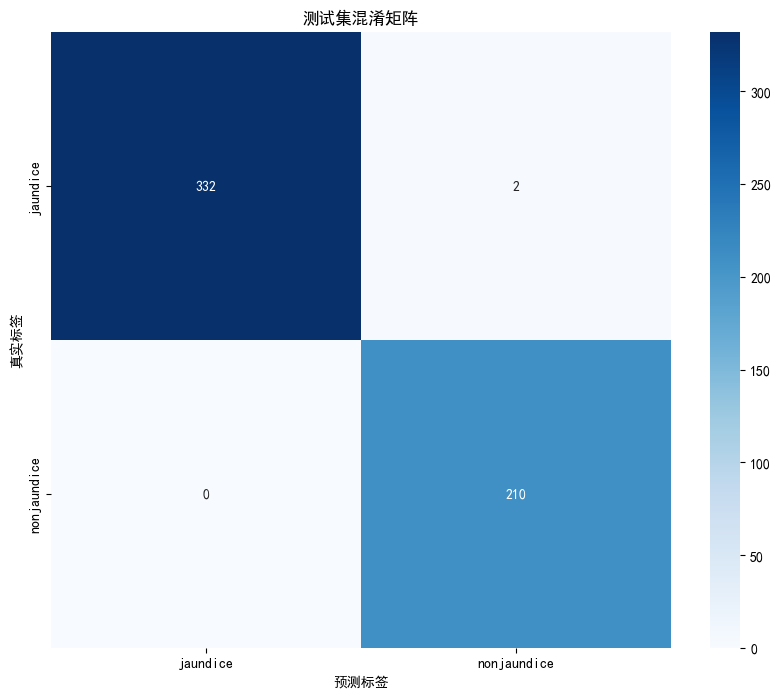

测试集分类报告:
              precision    recall  f1-score   support

    jaundice       1.00      0.99      1.00       334
 nonjaundice       0.99      1.00      1.00       210

    accuracy                           1.00       544
   macro avg       1.00      1.00      1.00       544
weighted avg       1.00      1.00      1.00       544



In [5]:
best_model_path = Path("jaundice_classification/yolo_cls_run/weights/best.pt")
if best_model_path.exists():
    trained_model = YOLO(str(best_model_path))
    print(f"加载最佳模型: {best_model_path}")
else:
    trained_model = model
    print("使用最后一次训练的模型")

# 评估模型
val_results = trained_model.val(data=dataset_path)
print(f"验证集准确率: {val_results.top1:.4f}")

# 在测试集上运行预测
print("在测试集上进行预测...")
test_dir = os.path.join(dataset_path, "test")

# 混淆矩阵可视化函数
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('预测标签')
    plt.ylabel('真实标签')
    plt.title('测试集混淆矩阵')
    plt.savefig('confusion_matrix_test.png')
    plt.show()

# 收集测试数据
y_true = []
y_pred = []
class_names = ['jaundice', 'nonjaundice']

# 遍历测试目录
for class_idx, class_name in enumerate(class_names):
    test_class_dir = os.path.join(test_dir, class_name)
    for img_file in os.listdir(test_class_dir):
        if img_file.endswith(('.jpg', '.jpeg', '.png')):
            img_path = os.path.join(test_class_dir, img_file)
            results = trained_model.predict(img_path, verbose=False)[0]
            pred_class = results.probs.top1
            y_true.append(class_idx)
            y_pred.append(pred_class)

# 计算混淆矩阵
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, class_names)

# 打印分类报告
print("测试集分类报告:")
print(classification_report(y_true, y_pred, target_names=class_names))

trained_model.save('jaundice_model_yolo.pt')

In [15]:
import cv2
import numpy as np
import mediapipe as mp
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

class MedicalGradCAM:
    """基础医学Grad-CAM类"""
    def __init__(self, model, target_layers, use_cuda=True):
        self.model = model
        self.target_layers = target_layers if isinstance(target_layers, list) else [target_layers]
        self.cuda = use_cuda and torch.cuda.is_available()
        
        self.activations_list = [None] * len(self.target_layers)
        self.gradients_list = [None] * len(self.target_layers)
        self.hooks = []
        
        self._register_hooks()
    
    def _register_hooks(self):
        for idx, layer in enumerate(self.target_layers):
            self.hooks.append(layer.register_forward_hook(
                lambda module, input, output, idx=idx: self._save_activation(module, input, output, idx)
            ))
            try:
                self.hooks.append(layer.register_full_backward_hook(
                    lambda module, grad_input, grad_output, idx=idx: self._save_gradient(module, grad_input, grad_output, idx)
                ))
            except Exception as e:
                print(f"注册梯度钩子失败: {e}")
    
    def _save_activation(self, module, input, output, layer_idx):
        if isinstance(output, tuple):
            self.activations_list[layer_idx] = output[0].detach()
        else:
            self.activations_list[layer_idx] = output.detach()
    
    def _save_gradient(self, module, grad_input, grad_output, layer_idx):
        if isinstance(grad_output, tuple):
            self.gradients_list[layer_idx] = grad_output[0].detach()
        else:
            self.gradients_list[layer_idx] = grad_output[0].detach()
    
    def _preprocess_image(self, img):
        if len(img.shape) == 3:
            img = img.copy()
        img_resized = cv2.resize(img, (224, 224))
        img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float() / 255.0
        img_tensor = img_tensor.unsqueeze(0)
        if self.cuda:
            img_tensor = img_tensor.cuda()
        return img_tensor, img_resized
    
    def _generate_cam_from_activations(self, img):
        cams_list = []
        for i, acts in enumerate(self.activations_list):
            if acts is not None:
                cam = torch.mean(acts, dim=1).squeeze()
                cam = cam.cpu().numpy()
                cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
                cam = cv2.resize(cam, (img.shape[1], img.shape[0]))
                cams_list.append(cam)
        
        if len(cams_list) > 1:
            weights = np.array([0.3, 0.7]) if len(cams_list) == 2 else np.linspace(0.2, 0.8, len(cams_list))
            weights = weights / weights.sum()
            final_cam = np.zeros_like(cams_list[0])
            for i, cam in enumerate(cams_list):
                final_cam += cam * weights[i]
        elif len(cams_list) == 1:
            final_cam = cams_list[0]
        else:
            final_cam = self._generate_color_based_cam(img)
        return final_cam
    
    def _generate_color_based_cam(self, img):
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        cr_channel = img_yuv[:,:,1].astype(float) / 255.0
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        lower_skin = np.array([0, 20, 70], dtype=np.uint8)
        upper_skin = np.array([50, 150, 255], dtype=np.uint8)
        skin_mask = cv2.inRange(hsv, lower_skin, upper_skin).astype(float) / 255.0
        combined_map = cr_channel * skin_mask
        combined_map = cv2.GaussianBlur(combined_map, (15, 15), 0)
        if combined_map.max() > combined_map.min():
            combined_map = (combined_map - combined_map.min()) / (combined_map.max() - combined_map.min())
        return combined_map
    
    def __call__(self, img, class_idx=None, colorspace_attention=True):
        img_tensor, img_resized = self._preprocess_image(img)
        temp_img_path = "temp_img_for_gradcam.jpg"
        cv2.imwrite(temp_img_path, cv2.cvtColor(img_resized, cv2.COLOR_RGB2BGR))
        results = self.model(temp_img_path)
        class_idx = int(results[0].probs.top1)
        
        try:
            final_cam = self._generate_cam_from_activations(img)
        except Exception as e:
            print(f"从激活生成CAM失败: {e}")
            final_cam = self._generate_color_based_cam(img)
        
        if colorspace_attention:
            img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            cr_channel = img_yuv[:,:,1].astype(float) / 255.0
            mask = (cr_channel > 0.5).astype(float)
            final_cam = final_cam * (1 + 0.5 * mask)
            final_cam = np.clip(final_cam, 0, 1)
        
        try:
            os.remove(temp_img_path)
        except:
            pass
            
        return final_cam, class_idx
    
    def remove_hooks(self):
        for hook in self.hooks:
            try:
                hook.remove()
            except:
                pass

class EnhancedMedicalGradCAM(MedicalGradCAM):
    """整合医学先验知识的增强版Grad-CAM"""
    
    def __init__(self, model, target_layers, use_cuda=True):
        super().__init__(model, target_layers, use_cuda)
        # 初始化眼部检测器
        self.mp_face_mesh = mp.solutions.face_mesh
        self.face_mesh = self.mp_face_mesh.FaceMesh(
            static_image_mode=True,
            max_num_faces=1,
            refine_landmarks=True,
            min_detection_confidence=0.5
        )
        
        # 眼白区域的MediaPipe索引
        self.left_eye_indices = [130, 133, 160, 159, 158, 144, 145, 153]
        self.right_eye_indices = [362, 385, 387, 373, 374, 380, 381, 382]
        
        # 黄疸医学权重 - 基于临床指南
        self.region_weights = {
            'eye_sclera': 2.5,   # 眼白区域 - 高度敏感区域
            'face_general': 1.0,  # 面部一般区域
            'background': 0.2     # 背景区域
        }
        
    def detect_eye_regions(self, img):
        """检测并返回眼白区域掩码"""
        h, w = img.shape[:2]
        results = self.face_mesh.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
        # 创建空掩码
        eye_mask = np.zeros((h, w), dtype=np.float32)
        face_mask = np.zeros((h, w), dtype=np.float32)
        
        if not results.multi_face_landmarks:
            print("未检测到面部关键点，使用默认眼部区域估计")
            # 使用图像中心上部区域作为估计的眼部位置
            center_x = w // 2
            center_y = h // 3  # 大致眼睛高度
            eye_width = w // 4
            eye_height = h // 8
            
            # 左眼区域估计
            cv2.ellipse(eye_mask, 
                       (center_x - eye_width//2, center_y),
                       (eye_width//2, eye_height//2),
                       0, 0, 360, 1, -1)
            
            # 右眼区域估计
            cv2.ellipse(eye_mask, 
                       (center_x + eye_width//2, center_y),
                       (eye_width//2, eye_height//2),
                       0, 0, 360, 1, -1)
            
            # 面部区域估计
            face_center = (w//2, h//2)
            face_radius = min(w, h) // 3
            cv2.circle(face_mask, face_center, face_radius, 1, -1)
            
            return eye_mask, face_mask
        
        # 获取面部关键点
        landmarks = results.multi_face_landmarks[0]
        
        # 绘制眼白区域
        def draw_eye_region(indices):
            points = np.array([[int(landmarks.landmark[idx].x * w), 
                              int(landmarks.landmark[idx].y * h)] 
                              for idx in indices])
            cv2.fillPoly(eye_mask, [points], 1)
            
            # 为了更准确地捕捉眼白，添加一个膨胀操作
            kernel = np.ones((5, 5), np.uint8)
            cv2.dilate(eye_mask, kernel, eye_mask)
            
            # 计算眼睛中心点，用于眼白增强
            eye_center = np.mean(points, axis=0).astype(int)
            return eye_center
            
        # 绘制左右眼区域
        left_eye_center = draw_eye_region(self.left_eye_indices)
        right_eye_center = draw_eye_region(self.right_eye_indices)
        
        # 眼白区域的颜色提取增强
        self.enhance_sclera_by_color(img, eye_mask, left_eye_center, right_eye_center)
        
        # 创建面部区域掩码 - 使用轮廓点
        face_contour_indices = [10, 338, 297, 332, 284, 251, 389, 356, 454, 323, 361, 288, 397, 365, 379, 378, 400, 377, 152, 148, 176, 149, 150, 136, 172, 58, 132, 93, 234, 127, 162, 21, 54, 103, 67, 109]
        face_points = np.array([[int(landmarks.landmark[idx].x * w), 
                              int(landmarks.landmark[idx].y * h)] 
                              for idx in face_contour_indices])
        cv2.fillPoly(face_mask, [face_points], 1)
        
        return eye_mask, face_mask
    
    def enhance_sclera_by_color(self, img, eye_mask, left_center, right_center):
        """进一步基于颜色增强眼白检测"""
        # 转换到HSV颜色空间
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # 眼白的HSV范围 - 宽松阈值以适应黄疸眼白
        lower_white = np.array([20, 0, 180], dtype=np.uint8)  # 允许较黄的色调
        upper_white = np.array([45, 60, 255], dtype=np.uint8)  # 高亮度低饱和度
        
        # 创建眼白掩码
        white_mask = cv2.inRange(hsv, lower_white, upper_white).astype(np.float32) / 255.0
        
        # 将白色掩码应用于眼睛区域
        sclera_mask = white_mask * eye_mask
        
        # 更新眼掩码 - 融合颜色检测结果和区域掩码
        eye_mask[:] = np.maximum(eye_mask, sclera_mask)
    
    def apply_medical_attention(self, cam, img):
        """基于医学先验知识应用注意力增强"""
        # 检测眼睛和面部区域
        eye_mask, face_mask = self.detect_eye_regions(img)
        
        # 创建加权掩码
        weighted_mask = np.zeros_like(eye_mask)
        weighted_mask += eye_mask * self.region_weights['eye_sclera']
        weighted_mask += face_mask * self.region_weights['face_general'] 
        weighted_mask += self.region_weights['background']  # 背景最小权重
        
        # 归一化权重掩码以保持整体范围
        if weighted_mask.max() > 0:
            weighted_mask = weighted_mask / weighted_mask.max()
        
        # 应用医学权重
        enhanced_cam = cam * weighted_mask
        
        # 应用黄疸特异性颜色检测
        enhanced_cam = self.enhance_jaundice_features(enhanced_cam, img)
        
        # 重新归一化
        if enhanced_cam.max() > enhanced_cam.min():
            enhanced_cam = (enhanced_cam - enhanced_cam.min()) / (enhanced_cam.max() - enhanced_cam.min())
        
        return enhanced_cam
    
    def enhance_jaundice_features(self, cam, img):
        """增强与黄疸相关的颜色特征"""
        # 黄疸颜色检测 - 使用HSV空间
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        
        # 提取黄色色调分量 - 黄色在HSV中的H值约为20-60
        h_channel = hsv[:,:,0].astype(np.float32)
        yellow_intensity = np.zeros_like(h_channel)
        
        # 黄色色调的强度映射
        yellow_range = (20, 60)  # 黄色的HSV色调范围
        for i in range(yellow_range[0], yellow_range[1]+1):
            # 计算该色调值与黄色中心(约40)的接近程度
            proximity = 1.0 - abs(i - 40) / 20.0  # 1.0表示完全匹配
            yellow_intensity[h_channel == i] = proximity
        
        # 融合黄疸特征和CAM
        jaundice_weighted_cam = cam * (1.0 + 0.5 * yellow_intensity)
        
        return jaundice_weighted_cam
        
    def __call__(self, img, class_idx=None, colorspace_attention=True):
        """重写调用方法以整合医学先验知识"""
        # 首先获取基础CAM
        cam, class_idx = super().__call__(img, class_idx, colorspace_attention)
        
        # 应用医学专业增强
        enhanced_cam = self.apply_medical_attention(cam, img)
        
        return enhanced_cam, class_idx

def find_medical_feature_layers(model):
    """查找最适合医学特征提取的层"""
    medical_layers = []
    
    # 查找候选层
    candidates = []
    for name, module in model.model.named_modules():
        if isinstance(module, torch.nn.Conv2d) and module.out_channels > 128:
            print(f"找到候选层: {name} (通道数: {module.out_channels})")
            candidates.append((name, module))
    
    # 如果找到了足够的层，选择中间层和深层
    if len(candidates) >= 10:
        # 一个中间层 - 负责捕捉颜色和纹理
        mid_layer_idx = len(candidates) // 3 * 2  # 选择靠后的中间层
        # 一个深层 - 负责高级语义
        deep_layer_idx = -2  # 倒数第二层
        
        medical_layers = [
            candidates[mid_layer_idx][1],
            candidates[deep_layer_idx][1]
        ]
    else:
        # 如果层数不够，取可用的
        if candidates:
            if len(candidates) >= 2:
                medical_layers = [candidates[0][1], candidates[-1][1]]
            else:
                medical_layers = [candidates[0][1]]
    
    print(f"选择了 {len(medical_layers)} 个医学特征层")
    return medical_layers

def apply_colormap(cam, img):
    """将热力图应用到原始图像上"""
    height, width, _ = img.shape
    cam = cv2.resize(cam, (width, height))
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # 叠加热力图和原始图像
    alpha = 0.5
    superimposed = heatmap * alpha + img * (1 - alpha)
    superimposed = np.uint8(superimposed)
    
    return superimposed, heatmap

def visualize_enhanced_medical_gradcam(model_path, image_path, output_dir="output"):
    """对单张图像生成增强医学Grad-CAM可视化"""
    # 确保输出目录存在
    os.makedirs(output_dir, exist_ok=True)
    
    # 加载模型
    model = YOLO(model_path)
    print(f"成功加载模型: {model_path}")
    
    # 找到适合的层
    medical_layers = find_medical_feature_layers(model)
    
    # 初始化标准和增强版医学Grad-CAM
    std_grad_cam = MedicalGradCAM(model, medical_layers)
    enh_grad_cam = EnhancedMedicalGradCAM(model, medical_layers)
    
    # 读取图像
    img = cv2.imread(image_path)
    if img is None:
        print(f"无法读取图像: {image_path}")
        return
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # 获取模型预测
    result = model(image_path)
    pred_class = result[0].names[result[0].probs.top1]
    confidence = result[0].probs.top1conf.item()
    
    # 生成标准CAM
    standard_cam, _ = std_grad_cam(img, colorspace_attention=False)
    
    # 生成医学增强CAM
    enhanced_cam, _ = enh_grad_cam(img)
    
    # 应用热力图
    std_overlay, std_heatmap = apply_colormap(standard_cam, img)
    enh_overlay, enh_heatmap = apply_colormap(enhanced_cam, img)
    
    # 可视化
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # 原图
    axes[0].imshow(img)
    axes[0].set_title(f"原图\n预测: {pred_class} ({confidence:.2f})")
    axes[0].axis("off")
    
    # 标准热力图
    axes[1].imshow(std_heatmap)
    axes[1].set_title("标准热力图")
    axes[1].axis("off")
    
    # 增强热力图
    axes[2].imshow(enh_heatmap)
    axes[2].set_title("医学眼白增强热力图")
    axes[2].axis("off")
    
    # 增强热力图叠加
    axes[3].imshow(enh_overlay)
    axes[3].set_title("叠加增强热力图")
    axes[3].axis("off")
    
    # 保存图像
    base_name = os.path.basename(image_path).split('.')[0]
    output_path = os.path.join(output_dir, f"{base_name}_enhanced_medical_gradcam.png")
    plt.tight_layout()
    plt.savefig(output_path)
    print(f"结果已保存到: {output_path}")
    
    # 显示结果
    plt.show()
    
    # 清理钩子
    std_grad_cam.remove_hooks()
    enh_grad_cam.remove_hooks()
    
    return {
        "prediction": pred_class,
        "confidence": confidence,
        "output_path": output_path
    }

def process_folder(model_path, input_dir, output_dir="batch_output"):
    """批量处理文件夹中的图像"""
    os.makedirs(output_dir, exist_ok=True)
    
    # 加载模型
    model = YOLO(model_path)
    print(f"成功加载模型: {model_path}")
    
    # 找到适合的层
    medical_layers = find_medical_feature_layers(model)
    
    # 初始化增强版医学Grad-CAM
    enh_grad_cam = EnhancedMedicalGradCAM(model, medical_layers)
    
    # 获取所有图像文件
    image_files = [f for f in os.listdir(input_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    
    results = []
    for img_file in image_files:
        try:
            image_path = os.path.join(input_dir, img_file)
            print(f"处理图像: {image_path}")
            
            # 读取图像
            img = cv2.imread(image_path)
            if img is None:
                print(f"无法读取图像: {image_path}")
                continue
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # 模型预测
            result = model(image_path)
            pred_class = result[0].names[result[0].probs.top1]
            confidence = result[0].probs.top1conf.item()
            
            # 生成医学增强CAM
            enhanced_cam, _ = enh_grad_cam(img)
            
            # 应用热力图
            enh_overlay, enh_heatmap = apply_colormap(enhanced_cam, img)
            
            # 可视化
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
            # 原图
            axes[0].imshow(img)
            axes[0].set_title(f"原图\n预测: {pred_class} ({confidence:.2f})")
            axes[0].axis("off")
            
            # 增强热力图
            axes[1].imshow(enh_heatmap)
            axes[1].set_title("医学眼白增强热力图")
            axes[1].axis("off")
            
            # 增强热力图叠加
            axes[2].imshow(enh_overlay)
            axes[2].set_title("叠加增强热力图")
            axes[2].axis("off")
            
            # 保存图像
            base_name = os.path.splitext(img_file)[0]
            output_path = os.path.join(output_dir, f"{base_name}_enhanced_medical_gradcam.png")
            plt.tight_layout()
            plt.savefig(output_path)
            plt.close(fig)  # 关闭图形以释放内存
            
            results.append({
                "image": img_file,
                "prediction": pred_class,
                "confidence": confidence,
                "output_path": output_path
            })
            
        except Exception as e:
            print(f"处理图像 {img_file} 时出错: {e}")
    
    # 清理钩子
    enh_grad_cam.remove_hooks()
    
    print(f"已完成 {len(results)} 张图像的处理")
    return results



处理 jaundice 类别的样本图片...
处理图片: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230825_172318_frame_203.png
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层

image 1/1 C:\Users\MichaelY\Desktop\jaundice_vi

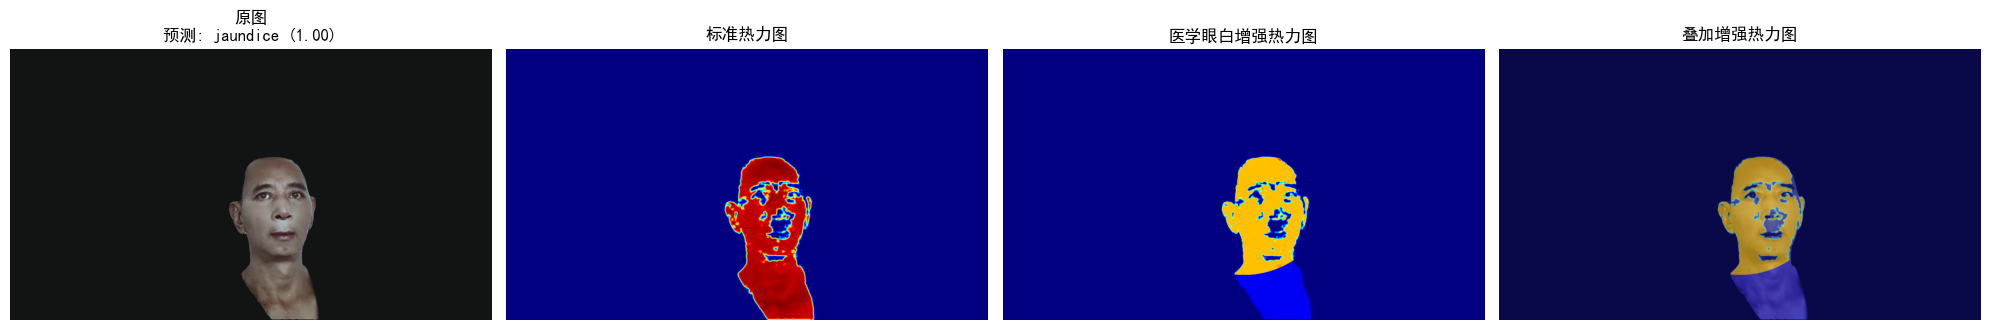

预测: jaundice, 置信度: 1.0000
处理图片: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231029_182603_frame_196.png
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层

image 1/1 C:\Users\MichaelY\Desktop\jaundice_

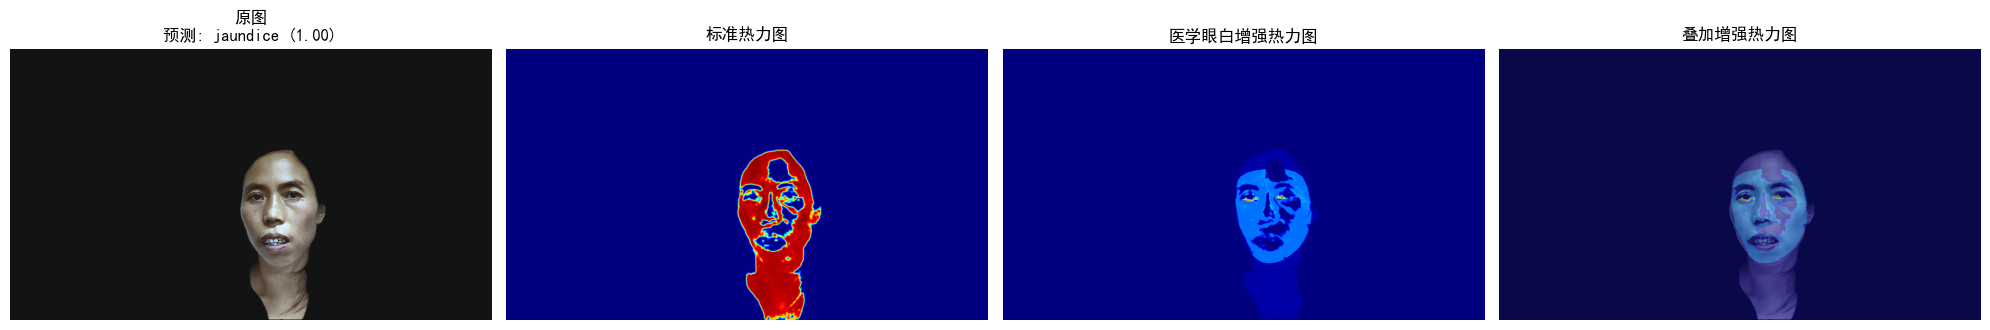

预测: jaundice, 置信度: 1.0000
处理图片: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230724_170314_frame_133.png
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层

image 1/1 C:\Users\MichaelY\Desktop\jaundice_

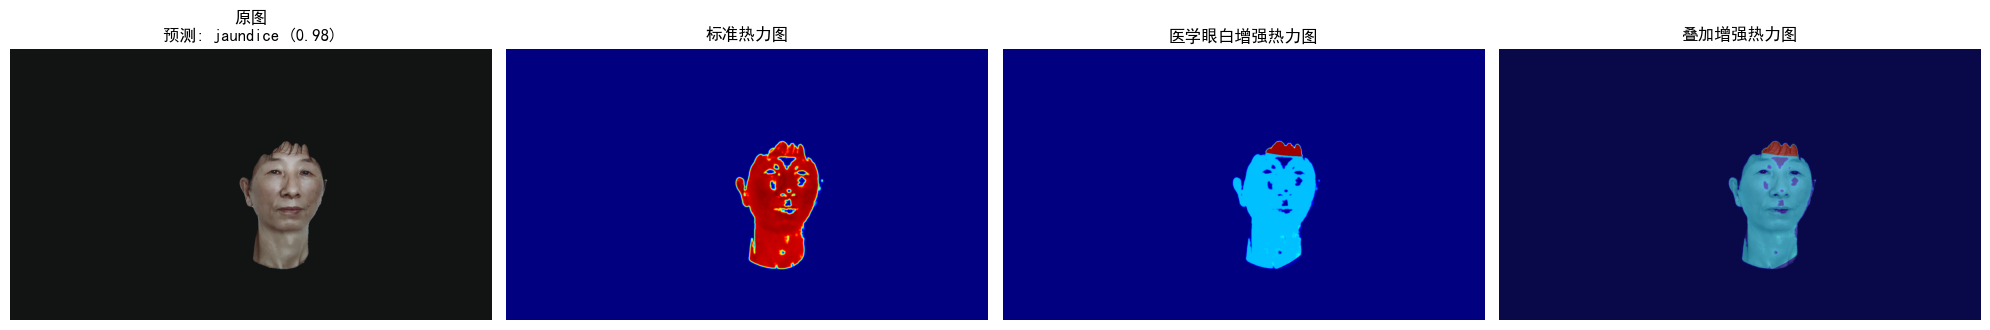

预测: jaundice, 置信度: 0.9798

处理 nonjaundice 类别的样本图片...
处理图片: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_205454_frame_230.png
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层

image 1/1 C:

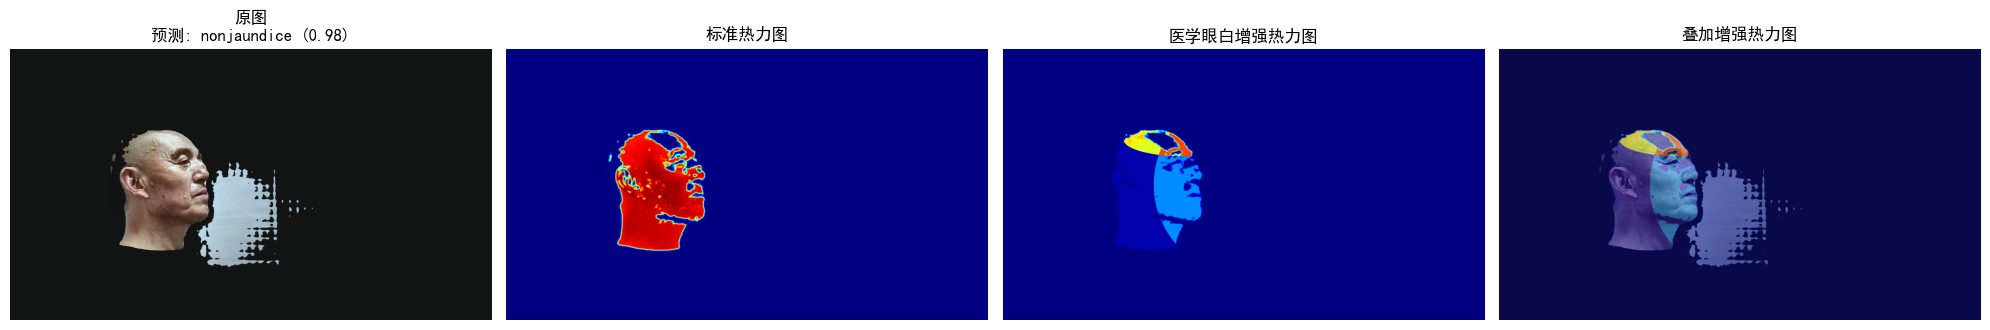

预测: nonjaundice, 置信度: 0.9817
处理图片: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_192210_26_video_frame_294.png
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层

image 1/1 C:\Users\MichaelY

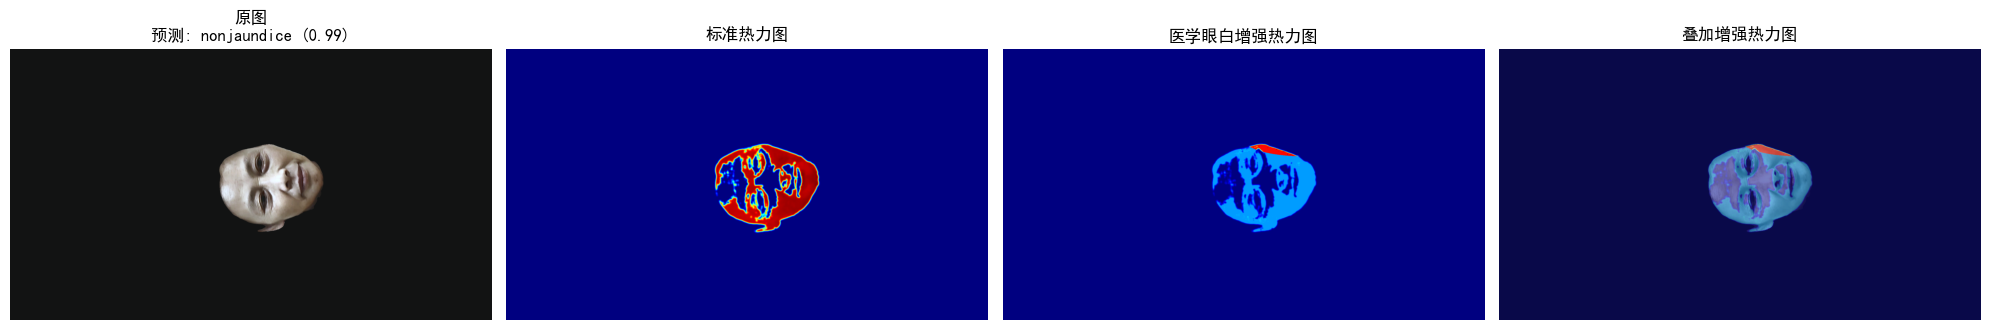

预测: nonjaundice, 置信度: 0.9919
处理图片: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_203423_frame_114.png
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层

image 1/1 C:\Users\MichaelY\Desktop\

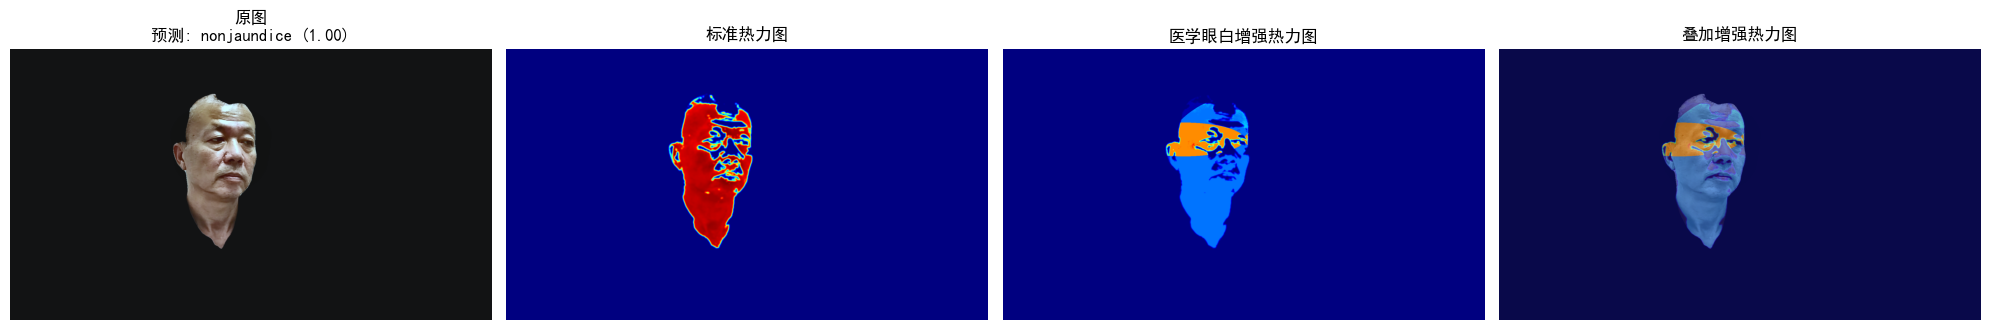

预测: nonjaundice, 置信度: 0.9996


In [16]:
import os
import random
from pathlib import Path

# 模型路径 - 修改为您训练好的模型路径
model_path = 'jaundice_classification/yolo_cls_run/weights/best.pt'

# 数据集路径
dataset_path = r"C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset"
test_path = os.path.join(dataset_path, "test")

# 输出目录
output_base = "jaundice_gradcam_results"
os.makedirs(output_base, exist_ok=True)

# 随机选择一些图片进行单图分析
def process_random_samples():
    # 为每个类别创建输出目录
    jaundice_output = os.path.join(output_base, "jaundice")
    nonjaundice_output = os.path.join(output_base, "nonjaundice")
    os.makedirs(jaundice_output, exist_ok=True)
    os.makedirs(nonjaundice_output, exist_ok=True)
    
    # 处理每个类别中的随机图片
    classes = ["jaundice", "nonjaundice"]
    for cls in classes:
        class_dir = os.path.join(test_path, cls)
        images = [f for f in os.listdir(class_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
        
        if not images:
            print(f"警告: 在 {class_dir} 中未找到图片")
            continue
            
        # 选择3张随机图片
        samples = random.sample(images, min(3, len(images)))
        
        print(f"\n处理 {cls} 类别的样本图片...")
        for img_file in samples:
            img_path = os.path.join(class_dir, img_file)
            output_dir = jaundice_output if cls == "jaundice" else nonjaundice_output
            
            print(f"处理图片: {img_path}")
            result = visualize_enhanced_medical_gradcam(
                model_path, 
                img_path,
                output_dir
            )
            print(f"预测: {result['prediction']}, 置信度: {result['confidence']:.4f}")

# 批量处理所有测试图片
def process_all_test_images():
    print("\n批量处理所有测试图片...")
    
    # 处理黄疸测试图片
    jaundice_dir = os.path.join(test_path, "jaundice")
    jaundice_output = os.path.join(output_base, "batch_jaundice")
    print(f"处理所有黄疸测试图片...")
    jaundice_results = process_folder(model_path, jaundice_dir, jaundice_output)
    
    # 处理非黄疸测试图片
    nonjaundice_dir = os.path.join(test_path, "nonjaundice")
    nonjaundice_output = os.path.join(output_base, "batch_nonjaundice")
    print(f"处理所有非黄疸测试图片...")
    nonjaundice_results = process_folder(model_path, nonjaundice_dir, nonjaundice_output)
    
    # 打印结果摘要
    print("\n结果摘要:")
    print(f"黄疸图片: {len(jaundice_results)} 张, 正确识别: {sum(1 for r in jaundice_results if r['prediction'] == 'jaundice')} 张")
    print(f"非黄疸图片: {len(nonjaundice_results)} 张, 正确识别: {sum(1 for r in nonjaundice_results if r['prediction'] == 'nonjaundice')} 张")

if __name__ == "__main__":
    # 检查模型路径是否存在
    if not Path(model_path).exists():
        print(f"模型文件 {model_path} 不存在！请检查路径")
        # 尝试查找最佳模型
        alt_paths = ["jaundice_model_yolo.pt", Path("jaundice_classification") / "yolo_cls_run" / "weights" / "best.pt"]
        for alt_path in alt_paths:
            if Path(alt_path).exists():
                model_path = str(alt_path)
                print(f"找到替代模型: {model_path}")
                break
    
    # 检查数据集路径
    if not all(os.path.exists(os.path.join(test_path, cls)) for cls in ["jaundice", "nonjaundice"]):
        print(f"错误：无法找到测试数据集路径或其子目录。请检查 {test_path} 是否存在并包含jaundice和nonjaundice子目录")
        exit(1)
    
    # 1. 先处理部分随机样本进行可视化分析
    process_random_samples()


In [17]:
# 2. 询问用户是否要处理所有测试图片
response = input("\n是否处理所有测试图片？这可能需要较长时间 (y/n): ")
if response.lower() == 'y':
    process_all_test_images()
    
print(f"\n所有结果已保存到 {os.path.abspath(output_base)} 目录")


是否处理所有测试图片？这可能需要较长时间 (y/n): y

批量处理所有测试图片...
处理所有黄疸测试图片...
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m.0.attn.pe.conv (通道数: 256)
找到候选层: model.9.m.0.ffn.0.conv (通道数: 512)
找到候选层: model.9.m.0.ffn.1.conv (通道数: 256)
找到候选层: model.10.conv.conv (通道数: 1280)
选择了 2 个医学特征层
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230702_150921_frame_100.png

image 1/1 C

Speed: 11.2ms preprocess, 32.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 13.7ms
Speed: 1.9ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230707_132936_frame_120.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230707_132936_frame_120.png: 224x224 jaundice 1.00, nonjaundice 0.00, 9.6ms
Speed: 9.1ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 13.9ms
Speed: 2.2ms preprocess, 13.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230707_132936_frame_144.png

imag

Speed: 9.3ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.99, nonjaundice 0.01, 17.1ms
Speed: 2.2ms preprocess, 17.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230707_185544_frame_50.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230707_185544_frame_50.png: 224x224 jaundice 0.99, nonjaundice 0.01, 10.7ms
Speed: 9.1ms preprocess, 10.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.60, nonjaundice 0.40, 16.4ms
Speed: 2.0ms preprocess, 16.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundic

Speed: 9.4ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.80, nonjaundice 0.20, 5.6ms
Speed: 1.7ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230721_173559_frame_310.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230721_173559_frame_310.png: 224x224 jaundice 1.00, nonjaundice 0.00, 5.5ms
Speed: 9.2ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.96, nonjaundice 0.04, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID

Speed: 11.9ms preprocess, 6.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.89, nonjaundice 0.11, 6.0ms
Speed: 1.8ms preprocess, 6.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230815_134516_frame_154.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230815_134516_frame_154.png: 224x224 jaundice 1.00, nonjaundice 0.00, 4.5ms
Speed: 9.3ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.99, nonjaundice 0.01, 2.9ms
Speed: 1.6ms preprocess, 2.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VI

Speed: 9.2ms preprocess, 3.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.97, nonjaundice 0.03, 3.6ms
Speed: 1.7ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230818_132234_frame_42.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230818_132234_frame_42.png: 224x224 jaundice 1.00, nonjaundice 0.00, 2.9ms
Speed: 9.0ms preprocess, 2.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 5.5ms
Speed: 1.9ms preprocess, 5.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_2

Speed: 10.5ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230827_152451_frame_176.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230827_152451_frame_176.png: 224x224 jaundice 1.00, nonjaundice 0.00, 12.3ms
Speed: 9.9ms preprocess, 12.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230827_152451

Speed: 10.5ms preprocess, 11.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.99, nonjaundice 0.01, 16.7ms
Speed: 1.9ms preprocess, 16.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230902_130313_frame_90.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20230902_130313_frame_90.png: 224x224 jaundice 0.98, nonjaundice 0.02, 10.8ms
Speed: 12.1ms preprocess, 10.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.98, nonjaundice 0.02, 10.5ms
Speed: 2.1ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaund

Speed: 9.8ms preprocess, 24.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.99, nonjaundice 0.01, 48.9ms
Speed: 2.2ms preprocess, 48.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231005_164753_frame_72.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231005_164753_frame_72.png: 224x224 jaundice 1.00, nonjaundice 0.00, 15.1ms
Speed: 9.4ms preprocess, 15.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 30.2ms
Speed: 2.1ms preprocess, 30.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231005_164753

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231020_132619_frame_60.png: 224x224 jaundice 0.65, nonjaundice 0.35, 16.9ms
Speed: 9.6ms preprocess, 16.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.90, nonjaundice 0.10, 11.0ms
Speed: 1.8ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231020_132619_frame_75.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231020_132619_frame_75.png: 224x224 jaundice 0.92, nonjaundice 0.08, 15.0ms
Speed: 9.9ms preprocess, 15.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 13.9ms
Speed: 2.1ms preprocess, 13.9m

处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231021_181839_frame_297.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231021_181839_frame_297.png: 224x224 jaundice 1.00, nonjaundice 0.00, 6.0ms
Speed: 11.7ms preprocess, 6.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 4.5ms
Speed: 2.1ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231021_181839_frame_330.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231021_181839_frame_330.png: 224x224 jaundice 1.00, nonjaundice 0.00, 5.2ms
Speed: 9.5ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\User

处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231029_175144_frame_208.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231029_175144_frame_208.png: 224x224 jaundice 1.00, nonjaundice 0.00, 10.6ms
Speed: 9.1ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 15.0ms
Speed: 1.9ms preprocess, 15.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231029_175144_frame_234.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231029_175144_frame_234.png: 224x224 jaundice 1.00, nonjaundice 0.00, 10.5ms
Speed: 12.5ms preprocess, 10.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp

未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231102_191924_frame_160.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231102_191924_frame_160.png: 224x224 jaundice 0.99, nonjaundice 0.01, 8.3ms
Speed: 9.2ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.98, nonjaundice 0.02, 9.0ms
Speed: 2.1ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231102_191924_frame_32.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231102_191924_frame_32.png: 224x224 jaundice 1.00, nonjaundice 0.00, 9.7ms
Speed: 8.9ms preprocess, 9.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)



image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 3.8ms
Speed: 1.7ms preprocess, 3.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231105_174950_frame_133.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231105_174950_frame_133.png: 224x224 jaundice 1.00, nonjaundice 0.00, 3.7ms
Speed: 9.4ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 3.7ms
Speed: 1.8ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231105_174950_frame_152.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231105_174950_


image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 4.1ms
Speed: 2.0ms preprocess, 4.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231114_133821_frame_168.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231114_133821_frame_168.png: 224x224 jaundice 1.00, nonjaundice 0.00, 5.1ms
Speed: 9.9ms preprocess, 5.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231114_133821_frame_192.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\t

Speed: 9.4ms preprocess, 20.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 12.5ms
Speed: 2.0ms preprocess, 12.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231122_133828_frame_128.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231122_133828_frame_128.png: 224x224 jaundice 1.00, nonjaundice 0.00, 10.6ms
Speed: 9.1ms preprocess, 10.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 13.9ms
Speed: 2.1ms preprocess, 13.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231122_1338

Speed: 9.3ms preprocess, 2.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.98, nonjaundice 0.02, 3.0ms
Speed: 1.8ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231122_134418_frame_84.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20231122_134418_frame_84.png: 224x224 jaundice 1.00, nonjaundice 0.00, 3.2ms
Speed: 10.3ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_

Speed: 12.5ms preprocess, 7.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240108_130243_frame_115.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240108_130243_frame_115.png: 224x224 jaundice 0.98, nonjaundice 0.02, 3.4ms
Speed: 9.8ms preprocess, 3.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.90, nonjaundice 0.10, 3.2ms
Speed: 1.7ms preprocess, 3.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240108_130243_frame_138.png

image 1/1

Speed: 12.6ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240115_133616_frame_23.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240115_133616_frame_23.png: 224x224 jaundice 1.00, nonjaundice 0.00, 3.1ms
Speed: 10.4ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 6.5ms
Speed: 1.7ms preprocess, 6.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240115_133616_fram

Speed: 10.5ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240329_133625_frame_30.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240329_133625_frame_30.png: 224x224 jaundice 1.00, nonjaundice 0.00, 6.9ms
Speed: 11.9ms preprocess, 6.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240329_133625_fram

Speed: 9.6ms preprocess, 9.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 14.9ms
Speed: 1.9ms preprocess, 14.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240511_130005_frame_117.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240511_130005_frame_117.png: 224x224 jaundice 1.00, nonjaundice 0.00, 20.8ms
Speed: 12.0ms preprocess, 20.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 20.1ms
Speed: 2.1ms preprocess, 20.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240511_130005_frame_52.png

imag

Speed: 13.4ms preprocess, 5.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240512_180329_frame_153.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240512_180329_frame_153.png: 224x224 jaundice 1.00, nonjaundice 0.00, 4.9ms
Speed: 9.3ms preprocess, 4.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240512_180329_frame_170.png

image 1/1

Speed: 10.2ms preprocess, 19.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 15.1ms
Speed: 2.1ms preprocess, 15.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240523_132859_frame_70.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240523_132859_frame_70.png: 224x224 jaundice 1.00, nonjaundice 0.00, 7.4ms
Speed: 8.9ms preprocess, 7.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 22.3ms
Speed: 2.1ms preprocess, 22.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240523_132859_frame_84.png

image 1

Speed: 8.9ms preprocess, 13.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 21.3ms
Speed: 2.4ms preprocess, 21.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240611_200659_frame_56.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundice_VID_20240611_200659_frame_56.png: 224x224 jaundice 1.00, nonjaundice 0.00, 18.7ms
Speed: 9.5ms preprocess, 18.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 1.00, nonjaundice 0.00, 16.9ms
Speed: 2.2ms preprocess, 16.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\jaundice\jaundic

Speed: 9.5ms preprocess, 15.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 jaundice 0.99, nonjaundice 0.01, 21.9ms
Speed: 2.0ms preprocess, 21.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
已完成 334 张图像的处理
处理所有非黄疸测试图片...
成功加载模型: jaundice_classification/yolo_cls_run/weights/best.pt
找到候选层: model.2.cv2.conv (通道数: 256)
找到候选层: model.3.conv (通道数: 256)
找到候选层: model.4.cv1.conv (通道数: 256)
找到候选层: model.4.cv2.conv (通道数: 512)
找到候选层: model.5.conv (通道数: 512)
找到候选层: model.6.cv1.conv (通道数: 512)
找到候选层: model.6.cv2.conv (通道数: 512)
找到候选层: model.6.m.0.cv3.conv (通道数: 256)
找到候选层: model.7.conv (通道数: 512)
找到候选层: model.8.cv1.conv (通道数: 512)
找到候选层: model.8.cv2.conv (通道数: 512)
找到候选层: model.8.m.0.cv3.conv (通道数: 256)
找到候选层: model.9.cv1.conv (通道数: 512)
找到候选层: model.9.cv2.conv (通道数: 512)
找到候选层: model.9.m.0.attn.qkv.conv (通道数: 512)
找到候选层: model.9.m.0.attn.proj.conv (通道数: 256)
找到候选层: model.9.m

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_185241_21_video_frame_156.png: 224x224 nonjaundice 0.99, jaundice 0.01, 6.7ms
Speed: 9.1ms preprocess, 6.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.98, jaundice 0.02, 5.6ms
Speed: 2.1ms preprocess, 5.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_185241_21_video_frame_195.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_185241_21_video_frame_195.png: 224x224 nonjaundice 0.98, jaundice 0.02, 6.2ms
Speed: 9.8ms preprocess, 6.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.92, jaundice 0

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_193955_29_video_frame_90.png: 224x224 nonjaundice 0.98, jaundice 0.02, 5.2ms
Speed: 9.8ms preprocess, 5.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.95, jaundice 0.05, 4.7ms
Speed: 1.5ms preprocess, 4.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_200341_35_video_frame_135.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230206_200341_35_video_frame_135.png: 224x224 nonjaundice 1.00, jaundice 0.00, 3.7ms
Speed: 9.2ms preprocess, 3.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 4.8ms
Speed: 2.0m

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230209_182930_41_video_frame_168.png: 224x224 nonjaundice 1.00, jaundice 0.00, 16.4ms
Speed: 10.9ms preprocess, 16.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 14.2ms
Speed: 2.5ms preprocess, 14.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230209_182930_41_video_frame_192.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230209_182930_41_video_frame_192.png: 224x224 nonjaundice 1.00, jaundice 0.00, 6.7ms
Speed: 11.5ms preprocess, 6.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.97, jaun

Speed: 8.7ms preprocess, 13.7ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.88, jaundice 0.12, 16.1ms
Speed: 2.0ms preprocess, 16.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230219_180724_67_video_frame_110.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230219_180724_67_video_frame_110.png: 224x224 nonjaundice 1.00, jaundice 0.00, 9.3ms
Speed: 11.7ms preprocess, 9.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.98, jaundice 0.02, 12.9ms
Speed: 1.9ms preprocess, 12.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjau

Speed: 2.0ms preprocess, 11.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230219_183208_70_video_frame_133.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230219_183208_70_video_frame_133.png: 224x224 nonjaundice 1.00, jaundice 0.00, 6.5ms
Speed: 10.9ms preprocess, 6.5ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 4.6ms
Speed: 2.3ms preprocess, 4.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230219_183208_70_video_frame_19.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_DJI_20230219_183208_70_video

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0200_frame_1098.png: 224x224 nonjaundice 1.00, jaundice 0.00, 31.3ms
Speed: 8.9ms preprocess, 31.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 13.6ms
Speed: 1.9ms preprocess, 13.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0200_frame_1281.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0200_frame_1281.png: 224x224 nonjaundice 1.00, jaundice 0.00, 80.7ms
Speed: 10.2ms preprocess, 80.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.95, jaundice 0.05, 13.9ms
Speed: 2.4ms preprocess, 13.9ms infere

Speed: 10.2ms preprocess, 12.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 29.7ms
Speed: 2.6ms preprocess, 29.7ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0204_frame_936.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0204_frame_936.png: 224x224 nonjaundice 1.00, jaundice 0.00, 9.4ms
Speed: 9.2ms preprocess, 9.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 13.3ms
Speed: 2.0ms preprocess, 13.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_I

Speed: 9.5ms preprocess, 12.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.97, jaundice 0.03, 15.2ms
Speed: 2.2ms preprocess, 15.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0314_frame_783.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0314_frame_783.png: 224x224 nonjaundice 0.96, jaundice 0.04, 9.0ms
Speed: 9.8ms preprocess, 9.0ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.96, jaundice 0.04, 12.8ms
Speed: 2.3ms preprocess, 12.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_0315_frame_1125.png

Speed: 9.2ms preprocess, 8.4ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 10.3ms
Speed: 2.1ms preprocess, 10.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_5498_frame_114.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_5498_frame_114.png: 224x224 nonjaundice 0.83, jaundice 0.17, 8.3ms
Speed: 12.6ms preprocess, 8.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.84, jaundice 0.16, 8.2ms
Speed: 2.0ms preprocess, 8.2ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_

Speed: 12.1ms preprocess, 9.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.97, jaundice 0.03, 10.9ms
Speed: 2.1ms preprocess, 10.9ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_7162_frame_72.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_IMG_7162_frame_72.png: 224x224 nonjaundice 0.99, jaundice 0.01, 39.3ms
Speed: 10.8ms preprocess, 39.3ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.85, jaundice 0.15, 21.6ms
Speed: 2.4ms preprocess, 21.6ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_I

Speed: 9.3ms preprocess, 3.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 3.1ms
Speed: 2.2ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230511_122842_frame_136.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230511_122842_frame_136.png: 224x224 nonjaundice 1.00, jaundice 0.00, 4.3ms
Speed: 9.2ms preprocess, 4.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 3.9ms
Speed: 1.8ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundi

未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230515_204132_frame_72.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230515_204132_frame_72.png: 224x224 nonjaundice 1.00, jaundice 0.00, 18.0ms
Speed: 9.9ms preprocess, 18.0ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 30.4ms
Speed: 2.0ms preprocess, 30.4ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230515_204132_frame_96.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230515_204132_frame_96.png: 224x224 nonjaundice 1.00, jaundice 0.00, 10.5ms
Speed: 9.2ms preprocess, 10.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224

Speed: 14.1ms preprocess, 6.1ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.96, jaundice 0.04, 6.1ms
Speed: 2.9ms preprocess, 6.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_203423_frame_114.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_203423_frame_114.png: 224x224 nonjaundice 1.00, jaundice 0.00, 3.1ms
Speed: 12.3ms preprocess, 3.1ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaun

未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_205454_frame_69.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_205454_frame_69.png: 224x224 nonjaundice 1.00, jaundice 0.00, 53.8ms
Speed: 9.7ms preprocess, 53.8ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 11.6ms
Speed: 2.0ms preprocess, 11.6ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_205454_frame_92.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230523_205454_frame_92.png: 224x224 nonjaundice 1.00, jaundice 0.00, 4.5ms
Speed: 9.7ms preprocess, 4.5ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 

Speed: 9.5ms preprocess, 3.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 1.00, jaundice 0.00, 5.9ms
Speed: 2.2ms preprocess, 5.9ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230530_204502_frame_104.png

image 1/1 C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaundice\nonjaundice_VID_20230530_204502_frame_104.png: 224x224 nonjaundice 1.00, jaundice 0.00, 4.8ms
Speed: 11.0ms preprocess, 4.8ms inference, 0.0ms postprocess per image at shape (1, 3, 224, 224)

image 1/1 C:\Users\MichaelY\temp_img_for_gradcam.jpg: 224x224 nonjaundice 0.99, jaundice 0.01, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)
未检测到面部关键点，使用默认眼部区域估计
处理图像: C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset\test\nonjaund

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve,average_precision_score
)


In [4]:
# 路径配置
yolo_model_path = 'jaundice_classification/yolo_cls_run/weights/best.pt' 
dataset_path =  r"C:\Users\MichaelY\Desktop\jaundice_video\cls_dataset"
test_dir = os.path.join(dataset_path, "test")
train_dir = os.path.join(dataset_path, "train")
class_names = ['jaundice', 'nonjaundice']  


In [5]:
def extract_color_histogram(img_path):
    img = cv2.imread(img_path)
    if img is None:
        return np.zeros(256*3)
    img = cv2.resize(img, (224, 224))
    chans = cv2.split(img)
    features = []
    for chan in chans:
        hist = cv2.calcHist([chan], [0], None, [256], [0, 256])
        hist = cv2.normalize(hist, hist).flatten()
        features.extend(hist)
    return np.array(features)

def get_image_paths_and_labels(base_dir):
    paths, labels = [], []
    for label, cls in enumerate(class_names):
        dir_path = os.path.join(base_dir, cls)
        for fname in os.listdir(dir_path):
            if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(dir_path, fname))
                labels.append(label)
    return paths, labels

# 训练集
X_train_paths, y_train = get_image_paths_and_labels(train_dir)
X_train = np.array([extract_color_histogram(p) for p in X_train_paths])

# 测试集
X_test_paths, y_test = get_image_paths_and_labels(test_dir)
X_test = np.array([extract_color_histogram(p) for p in X_test_paths])


In [6]:
# 加载YOLO模型
yolo_model = YOLO(yolo_model_path)

yolo_y_true = []
yolo_y_pred = []
yolo_y_prob = []

for idx, img_path in enumerate(X_test_paths):
    results = yolo_model.predict(img_path, verbose=False)[0]
    probs = results.probs.data.cpu().numpy()  # probs[0]=jaundice, probs[1]=nonjaundice
    pred_class = np.argmax(probs)
    prob = probs[1]  # jaundice的概率
    yolo_y_true.append(y_test[idx])
    yolo_y_pred.append(pred_class)
    yolo_y_prob.append(prob)


In [7]:
# XGBoost
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)
y_xgb_pred = xgb.predict(X_test)
y_xgb_prob = xgb.predict_proba(X_test)[:, 1]  # 1为nonjaundice概率

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
y_rf_pred = rf.predict(X_test)
y_rf_prob = rf.predict_proba(X_test)[:, 1]

# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)
y_svm_pred = svm.predict(X_test)
y_svm_prob = svm.predict_proba(X_test)[:, 1]


D:\Anaconda\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [15:57:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [8]:
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, precision_recall_curve)

def compute_metrics(y_true, y_pred, y_prob, positive_label=0):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate precision-recall curve values
    precision, recall, _ = precision_recall_curve(y_true, y_prob, pos_label=positive_label)
    
    return {
        "准确率": accuracy_score(y_true, y_pred),
        "精确率": precision_score(y_true, y_pred, pos_label=positive_label),
        "敏感度": recall_score(y_true, y_pred, pos_label=positive_label),
        "特异度": tn / (tn + fp),
        "F1分数": f1_score(y_true, y_pred, pos_label=positive_label),
        "AUC": roc_auc_score(y_true, y_prob),
        "FPR": roc_curve(y_true, y_prob, pos_label=positive_label)[0],
        "TPR": roc_curve(y_true, y_prob, pos_label=positive_label)[1],
        "AP": average_precision_score(y_true, y_prob),  # Average precision
        "Recall_curve": recall,  # Save recall values for PRC curve
        "Precision_curve": precision  # Save precision values for PRC curve
    }

# Initialize the dictionary only once
metrics_dict = {}

# Compute metrics for each model
metrics_dict['YOLO'] = compute_metrics(yolo_y_true, yolo_y_pred, yolo_y_prob, positive_label=1)
metrics_dict['XGBoost'] = compute_metrics(y_test, y_xgb_pred, y_xgb_prob, positive_label=1)
metrics_dict['RF'] = compute_metrics(y_test, y_rf_pred, y_rf_prob, positive_label=1)
metrics_dict['SVM'] = compute_metrics(y_test, y_svm_pred, y_svm_prob, positive_label=1)

# Print the metrics for verification
print(metrics_dict)

{'YOLO': {'准确率': 0.9963235294117647, '精确率': 0.9905660377358491, '敏感度': 1.0, '特异度': 0.9940119760479041, 'F1分数': 0.9952606635071091, 'AUC': 0.9995722840034217, 'FPR': array([          0,           0,           0,    0.002994,    0.002994,    0.005988,    0.005988,           1]), 'TPR': array([          0,   0.0047619,     0.91429,     0.91429,     0.94286,     0.94286,           1,           1]), 'AP': 0.9993009908873502, 'Recall_curve': array([          1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,
                 1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1,           1, 

In [9]:
metrics_dict = {}
metrics_dict['YOLO'] = compute_metrics(
    yolo_y_true, yolo_y_pred, yolo_y_prob, positive_label=1
)
metrics_dict['XGBoost'] = compute_metrics(y_test, y_xgb_pred, y_xgb_prob, positive_label=1)
metrics_dict['RF'] = compute_metrics(y_test, y_rf_pred, y_rf_prob, positive_label=1)
metrics_dict['SVM'] = compute_metrics(y_test, y_svm_pred, y_svm_prob, positive_label=1)

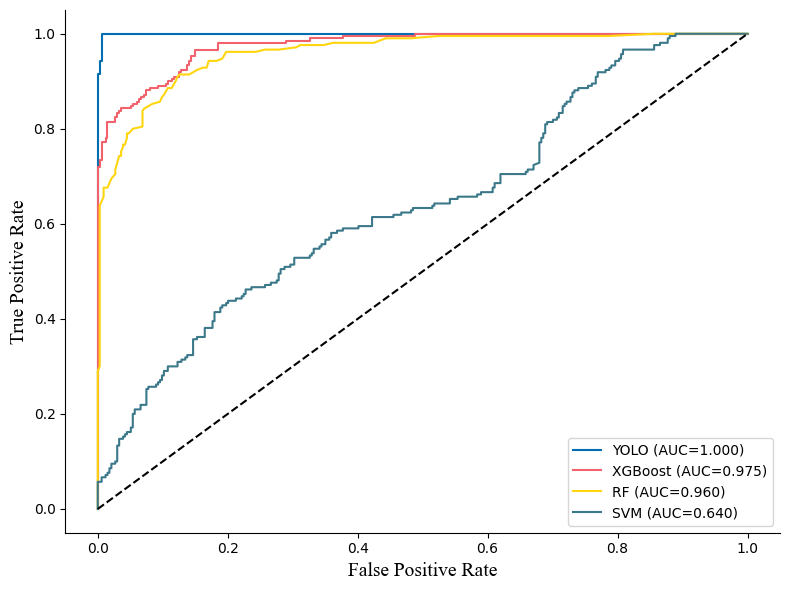

In [10]:
plt.figure(figsize=(8, 6))
for name, color in zip(metrics_dict.keys(), [
    "#006EB1",  # 蓝色
    "#F1626D",  # 粉红色
    "#FFD50D",  # 黄色
    "#3A788A",  # 深青色
    "#A26D8C",  # 紫色
    "#E06B39",  # 橙色
    "#A2C766",  # 浅绿色
    "#B4B4B3",  # 灰色
    "#7C8A92"   # 深灰色
]):
    plt.plot(metrics_dict[name]['FPR'], metrics_dict[name]['TPR'], label=f"{name} (AUC={metrics_dict[name]['AUC']:.3f})", color=color)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate',fontname='Times New Roman',fontsize = 14)
plt.ylabel('True Positive Rate',fontname = 'Times New Roman',fontsize = 14)
plt.legend()
plt.tight_layout()
plt.gca().spines['top'].set_visible(False)  
plt.gca().spines['right'].set_visible(False)  
plt.savefig("multi_model_roc.svg",format = 'svg')
plt.show()


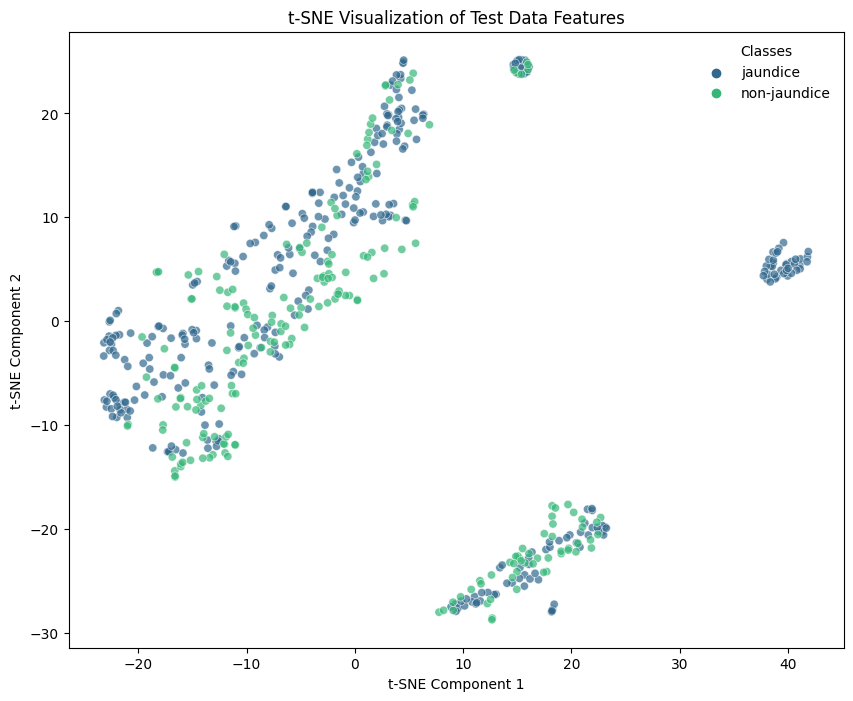

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE

# Assuming X_test and y_test are already defined
# Create a mapping dictionary
label_mapping = {0: 'jaundice', 1: 'non-jaundice'}

# Apply t-SNE to the test dataset
tsne = TSNE(n_components=2, random_state=42)
X_embedded = tsne.fit_transform(X_test)

# Create a DataFrame with embedded features and class labels
X_embedded_data = np.vstack((X_embedded.T, y_test)).T
df_tsne = pd.DataFrame(X_embedded_data, columns=['Dim1', 'Dim2', 'class'])

# Map the numerical class labels to string labels
df_tsne['class'] = df_tsne['class'].map(label_mapping)

# Create a scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df_tsne, hue='class', x='Dim1', y='Dim2', palette='viridis', edgecolor='w', alpha=0.7)

plt.title('t-SNE Visualization of Test Data Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(title='Classes',frameon=False)
plt.show()


Creating complete model performance comparison table...

Complete Model Performance Comparison Table:
  Model    ACC     F1  Recall(SEN)  Specificity(SPE)  AUC-ROC     AP
   YOLO 0.9963 0.9953       1.0000            0.9940   0.9996 0.9993
XGBoost 0.9062 0.8771       0.8667            0.9311   0.9752 0.9670
     RF 0.8952 0.8606       0.8381            0.9311   0.9598 0.9446
    SVM 0.4779 0.5186       0.7286            0.3204   0.6399 0.5620

Comparison table saved to: model_comparison_metrics.csv


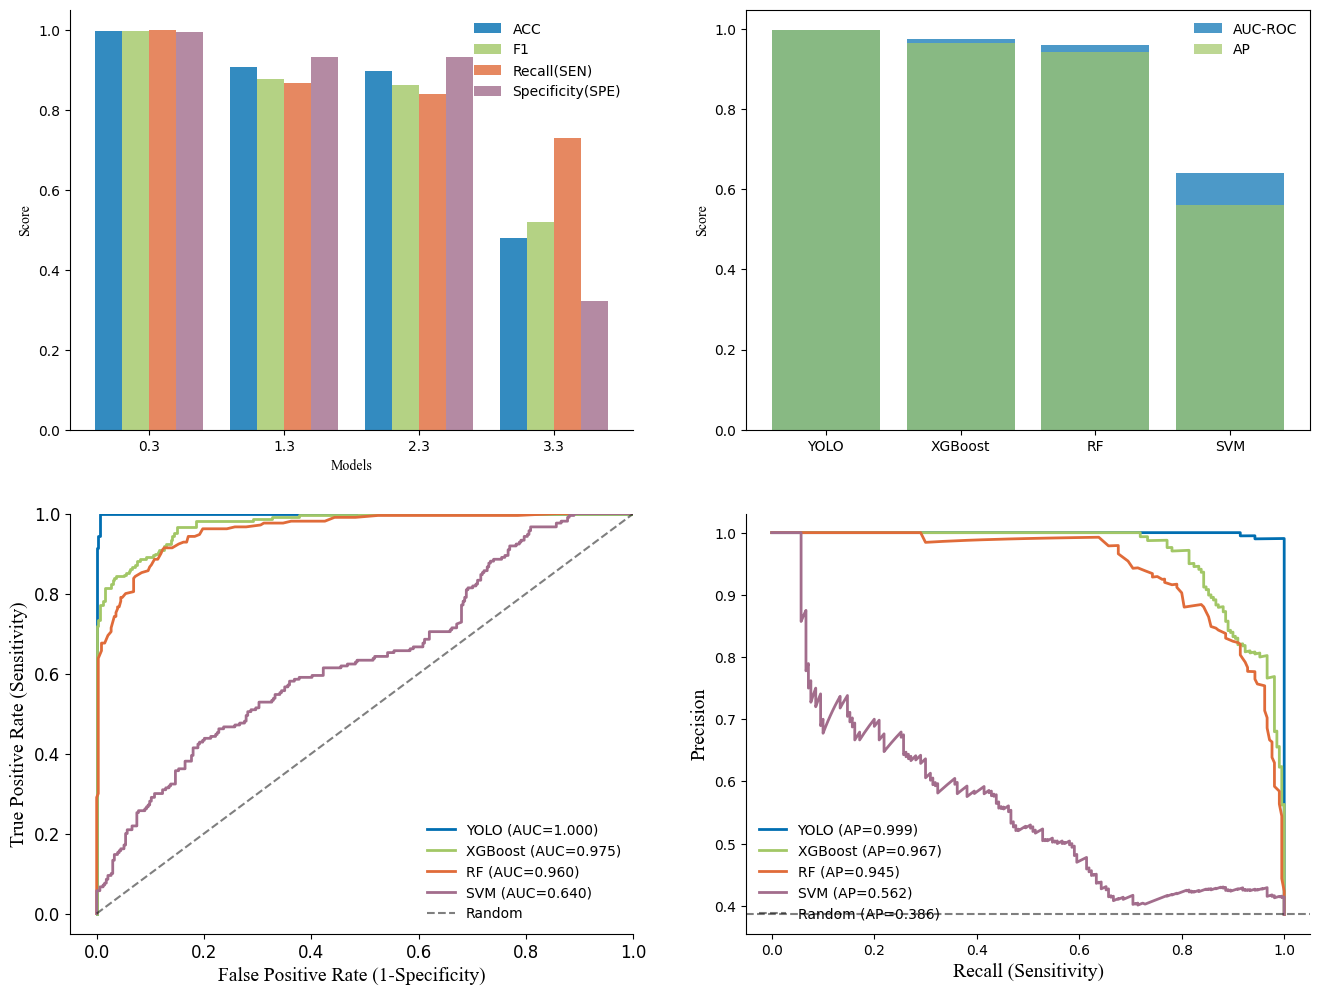

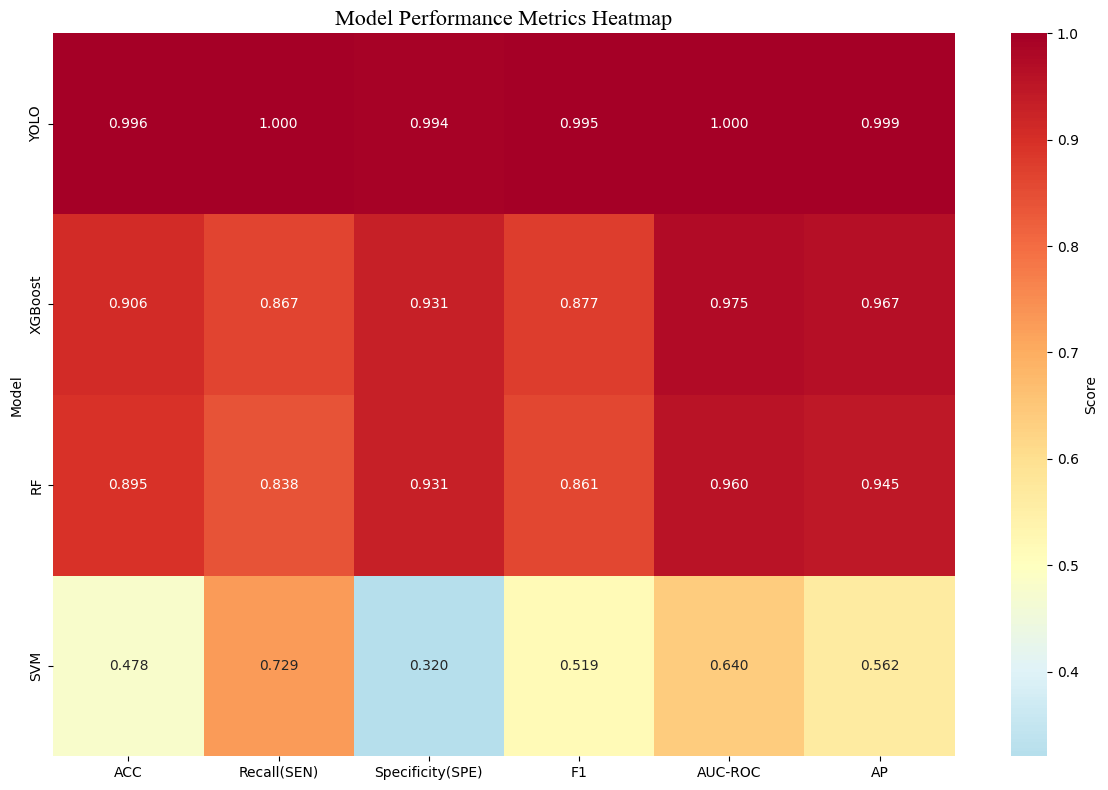

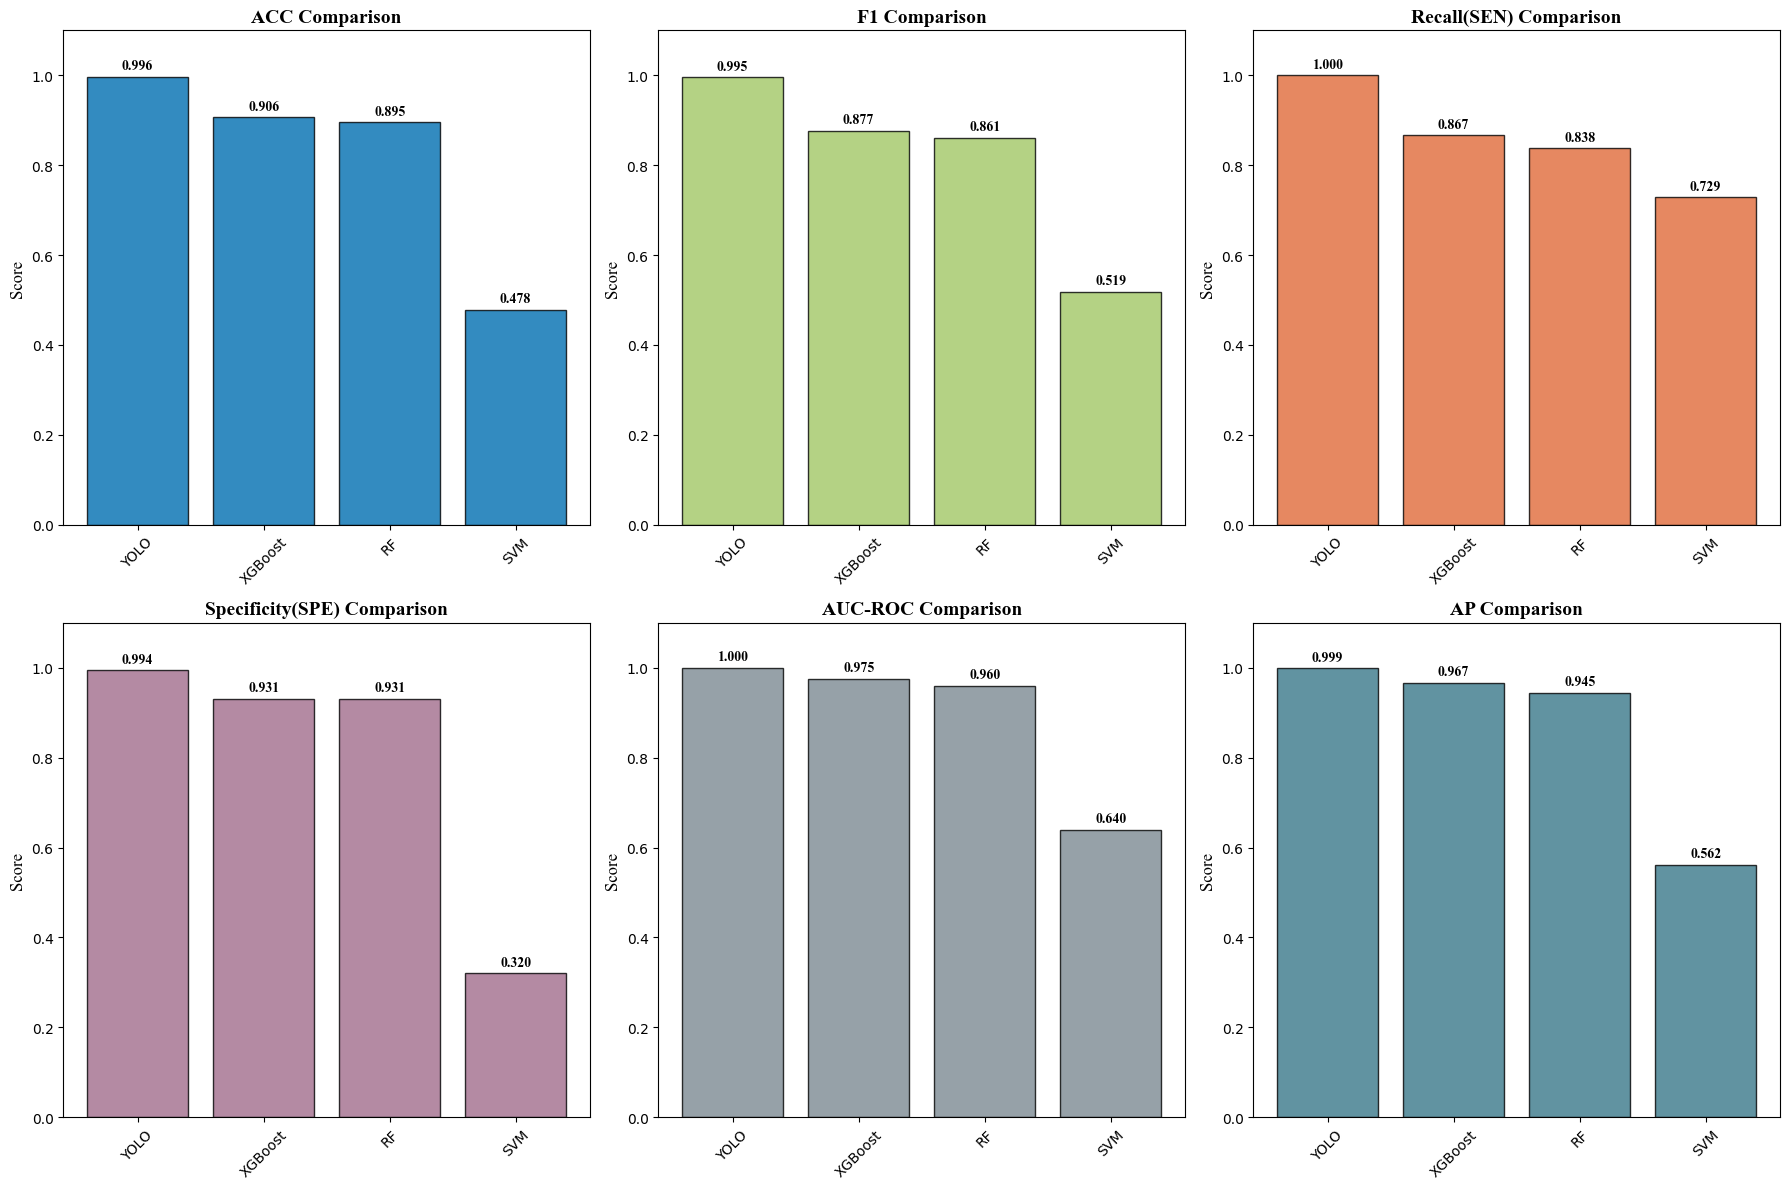


Best Model Analysis:
Best ACC: YOLO (0.9963)
Best F1: YOLO (0.9953)
Best Recall(SEN): YOLO (1.0000)
Best Specificity(SPE): YOLO (0.9940)
Best AUC-ROC: YOLO (0.9996)

Overall Ranking (based on average ranking across multiple metrics):
  Model  Average_Rank
   YOLO           1.0
XGBoost           2.1
     RF           2.9
    SVM           4.0

Dataset Information:
Test set size: 544
Jaundice samples: 334 (61.4%)
Normal samples: 210 (38.6%)


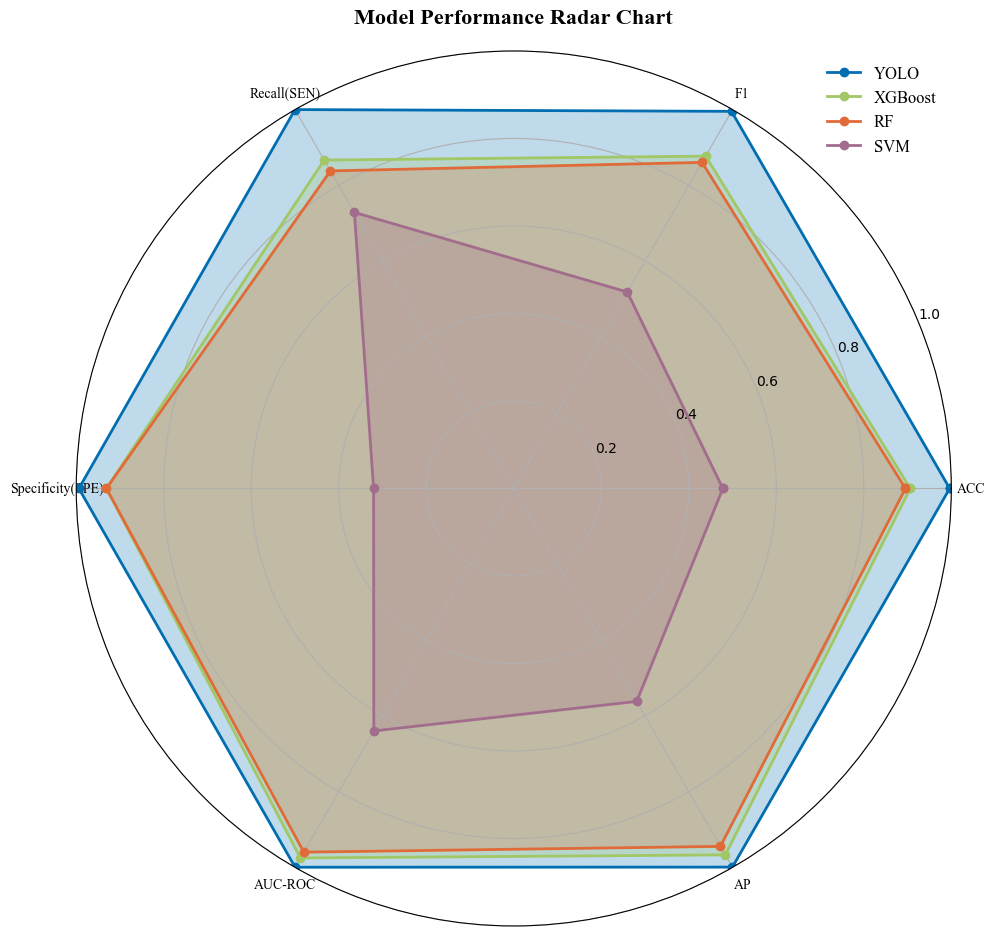

In [14]:
# 在原有代码的基础上，修改对比表格和可视化部分
from matplotlib.ticker import MultipleLocator
from brokenaxes import brokenaxes
# 创建完整的对比表格
print("\nCreating complete model performance comparison table...")
lancet_colors = [
    "#006EB1",  # 蓝色
    "#A2C766",  # 浅绿色
    "#E06B39",  # 橙色
    "#A26D8C",  # 紫色
    "#7C8A92" ,  # 深灰色
    "#3A788A",  # 深青色
    "#FFD50D",  # 黄色
    "#B4B4B3",  # 灰色
    "#F1626D",  # 粉红色
]

# 创建包含所有指标的对比表格
comparison_data = []
for model_name in metrics_dict.keys():
    metrics = metrics_dict[model_name]
    comparison_data.append([
        model_name,
        round(metrics["准确率"], 4),           # Accuracy (ACC)
        round(metrics["F1分数"], 4),           # F1 Score
        round(metrics["敏感度"], 4),            # Recall/Sensitivity
        round(metrics["特异度"], 4),            # Specificity
        round(metrics["AUC"], 4),               # AUC-ROC
        round(metrics["AP"], 4)                  # Average Precision
    ])

# 创建DataFrame
comparison_table = pd.DataFrame(comparison_data, columns=[
    "Model", "ACC", "F1", "Recall(SEN)", "Specificity(SPE)", "AUC-ROC", "AP"
])

print("\nComplete Model Performance Comparison Table:")
print("=" * 120)
print(comparison_table.to_string(index=False))

# 保存对比表格到CSV文件
comparison_table.to_csv("model_comparison_metrics.csv", index=False)
print(f"\nComparison table saved to: model_comparison_metrics.csv")

# 创建更详细的可视化对比
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. 主要性能指标对比柱状图
metrics_to_plot = ['ACC', 'F1', 'Recall(SEN)', 'Specificity(SPE)']
x = np.arange(len(comparison_table))
width = 0.2

# 设置上边框和右边框不可见
axes[0, 0].spines['top'].set_visible(False)  
axes[0, 0].spines['right'].set_visible(False)  

for i, metric in enumerate(metrics_to_plot):
    axes[0, 0].bar(x + i*width, comparison_table[metric], width, 
                   label=metric, color=lancet_colors[i], alpha=0.8)

axes[0, 0].set_xlabel('Models', fontname='Times New Roman')
axes[0, 0].set_ylabel('Score', fontname='Times New Roman')
axes[0, 0].set_xticks(x + width * 1.5)
axes[0, 0].legend(frameon = False)

# 2. AUC和AP对比
axes[0, 1].bar(comparison_table['Model'], comparison_table['AUC-ROC'], 
               alpha=0.7, label='AUC-ROC', color=lancet_colors[0])
axes[0, 1].bar(comparison_table['Model'], comparison_table['AP'], 
               alpha=0.7, label='AP', color=lancet_colors[1])
axes[0, 1].set_ylabel('Score', fontname='Times New Roman')
axes[0, 1].legend(frameon = False)

# 3. ROC曲线
colors = lancet_colors[:4]
for (name, color) in zip(metrics_dict.keys(), colors):
    axes[1, 0].plot(metrics_dict[name]['FPR'], metrics_dict[name]['TPR'], 
                    label=f"{name} (AUC={metrics_dict[name]['AUC']:.3f})", 
                    color=color, linewidth=2)

axes[1, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
axes[1, 0].set_xlabel('False Positive Rate (1-Specificity)', fontname='Times New Roman', fontsize=14)
axes[1, 0].set_ylabel('True Positive Rate (Sensitivity)', fontname='Times New Roman', fontsize=14)
axes[1, 0].legend(frameon = False)
axes[1, 0].set_xlim(-0.05, 1)
axes[1, 0].set_ylim(-0.05, 1)
axes[1, 0].tick_params(axis='x', labelsize=12)
axes[1, 0].tick_params(axis='y', labelsize=12)
axes[1, 0].spines['top'].set_visible(False)
axes[1, 0].spines['right'].set_visible(False)
# 4. PRC曲线
for (name, color) in zip(metrics_dict.keys(), colors):
    axes[1, 1].plot(metrics_dict[name]['Recall_curve'], metrics_dict[name]['Precision_curve'], 
                    label=f"{name} (AP={metrics_dict[name]['AP']:.3f})", 
                    color=color, linewidth=2)

# Optional: Draw a horizontal line indicating random performance
normal_ratio = np.sum(np.array(y_test) == 1) / len(y_test)
axes[1, 1].axhline(y=normal_ratio, color='k', linestyle='--', alpha=0.5, 
                   label=f'Random (AP={normal_ratio:.3f})')

# Adds labels and title
axes[1, 1].set_xlabel('Recall (Sensitivity)', fontname='Times New Roman', fontsize=14)
axes[1, 1].set_ylabel('Precision', fontname='Times New Roman', fontsize=14)
axes[1, 1].spines['top'].set_visible(False)
axes[1, 1].spines['right'].set_visible(False)
axes[1, 1].legend(frameon = False)


# ── 1. 单独保存 ROC 曲线 ──────────────────────────────────────────────
plt.figure(figsize=(7, 6))
for name, color in zip(metrics_dict.keys(), lancet_colors):
    alpha_val = 1.0 if "YOLO" in name.upper() else 0.5
    plt.plot(metrics_dict[name]['FPR'],
             metrics_dict[name]['TPR'],
             label=f"{name}  (AUC={metrics_dict[name]['AUC']:.3f})",
             color=color, linewidth=2, alpha=alpha_val)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
plt.xlim(-0.05, 1.05)
plt.ylim(-0.05, 1.05)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.xlabel('False Positive Rate (1 - Specificity)', fontname='Times New Roman')
plt.ylabel('True Positive Rate (Sensitivity)', fontname='Times New Roman')
plt.title('ROC Curves', fontname='Times New Roman', fontsize=16)
plt.legend(frameon=False, fontsize=10)
ax = plt.gca()                               # 取当前坐标轴
ax.xaxis.set_major_locator(MultipleLocator(0.2))
ax.yaxis.set_major_locator(MultipleLocator(0.2))
ax.tick_params(axis='both', which='both',
               direction='out', bottom=True, left=True, length=4)
ax.tick_params(which='minor', length=2)
# ax.grid(which='major', linestyle='--', linewidth=0.4, alpha=0.3)

plt.tight_layout()
plt.savefig("roc_curves_binaryvideo.svg", dpi=300, bbox_inches='tight')
plt.close()



# ── 2. 单独保存 PRC 曲线 —— 与组图完全一致 ───────────────────────
fig, ax = plt.subplots(figsize=(7, 6))

# 这两行跟组图保持一致：只取前 4 种颜色，只迭代前 4 个模型
colors = lancet_colors[:4]
for (name, color) in zip(list(metrics_dict.keys())[:4], lancet_colors):
    alpha = 1.0 if "YOLO" in name.upper() else 0.5
    ax.plot(metrics_dict[name]['Recall_curve'],
            metrics_dict[name]['Precision_curve'],
            label=f"{name} (AP={metrics_dict[name]['AP']:.3f})",
            color=color, linewidth=2,alpha=alpha)         

# 随机基线
normal_ratio = np.mean(np.array(y_test) == 1)
ax.hlines(normal_ratio, 0, 1,
          colors='k', linestyles='--', alpha=0.5,
          label=f'Random (AP={normal_ratio:.3f})')

# 坐标轴外观 100% 复制组图
ax.set_xlim(0, 1.05)
ax.set_xlabel('Recall (Sensitivity)', fontname='Times New Roman')
ax.set_ylabel('Precision', fontname='Times New Roman')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(frameon=False, fontsize=9)

plt.title('Precision–Recall Curves', fontname='Times New Roman', fontsize=16)
plt.tight_layout()
plt.savefig('prc_curves_binaryvideo.svg', dpi=300, bbox_inches='tight')
plt.close()







# 创建热力图显示所有指标
plt.figure(figsize=(12, 8))
metrics_for_heatmap = comparison_table.set_index('Model')[['ACC', 'Recall(SEN)', 'Specificity(SPE)', 'F1', 'AUC-ROC', 'AP']]

import seaborn as sns
sns.heatmap(metrics_for_heatmap, annot=True, cmap='RdYlBu_r', center=0.5, 
            fmt='.3f', cbar_kws={'label': 'Score'})
plt.title('Model Performance Metrics Heatmap', fontname='Times New Roman', fontsize=16)
plt.tight_layout()
plt.savefig("model_metrics_heatmap.svg", dpi=300, bbox_inches='tight')
plt.show()

# 创建单独的性能指标对比图
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

metrics_list = ['ACC', 'F1', 'Recall(SEN)', 'Specificity(SPE)', 'AUC-ROC', 'AP']

for i, metric in enumerate(metrics_list):
    ax = axes[i]
    bars = ax.bar(comparison_table['Model'], comparison_table[metric], 
                  color=lancet_colors[i], alpha=0.8, edgecolor='black', linewidth=1)
    
    # 添加数值标签
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold', fontname='Times New Roman')
    
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold', fontname='Times New Roman')
    ax.set_ylabel('Score', fontsize=12, fontname='Times New Roman')
    ax.set_ylim(0, 1.1)
    
    # 旋转x轴标签以避免重叠
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig("individual_metrics_comparison.svg", dpi=300, bbox_inches='tight')
plt.show()

# 找出最佳模型
print("\n" + "="*80)
print("Best Model Analysis:")
print("="*80)

best_models = {}
for metric in ['ACC', 'F1', 'Recall(SEN)', 'Specificity(SPE)', 'AUC-ROC']:
    best_idx = comparison_table[metric].idxmax()
    best_model = comparison_table.loc[best_idx, 'Model']
    best_score = comparison_table.loc[best_idx, metric]
    best_models[metric] = (best_model, best_score)
    print(f"Best {metric}: {best_model} ({best_score:.4f})")

# 综合排名
print(f"\nOverall Ranking (based on average ranking across multiple metrics):")
ranking_metrics = ['ACC', 'F1', 'Recall(SEN)', 'Specificity(SPE)', 'AUC-ROC']
ranks = pd.DataFrame()

for metric in ranking_metrics:
    ranks[metric] = comparison_table[metric].rank(ascending=False)

ranks['Model'] = comparison_table['Model']
ranks['Average_Rank'] = ranks[ranking_metrics].mean(axis=1)
ranks = ranks.sort_values('Average_Rank')

print(ranks[['Model', 'Average_Rank']].to_string(index=False))

print(f"\nDataset Information:")
print(f"Test set size: {len(y_test)}")
print(f"Jaundice samples: {np.sum(np.array(y_test) == 0)} ({np.mean(np.array(y_test) == 0)*100:.1f}%)")
print(f"Normal samples: {np.sum(np.array(y_test) == 1)} ({np.mean(np.array(y_test) == 1)*100:.1f}%)")

# 创建雷达图对比
def create_radar_chart():
    from math import pi
    
    # 选择要显示的指标
    categories = ['ACC', 'F1', 'Recall(SEN)', 'Specificity(SPE)', 'AUC-ROC', 'AP']
    
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))
    
    # 计算角度
    angles = [n / float(len(categories)) * 2 * pi for n in range(len(categories))]
    angles += angles[:1]  # 闭合图形
    
    for i, model in enumerate(comparison_table['Model']):
        values = []
        for cat in categories:
            values.append(comparison_table[comparison_table['Model'] == model][cat].iloc[0])
        values += values[:1]  # 闭合图形
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=lancet_colors[i])
        ax.fill(angles, values, alpha=0.25, color=lancet_colors[i])
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontname='Times New Roman')
    ax.set_ylim(0, 1)
    ax.set_title('Model Performance Radar Chart', size=16, fontweight='bold', pad=20, fontname='Times New Roman')
    ax.legend(loc='upper right', frameon = False,prop={'family': 'Times New Roman',  # 字体
                    'size': 12,                   # 字号
                    'weight': 'normal'})          # 是否加粗，可选

    
    plt.tight_layout()
    plt.savefig("model_radar_chart.svg", dpi=300)
    plt.show()

create_radar_chart()

In [11]:
# ============ 仅表格 + Bootstrap 置信区间（可直接接在你现有代码后） ============

import numpy as np
import pandas as pd
from typing import Dict, Any, Optional
from sklearn.metrics import (
    accuracy_score, f1_score, recall_score, roc_auc_score, average_precision_score
)

# 配置
N_BOOT = 1000       # 建议 1000~5000，越大越稳健也越慢
CI_ALPHA = 0.05     # 95% CI
THRESHOLD = 0.5     # 概率转预测的阈值
RANDOM_STATE = 42

# 重要：你当前的标签定义为 0=jaundice, 1=nonjaundice
# 并且所有 y_prob 都是 “P(class=1)”（即 nonjaundice 的概率）
# 这与下面所有指标计算保持一致（Recall/Precision 等针对正类=1）

def ensure_binary01(arr: np.ndarray) -> np.ndarray:
    arr = np.asarray(arr).astype(int)
    uniq = np.unique(arr)
    if len(uniq) > 2:
        raise ValueError(f"标签必须是二分类（0/1）。检测到唯一值：{uniq}")
    if set(uniq) == {0, 1}:
        return arr
    mapping = {uniq.min(): 0, uniq.max(): 1}
    return np.array([mapping[v] for v in arr], dtype=int)

def specificity_score(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    # 负类=0（jaundice），Specificity=TN/(TN+FP)
    y_true = ensure_binary01(y_true)
    y_pred = ensure_binary01(y_pred)
    neg = (y_true == 0)
    if neg.sum() == 0:
        return np.nan
    tn = np.logical_and(neg, y_pred == 0).sum()
    return tn / neg.sum()

def compute_metrics_from_probs(y_true: np.ndarray, y_prob: np.ndarray, threshold: float = THRESHOLD) -> Dict[str, float]:
    y_true = ensure_binary01(np.asarray(y_true))
    y_prob = np.asarray(y_prob, dtype=float)
    y_pred = (y_prob >= threshold).astype(int)

    out = {
        "ACC": float(accuracy_score(y_true, y_pred)),
        "F1": float(f1_score(y_true, y_pred, zero_division=0)),
        "Recall(SEN)": float(recall_score(y_true, y_pred, zero_division=0)),  # 正类=1
        "Specificity(SPE)": float(specificity_score(y_true, y_pred)),        # 负类=0
        "AUC-ROC": np.nan,
        "AP": np.nan,
    }
    # AUC/AP 需要概率
    try:
        out["AUC-ROC"] = float(roc_auc_score(y_true, y_prob))
    except Exception:
        out["AUC-ROC"] = np.nan
    try:
        out["AP"] = float(average_precision_score(y_true, y_prob))
    except Exception:
        out["AP"] = np.nan
    return out

def summarize_bootstrap(records: Dict[str, list], alpha: float) -> Dict[str, Dict[str, float]]:
    out = {}
    lo_q = 100 * (alpha / 2)
    hi_q = 100 * (1 - alpha / 2)
    for k, vals in records.items():
        arr = np.asarray(vals, dtype=float)
        out[k] = {
            "mean": float(np.nanmean(arr)),
            "low": float(np.nanpercentile(arr, lo_q)),
            "high": float(np.nanpercentile(arr, hi_q)),
        }
    return out

def bootstrap_intervals(y_true: np.ndarray, y_prob: np.ndarray,
                        n_boot: int = N_BOOT, alpha: float = CI_ALPHA,
                        threshold: float = THRESHOLD, random_state: int = RANDOM_STATE) -> Dict[str, Dict[str, float]]:
    rng = np.random.default_rng(random_state)
    y_true = ensure_binary01(np.asarray(y_true))
    y_prob = np.asarray(y_prob, dtype=float)
    n = len(y_true)
    if len(y_prob) != n:
        raise ValueError("y_true 与 y_prob 长度不一致。")

    records = {k: [] for k in ["ACC", "F1", "Recall(SEN)", "Specificity(SPE)", "AUC-ROC", "AP"]}
    for _ in range(n_boot):
        idx = rng.integers(0, n, size=n)
        yt = y_true[idx]
        yp = y_prob[idx]
        m = compute_metrics_from_probs(yt, yp, threshold=threshold)
        for k in records:
            records[k].append(m[k])
    return summarize_bootstrap(records, alpha)

def fmt_interval(mean: float, lo: float, hi: float, decimals: int = 3) -> str:
    if any([(x is None) or (isinstance(x, float) and np.isnan(x)) for x in [mean, lo, hi]]):
        return f"{mean:.{decimals}f} (NA–NA)" if isinstance(mean, (int, float)) and not np.isnan(mean) else "NA (NA–NA)"
    return f"{mean:.{decimals}f} ({lo:.{decimals}f}–{hi:.{decimals}f})"

# 组装逐样本数据（与你的代码变量命名严格对齐）
# 注意：YOLO 使用 yolo_y_true / yolo_y_prob，其他模型使用全局 y_test 与各自概率
models = {
    "YOLO":    {"y_true": np.array(yolo_y_true), "y_prob": np.array(yolo_y_prob, dtype=float)},
    "XGBoost": {"y_true": np.array(y_test),      "y_prob": np.array(y_xgb_prob, dtype=float)},
    "RF":      {"y_true": np.array(y_test),      "y_prob": np.array(y_rf_prob,  dtype=float)},
    "SVM":     {"y_true": np.array(y_test),      "y_prob": np.array(y_svm_prob, dtype=float)},
}

# 打印数据集信息
y_demo = ensure_binary01(models["YOLO"]["y_true"])
n_total = len(y_demo)
n_pos = int((y_demo == 1).sum())
n_neg = n_total - n_pos
print(f"Dataset Info: total={n_total}, positives(1)= {n_pos} ({100.0*n_pos/n_total:.1f}%), negatives(0)= {n_neg} ({100.0*n_neg/n_total:.1f}%)")

# 计算并汇总
rows = []
for name, dd in models.items():
    summary = bootstrap_intervals(dd["y_true"], dd["y_prob"],
                                  n_boot=N_BOOT, alpha=CI_ALPHA,
                                  threshold=THRESHOLD, random_state=RANDOM_STATE)
    rows.append({
        "Model": name,
        "ACC": summary["ACC"]["mean"], "ACC_low": summary["ACC"]["low"], "ACC_high": summary["ACC"]["high"],
        "F1": summary["F1"]["mean"], "F1_low": summary["F1"]["low"], "F1_high": summary["F1"]["high"],
        "Recall(SEN)": summary["Recall(SEN)"]["mean"], "Recall_low": summary["Recall(SEN)"]["low"], "Recall_high": summary["Recall(SEN)"]["high"],
        "Specificity(SPE)": summary["Specificity(SPE)"]["mean"], "Specificity_low": summary["Specificity(SPE)"]["low"], "Specificity_high": summary["Specificity(SPE)"]["high"],
        "AUC-ROC": summary["AUC-ROC"]["mean"], "AUC_low": summary["AUC-ROC"]["low"], "AUC_high": summary["AUC-ROC"]["high"],
        "AP": summary["AP"]["mean"], "AP_low": summary["AP"]["low"], "AP_high": summary["AP"]["high"],
    })

numeric_df = pd.DataFrame(rows)

# 可读版
readable_df = pd.DataFrame({"Model": numeric_df["Model"]})
triples = [
    ("ACC", "ACC_low", "ACC_high"),
    ("F1", "F1_low", "F1_high"),
    ("Recall(SEN)", "Recall_low", "Recall_high"),
    ("Specificity(SPE)", "Specificity_low", "Specificity_high"),
    ("AUC-ROC", "AUC_low", "AUC_high"),
    ("AP", "AP_low", "AP_high"),
]
for base, lo_col, hi_col in triples:
    readable_df[base] = [
        fmt_interval(m, l, h, decimals=3)
        for m, l, h in zip(numeric_df[base], numeric_df[lo_col], numeric_df[hi_col])
    ]

# 固定列顺序
numeric_cols = [
    "Model",
    "ACC", "ACC_low", "ACC_high",
    "F1", "F1_low", "F1_high",
    "Recall(SEN)", "Recall_low", "Recall_high",
    "Specificity(SPE)", "Specificity_low", "Specificity_high",
    "AUC-ROC", "AUC_low", "AUC_high",
    "AP", "AP_low", "AP_high",
]
numeric_df = numeric_df[numeric_cols]

# 打印与保存
print("\n完整对比表（含95% CI，数值版）:")
print("=" * 120)
print(numeric_df.to_string(index=False))

print("\n可读版（mean (low–high)）:")
print("=" * 120)
print(readable_df.to_string(index=False))

numeric_path = "model_comparison_metrics_with_CI_numeric.csv"
readable_path = "model_comparison_metrics_with_CI_readable.csv"
numeric_df.to_csv(numeric_path, index=False, encoding="utf-8-sig")
readable_df.to_csv(readable_path, index=False, encoding="utf-8-sig")
print(f"\n已保存：\n- {numeric_path}\n- {readable_path}")
# ======================================================================

Dataset Info: total=544, positives(1)= 210 (38.6%), negatives(0)= 334 (61.4%)

完整对比表（含95% CI，数值版）:
  Model      ACC  ACC_low  ACC_high       F1   F1_low  F1_high  Recall(SEN)  Recall_low  Recall_high  Specificity(SPE)  Specificity_low  Specificity_high  AUC-ROC  AUC_low  AUC_high       AP   AP_low  AP_high
   YOLO 0.996316 0.990809  1.000000 0.995244 0.987531 1.000000     1.000000    1.000000     1.000000          0.993997         0.984753          1.000000 0.999573 0.998748  1.000000 0.999302 0.997969 1.000000
XGBoost 0.906461 0.882307  0.930147 0.877164 0.843805 0.909101     0.866578    0.822957     0.907767          0.931539         0.905060          0.956902 0.975250 0.964405  0.984394 0.967141 0.953051 0.979066
     RF 0.895175 0.869485  0.919118 0.861069 0.824420 0.894617     0.842904    0.798995     0.887806          0.928072         0.898876          0.954958 0.959687 0.943306  0.974059 0.944505 0.921309 0.963337
    SVM 0.478408 0.435662  0.520221 0.518650 0.465513 0.568157   


🚀 Creating Binary Classification ROC Curves with Doctor Performance Points
✅ Binary ROC plot with doctor points saved:
   📄 binary_roc_with_doctor_points.svg
   📄 binary_roc_with_doctor_points.png


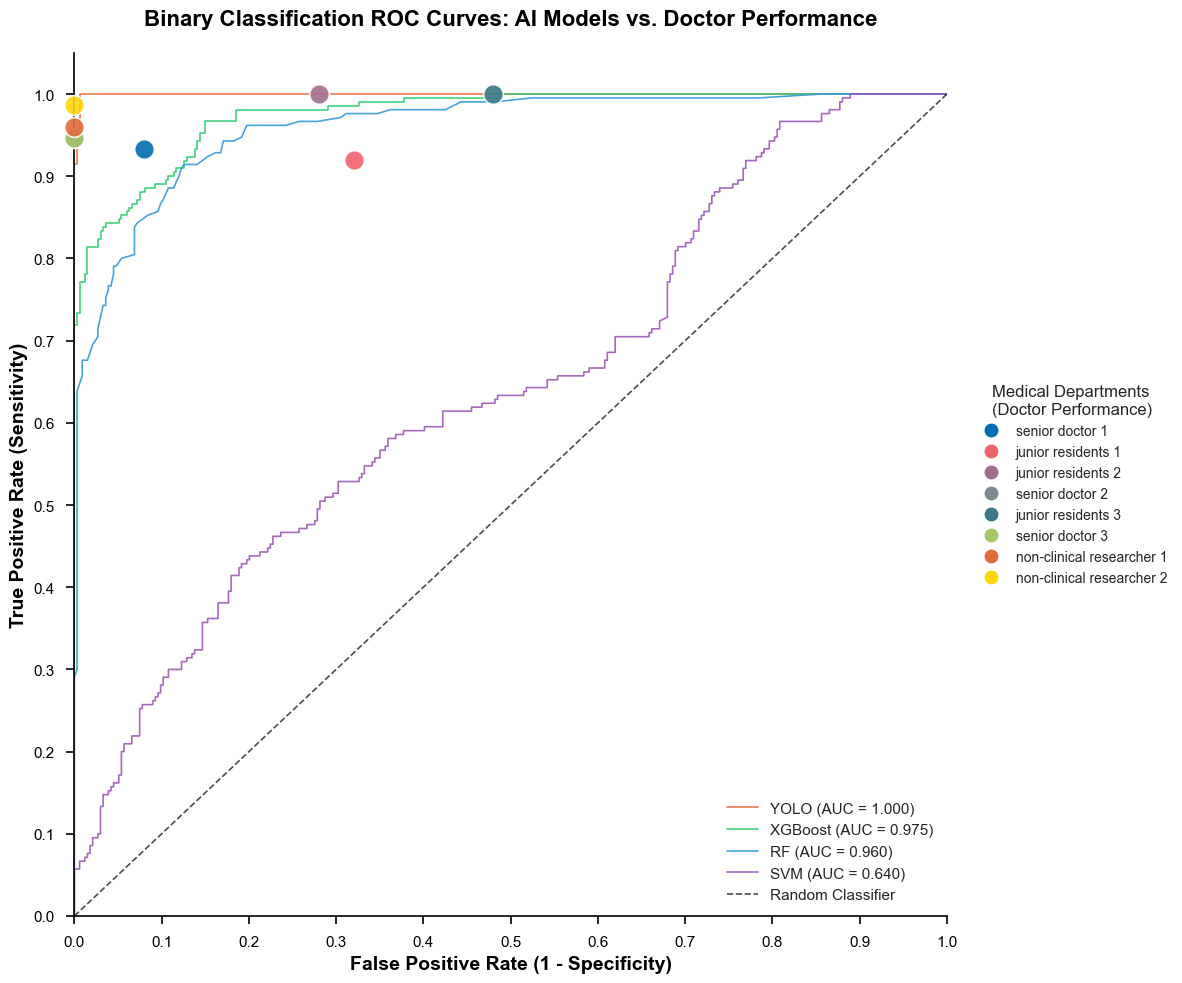

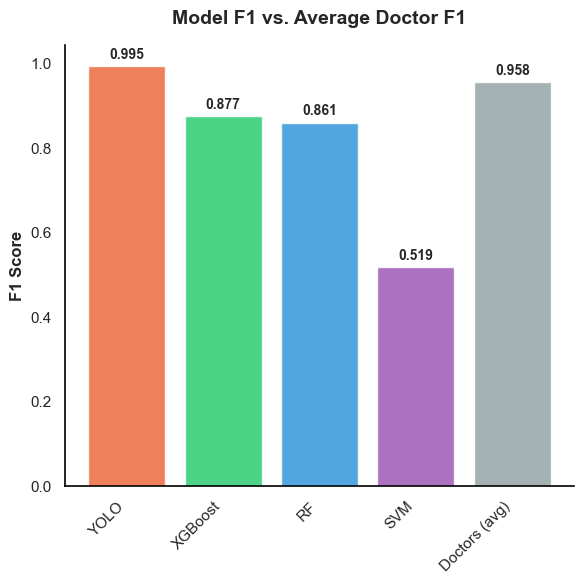

✅ F1 comparison plot saved:
   📄 model_vs_doctor_f1.svg
   📄 model_vs_doctor_f1.png

🔍 BINARY CLASSIFICATION PERFORMANCE ANALYSIS

📊 AI Model Performance Summary:
--------------------------------------------------
YOLO           : AUC = 0.9996
XGBoost        : AUC = 0.9752
RF             : AUC = 0.9598
SVM            : AUC = 0.6399

🏆 Best AI Model: YOLO (AUC = 0.9996)


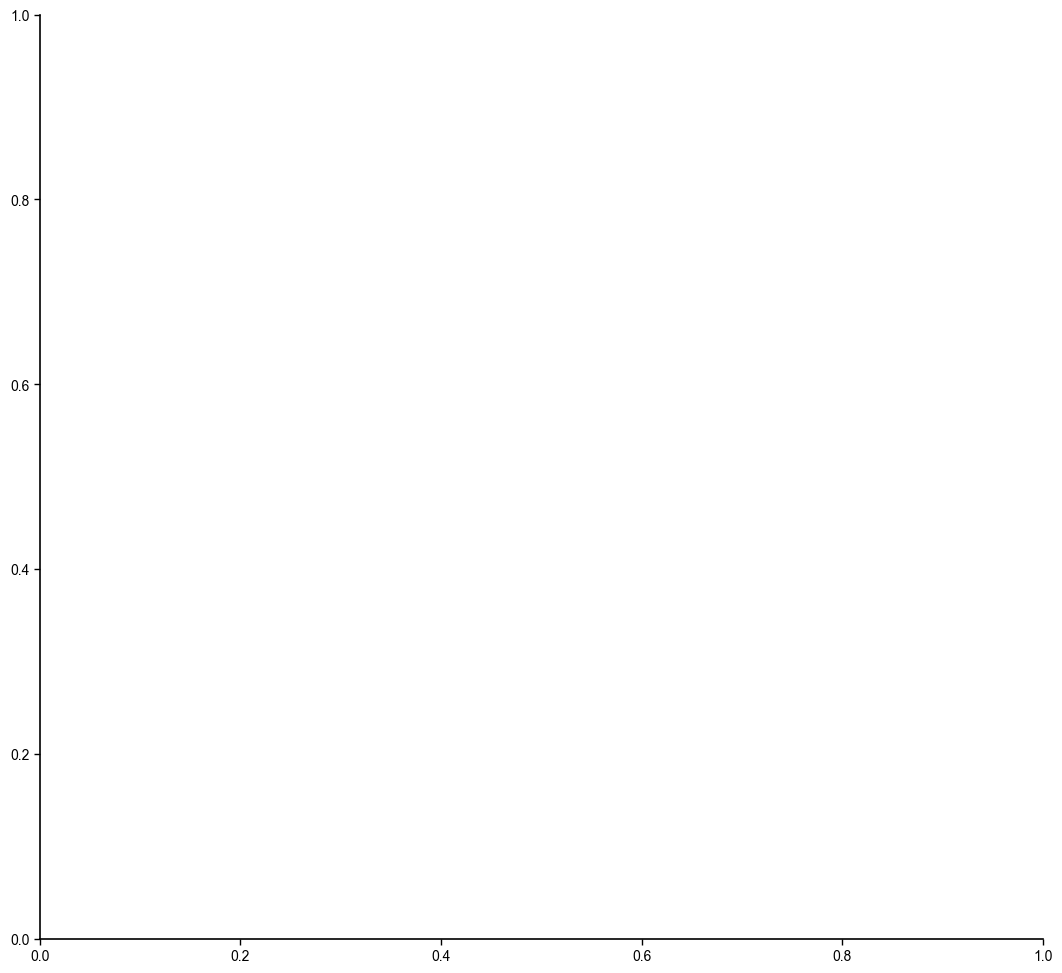

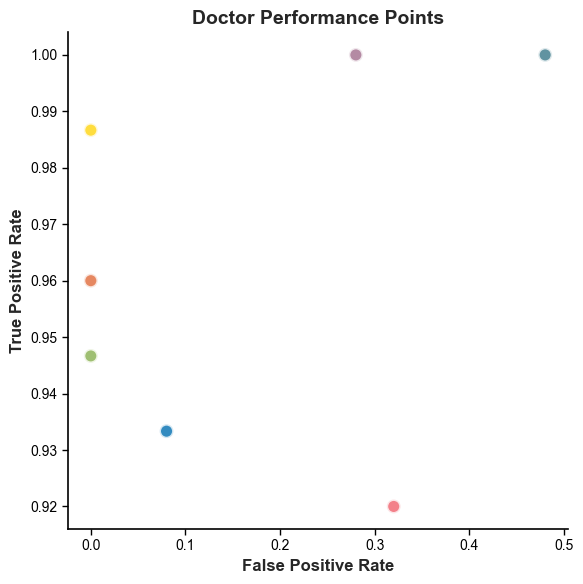

✅ Doctor points figure (subplot style) saved:
   📄 doctor_points_subplot_style.svg
   📄 doctor_points_subplot_style.png

👨‍⚕️ Doctor Performance Analysis:
--------------------------------------------------
Individual Doctor Performance:
  senior doctor 1     : Sensitivity=0.933, Specificity=0.920, Distance=0.104
  junior residents 1  : Sensitivity=0.920, Specificity=0.680, Distance=0.330
  junior residents 2  : Sensitivity=1.000, Specificity=0.720, Distance=0.280
  senior doctor 2     : Sensitivity=0.947, Specificity=1.000, Distance=0.053
  junior residents 3  : Sensitivity=1.000, Specificity=0.520, Distance=0.480
  senior doctor 3     : Sensitivity=0.947, Specificity=1.000, Distance=0.053
  non-clinical researcher 1: Sensitivity=0.960, Specificity=1.000, Distance=0.040
  non-clinical researcher 2: Sensitivity=0.987, Specificity=1.000, Distance=0.013

🥇 Top 3 Doctors (closest to perfect point):
  1. non-clinical researcher 2: Sensitivity=0.987, Specificity=1.000
  2. non-clinical resea

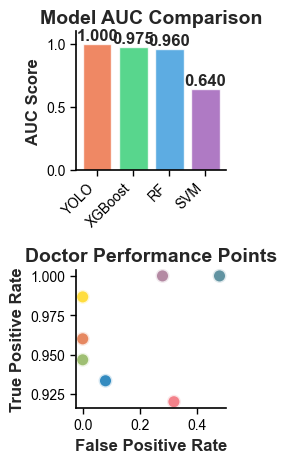


✅ All binary classification visualizations with doctor performance completed!

📁 Generated files:
   📄 binary_roc_with_doctor_points.svg
   📄 binary_roc_with_doctor_points.png
   📄 enhanced_binary_comparison.svg
   📄 enhanced_binary_comparison.png


In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
plt.rcParams['font.family'] = 'Times New Roman'
# 优化的样式设置 - 与多分类图一致
plt.rcParams.update({
    'font.family':'serif',
    'font.serif':'[Times New Roman]',
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'axes.linewidth': 1.2,
    'lines.linewidth': 1.2,
    'axes.grid': False,
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'savefig.facecolor': 'white',
    'savefig.transparent': False,
    'axes.edgecolor': 'black',
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'xtick.direction': 'out',
    'ytick.direction': 'out',
    'xtick.major.size': 6,
    'ytick.major.size': 6,
    'xtick.major.width': 1.2,
    'ytick.major.width': 1.2
})

# 设置无网格的白色样式，只有左下边框
sns.set_style('white', {
    'axes.grid': False,
    'axes.facecolor': 'white',
    'axes.edgecolor': 'black',
    'axes.linewidth': 1.2,
    'axes.spines.left': True,
    'axes.spines.bottom': True,
    'axes.spines.top': False,
    'axes.spines.right': False
})

# 创建包含医生表现点的二分类ROC曲线
print("\n" + "="*80)
print("🚀 Creating Binary Classification ROC Curves with Doctor Performance Points")
print("="*80)

# 医生二分类表现数据
doctor_data = {
    'Doctor_ID': ['Doctor_1', 'Doctor_2', 'Doctor_3', 'Doctor_4', 
                  'Doctor_5', 'Doctor_6', 'Doctor_7', 'Doctor_8'],
    'Department': ['senior doctor 1', 'junior residents 1', 'junior residents 2', 'senior doctor 2',
                       'junior residents 3', 'senior doctor 3', 'non-clinical researcher 1', 'non-clinical researcher 2'],
    'FPR': [0.08, 0.32, 0.28, 0.0, 0.48, 0.0, 0.0, 0.0],
    'TPR': [0.9333333, 0.92, 1.0, 0.946666667, 1.0, 0.946666667, 0.96, 0.986666667],
    'F1': [0.952,0.908,0.955,0.973,0.926,0.973,0.980,0.993],
    'F1-multi': [0.530,0.484,0.563,0.634,0.556,0.554,0.448,0.453],
}

doctor_df = pd.DataFrame(doctor_data)

# 创建ROC曲线图（包含医生表现点）
fig, ax = plt.subplots(figsize=(12, 10))

# 设置纯净的白色背景
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# 定义模型颜色 - 更现代的配色
model_colors = ['#ec6a3d', '#2ecc71', '#3498db', '#9b59b6']

# 绘制AI模型ROC曲线
for i, (model_name, metrics) in enumerate(metrics_dict.items()):
    ax.plot(metrics['FPR'], metrics['TPR'],
            label=f'{model_name} (AUC = {metrics["AUC"]:.3f})',
            color=model_colors[i % len(model_colors)],
            linewidth=1.2,
            alpha=0.9)

# 定义医疗科室颜色 - 与多分类图一致，更有区分度
dept_colors = {
    'senior doctor 1': "#006EB1",  # 蓝色
    'junior residents 1': "#F1626D",         # 粉红色
    'junior residents 2': "#A26D8C",       # 紫色
    'senior doctor 2': "#7C8A92",       # 深灰色
    'junior residents 3': "#3A788A",       # 深青色
    'senior doctor 3': "#A2C766",       # 浅绿色
    'non-clinical researcher 1': "#E06B39",       # 橙色
    'non-clinical researcher 2': "#FFD50D"        # 黄色
}

# 绘制医生表现点 - 关键修改：添加clip_on=False
for _, row in doctor_df.iterrows():
    ax.scatter(row['FPR'], row['TPR'],
               c=dept_colors[row['Department']], 
               marker='o',
               s=200, 
               alpha=0.9,
               edgecolors='white',
               linewidth=1.2,
               zorder=6,
               clip_on=False)  # 关键参数：不被坐标轴边界裁剪

# 绘制对角参考线
ax.plot([0, 1], [0, 1], 'k--', linewidth=1.2, alpha=0.7, 
        label='Random Classifier', zorder=2)

# 不使用网格
ax.grid(False)

# 设置坐标轴范围 - 保持原始范围
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

# 设置坐标轴刻度 - 每0.1一个刻度
x_ticks = np.arange(0, 1.1, 0.1)
y_ticks = np.arange(0, 1.1, 0.1)
ax.set_xticks(x_ticks)
ax.set_yticks(y_ticks)

# 设置刻度标签格式
ax.set_xticklabels([f'{x:.1f}' for x in x_ticks])
ax.set_yticklabels([f'{y:.1f}' for y in y_ticks])

# 设置轴标签
ax.set_xlabel('False Positive Rate (1 - Specificity)', 
              fontsize=14, fontweight='bold', color='black')
ax.set_ylabel('True Positive Rate (Sensitivity)', 
              fontsize=14, fontweight='bold', color='black')
ax.set_title('Binary Classification ROC Curves: AI Models vs. Doctor Performance', 
             fontsize=16, fontweight='bold', pad=20, color='black')

# 设置刻度线样式
ax.tick_params(axis='both', which='major', 
               labelsize=11, 
               colors='black',
               direction='out',
               length=6,
               width=1.2,
               pad=8)

# 只对左边和下面的轴显示刻度线
ax.tick_params(axis='x', which='major', 
               top=False,
               bottom=True)

ax.tick_params(axis='y', which='major', 
               left=True,
               right=False)

# 只显示左边和下面的边框
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# 设置可见边框的样式
ax.spines['left'].set_linewidth(1.2)
ax.spines['left'].set_edgecolor('black')
ax.spines['bottom'].set_linewidth(1.2)
ax.spines['bottom'].set_edgecolor('black')

# 创建模型图例
model_legend = ax.legend(loc='lower right', frameon=False, fancybox=True, 
                        shadow=True, fontsize=11, facecolor='white',
                        edgecolor='black', framealpha=1.0)
ax.add_artist(model_legend)

# 创建医疗科室图例
dept_legend_elements = []
for dept, color in dept_colors.items():
    dept_legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                          markerfacecolor=color, markersize=12,
                                          label=dept, markeredgecolor='white',
                                          markeredgewidth=2))

dept_legend = ax.legend(handles=dept_legend_elements, 
                       loc='center left', bbox_to_anchor=(1.02, 0.5),
                       title='Medical Departments\n(Doctor Performance)', 
                       frameon=False, fancybox=True, shadow=True,
                       title_fontsize=12, fontsize=10,
                       facecolor='white', edgecolor='black', framealpha=1.0)

plt.tight_layout()

# 保存图表
plt.savefig('binary_roc_with_doctor_points.svg', format='svg', bbox_inches='tight', 
           dpi=300, facecolor='white', edgecolor='none')
plt.savefig('binary_roc_with_doctor_points.png', format='png', bbox_inches='tight', 
           dpi=300, facecolor='white', edgecolor='none')

print("✅ Binary ROC plot with doctor points saved:")
print("   📄 binary_roc_with_doctor_points.svg")
print("   📄 binary_roc_with_doctor_points.png")

plt.show()
# =============================================================================
# 🔧 生成“模型 F1 vs 医生平均 F1”对比柱状图
# =============================================================================
# 1. 取出各模型 F1 分数
model_names = list(metrics_dict.keys())
model_f1_scores = [metrics_dict[m]['F1分数'] for m in model_names]

# 2. 医生平均 F1
doctor_avg_f1 = doctor_df['F1'].mean()

# 3. 组合数据
labels = model_names + ['Doctors (avg)']
f1_values = model_f1_scores + [doctor_avg_f1]

# 4. 颜色（沿用之前 model_colors，再加一个新颜色）
bar_colors = model_colors[:len(model_f1_scores)] + ['#95a5a6']  # 灰色给医生平均

# 5. 绘图
plt.figure(figsize=(6, 6))
bars = plt.bar(range(len(labels)), f1_values, color=bar_colors, alpha=0.85)

# 6. 数值标签
for bar, val in zip(bars, f1_values):
    plt.text(bar.get_x() + bar.get_width()/2,
             val + 0.01,
             f'{val:.3f}',
             ha='center',
             va='bottom',
             fontsize=10,
             fontweight='bold')

plt.xticks(range(len(labels)), labels, rotation=45, ha='right')
plt.ylabel('F1 Score', fontweight='bold')
plt.title('Model F1 vs. Average Doctor F1', fontweight='bold', pad=15)

# 边框和背景保持一致风格
for spine in ['top', 'right']:
    plt.gca().spines[spine].set_visible(False)
plt.gca().spines['left'].set_linewidth(1.2)
plt.gca().spines['bottom'].set_linewidth(1.2)
plt.tight_layout()

# 7. 保存
plt.savefig('model_vs_doctor_f1.svg', format='svg', dpi=300, bbox_inches='tight')
plt.savefig('model_vs_doctor_f1.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ F1 comparison plot saved:")
print("   📄 model_vs_doctor_f1.svg")
print("   📄 model_vs_doctor_f1.png")
# 医生表现分析 (保持原有分析代码不变)
print("\n" + "="*80)
print("🔍 BINARY CLASSIFICATION PERFORMANCE ANALYSIS")
print("="*80)

# 计算医生到完美点的距离和特异性
doctor_df['Distance_to_Perfect'] = np.sqrt(doctor_df['FPR']**2 + (1 - doctor_df['TPR'])**2)
doctor_df['Specificity'] = 1 - doctor_df['FPR']

# AI模型性能总结
print("\n📊 AI Model Performance Summary:")
print("-" * 50)
for model_name, metrics in metrics_dict.items():
    print(f"{model_name:15s}: AUC = {metrics['AUC']:.4f}")

# 最佳AI模型
best_model = max(metrics_dict.items(), key=lambda x: x[1]['AUC'])
print(f"\n🏆 Best AI Model: {best_model[0]} (AUC = {best_model[1]['AUC']:.4f})")
def setup_axis_style(ax):
    """统一设置坐标轴样式"""
    # 设置背景
    ax.set_facecolor('white')
    
    # 不使用网格
    ax.grid(False)
    
    # 只显示左边和下面的边框
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    
    # 设置边框样式
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['left'].set_edgecolor('black')
    ax.spines['bottom'].set_linewidth(1.2)
    ax.spines['bottom'].set_edgecolor('black')
    
    # 设置刻度线样式
    ax.tick_params(axis='both', which='major', 
                   labelsize=10, 
                   colors='black',
                   direction='out',
                   length=4,
                   width=1.0)
    
    ax.tick_params(axis='x', which='major', top=False, bottom=True)
    ax.tick_params(axis='y', which='major', left=True, right=False)

fig = plt.figure(figsize=(20, 12))
fig.patch.set_facecolor('white')

# 主ROC图
ax1 = plt.subplot2grid((2, 3), (0, 0), colspan=2, rowspan=2)
setup_axis_style(ax1)

# ── 完全复刻组合图右下角医生散点 ──────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(6, 6))
setup_axis_style(ax)                       # 复用原函数，保证坐标轴风格一致

# 医生散点（参数同 ax3）
ax.scatter(doctor_df['FPR'], doctor_df['TPR'],
           c=[dept_colors[d] for d in doctor_df['Department']],
           s=100, alpha=0.8,
           edgecolors='white', linewidth=2,
           clip_on=False, zorder=5)

# 轴标签 & 标题（同 ax3）
ax.set_xlabel('False Positive Rate', fontweight='bold')
ax.set_ylabel('True Positive Rate', fontweight='bold')
ax.set_title('Doctor Performance Points', fontweight='bold')


plt.tight_layout()
plt.savefig('doctor_points_subplot_style.svg', format='svg',
            dpi=300, bbox_inches='tight')
plt.savefig('doctor_points_subplot_style.png', format='png',
            dpi=300, bbox_inches='tight')
plt.show()

print("✅ Doctor points figure (subplot style) saved:")
print("   📄 doctor_points_subplot_style.svg")
print("   📄 doctor_points_subplot_style.png")
# 医生表现分析
print("\n👨‍⚕️ Doctor Performance Analysis:")
print("-" * 50)

print("Individual Doctor Performance:")
for _, row in doctor_df.iterrows():
    print(f"  {row['Department']:20s}: Sensitivity={row['TPR']:.3f}, Specificity={row['Specificity']:.3f}, Distance={row['Distance_to_Perfect']:.3f}")

# 最佳医生表现
print(f"\n🥇 Top 3 Doctors (closest to perfect point):")
top_doctors = doctor_df.nsmallest(3, 'Distance_to_Perfect')
for i, (_, row) in enumerate(top_doctors.iterrows(), 1):
    print(f"  {i}. {row['Department']}: Sensitivity={row['TPR']:.3f}, Specificity={row['Specificity']:.3f}")

# 医生表现统计
print(f"\n📈 Doctor Performance Statistics:")
print(f"  Mean Sensitivity: {doctor_df['TPR'].mean():.3f} ± {doctor_df['TPR'].std():.3f}")
print(f"  Mean Specificity: {doctor_df['Specificity'].mean():.3f} ± {doctor_df['Specificity'].std():.3f}")
print(f"  Best Sensitivity: {doctor_df['TPR'].max():.3f}")
print(f"  Best Specificity: {doctor_df['Specificity'].max():.3f}")

# AI vs 医生对比
print(f"\n🤖 AI vs Human Comparison:")
best_ai_auc = best_model[1]['AUC']
best_doctor_distance = doctor_df['Distance_to_Perfect'].min()

print(f"  Best AI Model AUC: {best_ai_auc:.3f}")
print(f"  Best Doctor Distance to Perfect: {best_doctor_distance:.3f}")

# 数据集信息
jaundice_count = np.sum(np.array(y_test) == 0)
normal_count = np.sum(np.array(y_test) == 1)
print(f"\n📋 Dataset Information:")
print(f"  Test set size: {len(y_test)}")
print(f"  Jaundice cases: {jaundice_count} ({jaundice_count/len(y_test)*100:.1f}%)")
print(f"  Normal cases: {normal_count} ({normal_count/len(y_test)*100:.1f}%)")

# 创建增强版对比图 - 使用一致样式
print("\n📊 Creating Enhanced Comparison Visualization...")


# 绘制模型ROC曲线
for i, (model_name, metrics) in enumerate(metrics_dict.items()):
    ax1.plot(metrics['FPR'], metrics['TPR'],
            label=f'{model_name} (AUC = {metrics["AUC"]:.3f})',
            color=model_colors[i % len(model_colors)],
            linewidth=1.2,
            alpha=0.9)

# 绘制医生点 - 添加clip_on=False
for _, row in doctor_df.iterrows():
    ax1.scatter(row['FPR'], row['TPR'],
               c=dept_colors[row['Department']], 
               marker='o', s=120, alpha=0.9,
               edgecolors='white', linewidth=1.2, zorder=6,
               clip_on=False)  # 不被坐标轴边界裁剪

ax1.plot([0, 1], [0, 1], 'k--', linewidth=1.5, alpha=0.7, label='Random')

# 设置ROC图坐标轴 - 保持原始范围
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
x_ticks = np.arange(0, 1.1, 0.2)
y_ticks = np.arange(0, 1.1, 0.2)
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_xticklabels([f'{x:.1f}' for x in x_ticks])
ax1.set_yticklabels([f'{y:.1f}' for y in y_ticks])

ax1.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold')
ax1.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold')
ax1.set_title('ROC Curves: AI Models vs. Doctors', fontsize=14, fontweight='bold')
ax1.legend(loc='lower right', frameon=False, facecolor='white', edgecolor='black')

# AUC对比柱状图
ax2 = plt.subplot2grid((2, 3), (0, 2))
setup_axis_style(ax2)

model_aucs = [metrics_dict[model]['AUC'] for model in metrics_dict.keys()]
model_names = list(metrics_dict.keys())

bars = ax2.bar(range(len(model_names)), model_aucs, 
               color=model_colors[:len(model_names)], alpha=0.8)

# 添加数值标签
for i, (bar, auc) in enumerate(zip(bars, model_aucs)):
    ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.01,
            f'{auc:.3f}', ha='center', va='bottom', fontweight='bold')

ax2.set_ylabel('AUC Score', fontweight='bold')
ax2.set_title('Model AUC Comparison', fontweight='bold')
ax2.set_xticks(range(len(model_names)))
ax2.set_xticklabels(model_names, rotation=45, ha='right')
ax2.set_ylim(0, 1.1)

# 医生表现散点图
ax3 = plt.subplot2grid((2, 3), (1, 2))
setup_axis_style(ax3)

# 绘制医生散点图 - 添加clip_on=False
scatter = ax3.scatter(doctor_df['FPR'], doctor_df['TPR'], 
                     c=[dept_colors[dept] for dept in doctor_df['Department']],
                     s=100, alpha=0.8, edgecolors='white', linewidth=2,
                     clip_on=False)  # 不被坐标轴边界裁剪

# 添加医生标签
for _, row in doctor_df.iterrows():
    ax.scatter(row['FPR'], row['TPR'],
               c=dept_colors[row['Department']], 
               marker='o',
               s=200, 
               alpha=0.9,
               edgecolors='white',
               linewidth=3,
               zorder=5,
               clip_on=False)

ax3.set_xlabel('False Positive Rate', fontweight='bold')
ax3.set_ylabel('True Positive Rate', fontweight='bold')
ax3.set_title('Doctor Performance Points', fontweight='bold')

# 创建科室图例
dept_legend_elements = []
for dept, color in dept_colors.items():
    dept_legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', 
                                          markerfacecolor=color, markersize=8,
                                          label=dept, markeredgecolor='white'))

fig.legend(handles=dept_legend_elements, 
          loc='upper right', bbox_to_anchor=(0.98, 0.98),
          title='Medical Departments', frameon=False, fontsize=9,
          facecolor='white', edgecolor='black')

plt.tight_layout()
plt.savefig('enhanced_binary_comparison.svg', format='svg', bbox_inches='tight', 
           dpi=300, facecolor='white', edgecolor='none')
plt.savefig('enhanced_binary_comparison.png', format='png', bbox_inches='tight', 
           dpi=300, facecolor='white', edgecolor='none')

print("✅ Enhanced binary comparison saved:")
print("   📄 enhanced_binary_comparison.svg")
print("   📄 enhanced_binary_comparison.png")

plt.show()

print("\n✅ All binary classification visualizations with doctor performance completed!")
print("\n📁 Generated files:")
print("   📄 binary_roc_with_doctor_points.svg")
print("   📄 binary_roc_with_doctor_points.png")
print("   📄 enhanced_binary_comparison.svg")
print("   📄 enhanced_binary_comparison.png")

In [1]:
# -*- coding: utf-8 -*-
import os
import pandas as pd
import matplotlib.pyplot as plt

# ========= 原始数据（来自你提供的代码） =========
# 多分类
multiclass_doctor_data = {
    'Doctor_ID': ['Doctor_1', 'Doctor_2', 'Doctor_3', 'Doctor_4',
                  'Doctor_5', 'Doctor_6', 'Doctor_7', 'Doctor_8'],
    'Department': ['senior doctor 1', 'junior residents 1', 'junior residents 2', 'senior doctor 2',
                   'junior residents 3', 'senior doctor 3', 'non-clinical researcher 1',
                   'non-clinical researcher 2'],
    'FPR': [0.255555555555556, 0.363636363636364, 0.31, 0.282608695652174,
            0.32, 0.260869565217391, 0.319148936170213, 0.346938775510204],
    'TPR': [0.34, 0.313333333333333, 0.426666666666667, 0.393333333333333,
            0.4, 0.373333333333333, 0.313333333333333, 0.313333333333333],
    'F1': [0.530, 0.484, 0.563, 0.634, 0.556, 0.554, 0.448, 0.453]
}
df_multi = pd.DataFrame(multiclass_doctor_data)

# 二分类
doctor_data = {
    'Doctor_ID': ['Doctor_1', 'Doctor_2', 'Doctor_3', 'Doctor_4', 
                  'Doctor_5', 'Doctor_6', 'Doctor_7', 'Doctor_8'],
    'Department': ['senior doctor 1', 'junior residents 1', 'junior residents 2', 'senior doctor 2',
                   'junior residents 3', 'senior doctor 3', 'non-clinical researcher 1', 'non-clinical researcher 2'],
    'FPR': [0.08, 0.32, 0.28, 0.0, 0.48, 0.0, 0.0, 0.0],
    'TPR': [0.9333333, 0.92, 1.0, 0.946666667, 1.0, 0.946666667, 0.96, 0.986666667],
    'F1': [0.952, 0.908, 0.955, 0.973, 0.926, 0.973, 0.980, 0.993],
    'F1-multi': [0.530, 0.484, 0.563, 0.634, 0.556, 0.554, 0.448, 0.453],
}
df_binary = pd.DataFrame(doctor_data)

# 颜色映射（与 ROC 图一致）
dept_colors = {
    'senior doctor 1': '#006EB1',          # Blue
    'junior residents 1': '#F1626D',       # Pink
    'junior residents 2': '#A26D8C',       # Purple
    'senior doctor 2': '#7C8A92',          # Dark Gray
    'junior residents 3': '#3A788A',       # Teal
    'senior doctor 3': '#A2C766',          # Light Green
    'non-clinical researcher 1': '#E06B39',# Orange
    'non-clinical researcher 2': '#FFD50D' # Yellow
}

# ========= 统一样式参数 =========
POINT_S = 200
TITLE_FZ = 20
LABEL_FZ = 14
TICK_FZ  = 12
FIGSIZE  = (8, 8)
DPI      = 300

plt.rcParams.update({
    "axes.titlesize": TITLE_FZ,
    "axes.labelsize": LABEL_FZ,
    "xtick.labelsize": TICK_FZ,
    "ytick.labelsize": TICK_FZ,
})

def plot_scatter(df, title, xlabel, ylabel, outfile, output_dir="export",
                 include_legend=False, transparent=False):
    os.makedirs(output_dir, exist_ok=True)
    fig, ax = plt.subplots(figsize=FIGSIZE, dpi=DPI)
    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    # 统一刻度与边框
    ax.tick_params(axis='both', which='major',
                   labelsize=TICK_FZ, colors='black',
                   direction='out', length=4, width=1.0)
    ax.tick_params(axis='x', which='major', top=False, bottom=True)
    ax.tick_params(axis='y', which='major', left=True, right=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)

    # 绘制散点（圆点、边白、线宽一致）
    for _, row in df.iterrows():
        ax.scatter(row['FPR'], row['TPR'],
                   c=dept_colors[row['Department']],
                   s=POINT_S, alpha=0.9,
                   edgecolors='white', linewidth=1.2,
                   zorder=6, clip_on=False)

    ax.set_xlabel(xlabel, fontsize=LABEL_FZ, fontweight='bold')
    ax.set_ylabel(ylabel, fontsize=LABEL_FZ, fontweight='bold')
    ax.set_title(title, fontsize=TITLE_FZ, fontweight='bold', pad=20)
    ax.grid(False)

    # 可选图例（默认不展示，避免遮挡）
    if include_legend:
        handles = []
        for dept, color in dept_colors.items():
            h = plt.Line2D([0], [0], marker='o', color='w',
                           markerfacecolor=color, markersize=8, label=dept)
            handles.append(h)
        ax.legend(handles=handles, frameon=False, ncol=1,
                  bbox_to_anchor=(1.02, 1), loc='upper left')

    plt.tight_layout()
    png_path = os.path.join(output_dir, f"{outfile}.png")
    svg_path = os.path.join(output_dir, f"{outfile}.svg")
    plt.savefig(png_path, dpi=DPI, bbox_inches="tight", facecolor='white', transparent=transparent)
    plt.savefig(svg_path, dpi=DPI, bbox_inches="tight", facecolor='white', transparent=transparent)
    plt.close()
    print(f"✅ Saved: {png_path}\n✅ Saved: {svg_path}")

# ======== 导出两张图（风格完全一致） ========
plot_scatter(
    df=df_binary,
    title="Doctor Performance Points",
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    outfile="doctor_performance_binary",
    output_dir="export",  # 你可以改成自己的目录
    include_legend=False,
)

plot_scatter(
    df=df_multi,
    title="Multi-class Doctor Performance Points",
    xlabel="False Positive Rate (1 - Specificity)",
    ylabel="True Positive Rate (Sensitivity)",
    outfile="doctor_performance_multiclass",
    output_dir="export",
    include_legend=False,
)

print("🎉 两张图已导出到 ./export/ 目录")

✅ Saved: export\doctor_performance_binary.png
✅ Saved: export\doctor_performance_binary.svg
✅ Saved: export\doctor_performance_multiclass.png
✅ Saved: export\doctor_performance_multiclass.svg
🎉 两张图已导出到 ./export/ 目录
